# NLP Project Final Code English & Persian Comment

In [1]:
############################################
# کد ترکیبی خلاصه‌سازی NLP (پردازش زبان طبیعی)
# Combined NLP Summarization Code
############################################

############################################
# کتابخانه‌های مورد استفاده
# Importing Libraries
############################################

# کتابخانه os برای مدیریت مسیرهای فایل و عملیات سیستم فایل
# Importing os for handling file paths and filesystem operations
import os

# کتابخانه pandas برای تحلیل داده‌ها در قالب DataFrame
# Importing pandas for handling and analyzing data in DataFrame format
import pandas as pd

# کتابخانه stanza برای انجام وظایف پیشرفته‌ی NLP نظیر توکنایز، لماتایز و غیره
# Importing stanza for advanced NLP tasks such as tokenizing, lemmatizing, etc.
import stanza

# کتابخانه torch برای استفاده از PyTorch با مدل‌های از پیش آموزش دیده (GPU یا CPU)
# Importing torch for using PyTorch with pretrained models (GPU or CPU)
import torch

# کلاس TfidfVectorizer از scikit-learn برای استخراج ویژگی‌های TF-IDF
# Importing TfidfVectorizer from scikit-learn to perform TF-IDF feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# کلاس rouge_scorer از rouge_score برای محاسبه‌ی معیارهای ROUGE در ارزیابی خلاصه
# Importing rouge_scorer from rouge_score to calculate ROUGE metrics for summary evaluation
from rouge_score import rouge_scorer

# کلمه‌های توقف (stopwords) از nltk.corpus برای حذف واژه‌های پرتکرار و کم‌اهمیت
# Importing stopwords from nltk.corpus to remove common words that do not add meaning
from nltk.corpus import stopwords

# کتابخانه nltk برای دانلود و مدیریت داده‌ها و توابع NLP
# Importing nltk to download and manage various NLP datasets and functionalities
import nltk

# کتابخانه time برای اندازه‌گیری زمان اجرای بخش‌های مختلف
# Importing time to measure the execution time of different parts of the pipeline
import time

# تابع pipeline از transformers برای بارگذاری آسان یک مدل از پیش آموزش‌دیده (مثل BART)
# Importing pipeline from transformers to easily load a pretrained summarization model (e.g., BART)
from transformers import pipeline

# کلاس PlaintextParser از sumy.parsers.plaintext برای خلاصه‌سازی استخراجی (Extractive)
# Importing PlaintextParser from sumy.parsers.plaintext for extractive summarization
from sumy.parsers.plaintext import PlaintextParser

# کلاس Tokenizer از sumy.nlp.tokenizers برای توکن‌سازی متن انگلیسی (در روش استخراجی)
# Importing Tokenizer from sumy.nlp.tokenizers for English text tokenization (extractive summarization)
from sumy.nlp.tokenizers import Tokenizer

# کلاس LexRankSummarizer از sumy.summarizers.lex_rank برای خلاصه‌سازی براساس الگوریتم LexRank
# Importing LexRankSummarizer from sumy.summarizers.lex_rank for LexRank-based extractive summarization
from sumy.summarizers.lex_rank import LexRankSummarizer

# کتابخانه tqdm برای نمایش نوار پیشرفت در حلقه‌ها (مفید در داده‌های حجیم)
# Importing tqdm for progress bars in loops, helpful for large datasets
from tqdm import tqdm

############################################
# دانلود منابع مورد نیاز NLTK
# Downloading NLTK Resources
############################################

# دانلود لیست کلمه‌های توقف انگلیسی از NLTK
# Download the list of English stopwords from NLTK
nltk.download('stopwords')

# دانلود مدل توکن‌ساز 'punkt' از NLTK برای جداسازی جملات/توکن
# Download the 'punkt' tokenizer models from NLTK for sentence/token splitting
nltk.download('punkt')

############################################
# مقداردهی اولیه استنزا (Stanza)
# Stanza Initialization
############################################

# چاپ پیغام آغاز فرآیند مقداردهی اولیه Stanza
# Print a message indicating the start of Stanza initialization
print("Initializing Stanza and downloading models...")

# دانلود مدل زبان انگلیسی برای Stanza (در صورت عدم دانلود قبلی)
# Download the English language model for Stanza (if not already downloaded)
stanza.download('en')

# مقداردهی اولیه لوله‌ی پردازشی Stanza با زبان انگلیسی و پردازشگرهای مورد نیاز
# Initialize the Stanza NLP pipeline with English language and specific processors 
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,ner')

# ایجاد مجموعه‌ای از کلمه‌های توقف انگلیسی برای دسترسی سریع هنگام حذف
# Create a set of English stopwords for quicker membership checks when removing stopwords
stop_words = set(stopwords.words('english'))

# چاپ پیغام اتمام فرآیند مقداردهی اولیه Stanza
# Print a message indicating completion of Stanza initialization
print("Initialization completed.")

############################################
# تابع پیش‌پردازش متن
# Preprocessing Function
############################################

def preprocess_text(text):
    """
    توضیحات فارسی:
    این تابع متن ورودی را با استفاده از Stanza پیش‌پردازش می‌کند:
    1. متن را به جملات تقسیم می‌کند.
    2. کلمه‌های توقف، علائم نگارشی و نمادها را حذف می‌کند.
    3. بقیه‌ی واژه‌ها را لماتایز می‌کند.
    4. ویژگی‌هایی مانند تعداد اسامی خاص و اعداد را در هر جمله محاسبه می‌کند.

    English Explanation:
    Preprocesses the input text with Stanza:
    1. Splits the text into sentences
    2. Removes stopwords, punctuation, symbols
    3. Lemmatizes the remaining words
    4. Collects features such as number of proper nouns and numerals per sentence

    Returns:
        - processed_sentences (List[str]): لیستی از جملات تمیز و لماتایز شده
          (List of cleaned and lemmatized sentences)
        - sentence_features (List[Dict]): لیستی از دیکشنری‌هایی که ویژگی‌های جمله را شامل می‌شوند
          (List of dictionaries containing sentence features)
    """
    # پردازش متن با استفاده از لوله‌ی Stanza
    # Process the text with the Stanza pipeline
    doc = nlp(text)

    # ایجاد لیستی برای ذخیره‌ی جملات پیش‌پردازش شده
    # Initialize a list to hold processed sentences
    processed_sentences = []

    # ایجاد لیستی برای ذخیره‌ی ویژگی‌های هر جمله
    # Initialize a list to hold sentence-level features
    sentence_features = []

    # پیمایش روی جملات پردازش‌شده توسط Stanza
    # Loop over each sentence in the Stanza document
    for i, sentence in enumerate(doc.sentences):
        # استخراج لماتیک واژه‌ها و حذف نشانه‌گذاری‌ها، نمادها، کلمات توقف و مقادیر None
        # Extract lemmas while filtering out punctuation, symbols, stopwords, and None values
        words = [
            word.lemma for word in sentence.words
            if word.upos not in ['PUNCT', 'SYM']
            and word.text.lower() not in stop_words
            and word.lemma is not None
        ]
        # الحاق واژه‌های فیلتر شده به یک رشته
        # Join the filtered words back into a single string
        processed_sentences.append(" ".join(words))
        
        # شمارش تعداد اسامی خاص در جمله
        # Count the number of proper nouns in the sentence
        num_proper_nouns = sum(1 for word in sentence.words if word.upos == 'PROPN')

        # شمارش تعداد اعداد در جمله (توکن‌های حاوی رقم)
        # Count the number of numerals (digit-only tokens) in the sentence
        num_numerals = sum(1 for word in sentence.words if word.text.isdigit())
        
        # ذخیره‌ی ویژگی‌های مربوط به جمله (جایگاه، تعداد اسامی خاص، تعداد اعداد)
        # Store sentence-level features (position, number of proper nouns, number of numerals)
        sentence_features.append({
            "position": i + 1,
            "num_proper_nouns": num_proper_nouns,
            "num_numerals": num_numerals
        })
    
    # بازگرداندن جملات پردازش‌شده و ویژگی‌های آن‌ها
    # Return both lists: processed sentences and their features
    return processed_sentences, sentence_features

############################################
# استخراج ویژگی‌های TF-IDF
# TF-IDF Feature Extraction
############################################

def extract_features(text):
    """
    توضیحات فارسی:
    این تابع یک شیء TfidfVectorizer ایجاد می‌کند، آن را روی متن ورودی فیت کرده و
    یک ماتریس TF-IDF می‌سازد و در نهایت دیکشنری از هر توکن و امتیاز TF-IDF آن را برمی‌گرداند.

    English Explanation:
    Creates a TF-IDF vectorizer, fits it on the text, and returns a dictionary of TF-IDF scores for each token.

    Returns:
        - tfidf_scores (Dict[str, float]): دیکشنری از توکن: امتیاز TF-IDF
          (Dictionary of token:score pairs)
    """
    # ایجاد شیء TfidfVectorizer
    # Create a TfidfVectorizer object
    tfidf_vectorizer = TfidfVectorizer()

    # فیت کردن و تبدیل متن به ماتریس TF-IDF
    # Fit the vectorizer to the text and transform it into a TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([text])

    # ایجاد دیکشنری از هر توکن به امتیاز TF-IDF مربوطه
    # Create a dictionary mapping each token to its TF-IDF score
    tfidf_scores = dict(
        zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0])
    )

    # بازگرداندن دیکشنری امتیازهای TF-IDF
    # Return the dictionary of TF-IDF scores
    return tfidf_scores

############################################
# ارزیابی خلاصه با ROUGE
# ROUGE Evaluation
############################################

def evaluate_summary(reference, generated):
    """
    توضیحات فارسی:
    با استفاده از rouge_scorer.RougeScorer معیارهای ROUGE-1, ROUGE-2, و ROUGE-L
    بین خلاصه مرجع و خلاصه تولیدشده محاسبه می‌شود.

    English Explanation:
    Uses the rouge_scorer.RougeScorer to calculate ROUGE-1, ROUGE-2, and ROUGE-L
    between a reference summary and the generated summary.

    Returns:
        - scores (Dict): دیکشنری شامل امتیازات ROUGE برای هر معیار
          (Dictionary containing the ROUGE scores for each metric)
    """
    # مقداردهی اولیه یک RougeScorer با معیارهای مورد نظر
    # Initialize a RougeScorer with the desired metrics
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # مقایسه‌ی خلاصه مرجع و خلاصه تولیدشده
    # Compute the scores comparing the reference and generated text
    scores = scorer.score(reference, generated)

    # بازگرداندن امتیازات ROUGE
    # Return the ROUGE scores
    return scores

############################################
# بارگذاری مدل‌های از پیش آموزش‌دیده
# Initializing Pretrained Models
############################################

# چاپ پیغام آغاز فرآیند بارگذاری مدل‌ها
# Print a message indicating the loading of pretrained models
print("Loading pretrained models...")

# اگر CUDA (GPU) دردسترس باشد از آن استفاده می‌کنیم وگرنه CPU
# If CUDA (GPU) is available, use device index 0, otherwise use CPU (-1)
device = 0 if torch.cuda.is_available() else -1

# ساخت لوله‌ی خلاصه‌سازی انتزاعی (abstractive) با مدل فیسبوک BART
# Create an abstractive summarizer pipeline using the facebook/bart-large-cnn model
abstractive_summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)

# تابع خلاصه‌سازی استخراجی با روش LexRank (کتابخانه sumy)
# Define a function to perform extractive summarization using LexRank (sumy library)
def extractive_summary_sumy(text, num_sentences=3):
    """
    توضیحات فارسی:
    این تابع با استفاده از LexRank از کتابخانه sumy، خلاصه‌سازی استخراجی انجام می‌دهد
    و جملات منتخب را ترکیب و به عنوان خروجی برمی‌گرداند.

    English Explanation:
    Performs extractive summarization using LexRank from the sumy library.
    Returns a concatenated string of the top ranked sentences.
    """
    # پارس متن با PlaintextParser و توکن‌ساز انگلیسی
    # Parse the text using PlaintextParser and a Tokenizer for English
    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    # ایجاد شیء LexRankSummarizer
    # Create a LexRankSummarizer object
    summarizer = LexRankSummarizer()

    # تولید خلاصه با تعداد جملات مشخص‌شده
    # Generate a summary with the specified number of sentences
    summary = summarizer(parser.document, num_sentences)

    # بازگرداندن جملات خلاصه شده به عنوان یک رشته
    # Return the extracted sentences joined as a single string
    return ' '.join([str(sentence) for sentence in summary])

# چاپ پیغام اتمام بارگذاری مدل‌های از پیش آموزش دیده
# Print a message indicating that pretrained models have been loaded
print("Pretrained models loaded.")

############################################
# تابع کوتاه‌سازی متن براساس حداکثر طول
# Truncation Function
############################################

def truncate_text(text, tokenizer, max_length=1024):
    """
    توضیحات فارسی:
    این تابع ابتدا متن را توکنایز و در صورت طولانی بودن متن، آن را به طول مورد نظر کوتاه می‌کند،
    سپس توکن‌های کوتاه‌شده را دوباره به رشته برمی‌گرداند.

    English Explanation:
    Encodes the text, truncates tokens exceeding max_length,
    and decodes it back to get the truncated text.

    Returns:
        - truncated_text (str): متنی که به طول حداکثر مشخص‌شده کوتاه شده
          (Text truncated to the specified token length)
    """
    # توکنایز کردن متن با قابلیت کوتاه‌سازی و حداکثر طول
    # Encode the text with truncation set to True and specified max_length
    encoded = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=max_length)

    # دیکد کردن توکن‌های کوتاه‌شده به رشته قابل خواندن
    # Decode the truncated tokens to a readable string
    truncated_text = tokenizer.decode(encoded[0], skip_special_tokens=True)

    # بازگرداندن متن کوتاه‌شده
    # Return the truncated text
    return truncated_text

############################################
# خط لوله‌ی اصلی خلاصه‌سازی
# Main Summarization Pipeline
############################################

def process_pipeline(dataset, output_preprocessed_file, max_input_length=1024):
    """
    توضیحات فارسی:
    این تابع روی دیتاست ورودی مجموعه‌ای از مراحل را اجرا می‌کند:
    1. پیش‌پردازش متن
    2. استخراج ویژگی‌های TF-IDF
    3. خلاصه‌سازی استخراجی
    4. خلاصه‌سازی انتزاعی
    5. ترکیب خلاصه‌ها
    6. ارزیابی خلاصه‌ها
    7. ذخیره‌ی نتایج در فایل CSV

    English Explanation:
    Runs the following steps on the input dataset:
    1. Text Preprocessing
    2. TF-IDF Feature Extraction
    3. Extractive Summarization
    4. Abstractive Summarization
    5. Combine Summaries
    6. Evaluate Summaries
    7. Save Results to CSV

    Returns:
        - results (List[Dict]): لیستی از دیکشنری‌هایی که همه خروجی‌های خلاصه‌سازی را در خود دارند
          (List of dictionaries containing all summarization outputs)
    """
    # زمان شروع خط لوله‌ی اصلی
    # Record the start time of the entire pipeline
    start_time_total = time.time()

    # لیستی برای ذخیره نتایج نهایی
    # Initialize a list to store final results
    results = []

    # لیستی برای ذخیره داده‌های پیش‌پردازش‌شده
    # Initialize a list to store preprocessed data
    preprocessed_data = []

    # چاپ پیام شروع
    # Print a starting message
    print("Starting preprocessing and summarization...")

    # زمان شروع برای فاز پیش‌پردازش
    # Record the start time for the preprocessing phase
    preprocess_start = time.time()

    # پیمایش روی دیتاست با نوار پیشرفت
    # Iterate over the dataset rows with a progress bar
    for idx, row in tqdm(dataset.iterrows(), total=dataset.shape[0], desc="Processing Articles"):
        # استخراج متن مقاله
        # Extract the article text
        article = row['article']

        # استخراج خلاصه مرجع (highlights)
        # Extract the reference summary (highlights)
        reference_summary = row['highlights']

        # --- پیش‌پردازش ---
        # --- Preprocessing ---
        start_time_preprocess = time.time()
        processed_sentences, sentence_features = preprocess_text(article)
        preprocess_time = time.time() - start_time_preprocess

        preprocessed_data.append({
            "original_article": article,
            "processed_sentences": processed_sentences,
            "sentence_features": sentence_features
        })
        
        # --- استخراج ویژگی‌های TF-IDF ---
        # --- TF-IDF Feature Extraction ---
        start_time_feature = time.time()
        tfidf_scores = extract_features(article)
        feature_time = time.time() - start_time_feature
        
        # --- خلاصه‌سازی استخراجی ---
        # --- Extractive Summarization ---
        start_time_extractive = time.time()
        extractive_summary_text = extractive_summary_sumy(article, num_sentences=3)
        extractive_time = time.time() - start_time_extractive
        
        # --- خلاصه‌سازی انتزاعی ---
        # --- Abstractive Summarization ---
        start_time_abstractive = time.time()
        # دسترسی به توکنایزر از لوله‌ی خلاصه‌ساز
        # Access the tokenizer from the summarizer pipeline
        tokenizer = abstractive_summarizer.tokenizer
        
        # کوتاه‌سازی مقاله برای جلوگیری از طول بیش از حد ورودی
        # Truncate the article to avoid overly long inputs
        truncated_article = truncate_text(article, tokenizer, max_length=max_input_length)
        
        try:
            # اجرای خلاصه‌سازی انتزاعی روی متن کوتاه‌شده
            # Perform abstractive summarization on the truncated article
            abstractive_out = abstractive_summarizer(
                truncated_article, 
                max_length=130, 
                min_length=30, 
                do_sample=False
            )
            # استخراج متن خلاصه
            # Extract the summary text
            abstractive_summary_text = abstractive_out[0]['summary_text']
            abstractive_success = True
        except IndexError as e:
            # در صورت بروز خطا (مثلاً متن خیلی کوتاه)، ثبت خطا و خالی گذاشتن خلاصه
            # If there is an error (e.g., text too short), log it and set flags
            print(f"Error processing article index {idx}: {e}")
            abstractive_summary_text = ""
            abstractive_success = False
        
        # محاسبه زمان صرف‌شده برای خلاصه‌سازی انتزاعی
        # Calculate how long abstractive summarization took
        abstractive_time = time.time() - start_time_abstractive
        
        # --- ترکیب خلاصه‌ها ---
        # --- Combine Summaries ---
        combined_summary = f"{extractive_summary_text} {abstractive_summary_text}".strip()
        
        # --- ارزیابی خلاصه‌ها ---
        # --- Evaluate Summaries ---
        start_time_evaluation = time.time()
        if abstractive_success and abstractive_summary_text:
            evaluation_scores = evaluate_summary(reference_summary, abstractive_summary_text)
        else:
            evaluation_scores = {}
        evaluation_time = time.time() - start_time_evaluation
        
        # --- ذخیره‌ی نتایج ---
        # --- Store Results ---
        results.append({
            "original_article": article,
            "reference_summary": reference_summary,
            "extractive_summary": extractive_summary_text,
            "abstractive_summary": abstractive_summary_text,
            "combined_summary": combined_summary,
            "sentence_features": sentence_features,
            "evaluation_scores": evaluation_scores,
            "times": {
                "preprocessing_time_sec": preprocess_time,
                "feature_extraction_time_sec": feature_time,
                "extractive_summarization_time_sec": extractive_time,
                "abstractive_summarization_time_sec": abstractive_time,
                "evaluation_time_sec": evaluation_time
            }
        })
        
        # چاپ زمان و خلاصه‌های به‌دست آمده برای هر مقاله
        # Print timing and summary outputs for the current article
        print(f"Article {idx + 1}:")
        print(f"  Preprocessing Time: {preprocess_time:.4f} seconds")
        print(f"  Feature Extraction Time: {feature_time:.4f} seconds")
        print(f"  Extractive Summarization Time: {extractive_time:.4f} seconds")
        print(f"  Abstractive Summarization Time: {abstractive_time:.4f} seconds")
        print(f"  Evaluation Time: {evaluation_time:.4f} seconds")
        print(f"  Combined Summary: {combined_summary}")
        print(f"  ROUGE Scores: {evaluation_scores}\n")
    
    # زمان پایان فاز پیش‌پردازش/خلاصه‌سازی
    # Record the end time for the preprocessing/summarization phase
    preprocess_end = time.time()

    # محاسبه کل زمان خط لوله
    # Calculate total pipeline time
    total_pipeline_time = preprocess_end - start_time_total
    print(f"Preprocessing and summarization completed in {total_pipeline_time:.2f} seconds.")
    
    # ذخیره داده‌های پیش‌پردازش‌شده در فایل CSV
    # Save preprocessed data to a CSV file
    pd.DataFrame(preprocessed_data).to_csv(output_preprocessed_file, index=False)
    print(f"Preprocessed data saved to {output_preprocessed_file}")
    
    # محاسبه میانگین امتیازات ROUGE در صورت موجود بودن
    # Calculate average ROUGE scores if available
    all_rouge_scores = [res['evaluation_scores'] for res in results if res['evaluation_scores']]
    if all_rouge_scores:
        avg_rouge1 = sum([score['rouge1'].fmeasure for score in all_rouge_scores]) / len(all_rouge_scores)
        avg_rouge2 = sum([score['rouge2'].fmeasure for score in all_rouge_scores]) / len(all_rouge_scores)
        avg_rougeL = sum([score['rougeL'].fmeasure for score in all_rouge_scores]) / len(all_rouge_scores)
        print(f"Average ROUGE Scores:")
        print(f"  ROUGE-1 F1: {avg_rouge1:.4f}")
        print(f"  ROUGE-2 F1: {avg_rouge2:.4f}")
        print(f"  ROUGE-L F1: {avg_rougeL:.4f}")
    else:
        print("No ROUGE scores available to calculate averages.")
    
    # ذخیره نتایج نهایی در فایل CSV
    # Save final results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_preprocessed_file, index=False)
    print(f"Final results saved to {output_preprocessed_file}")
    
    # محاسبه زمان کل اجرا
    # Calculate the total execution time
    total_time = time.time() - start_time_total
    print(f"Total execution time: {total_time:.2f} seconds.")
    
    # بازگرداندن لیستی از دیکشنری‌های حاوی نتایج
    # Return the list of result dictionaries
    return results

############################################
# بارگذاری دیتاست و تابع اصلی
# Loading Dataset & Main
############################################

def load_dataset(file_path, frac, random_state, file_type='csv'):
    """
    توضیحات فارسی:
    این تابع یک فایل دیتاست (CSV یا Excel) را بارگذاری می‌کند، به صورت تصادفی درصدی
    از آن را نمونه‌گیری می‌کند و دیتافریم نمونه را برمی‌گرداند. در صورت عدم یافتن فایل
    یا نوع فایل نامعتبر، دیتافریم خالی برمی‌گرداند.

    English Explanation:
    Loads a dataset (CSV or Excel), randomly samples a fraction, 
    and returns the sampled DataFrame. If file is not found or
    has an unsupported type, returns an empty DataFrame.

    Returns:
        - DataFrame: دیتافریم نمونه‌گیری شده یا خالی
          (Sampled DataFrame if successful, otherwise empty)
    """
    # بررسی وجود فایل
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist. Skipping...")
        return pd.DataFrame()
    
    # بارگذاری فایل CSV در صورت csv بودن
    # Load CSV file if file_type is 'csv'
    if file_type == 'csv':
        return pd.read_csv(file_path).sample(frac=frac, random_state=random_state)
    # بارگذاری فایل اکسل در صورت excel بودن
    # Load Excel file if file_type is 'excel'
    elif file_type == 'excel':
        return pd.read_excel(file_path).sample(frac=frac, random_state=random_state)
    # در غیر این صورت نوع فایل پشتیبانی نمی‌شود
    # Otherwise, print unsupported file type and return empty DataFrame
    else:
        print(f"Unsupported file type for {file_path}. Skipping...")
        return pd.DataFrame()

def main():
    """
    توضیحات فارسی:
    تابع اصلی برای:
    1. بارگذاری دیتاست‌های train, validation و test
    2. اجرای خط لوله‌ی خلاصه‌سازی روی هر دیتاست
    3. ذخیره نتایج در فایل‌های CSV

    English Explanation:
    Main function to:
    1. Load train, validation, and test datasets
    2. Run the summarization pipeline on each dataset
    3. Save results in CSV files
    """
    # زمان شروع تابع اصلی
    # Record the start time of the main function
    start_time = time.time()

    # چاپ پیام بارگذاری دیتاست
    # Print a message indicating dataset loading
    print("Loading dataset...")
    
    # مسیر فایل‌ها
    # Specify the file paths
    train_file = "train1.csv"
    validation_file = "validation1.csv"
    test_file = "test.csv"
    
    # بارگذاری داده‌های train، validation و test با نسبتی از داده
    # Load the train, validation, and test data with certain fractions
    train_data = load_dataset(train_file, frac=0.0006, random_state=42, file_type='csv')
    validation_data = load_dataset(validation_file, frac=0.008, random_state=42, file_type='csv')
    test_data = load_dataset(test_file, frac=0.1, random_state=42, file_type='csv')
    
    # بررسی خالی بودن هر دیتاست
    # Check if any dataset is empty and print messages accordingly
    if train_data.empty:
        print("Training data is missing or empty.")
    if validation_data.empty:
        print("Validation data is missing or empty.")
    if test_data.empty:
        print("Test data is missing or empty.")
    
    # زمان پایان بارگذاری دیتاست
    # Record the time taken to load datasets
    load_time = time.time()
    print(f"Dataset loaded in {load_time - start_time:.2f} seconds.")
    
    # اجرای خط لوله روی دیتاست train در صورت عدم خالی بودن
    # Process the train dataset if it is not empty
    if not train_data.empty:
        print("Processing training data...")
        processed_train = process_pipeline(train_data, "preprocessed_train.csv")
        processed_train_df = pd.DataFrame(processed_train)
        processed_train_df.to_csv("processed_train_results.csv", index=False)
        print("Processed training results saved.")
    
    # اجرای خط لوله روی دیتاست validation در صورت عدم خالی بودن
    # Process the validation dataset if it is not empty
    if not validation_data.empty:
        print("Processing validation data...")
        processed_validation = process_pipeline(validation_data, "preprocessed_validation.csv")
        processed_validation_df = pd.DataFrame(processed_validation)
        processed_validation_df.to_csv("processed_validation_results.csv", index=False)
        print("Processed validation results saved.")
    
    # اجرای خط لوله روی دیتاست test در صورت عدم خالی بودن
    # Process the test dataset if it is not empty
    if not test_data.empty:
        print("Processing test data...")
        processed_test = process_pipeline(test_data, "preprocessed_test.csv")
        processed_test_df = pd.DataFrame(processed_test)
        processed_test_df.to_csv("processed_test_results.csv", index=False)
        print("Processed test results saved.")
    
    # چاپ پیام اتمام ذخیره کلیه نتایج
    # Print a message indicating all available results have been saved
    print("All available results saved successfully.")
    
    # محاسبه زمان کل اجرای تابع اصلی
    # Calculate the total execution time of the main function
    total_time = time.time() - start_time
    print(f"Total execution time: {total_time:.2f} seconds.")

############################################
# ادغام و ارزیابی با ترنسفورمر (Transformer)
# Fusion & Evaluation with Transformer
############################################

# ایمپورت‌های مربوط به ادغام و ارزیابی
# Import statements for fusion and evaluation
import os
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from tqdm import tqdm
from rouge_score import rouge_scorer

# تعیین دیوایس برای ادغام مبتنی بر Transformer (GPU یا CPU)
# Determine the device for Transformer-based fusion (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# نام مدل برای مرحله ادغام (BART large CNN)
# Set the model name for the fusion step (BART large CNN)
fusion_model_name = "facebook/bart-large-cnn"

# بارگذاری توکنایزر و مدل برای مرحله ادغام
# Load the tokenizer and model for the fusion step
fusion_tokenizer = BartTokenizer.from_pretrained(fusion_model_name)
fusion_model = BartForConditionalGeneration.from_pretrained(fusion_model_name).to(device)

# تابعی برای ادغام خلاصه‌های استخراجی و انتزاعی با یکدیگر
# Define a function that fuses extractive and abstractive summaries into one
def transformer_based_fusion(extractive_summary, abstractive_summary, max_length=130, min_length=30):
    """
    توضیحات فارسی:
    با استفاده از مدل BART، خلاصه استخراجی و خلاصه انتزاعی را در قالب یک متن ترکیب می‌کند
    و خلاصه نهایی را برمی‌گرداند.

    English Explanation:
    Fuses extractive and abstractive summaries into a single summary using a BART model.
    Returns the fused summary text.
    """
    # در صورت خالی بودن هر دو خلاصه، خروجی خالی برمی‌گردانیم
    # If both summaries are empty, return an empty string
    if not extractive_summary.strip() and not abstractive_summary.strip():
        return ""
    
    # ایجاد رشته‌ای ترکیبی حاوی هر دو خلاصه
    # Create a combined input string containing both summaries
    combined_input = f"Extractive Summary: {extractive_summary} Abstractive Summary: {abstractive_summary}"

    # توکنایز ورودی ترکیبی و کوتاه‌سازی تا حداکثر طول 1024
    # Tokenize the combined input with truncation
    inputs = fusion_tokenizer.encode(
        combined_input,
        return_tensors='pt',
        max_length=1024,
        truncation=True
    ).to(device)

    # تولید خلاصه با مدل BART
    # Generate a summary using BART, with specified lengths and beam settings
    summary_ids = fusion_model.generate(
        inputs,
        max_length=max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    
    # دیکد خلاصه‌ی تولیدشده به متن نهایی
    # Decode the generated tokens to get the final fused summary
    fused_summary = fusion_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return fused_summary

# تابع محاسبه معیارهای ROUGE-1، ROUGE-2 و ROUGE-L (F1 Score)
# Define a function to compute ROUGE-1, ROUGE-2, and ROUGE-L F1 scores
def compute_rouge(reference, generated):
    """
    توضیحات فارسی:
    با مقایسه متن مرجع و متن تولیدشده، امتیازات ROUGE-1, ROUGE-2, ROUGE-L را محاسبه می‌کند.

    English Explanation:
    Computes ROUGE-1, ROUGE-2, and ROUGE-L F1 scores between a reference and a generated summary.
    Returns a dictionary with the F1 scores.
    """
    # ساخت RougeScorer با stemmer
    # Create a RougeScorer with stemming
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # محاسبه امتیاز خلاصه تولیدشده در مقایسه با خلاصه مرجع
    # Score the generated summary against the reference
    scores = scorer.score(reference, generated)
    
    # استخراج امتیازات F1 برای ROUGE-1، ROUGE-2 و ROUGE-L
    # Extract F1 scores for ROUGE-1, ROUGE-2, and ROUGE-L
    rouge1_f = scores['rouge1'].fmeasure
    rouge2_f = scores['rouge2'].fmeasure
    rougeL_f = scores['rougeL'].fmeasure
    
    return {'ROUGE-1 F1': rouge1_f, 'ROUGE-2 F1': rouge2_f, 'ROUGE-L F1': rougeL_f}

# تابع اعمال ادغام و ارزیابی روی هر سطر دیتافریم
# Define a function that applies fusion and evaluates the fused summary for each row of a DataFrame
def apply_fusion_and_evaluation(df, output_file, max_length=130, min_length=30):
    """
    توضیحات فارسی:
    برای هر سطر از دیتافریم، خلاصه‌های استخراجی و انتزاعی را ادغام می‌کند،
    امتیازات ROUGE محاسبه می‌شود و نتایج در فایل اکسل ذخیره می‌شوند.

    English Explanation:
    Applies transformer-based fusion of extractive and abstractive summaries,
    computes ROUGE scores, and saves results to an Excel file.
    """
    # افزودن ستون‌های جدید برای خلاصه‌ی ادغام‌شده و معیارهای ROUGE
    # Add new columns for the fused summary and ROUGE metrics
    df['transformer_fused_summary'] = ""
    df['ROUGE-1 F1'] = 0.0
    df['ROUGE-2 F1'] = 0.0
    df['ROUGE-L F1'] = 0.0

    # پیمایش روی سطرها با نوار پیشرفت
    # Iterate over the rows with a progress bar
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Fusing and Evaluating for {output_file}"):
        # بازیابی خلاصه استخراجی، انتزاعی و مرجع
        # Retrieve the extractive, abstractive, and reference summaries
        extractive = row.get('extractive_summary', "")
        abstractive = row.get('abstractive_summary', "")
        reference = row.get('reference_summary', "")

        # بررسی عدم وجود داده
        # Check for missing data
        if pd.isna(extractive) or pd.isna(abstractive) or pd.isna(reference):
            fused = ""
            rouge_scores = {'ROUGE-1 F1': 0.0, 'ROUGE-2 F1': 0.0, 'ROUGE-L F1': 0.0}
        else:
            # ادغام خلاصه‌ها
            # Fuse the summaries
            fused = transformer_based_fusion(extractive, abstractive, max_length, min_length)
            # محاسبه ROUGE
            # Compute ROUGE scores
            rouge_scores = compute_rouge(reference, fused)

        # ذخیره خلاصه ادغام‌شده در دیتافریم
        # Store the fused summary in the DataFrame
        df.at[idx, 'transformer_fused_summary'] = fused
        
        # ذخیره امتیازات ROUGE در دیتافریم
        # Store the ROUGE scores in the DataFrame
        df.at[idx, 'ROUGE-1 F1'] = rouge_scores['ROUGE-1 F1']
        df.at[idx, 'ROUGE-2 F1'] = rouge_scores['ROUGE-2 F1']
        df.at[idx, 'ROUGE-L F1'] = rouge_scores['ROUGE-L F1']
    
    # محاسبه میانگین امتیازات ROUGE در دیتافریم
    # Compute the average ROUGE scores over the entire DataFrame
    avg_rouge1 = df['ROUGE-1 F1'].mean()
    avg_rouge2 = df['ROUGE-2 F1'].mean()
    avg_rougeL = df['ROUGE-L F1'].mean()

    # ایجاد یک سطر جدید برای ذخیره میانگین‌ها
    # Create a new row to store the average scores
    summary_row = pd.DataFrame({
        'original_article': ['Average ROUGE Scores'],
        'reference_summary': [''],
        'extractive_summary': [''],
        'abstractive_summary': [''],
        'transformer_fused_summary': [''],
        'ROUGE-1 F1': [avg_rouge1],
        'ROUGE-2 F1': [avg_rouge2],
        'ROUGE-L F1': [avg_rougeL]
    })

    # الحاق این سطر به انتهای دیتافریم
    # Concatenate this summary row to the bottom of the DataFrame
    df = pd.concat([df, summary_row], ignore_index=True)

    # ذخیره دیتافریم به صورت فایل اکسل
    # Save the updated DataFrame with fused summaries and ROUGE scores to an Excel file
    df.to_excel(output_file, index=False)
    print(f"Fused summaries and ROUGE scores saved to {output_file}")

def main_fusion_evaluation():
    """
    توضیحات فارسی:
    بر روی فایل‌های نتایج پردازش‌شده، ادغام مبتنی بر ترنسفورمر و ارزیابی ROUGE انجام می‌دهد
    و خروجی نهایی را ذخیره می‌کند.

    English Explanation:
    Applies the transformer-based fusion and ROUGE evaluation to 
    processed result files and saves the final output.
    """
    # دیکشنری حاوی نام فایل نتیجه‌ی پردازش‌شده برای هر بخش از دیتاست
    # Dictionary of dataset splits and their corresponding CSV result files
    input_files = {
        # "train": "processed_train_results.csv",  # Uncomment if needed
        "test": "processed_test_results.csv",
        # "validation": "processed_validation_results.csv",  # Uncomment if needed
    }

    # ایجاد پوشه خروجی در صورت عدم وجود
    # Create an output folder (if it doesn't exist) for the evaluated Excel files
    output_folder = "out/evaluated"
    os.makedirs(output_folder, exist_ok=True)
    
    # پیمایش روی هر فایل در دیکشنری ورودی
    # Iterate over each split and file in the dictionary
    for split, file_path in input_files.items():
        # بررسی وجود فایل
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist. Skipping {split} split.")
            continue
        
        print(f"Processing {split} data for fusion and evaluation...")
        
        # خواندن فایل CSV به دیتافریم
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # اطمینان از وجود ستون‌های مورد نیاز
        # Check if required columns exist
        required_columns = ['extractive_summary', 'abstractive_summary', 'reference_summary']
        if not all(col in df.columns for col in required_columns):
            print(f"File {file_path} does not contain required summary columns. Skipping.")
            continue
        
        # ایجاد نام فایل خروجی در پوشه مشخص‌شده
        # Create an output file name in the specified folder
        output_file = os.path.join(output_folder, f"evaluated_fused_{split}_results.xlsx")
        
        # اعمال ادغام و ارزیابی و ذخیره در فایل اکسل
        # Apply the fusion and evaluation, saving results to an Excel file
        apply_fusion_and_evaluation(df, output_file)
    
    # چاپ پیام پس از اتمام پردازش همه فایل‌های موجود
    # Print a message after processing all available files
    print("All available fused summaries evaluated and saved successfully.")

############################################
# پایان کد ترکیبی خلاصه‌سازی
# End of the Combined Summarization Code
############################################

# در صورت اجرا به صورت مستقیم، ابتدا تابع main خط لوله خلاصه‌سازی و سپس تابع main_fusion_evaluation فراخوانی می‌شوند.
# Standard Python convention to check if the script is run directly
if __name__ == "__main__":
    # اجرای خط لوله اصلی خلاصه‌سازی
    # Run the main summarization pipeline
    main()
    # اجرای خط لوله ادغام و ارزیابی
    # Run the fusion and evaluation pipeline
    main_fusion_evaluation()


D:\01\App\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\Saeid
[nltk_data]     Eeshghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Saeid
[nltk_data]     Eeshghi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initializing Stanza and downloading models...


2025-01-29 18:10:42 INFO: Downloaded file to C:\Users\Saeid Eeshghi\stanza_resources\resources.json
2025-01-29 18:10:42 INFO: Downloading default packages for language: en (English) ...
2025-01-29 18:10:43 INFO: File exists: C:\Users\Saeid Eeshghi\stanza_resources\en\default.zip
2025-01-29 18:10:47 INFO: Finished downloading models and saved to C:\Users\Saeid Eeshghi\stanza_resources
2025-01-29 18:10:47 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-01-29 18:10:47 INFO: Downloaded file to C:\Users\Saeid Eeshghi\stanza_resources\resources.json
2025-01-29 18:10:48 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| pos       | combined_charlm           |
| lemma     | 

Initialization completed.
Loading pretrained models...


Device set to use cpu


Pretrained models loaded.
Loading dataset...
File train1.csv does not exist. Skipping...
File validation1.csv does not exist. Skipping...
Training data is missing or empty.
Validation data is missing or empty.
Dataset loaded in 0.51 seconds.
Processing test data...
Starting preprocessing and summarization...


Processing Articles:   0%|                                                          | 1/1149 [00:17<5:35:47, 17.55s/it]

Article 1517:
  Preprocessing Time: 4.7435 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.2692 seconds
  Abstractive Summarization Time: 12.5302 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Like schoolchildren with credit cards, we roamed the most beautiful city in the world and came home, inspired by its mind-boggling loveliness, with lots of photos to copy into our art books back at our base, Villa Bianchi. Now, I’m not saying that any of mine are going on the wall, but a couple of Geof’s might make it into frames. I might not be very good at painting but painting is very good for me. Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours. Staying in Treviso, just outside Venice, Jenny stayed in a nine-strong crew of wannabe artists and keen cooks. Although it was in the middle of nowhere, the farmhouse was comfortable.
  ROUGE Scores: {'rouge1': Score(precision=0.40425531914893614, recall=

Processing Articles:   0%|                                                          | 2/1149 [00:38<6:10:29, 19.38s/it]

Article 1394:
  Preprocessing Time: 2.8482 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0501 seconds
  Abstractive Summarization Time: 17.7519 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Won her case: Shoshana Hebshi, of Sylvania, Ohio, who was strip-searched at a Detroit-area airport, will gain $40,000 as compensation for being humiliated . The two men also were released. According to Hebshi's Twiiter, she is a mother of twin boys and works as a yoga instructor and freelance writer. The federal government will give Shoshana Hebshi $40,000 as compensation for being humiliated on the 10th anniversary of the 9/11 terrorist attacks. armed agents forced her from a plane at Detroit Metropolitan Airport, made her undress during a search and held her for hours. Frontier Airlines, the Transportation Security Administration and Wayne County Airport Authority were named in the federal lawsuit. 'I filed this lawsuit because I didn't want o

Processing Articles:   0%|▏                                                         | 3/1149 [00:52<5:24:00, 16.96s/it]

Article 10561:
  Preprocessing Time: 3.2385 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0431 seconds
  Abstractive Summarization Time: 10.7978 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: World No 1 Novak Djokovic has apologised to the startled ball boy caught in the crossfire of a tirade at his support team during his win over Andy Murray in Sunday's Miami Open final. Djokovic shouted at his backroom team after he lost the second set of the final to Andy Murray . Unfortunately a ball boy was in the middle of it and I really, really feel sorry and regret that he was there. Novak Djokovic lost his cool at the end of the second set of the Miami Open final against Andy Murray. The world No 1 grabbed a towel from a ball boy who was caught in the crossfire of the heated exchange. The Serbian has since issued an apology via Facebook to the youngster and his parents.
  ROUGE Scores: {'rouge1': Score(precision=0.6071428571428571, recall

Processing Articles:   0%|▏                                                         | 4/1149 [01:01<4:25:16, 13.90s/it]

Article 11458:
  Preprocessing Time: 2.7082 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0411 seconds
  Abstractive Summarization Time: 6.4496 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Most of those released were women and children; the rest were ill or elderly, said Rassol Omar, a commander in the Peshmerga force that defends  northern Iraq's semi-autonomous Kurdish region. Osman said 217 Yazidis were released. ISIS previously released scores of other Yazidis -- largely children and the elderly -- since attacking the group's towns last year. Most of those released were women and children; the rest were ill or elderly. The freed Yazidis were received by Peshmerga, who sent them to Irbil, an official says.
  ROUGE Scores: {'rouge1': Score(precision=0.41379310344827586, recall=0.6666666666666666, fmeasure=0.5106382978723404), 'rouge2': Score(precision=0.2857142857142857, recall=0.47058823529411764, fmeasure=0.35555555555555557),

Processing Articles:   0%|▎                                                         | 5/1149 [01:21<5:04:03, 15.95s/it]

Article 648:
  Preprocessing Time: 3.0094 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0436 seconds
  Abstractive Summarization Time: 16.5086 seconds
  Evaluation Time: 0.0105 seconds
  Combined Summary: Hillary Clinton’s security detail arrived at a suburban Des Moines, Iowa fruit processing company on Tuesday with an added vehicle – a second Scooby. The first picture of both of Hillary Clinton's Scooby mobiles. The stray car’s driver pulled to one side and Scooby-Two zoomed into the intersection, against the light . Hillary Clinton's signature black Chevy conversion van dropped her off at Capitol Fruit Company in Norwalk, Iowa on Tuesday. A visually identical GMC van drove up to the building with a nearly identical Secret Service escort vehicle. Both armored vehicles have raised roofs, deep-tinted windows and New York license plates. But while the original van – the one nicknamed 'Scooby' after the Scooby-Doo cartoon show – sports a mustard-yel

Processing Articles:   1%|▎                                                         | 6/1149 [01:30<4:18:43, 13.58s/it]

Article 219:
  Preprocessing Time: 1.4428 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0275 seconds
  Abstractive Summarization Time: 7.5125 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Harlequins have announced that fly-half Tim Swiel will return to the club next season on a full-time contract. 'Tim made a real impact with us on loan earlier in the season and we are delighted that the Sharks have granted him his release to come back to us on a full-time basis,' Quins rugby director Conor O'Shea said. 'He is a young player with a huge amount of potential and also someone who showed mentally that he is able to cope with anything thrown at him.' Tim Swiel will return to Harlequins on a full-time contract. The 21-year-old spent four months on loan with Quins earlier this term. Swiel made 10 appearances during his loan spell, featuring in the European Champions Cup, Aviva Premiership and LV= Cup.
  ROUGE Scores: {'rouge1': Score(prec

Processing Articles:   1%|▎                                                         | 7/1149 [01:49<4:54:20, 15.46s/it]

Article 11344:
  Preprocessing Time: 3.2900 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0406 seconds
  Abstractive Summarization Time: 16.0031 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: ‘Tomorrow, we’ll chat to the star of the Daily Show and Saturday Night Live, Michael Che,’ the promo promised – although, in a cringeworthy gaffe, two of the three clips shown were of Che’s castmate, Jay Pharoah. The Project were promoting their upcoming interview with US comedian Michael Che (left) when they accidentally used two clips of another comic Jay Pharoah (right) Presenter Waleed Aly apologised for the embarrassing blunder after viewers pointed it out on Twitter . ‘Hey The Project, you do know that Michael Che and Jay Pharoah are two different people yeah? The Project was promoting their upcoming interview with US comedian Michael Che when they accidentally used two clips of another comic Jay Pharoah. Presenter Waleed Aly apologised f

Processing Articles:   1%|▍                                                         | 8/1149 [02:05<5:00:14, 15.79s/it]

Article 10700:
  Preprocessing Time: 2.9035 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0341 seconds
  Abstractive Summarization Time: 13.5364 seconds
  Evaluation Time: 0.0041 seconds
  Combined Summary: Steven Gerrard's hopes of a fairytale ending to his Liverpool career were shattered as his side suffered a 2-1 defeat to Aston Villa in the semi-finals of the FA Cup. The final on May 30, also by coincidence Gerrard's 35th birthday, would have been the midfielder's final game in a Liverpool shirt before he leaves for the Los Angeles Galaxy in the summer, but - although he was handed a starting role by manager Brendan Rodgers - he was unable to influence the outcome. Gerrard started the game in an advanced role behind Raheem Sterling and to the right of Philippe Coutinho in a 3-4-2-1 formation but midway through the first half, Liverpool adjusted their shape to 4-4-1-1, pushing Coutinho wide left and allowing Gerrard to adopt a more central posi

Processing Articles:   1%|▍                                                         | 9/1149 [02:25<5:24:08, 17.06s/it]

Article 6099:
  Preprocessing Time: 4.0207 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0751 seconds
  Abstractive Summarization Time: 15.7507 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The singer, who will be performing four sold-out shows as part of the Sydney Vivid Live festival in May, has written a public letter to The Just Group imploring them to cease their use of angora wool. Brutal: PETA have successfully petitioned a number of Australian and international retailers to stop selling angora wool after revealing the horrific treatment of rabbits at Chinese angora farms . He once said in an outspoken interview in 1984 of former British Prime Minister Margaret Thatcher: 'She is only one person. Morrissey has written a letter to The Just Group imploring them to stop using angora wool. PETA Australia has been petitioning the Australian retail giant to reconsider their stance in using the controversial fur. Morrissey will be p

Processing Articles:   1%|▍                                                        | 10/1149 [02:42<5:23:30, 17.04s/it]

Article 8280:
  Preprocessing Time: 3.4380 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0586 seconds
  Abstractive Summarization Time: 13.4960 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The tune, which sounds somewhat like an 80s rock ballad actually translates as 'I will fight for the Fillipino' and will be played ahead of the richest fight in history against the undefeated American at the MGM Grand on May 2. Do we have to be in a good status? I will fight for my country. Manny Pacquiao has released his own walk-out tune ahead of his $300m mega-fight with Floyd Mayweather Jnr. 'Lalaban Ako Para Sa Filipino' translates as 'I will fight for the Fillipino' The 36-year-old wrote and directed the music video before releasing it on his Facebook page.
  ROUGE Scores: {'rouge1': Score(precision=0.4897959183673469, recall=0.6486486486486487, fmeasure=0.5581395348837208), 'rouge2': Score(precision=0.2916666666666667, recall=0.3888888888

Processing Articles:   1%|▌                                                        | 11/1149 [02:58<5:18:37, 16.80s/it]

Article 1684:
  Preprocessing Time: 4.0897 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0896 seconds
  Abstractive Summarization Time: 12.0617 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Millie Marotta, 36, is giving colouring books an adult twist with her sellout volume Animal Kingdom, filled with intricate and designs of animals filled with stylised flower shapes, patterns and shapes. Millie says that Animal Kingdom is becoming the present of choice for people recuperating from illness, while there are, 'Ladies in their 80s who love it so much they have started their own colouring club!' She explained: 'I think the level of detail in my illustrations requires people to really focus on what they are doing when colouring them. Millie Marotta, 36, is giving colouring books an adult twist with her sellout volume. Animal Kingdom is filled with intricate and designs of animals filled with stylised flower shapes, patterns and shapes.

Processing Articles:   1%|▌                                                        | 12/1149 [03:10<4:50:22, 15.32s/it]

Article 6677:
  Preprocessing Time: 3.3246 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 8.5640 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: An artist with a penchant for snapping urban architecture has come up with an innovative new way of making the most of his photography. One inverted upshot depicts three bearded men drawing a picture of the night sky; meanwhile another shows a woman with hair not dissimilar to that of Marge Simpson reclining between two buildings. In one picture he appears as a giant rock star wielding an electric guitar, and in another he has a camera around his neck whilst presenting a Polaroid of a cloud. French photographer and illustrator, Thomas Lamadieu, takes snaps of the sky in courtyards and built-up areas to create a frame of buildings. The space in between then acts as a canvas for his playful illustrations which he has dubbed 'sky art'
  ROUGE Scores

Processing Articles:   1%|▋                                                        | 13/1149 [03:20<4:18:46, 13.67s/it]

Article 10033:
  Preprocessing Time: 1.9480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 7.8700 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Real Madrid's attempt to nab David De Gea is the big story in AS, while Marca focus on James Rodriguez . In a move that Spanish paper AS calls 'Operation De Gea', the paper claims Real are only prepared to pay for the keeper if United 'fix a reasonable price' - otherwise they will nab him for free in a year. There is better news for James Rodriguez, who is also set to return from injury, with Marca reporting that he will start for Real Madrid on Sunday, his first game for 59 days. Real Madrid want to sign Manchester United goalkeeper David De Gea. But they are prepared to wait until next summer if Louis van Gaal won't negotiate. They are also interested in Chelsea's Petr Cech to fill the gap in between. Elsewhere in Spain the focus is on Lionel 

Processing Articles:   1%|▋                                                        | 14/1149 [03:27<3:41:21, 11.70s/it]

Article 4192:
  Preprocessing Time: 1.1610 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 5.9700 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Raheem Sterling has admitted he is not ready to sign a new contract at Liverpool deal despite being offered a £100,000-a-week deal to stay with the Merseyside club. The 20-year-old wideman edged closer towards an Anfield exit after revealing in an interview with the BBC on Wednesday that he would have signed for a lot less a year ago. However, despite being one of Liverpool's star men, Sterling has struggled to repeat the impressive form he showed for the Reds last season. Raheem Sterling has been offered a £100,000-a-week deal to stay at Liverpool. The 20-year-old admits he would have signed for a lot less a year ago. Sterling has managed just six goals this season - one less than Stoke frontman Jon Walters.
  ROUGE Scores: {'rouge1': Score(prec

Processing Articles:   1%|▋                                                        | 15/1149 [03:35<3:16:09, 10.38s/it]

Article 9934:
  Preprocessing Time: 1.5100 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 5.7470 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Bon Apetit have revealed that the best way to revive a stale loaf of bread is to run it under water before baking it in the oven . When you have wet your bread put it in the oven for between 6 and 13 minutes depending on how large and how wet the loaf is . Nutritionist Luvisa Nillson says that you should be careful to check that your bread is not mouldy and make sure to eat it within one day . Bon Apetit have revealed the best way to revive a stale loaf of bread. Run it under water before baking it in the oven. The water turns to steam which rehydrates the bread’s crumb.
  ROUGE Scores: {'rouge1': Score(precision=0.7142857142857143, recall=0.35714285714285715, fmeasure=0.4761904761904762), 'rouge2': Score(precision=0.5294117647058824, recall=0.26

Processing Articles:   1%|▊                                                        | 16/1149 [03:47<3:28:36, 11.05s/it]

Article 7517:
  Preprocessing Time: 3.8420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0860 seconds
  Abstractive Summarization Time: 8.6650 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: If women don’t fit in with their (usually older, fatter, less attractive) female peers, then those who are good-looking won’t get hired for jobs by the fairer sex; their careers will stall if their boss is female and they’ll routinely receive their P45 for nothing more heinous than boasting a lovely smile. The earth turned on its axis as one woman - me - was up for admitting: ‘I like how I look and other women have a problem with it.’ Since then I’ve been ridiculed, received death threats, told I’m off my rocker. Ironically, they are the only ones who can help themselves - but picking on others isn't the way to go about it. Samantha says Dove's new campaign is humiliating to the meeker sex. 96 per cent of women chose the 'average' option in the s

Processing Articles:   1%|▊                                                        | 17/1149 [04:00<3:36:26, 11.47s/it]

Article 7835:
  Preprocessing Time: 4.2100 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0900 seconds
  Abstractive Summarization Time: 8.1540 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Star: Ted Loveday has powered Gonville and Caius College, Cambridge to victory in University Challenge . Speaking after his team's victory, Mr Loveday revealed that he had used the internet to finesse his quizzing skills ahead of filming - and suggested that University Challenge is not as intellectual as it might seem. He said that he was even drunk while competing in the quiz - and suggested that winning was a poisoned chalice, because it convinced him that he could function properly despite his drinking. Gonville and Caius College, Cambridge beat Magdalen College, Oxford. Law student Ted Loveday answered 10 'starter for 10' questions on BBC show. Viewers took to the internet to express their admiration for the star.
  ROUGE Scores: {'rouge1': S

Processing Articles:   2%|▉                                                        | 18/1149 [04:16<4:01:42, 12.82s/it]

Article 8107:
  Preprocessing Time: 2.1860 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0630 seconds
  Abstractive Summarization Time: 13.7090 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: And now Cheryl Prudham, a pregnant mother of 11, is blowing some of that cash on a £10,000 trip to Las Vegas, it was reported yesterday. The 33-year-old is said to be planning to renew her wedding vows with her husband Robert, 30, during the ‘no expense spared’ jaunt. Lavish: Last month, Mr and Mrs Prudham and some of their children were spotted leaving a designer shop in London . Cheryl Prudham, 33, and her husband Robert, 30, plan to renew their wedding vows in Las Vegas. The couple, who have 11 children, are planning a two-week 'no expense spared' jaunt. They will stay at the Circus Circus hotel and renew their vows at the infamous Chapel of Love, before being whisked away in a chauffeur-driven limousine. They have also booked to see shows an

Processing Articles:   2%|▉                                                        | 19/1149 [04:33<4:24:29, 14.04s/it]

Article 5014:
  Preprocessing Time: 2.9660 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 13.8470 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Tottenham boss Mauricio Pochettino is convinced there is more to come from striker Harry Kane after seeing him plunder his 30th goal of the season. He is young and this is his first full season in the first team. 'He's happy in the changing room and all his team-mates are happy, and I think all our supporters and the club are happy at his achievement.' Harry Kane became the first Spurs player since Gary Lineker to reach the 30-mark with a late strike in his side's 3-1 Barclays Premier League victory at Newcastle on Sunday. Tottenham boss Mauricio Pochettino is convinced the 21-year-old England hitman can improve further as he continues to make his way in the game. Nacer Chadli and Christian Eriksen paved the way for his late contribution as the 

Processing Articles:   2%|▉                                                        | 20/1149 [04:43<4:05:17, 13.04s/it]

Article 3520:
  Preprocessing Time: 3.0550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 7.5870 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: But while McHenry's reaction could very well have been a result of an overblown sense of entitlement, evidence of a mean girl who never left high school, what's also troubling is how quickly and gleefully the rest of us issued blame on McHenry without fully knowing -- or, it seems, caring about -- the other side of the story. The video that was released -- by the tow company -- was heavily edited and included only McHenry's responses, not the comments of the employee who may have provoked her and contributed to an argument that clearly escalates as the video goes on. These days, there's nothing we love more than an example of a celebrity fall from grace, whether it's Lindsay Lohan or Brian Williams or Britt McHenry, who was judged not on the fact

Processing Articles:   2%|█                                                        | 21/1149 [05:00<4:26:32, 14.18s/it]

Article 7093:
  Preprocessing Time: 2.8620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 13.9320 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: [sic]' But Jemayel confirmed that he had taken the snapshot and seen the shirt with his own two eyes after one Twitter user asked: 'Before I jump on the appropriate rage wagon, did you take this picture yourself?' Meanwhile, someone else confirmed that another Coachella reveler had taken to Twitter on Sunday to share their disgust after running into the man in the controversial T-shirt. This person criticized Jemayel and told him to focus on 'real issues' 'The most inappropriate shirt at #Coachella goes to the guy wearing one that says "Eat Sleep Rape Repeat" - what the actual f***? An unidentified male concert-goer has come under fire for his offensive choice of festival fashion. He was photographed at Coachella wearing a T-shirt emblazoned wit

Processing Articles:   2%|█                                                        | 22/1149 [05:10<4:03:35, 12.97s/it]

Article 8403:
  Preprocessing Time: 1.9240 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.1900 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The video has been viewed more than 50,000 times since being uploaded to YouTube, prompting all manner of bizarre explanations for the phenomenon - with many seemingly convinced it is definitive proof of extra-terrestrial life. Confused locals watched the mysterious cloud hover ominously over Shortandy for a quarter of an hour on Saturday morning before it vanished as quickly as it appeared. Dispersing rapidly: Confused locals watched the mysterious cloud hover ominously over Shortandy for a quarter of an hour on Saturday morning before it vanished as quickly as it appeared . Clip was filmed on Saturday in Shortandy village, 40 miles north of the capital Astana. It captures the cloud hovering in the sky for 15 minutes before suddenly vanishing. T

Processing Articles:   2%|█▏                                                       | 23/1149 [05:19<3:38:56, 11.67s/it]

Article 8030:
  Preprocessing Time: 1.4090 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 7.1800 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: LeSean McCoy's acrimony with Chip Kelly continues to rumble on, with the Buffalo Bills running back taking another swipe at the Eagles head coach. 'Being with Coach [Andy] Reid for so long... you get used to that. It tells you it.  McCoy was shipped to the Bills in exchange for linebacker Kiko Alonso. The running back says Kelly's team has a college feel and that he doesn't like star talent. McCoy ran for 1,000 yards in four of six seasons with the Eagles and still spoke of his surprise at the move.
  ROUGE Scores: {'rouge1': Score(precision=0.4074074074074074, recall=0.34375, fmeasure=0.37288135593220334), 'rouge2': Score(precision=0.09433962264150944, recall=0.07936507936507936, fmeasure=0.08620689655172414), 'rougeL': Score(precision=0.2222222

Processing Articles:   2%|█▏                                                       | 24/1149 [05:30<3:33:24, 11.38s/it]

Article 10688:
  Preprocessing Time: 2.3400 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 8.3320 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Formed in 2006, the Daxing Internet Addiction Treatment Centre (IATC) has so far welcomed 6,000 mostly young, mostly male patients — and claims to have ‘cured’ 75 per cent of them. ‘Internet addiction leads to problems in the brain similar to those derived from heroin consumption but, generally, it’s even more damaging,’ Mr Ran said recently. It isn’t alone: there are around 300 such clinics in China, due largely to an explosion in the popularity of online games such as World Of Warcraft. The Daxing Internet Addiction Treatment Centre has so far welcomed 6,000 mostly young, mostly male patients. It claims to have ‘cured’ 75 per cent of them. The centre believes internet addiction leads to brain problems similar to those from taking heroin.
  ROU

Processing Articles:   2%|█▏                                                       | 25/1149 [05:50<4:22:31, 14.01s/it]

Article 4635:
  Preprocessing Time: 2.5380 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 17.5630 seconds
  Evaluation Time: 0.0090 seconds
  Combined Summary: An investigation later revealed that the unidentified teen had sex with both his current English teacher at the time, Dufresne, and his English teacher from the prior year, 24-year-old Rachel Respess - including an alleged a threesome with both at Respess's house. 'Free' woman: Shelley Dufresne, 32, confessed in court Thursday to having sex with a 16-year-old English student in exchange for a plea deal that gets her out of prison time. In exchange for pleading guilty to a count of obscenity, the original charge of carnal knowledge of a juvenile will be held for the three years Dufresne is under probation for obscenity. Shelley Dufresne, 32, admitted in court Thursday that she had sex with a 16-year-old student at Destrehan High School in Louisia

Processing Articles:   2%|█▎                                                       | 26/1149 [05:59<3:57:32, 12.69s/it]

Article 11288:
  Preprocessing Time: 1.0900 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 8.4850 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The avocado tree is 'transgender' and has overnight sex changes, a botanist has discovered. He found that during the day the trees, which grow in tropical and Mediterranean climates, flower with their 'female parts' ready to be pollinated by bees. The botanist, from the University of Aberystwyth, pictured, said the plants limited the amount of self-pollination . Professor John Warren discovered avocado trees switch from male to female in a matter of hours. He found that during the day the trees, which grow in tropical and Mediterranean climates, flower with their 'female parts' ready to be pollinated by bees. The flowers close for the night and then the next morning they reopen - but now they use their 'male anthers' to spread their pollen.
  RO

Processing Articles:   2%|█▎                                                       | 27/1149 [06:12<3:56:06, 12.63s/it]

Article 8723:
  Preprocessing Time: 3.3990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0890 seconds
  Abstractive Summarization Time: 8.9800 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'I tried to emphasise to the players they would never have a better time to go on and beat Celtic, down to 10 men in the semi final of a cup. 'I didn't realise this is the first time the club have been in the final of the Scottish Cup and that's a remarkable achievement given it was only formed 20 years ago. 'It is a great story isn't it? Inverness beat Celtic 3-2 in the Scottish Cup semi-final. Josh Meekings appeared to handball on the line in the first half. Celtic missed a penalty and Craig Gordon was sent off. Caley boss John Hughes says it was a turning point in the game.
  ROUGE Scores: {'rouge1': Score(precision=0.5652173913043478, recall=0.3611111111111111, fmeasure=0.44067796610169496), 'rouge2': Score(precision=0.2, recall=0.12676056338

Processing Articles:   2%|█▍                                                       | 28/1149 [06:24<3:49:56, 12.31s/it]

Article 3791:
  Preprocessing Time: 2.9220 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0770 seconds
  Abstractive Summarization Time: 8.5590 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'I remember standing at the back of Leeds kop, maybe I was 15 or 16 year old and Yorath and Hankin were getting booed. McCall hopes that for the time that he is manager of Rangers, McCulloch will be the last player to get booed . 'That's when I got into fights, with the people shouting s**t. 'Tell me, how's that going to help any individual when that's the reaction to their name just being read out?' Stuart McCall has had to get used to his players being booed by supporters. Rangers captain Lee McCulloch was booed for an error against Raith Rovers. McCall hopes McCulloch will be the last player to get booed at Ibrox.
  ROUGE Scores: {'rouge1': Score(precision=0.41025641025641024, recall=0.45714285714285713, fmeasure=0.4324324324324324), 'rouge2':

Processing Articles:   3%|█▍                                                       | 29/1149 [06:36<3:51:35, 12.41s/it]

Article 9137:
  Preprocessing Time: 3.2200 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 9.3590 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Nineteen at the time of his arrest, Czugaj is one of five of the Bali Nine whose sentence was reduced to 20 years in prison, then reinstated at life again. He was quoted in news reports as saying his life was threatened, as well as his family's, if he refused to cooperate with the heroin smuggling operation. He claims he was forced to travel to Bali and take part in the drug smuggling operation after death threats against his family. April marks a decade on death row for Andrew Chan and Myuran Sukumaran for their part in a failed heroin smuggling plot. The members of the Bali Nine were arrested after Indonesian police received a tip from Australian Federal Police. The seven others who took part in the operation are serving lengthy prison sentence

Processing Articles:   3%|█▍                                                       | 30/1149 [06:47<3:41:15, 11.86s/it]

Article 674:
  Preprocessing Time: 2.0150 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 8.5520 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The findings come after the general secretary of the National Association of Head Teachers said he was dubious about using technology as a teaching aid in non-IT classes. However, research into the effects of the devices on literacy levels suggests the best outcome comes from youngsters sharing devices. Children who share iPads in class do much better in early literacy tests than those who don’t, researchers claim (stock image above) Courtney Blackwell, at Northwestern University in the US, found that, in tests, kindergarten children who shared iPads in classes over an academic year significantly outscored their peers who were in classes that had no iPads or in which each student had their own device. Courtney Blackwell, at Northwestern University

Processing Articles:   3%|█▌                                                       | 31/1149 [06:56<3:27:31, 11.14s/it]

Article 7877:
  Preprocessing Time: 2.7410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 6.6550 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: When we do control for these variables, a much smaller wage gap persists of about 4-6 cents, some of which may be the result of gender discrimination, but also is likely a function of women's choices and different behavior, such as not negotiating as often as men do -- factors for which economists simply can't control. Still, conservatives -- and by extension Republicans -- ought to be paying attention to Equal Pay Day. But women voters are valuable, and Equal Pay Day ought to be a reminder that Democrats aren't ready to surrender. Tuesday is Equal Pay Day, the fictitious holiday marked by progressive women's groups. It's a point in the year women would have to work to make up for "lost" wages as a result of the wage gap.
  ROUGE Scores: {'rouge1

Processing Articles:   3%|█▌                                                       | 32/1149 [07:09<3:34:20, 11.51s/it]

Article 246:
  Preprocessing Time: 1.8880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 10.4570 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Franklin stole his money after telling him his sister had died in Canada and he desperately needed to fly there. Shocking: Franklin was jailed at Warwick Crown Court, pictured, which heard that his victim's life was made 'a disaster' because he was left without any money to buy a pint of milk . In a statement, he said the pressure had become overwhelming as Franklin's demands took over his life. Kevin Franklin married his new wife in the Italian Alps while his 80-year-old victim was forced to borrow money from his children. He siphoned off the £400,001 fortune over an eight-year period but when he was finally arrested he told police: 'I played him' He was jailed for four-and-a-half years at Warwick Crown Court after admitting fraud and deception.

Processing Articles:   3%|█▋                                                       | 33/1149 [07:29<4:21:10, 14.04s/it]

Article 1079:
  Preprocessing Time: 3.2150 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 16.6590 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Experts used renewable energy to convert carbon dioxide and water into a form of crude oil known as 'blue crude', which was then refined into diesel. Experts used renewable energy to convert the carbon dioxide and water into a form of crude oil known as 'blue crude', which was then refined into diesel . Hydrogen is  pumped into a reactor with carbon dioxide at high pressure and high temperatures and causes them to react to produce liquid hydrocarbons, known as 'blue crude'. Audi claims to have created the fuel of the future - diesel made from water and carbon dioxide. Experts used renewable energy to convert the carbon dioxide and water into a form of crude oil known as 'blue crude', which was then refined into diesel. Tests have shown it can be

Processing Articles:   3%|█▋                                                       | 34/1149 [07:40<4:04:46, 13.17s/it]

Article 3062:
  Preprocessing Time: 2.6030 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 8.4880 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Amy Wilkinson, 28, claimed housing benefit and council tax benefit even though she was living in a home owned by her mother and her partner, who was also working. Football star: Tommy Docherty, now 86, was manager of Manchester United from 1972 until 1977, pictured here after winning the FA Cup in his final year at the club . However, investigators from Cheshire East Council's benefit fraud investigation team and the Department for Work and Pensions found she had failed to declare that her mother owned the property for which she was claiming housing benefit. Amy Wilkinson, 28, claimed housing benefit and council tax benefit. But she was living in a home owned by her mother and her partner. British Airways cabin crew attendant was ordered to pay b

Processing Articles:   3%|█▋                                                       | 35/1149 [07:47<3:34:04, 11.53s/it]

Article 10511:
  Preprocessing Time: 1.3250 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.3440 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Floyd Mayweather has claimed he is a better fighter than Muhammad Ali. 'Never put a fighter in there with Floyd Mayweather with seven fights.' 'Are you going to tell me its cool to lay on the ropes and take punishment and let a man tire himself out from beating you,' he said. Floyd Mayweather takes on Manny Pacquiao in their $300 million mega-fight on May 2. Mayweather is widely considered to be the current pound-for-pound No 1. But he believes there has never been a better boxer in the history of the sport.
  ROUGE Scores: {'rouge1': Score(precision=0.6136363636363636, recall=0.4576271186440678, fmeasure=0.5242718446601942), 'rouge2': Score(precision=0.3488372093023256, recall=0.25862068965517243, fmeasure=0.297029702970297), 'rougeL': Score(pr

Processing Articles:   3%|█▊                                                       | 36/1149 [07:55<3:09:55, 10.24s/it]

Article 10371:
  Preprocessing Time: 1.4690 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 5.7270 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Tokyo's Narita Airport has installed running tracks in its new Terminal 3 in honour of the 2020 Olympics . The blue path leads passengers toward departures, while arrivals can be reached by following the red pathway. To save money, the airport installed these cushioned running tracks, which also include directional information . Tokyo's Narita Airport has installed running tracks in its new Terminal 3. The cushioned tracks were actually designed to celebrate the 2020 Olympics. All of the blue lanes lead towards the departure area, while the red track leads travellers to arrivals.
  ROUGE Scores: {'rouge1': Score(precision=0.2857142857142857, recall=0.32432432432432434, fmeasure=0.3037974683544304), 'rouge2': Score(precision=0.04878048780487805, 

Processing Articles:   3%|█▊                                                       | 37/1149 [08:09<3:34:06, 11.55s/it]

Article 8815:
  Preprocessing Time: 2.9380 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 11.6180 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Even if I'm not here, if I'm getting players put to me who would like to come to Rangers regardless of the manager, then we build a little portfolio of positions that we will be needing next year. 'No, there are a lot of agents who come to us and we build a little dossier of players that as a staff, we think will be good for next season, regardless of what league we are in. 'It will take a difficult set of results for them to get into the play-offs so I don't know if they will come here and think the pressure is off and play care free. Stuart McCall says he is already looking at transfer targets for next season. The interim Ibrox manager still does not know if he will be in charge beyond the current campaign after being lured back to his old clu

Processing Articles:   3%|█▉                                                       | 38/1149 [08:24<3:54:29, 12.66s/it]

Article 322:
  Preprocessing Time: 3.0710 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 12.1380 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Out of 17 bingo halls tested across the country, seven had traces of cocaine in the toilets, while this one, in Hengrove Leisure Park, Bristol, was found to have traces of crack cocaine . Class A: While bingo halls allow people as young as 18 to visit, the majority of visitors are pensioners (pictured, Gala Bingo in Fishponds Road, Bristol, where traces of cocaine were found in the toilets) Figures from Public Health England show that 634 pensioners over 65 were treated for substance abuse in the last year, a rise of 20 per cent in a year, and double the rates seen in 2009. The news comes as hospital figures reveal a spike in drug abuse among the elderly, with 634 treated for addiction last year (stock picture) Two Gala Bingo premises in Clydeban

Processing Articles:   3%|█▉                                                       | 39/1149 [08:38<3:59:44, 12.96s/it]

Article 6124:
  Preprocessing Time: 3.8810 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 9.6980 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Tony Blair has been dragged into a bitter row in Mongolia over plans for gold mining in a region where the elaborate ancient graves of Attila the Hun's warrior ancestors are located. Noted Russian scientist Natalia Polosmak has called the area 'the burial ground of the Hun elite' 'The site dates from the 1st century BC to the 1st century AD and contain up to 200 burial mounds. A spokesperson from Mr Blair's office said: 'Tony Blair regularly visits Mongolia as part of his project there - which is already in the public domain - and has a full time team working on helping the government with its reform programme. Former premier made unannounced visit to Ulaanbataar last month. He met new Mongolian prime minister Chimed Saikhanbileg. But secrecy sur

Processing Articles:   3%|█▉                                                       | 40/1149 [08:54<4:17:30, 13.93s/it]

Article 6525:
  Preprocessing Time: 2.0580 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 14.0890 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Three teenagers have been charged with the vicious bashing of a father and his daughter on the streets of NSW. Tibor Racsits, 42, had gone to pick up his daughter Kiara from the movies at Charlestown Square in Newcastle, north of Sydney, on Sunday night when they were attacked . Mr Racsits was walking his daughter down the stairs when he pushed a young man out of the way to get to their car. Three teenagers have been charged with the vicious bashing of a father and his daughter on the streets of NSW. The attackers, two aged 15 and one aged 14, were arrested by police on Friday. The youths could have been dealt with under the controversial Young Offenders Act, but the seriousness of the incident led police to charge them as normal. Tibor Racsits,

Processing Articles:   4%|██                                                       | 41/1149 [09:03<3:47:57, 12.34s/it]

Article 7137:
  Preprocessing Time: 1.5820 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.0260 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: And here, Emma Louise Connolly shows off her incredible figure as she models Ann Summers' first bridal wear lingerie. Ann Summers, known best for its mainstream erotic lingerie and toys, has unveiled its very first foray into bridal wear (pictured) In these exclusive photos, Emma models the collection - priced between £14 and £85 - which includes a curve-skimming dress, an intricate nightgown and a range of silk and lace sets. Emma was first revealed as the face of Ann Summers just in time for its Fifty Shades of Grey-inspired Valentine's Day collection in February. Emma Louise Connolly models Ann Summers' first bridal wear lingerie. Billed by brand as 'perfect for every blushing bride', collection is priced between £14 and £85. Includes a curve-

Processing Articles:   4%|██                                                       | 42/1149 [09:13<3:35:31, 11.68s/it]

Article 4825:
  Preprocessing Time: 1.9930 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0490 seconds
  Abstractive Summarization Time: 8.0880 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Whole Damn Farm burger features two beef burgers, homemade bacon jam, ham chunks, a whole chicken thigh, barbequed pulled pork and bacon rashers . The monstrous meat feast has two beef burgers weighing 220g, a layer of homemade bacon jam, 100g of ham chunks and a 150g whole battered and fried chicken thigh. Mr Longhurst said: 'We are always up for a challenge and when a customer seemed disappointed by a burger that only contained beef and chicken, we knew we had to take it one step further. The Whole Damn Farm is the creation of Sam Longhurst, head chef of Splendid Kitchen, Manchester. The mega meal contains two beef patties and a whole fried chicken thigh. Added to that is 80g of barbequed pulled pork and four rashers of bacon.
  ROUGE Score

Processing Articles:   4%|██▏                                                      | 43/1149 [09:23<3:27:39, 11.27s/it]

Article 1563:
  Preprocessing Time: 2.4310 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 7.8160 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Relieved owner Tracey Hannant, from Bexleyheath, south London, said her horse looked like Black Beauty when it emerged from the ditch. Not a habit: Ms Hannant said it was the first time Cody had escaped from his field in six months of living there . Ms Hannant said: 'No one could believe he was a white horse. Eighteen firefighters freed the Havana cob called Cody after he went for what turned out to be a lengthy dip. Owner Tracey Hannant, from Bexleyheath, south London, said her horse looked like Black Beauty when it emerged from the ditch.
  ROUGE Scores: {'rouge1': Score(precision=0.65, recall=0.4727272727272727, fmeasure=0.5473684210526315), 'rouge2': Score(precision=0.28205128205128205, recall=0.2037037037037037, fmeasure=0.23655913978494622)

Processing Articles:   4%|██▏                                                      | 44/1149 [09:35<3:29:53, 11.40s/it]

Article 15:
  Preprocessing Time: 1.7990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 9.8640 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Buenos Aires thief Sofia Davila, 21, would start chatting to men over Facebook before suggesting that they meet up. But a spokesman for the police said they were suspicious, having received numerous calls from men who had been stolen from after they spent the night with a woman they met over the internet . He said: 'The problem with her statement was that we had already received a dozen complaints from other men saying they had been robbed after meeting a woman over Facebook. Sofia Davila, 21, posted raunchy pictures of herself on Facebook. She then flirted with unsuspecting men she had contacted on the social network. After meeting her victims, she would spike their drinks and rob their homes. She was caught after trying to trick police that she w

Processing Articles:   4%|██▏                                                      | 45/1149 [09:52<3:59:23, 13.01s/it]

Article 10968:
  Preprocessing Time: 3.3070 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 13.4100 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Alvarez is a leader with Fight For $15, an international movement to raise minimum wage laws and acquire the right to unionize. The mother revealed in a column for Refinery29 that the first thing she would do with an increased wage would be to find a 'decent place to live' with good schools for her three-year-old son Manny. Alvarez writes that she needs a union to help negotiate sick days, which she said she is currently not provided with, costing her a day's worth of wages when she has to stay home if her son is ill. Fight For $15 started two years ago in New York City, when hundreds of fast food workers went on strike the day after Thanksgiving. Adriana Alvarez, 22, says that even with assistance from food stamps, Medicaid, and a child care s

Processing Articles:   4%|██▎                                                      | 46/1149 [10:01<3:40:20, 11.99s/it]

Article 8934:
  Preprocessing Time: 1.7860 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 7.7660 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The closed-door contest follows the postponements of Monday's and Tuesday's games against the White Sox until a doubleheader scheduled for May 28 following unrest in Baltimore. The Orioles said tickets from Monday's postponed game can be used for admittance on May 28. The Orioles will still be the home team, the team said. Wednesday's game between the Baltimore Orioles and Chicago White Sox will be closed to the public. The game follows the postponements of Monday's and Tuesday's games against the White Sox. A source within Major League Baseball says the league is not aware of any prior closed-door games in major league history.
  ROUGE Scores: {'rouge1': Score(precision=0.3090909090909091, recall=0.5, fmeasure=0.38202247191011235), 'rouge2': Sco

Processing Articles:   4%|██▎                                                      | 47/1149 [10:14<3:43:58, 12.19s/it]

Article 102:
  Preprocessing Time: 3.2640 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 9.3630 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'We are doing all we can to minimise disruption to customers flying to and from France as a result of the threatened air traffic control strike. Air France said up to 40 per cent of its medium haul flights to and from Paris CDG will be cancelled. Ryanair is cancelling more than 250 flights, with a spokesman branding the strike action as 'grossly unfair' A spokesman for the budget airline said: 'Ryanair regrets to inform customers that it has been forced to cancel over 250 flights on Wednesday due to a French Air Traffic Control strike. Families returning from their Easter holidays and those hoping for a last-minute break will be worst affected. Experts fear up to half of all flights between the UK and France could be axed. EasyJet is cancelling 11

Processing Articles:   4%|██▍                                                      | 48/1149 [10:22<3:20:53, 10.95s/it]

Article 11076:
  Preprocessing Time: 1.3100 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 6.6970 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Well digested: Scientists have found people felt happier and more relaxed while eating at home or at work . Food for thought: The study found that people can talk about tricky subjects far easier over a meal . Bosses and employees and also parents and children, might all find it easier to get on at the table while dinner may not be the best idea for a first date. Dutch and Canadian scientists asked nearly 100 men and women to fill in a questionnaire every time they spent at least five minutes talking to someone else. About a fifth of the 1,000 meetings recorded took place over a meal. Participants felt happier and more relaxed, whether at home, at work or elsewhere.
  ROUGE Scores: {'rouge1': Score(precision=0.25925925925925924, recall=0.4666666

Processing Articles:   4%|██▍                                                      | 49/1149 [10:44<4:22:35, 14.32s/it]

Article 3530:
  Preprocessing Time: 6.5060 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1050 seconds
  Abstractive Summarization Time: 15.5770 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The Glazers' takeover of Manchester United was met with huge protests by supporters in 2004 . In 2010, with anti-Glazer sentiment arguably at its loudest following the departure of Cristiano Ronaldo to Real Madrid for £80m, Nayani recalls how he made a panicked call to Joel Glazer when he saw United legend David Beckham pick up a green and yellow scarf and wave it to the Stretford End following United's Champions League win over AC Milan, for whom he was playing at the time. He adds that when the decision was made to sell it was because the player wanted to move on and the owners 'after a long spell of soul searching by manager Sir Alex Ferguson, would accept this'. Former spokesman for the Glazer family, Tehsin Nayani, has written the book 'The

Processing Articles:   4%|██▍                                                      | 50/1149 [10:54<3:57:54, 12.99s/it]

Article 10141:
  Preprocessing Time: 1.4660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.3730 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: They were a hit together at Liverpool on the pitch during the 1990s and it seems that John Barnes and Jamie Redknapp have reproduced another smash off it. The pair teamed up to perform a rendition of The Sugarhill Gang classic Rapper's Delight for Sky's upcoming series of A League Of Their Own. John Barnes (centre) and Jamie Redknapp rap on Sky's upcoming series of A League Of Their Own . John Barnes and Jamie Redknapp rap on Sky's upcoming series of A League Of Their Own. The pair perform a rendition of The Sugarhill Gang classic Rapper's Delight. The rap is part of a spoof sketch called Britain's Got Sporting Talent. Barnes reached No 1 in the UK with England's 1990 World Cup song World in Motion by New Order.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:   4%|██▌                                                      | 51/1149 [11:06<3:52:02, 12.68s/it]

Article 2996:
  Preprocessing Time: 1.7130 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 10.2110 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Others revealed they sit in the same chair and have exactly the same food and drink during the race every time – and even wear the same 'lucky' clothes! It's worked for me twice, but I will keep trying.' And leading jump jockey Sam Twiston-Davies added: 'I only have one race ritual, and that is always to salute a magpie!' World's greatest steeplechase takes place on Saturday at Aintree. Research shows that if your tip is seventh down the list or the jockey's racing colours are Royal blue, emerald green or red, then you're more likely to collect a few bob. Out of 2,000 Britons who confirmed they would be having a bet, 40 per cent of them admitted their selection would be purely down to the name of the horse.
  ROUGE Scores: {'rouge1': Score(preci

Processing Articles:   5%|██▌                                                      | 52/1149 [11:14<3:22:55, 11.10s/it]

Article 4639:
  Preprocessing Time: 1.4960 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 5.8790 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The 30-year-old is out of contract in the summer and, having shaken off a calf injury, Villa boss Sherwood wants Vlaar to rediscover his spark. There's time for that when we are safe,' he said. Vlaar played a starring role in Holland's run to the World Cup semi-finals in Brazil last year . Ron Vlaar returns from injury for Aston Villa against Manchester United. Tim Sherwood has urged the Dutch centre-back to prove his worth. The 30-year-old played under Louis van Gaal at the World Cup in Brazil.
  ROUGE Scores: {'rouge1': Score(precision=0.6842105263157895, recall=0.4126984126984127, fmeasure=0.5148514851485149), 'rouge2': Score(precision=0.32432432432432434, recall=0.1935483870967742, fmeasure=0.24242424242424238), 'rougeL': Score(precision=0.5,

Processing Articles:   5%|██▋                                                      | 53/1149 [11:33<4:05:32, 13.44s/it]

Article 2985:
  Preprocessing Time: 3.0500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0650 seconds
  Abstractive Summarization Time: 15.7840 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Hundreds gathered on Sunday to honour the much-loved school teacher as dozens of balloons were launched into the sky . Hundreds of yellow balloons were released in memory of Ms Scott, a much-loved school teacher who was due to be married on Saturday . 'Stephanie was a bright, intelligent and fun-loving woman,' Mr Scott said at his daughter's memorial service on Saturday . Stephanie Scott's hometown paid tribute to the much-loved teacher on Sunday. More than a dozen hot-air balloons took to the skies as hundreds of yellow helium balloons were released in the town where the 26-year-old grew up. The latest tribute comes just one week after Ms Scott was murdered and dumped in bushland six days before she was due to walk down the aisle to marry her p

Processing Articles:   5%|██▋                                                      | 54/1149 [11:45<3:57:16, 13.00s/it]

Article 9764:
  Preprocessing Time: 1.7140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 10.2200 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'But if we don't make the step we're hoping for then it's going to be a very painful year.' 'It is frustrating knowing we don't have a competitive car that can take us into the points on pure pace. 'From now on we are going to have hard races, but it is what it is at the moment. Sergio Perez fears 'a very painful year' lies ahead if Force India's roll out of their upgraded car this season proves a dud. Build-time pressure over the winter resulted in the Silverstone-based marque starting the campaign with a car that is considerably off the pace. The introduction of the team's B-spec model is now not due to be unveiled until the Austrian Grand Prix in June.
  ROUGE Scores: {'rouge1': Score(precision=0.23943661971830985, recall=0.4594594594594595, 

Processing Articles:   5%|██▋                                                      | 55/1149 [11:51<3:22:58, 11.13s/it]

Article 5504:
  Preprocessing Time: 1.0130 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 5.7290 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Swansea City have expressed an interest in Schalke full back Christian Fuchs. The 29-year-old is out of contract in the summer and is keen on a move to the Premier League. The Austria international duels with Chelsea defender Gary Cahill during the Champions League in 2013 . Swansea City have expressed an interest in Schalke defender Christian Fuchs. The 29-year-old is out of contract in the summer and is keen on a move to the Premier League. Fuchs is renowned for his set-piece ability and crossing.
  ROUGE Scores: {'rouge1': Score(precision=0.42857142857142855, recall=0.6206896551724138, fmeasure=0.5070422535211268), 'rouge2': Score(precision=0.14634146341463414, recall=0.21428571428571427, fmeasure=0.17391304347826086), 'rougeL': Score(precisio

Processing Articles:   5%|██▊                                                      | 56/1149 [12:11<4:10:40, 13.76s/it]

Article 4377:
  Preprocessing Time: 3.3720 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0860 seconds
  Abstractive Summarization Time: 16.4280 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: No player in Masters history has ever reached 19-under at any stage of the tournament but Spieth flirted with it Saturday, making four birdies in five holes to stand 18-under before a double bogey at 17 and a 10-foot par save at 18, and could threaten again Sunday. Rose, who closed with five birdies in the last six holes Saturday, is trying for a second major crown - 22 months after his breakthrough at Merion. And Mickelson is still in position to potentially become the second-oldest winner in Masters history after Jack Nicklaus, who was 46 when he won in 1986. Jordan Speith is in prime position to win the Masters, maintaining the lead during the final round at Augusta. The 21-year-old has begun the last day of the hallowed tournament after sett

Processing Articles:   5%|██▊                                                      | 57/1149 [12:29<4:31:32, 14.92s/it]

Article 6926:
  Preprocessing Time: 2.6320 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 14.9420 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A Salvadoran man arrested for alleged involvement in the shooting later told authorities that he had come to the country specifically to kill Cuyun as 'revenge' for treatment of gang members at the director's  center in Guatemala City. The director and his companion, social welfare official Abimael Rodas Palacios, were riding in their pickup truck when suspected Mara Salvatrucha gang members opened fire . Two AK-47s and two fragmentation grenades were found in the suspected attackers' Mitsubishi when they were arrested . WARNING GRAPHIC IMAGES BELOW. Luis Andres Cuyun, 30, was killed as he went to work in Guatemala City. Two suspected Mara Salvatrucha gang members opened fire on him and his driver. Salvadoran Juan Carlos Medina Luna, 29, and Gua

Processing Articles:   5%|██▉                                                      | 58/1149 [12:47<4:48:31, 15.87s/it]

Article 10474:
  Preprocessing Time: 2.2580 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 15.7700 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Sky Sports’ petty refusal to let pundit Thierry Henry present Tony McCoy with the champion jump jockey trophy at his Sandown farewell on Saturday — because it’s on Channel 4 — doesn’t mean that an Arsenal legend will not doing the honours. And one of the contenders for goal of the season was Shrewsbury’s Andy Mangan, who was banned for five months for betting on his own team when he played for Bury. Yet it was the Italian who insisted midfielder Lewis Cook, voted Championship apprentice of the year, was given a first-team chance. Premier League has turned down a bid from Guinness to replace Barclays as the title sponsor. The league's mega-rich clubs have demanded a deal in the region of £60m-a-season from 2016. Sky Sports’ petty refusal to let 

Processing Articles:   5%|██▉                                                      | 59/1149 [13:04<4:54:05, 16.19s/it]

Article 5112:
  Preprocessing Time: 2.8480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0600 seconds
  Abstractive Summarization Time: 14.0210 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Czech immigrants were trafficked into the UK by a Roma family on the promise of a 'better life' were forced to work for free and sleep in cupboards, a court was told. Ruzena Tancosova, 34, brother Petr Tancos, 35, cousin Martin Tancos, 35, Nela Dzurkova, 26, and Katerina Kurejova, 35, all of Plymouth, are charged with people trafficking. On trial: Nela Dzurkova (left) and Katerina Kurejova (right) are part of a Roma family accused of illegally trafficking Czech migrants into the UK and 'treating them like dogs' Mr Galloway said he was one of 11 men who lived with Tancosova in less than three years at a former address in Plymouth. Czech immigrants lured to UK on promise of 'better life' but were 'treated like dogs' Jury heard how workers were kep

Processing Articles:   5%|██▉                                                      | 60/1149 [13:13<4:13:41, 13.98s/it]

Article 9958:
  Preprocessing Time: 1.6250 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.1600 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: In recent weeks, Robson has been stepping up her attempts at getting back on the tennis court after a lengthy absence. Robson (left) had to wear a protective cast last year but tweeted a picture back on the court last month . 'It’s all about when she is ready to compete. Laura Robson shared a picture on Instagram of her at Tortuga festival. The 21-year-old has not played since the first round of the 2014 Australian Open. She had tendon surgery and is now nearing a return to the court. Robson is targeting the French Open in May.
  ROUGE Scores: {'rouge1': Score(precision=0.46938775510204084, recall=0.6052631578947368, fmeasure=0.5287356321839081), 'rouge2': Score(precision=0.20833333333333334, recall=0.2702702702702703, fmeasure=0.2352941176470588

Processing Articles:   5%|███                                                      | 61/1149 [13:23<3:55:47, 13.00s/it]

Article 7991:
  Preprocessing Time: 2.2750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 8.4120 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Technology: A study found that the majority of older workers did not believe better computer skills would help them in their current job . While older generations often pride themselves on their numeracy and literacy skills, even these could ‘go stale’ with age, a study warned. The AAT said the death of a ‘job for life’ meant workers could no longer rely on loyalty to their company and experience to take them through to retirement with the same employer. Experts said training was ‘heavily geared’ towards young people. This left them vulnerable when companies start ‘shedding’ jobs. Over-55s had the same literacy and numeracy skills as those aged 16 to 24 – and were worse at these skills than colleagues in their 30s and 40s.
  ROUGE Scores: {'rouge

Processing Articles:   5%|███                                                      | 62/1149 [13:36<3:53:57, 12.91s/it]

Article 8095:
  Preprocessing Time: 1.9900 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 10.6720 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Manchester United players hung a fake bird above Ashley Young's peg in the dressing room after a bird pooed in his mouth during a top-flight match, Luke Shaw has revealed. 'If you ask him now, he'll say it wasn't bird poo. According to Shaw, United goalkeeper David de Gea is the 'nicest guy in football' and is always approachable . Luke Shaw says Ashley Young is the biggest joker in the Manchester United dressing room. He says the players still laugh at the time Young got bird poo in his mouth during a match against Swansea in August. Shaw admits he picks up tips from goalkeeper David de Gea. Louis van Gaal's stern demeanour is not limited to the touchline; at training he is equally as focused, says Shaw.
  ROUGE Scores: {'rouge1': Score(precisi

Processing Articles:   5%|███▏                                                     | 63/1149 [13:51<4:02:07, 13.38s/it]

Article 1698:
  Preprocessing Time: 3.2300 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 11.1620 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Sydneysiders missed out on Saturday night's lunar eclipse, but Melbourne and Adelaide residents had a spectacular view of the 'blood moon' as it lit up the sky. Brisbane was also predicted to miss out due to bad weather, but the moon was pictured revealing itself through rain clouds towards the end of a total lunar eclipse . Brisbane, Darwin, Canberra and Hobart residents were also promised slim chance of viewing the phenomenon due to poor weather conditions, but clear night skies were predicted for Adelaide, Melbourne and Perth. Wet and cloudy weather was to blame for Sydneysiders missing out on the event. Brisbane, Darwin, Canberra and Hobart residents were also promised slim chance of viewing the phenomenon due to poor weather conditions. Ade

Processing Articles:   6%|███▏                                                     | 64/1149 [14:04<4:03:07, 13.44s/it]

Article 3543:
  Preprocessing Time: 2.5750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0490 seconds
  Abstractive Summarization Time: 10.9700 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: So Henley took a photograph of Smith from the family and, with a ghostly filter, fitted the image around his girlfriend and son, as if he were standing over them. Strong: Sharry said that part of her has been missing since the death of Taos' father but that the photograph allowed her to see her complete family for the first time. 'I just got to thinking, we don't have a picture with Lane in it,' Sharry explained to KOCO. Lane Smith, 26, died after hitting his head in an accident in July 2014. His girlfriend, 20-year-old Sierra Sharry, gave birth to their son, Taos, a few weeks later. Sharry asked photographer Kayli Henley if she could make their family portrait complete with a ghostly image of Smith standing behind them. The image has been share

Processing Articles:   6%|███▏                                                     | 65/1149 [14:16<3:54:03, 12.96s/it]

Article 10532:
  Preprocessing Time: 2.1040 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 9.6680 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Among the works being carried out at Wanquan Castle is the restoration of the fortress' dilapidated outer wall . While much of the interior city is in good condition, the outer wall is somewhat dilapidated and will be the focus of much of the work . The restoration work, which is due to be completed next year, will where possible be carried out in the style of Ming Dynasty architecture . Wanquan Castle, in China's northern Hebei province, was built in 1393. The fortress measures some two kilometres in circumference and was protected by an imposing 12-metre wall. Now archaeologists have begun a daunting project to restore the once-mighty site to something approaching it previous glory. The restoration work will see building work completed in the 

Processing Articles:   6%|███▎                                                     | 66/1149 [14:22<3:18:14, 10.98s/it]

Article 11489:
  Preprocessing Time: 1.1890 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 5.1640 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Trail Blazers left LaMarcus Aldridge and others home for the game that was postponed by bad weather on January 26 and couldn't stop Brook Lopez, who shot 15 for 25 from the field. Brook Lopez led the way for the Nets scoring 32 points as his side close in on a play-off place . They are in seventh place in the standings, one game ahead of Boston and two games up on Miami and Indiana. Brook Lopez scored 32 points and nine rebounds for the Nets. Deron Williams added 24 points and 10 assists for Brooklyn. Portland Trail Blazers left LaMarcus Aldridge and others home for the game that was postponed by bad weather on January 26.
  ROUGE Scores: {'rouge1': Score(precision=0.40476190476190477, recall=0.4722222222222222, fmeasure=0.4358974358974359),

Processing Articles:   6%|███▎                                                     | 67/1149 [14:32<3:13:02, 10.71s/it]

Article 4601:
  Preprocessing Time: 1.9800 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 8.0360 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A Canadian tourist who was involved in the death of a Chinese woman at the Great Wall of China has agreed to pay more than £60,000 in compensation to the victim’s family. Mrs Hongfang's husband said she fell down the stairs after she was knocked over by a Canadian tourist . A Chinese woman suffocated after she fell down and lost consciousness on the Badaling section of the wall, and her family accused tourists of failing to help her, Shanghaiist reported. Cui Hongfang, 73, died in front of horrified family members and holidaymakers. She was knocked over by the 38-year-old Canadian woman on the Mutianyu section of the Great Wall of China. Police interviewed the tourist, identified by Chinese media as Debra Fortin, and ruled the death an accident.


Processing Articles:   6%|███▎                                                     | 68/1149 [14:40<2:57:30,  9.85s/it]

Article 6581:
  Preprocessing Time: 2.0280 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 5.7820 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A 73-year-old reserve deputy shot and killed a man during an undercover operation after thinking he had his stun gun when he opened fire. Robert Charles Bates shot and killed Eric Courtney Harris as the younger man was trying to buy drugs and a gun from deputies posing as dealers in the parking lot of a dollar store. According to Tulsa Police, Harris had met an undercover officer to sell him a 9 mm semi-automatic pistol and 300 rounds ammunition and ran when deputies tried to arrest him, then fought with another deputy when he was shot. Robert Charles Bates, 73, accidentally shot and killed Eric Courtney Harris. Harris, 44, was trying to buy drugs and a gun from deputies posing as dealers in the parking lot of a dollar store in Tulsa, Oklahoma.
 

Processing Articles:   6%|███▍                                                     | 69/1149 [14:54<3:20:47, 11.16s/it]

Article 8774:
  Preprocessing Time: 1.6200 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 12.5360 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Announcers couldn't help but chuckle at the course-crasher's escapades as he went into the water to retrieve a hat that had blown off in the wind and proceeded to lose his beer at the same time. 'This fella obviously paid a lot of money for this hat because he's gone into the water to go and get it,' one commenter said. Caught on camera: It wasn't a great shot stealing the limelight at the LPGA golf tournament in Hawaii this week but a stray spectator on the course . An unidentified man was caught on the NBC sports channel wandering across the green at the Ko Olina resort in Oahu and plunging into a pond. Announcers couldn't help but chuckle at the course-crasher's escapades as he went into the water to retrieve a hat that had blown off in the w

Processing Articles:   6%|███▍                                                     | 70/1149 [15:05<3:15:02, 10.85s/it]

Article 9510:
  Preprocessing Time: 1.7800 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 8.3070 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Baggage handlers at Miami International Airport have been caught on video as they steal items from passenger luggage. The Miami-Dade Police Department set up a hidden camera to deal with the ongoing problem of luggage theft, and found workers rifling through checked bags both before they were loaded onto planes and once inside the aircraft's belly. Gannon believes that theft is not the only problem either, as it could lead to bigger threats in the nation's airports. The Miami-Dade Police Department set up a hidden camera to deal with the ongoing problem of luggage theft. This as it is revealed that airline customers have reported $2.5million in lost property from 2010 to 2014. Since 2002, the TSA has fired 513 workers for theft, though it is now 

Processing Articles:   6%|███▌                                                     | 71/1149 [15:19<3:35:41, 12.00s/it]

Article 5021:
  Preprocessing Time: 2.2390 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 12.4230 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: While the waitress took to an online blog to detail how Mr Key pulled her hair in the cafe on six occasions, owners Jackie Grant and Scott Brown have spoken about their disappointment with Ms Bailey as she had never notified them of her concerns . A waitress has revealed how the New Zealand Prime Minister had repeatedly given her unwanted attention while she was working at a cafe in Auckland frequented by him and his wife Bronagh (pictured together) Ms Bailey told the Herald that she felt Mr Key's behaviour was inappropriate. 'It was all in the context of a bit of banter that was going on, and so obviously I immediately apologised for that. The waitress who publicly shamed the New Zealand Prime Minister for repeatedly pulling her hair while she 

Processing Articles:   6%|███▌                                                     | 72/1149 [15:42<4:35:01, 15.32s/it]

Article 8489:
  Preprocessing Time: 5.7250 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1360 seconds
  Abstractive Summarization Time: 17.1840 seconds
  Evaluation Time: 0.0100 seconds
  Combined Summary: The family had a police escort to the funeral. In mourning: Scott is pictured above being escorted to her son's funeral in Summerville . Judy Scott, Walter's mother, was among the hundreds of mourners at the service today, arriving with other family members in a fleet of black limousines to the service for Scott, 50, who was a father of four. Dr George Hamilton, the Chief Apostle of the W.O.R.D. Ministries in Summerville, South Carolina, gave the impassioned speech at the service for Walter Scott. He said: 'Walter's death was motivated by racial discrimination. You've got to hate somebody to shoot them in the back. This officer is a disgrace to the North Charleston Police Department... You don't tase a man and then shoot him. A badge is not auth

Processing Articles:   6%|███▌                                                     | 73/1149 [15:59<4:42:04, 15.73s/it]

Article 11087:
  Preprocessing Time: 3.8330 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 12.7650 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A firm that supplies salad and vegetables to Marks & Spencer, Waitrose, Sainsbury’s, Tesco and Asda is among those accused of using mistreated workersSome workers say they have developed horrific sinus conditions and bronchitis as a result of being sprayed with the pesticides while producing the vegetables in the fields of Murcia. One vegetable picker working for a firm in Almeria supplying courgettes to the UK told of the filthy conditions in which he was made to work. It is up to them to know who is producing their food and in what conditions.’ Tory Neil Parish, a colleague on the committee, said: ‘There is always a price to pay for cheap imported food; whether it is poor quality, low animal welfare standards or, in this case, the appalling t

Processing Articles:   6%|███▋                                                     | 74/1149 [16:12<4:29:42, 15.05s/it]

Article 6661:
  Preprocessing Time: 2.3310 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 11.1080 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: On the final day of testimony, the prosecution heard from William Zane, of the state medical examiner's office, who used a mannequin to point to where Odin Lloyd was allegedly shot - in the chest and in the back. Jurors could be sent to deliberate as early as next week. Decision: The defense team is expected to wrap up quickly next week before the jury delivers a verdict . The 25-year-old has pleaded not guilty to shooting Odin Lloyd five times in the chest and back. Lloyd, who was dating his fiancee's sister, was found dead in an industrial park less than a mile from Hernandez's home on June 17, 2013. Prosecutors have presented hundreds of pieces of evidence since testimony began on January 29. On the final day of testimony, the prosecution hea

Processing Articles:   7%|███▋                                                     | 75/1149 [16:29<4:39:00, 15.59s/it]

Article 488:
  Preprocessing Time: 1.7820 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 15.0110 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A police officer who allegedly 'loves playing with dead bodies' has been accused of 'tickling' the feet and yanking on the head and toes of a dead man who had been recently shot killed by cops. According to the Bakersfield Californian, he then said that he 'loves playing with dead bodies' and later told her to lie about what she'd seen. Shot dead: Ramiro James Villegas, 22, had been shot dead on November 13 by Bakersfield Police after a car chase. Aaron Stringer, of the Bakersfield, California, Police Department, allegedly said 'tickle tickle' as he ran his fingers along the soles of the feet of Ramiro James Villegas, a 22-year-old whom officers killed the same day. A trainee police officer who was with him at the time told how Stringer then pull

Processing Articles:   7%|███▊                                                     | 76/1149 [16:44<4:31:57, 15.21s/it]

Article 857:
  Preprocessing Time: 2.1780 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 12.1060 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Our willingness to learn is significantly influence by our genes, according to a study by Goldsmiths University in London and Ohio State University. Accordingly, we should not jump to conclusions that a poor teacher or the child themselves is to blame for a lack of motivation in the classroom, the researchers said. ‘We found that there are personality differences that people inherit that have a major impact on motivation. Psychologists from Goldsmiths University of London, and Ohio State University in the US studied more than 13,000 twins aged nine to 16 from six countries. They found that 40 to 50 per cent of the differences in children’s motivation to learn could be explained by their genetic inheritance from their parents. The researchers said

Processing Articles:   7%|███▊                                                     | 77/1149 [16:53<3:59:40, 13.41s/it]

Article 1409:
  Preprocessing Time: 1.7160 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.4760 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The final result took three hours to achieve after Maria simply googled pictures of bunnies, picking one she liked best and replicating the image on her face. Maria began her project by painting a white base layer to create the shape of the rabbit's face and ears, adding the animal's eyes (below her own) and nose and mouth (over her own). That was the pinnacle for me: it was so humbling to think that my work had inspired someone else to do the same thing.' Maria Malone-Guerbaa, 41, from London, used nothing but paints. The mother-of-two said she didn't use any prosthetics or special effects. She simply googled pictures of bunnies, picking one she liked best and replicating it on her face.
  ROUGE Scores: {'rouge1': Score(precision=0.3658536585365

Processing Articles:   7%|███▊                                                     | 78/1149 [17:12<4:28:20, 15.03s/it]

Article 3945:
  Preprocessing Time: 3.7100 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0790 seconds
  Abstractive Summarization Time: 15.0120 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Tynes was in training camp with the Buccaneers in 2013 when he contracted the deadly MRSA infection . After he contracted the infection, Tynes was  placed on the non-football injury list (NFI) by the team just before the season began. They are usually diagnosed in people who have been in hospitals or had medical procedures and can take years to overcome, according to the Centers for Disease Control. Lawrence Tynes, 36, is seeking $20million in lost future earnings and $15,000 in damages after he contracted the deadly infection in 2013. Tynes and another player, offensive guard Carl Nicks, both contracted Methicillin-resistant Staphylococcus aureus (MRSA) infections during a July 2013 outbreak of the infection during the Buccaneers' summer traini

Processing Articles:   7%|███▉                                                     | 79/1149 [17:27<4:30:14, 15.15s/it]

Article 2914:
  Preprocessing Time: 3.3700 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 12.0000 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: They are the images that capture the faces and dramatic landscapes one photographer encountered during a 1000-day journey around the world. During his several year-long journey, Takezawa found inspiration in those who live off the land in harmony with the natural world and the results are a spectacular set of dramatic images, which currenlty form part of an exhibition at New York's Foto-Care Gallery. His breathtaking photo series captures the dignity and resilience of his subjects and the power of those who live off the land . Japanese photographer Uruma Takezawa spent 1,021 days on the road, to capture amazing images on an odyssey that took him to 103 countries on four continents. The results are a spectacular set of dramatic images, which curr

Processing Articles:   7%|███▉                                                     | 80/1149 [17:34<3:47:27, 12.77s/it]

Article 6019:
  Preprocessing Time: 1.2220 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.9420 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: He rushed outside in time to see a man get into a van with Marley and Mitzy and drive off. Now, the couple’s neighbours believe that they have captured the alleged thief on CCTV. Missing: Pekingese dogs Marley and Mitzy disappeared from the front garden of their home in Doncaster, South Yorkshire . Pekingese Marley and Mitzy had been left to play in the front garden by their owners Adele and Steven Worgan. But they were snatched when the couple weren’t looking – and neighbours believe they have caught the culprit on CCTV.
  ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.4444444444444444, fmeasure=0.4210526315789474), 'rouge2': Score(precision=0.07692307692307693, recall=0.08571428571428572, fmeasure=0.08108108108108107), 'rougeL': Score(p

Processing Articles:   7%|████                                                     | 81/1149 [17:52<4:14:22, 14.29s/it]

Article 3252:
  Preprocessing Time: 4.3210 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1100 seconds
  Abstractive Summarization Time: 13.4060 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The men, thought to be migrant works, are described by Islamic State in the video as the 'followers of the cross from the enemy Ethiopian Church' The footage also shows around 12 men being shot in a desert area, believed to be in the south of the country, by militants wearing green balaclavas and combats . ISIS has been able to gain a foothold amid chaos in Libya, where two governments backed by rival alliances of militias are battling each other as well as extremist groups. The Office for the Coordination of Humanitarian Affairs said in a statement that civilians are fleeing Ramadi as well as the three nearby villages captured by the IS group a few days ago. Video shows dozens of militants holding two separate groups captive. At least 16 men ar

Processing Articles:   7%|████                                                     | 82/1149 [18:02<3:48:51, 12.87s/it]

Article 4768:
  Preprocessing Time: 1.6900 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.8190 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The French midfielder had just put in a dominant display at the Emirates Stadium as the Ligue 1 side all-but-sealed their place in the quarter-finals of the Champions League after a 3-1 first-leg win. He also impressed at the FIFA Under-20 World Cup alongside Paul Pogba in the French midfield, while his frame and playing style doesn't exactly scream 22 years old. Time is still on Kondogbia's side, but Premier League clubs have certainly tried. Monaco midfielder Geoffrey Kondogbia is a Liverpool target. The 22-year-old has also been linked with Arsenal in recent years. The central midfielder has made over 100 league appearances for Lens, Monaco, and even Sevilla. He also impressed at the FIFA Under-20 World Cup alongside Paul Pogba.
  ROUGE Scores

Processing Articles:   7%|████                                                     | 83/1149 [18:14<3:45:23, 12.69s/it]

Article 7537:
  Preprocessing Time: 3.0960 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 9.1060 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Begovic is out of contract in 2016 and Hughes has repeatedly emphasised his optimism the 27-year-old Bosnia international will sign a new deal with Stoke this summer. And Hughes said on Friday: 'There is a hope that we will be able to conclude that deal.' 'He is one we think we can bring to the club, so we will try to pursue that one and it looks very hopeful. Stoke keeper Asmir Begovic has been linked with a summer move to Real Madrid. But Potters boss Mark Hughes has played down the reports. The Bosnia international is out of contract at the Britannia Stadium in 2016. Hughes is hopeful of signing Barcelona B winger Moha El Ouriachi.
  ROUGE Scores: {'rouge1': Score(precision=0.625, recall=0.7692307692307693, fmeasure=0.6896551724137931), 'rouge

Processing Articles:   7%|████▏                                                    | 84/1149 [18:26<3:39:51, 12.39s/it]

Article 3353:
  Preprocessing Time: 2.4050 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 9.2300 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The signatories, who said they were ‘all working people’, warned about the ‘proliferation of zero-hours contracts’ they claimed were ‘letting down Britain’ and showed that ‘we need a Labour Government to put working people first’. Labour attempted to rebuff a letter from 100 business leaders that criticised the party by publishing its own message calling for a Labour government signed by people ‘from all walks of life’ But within hours the plan was in chaos as it was found the signatories included a benefit fraudster, trade unionists and the cigar-smoking children of millionaires. His mother Deirdre, 55, yesterday said that he was ‘just a kid’ who ‘knows nothing about politics’ but had signed the letter after he was asked to by a fellow universit

Processing Articles:   7%|████▏                                                    | 85/1149 [18:39<3:46:19, 12.76s/it]

Article 9117:
  Preprocessing Time: 4.3200 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0740 seconds
  Abstractive Summarization Time: 9.2400 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: ‘I believe it is right that we have a Conservative MP up here who is sitting at the table at Cabinet, so their underhand tactics won’t bully and intimidate me.’ Miss McVey, who was given a job in the Cabinet by David Cameron last July, said that she is one of a number of women sat around the table who knows how to have her voice heard and shows the party is not solely made up of women in ‘twin-sets and pearls’. The people of Wirral West are not like that.’ She added: ‘The attacks have been misogynistic and sexist and I find it rather mystifying how the Labour party purports to be a party for a woman and yet have run this scurrilous campaign against me and at no time has it been condemned by Ed Miliband. She said: ‘Every time requires a different 

Processing Articles:   7%|████▎                                                    | 86/1149 [18:46<3:13:48, 10.94s/it]

Article 4451:
  Preprocessing Time: 1.6020 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.0550 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: He might be the biggest name plying his trade in Major League Soccer, but Kaka isn't resting laurels as Orlando City  adjust to life in the Eastern Conference. In a bid to help his side arrest their run of three games without a win, the Brazilian hit the gym to prepare for Sunday's trip to Portland Timbers. Alongside a picture of himself working on his strength and balance, Kaka wrote on Instagram: 'The greater your effort, the greater your earnings'. Orlando City travel to Portland Timbers in the MLS on Sunday. Kaka posted a picture of himself working on his strength and balance. The Brazilian has not scored since the first game of the season against New York City FC.
  ROUGE Scores: {'rouge1': Score(precision=0.55, recall=0.4583333333333333, fm

Processing Articles:   8%|████▎                                                    | 87/1149 [18:58<3:19:07, 11.25s/it]

Article 5887:
  Preprocessing Time: 3.0920 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 8.8220 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Scoring sixth place on the list is Elizabeth Stewart, a former fashion editor for Women’s Wear Daily and the New York Times and whose credited with styling Australian actress Cate Blanchett as well as mega stars including Sandra Bullock, Julia Roberts and Amanda Seyfried. Stewart was also voted number one stylist on The Hollywood Reporter's Power Stylist list last year, and was also blamed for causing a major fashion stir for having Blanchett (dubbed ‘the darling of Hollywood’) be the first to step out in a black frayed dress for Maison Margiela by John Galliano (after the disgraced designer left Valentino) during her Blue Jasmine acclaim. Fashion star: Cristina Elrich is the women behind Margot Robbie's latest red carpet moments . Three Aussie s

Processing Articles:   8%|████▎                                                    | 88/1149 [19:11<3:30:30, 11.90s/it]

Article 5131:
  Preprocessing Time: 3.4470 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0770 seconds
  Abstractive Summarization Time: 9.9010 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A mother-of-three repeatedly knifed in the head by her violent boyfriend has revealed how she begged him to put her to bed so she didn't die on the floor. 'I didn't think I was going to survive and I asked him to put me to bed because I didn't want to die on the floor,' said Miss Bolton of New Kyo, Stanley, County Durham. Thinking of a way out, gasping for breath, Miss Bolton persuaded Young to put her on the bed and said she had £20 for him to uy drugs. Joanne Bolton was repeatedly knifed in the head by her violent boyfriend. The 35-year-old begged him to put her to bed so she didn't die on the floor. Steven Young was jailed for 18 years after admitting attempted murder. The mother-of-three needed more than 100 stitches to her face and arms.
  R

Processing Articles:   8%|████▍                                                    | 89/1149 [19:22<3:23:32, 11.52s/it]

Article 3528:
  Preprocessing Time: 2.5970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 7.9750 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: I tried to be as relaxed as possible because we had the wind in our face and I didn't want to force it. 'I was surprised to see it was Bosch taking it because I though it was in Alex Goode's range,' Saracens director of rugby Mark McCall said. He's pretty laid back, but like anybody, that's one of those kicks that if you miss it can cause the damage. Saracens beat Racing Metro 12-11 in the Champions Cup quarter-final. Marcelo Bosch kicked the winning penalty with 10 seconds left on the clock. Saracens will now face Clermont in the semi-finals in St Etienne.
  ROUGE Scores: {'rouge1': Score(precision=0.4864864864864865, recall=0.5294117647058824, fmeasure=0.5070422535211269), 'rouge2': Score(precision=0.25, recall=0.2727272727272727, fmeasure=0.26

Processing Articles:   8%|████▍                                                    | 90/1149 [19:34<3:28:11, 11.80s/it]

Article 8197:
  Preprocessing Time: 2.4110 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 9.9790 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The group have now been jailed for more than 27 years after pleading guilty to conspiracy to rob. They also discovered numerous cash bags from a shop known as Farmfords, one of those targeted by the group, as well as £2,500 in cash. Guilty: Ashleigh Evans, 26 (left) from West Bromwich and Marcus Morgan, 21 (right) from Tividale, West Midlands, were jailed for ten years and seven years respectively for their parts in the 13 robberies . Brolly-clad thieves targeted supermarkets, convenience stores and electrical shops. They stole £2,000 worth of cigarettes and cars valued at £30,000 in the process. Gang also threatened shop workers with hammers, knives and screwdrivers. The group have now been jailed for more than 27 years after pleading guilty to 

Processing Articles:   8%|████▌                                                    | 91/1149 [19:43<3:10:59, 10.83s/it]

Article 11383:
  Preprocessing Time: 2.9140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 5.6200 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: But how about in December? It's not yet clear if a person who likes to use same-sex kissing emoji couples can be denied service by a person who objects on grounds of "religious liberty." That the company (finally) did is a step in the right direction: America's demographics are changing, so our representations of who we are -- even representations as tiny as emojis -- should reflect this. Apple released a new version of its mobile operating system that includes more diversity. The reaction to this new lineup is, as should be expected with almost anything new in today's hypersensitive climate.
  ROUGE Scores: {'rouge1': Score(precision=0.23529411764705882, recall=0.17391304347826086, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.0303

Processing Articles:   8%|████▌                                                    | 92/1149 [20:00<3:42:49, 12.65s/it]

Article 7853:
  Preprocessing Time: 3.2970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0720 seconds
  Abstractive Summarization Time: 13.5130 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: He's not good enough to be a regular in the starting line-up at a club with ambitions of dominating the Champions League and Barclays Premier League. They need to think bigger and drag themselves towards greatness. If they choose to lose Pellegrini, then they need to think big next time and go for a manager showing true potential to be great – like Diego Simeone or Jurgen Klopp. Manchester City lost 4-3 to Manchester United at Old Trafford on Sunday. Ricky Hatton wants 'the old City back', while Noel Gallagher says there is 'apathy' towards the Champions League among the fans. 5 - Games lost by City in 2015, one more than the whole of 2014. 13 - City's position in the Premier League form table after losing four and winning two of their last six.

Processing Articles:   8%|████▌                                                    | 93/1149 [20:12<3:39:44, 12.49s/it]

Article 1158:
  Preprocessing Time: 1.6940 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 10.3700 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Chelsy Davy showcased her style credentials as she stepped out in London rocking ripped jeans and a chic blazer on Wednesday night. The 29-year-old radiated health thanks to a bronze glow as she laughed with friends out and about in London . Prince Harry with Chelsy Davy, seen in 2010 after receiving his Flying Wings from his father, dated for six years until they called it a day; the pair still remain good friends . Chelsy Davy, 29, stepped out in London wearing ripped jeans and a chic blazer. The ex-girlfriend of Prince Harry radiated health thanks to a bronze glow. She was seen laughing with friends leaving an art gallery in Mayfair. It's the second night out this week for the party girl, who was seen at the launch party for new London restau

Processing Articles:   8%|████▋                                                    | 94/1149 [20:24<3:38:55, 12.45s/it]

Article 971:
  Preprocessing Time: 2.8320 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0490 seconds
  Abstractive Summarization Time: 9.4810 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Shira Patz and Stanley Patz, the sister and father of Etan Patz, arrive for court, in New York,  Wednesday: Jurors have started deliberations in the case against Pedro Hernandez . Pedro Hernandez, left, is accused of killing 6-year-old Etan Patz, right, who vanished in 1979 . However, a former federal prosecutor and FBI agent testified that Ramos told investigators he was '90 percent' sure a boy he took from a park was Etan, and Hernandez's former prison cellmate testified that Ramos admitted molesting the boy. Etan Patz's 1979 disappearance while on his way to school helped galvanize the national missing-children's movement. Pedro Hernandez confessed in 2012 in a case that has confounded law enforcement for decades. The defense says the admission

Processing Articles:   8%|████▋                                                    | 95/1149 [20:41<3:59:05, 13.61s/it]

Article 6801:
  Preprocessing Time: 3.5670 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 12.6760 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Queen was today joined by her husband the Duke of Edinburgh as she met the Canadian Highlanders to mark the bravery of the country's servicemen and women in the First World War. Her Majesty was joined at the event by her husband Prince Philip and her cousin Princess Alexandra (right) During the  commemorations, the monarch posed for a photograph with The Calgary Highlanders - who were all dressed in kilts - (pictured) while Prince Philip sat for a portrait with The Royal Hamilton Light Infantry . The Queen and the Duke of Edinburgh appeared in good spirits as they arrived to a red carpet at the event . The Queen attended a reception for the Calgary Highlanders, Royal Hamilton Light Infantry and Canadian Scottish Regiment at Canada House in T

Processing Articles:   8%|████▊                                                    | 96/1149 [20:47<3:22:28, 11.54s/it]

Article 1397:
  Preprocessing Time: 1.3760 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 5.2870 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)Novak Djokovic extended his current winning streak to 17 matches after beating Thomas Berdych 7-5, 4-6, 6-3 in the rain-interrupted final of the Monte Carlo Masters. "It was a tough match, a particular match," said Djokovic after winning his 52nd career title, and his second Monte Carlo Masters championship. I'll do what I can to make that happen and hope to come back next year and go a step further"." Novak Djokovic wins Monte Carlo Masters title. Beats Thomas Berdych 7-5, 4-6, 6-3 in rain-interrupted final. Serbian world number one extends winning streak to 17 matches.
  ROUGE Scores: {'rouge1': Score(precision=0.43333333333333335, recall=0.5909090909090909, fmeasure=0.5), 'rouge2': Score(precision=0.3448275862068966, recall=0.476190476190

Processing Articles:   8%|████▊                                                    | 97/1149 [20:54<2:57:47, 10.14s/it]

Article 9954:
  Preprocessing Time: 1.8410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.0110 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Washington (CNN)An off-duty member of the Uniformed Division of Secret Service was arrested Friday in Washington and charged with first-degree attempted burglary, a felony, and one misdemeanor count for destruction of property, the D.C. Metropolitan Police Department reported. While the D.C. Metropolitan Police officer was at the scene, Baldwin drove up, said he was a police officer and asked to speak with the woman, the police document said. When asked if he kicked in the door, Baldwin said, "I kicked the door but did not ... break the windows," the document said. Arthur Baldwin, 29, was arrested at a woman's residence in Southeast Washington. He has been placed on administrative leave and his security clearance has been suspended. Baldwin is as

Processing Articles:   9%|████▊                                                    | 98/1149 [21:09<3:22:45, 11.58s/it]

Article 6453:
  Preprocessing Time: 3.6490 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 11.2100 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Jihadis: ISIS militants (pictured) entered the Yarmouk camp as Jordan closed its only functioning border crossing with the country following heavy clashes on the Syrian side between rebels and government forces . Residents of the Palestinian-run Yarmouk camp are seen queuing to receive food supplies last year . Gruesome new images have emerged showing Islamic State militants stoning a blindfolded and bound man and woman to death in Iraq after they were accused of having sex before marriage. ISIS entered the Yarmouk camp as Jordan closed its only functioning border crossing with the country following heavy clashes on the Syrian side. Militants reportedly entered the camp from the nearby Hajar Aswad neighborhood in southern Damascus in a coordinat

Processing Articles:   9%|████▉                                                    | 99/1149 [21:19<3:12:30, 11.00s/it]

Article 1278:
  Preprocessing Time: 1.7460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.8770 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Alan Smith has rubbished claims that Liverpool fans attacked the ambulance he was travelling to hospital in following the aftermath of his horror injury during Manchester United's FA Cup 1-0 defeat to their fierce rivals nine years ago. Smith suffered a broken leg and a dislocated ankle while attempting to block a John Arne Riise free-kick during the fifth round clash at Anfield in February 2006. 'I went back to Liverpool a few years later with Newcastle and had a great reception. Alan Smith suffered a broken leg and a dislocated ankle during Manchester United's FA Cup fifth round exit to Liverpool nine years ago. Reports circulated that Liverpool fans tried to disrupt Smith's journey to hospital by throwing bottles, beer glasses and stones at th

Processing Articles:   9%|████▊                                                   | 100/1149 [21:27<2:57:28, 10.15s/it]

Article 7186:
  Preprocessing Time: 1.3620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 6.7710 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A Russian nuclear submarine that caught fire in a shipyard was submerged to extinguish the blaze yesterday. Smoke: The submarine that caught fire in a shipyard was submerged to extinguish the blaze yesterday . A source told TASS news agency the submarine's nuclear reactor had been shut down prior to the blaze. 500ft-long Oryol was in dock at Zvezdochka shipyard in Severodvinsk, 620 miles north of Moscow. Defence sources said the submarine's weapons and critical elements of its nuclear reactor had been removed before the fire broke out.
  ROUGE Scores: {'rouge1': Score(precision=0.2631578947368421, recall=0.29411764705882354, fmeasure=0.27777777777777773), 'rouge2': Score(precision=0.02702702702702703, recall=0.030303030303030304, fmeasure=0.02857

Processing Articles:   9%|████▉                                                   | 101/1149 [21:41<3:19:44, 11.44s/it]

Article 3004:
  Preprocessing Time: 3.9030 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 10.4630 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Incumbent Chicago Mayor Rahm Emanuel celebrated Tuesday night a hard-fought victory in a tense run-off race against challenger Jesus 'Chuy' Garcia. ‘I will be a better mayor because of that. He accused the mayor of being out of touch with voters and blamed him for the fiscal problems, while playing up the mayor's push to close about 50 schools and a gang violence problem that spiked during Emanuel's first term. Rahm Emanuel defeated Cook County Commissioner Jesus 'Chuy' Garcia in a tense run-off race Tuesday night. Emanuel thanked voters for putting him through his paces and said he will be a better mayor because of it. With nearly all voting precincts reporting results, Emanuel had about 56 per cent of the vote compared to around 44 per cent fo

Processing Articles:   9%|████▉                                                   | 102/1149 [21:52<3:13:24, 11.08s/it]

Article 11079:
  Preprocessing Time: 2.3560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.8690 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: UN's International Civil Aviation Organization (ICAO) reported to Thailand's Department of Civil Aviation that it found 'significant safety concerns' with the country's aviation safety . While some countries have now banned new charter flights from any Thai airlines, Australia has 'increased the number of ramp inspections of Thai Airways flights operating into Australia'. According to the Civil Aviation Safety Authority, 'these inspections look at the condition of aircraft as well as flight and aircraft documentation' 'Any request for additional flights by Thai Airways or changes to their currently approved operations will be considered in the light of the issues raised by the International Civil Aviation Organization and CASA's surveillance and

Processing Articles:   9%|█████                                                   | 103/1149 [22:02<3:06:31, 10.70s/it]

Article 3083:
  Preprocessing Time: 1.9780 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 7.7840 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Gaioz Nigalidze, the current Georgian champion, was expelled from the Dubai Open Chess tournament when he was found using his smartphone in the middle of a match . A chess grandmaster has been thrown out of an international tournament and faces a 15-year ban after he was caught sneaking to the toilet to check moves on his mobile phone. Gaioz Nigalidze, the current Georgian champion, was expelled from the Dubai Open Chess tournament when he was found using his phone in the middle of a match. Gaioz Nigalidze, the current Georgian champion, was expelled from the Dubai Open Chess tournament. He was found using his smartphone in the middle of a match. Tournament organisers found the phone in a cubicle, covered in toilet paper. He could now face a maxi

Processing Articles:   9%|█████                                                   | 104/1149 [22:11<3:00:18, 10.35s/it]

Article 10283:
  Preprocessing Time: 1.9090 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 7.5920 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Revelation: Lorraine Bracco said that she was first approached to play the role of Carmela in The Sopranos and not Dr. Jennifer Melfi . And I said, 'Yeah, I want to play Mefli'' So I left on that, and he gave it to me.' Soprano's stars: Edie Falco, James Gandolfini and Lorraine Bracco at the launch of the show's fifth season in New York City in 2005 . The Oscar nominated actress, 60, revealed she turned down the starring role alongside James Gandolfini in the landmark HBO drama because she had already played a mobster's wife in Goodfellas. Accusing Chase of lazy casting, Bracco chose instead the complicated role of Dr. Melfi.
  ROUGE Scores: {'rouge1': Score(precision=0.4888888888888889, recall=0.5, fmeasure=0.4943820224719101), 'rouge2': Score(

Processing Articles:   9%|█████                                                   | 105/1149 [22:28<3:34:16, 12.31s/it]

Article 8834:
  Preprocessing Time: 4.6020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 12.2150 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Queen awards a Victoria Cross to Lance Corporal Joshua Leakey, who showed immense bravery by drawing enemy fire and helping his comrades before taking the fight to the Taliban in August 2013 . He also took control of a machine gun post to begin the fightback, then ran down a barren hillside, dodging a hail of bullets, picked up another machine gun and continued the battle in which 11 insurgents were killed and four wounded. I am happy to hear that he is being formally recognised.’ L/Cpl Leakey’s distant cousin Sergeant Nigel Gray Leakey received the VC posthumously for his gallantry in an attack on Italian tanks in East Africa in 1941. Lance Corporal Joshua Leakey braved Taliban fire to rescue wounded comrade. 27-year-old is second member of

Processing Articles:   9%|█████▏                                                  | 106/1149 [22:45<3:58:14, 13.70s/it]

Article 5959:
  Preprocessing Time: 2.5440 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 14.3500 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: A retired Calgary couple who were attacked by pirates during a sailing trip in Honduras two weeks ago said they're grateful to be alive after the terrifying incident. Loretta Reinholdt, 54, and Andy Wasinger, 46, were on their second day into a trip from Belize to the Honduran island of Roatan in which they were learning to sail on a 17-meter-long hired boat with a captain when they were attacked. Reinholdt (left) and Wasinger (right) were on a hired sailboat with a captain two weeks ago when four men waved them down, boarded the boat with guns and knives and demanded money before pushing their boat to the shore of a remote beach, leaving the couple and captain stranded for four days . Loretta Reinholdt, 54, and Andy Wasinger, 46, were on their 

Processing Articles:   9%|█████▏                                                  | 107/1149 [22:53<3:28:38, 12.01s/it]

Article 4329:
  Preprocessing Time: 1.6660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 6.3580 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Arsene Wenger has branded the emerging trend of post-season tours as a 'nightmare' after revealing Arsenal opted against an extended pre-season trip. 'I'm pleased with that because pre-season is always difficult if you cannot prepare well,' said the Arsenal manager . 'In pre-season you have the players under pressure with the focus of starting the season well. Tottenham will travel to Australia and Malaysia after the season. Chelsea are also set to travel abroad when the current campaign finishes. Arsenal were exploring the idea of playing additional matches in either India or Malaysia after their initial trip to Singapore - but have decided against it.
  ROUGE Scores: {'rouge1': Score(precision=0.3191489361702128, recall=0.4166666666666667, fmea

Processing Articles:   9%|█████▎                                                  | 108/1149 [23:11<3:58:22, 13.74s/it]

Article 2211:
  Preprocessing Time: 4.3420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 13.3380 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A senior Labour politician was under fire last night for attacking right to buy – while renting out a property she bought from a housing association. Tories said Miss Thornberry, who lost her frontbench job after tweeting a sneering picture of a house covered in England flags and with a white van outside, opposed right to buy but not ‘right to buy to let’. But just as she did not advertise the fact that she is a member of her local Labour party in Islington, North London, neither has she revealed just how comfortable her own house is. Emily Thornberry has come out against David Cameron’s pledge to extend the right to buy policy from council tenants to those in housing association homes. But eight years ago she and her husband bought at auction a

Processing Articles:   9%|█████▎                                                  | 109/1149 [23:23<3:48:29, 13.18s/it]

Article 7377:
  Preprocessing Time: 1.5380 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 10.3120 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Manchester City will resist any attempt by Valencia to pull out of a £24million deal for Alvaro Negredo to fund a move for Radamel Falcao. Negredo joined Valencia on loan last summer and the agreement included a compulsory purchase clause that triggered a permanent move to the Mestalla as soon as he played for the La Liga club. When he scored in Monday’s 3-0 win over Levante, the Spain striker refused to celebrate, fuelling speculation over his future at the club. Manchester City will resist any attempt by Valencia to pull out of a £24million deal for Alvaro Negredo to fund a move for Radamel Falcao. Negredo joined Valencia on loan last summer and the agreement included a compulsory purchase clause that triggered a permanent move to the Mestalla

Processing Articles:  10%|█████▎                                                  | 110/1149 [23:30<3:19:25, 11.52s/it]

Article 8048:
  Preprocessing Time: 1.5780 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 6.0220 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The plane began to plunge after it was struck by lightning, but autopilot ignored the pilot’s commands to climb and tried to crash the plane into the sea. The airliner pitched down, falling at 9,500ft a minute, and fell to just 1,100ft above the ocean before its commander wrestled back control just moments before it was about to crash into the icy water. The Loganair flight was just seconds from crashing into the north sea before its commander saved the day . Loganair flight from Aberdeen to Shetland was struck by lightning. autopilot ignored pilot's commands to climb and tried to crash the plane into the sea. Pilot wrestled back control just moments before it was about to crash into the icy water.
  ROUGE Scores: {'rouge1': Score(precision=0.595

Processing Articles:  10%|█████▍                                                  | 111/1149 [23:40<3:09:49, 10.97s/it]

Article 7429:
  Preprocessing Time: 1.5570 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.1110 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Police said the car (similar to the one pictured) which Crook is said to have driven was not lost and was in the North of England . Wiltshire Police said the car was not lost, but did not know where it was exactly. A spokesman said: 'The vehicle has not been lost, we understand it to be in the North of England. Timothy Crook is accused of murdering his parents Bob, 90, and Elsie, 83. He is alleged to have driven their bodies 150 miles in a grey Nissan Micra. But the grey car he is said to have used to transport the bodies has been lost. Bristol Crown Court was told the blunder could have forensic consequences.
  ROUGE Scores: {'rouge1': Score(precision=0.5357142857142857, recall=0.5882352941176471, fmeasure=0.5607476635514018), 'rouge2': Score(pr

Processing Articles:  10%|█████▍                                                  | 112/1149 [23:50<3:04:57, 10.70s/it]

Article 10465:
  Preprocessing Time: 2.9210 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 7.0920 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: During the Masters, Spieth demonstrated optimal movement in two key areas that enhance swing power and fluid control while decreasing the risk of back and knee injuries: mid-back mobility and internal hip rotation. Exhale as you rotate from your mid back to place your inside elbow on the top or outside of one leg. Exhale as you focus on dropping your shoulder blades down your back and rotating from your mid back. Jordan Spieth demonstrated optimal movement in two key areas that enhance swing power and fluid control while decreasing the risk of back and knee injuries. Try these three yoga-based moves to address the key areas of the swing.
  ROUGE Scores: {'rouge1': Score(precision=0.4358974358974359, recall=0.4857142857142857, fmeasure=0.45945945

Processing Articles:  10%|█████▌                                                  | 113/1149 [24:04<3:20:15, 11.60s/it]

Article 3400:
  Preprocessing Time: 1.3560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 12.2960 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The World Cup winning duo got together with their girlfriends for a double date  to celebrate their side's respective victories on Saturday. Andre Schurrle and Mario Gotze were joined by gitrlfriends Montana Yorke (left) and Ann-Kathrin Broemmel . The pair pose as they attended the event ahead of Wolfsburg 2-0 win against Hamburg . Andre Schurrle and Mario Gotze were joined by partners Montana Yorke and Ann-Kathrin Broemmel for a double date on Sunday night. The pair attended a charity ball to raise money for Hamburg Children's Hospital ahead of Wolfsburg's 2-0 win against Hamburg. On Saturday SchurRle came on as a second-half substitute during Wolfsburg’s win. Gotze helped Bayern Munich to a 3-0 victory against Eintracht Franfurt as Pep Guardio

Processing Articles:  10%|█████▌                                                  | 114/1149 [24:19<3:41:15, 12.83s/it]

Article 3144:
  Preprocessing Time: 2.7890 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 12.8440 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 'I have been told I am completely mad and I could have brought many properties with all that money but I would rather be me than someone doing nothing,' she said. Mrs Senior and one of her Angels With Furry Coats volunteers, Lorraine, walk some of the rescued dogs . 'If I think about it I could have had a pretty good lifestyle if I hadn't spent all this money on the dogs. Pat Senior, 66, has shared her five-bedroom home in Bolton, Greater Manchester, with the animals for more than 30 years. She estimates that she spends £240 a week on food and treats for the dogs, with veterinary bills adding another £17,000 to the yearly cost of caring for the pets. Mrs Senior and her businessman husband, Charles, currently have 19 dogs in their care, including

Processing Articles:  10%|█████▌                                                  | 115/1149 [24:41<4:24:51, 15.37s/it]

Article 4973:
  Preprocessing Time: 4.0180 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1000 seconds
  Abstractive Summarization Time: 17.1730 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The bigamist married his second wife in August 2013, pictured is Philippa's Facebook page with a photograph from their wedding . O'Clee told Michelle he was in Witness Protection as his life was in danger and then moved into a new house in Chiddingfold, Surrey, (pictured) with Philippa . 'We got in touch with Philippa and she said, 'Yes that's my husband' but she knew nothing about the flat. Andrew O'Clee, 36, married Michelle Agbulos, 39, in 2008 in West Acton, London. But while they were trying for a baby together, he started an affair with another woman. He told Michelle he was in witness protection and had to live in a safe house. But instead of heading to a so-called safe house, he would go back to finance manager Philippa Campbell in upmar

Processing Articles:  10%|█████▋                                                  | 116/1149 [24:51<3:59:53, 13.93s/it]

Article 3334:
  Preprocessing Time: 2.4500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 8.0830 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: She once said: 'I’ve never had anything done to my face. She said: 'My hair is long now because it’s cheaper, I don’t have to do anything, but put it in a topknot or a French pleat. Flo looked stunning in a red dress with a matching bag and slip on Vans shoes . Daphne Selfe, 86, has starred in the campaign for Vans and & Other Stories. She is joined by 22-year-old model Flo Dron for the collaboration. Daphne's career originally began in 1949 and she is known for her grace.
  ROUGE Scores: {'rouge1': Score(precision=0.425, recall=0.53125, fmeasure=0.47222222222222215), 'rouge2': Score(precision=0.15384615384615385, recall=0.1935483870967742, fmeasure=0.17142857142857143), 'rougeL': Score(precision=0.325, recall=0.40625, fmeasure=0.3611111111111111

Processing Articles:  10%|█████▋                                                  | 117/1149 [25:04<3:53:25, 13.57s/it]

Article 7622:
  Preprocessing Time: 2.1210 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 10.5660 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The federal government will be investing $4.1 million on a TV drama which is set to broadcast overseas as a way of deterring asylum seekers from entering Australian shores by boat. The federal government will be investing $4.1 million on a TV drama which is set to broadcast overseas as a way of deterring asylum seekers from entering Australian shores by boat . Despite the multi-million dollar funding, Phil Glendenning - president of Refugee Council of Australia -  told Lateline that he has doubts the show will discourage people from countries like Afghanistan and Syria. The federal government will be investing $4.1 million on a TV drama which is set to broadcast overseas. The telemovie will be shown in countries such as Syria, Iraq and Afghanist

Processing Articles:  10%|█████▊                                                  | 118/1149 [25:14<3:34:34, 12.49s/it]

Article 7539:
  Preprocessing Time: 1.4140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 8.5130 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The away contingent are currently crammed into a corner of the ground between the South Stand and the East Stand. Premier League rules state clubs must give the away fans 10 per cent of their overall allocation . With a capacity of 12,000 Bournemouth look set to have the smallest ground in the Premier League . Bournemouth will not look to increase the capacity of their 12,000-seater Goldsands Stadium. The away contingent are currently crammed into a corner of the ground between the South Stand and the East Stand. Manager Eddie Howe prefers the away fans not to be behind one of the goals to give his players a psychological advantage when playing in front of a home crowd.
  ROUGE Scores: {'rouge1': Score(precision=0.2153846153846154, recall=0.4, fm

Processing Articles:  10%|█████▊                                                  | 119/1149 [25:29<3:46:38, 13.20s/it]

Article 5050:
  Preprocessing Time: 1.5870 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 13.2500 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Jailed: Misty Machinshok, 33, pleaded no contest to all charges for convincing her new husband to rape her 15-year-old daughter. The court heard it was a plot to have another child, as she is no longer fertile . Awaiting sentencing: Her husband Gary Machinshok, 29, whom she met on onlinebootycall.com, has admitted raping the girl 'every few days' in 2013, and sexually assaulting her 11-year-old sister . Misty Machinshok, 33, has been jailed for 15 to 30 years for the abuse. She 'coached' the pair on the best positions to conceive, and held her daughter's hand 'the first few times' She planned to tell friends and family that the teenager got pregnant with a stranger at a house party in their home town of Wilkes-Barre, Pennsylvania. Her 29-year-ol

Processing Articles:  10%|█████▊                                                  | 120/1149 [25:50<4:27:45, 15.61s/it]

Article 625:
  Preprocessing Time: 3.6640 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 17.4940 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Tucker said that was the reason Steele killed the two and that he was 'unable to conform his conduct to the law.' Back in court: On Day of his insanity trial, former Wisconsin sheriff's deputy Andrew Steele, 40, was wheeled into the courtroom to hear testimony from a forensic psychiatrist and his sister-in-law . ALS: Andrew Steele, pictured in court in 2014, penned a rambling note a day before the killing claiming that he had had threesomes with his wife and sister-in-law, and that the three of them had made a suicide pact . Andrew Steele, 40, has pleaded not guilty by reason of mental disease in the shooting deaths last August of his wife, 39-year-old Ashlee Steele, and her sister, Kacee Tollefsbol, of Lake Elmo, Minnesota. A forensic psychiatri

Processing Articles:  11%|█████▉                                                  | 121/1149 [26:00<3:57:25, 13.86s/it]

Article 9567:
  Preprocessing Time: 1.6570 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 8.0660 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Tulsa police said 'based on the physical evidence inside the house', they believe the father killed his wife and children before using the gun on himself and are not seeking a suspect. A family of four, including two boys under the age of ten, was found dead in a home in Tulsa, Oklahoma . Tulsa police captain Matt McCord said the bodies may have been in the house for 'as many as two days' McCord said 'the physical evidence inside the house' indicates the father killed his wife, sons and himself . Bodies of four people, including two young boys under the age of ten, were discovered in a home in Tulsa, Oklahoma. Police believe the father killed his wife and children before using the gun on himself and are not seeking a suspect. The bodies may have 

Processing Articles:  11%|█████▉                                                  | 122/1149 [26:10<3:35:35, 12.60s/it]

Article 4450:
  Preprocessing Time: 1.8590 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.7600 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But Iniesta capped an impressive 45 minutes in his side's Champions League quarter-final second-leg victory over PSG with a mesmeric run and pass for Neymar to score his first goal of the evening at the Camp Nou. We know that our presence in the semi-finals is important, though, and it's great that we made it that far.' Iniesta was replaced by Xavi at half-time, as Barcelona went on to complete a 5-1 aggregate victory that puts them in the draw for the Champions League semi-finals for the seventh time in eight years. Barcelona beat PSG 2-0 in Champions League quarter-final second leg. Andres Iniesta provided Neymar with his first goal on the night. The Spaniard had failed to register a single assist or goal from 19 La Liga appearances this season

Processing Articles:  11%|█████▉                                                  | 123/1149 [26:21<3:29:39, 12.26s/it]

Article 4827:
  Preprocessing Time: 2.4280 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 9.0040 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But, nearly a quarter of a century ago, Paul Gascoigne was just a footballer. But had you asked their fans at Wembley that day whether they would rather win the title or the FA Cup having knocked out Spurs, and many would have opted for the latter. It was, and still is. Tottenham Hotspur beat Arsenal 3-1 in the 1991 FA Cup semi-final. Paul Gascoigne scored a 35-yard free-kick that has gone down as one of the all-time great goals at Wembley. The goal set Spurs on their way to a victory, and they would go on to beat Nottingham Forest in the final.
  ROUGE Scores: {'rouge1': Score(precision=0.47368421052631576, recall=0.5625, fmeasure=0.5142857142857142), 'rouge2': Score(precision=0.23214285714285715, recall=0.2765957446808511, fmeasure=0.2524271844

Processing Articles:  11%|██████                                                  | 124/1149 [26:31<3:17:19, 11.55s/it]

Article 8973:
  Preprocessing Time: 2.3160 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.5390 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Their images are often lumped in with the promotional machinery: Whether documenting the stars frolicking on set or getting down to business, it's just another form of salesmanship. Photographers such as Haas were entrusted to bring their talent and style to the work. Such distinction is obvious from looking at Haas' work -- some of which is as famous as the movies he worked on. Ernst Haas was one of the 20th century's great photojournalists and image-makers. He was an early member of the great Magnum Photos cooperative. A new book of Haas' movie photography, "ErnSt Haas: On Set," is out now.
  ROUGE Scores: {'rouge1': Score(precision=0.358974358974359, recall=0.4666666666666667, fmeasure=0.40579710144927544), 'rouge2': Score(precision=0.18421052

Processing Articles:  11%|██████                                                  | 125/1149 [26:44<3:26:19, 12.09s/it]

Article 6408:
  Preprocessing Time: 2.9710 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0730 seconds
  Abstractive Summarization Time: 10.2950 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Happy to be a 'feedee': Sarah Reign, from New York, supplements her day job as a security guard by gorging on camera for men who like to watch her eat . Cashing in: With a lowly paid job in New York as a security guard, Miss Reign can boost her income by $1,500 (£1,000) a month . 'But there's also men who want women to do stuff like this but most girls won't believe them that they think fat is sexy. Sarah Reign, 26, from New York, is paid $1,500 (£1,000) a month to eat. She disrobes down to her underwear and switches on her webcam. Fans love to watch her devour junk food in various states of undress. Security guard now offers a service for men who enjoy being smothered.
  ROUGE Scores: {'rouge1': Score(precision=0.40384615384615385, recall=0.355

Processing Articles:  11%|██████▏                                                 | 126/1149 [26:58<3:37:04, 12.73s/it]

Article 1042:
  Preprocessing Time: 1.7660 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 12.4260 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A New Zealand hunter is lucky to be alive after a friend mistook him for a deer and shot him in the back with a .270 rifle. 'I love hunting, it's in me blood.' Mr Verschuuren (pictured with a friend who did not shoot him) is a keen hunter, telling Daily Mail Australia it's 'in me blood' Hospital stint: Local police have issued a warning to hunters, such as Max, to take appropriate safety measures . Max Verschuuren, 21, was shot in the back with a .270 rifle. His friend mistook him for a deer in the Te Urewera forest, North Island. Grisly photographs snapped in hospital show the gaping, bloody wound it left. He tumbled down the hill he was perched on, falling into the bushes in a desperate attempt to escape any further bullets. The keen hunter, f

Processing Articles:  11%|██████▏                                                 | 127/1149 [27:09<3:27:45, 12.20s/it]

Article 7039:
  Preprocessing Time: 3.0370 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 7.8580 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: "We obviously want to see the captain of the Thunder prosecuted for his offenses," he told CNN by phone from the Bob Barker, at sea to the west of Sao Tome. They had also retrieved a fish from the ship's fish hold, which he said was about a quarter full. "When the vessel went completely under the water, the captain of the Thunder, who was in a life raft at the time, started cheering and applauding, which was very unusual behavior for a skipper who had just lost his ship," he said. Crew of alleged poaching vessel are rescued by conservationists pursuing them. Environmentalist group Sea Shepherd had been tailing the Thunder since it encountered it in Southern Ocean. The pursuit ended early Monday in the Gulf of Guinea, off the coast of west Africa.

Processing Articles:  11%|██████▏                                                 | 128/1149 [27:29<4:04:47, 14.39s/it]

Article 8639:
  Preprocessing Time: 3.9430 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 15.4630 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Miss Buckley, who is brunette and 5ft 2in, was wearing a black jumpsuit and red heels when she was last seen leaving the man’s flat in Kelvindale at around 4am. Miss Buckley, who is originally from Cork in Ireland was last seen when she left the flat of a man she had met at around 4am on Sunday morning and was planning to walk home to her flat in Hill Street in the Garnethill area . Miss Buckley was last seen leaving the flat of a man in Dorchester Avenue, pictured in the Kelvindale area of Glasgow . Karen Buckley, 24, disappeared from a Glasgow club on Sunday morning. She told friends she was going to the loo but did not return and did not take her coat. CCTV footage shows her talking to a man outside the Sanctuary club. She was then seen getti

Processing Articles:  11%|██████▎                                                 | 129/1149 [27:40<3:48:53, 13.46s/it]

Article 3704:
  Preprocessing Time: 1.1790 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 10.1040 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Barcelona ace Neymar has the skills to pay the bills and his latest Instagram offering certainly proves that . The former Santos ace showed off his skills ahead of Barcelona's trip to Sevilla on Saturday . Neymar will be hoping to impress on pitch as Barcelona look to extend their lead at the top of La Liga . Neymar shows his footballing brain never stops as he shows off an array of skills out of hours. Dressed in just his shorts the former Santos man uses his quick feet to juggle the ball as a friend records the South American’s antics. Neymar will be hoping to show off some of that trickery when Barcelona travel to the Ramon Sanchez Pizjuan stadium for their latest La Liga battle against Sevilla.
  ROUGE Scores: {'rouge1': Score(precision=0.34

Processing Articles:  11%|██████▎                                                 | 130/1149 [27:54<3:49:45, 13.53s/it]

Article 3108:
  Preprocessing Time: 3.2810 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0660 seconds
  Abstractive Summarization Time: 10.3230 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Mesut Ozil has been sublime in recent weeks but he didn't do enough against Chelsea on Sunday . But it wasn't to be. He was the most expensive player on the pitch on Sunday and come the end of his Arsenal career he will be judged on his impact. Mesut Ozil has been sublime in recent weeks but he didn't do enough against Chelsea on Sunday. He didn't impact the game enough to affect the result. Cesc Fabregas would have had a bigger impact in that team this season. Arsenal fans want Ozil to be a hero but that is merely a sign of their low expectations.
  ROUGE Scores: {'rouge1': Score(precision=0.4166666666666667, recall=0.36764705882352944, fmeasure=0.390625), 'rouge2': Score(precision=0.2033898305084746, recall=0.1791044776119403, fmeasure=0.19047

Processing Articles:  11%|██████▍                                                 | 131/1149 [28:11<4:07:26, 14.58s/it]

Article 10560:
  Preprocessing Time: 2.5610 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 14.4310 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: On Monday, the nine-week-old puppy Lt. Dan without a paw found a new home with Sapphyre Johnson, a toddler who lost both of her feet . : Sapphyre and Lt. Dan made fast friends on Monday and the two will grow up together at Sapphyre's family's home in Tennesee . Playing and learning: 'In the future, I could see Sapphyre at her first show-and-tell in school and she could bring in her dog and explain about her dog and herself,' said an employee at Shriners Hospital . On Monday the nine-week-old puppy was given to three-year-old Sapphyre Johnson who is missing both of her feet. The dog's original owner Karen Riddle said that Lt. Dan, who was born with eight other puppies in a litter - and could have been euthanized. Fellow breeders suggested to Rid

Processing Articles:  11%|██████▍                                                 | 132/1149 [28:21<3:45:50, 13.32s/it]

Article 5169:
  Preprocessing Time: 2.5040 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 7.8300 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: We've got Labour and the SNP on opposite sides – slugging it out – but if you take a step back they're really on the same side. The Labour leader has ruled out a formal coalition with the SNP in a hung Parliament, but he is likely to face calls from Ms Sturgeon to join a 'progressive alliance' to bring an immediate end to austerity, which is also backed by Plaid and the Greens. In the debate, each of the five leaders will be allowed a short opening statement before Dimbleby invites questions from 200 voters. Prime Minister accused the SNP and Labour of posing a 'clear and present danger' He said the two parties were pretending to 'slug it out' ahead of next month's poll. But he insisted they were both working to ramp up spending regardless of def

Processing Articles:  12%|██████▍                                                 | 133/1149 [28:29<3:15:02, 11.52s/it]

Article 2484:
  Preprocessing Time: 1.4930 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.7820 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The airline said that flight EI 660 had left Dublin at 8.30am and was forced to land back at the same airport at 9.20am, with 120 passengers on board. It was confirmed that the landing was not an emergency, and the aircraft is undergoing an inspection to determine the cause. An Aer Lingus flight was forced to return to the Dublin Airport less than an hour into its journey after it had 'technical issues' The incident was the second one of the day for Dublin Airport, after two Ryanair planes collided while taxiing on the runway causing part of one of the winglets to be ripped off. Flight EI 660 left Dublin at 8.30am and was forced to return at 9.20am. The aircraft is undergoing an inspection to determine the cause. All passengers were accommodated 

Processing Articles:  12%|██████▌                                                 | 134/1149 [28:36<2:52:47, 10.21s/it]

Article 9744:
  Preprocessing Time: 1.2640 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 5.8780 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Aston Villa attacker Gabriel Agbonlahor shows he pulls no punches where fitness is concerned as he closes in on a return to first-team action. The Villa attacker will be hoping to return to action against Manchester City on Saturday at the Etihad . The former England international watches on as his side beat Liverpool in the FA Cup semi-final at Wembley . Gabriel Agbonlahor posted a video of himself performing a boxing workout with a trainer. The Aston Villa attacker missed the semi-final win against Liverpool because of a troublesome hamstring problem. The 28-year-old could return to action against Manchester City on Saturday.
  ROUGE Scores: {'rouge1': Score(precision=0.5227272727272727, recall=0.5111111111111111, fmeasure=0.5168539325842696), 

Processing Articles:  12%|██████▌                                                 | 135/1149 [28:45<2:49:25, 10.03s/it]

Article 10179:
  Preprocessing Time: 1.6670 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.8760 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The people inside can be seen recording the many lions from their phones, while another – with paws the same size as the keeper’s head – holds itself up against the cage and chews on some meat. A keeper holds a piece of meat up to the bars of the cage and a lion follows her hand in the hope of receiving it . Orana Wildlife Park was opened in 1976 and is owned and operated by registered charity, Orana Wildlife Trust. Video shows the lions interacting with the visitors who stand inside a metal cage attached to a car. The video was captured by Ekant Veer, 35, an associate professor at the University of Canterbury. A number of lions are fed directly through the metal bars, while others receive meat dropped from the back of the cage.
  ROUGE Scores: 

Processing Articles:  12%|██████▋                                                 | 136/1149 [28:55<2:45:45,  9.82s/it]

Article 5024:
  Preprocessing Time: 2.0610 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.2390 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: New York (CNN)A suburban New York cardiologist has been charged in connection with a failed scheme to have another physician hurt or killed, according to prosecutors. Dr. Anthony Moschetto, 54, pleaded not guilty Wednesday to criminal solicitation, conspiracy, burglary, arson, criminal prescription sale and weapons charges in connection to what prosecutors called a plot to take out a rival doctor on Long Island. The three men are to appear in Nassau County District Court on Friday. Dr. Anthony Moschetto, 54, pleads not guilty to criminal solicitation, conspiracy, burglary, arson, criminal prescription sale and weapons charges. Two other men -- identified as James Chmela, 43, and James Kalamaras, 41 -- were named as accomplices.
  ROUGE Scores: {'

Processing Articles:  12%|██████▋                                                 | 137/1149 [29:10<3:12:37, 11.42s/it]

Article 1497:
  Preprocessing Time: 2.1110 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 13.0030 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Robert Penny told the Herald Sun that he was shocked when police charged him with murdering Claire Acocks and his wife Margaret Penny at Old London Coiffure Hairdressers in Portland on May 3, 1991, about 350km west of Melbourne. Penny was remanded in custody to appear in the Melbourne Magistrates Court for a committal mention on July 6, and is expected to apply for bail on Monday afternoon . 'We are grateful for the determination of the homicide squad detectives who have continued to investigate this matter to endeavour to gain a resolution for us and justice for Claire,' they later said in a statement. Robert Denny, 83, has been charged with the murder of two women in Victoria nearly 24 years ago. His wife Margaret Penny was murdered in a hair 

Processing Articles:  12%|██████▋                                                 | 138/1149 [29:23<3:21:00, 11.93s/it]

Article 9697:
  Preprocessing Time: 4.3430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0800 seconds
  Abstractive Summarization Time: 8.6860 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The Labour leader  used a keynote campaign speech today to suggest the deaths of hundreds of refugees fleeing North Africa could have been avoided if the Prime Minister had done more following his intervention in Libya to remove the former dictator Colonel Gaddafi. He said: 'Foreign policy is not something that you can just discover 13 days before polling day. 'All I would plead for is a little less finger-pointing wisdom from Ed Miliband - when he supported the intervention in the first place - and a little bit more adherence to facts about exactly who is ending up on these boats, why they are and what we can now do about it to stop this terrible tragedy,' he said. Labour leader accused PM of failing to secure a stable transfer of power. He said

Processing Articles:  12%|██████▊                                                 | 139/1149 [29:39<3:42:14, 13.20s/it]

Article 11424:
  Preprocessing Time: 3.3640 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 12.7280 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He also explains that some of the impacts of meat farming have been overstated. However, Mr Gates, who set up the Bill and Melinda Gates Foundation with his wife to fund research into sustainable technology that can tackle poverty around the world, said some of the impacts of meat have been overstated. Global demand for beef, like the steak above, is expected to soar to 181 million tonnes by 2050 but Mr Gates says that it should be possible to meet this as some of the environmental impacts of meat are overstated . Bill Gates, a failed vegetarian, says the world's demand for meat can be met with 'moderation and innovation' The world's richest man has defended meat eating, saying it is unrealistic to expect large numbers of people to become veget

Processing Articles:  12%|██████▊                                                 | 140/1149 [29:50<3:30:31, 12.52s/it]

Article 7306:
  Preprocessing Time: 1.5280 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 9.3600 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: FKA Twigs has been one of the main trendsetters when it comes to the septum ring . In Australia, Aboriginals used the piercing to try and flatten their nose, which they believed made them look more attractive. It girl Pixie Geldof wears a simple silver septum ring . The septum ring isn't a new trend - the process of piercing the wall between the two nostrils has been done for years. It was a coming-of-age ritual for some North American tribes - the boys would be given the nose ring when they became a man. In Australia, Aboriginals used the piercing to try and flatten their nose, which they believed made them look more attractive.
  ROUGE Scores: {'rouge1': Score(precision=0.23529411764705882, recall=0.47058823529411764, fmeasure=0.313725490196078

Processing Articles:  12%|██████▊                                                 | 141/1149 [30:03<3:31:21, 12.58s/it]

Article 1179:
  Preprocessing Time: 1.7130 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 10.9780 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: William Beggs (pictured) is known as the Limbs in the Loch killer for raping, murdering and dismembering Barry Wallace, 18, in 1999 . Beggs is serving a life sentence in Saughton Prison, Edinburgh, for raping, murdering and dismembering Barry Wallace, 18, in Kilmarnock, Ayrshire, in 1999. Beggs was jailed in 1987 at Teeside Crown Court for murdering a barman he met in a gay nightclub by slashing his throat, only to have the conviction overturned by the Court of Appeal, the BBC reported at the time. William Beggs, 54, is serving a life sentence in Saughton Prison, Edinburgh. He murdered and dismembered Barry Wallace, 18, in Kilmarnock, Ayrshire, in 1999. The teenager's limbs and torso were found in Loch Lomond and his head was dumped in the sea o

Processing Articles:  12%|██████▉                                                 | 142/1149 [30:15<3:27:58, 12.39s/it]

Article 1567:
  Preprocessing Time: 1.6860 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 10.2330 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Nature lover: Darlene Feliciano, 27, passed away from her injuries Friday after she plummeted from a hiking trail in Oahu, Hawaii . Adventurous: The 27-year-old (left and right) worked as a manager at a Honolulu Walmart. Miss Feliciano’s friends and co-workers at the Keeaumoku Street Walmart, where she worked as a zone merchandise supervisor, said she was a dedicated employee who loved going on hikes in her free time, reported Hawaii News Now. Darlene Feliciano, a manager at a Honolulu Walmart, was out on the Makapuu 'Tom-Tom' trail overlooking Sea Life Park along Kalanianaole Highway when she slipped and fell. The 27-year-old was found unresponsive about 500 feet below a hole in the trail known locally as The Puka. The unconscious woman was air

Processing Articles:  12%|██████▉                                                 | 143/1149 [30:32<3:51:18, 13.80s/it]

Article 458:
  Preprocessing Time: 3.5720 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 13.4410 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Nasa has released the first close-up views of the north pole of dwarf planet Ceres from the Dawn spacecraft. It is the closest dwarf planet to the sun and is located in the asteroid belt, making it the only dwarf planet in the inner solar system. There is high interest in the mission because Ceres because it is seen as being a record of the early solar system, and may also have shifting ice on its surface. Nasa scientists in California have released new images of Ceres. They were taken by the Dawn spacecraft from a distance of 21,000 miles (33,000km) The spacecraft is beginning to move closer and closer to Ceres. And it will soon study the whole planet - including its mystery bright spots. Ceres is 590 miles (950 km) across and was discovered in 

Processing Articles:  13%|███████                                                 | 144/1149 [30:42<3:33:58, 12.77s/it]

Article 5813:
  Preprocessing Time: 1.8320 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 8.5190 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: New Instagram account Hot Dudes With Dogs features men looking hot while posing with dogs . Highlights include a tiny puppy looking into the camera while wearing its handsome owner's sunglasses, and another enjoying a float around a pool in a doughnut-print rubber ring; paws on its owner's chest. Kaylin says the account is now freshly stocked with images sent to her directly from the hot dudes and their furry friends. Hot Dudes With Dogs was started by writer Kaylin Pound. Now boasting 148,000 followers, the account relies on submissions via direct messages. Highlights include a tiny puppy looking into the camera while wearing its handsome owner's sunglasses. Another post of an Alsatian running along with its skateboarding owner attracted 8,435 l

Processing Articles:  13%|███████                                                 | 145/1149 [30:57<3:45:06, 13.45s/it]

Article 2577:
  Preprocessing Time: 2.4430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 12.5450 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Hannah Moore, 20, of Broxburn in West Lothian, had suffered stretchmarks after having twins, and had posted the images in a bid to boost her confidence . 'I don't know why, it was out of the blue but I decided to post a picture of my belly on Instagram because I've had twins. She said: 'I basically wrote that people should never get judged for the size and what they look like because everyone is beautiful'. Hannah Moore, 20, of Broxburn in West Lothian, had suffered stretchmarks after having twins. She posted the images in a bid to boost her confidence and told her followers: 'Nobody should be judged by their size because everyone is beautiful' But two minutes later, her account was deleted due to 'nudity and violence' Instagram has admitted the

Processing Articles:  13%|███████                                                 | 146/1149 [31:04<3:12:56, 11.54s/it]

Article 1731:
  Preprocessing Time: 1.7540 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 5.2960 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Council chiefs in Stratford-upon-Avon were left red-faced after a leaflet promoting recycling... could not itself be recycled (file photo) According to official government figures, Stratford District Council was in the top ten councils for recycling and composting for the second year running. 'The service we provide is designed to make recycling easy and our residents have responded to that by ensuring they recycle as much rubbish as possible and by limiting the amount of other waste that is produced. The leaflet – attached to green bins – told Stratford-upon-Avon residents what items could go in them but a footnote said: 'This is not recyclable' (file photo)  leaflet told Stratford-upon-Avon residents what items could go in green bins. But footn

Processing Articles:  13%|███████▏                                                | 147/1149 [31:24<3:51:01, 13.83s/it]

Article 8762:
  Preprocessing Time: 3.6570 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 15.4580 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Chantelle Doherty, 21, of Prestwich, Greater Manchester, was involved in a raid on the home of a 92-year-old man in which she and another man bluffed their way in and stole several bottles of whisky, a decanter and a phone. Lawrence asked him for a drink and when the man went to make him one Lawrence went upstairs, where the man found him rooting through his drawers and told him to leave. Doherty is the niece of My Big Fat Gypsy Wedding and Celebrity Big Brother star Paddy Doherty (pictured) The pair then went to the home of the 92-year-old victim from a few days previously and persuaded him to let them in, where they stole several bottles of whisky, a decanter, phone and replaced his credit card with the stolen Tesco mobile top up card. Chantel

Processing Articles:  13%|███████▏                                                | 148/1149 [31:35<3:37:46, 13.05s/it]

Article 5665:
  Preprocessing Time: 1.9190 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.2720 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The women of Japan swear by the 'beauty from within' philosophy and prefer to sip on tincture tonics to cleanse the system internally to encourage clear, unblemished skin. Thanks to these benefits, mahonia has been used traditionally for skin itchiness, infections and irritations, and is highly recommended for acne. When used internally, these compounds are liver tonics that improve bile flow, stimulate digestion and act as a tonic on the bowel wall. Mahonia, a traditional herbal treatment for acne, is a number one bestseller in Japan. Neal's Yard Remedies has seen sales of its Mahonia Clear Skin Formula go through the roof online from customers there. Mahonia is a berry native to the Rocky Mountains that's been used by tribes for medicinal, food

Processing Articles:  13%|███████▎                                                | 149/1149 [31:48<3:37:06, 13.03s/it]

Article 8808:
  Preprocessing Time: 1.6680 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 11.2630 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: An Indian woman who holds several awards for the extreme length of her hair has ambitions of one day becoming a Guinness World Record holder. My hair length is 7 feet. Xie Qiuping of China  has held the record since 2004 after her hair was measured at 18ft 5.54in (5.627m) Ms Srivastava said that people come up to her in the street and ask to touch her hair to see whether it is fake . Smita Srivastava currently holds the record for having the longest hair in India – documented at 6ft (1.8m) in the Limca Book of Records. Her hair now stands at 7ft (2.1m) – more than three inches longer than the height of the average basketball player. The 37-year-old Indian Rapunzel does not intend to rest on her laurels and has ambitions of becoming a Guinness Wo

Processing Articles:  13%|███████▎                                                | 150/1149 [31:55<3:07:47, 11.28s/it]

Article 11398:
  Preprocessing Time: 1.5730 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.5990 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It is the latest in a string of presumed health problems for the North Korean dictator, aged 32 . Doctors who have examined the photos say it is unlikely that he has fractured his wrist, and judged it to be a minor injury. In autumn 2014 he vanished for six weeks after he was spotted limping across a stage - sparking speculation that an attempted coup in the country or health problems including a leg injury, gout or a gastric band operation were behind the disappearance.. During that time state media reported he was suffering from an unnamed 'uncomfortable physical condition'. The 32-year-old was inspecting a weapons factory in Pyongyang. Footage shows his right-hand wrist wrapped up in a white bandage. It is the latest in a string of presumed h

Processing Articles:  13%|███████▎                                                | 151/1149 [32:02<2:48:07, 10.11s/it]

Article 1502:
  Preprocessing Time: 1.5510 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 5.7930 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Farah, who is unbeaten at the Alexander Stadium for seven years, said: 'It will be good to step down to 1500m and test myself over a shorter distance. Meanwhile, Farah will join a couple other Olympic gold medal winners from London's so-called 'Super Saturday' when he teams up with Jessica Ennis-Hill and Greg Rutherford to take part in the Sainsbury’s Anniversary Games. They return to the Olympic Stadium as part of a three-day extravaganza involving some of the world’s finest athletes. Mo Farah will race over 1500 metres at the Birmingham Grand Prix in June. The double Olympic champion will step down in distance for Diamond League event. It will be the first time the 32-year-old has competed in 1,500m since 2013.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  13%|███████▍                                                | 152/1149 [32:14<2:57:50, 10.70s/it]

Article 1238:
  Preprocessing Time: 2.6070 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 9.4300 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: David Cameron will today claim that Labour's economic policies risk putting a million people out of work after Britain was singled out as one of the few 'bright spots' in the global economy. Saying he is 'really angry' at Labour's claim that the Conservatives are 'the party for the few, not the many', Mr Cameron will hail the 'jobs miracle' that has seen 1,000 new jobs created every day. 'Under the last five years of Labour, unemployment went up by 600 people a day. David Cameron will claim Labour's economic policies risk putting a million people out of work. He will hail the 'jobs miracle' that has seen 1,000 new jobs created every day. PM will vow to encourage more job creation by extending national insurance breaks, worth at least £2,000 a yea

Processing Articles:  13%|███████▍                                                | 153/1149 [32:33<3:36:31, 13.04s/it]

Article 10079:
  Preprocessing Time: 2.4450 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 16.0140 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Former private schoolboy Alexander Pacteau, 21, appeared at Glasgow Sheriff Court today at a second private hearing where he made no plea and was remanded in custody. A spokesman for the Crown Office said: 'Alexander Pacteau, 21, from Glasgow, made a second appearance at Glasgow Sheriff Court today charged with the murder of Karen Buckley, and with attempting to defeat the ends of justice. 'Karen was our only daughter, cherished by our family and loved by her friends. Karen Buckley died of head and neck injuries, according to her death certificate. Her death certificate was signed by the 24-year-old's parents Marion, 62, and John, 61, who have spoken of their heartbreak at losing their 'cherished' daughter. Miss Buckley vanished after a night o

Processing Articles:  13%|███████▌                                                | 154/1149 [32:48<3:45:04, 13.57s/it]

Article 5115:
  Preprocessing Time: 1.7990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 12.9540 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Scotland Yard counter-terrorism officers are investigating whether Mr Arwani, a fierce critic of Syrian president Bashar al-Assad, was murdered on the orders of the regime. Above, two men stand outside the An Noor mosque in Acton, west London, which is near to where Mr Arwani was shot dead on Tuesday . It is thought that when the imam arrived, the killer got into his Volkswagen Passat . Murdered preacher Abdul Hadi Arwani was killed by a hitman who climbed into the back of his car, it emerged last night. The Syrian-born 48-year-old was lured to an upmarket street in London on the pretence of providing a quote for some building work. But when the imam arrived, the killer got into the rear seat of his Volkswagen Passat and shot him several times. 

Processing Articles:  13%|███████▌                                                | 155/1149 [32:54<3:07:18, 11.31s/it]

Article 2466:
  Preprocessing Time: 1.1540 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 4.8408 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: An adorable green sea turtle made quite the unexpected appearance in tourist Diovani de Jesus's group photo. An adorable green sea turtle pulled off the ultimate photo-bomb, crashing this group photo in the Philippines . Traveller Diovani de Jesus posted the hilarious photo on Earth Day as a reminder that we can all co-exist . Traveller Diovani de Jesus posted the hilarious photo on his blog. The shallow water in Apo Island, Negros Oriental, Philippines is a feeding ground for sea turtles, so spottings aren't uncommon.
  ROUGE Scores: {'rouge1': Score(precision=0.375, recall=0.32432432432432434, fmeasure=0.34782608695652173), 'rouge2': Score(precision=0.16129032258064516, recall=0.1388888888888889, fmeasure=0.14925373134328357), 'rougeL': Score(p

Processing Articles:  14%|███████▌                                                | 156/1149 [33:05<3:05:43, 11.22s/it]

Article 6342:
  Preprocessing Time: 4.4000 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0730 seconds
  Abstractive Summarization Time: 6.5482 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The period between the Senate Judiciary Committee's vote to confirm and the full Senate vote -- which in Lynch's case has not been scheduled -- has lasted longer for her than for any attorney general nominee in recent history. Senate Republicans adamantly deny the delay in scheduling a vote on Lynch's nomination is because she is African-American. On the eve of Holder's announcement of his plans to leave the Department of Justice, the political number crunchers at FiveThirtyEight.com predicted that whoever the President nominated would "likely face at least a moderately tough confirmation hearing in the Senate." Loretta Lynch is the first African-American woman to be nominated for attorney general. Her confirmation has been delayed longer than an

Processing Articles:  14%|███████▋                                                | 157/1149 [33:17<3:10:02, 11.49s/it]

Article 1692:
  Preprocessing Time: 2.5308 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.5569 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Fall of an Empire: The Story of Katherine of Alexandria has been dubbed one of the biggest independent films for decades and features Steven Berkoff, Edward Fox, Joss Ackland and Nicole Keniheart alongside O’Toole. Director Michael Redwood has a word with Peter O’Toole on the set of Fall of an Empire: The Story of Katherine of Alexandria . Fall of an Empire: The Story of Katherine of Alexandria is available in cinemas and can be purchased on DVD starting today. O’Toole, the star of 1962 classic film Lawrence of Arabia, can be seen laughing and joking with fellow cast members. Fall of an Empire: The Story of Katherine of Alexandria has been dubbed one of the biggest independent films for decades. It features Steven Berkoff, Edward Fox, Joss Acklan

Processing Articles:  14%|███████▋                                                | 158/1149 [33:29<3:14:04, 11.75s/it]

Article 4505:
  Preprocessing Time: 3.1780 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0630 seconds
  Abstractive Summarization Time: 9.1000 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Fresh from his Masters triumph, Jordan Spieth made a visit to the observation deck of the Empire State Building on Monday, and of course the Augusta record-equalling champion was still proudly sporting his green jacket. The par-5 eighth hole is where it all started to go wrong last year. 'He's got four majors,' Spieth said of McIlroy. Jordan Spieth broke several scoring records on the way to his four-stroke victory. He became the championship's second-youngest winner of all time. Spieth visited to the observation deck of the Empire State Building. He was still proudly sporting his green jacket as he snapped a selfie.
  ROUGE Scores: {'rouge1': Score(precision=0.3877551020408163, recall=0.475, fmeasure=0.42696629213483145), 'rouge2': Score(precisi

Processing Articles:  14%|███████▋                                                | 159/1149 [33:37<2:52:53, 10.48s/it]

Article 5970:
  Preprocessing Time: 1.1010 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 6.3820 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Manchester City's FA Cup-winning goalkeeper, Harry Dowd, has died, aged 76. He joined the club as an amateur at the age of 20 in 1958 and carried on working as a plumber after turning professional two years later. Dowd was a talented goalkeeper who continued working as a plumber throughout his professional career . Harry Dowd played 181 games in nine years at Manchester City. Dowd was a member of the side who beat Leicester City 1-0 at Wembley in 1969. The Salford-born keeper once famously scored for City, against Bury, after switching to centre forward in a game in 1964.
  ROUGE Scores: {'rouge1': Score(precision=0.30612244897959184, recall=0.42857142857142855, fmeasure=0.35714285714285715), 'rouge2': Score(precision=0.125, recall=0.176470588235

Processing Articles:  14%|███████▊                                                | 160/1149 [33:52<3:16:44, 11.94s/it]

Article 5915:
  Preprocessing Time: 2.5090 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 12.7822 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Cash: Floyd Mayweather (pictured) has shared a video to his 5 million Instagram followers where he hits back at his supposed 'haters' Party: The 15-second video showing off his extravagant lifestyle even features a room full of half-naked girls twerking (pictured) for his amusement . Money: The floors of Floyd Mayweather's house seems to be lined with hundreds of bank notes (pictured) The Instagram video also shows the many luxurious properties owned by Mayweather, including his Las Vegas mansion (pictured) Jewels: The video showing off Mayweather's unbelievable wealth and expensive possessions surfaces just two weeks before one of the most anticipated fights in recent boxing history . Mayweather's promoter said that tickets would go on sale thi

Processing Articles:  14%|███████▊                                                | 161/1149 [34:13<4:00:41, 14.62s/it]

Article 9476:
  Preprocessing Time: 3.4460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 17.3591 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: A nine-year-old girl who plummeted 30ft headfirst down the inside of a hollow tree claims she 'went to heaven and sat in Jesus's lap' while unconscious after the fall. She told her parents: 'I went to heaven when I was in that tree. She wasn't well before and now she is. Annabel Beam, now 12, slipped and fell inside a hollowed-out cottonwood tree. She fell 30ft headfirst down the inside of the hollow tree, hitting her head three times. She was rescued by fire crew and rushed to hospital in a helicopter. Doctors said: 'I guess someone up there was looking out for her' Annabel's mother, Christy, and father, Kevin, believe their daughter, saying she 'has no interest in melodrama' For the first time in her life, she can eat solid food – and her moth

Processing Articles:  14%|███████▉                                                | 162/1149 [34:21<3:25:57, 12.52s/it]

Article 3232:
  Preprocessing Time: 1.9500 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 5.6230 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Lot and the destruction of Sodom and Gomorrah was new to me. I truly don't believe in a God that wipes out a town in general because of sexuality. It could be that it was a tale told to make sure that people only had sex to have children. This is week three of an ongoing series: A Catholic Reads the Bible. Read week one and week two of the series at CNN.com/soulmatestories.
  ROUGE Scores: {'rouge1': Score(precision=0.7307692307692307, recall=0.6333333333333333, fmeasure=0.6785714285714285), 'rouge2': Score(precision=0.72, recall=0.6206896551724138, fmeasure=0.6666666666666666), 'rougeL': Score(precision=0.7307692307692307, recall=0.6333333333333333, fmeasure=0.6785714285714285)}



Processing Articles:  14%|███████▉                                                | 163/1149 [34:52<5:01:20, 18.34s/it]

Article 3248:
  Preprocessing Time: 19.9706 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.2246 seconds
  Abstractive Summarization Time: 11.7089 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Ryan Moore, pictured during a practice round at Augusta, will join McIlroy and Mickelson on the course for round one and two . McIlroy and Mickelson were among the players battling for the US PGA title in near-darkness at Valhalla last year, with Mickelson and Rickie Fowler stepping aside on the 18th to allow the final group of McIlroy and Bernd Wiesberger to tee off and beat the fading light. With 98 players in the field, Charley Hoffman and Brian Harman make up the first group out in the tournament proper at 12.45pm (7:45am local time), with Gary Player and Jack Nicklaus again acting as honorary starters five minutes earlier, the legendary duo hitting tee shots on the par-four first before retiring to the clubhouse while Arnold Palmer takes u

Processing Articles:  14%|███████▉                                                | 164/1149 [35:08<4:48:24, 17.57s/it]

Article 4280:
  Preprocessing Time: 3.3261 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 12.3965 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Andy Flower, England team director who guided sides to three Ashes triumphs and the world No 1 spot, will not be interfering in any way with the work of the next director of England cricket. And his son Juan, who is living in England, isn’t waiting for the axe to fall on his father, having already made plans to take his wife and four children back to Chile. But that commitment should not prove an obstacle to him becoming director of England Cricket, a position for which he is one of the front-runners. Former England team director Andy Flower is now technical director of elite coaching at the ECB. Flower is effectively running the England cricket academy at Loughborough and working with young players in a coaching role. Kevin Pietersen is back pl

Processing Articles:  14%|████████                                                | 165/1149 [35:29<5:04:31, 18.57s/it]

Article 305:
  Preprocessing Time: 5.5941 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1000 seconds
  Abstractive Summarization Time: 15.2030 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The animal is proving to be an evolutionary jigsaw puzzle because it belongs to the theropod group of dinosaurs - which includes the famous meat eaters Velociraptor, Carnotaurus and Tyrannosaurus, from which birds today evolved - but was a vegetarian. Unusual: Fossils dating from the Late Jurassic Period, around 145 million years ago, reveal an unusual combination of features from various dinosaur groups, including relatively short arms, a long neck, small head and leaf-shaped teeth (pictured) Bizarre: Palaeontologists are referring to Chilesaurus diegosuarezi as a 'platypus' dinosaur because of its bizarre combination of characteristics including its small skull and feet, which are more like those seen on long-neck dinosaurs. For example, its le

Processing Articles:  14%|████████                                                | 166/1149 [35:47<4:59:19, 18.27s/it]

Article 7765:
  Preprocessing Time: 2.7435 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 14.7723 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: A quote attributed to Maya Angelou on her commemorative stamp released by the US Postal Service is actually that of another writer . The stamp was unveiled Tuesday at an event featuring First Lady Michelle Obama and Postmaster General Megan J. Brennan (above) Maya Angelou, the acclaimed author of such classics as I Know Why the Cage Bird Sings and On the Pulse of Morning, was issued the Forever stamp for her contributions to the arts and this country . 'A bird doesn't sing because it has an answer, it sings because it has a song,' reads the stamp, a quote that has long been attributed to Angelou, with President Obama even using the famous line as he honored the poet at the 2013 National Medal of Arts and National Humanities Medal. Maya Angelou, 

Processing Articles:  15%|████████▏                                               | 167/1149 [35:56<4:12:56, 15.46s/it]

Article 4550:
  Preprocessing Time: 1.5150 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 7.3420 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Roger, an alpha male at the Alice Springs Kangaroo Sanctuary in the Northern Territory, was gifted his new friend by a fan. Sanctuary manager Chris Barnes said the kangaroo quickly became attached to the bunny, but soon tired of it. But Mr Barnes and his team made the mistake of trying to take it away from him. Roger, an alpha male at the Alice Springs Kangaroo Sanctuary in the Northern Territory, was gifted his new friend by a fan. Sanctuary manager Chris Barnes said the kangaroo quickly became attached to the bunny, but soon tired of it. Mr Barnes rescued Roger in 2006 after finding his mother dead on a highway.
  ROUGE Scores: {'rouge1': Score(precision=0.7037037037037037, recall=0.6785714285714286, fmeasure=0.6909090909090909), 'rouge2': Scor

Processing Articles:  15%|████████▏                                               | 168/1149 [36:05<3:43:49, 13.69s/it]

Article 5704:
  Preprocessing Time: 1.3020 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 8.2406 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Ryuichi Kiyonari bettered the Donington Park lap record to take put his Buildbase BMW on to pole start for the Easter Monday opening round of the MCE British Superbike Championship. The Japanese rider powered in a scorching time of one minute 29.455 seconds. The Japanese rider powered in a scorching time of one minute 29.455 seconds ahead of James Ellison . Ryuichi Kiyonari bettered the Donington Park lap record to take put his Buildbase BMW on to pole start. The Japanese rider powered in a scorching time of one minute 29.455 seconds ahead of James Ellison. Defending champion Shane Byrne, despite hand and ankle injuries he suffered last month during testing Spain, completed the front row of the grid aboard the PBM Kawasaki.
  ROUGE Scores: {'roug

Processing Articles:  15%|████████▏                                               | 169/1149 [36:16<3:31:47, 12.97s/it]

Article 1428:
  Preprocessing Time: 2.3280 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 8.9151 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Helping hand: Baroness Brady steps forward to help David Cameron with his jacket at an event today to promote new apprenticeships . Campaign trail: She attended the speech along with Mr Cameron to announce the creation of 16,000 new apprenticeships at Costa, Morrisons, and the National Grid . She added: ‘With 2.2million starting since 2010 and another 3million more to start over the next five years, each apprenticeship is a chance for young people to master a trade, learn on the job and take home money in your pocket each week. Baroness Brady helped David Cameron with his jacket as he stood to speak. She was appearing alongside Mr Cameron at a National Grid training centre in Newark, Nottinghamshire, to announce the creation of more trainee jobs.

Processing Articles:  15%|████████▎                                               | 170/1149 [36:34<3:56:11, 14.48s/it]

Article 8144:
  Preprocessing Time: 4.5090 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1000 seconds
  Abstractive Summarization Time: 13.3750 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: After appearing on Finding Your Roots and learning one of his ancestors was a slave owner, Affleck pushed the network to leave that information out of the program it was first revealed by DailyMail Online, a request the producers ultimately agreed to. 'After an exhaustive search of my ancestry for Finding Your Roots, it was discovered that one of my distant relatives was an owner of slaves,' wrote Affleck. They have yet to release a statement on their findings or to make clear when they will be reported, and whether they will quiz Affleck. Ben Affleck today admitted the name of the slave ancestor he had censored from his past. The Oscar-winning actor posted on social media that a 'Benjamin Cole' of Georgia, an ancestor on his mother's side, was 

Processing Articles:  15%|████████▎                                               | 171/1149 [36:41<3:19:18, 12.23s/it]

Article 7050:
  Preprocessing Time: 1.7800 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.1700 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: In January, Paddy Power attracted headlines after backing David Ginola's failed candidacy for the presidency of world football's governing body. This is not that. Newcastle, which had France international midfielder Moussa Sissoko sent off in the 83rd minute, has not won at Anfield since a 1-0 victory in the League Cup in November 1995. Irish betting company Paddy Power apologizes for tweet about unarmed African-American men. The tweet alluded to recent controversial incidents in the United States. The company is well-known for its use of publicity stunts.
  ROUGE Scores: {'rouge1': Score(precision=0.2857142857142857, recall=0.3125, fmeasure=0.29850746268656714), 'rouge2': Score(precision=0.11764705882352941, recall=0.12903225806451613, fmeasure=

Processing Articles:  15%|████████▍                                               | 172/1149 [37:03<4:05:31, 15.08s/it]

Article 6395:
  Preprocessing Time: 4.7390 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 16.9139 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Crystal Police Chief Stephanie Revering said authorities have electronic evidence that reveals that the boy's father, Pierre Collins, was in that area at the time he disappeared (above Revering during a news conference on April 12, 2015 in Crystal, Minnesota) Barway's father, 33-year-old Pierre Collins (pictured left as he stands with his wife, Yamah, during a vigil held for his son last month) is a primary suspect in the homicide investigation involving his son . In video released by police (scenes from footage above), Barway says 'there's my dad' and 'there's my uncle' In a March 25 interview with the Star Tribune, Pierre Collins said he was not home when his son disappeared and he was upset to be considered a suspect. The boy was reported mis

Processing Articles:  15%|████████▍                                               | 173/1149 [37:16<3:56:31, 14.54s/it]

Article 6595:
  Preprocessing Time: 1.4680 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 11.7808 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A plane passenger got the shock of his life when he assaulted a man who was a former corrections officer. Lashing out: The young man then sucker punched Hurst in the stomach (above) Hurst then calmly proceeded to grab the young man by the shoulder, bring him to the ground, put his hands behind his back and get on top of him until police arrived on the scene. Taking him down: Hurst, a former corrections officer, then grabbed the young man (above) and took him down . Chad Hurst of Salt Lake City, Utah, says he pulled the young man aside after their flight from Denver, Colorado had landed on Sunday, and had a word with him about the foul language he had been using on the plane. The young man, who was carrying a skateboard, sucker punched Hurst in t

Processing Articles:  15%|████████▍                                               | 174/1149 [37:35<4:16:53, 15.81s/it]

Article 7189:
  Preprocessing Time: 2.6430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 16.0687 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: The fund had been facing allegations of improper behavior after reports surfaced about undisclosed donations from foreign governments and a donor who was selling his uranium company to a Russian state agency at the same time the State Department had to approve the sale. Above, Giustra and Bill Clinton . The foundation, which was also placed on a watch list by the non-profit rating organization Charity Navigator, said that the excess money is in pledges rather than hard assets. Acting CEO Maura Pally apologized for 'mistakenly combined' grants and donations. She said the foundation would 'remedy' any errors but stressed the total revenue was reported accurately and that grants were properly broken out on audited statements. Pally said that money 

Processing Articles:  15%|████████▌                                               | 175/1149 [37:49<4:06:51, 15.21s/it]

Article 6293:
  Preprocessing Time: 3.8580 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1220 seconds
  Abstractive Summarization Time: 9.8161 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A handful for Stoke as he, Oscar and Hazard linked up well to create chances in the first half, though they were never taken. Close with a controlled shot after a poor clearance by Matic and again in the second half as he grazed the far post with a bouncing effort across goal. Jonathan Walters (left) had little joy for Stoke against Chelsea on Saturday, despite his hard work . Chelsea beat Stoke 1-0 in their Premier League clash at Stamford Bridge. Eden Hazard put Chelsea ahead from the penalty spot in the first half. Charlie Adam equalised for Stoke with an incredible strike from inside his own half shortly before half time. Asmir Begovic's error led to Loic Remy's winner in the second half.
  ROUGE Scores: {'rouge1': Score(precision=0.310344827

Processing Articles:  15%|████████▌                                               | 176/1149 [38:01<3:52:14, 14.32s/it]

Article 2255:
  Preprocessing Time: 1.8340 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 10.3841 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Mirco Antenucci is one of six Leeds players to have withdrawn from the squad to face Charlton with injury . It is understood that Redfearn was not aware of any problems with the players and that United's physio was not aware of any injuries. He has been banned from holding any influence over the club since the end of January and is set to return in a fortnight's time. Mirco Antenucci, Giuseppe Bellusci, Dario del Fabro and Marco Silvestri, Frenchman Souleymane Doukara and Albanian Edgar Cani all told beleaguered head coach Neil Redfearn they were injured. Five of the sextet were signed by banned president Massimo Cellino, while Cani's deal was set-up by the Italian before he was banned by the Football League.
  ROUGE Scores: {'rouge1': Score(pre

Processing Articles:  15%|████████▋                                               | 177/1149 [38:17<3:58:52, 14.75s/it]

Article 9441:
  Preprocessing Time: 2.9032 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0650 seconds
  Abstractive Summarization Time: 12.7602 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Mr Scott, 50, was gunned down by Officer Michael Slager on Saturday morning in Charleston, South Carolina, when he ran from the cop. Actor Isaiah Washington tweeted: 'Okay, watching the #WalterScott video was horrible, but I think the brave person who captured the murder is a Hero and a Godsend #Truthdom' A sculpture was placed by the roadside in Charleston, South Carolina as a  memorial following the shooting of unarmed, black, father-of-four Walter Scott . TV host Geraldo Rivera had strong words following the shooting which led to the cop being charged with murder in South Carolina . Walter Scott, 50, was gunned down by Officer Michael Slager on Saturday morning in Charleston, South Carolina. Destiny's Child member Michelle Williams tweeted ab

Processing Articles:  15%|████████▋                                               | 178/1149 [38:33<4:06:23, 15.23s/it]

Article 2086:
  Preprocessing Time: 1.9460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 14.3583 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The neurosurgeon, who is in Kathmandu to cover the aftermath of Saturday's deadly earthquake, performed a craniotomy on the 15-year-old girl, Sandhya Chalise, after a wall of her family's home fell on her as she collected water outside. Put to work: Dr Sanjay Gupta (second left), the chief medical correspondent for CNN, was asked by a Nepalese hospital to perform brain surgery on a 15-year-girl who was injured in the earthquake . 'They need more resources, they need more personnel here right now, and they're expecting many more patients as these rescue operations go on. Dr Sanjay Gupta is in Kathmandu to cover the aftermath of Saturday's deadly earthquake. He performed a craniotomy on a 15-year-old girl after a wall of her family's home fell on 

Processing Articles:  16%|████████▋                                               | 179/1149 [38:44<3:43:55, 13.85s/it]

Article 8076:
  Preprocessing Time: 3.1700 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 7.4285 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The midfielder would go on to be a world-renowned, generational talent - but was only an emerging figure when, on the first day of the 1996-97 season, he spotted Wimbledon goalkeeper Neil Sullivan off his line and arced the ball perfectly over him and into the net to round off a 3-0 win. The left-footed effort was into an empty net, with Luton keeper Marlon Beresford up for a corner in injury time of an FA Cup tie the Reds won 5-3, but he then launched a flat lob over Newcastle keeper Steve Harper from the edge of the centre circle inside his own half in the Premier League. Again, the Hannover goalkeeper was up for a free-kick, but that should not detract from Paderborn midfielder Stoppelkamp's achievement as the ball was cleared to him on the ed

Processing Articles:  16%|████████▊                                               | 180/1149 [39:02<4:04:06, 15.11s/it]

Article 201:
  Preprocessing Time: 5.4950 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0990 seconds
  Abstractive Summarization Time: 12.4635 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: “When we reached the airport to collect the food items from Pakistan, we found packets of ready-to-eat meals, including packets of ‘beef masala’. According to the members of the British rescue team, after waiting for all those hours, they were accommodated in a flight of the Spanish Air Force. Airport officials asked them to wait but instead of going to the terminal building, these rescue team members waited in front of the nosewheel of an aircraft,” a senior airport official told Mail Today. Indian doctors at Kathmandu’s Bir Hospital told Mail Today that packets of ‘beef masala’ were sent by Pakistan on Tuesday as part of relief aid to the temblor survivors. The majority-Hindu country treats cows as sacred and there is a blanket ban on slaughter

Processing Articles:  16%|████████▊                                               | 181/1149 [39:18<4:09:59, 15.50s/it]

Article 5485:
  Preprocessing Time: 4.7670 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0910 seconds
  Abstractive Summarization Time: 11.5192 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Norman had just started his set and was whipping up a good-looking Thai crowd, all of whom seemed as if they were probably doing an MA at Central Saint Martins in London, into a frenzy. The DJ also stayed at the Sri Panwa and performed at a nightclub called seduction . But this resort is also beautiful. Olivia Grant headed to Phuket in Thailand before the start of filming the second series of Channel 4's Indian Summers. She stayed at the luxurious Sri Panwa resort, which comprises a series of minimalist villas complete with surround-sound systems pumping out Enya. The resort’s Cool Spa, on a breathtaking platform called Baba Nest, offers 360 degree views of Cape Panwa.
  ROUGE Scores: {'rouge1': Score(precision=0.23809523809523808, recall=0.3658

Processing Articles:  16%|████████▊                                               | 182/1149 [39:33<4:02:39, 15.06s/it]

Article 1458:
  Preprocessing Time: 1.7070 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 12.2875 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Shelly Nicholas filed a report against an officer who told her to sit in her car after someone called to report a dog was inside with no ventilation in 90 degree heat. However, in her report, Nicholas characterizes the officers words as an 'order' and the footage does not show her actually sitting in the hot car as police wrote her a ticket. While Nicholas argued she'd only been gone 10 minutes, the AVMA says that temperatures can rise 20F inside a car in that short amount of time. An Ohio woman was shocked this month when an officer cited her for leaving her dog in a hot car but, instead of writing a ticket, the cop forced her to sit inside to see how it feels. Last year, Shelly Nicholas in Truth or Consequences, New Mexico was told to sit in h

Processing Articles:  16%|████████▉                                               | 183/1149 [39:43<3:42:47, 13.84s/it]

Article 9364:
  Preprocessing Time: 2.2215 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 8.7200 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A five-year-old Chinese girl who was left at home alone suffered broken bones and internal bleeding when she fell 150ft from a window. Her mother, Zheng Jiayu, 31, who left Jiaojiao at home on her own, now cannot afford the huge £100,000 medical bill, according to People's Online Daily. Zheng and the youngster were playing at home on Sunday when Jiaojiao said she was hungry. Jiaojiao only survived because rain canopies, laundry racks and wet grass broke her fall in Zheng Du City, Central China. Her mother, Zheng Jiayu, 31, who left Jiaoj Xiao at home on her own, now cannot afford the huge £100,000 medical bill.
  ROUGE Scores: {'rouge1': Score(precision=0.4186046511627907, recall=0.35294117647058826, fmeasure=0.3829787234042554), 'rouge2': Score(

Processing Articles:  16%|████████▉                                               | 184/1149 [39:54<3:26:08, 12.82s/it]

Article 2733:
  Preprocessing Time: 1.8150 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 8.5881 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Sky Sports pundit Gary Neville has laid into referee Lee Mason after he failed to award Newcastle a penalty during their 2-0 defeat at Liverpool on Monday night. The gasp in the ground, Lovren just kicks him right in the knee.' Ayoze Perez drives into the Liverpool box on 38 minutes only to be brought down by Dejan Lovren . Newcastle lost 2-0 to Liverpool at Anfield on Monday night. Ayoze Perez was brought down by Dejan Lovren in the box. Referee Lee Mason did not award a penalty despite replays showing the defender scything the Spaniard down and not making contact with the ball. Sky Sports pundit Gary Neville said it was an 'absolute stonewall penalty'
  ROUGE Scores: {'rouge1': Score(precision=0.4827586206896552, recall=0.6086956521739131, fmea

Processing Articles:  16%|█████████                                               | 185/1149 [40:07<3:25:14, 12.77s/it]

Article 6439:
  Preprocessing Time: 2.1680 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 10.4561 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: But it is unknown for certain what the rectangular island and its labyrinthine ruins, located in a lake in deepest Siberia, was actually used for when it was built 1,300 years ago. The island has baffled experts for over a hundred years who say it could have been anything from a prison, to a palace or monastry . Russian president Vladimir Putin visited the island with Prince Albert of Monaco in 2007 and said: 'I have been to many places, I have seen many things, but I have never seen anything of the kind' Por-Bajin was found in the centre of a remote lake high in the mountains of southern Siberia. The island has baffled experts for over a hundred years who say it could have been anything from a prison, to a palace or monastry. The location was f

Processing Articles:  16%|█████████                                               | 186/1149 [40:27<4:03:16, 15.16s/it]

Article 10978:
  Preprocessing Time: 3.5895 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 17.0653 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The most expensive Edition model costs up to £2,500 more in the UK compared to elsewhere in the world, while at the lower end of the scale British buyers pay up to £63 more for the Sport model. The only places the Watch works out cheaper in the UK is when it's compared to the most expensive 42mm Edition model in Australia and China, or the 38mm Edition in Quebec and China. Prices were compared on UK and US Amazon sites, PC World in the UK and Best Buy in US - with all taxes and VAT included. The Apple Watch is now available to pre-order in nine countries. The cheapest model is the 38mm Sport version and costs £299 in the UK. In the US, the same model costs $349, but this doesn't include sales tax. Sales tax in the US depends on the region where

Processing Articles:  16%|█████████                                               | 187/1149 [40:37<3:35:06, 13.42s/it]

Article 4036:
  Preprocessing Time: 1.6610 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 7.6539 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The 41-year-old said that he was ‘as close to the action as you could get’, having gone to the area after hearing on the news that Nato exercises were taking place in the area. He said: ‘I went to see what I could capture. Caught on camera: Mr Bird took the video on Tuesday with a Go Pro 4 while on holiday with his family . Video captured by William Bird while out with his seven-year-old stepson Alex. Shows the £126million jets approaching RAF Lossiemouth in Moray, Scotland. First of the aircraft blasted them with thrust from its engines. As the second jet disappeared from view the video camera was knocked sideways.
  ROUGE Scores: {'rouge1': Score(precision=0.5416666666666666, recall=0.5777777777777777, fmeasure=0.5591397849462364), 'rouge2': Sc

Processing Articles:  16%|█████████▏                                              | 188/1149 [40:46<3:17:03, 12.30s/it]

Article 6952:
  Preprocessing Time: 2.5102 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 7.1571 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Lightning, floods and a deluge of hailstones descended on St Louis Tuesday as powerful storms pummeled the mid-United States. Roads around the Missouri city were flooded in the intense downpour, with one town recording more than two inches of rain in half an hour. Particularly strong storms were possible in Kansas and Oklahoma on Wednesday and across Illinois on Thursday, with large hail, high wind gusts and a few tornadoes possible. Roads around the Missouri city were flooded in the intense downpour, with one town recording more than two inches of rain in half an hour. The storms also hit further north, barreling into parts of Indiana and knocking down trees and power lines.
  ROUGE Scores: {'rouge1': Score(precision=0.3023255813953488, recall=0

Processing Articles:  16%|█████████▏                                              | 189/1149 [40:57<3:10:54, 11.93s/it]

Article 8171:
  Preprocessing Time: 2.0380 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 8.9751 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: We love how she kept the rest of her outfit a simple medley of blues, from her camo shorts right up to her Nike cap. Miss Middleton kept her jewellery and watch on and appeared to be clutching a set of keys as she effortlessly made her way around a London park, stopping to chat to a male jogger before continuing with her workout. She previously completed a 3,000-mile race across the USA (pictured) Miss Middleton has previously told of how she sticks to 'wholesome carbs' when preparing for sporting events . Duchess of Cambridge’s younger sister was seen going for an early evening run in a London park. She wore a blue sports vest and patterned shorts with pink and grey trainers and a baseball cap. The 31-year-old is preparing to take part in the 54

Processing Articles:  17%|█████████▎                                              | 190/1149 [41:08<3:06:11, 11.65s/it]

Article 10896:
  Preprocessing Time: 2.5521 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 8.3870 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Micky Adams became the 42nd manager to be dismissed this season when he was fired on Sunday by Tranmere, rock bottom of the Football League. Amid the chaos, Arsene Wenger remains the longest serving boss with more than 18 years at Arsenal, followed by Paul Tisdale, who has been at Exeter for nearly nine years, and Karl Robinson, close to five years at MK Dons. I would have felt a bit of a fraud if I’d walked away.’ Robinson joined MK Dons in 2007, initially as a coach under Paul Ince. Micky Adams became the 42nd manager to be dismissed this season when he was fired on Sunday by Tranmere. Forty sackings were recorded by the League Managers’ Association before the end of March. The trend is set to smash its previous record of 46, set in 2006-07.
 

Processing Articles:  17%|█████████▎                                              | 191/1149 [41:20<3:04:42, 11.57s/it]

Article 3594:
  Preprocessing Time: 2.1465 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.1916 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Two thieves murdered a pensioner and dumped his body in an abandoned mine then made it look like a cycling accident, a court heard today. '“Cycling was not his only interest. Mr Meeke said that on the night of his death, Cooper had lured Mr Alderson to the disused copper mine by making him think he was collecting the illegal guns he wanted. Kevin Cooper and Trewen Kevern allegedly beat David Alderson and left him to drown, before using his keys to steal £40,000 from a safe. Police originally thought that the 72-year-old victim - a keen cyclist - had died as a result of falling from his bike, because he was dressed in lycra at the time.
  ROUGE Scores: {'rouge1': Score(precision=0.44642857142857145, recall=0.4166666666666667, fmeasure=0.4310344827

Processing Articles:  17%|█████████▎                                              | 192/1149 [41:31<3:04:49, 11.59s/it]

Article 3060:
  Preprocessing Time: 2.9200 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 8.6710 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'If the surface was magnetised, we would have expected to see a clear increase in the magnetic field readings as we got closer and closer to the surface,' said Auster. This leads scientists to believe that magnetic fields threading through the proto-planetary disc could have played an important role in moving material around as it started to clump together to form larger bodies. The findings are part of a series of scientific results obtained by scientists analyzing data collected by the Philae lander and its mothership Rosetta, which is flying alongside the comet on its elliptical orbit around the sun. Measurements made by the European space probe Philae, which landed on comet 67P in November, show the comet's core isn't magnetised. Some astroph

Processing Articles:  17%|█████████▍                                              | 193/1149 [41:49<3:31:17, 13.26s/it]

Article 2920:
  Preprocessing Time: 3.6940 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0730 seconds
  Abstractive Summarization Time: 13.3930 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A little boy with autism has sent his toy bear on a round-the-world mission to help him raise awareness about the disability. Tikko is about to go traveling on an adventure; and I need you to take care of him. Each family who receivedTikko on his travels would take on the job of raising awareness in his or her community – helping to spread Dorian’s message across the globe, while he remained at home in Canada. In January 2013, Dorian Poe, from Burlington, Ontario, sent his favorite toy out on the global adventure. He was inspired by the story of a cancer-stricken girl who, unable to live her own dreams of world travel, sent her teddy bear in her place. Dorian decided to raise the same level of global awareness about his own condition. The bear h

Processing Articles:  17%|█████████▍                                              | 194/1149 [42:03<3:37:56, 13.69s/it]

Article 10338:
  Preprocessing Time: 4.7055 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1190 seconds
  Abstractive Summarization Time: 9.8663 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: An Afghan interpreter who risked his life on the front line with British troops was shot with his two-year-old son by Taliban hitmen after he says he was ‘abandoned’ by the UK Government. So far just one of more than 300 Afghan interpreters who say they have been threatened by the Taliban because of their work with British soldiers has been given a UK visa. A Taliban henchman suspected of murder in Afghanistan has won the right to stay in Britain on human rights grounds. The 26-year-old, known as 'Chris' by UK soldiers, was hit in the leg when gunmen opened fire near his home in Khost, eastern Afghanistan. His son Muhammad also sustained injuries in the attack, which Chris says was the latest in a series of attempts to kill or kidnap him.
  ROUG

Processing Articles:  17%|█████████▌                                              | 195/1149 [42:18<3:40:37, 13.88s/it]

Article 5859:
  Preprocessing Time: 4.0970 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 10.1152 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Jonathan Keats, an experimental philosopher, hopes to capture 1,000 years of changes at a mountain range in Massachusetts with his 'millennium camera' The camera, which is made of cooper and allows light to enter through a tiny hole and change paint inside, will create one image that Keats says will display centuries of changes to the environment . The camera will be place on the Stearns Steeple, and the Mead Art Museum at Amherst plans on holding an exhibition to show the resulting photo in the 3015 . 'All you have to do is open up the camera and you'll see the image,' Keats says. Jonathan Keats, an experimental philosopher, hopes to capture 1,000 years of changes at a mountain range in Massachusetts with his 'millennium camera' The camera, whi

Processing Articles:  17%|█████████▌                                              | 196/1149 [42:34<3:50:38, 14.52s/it]

Article 1512:
  Preprocessing Time: 2.2750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 13.7135 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The complaint was filed on behalf of Malaika Singleton, who said she was subjected to a hair pat-down with weeks of each other while traveling from Los Angeles to London in December 2013. The Transportation Security Administration will 'enhance' officer training for hair pat-downs after complaints that African-American women were being racially targeted for unnecessary screenings (file photo) According to an ACLU statement, TSA agents grabbed Singleton's hair, which was styled in tightly-wound 'sisterlocks,' and proceeded to 'squeeze it from top to bottom' at LAX airport. 'The humiliating experience on countless black women who are routinely targeted for hair pat-downs because their hair is "different" is not only wrong, but also a great misuse 

Processing Articles:  17%|█████████▌                                              | 197/1149 [42:51<4:04:33, 15.41s/it]

Article 4984:
  Preprocessing Time: 3.9020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 13.5177 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: It has been known that chimpanzees use tools like humans for more than 50 years. When Dr Pruetz and her colleagues analysed the hunts they had recorded, however, they found that more of them tended to be carried out by female chimps. Dr Pruetz added: 'What would often happen is the male would be in the vicinity of another chimp hunting with a tool, often a female, and the bush baby was able to escape the female and the male grabbed the bush baby as it fled.' Primatologists at Iowa State University recorded 300 hunts by chimps in Fongoli, Sénégal, and found female chimps were using tools to capture prey in 60 per cent of the observations. However, the male chimpanzees tended to capture larger prey and used their hands. Research may also provide t

Processing Articles:  17%|█████████▋                                              | 198/1149 [43:05<3:57:52, 15.01s/it]

Article 593:
  Preprocessing Time: 2.1500 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 11.8711 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A former elementary school teacher who police say was obsessed with one of her 11-year-old students has waived a preliminary hearing on a felony charge that she interfered with the girl's legal custody. Leaving court: Geraldine Alcorn, left, leaves court on Wednesday April 1, 2015, in Pittsburgh after waiving a preliminary hearing on  Wednesday on a felony charge that she interfered with the girl's custody . Prosecutors, who also declined to comment, allege Alcorn encrypted her phone number on the girl's math homework, exchanged thousands of text messages with her and even talked of adopting and running away with the girl before Alcorn resigned last month. Geraldine Alcorn, 29, of Pittsburgh, waived a preliminary hearing on a felony charge that s

Processing Articles:  17%|█████████▋                                              | 199/1149 [43:11<3:16:14, 12.39s/it]

Article 3106:
  Preprocessing Time: 1.8270 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 4.4368 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Security guards at the building, and, later, Somali special forces battled the gunmen inside, witnesses said. Soldiers from the African Union, who are in Somalia in part to support the government's fight against Al-Shabaab, teamed up with Somali security forces to shoot and kill the five attackers, Yusuf said. Ali Hassan, a man who was helped from the building, confirmed that a rescue operation was happening inside. The Islamist militant group Al-Shabaab is responsible for the attack, a spokesman says. The attack killed four Somali soldiers and eight civilians, a Somali official says.
  ROUGE Scores: {'rouge1': Score(precision=0.4074074074074074, recall=0.3333333333333333, fmeasure=0.36666666666666664), 'rouge2': Score(precision=0.192307692307692

Processing Articles:  17%|█████████▋                                              | 200/1149 [43:26<3:26:50, 13.08s/it]

Article 1689:
  Preprocessing Time: 2.6430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 11.9846 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Matthysse landed the majority of the punches in the first round and opening a cut near Provodnikov's left eye early in the second. 'He was the better man in the ring and, you know, it was a close fight but he won and I hope everybody enjoyed it.' 'For right now I just want to rest,' Matthysse said. Lucas Matthysse won a majority decision against Ruslan Provodnikov in a 12-round super lightweight bout on Saturday night. Don Ackerman scored the fight as a draw 114-114, but Glenn Feldman and John McKaie both scored it 115-113 in favor of the Argentine. The night's undercard was quickly decided when Patrick Teixeira won with a second-round knockout of Patrick Allotey (30-2) in their middleweight bout.
  ROUGE Scores: {'rouge1': Score(precision=0.271

Processing Articles:  17%|█████████▊                                              | 201/1149 [43:47<4:03:12, 15.39s/it]

Article 7766:
  Preprocessing Time: 3.9146 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 16.8128 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The first robot to be sent into the radioactive reactor of Fukushima nuclear power plant has stalled just three hours into its mission. These are the first incredible pictures inside the melted nuclear reactor at Fukushima  power plant after the 2011 disaster . The nuclear plant is still being taken apart, and it is estimated it will take decades to make the area safe, as well as cost billions of pounds. Photographs were captured as part of the robot's mission to inspect melted fuel in one of the reactors. Developed by Hitachi-GE Nuclear Energy and the International Research Institute for Nuclear Decommissioning, it was supposed to be able to function for about 10 hours at levels of radiation which would be fatal to humans. But decommissioning w

Processing Articles:  18%|█████████▊                                              | 202/1149 [43:54<3:25:40, 13.03s/it]

Article 6876:
  Preprocessing Time: 1.5667 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.9210 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Former Arsenal flop Nicklas Bendtner was not included in the Wolfsburg squad for Sunday's draw against Schalke as punishment for turning up late for training on Friday. The Denmark international was due to start the match but ended up being dropped from the entire squad after his poor timekeeping landed him in hot water with manager Dieter Hecking. The 27-year-old has only scored once in 16 league appearances this season since his arrival in Germany last summer. Nicklas Bendtner was not included in the Wolfsburg squad for Sunday's draw against Schalke as punishment for turning up late for training. The Denmark international was due to start the match but ended up being dropped from the entire squad after his poor timekeeping.
  ROUGE Scores: {'ro

Processing Articles:  18%|█████████▉                                              | 203/1149 [44:10<3:34:54, 13.63s/it]

Article 5936:
  Preprocessing Time: 2.5350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 12.4460 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Last month, the company and health officials said a 3-ounce cup of ice cream contaminated with listeriosis was traced to a plant in Broken Arrow, Oklahoma. Blue Bell Ice Cream has suspended operations at an Oklahoma production facility that officials had previously connected to a foodborne illness linked to the deaths of three people . Four of the six patients were hospitalized in Texas for unrelated problems before developing listeriosis, according to the CDC. Blue Bell Ice Cream announced Friday that it has suspended operations at an Oklahoma production facility that officials had previously connected to a foodborne illness linked to the deaths of three people. Last month, the company and health officials said a 3-ounce cup of ice cream contam

Processing Articles:  18%|█████████▉                                              | 204/1149 [44:26<3:49:21, 14.56s/it]

Article 6340:
  Preprocessing Time: 3.3595 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0700 seconds
  Abstractive Summarization Time: 13.2971 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Rules over use of video evidence to retrospectively ban players changed after this challenge by Gary Deegan (right) on Gary Irvine . ‘Under the rules, they couldn’t charge Gary Deegan because the referee was the wrong side of the incident. ‘But when referees have a view of it it’s different. Gary Deegan caught Dens defender Gary Irvine high on his right shin. Referee Craig Charleston saw an incident, but not the gory details. The official had his view obstructed by bodies and because of that the SFA could take no action. The governing body immediately took the stance they *should* be allowed to use video evidence to review incidents the referee had clearly missed. They altered the rules. PFA Scotland chief executive Fraser Wishart disagreed, tel

Processing Articles:  18%|█████████▉                                              | 205/1149 [44:36<3:24:39, 13.01s/it]

Article 3255:
  Preprocessing Time: 1.0860 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 8.2671 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Rafa Benitez's Napoli have a favourable Europa League semi-final draw as they face Dnipro . The other tie sees Rafa Benitez's Napoli take on Dnipro Dnipropetrovsk of Ukraine for a place in the Warsaw final, which takes place on May 27. The Europa League semi-final ties will be played on May 7 and 14. The draw for the Europa League semi-finals was made on Friday morning at UEFA's headquarters in Nyon. Rafa Benitez's Napoli will play Dnipro, while Fiorentina have the tantalising prospect of facing holders Sevilla over two legs. Ties to be played on May 7 and 14.
  ROUGE Scores: {'rouge1': Score(precision=0.5833333333333334, recall=0.5283018867924528, fmeasure=0.5544554455445545), 'rouge2': Score(precision=0.3617021276595745, recall=0.32692307692307

Processing Articles:  18%|██████████                                              | 206/1149 [44:50<3:28:41, 13.28s/it]

Article 1719:
  Preprocessing Time: 3.0821 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0720 seconds
  Abstractive Summarization Time: 10.7482 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Jetsetter: Andy Jordan from Made In Chelsea has enjoyed the best hotels around the world, but also enjoys a stay at Travelodge . 'I had my first 'train encounter' when I was 14 and I chatted to this girl for five hours, all the way from Oxford to Bodmin Parkway,' he explains. 'Join it! Andy Jordan lives in one of the most exclusive postcodes in London. He has enjoyed the best hotels around the world, but also stays at Travelodge. His favourite place to stay is the Tryall Club in Jamaica's Montego Bay. If Andy could take the Made In Chelsea stars on a desert island, it would be New York.
  ROUGE Scores: {'rouge1': Score(precision=0.22413793103448276, recall=0.3611111111111111, fmeasure=0.2765957446808511), 'rouge2': Score(precision=0.035087719298

Processing Articles:  18%|██████████                                              | 207/1149 [45:01<3:21:24, 12.83s/it]

Article 215:
  Preprocessing Time: 2.6050 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.1332 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The 33-year-old, who is vying for a place on Team GB at the Rio Olympics, welcomed Mia Grace with husband Mike Tindall last year. Zara Phillips has told of how she was surprised at how difficult it was to regain her fitness after the birth of her daughter, Mia, one (pictured left in January and right, last July when Mia was six months old) 'What surprised me about having a baby is losing all your fitness and how tough it is to get it back to that level again,' she said in an interview with The Sunday Time Magazine. Starting her morning at 7am, Zara has a breakfast of Greek yogurt and honey and tries to get in a stint on the exercise bike at her home, Gatcombe Park, before Mia wakes at 8am. Zara Phillips has revealed how she got her fitness back af

Processing Articles:  18%|██████████▏                                             | 208/1149 [45:10<3:00:32, 11.51s/it]

Article 462:
  Preprocessing Time: 1.2355 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.1710 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The brass lamp is being sold at auction in June by auctioneers Hansons (above with model in period costume) A brass desk lamp used by Florence Nightingale as she wrote about her nursing experiences in the Crimean War is to be sold at auction. After her experiences in the war Nightingale returned to Derbyshire, where she had spent her childhood, in the 1850s. With interest and competition it may just ignite, since it is such a wonderful object.' Brass desk lamp was given as a gift to two sisters who worked as servants for the Nightingale family at Lea Hurst, near Matlock, Derbyshire. Dating back to around 1840, the 10in tall lamp will go under the hammer at Hansons in Etwall on June 26.
  ROUGE Scores: {'rouge1': Score(precision=0.45652173913043476

Processing Articles:  18%|██████████▏                                             | 209/1149 [45:23<3:10:22, 12.15s/it]

Article 11418:
  Preprocessing Time: 5.5076 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1440 seconds
  Abstractive Summarization Time: 7.9842 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: At the business end of the season, it is so important that they are working as a team. I took them on because they’re good at their jobs, they are good people, with good personalities and they have excellent characters. I’m very proud of all of them in their first year working for me and no doubt all four will go on to work at the top level in the Premier League. Martin Allen believes it is important for troops to follow order during this crucial stage of the season. Players on the periphery can make the difference between winning and losing. Allen won a championship with Gillingham and is hoping to soon do the same with Barnet.
  ROUGE Scores: {'rouge1': Score(precision=0.41304347826086957, recall=0.38, fmeasure=0.39583333333333337), 'rouge2': 

Processing Articles:  18%|██████████▏                                             | 210/1149 [45:36<3:12:18, 12.29s/it]

Article 1846:
  Preprocessing Time: 2.9620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 9.5871 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The young woman said that she didn't immediately turn to prostitution but used it as a last resort after conventional means of work failed to support her. The student says that traditional means of earning failed to cover the cost of living in London . 'Another woman I know worked as a part time sex worker to earn enough to travel home to visit her family. University student reveals how she turned to sex work after her student loan failed to cover her rent in London. The woman, who asked to remain anonymous, even visited some clients at their workplace. She spoke after a research project revealed more than a fifth of students have thought about being involved in the sex industry.
  ROUGE Scores: {'rouge1': Score(precision=0.3392857142857143, reca

Processing Articles:  18%|██████████▎                                             | 211/1149 [45:51<3:22:47, 12.97s/it]

Article 7040:
  Preprocessing Time: 3.6575 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0900 seconds
  Abstractive Summarization Time: 10.8148 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Dan Smolen, the lawyer for Harris' family, said the Tulsa County Sheriff's Office violated a number of its internal policies by letting Bates carry his personal handgun after training with another weapon. Bates, who sold his insurance business for $6 million in 1999, was trained to be a Tulsa Police Department patrolman in 1964 but left in 1965. He mistakenly thought he was holding a Taser, not his handgun, when he fatally shot Eric Harris . Robert Bates, 73, appeared in Tulsa district court on Tuesday and pleaded not guilty to second-degree manslaughter over the death of Eric Harris. In 2009, the Tulsa Sheriff's Office concluded after an internal investigation that Bates had received special treatment during training and while working as a rese

Processing Articles:  18%|██████████▎                                             | 212/1149 [46:12<4:02:19, 15.52s/it]

Article 6647:
  Preprocessing Time: 3.7830 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0790 seconds
  Abstractive Summarization Time: 17.5841 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Untreated diabetes is said to be the reason for Abu-Jama's hospitalization last week, but he has since been released . Abu-Jamal was released from a hospital in Pottsville, Pennsylvania, on April 1, and returned to the prison, she said. He has since been released . Marilyn Zuniga, a teacher at Forest Street School in Orange, New Jersey, has been suspended without pay pending an investigation. She had her third graders write letters to Mumia Abu-Jamal and then sent them to the cop killer as he was recovering in hospital from collapsing in prison. A second batch of students, from the  the Philadelphia Student Union, also sent Abu-Jama letters. The former Black Panther is serving life behind bars for the 1981 murder of white Philadelphia police Off

Processing Articles:  19%|██████████▍                                             | 213/1149 [46:26<3:55:10, 15.08s/it]

Article 10006:
  Preprocessing Time: 1.6150 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 12.3859 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Footage shows how one of the men emerged from his black BMW with no shirt on before trying to punch  the driver of a white BMW through his car window in east London. Distressed onlookers tried to intervene in the violent clash which culminated in the 25-year-old driver of the white BMW accelerating and hitting the other man in broad daylight. The shocking footage then shows how the driver of the white BMW tried  to get out of his car before ramming into the man he had been arguing with. Footage shows how one of the men emerged from his black BMW with no shirt on before trying to punch the driver of a white BMW. Distressed onlookers tried to intervene in the violent clash which culminated in the 25-year-old driver of the white BMW accelerating a

Processing Articles:  19%|██████████▍                                             | 214/1149 [46:37<3:35:58, 13.86s/it]

Article 9602:
  Preprocessing Time: 1.4050 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 9.5880 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Defending NBA champions San Antonio Spurs have stepped up their title defence preparation by taking part in an amusing music video which announced band Spuran Spuran. Bonner and his Spurs team-mates proved they're just as entertaining off the pitch as they are on it with this amusing music video. Bonner (left) and his Spurs side are keeping busy off the pitch as they prepare to defend their NBA title . San Antonio Spurs have stepped up their title defence preparation by taking part in an amusing music video which announced band Spuran Spuran. Kawhi Leonard, Matt Bonner, Patty Mills, Aron Baynes and official mascot The Coyote all teamed up to form the band - with the bands name in reference to English rockers Duran Duran. Spurs have won their last

Processing Articles:  19%|██████████▍                                             | 215/1149 [46:47<3:17:54, 12.71s/it]

Article 7343:
  Preprocessing Time: 3.4740 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 6.4840 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: And nearly three fourths of this population is comprised of nonviolent offenders. First, we should pass legislation that promotes "front end" reform, such as ending mandatory minimum sentencing for nonviolent drug crimes. Let's devote our resources to empowering our citizens, not imprisoning them. The U.S. leads the world in incarceration, not education, says Julian Zelizer. We must examine the way our criminal justice system works and take the necessary actions, he says.
  ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.375, fmeasure=0.38709677419354843), 'rouge2': Score(precision=0.20689655172413793, recall=0.1935483870967742, fmeasure=0.19999999999999998), 'rougeL': Score(precision=0.36666666666666664, recall=0.34375, fmeasure=0.3548387

Processing Articles:  19%|██████████▌                                             | 216/1149 [47:03<3:32:02, 13.64s/it]

Article 1220:
  Preprocessing Time: 2.1880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 13.5562 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Despite yesterday's defeat Andy and Kim are sure to have their smiles back soon as the will tie the knot at Dunblane Cathedral on April 11 and not, as anticipated, in the tiny chapel at his Cromlix House Hotel, near the Perthshire town where he grew up. The 27-year-old opted for a black mini dress for the third time during the Men's Final of the Miami Open . Kim opted for a very similar outfit on day nine of the Miami open pairing her favourite straw hat and sunglasses with an ASOS off-the-shoulder mini dress . The bride-to-be was spotted cheering on her fiancé Andy Murray yesterday as he battled Novak Djokovic in the men's final at the Miami Open. The 27-year-old wore a short black silk dress with a zip front and a large straw hat to keep her g

Processing Articles:  19%|██████████▌                                             | 217/1149 [47:22<3:57:06, 15.26s/it]

Article 10643:
  Preprocessing Time: 3.3945 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0660 seconds
  Abstractive Summarization Time: 15.5960 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Picked up AGAIN: The Meitivs say they were left to panic for hours by CPS workers after their children--who they raise with a so-called 'free-range' approach--were picked up by police for the second time in two months while walking down the street alone . Free-range parenting is the name given to a style of raising kids in opposition to so-called 'helicopter parenting'. ‘They kept the kids for hours,’ a shaken Danielle Meitiv told Fox 5 after being reunited with them. Danielle and Alexander Meitiv have been cited multiple times for allowing their son Rafi, 10, and daughter Dvora, 6, to roam free in their suburban neighborhood. On Sunday, a concerned citizen reportedly called authorities after seeing the siblings unaccompanied near a neighborhoo

Processing Articles:  19%|██████████▌                                             | 218/1149 [47:30<3:24:40, 13.19s/it]

Article 5107:
  Preprocessing Time: 1.3940 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 6.9295 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: If tying the knot with childhood sweetheart Kim Sears wasn't enough, Murray has now witnessed two Barcelona victories in less than a week as he watched Lionel Messi and Co defeat PSG with best man Ross Hutchins. Taking time away from clay court training with Jonas Bjorkman, Murray was spotted at the Nou Camp during Barcelona's Champions League quarter-final second leg clash. It was the second time in less than a week that Murray had visited the Nou Camp after attending on Saturday . Andy Murray watched Barcelona defeat PSG 2-0 at the Nou Camp. The British No 1 is currently in Barcelona training with Jonas Bjorkman. It's the second time Murray has watched Barcelona in less than a week. The 27-year-old watched Lionel Messi score his 400th career go

Processing Articles:  19%|██████████▋                                             | 219/1149 [47:41<3:11:18, 12.34s/it]

Article 3695:
  Preprocessing Time: 1.2963 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 9.0341 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A man has admitted to ripping another man’s scrotum with a metal hook after he thought a concreting job wasn’t up to scratch. A man has admitted to ripping another man’s scrotum with a metal hook after he thought a concreting job wasn’t up to scratch . At around 3.30pm on March 17 Mr Docherty was agitated when he returned to find the work wasn’t carried out to his specifications. Stephen John Docherty, 66, pleaded guilty to wounding with intent when he appeared at in the Whakatane District Court on Wednesday. He hired the victim to complete concrete works at his property. Mr Docherty was agitated when he returned to find the work wasn’t carried out to his specifications. He told the contractor he would rip the man’s penis off.
  ROUGE Scores: {'r

Processing Articles:  19%|██████████▋                                             | 220/1149 [48:01<3:48:43, 14.77s/it]

Article 5825:
  Preprocessing Time: 3.3030 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0640 seconds
  Abstractive Summarization Time: 17.0620 seconds
  Evaluation Time: 0.0100 seconds
  Combined Summary: Where they differ is on the role of now-45-year-old Gianni Van in the murder of Gonzalo Ramirez, whose blindfolded, bloodied body was found on the side of a road. After the killing, Van and Esparza — who had been questioned by police — entered into a sham marriage to avoid prosecution, Murray said. While Van was arrested in 1996, he was released because Esparza could not be forced to testify against her husband, he said. Gianni Van, 45, is accused of the 1995 murder of 24-year-old Gonzalo Ramirez, whose blindfolded, bloodied body was found on the side of a road. Prosecutors say Van killed Ramirez as revenge for raping his on-and-off girlfriend Norma Esparza. Van's lawyer said his client had no knowledge of the plan to harm Ramirez and was threat

Processing Articles:  19%|██████████▊                                             | 221/1149 [48:13<3:35:38, 13.94s/it]

Article 9309:
  Preprocessing Time: 2.9014 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 9.0478 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Reeds all about it: Hand-crafted boats on the gentle surface of Lake Titicaca . It was built in London in 1862, then transported, piece by piece, across the Andes to Puno, where it ferried people around for 70 years until the roads made it obsolete and it was left to rot. It's around the same size as Sark in the Channel Islands and home to 1,700 people. Puno sits on the shores of Lake Titicaca, one of the world's largest lakes. The city's colourful fiestas combine Spanish and Inca traditions. The Uros Islands are made from totora reeds, which grow abundantly in the lake.
  ROUGE Scores: {'rouge1': Score(precision=0.46153846153846156, recall=0.4186046511627907, fmeasure=0.4390243902439025), 'rouge2': Score(precision=0.18421052631578946, recall=0.1

Processing Articles:  19%|██████████▊                                             | 222/1149 [48:29<3:42:58, 14.43s/it]

Article 765:
  Preprocessing Time: 1.7250 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 13.8111 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The Ford van was seen on surveillance tape making its way to the roof of the garage where the woman was told she was going to die by men in ski masks unless she handed over the code for the jewelry store safe . She handed over her ATM card, which the suspects used to fill the van with gas, and was taken to a cemetery where she was zip-tied and dumped from the van. A former employee and two accomplices were believed to have kidnapped a Jewelers Row (pictured) employee on April 4 in Philadelphia . Khayree Gay, 31, was captured on Friday at the Security Inn and Suites hotel in Lake City, South Carolina. Gay, who is originally from Feltonville, Pennsylvania, is facing federal charges for allegedly kidnapping a Jewelers Row employee on April 4 in Phil

Processing Articles:  19%|██████████▊                                             | 223/1149 [48:47<4:00:50, 15.61s/it]

Article 11046:
  Preprocessing Time: 2.1660 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 16.1341 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Off course: Footage shows a black SUV coming off at 397 exit and veering over to the wrong side of the lane . Lt. Ron Turbeville, with the Waxahachie police department, said that she was found 'inebriated' and  'smelling of alcohol' by medics who pulled her from her crushed Chevrolet Suburban. After undergoing treatment, Mayeaux apparently admitted to police that she was trying to take her own life. Jack Rivera, a New York trucker, captured the collision on his dashcam as he drove along the Interstate 35E in Texas last Wednesday. Footage shows the driver of a black SUV, identified as 49-year-old Laura Michelle Mayeaux, coming off at the 397 exit and veering over to the wrong side of the lane. She then steers head-on into a truck which rolls ove

Processing Articles:  19%|██████████▉                                             | 224/1149 [48:58<3:40:35, 14.31s/it]

Article 8795:
  Preprocessing Time: 3.2050 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 8.0030 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The 'third eye' is a point directly between your eyebrows at the point where the bridge of your nose meets your forehead. Also those who had done yoga could learn, hold and update pieces of information more effectively than after performing an aerobic exercise. Breathing and meditative yoga calms the mind and body, reducing distracting thoughts while you focus on your body, posture or breath. Suzi Cinalli, from The Vital Touch, outlines her top tips to boost concentration. Massaging your 'third eye' can boost memory and dissolve tension. Swapping cereal for fish at breakfast can ramp up brain-boosting essential fatty acids.
  ROUGE Scores: {'rouge1': Score(precision=0.35135135135135137, recall=0.3611111111111111, fmeasure=0.3561643835616438), 'ro

Processing Articles:  20%|██████████▉                                             | 225/1149 [49:09<3:23:02, 13.18s/it]

Article 9191:
  Preprocessing Time: 1.5442 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 8.9882 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Bayern Munich holding midfielder Bastian Schweinsteiger is doubtful for their German Cup quarter-final against Bayer Leverkusen on Wednesday after picking up an ankle injury. Bayern said that Schweinsteiger's injury wasn't serious but he will miss the Cup tie on Wednesday . Bayern, chasing a repeat of their 2013 treble-winning season, saw their injury list grow even longer on Monday with reserve goalkeeper Tom Starke ruled out for four weeks after suffering an ankle ligament tear in training. Bastian Schweinsteiger limped off with an ankle problem during Bayern's 1-0 win over Borussia Dortmund in the Bundesliga on Saturday. The Germany captain missed the opening four months of the season with a knee injury, only making his first start in December

Processing Articles:  20%|███████████                                             | 226/1149 [49:28<3:48:53, 14.88s/it]

Article 9098:
  Preprocessing Time: 2.9895 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 15.7686 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Lauren, 19, uses a wheelchair and sleeps for many hours at Children's Hospital in Cincinnati where she is being treated for a brain tumor. But she still made it through a full season at Mount St. Joseph University in Cincinnati while raising more than $1.5 million for others with her condition. Her mother Lisa updates her followers on the Facebook page for Lauren's Fight For Cure about her daughter's progress and said that Lauren had a wonderful Easter but that she is still struggling. Lauren Hill, 19, was diagnosed with DIPG (Diffuse Intrinsic Pontine Glioma), a rare form of brain cancer with a survival rate of less than 10 percent. But she still made it through a full season at Mount St. Joseph University in Cincinnati while raising more than 

Processing Articles:  20%|███████████                                             | 227/1149 [49:40<3:36:54, 14.12s/it]

Article 3195:
  Preprocessing Time: 1.7750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 10.5252 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Former Spain international Xavi shares a joke with his former team-mate Zlatan Ibrahimovic after the game . Real Madrid goalkeeper Iker Casillas can equal Xavi's Champions League appearances - all time and in the knockout phase - if he faces Atletico on Wednesday night . Casillas, meanwhile, has to help Real Madrid overcome their local rivals at the Bernabeu if he is to have any chance of adding to his appearances this season. Xavi made his 148th Champions League appearance against PSG. The former Spain international also set the record for the most appearances in the knockout phase of the competition. Real Madrid goalkeeper Iker Casillas is in line to equal Xavi's total in both Champions League games and knockout matches if he plays against Atl

Processing Articles:  20%|███████████                                             | 228/1149 [49:52<3:25:56, 13.42s/it]

Article 1624:
  Preprocessing Time: 2.8660 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 8.8730 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Austrian designers, Maya Pindeus, 24, and Johanna Pichlbauer, 25, have created a robot that takes the effort out of applying make-up - by doing it for you. One woman is waiting for her eyeliner to be applied, with her face directly aligned with the brush . The designers added: 'Our machines, however, have their own will, their own ideals. The Beautification machine was created by Austrian designers Maya Pindeus and Johanna Pichlbauer. The device applies eyeliner with a long black brush, while an attachment smears lipstick on lips. It made its debut at the Biennale Internationale Design Saint-Etienne 2015, in France.
  ROUGE Scores: {'rouge1': Score(precision=0.4883720930232558, recall=0.75, fmeasure=0.5915492957746479), 'rouge2': Score(precision=

Processing Articles:  20%|███████████▏                                            | 229/1149 [50:05<3:24:44, 13.35s/it]

Article 11185:
  Preprocessing Time: 3.2730 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 9.8585 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: When Harry was at college (left) he was told by his friends that he would never achieve a six pack, now he shows off his super fit body on Healthy Selfie (right) Harry's profile on Healthy Selfie shows how he is getting fitter week by week . Harry was told about the app by a friend at the gym. This anonymous anorexia sufferer used Healthy Selfie to chart her recovery process, posting selfies as she regained weight and muscle . Charlotte Li, 26, from London, launched Healthy Selfie with her husband Joe. She said the idea came after an over-indulgent Christmas left her feeling ‘fat and unhealthy’ The couple took selfies to stay motivated to get fit and stay in shape. Charlotte continued to take photos each week and would compare them.
  ROUGE Scor

Processing Articles:  20%|███████████▏                                            | 230/1149 [50:20<3:32:13, 13.86s/it]

Article 6233:
  Preprocessing Time: 1.5560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 13.4371 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Inside, the narrow house is only 5ft wide in some areas, a little over the size of a rugby player's shoulders and its maximum width is 8ft 8in . The home has what boat owners would call a narrow 'galley kitchen', an expert has said, with the estate agency calling it 'well proportioned' The property is a two-bedroom apartment, with a narrow but long and extended back section . The property was put on the market with Foxtons for £750,000 - almost double the price it sold for in 2001. Tiny home is sandwiched between two double fronted properties on a leafy street in Islington, north London. Inside, the narrow house is only 5ft wide in some areas, a little over the size of a rugby player's shoulders. At its widest, it stretches across 8ft 8in. The p

Processing Articles:  20%|███████████▎                                            | 231/1149 [50:32<3:22:09, 13.21s/it]

Article 7445:
  Preprocessing Time: 2.0550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 9.6170 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A drone carrying small traces of a radioactive material landed on the roof of Japanese Prime Minister's office in protest against the government's nuclear energy plans. Radioactive: The drone, which landed on the roof of the Japanese Prime Minister's official residence, was found to contain traces of a radioactive substance . Prime Minister Shinzo Abe was pushing for the reactors to be put back online as he wants to cut Japan's dependence on imported fossils fuels. Police and bomb squad called to Prime Minister's official residence in Tokyo. Four-propeller, 50-centimeter wide drone was found on roof of principle office. It was equipped with a small camera and a plastic bottle containing small traces of a radioactive material. It is not known who 

Processing Articles:  20%|███████████▎                                            | 232/1149 [50:40<2:59:51, 11.77s/it]

Article 3747:
  Preprocessing Time: 1.3180 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 7.0533 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The plug was pulled on Manny Pacquiao’s last conference call as the Fight of the Century continued its bitter way towards a half-billion dollar fortune. Bob Arum, the PacMan’s veteran promoter, ordered an end to the discussion when he realised that many more than the promised tight-knit group of leading sportswriters were jamming the lines. Manny Pacquiao answers questions from the assembled media at his open workout day last week . Bob Arum pulled the plug on Manny Pacquiao's last conference call. Arum ordered an end to the discussion when he realised that many more than the promised tight-knit group of leading sportswriters were jamming the lines. ‘They’re a waste of time,’ says Arum.
  ROUGE Scores: {'rouge1': Score(precision=0.326086956521739

Processing Articles:  20%|███████████▎                                            | 233/1149 [51:00<3:37:12, 14.23s/it]

Article 10181:
  Preprocessing Time: 5.8561 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.1410 seconds
  Abstractive Summarization Time: 13.9566 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A man, in his 50s and from the York area, was arrested last month on suspicion of her murder. Miss Lawrence was last seen on March 18, 2009. Police confirm they have spent two days searching a house about ten miles from Claudia's home as a result of a 'recent development' July 29 . The men - all aged in their 50s and from the York area - were arrested this morning. The body of the missing chef, who was 35 when she disappeared in 2009, has still not been found. Officers have now launched a fresh search for evidence which could lead to her whereabouts, which is set to continue over a number of days. Police and forensic officers have been working at three houses not far from where Miss Lawrence lived in the Heworth area of York before she went mis

Processing Articles:  20%|███████████▍                                            | 234/1149 [51:22<4:11:43, 16.51s/it]

Article 4694:
  Preprocessing Time: 4.5153 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0930 seconds
  Abstractive Summarization Time: 17.2090 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Michael Taylor, an attorney for the teen's mother, Jackie Fortin, said if the judge will not lift the temporary custody order, they would like for the teen at least to be able to visit with her mother at the hospital. Ms Fortin told People.com that she did not want to undergo chemotherapy and that when she was taken into care the state tried to prevent her mother from paying a visit. I thought, 'I cannot believe they did this to me.' Cassandra Fortin, 17, was diagnosed with high-risk Hodgkin lymphoma in September. She and her mother argued she did not want chemo treatments despite the risk of dying without them. The state Department of Children and Families took temporary custody of the teen. The Connecticut Supreme Court then ruled against Cass

Processing Articles:  20%|███████████▍                                            | 235/1149 [51:31<3:35:10, 14.13s/it]

Article 8297:
  Preprocessing Time: 1.3350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.2020 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The photos of the crash were posted to the NSW Traffic and Highway Patrol Command's Facebook page, where car enthusiasts were quick to sympathise with the owner of the classic Jaguar. 'How could a modern car hit a classic car - I just don't know. The $120,000 Jaguar was completely written off in the crash . A 1973 E-Type Jaguar has been involved in a head-on collision with a Toyota Kluger. The crash happened on Easter Sunday night on Warringah Road in Frenchs Forest, northern Sydney. All three adults were taken to hospital as a precaution. The $120,000 Jaguar was completely written off in the crash.
  ROUGE Scores: {'rouge1': Score(precision=0.4339622641509434, recall=0.5, fmeasure=0.46464646464646464), 'rouge2': Score(precision=0.230769230769230

Processing Articles:  21%|███████████▌                                            | 236/1149 [51:38<3:05:18, 12.18s/it]

Article 8625:
  Preprocessing Time: 1.5430 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 6.0590 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But despite using a wooden spoon to give the actor a fighting chance, Deng still won the match. Here's how it's done, detective: Sherlock star Benedict Cumberbatch is challenged to a table tennis match by Chinese ping pong legend Deng Yaping, who beat him despite playing with a wooden spoon . They then have one final rally with Deng using a normal paddle, which she finishes with a smash, with the TV feed edited to show the ball bouncing out of the building and then back into his mouth. The Sherlock star was challenged to a game by Chinese ping pong legend Deng Yaping. He was hosting the Laureus World Sports Awards in Shanghai yesterday. But despite using a wooden spoon to give the actor a fighting chance, Deng still won the match.
  ROUGE Scores:

Processing Articles:  21%|███████████▌                                            | 237/1149 [51:51<3:08:31, 12.40s/it]

Article 8631:
  Preprocessing Time: 3.2500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 9.6220 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The Pacman laughed with trainer Freddie Roach on Monday after Shapiro, most famed for representing OJ Simpson in 1995, gave him a custom-made speed ball with Mayweather's face painted on it. Pacquiao is going through his final preparations ahead of the bout billed as 'The Biggest Fight in History' Confident Pacquiao kicks his feet high during his warm-up ahead of training at Wild Card Boxing . They aren't injuries to be worried about though, says Mayo, just like the reported calf problems Pacquiao is said to have been struggling with. Manny Pacquiao faces Floyd Mayweather in Las Vegas on May 2. The Filipino has been given a speed ball with Mayweather's face painted on it by celebrity lawyer Robert Shapiro. Shapiro, 72, is a civil litigator workin

Processing Articles:  21%|███████████▌                                            | 238/1149 [52:01<2:57:11, 11.67s/it]

Article 1286:
  Preprocessing Time: 2.6755 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 7.2441 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The New York Times has even reported on 'colouring-in groups', where grown-ups meet, as if they were in a knitting circle or book club, just to neatly daub colour on the right side of lines together. Adult colouring-in titles are now said to be outselling cook books in the country, no mean feat for a destination that holds gastronomy so close to its heart. She adds: 'I can't draw but I like to use my hands to get creative. Scottish illustrator Johanna Basford has sold more than 1.4million copies of her colouring-in book for grown-ups, Secret Garden. The follow-up, Enchanted Forest, is expected to do just as well.
  ROUGE Scores: {'rouge1': Score(precision=0.6363636363636364, recall=0.42, fmeasure=0.5060240963855421), 'rouge2': Score(precision=0.3

Processing Articles:  21%|███████████▋                                            | 239/1149 [52:07<2:32:47, 10.07s/it]

Article 10312:
  Preprocessing Time: 1.5160 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 4.7940 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Critics continue to praise "The Americans" as one of the best series on TV, and every finale has delivered in a big way. It hasn't been picked up for a second season, but the signs are looking good. This based-on-a-true-story show, about a ragtag band of geniuses sent on secret missions, got a lot of hype for CBS in the early going, and that was enough to get it a second season. "The Americans" has been praised as one of the best series on TV. "Fresh Off the Boat" hasn't been picked up for a second season, but the signs are looking good.
  ROUGE Scores: {'rouge1': Score(precision=0.1875, recall=0.2857142857142857, fmeasure=0.22641509433962265), 'rouge2': Score(precision=0.03225806451612903, recall=0.05, fmeasure=0.0392156862745098), 'rougeL': Sc

Processing Articles:  21%|███████████▋                                            | 240/1149 [52:26<3:11:15, 12.62s/it]

Article 4430:
  Preprocessing Time: 2.9830 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 15.5373 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Miss Craven - who is now waiting to see if she will be charged, but has been told it is likely she will receive a caution for theft - said: ‘I was the first person to get on the train and I spotted it. Facing a caution for theft: Miss Craven was asked by British Transport Police to go for questioning at their offices at Hull Paragon (above), where she was given a solicitor, paid for by legal aid . ‘I’ve had to admit theft to get a caution, which I don’t agree with and I’ve now got a criminal record.’ A British Transport Police spokesman told MailOnline: ‘Following the alleged theft of a clothes horse from the 7.10am Hull to King's Cross service on April 9, a 32-year-old woman from Hull was interviewed after she voluntary attended Hull police sta

Processing Articles:  21%|███████████▋                                            | 241/1149 [52:48<3:53:34, 15.43s/it]

Article 8077:
  Preprocessing Time: 6.7698 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1510 seconds
  Abstractive Summarization Time: 15.0620 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Prime Minister Tony Abbott said Australia will withdraw its ambassador to Indonesia in an unprecedented diplomatic response to the executions of Myuran Sukumaran and Andrew Chan . 'This is a warning for others, don't even try to commit these drug crimes, to think a thousand times, that Indonesia will be strict, will be harsh on drug crimes,' he told reporters in Cilacap. Ms Bishop hasn't ruled out cutting Australian aid to Indonesia in protest over the executions of Chan and Sukumaran. Indonesian attorney-general H.M. Prasetyo praised the firing squad that executed Bali Nine pair Andrew Chan and Myuran Sukumaran. 'All shots were done perfectly. These executions were carried out smoothly and in order - much better than the first round of executio

Processing Articles:  21%|███████████▊                                            | 242/1149 [53:04<3:54:30, 15.51s/it]

Article 178:
  Preprocessing Time: 2.1990 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 13.4530 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Safechuck, who says he met Jackson in 1987 when he was eight and was molested a year later, claims in court filings that Jackson held a secret wedding ceremony with a young Safechuck as his bride. James Safechuck, who says he met Jackson in 1987 when he was eight and was molested a year later, claims in court filings that Jackson held a secret wedding ceremony with a young Safechuck as his bride . Safechuck's attorney alleges that Jackson molested Safechuck more than 100 times. Australian choreographer Wade Robson, once the singer's staunchest defender, now claims Jackson was a predator who repeatedly sexually abused him as a child. Los Angeles Superior Court Judge Mitchell Beckloff has scheduled a hearing for Robson and another of Jackson's alle

Processing Articles:  21%|███████████▊                                            | 243/1149 [53:17<3:42:19, 14.72s/it]

Article 7636:
  Preprocessing Time: 3.4648 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0620 seconds
  Abstractive Summarization Time: 9.3500 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Wearing a blue satin and white lace trim bra and knickers from the new collection, Rosie oozed old Hollywood vibes in the retro inspired set, and our knicker drawers are calling for it. I travel a lot so I often eat out, but I try to enjoy myself. If you don’t go to the gym or play sport, maybe you get off the bus or train a stop early and walk at faster pace than normal to your destination, go for a run in the local park or take a fun exercise class with your friends. Rosie, 27, models new range for Autograph at M&S. Full of mix and match pieces featuring sophisticated hues of slate blue and silver with colour pops of peach and floral prints. Says she was inspired by all things oriental and incorporated vintage glamour trend she does so well eac

Processing Articles:  21%|███████████▉                                            | 244/1149 [53:30<3:38:16, 14.47s/it]

Article 2089:
  Preprocessing Time: 2.8239 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 11.0070 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The hunting and importation of whale meat is banned in Britain, as it is in most parts of the world, by both the International Whaling Commission and by the international wildlife convention CITES. Campaigners have long called for a crackdown, arguing the hunting process is ‘unimaginably cruel and inhumane’. The socialite, writing in the Daily Telegraph, said that she ate whale at the £123-a-night Juvet Landscape Hotel (pictured) Ms Middleton said that the dinner was cooked by Knut, the hotel’s owner. Pippa Middleton has been slammed for 'promoting the cruel and unnecessary whaling industry' The 31-year-old has told of eating Minke whale - even though it is largely banned worldwide. She boasted of tucking into the delicacy in Norway, to the horr

Processing Articles:  21%|███████████▉                                            | 245/1149 [53:51<4:04:54, 16.25s/it]

Article 2378:
  Preprocessing Time: 3.3256 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1850 seconds
  Abstractive Summarization Time: 16.8955 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: He said the woman called him a gay slur, said that it was impossible for God to 'turn' gay people straight, and then picked up the extra large bowl from the scale at the counter and aggressively threw it in Caldwell's face, according to The St. Louis Post-Dispatch. Comfortably straight: Andrew Caldwell, seen here in a recent photo from his Facebook page, happily announced last year that God had cured his homosexuality and that he had been 'delivered' CCTV footage released of the incident shows Caldwell throwing money at Diaz. I said I like women! Andrew Caldwell, 21, said last year that God had cured his homosexuality and that he had been 'delivered' But he says he was attacked by an employee at a FroYo in Delmar on Wednesday after the cashier r

Processing Articles:  21%|███████████▉                                            | 246/1149 [54:01<3:36:35, 14.39s/it]

Article 563:
  Preprocessing Time: 1.8020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 8.1960 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Chelsea star Hazard tucks the ball behind his standing leg in the latest attempt to fool a defender.... ...and it's successful, as he breezes past his man who ends up running completely the wrong way . Chelsea's star man has 19 goals in all competitions so far this season and will be confident of reaching the 20-goal mark at the Emirates after notching in the 1-0 win over Manchester United on Saturday. Real Madrid coach Zinedine Zidane (right) commented on his admiration for Hazard on Wednesday . Eden Hazard was being filmed as part of a feature for Rio Ferdinand's '5' magazine. The Chelsea star left a defender in knots with his fancy footwork as he handed out a lesson in ball control. Hazard will be a key man for Jose Mourinho's side as they trav

Processing Articles:  21%|████████████                                            | 247/1149 [54:17<3:44:25, 14.93s/it]

Article 10252:
  Preprocessing Time: 2.6555 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 13.4669 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Mr Brown died at the scene, while the little girl who is not featured in the video died a short time later. Crash: The New York City cab driver who killed a five-year-old girl and a 25-year-old man after mounting a curb on Friday has been stripped of his TLC license. Fatal: The man's green-colored taxi struck and killed Kadeem Brown and little Tierre Clark, who were part of a group of people waiting at a bus stop on the road (pictured). WARNING: GRAPHIC IMAGES. Kadeem Brown, 25, and little Tierre Clark, 5, were hit by a taxi in the Bronx, New York on Friday evening. Mr Brown died at the scene, while the little girl died a short time later. Police say the driver, 44-year-old Emilo Garcia, suffered a seizure moments before the crash. Garcia has s

Processing Articles:  22%|████████████                                            | 248/1149 [54:30<3:35:47, 14.37s/it]

Article 11183:
  Preprocessing Time: 3.2960 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 9.7199 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Nothing.’ Yesterday respected analyst Shiraz Maher, senior fellow at The International Centre for the Study of Radicalisation at King’s College London, tweeted: ‘Remember that Amira Abase’s father blamed the police for his daughter going to Syria and effectively misled Parliament with this nonsense.’ Mr Hussen told The Times yesterday that he felt ashamed to have been at the flag-burning rally. I did not know who they [the organisers] were. Mr Hussen said he felt ‘terrible’ to know he had been protesting with one of Mr Rigby’s killers and said: ‘It was brutal, it has nothing to do with Islam, it is not human. Abase Hussen took his daughter Amira to an extremist rally when she was 13. The teenager fled to Syria to become a 'jihadi bride' earlier 

Processing Articles:  22%|████████████▏                                           | 249/1149 [54:48<3:51:50, 15.46s/it]

Article 2910:
  Preprocessing Time: 2.0490 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 15.8964 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Jesse Webb, 19, was due to be sentenced with his father and brother, but went on the run. In fact, no work had been carried out, but because many of the elderly victims were suffering from dementia, they simply accepted what they were being told. St Albans Crown Court heard that the trio would follow their elderly victims, often stalking them home from the Post Office, before jumping out of a car and demanding cash for repairs they hadn't done . Albert Webb, 51, and sons Jimmy Chuter, 26, and Jesse Webb, 19, harassed pensioners with dementia in the street, demanding money. They followed their elderly victims home from the Post Office, before jumping out of a car and demanding cash for repairs they hadn't done. Most of the victims were women aged

Processing Articles:  22%|████████████▏                                           | 250/1149 [55:04<3:55:26, 15.71s/it]

Article 2900:
  Preprocessing Time: 1.9920 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 14.2461 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The I'm UP Alarm can be set to go off the night before (left) and will then only turn off by scanning a QR code (pictured right) on a mug or magnet that can be kept in another room, forcing you to get out of bed to do so . 'I’m Up is a mobile app alarm clock that is linked to a QR code that may be anywhere in your home, not in arms reach form bed, and the alarm does not go off until your scan the code, hence getting out of bed.' Mr Smagon said: 'In the evening you set your alarm for 6am and you have the best intention to wake up at this time, but in the morning everything looks different. The I'm Up Alarm can be set to go off the night before and will then only turn off by scanning a QR code on a mug or magnet that can be kept in another room. T

Processing Articles:  22%|████████████▏                                           | 251/1149 [55:15<3:31:09, 14.11s/it]

Article 2987:
  Preprocessing Time: 1.9543 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 8.3771 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Senior Islamist party official Mohammad Qamaruzzaman was convicted of crimes against humanity and has been executed in Bangladesh. Above, Bangladeshi security personnel escort an ambulance leaving Central Jail carrying his body . In a statement Jamaat-e-Islami, the country's largest Islamist political party, denounced the execution and called for a protest against the government's action . Mohammad Qamaruzzaman was hanged around 10.30pm on Saturday. Assistant secretary general of the Jamaat-e-Islami party headed a militia group that collaborated with the Pakistani army in the 1971 independence war. He was behind the killing of around 120 unarmed farmers, prosecutors said. His execution took place after he refused to seek presidential clemency.
  

Processing Articles:  22%|████████████▎                                           | 252/1149 [55:26<3:15:25, 13.07s/it]

Article 11125:
  Preprocessing Time: 2.0290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 8.5580 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'Liverpool 4, Newcastle 3.' Strikes from Newcastle's David Ginola and Faustino Asprilla either side of another from Fowler continued the goalfest and when Liverpool's Stan Collymore drew both sides level with just over 20 minutes remaining the game was balanced on a knife edge. Stan Collymore (second right) is mobbed by his team-mates after all but sealing the win for the home side . Liverpool beat Newcastle 4-3 at Anfield in the Premier League in 1996. Robbie Fowler, Les Ferdinand, David Ginola and Faustino Asprilla scored for the Magpies. Stan Collymore scored twice for the home side in the dying minutes. Martin Tyler classed the game as his favourite of all time.
  ROUGE Scores: {'rouge1': Score(precision=0.4897959183673469, recall=0.33333333

Processing Articles:  22%|████████████▎                                           | 253/1149 [55:42<3:29:40, 14.04s/it]

Article 6212:
  Preprocessing Time: 2.4130 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 13.8381 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: A celebrity reporter for CBS filed a lawsuit against two of his bosses at the network this week, claiming one drunkenly groped and kissed him at a Christmas party and that the other aggressively came onto him during an after-hours meeting. Lawsuit: Kenneth Lombardi, a former entertainment reporter at CBS, claims he was sexually harassed by two male colleagues and that the network failed to reconcile his complaints. The lawsuit also singles out the manager of Lombardi's department, Paula Cohen, who he says was aware of the complaints and allegedly tormented him for making them. Kenneth Lombardi, who goes by Ken, was a red carpet regular for CBS New York, interviewing stars from Oprah to Ashton Kutcher and Arnold Schwarzenegger. He says he was for

Processing Articles:  22%|████████████▍                                           | 254/1149 [55:58<3:38:35, 14.65s/it]

Article 9598:
  Preprocessing Time: 5.3380 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1530 seconds
  Abstractive Summarization Time: 10.5878 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'I was told by a doctor I was too fat to run, and just three weeks later I proved him wrong by running the Brighton Marathon, but you don't have to be able to run far or even fast to benefit from the joys of running, its all about taking part and being inspired…even if you are still a little bit rubbish at it.' She said: 'I'm not a size 8 and if I can do it, so can you. We women are all so busy and I find it helps to sit down at the start of the week and think about what I have on each day so that I can plan when to fit in a run. Julie Creffield, 37, was told she was too fat to run when she was a size 18. She completed a marathon in 2012 and has done numerous other races since. She's now encouraging other women to take up the sport regardless of

Processing Articles:  22%|████████████▍                                           | 255/1149 [56:12<3:35:45, 14.48s/it]

Article 20:
  Preprocessing Time: 2.7046 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 11.3166 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The cross-breed camel had been most likely used as a riding and transport animal by the Ottoman army during the Siege of Vienna in 1683. Galik and his team also said the cross-breed camel had been most likely used as a riding and transport animal by the Ottoman army during the Siege of Vienna in 1683. The camel was likely used in the 1683 Battle of Vienna, which took place on 11 September after Vienna had been seiged by the Ottoman Empire for two months. Discovery in an Austrian cellar shocked scientists. They believe the camel may have been left in the town of Tulln for trading after the siege of Vienna in 1683. Genetic analysis of the beast show that it was a Bactrian-dromedary hybrid – a breed popular in the Ottoman army at the time. The camel 

Processing Articles:  22%|████████████▍                                           | 256/1149 [56:26<3:32:36, 14.29s/it]

Article 2109:
  Preprocessing Time: 2.2451 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.5440 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Police have now released video stills and footage of the 21-year-old University of Brighton student in Portslade on the night before her death. Janet Muller was seen walking in a subway in Portslade, East Sussex, at 10.30pm on March 12 . Paying tribute to Miss Muller, her family said: 'Janet was a much loved daughter and twin sister and words can't describe how much pain we as a family are in right now. Janet Muller was found dead in the boot of a burning car on March 13. The 21-year-old was reported missing from Mill View Hospital, Hove. CCTV footage shows her in Portslade, East Sussex, at 10.30pm on March 12. The University of Brighton student died as a result of smoke inhalation. Christopher Jeffrey-Shaw, 26, of Lakeside, Beckenham, London, h

Processing Articles:  22%|████████████▌                                           | 257/1149 [56:40<3:34:10, 14.41s/it]

Article 11450:
  Preprocessing Time: 5.1460 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0710 seconds
  Abstractive Summarization Time: 9.4630 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: There is a passage in Diego Torres’s book, 'The Special One - The Secret World of Jose Mourinho', which goes a long way to understanding the practices of Chelsea’s manager. Oscar put Chelsea ahead in the opening minute at the Liberty Stadium and his second, when he beat Swansea keeper Lukas Fabianski in the 36th minute from the edge of the area, is the last time he has scored. Since the 1-0 victory over Liverpool in the Capital One Cup at Stamford Bridge, Oscar has been substituted or been named substitute in 10 of Chelsea’s last 11 fixtures. Oscar hasn't completed a full 90 minutes for Chelsea since mid-January. The Brazilian midfielder has been substituted or been named substitute in 10 of Chelsea’s last 11 fixtures. Oscar has not completed a 

Processing Articles:  22%|████████████▌                                           | 258/1149 [56:58<3:49:21, 15.44s/it]

Article 701:
  Preprocessing Time: 5.3980 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1450 seconds
  Abstractive Summarization Time: 12.3148 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: He said he doesn't know where his aunt was when the quake struck on Saturday. She's believed to have been working in an orphanage in Kathmandu at the time of the quake. Perth woman Ballantyne Forder, 20, who was working in a number of orphanages when the earthquake hit . The natural disaster has already claimed more than 1800 lives and more than 200 Australians are confirmed safe. Around 549 Aussies are registered as travelling in the Himalayan region. Families and friends hold grave fears for more than a dozen Australians who are reported missing after the catastrophic earthquake in Nepal. The family of 20-year-old Perth volunteer Ballantyne Forder led a tireless campaign, making headlines.
  ROUGE Scores: {'rouge1': Score(precision=0.4626865671

Processing Articles:  23%|████████████▌                                           | 259/1149 [57:15<3:55:37, 15.89s/it]

Article 8207:
  Preprocessing Time: 3.9225 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0660 seconds
  Abstractive Summarization Time: 12.9166 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: An embarrassed Mr Cameron this morning admitted he couldn't explain what happened - but said it must have been because he had been past West Ham's famous Upton Park ground in East London on Friday. Appearing on ITV's Lorraine, the PM said: 'I had been past West Ham the day before - I can't understand it, but there we are.' Reminded of his comment in 2001 in the House of Commons that he wasn't actually a football fan, Mr Cameron said: 'I mean, I'm not a regular attender, I used to play football as a kid, my son plays football, and I try and sort of keep up with what's happening in the Premier League and see how Villa are doing. Prime Minister was giving a campaign speech in south London on Saturday. He joked that everyone should back his team - b

Processing Articles:  23%|████████████▋                                           | 260/1149 [57:24<3:23:09, 13.71s/it]

Article 10217:
  Preprocessing Time: 1.9000 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 6.7021 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Fire Brigades Union say the practice is irresponsible and dangerous but is becoming increasingly common because the ambulance service is so overstretched. The Fire Brigade Union say the practice is irresponsible and dangerous and becoming more common . Yet in one case they were left to help an elderly lady who had stopped breathing for 45 minutes whilst they waited for the ambulance to arrive. Paramedics are leaving firemen to deal with 999 calls, healthcare leaders warn. Fire Brigade Union say the practice is irresponsible and dangerous. Senior union officials say fire engines are routinely being turned into makeshift ambulances to ferry patients to A&E.
  ROUGE Scores: {'rouge1': Score(precision=0.34146341463414637, recall=0.33333333333333

Processing Articles:  23%|████████████▋                                           | 261/1149 [57:37<3:19:15, 13.46s/it]

Article 7364:
  Preprocessing Time: 1.9905 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 10.8465 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Coral Jones, pictured with her husband, Paul, 46, has revealed she has been sent hate mail blaming her for the murder of her five-year-old daughter April and demanding her other children are taken into care . Mrs Jones said: 'We had a letter with no name on it and no address to write to, saying I was a bad mother and it was my fault and I shouldn't have my other children with me. The family has said they have struggled to come to terms with April's death. Coral Jones, 43, received letters demanding her other children be taken into care. She was branded a 'bad mother' for letting April play in the street past 7pm. April was abducted and killed by paedophile Mark Bridger in October 2012. Mrs Jones said: 'I blame myself every day for it but unless 

Processing Articles:  23%|████████████▊                                           | 262/1149 [57:57<3:48:20, 15.45s/it]

Article 1951:
  Preprocessing Time: 5.1673 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0840 seconds
  Abstractive Summarization Time: 14.8121 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: It has sparked a war of words between the Waqf, the Muslim authority that administers the Al Aqsa Mosque compound, which includes the Dome of the Rock, and Israeli archaeological authorities, who say the repairs were carried out behind their backs. Row: The Dome of the Rock is one of the most contentious religious spots in all of Jerusalem, and the argument over the carpet is simply the latest in a long line of battle between Muslim and Jewish groups . This is not the first time tensions have flared over work at the Dome of the Rock. Work at the Dome of the Rock was simply meant to replace carpet worn away by thousands of pilgrims at the gold-topped shrine. But when the old carpet was lifted, it revealed previously undocumented ancient floor des

Processing Articles:  23%|████████████▊                                           | 263/1149 [58:18<4:11:29, 17.03s/it]

Article 2443:
  Preprocessing Time: 2.9500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 17.7225 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Todd Larson said a chunk of ice fell from a plan smashing through the windshield of his Dodge Challenger parked at his Taylorsville, Utah home (above his damaged Dodge Challenger) He said the FAA did an investigation and found an A1 aircraft that matched within two minutes of the time the incident happened and when the plane was flying above his home . 'What caught my attention was that as he turned the plane and put his spoiler down, you could hear the engine change, and I looked up and saw that it was a Delta plane. Mr Larson said the hole in his windshield is about 12.5 inches in length and that the size of the piece of ice that went through was the size of a cinder block. Todd Larson, 55, said he had parked his collectible Dodge Challenger w

Processing Articles:  23%|████████████▊                                           | 264/1149 [58:25<3:26:37, 14.01s/it]

Article 3379:
  Preprocessing Time: 1.4930 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 5.4290 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Now the Canadian singer has revealed to People magazine that she was bedridden for five months after contracting Lyme disease. The 30-year-old performer said she recuperated in her Ontario home, where her husband would use tour breaks to care for her and her mother moved in to assist. After her direct message about her health went viral, Lavigne was inundated with concern from fans. Avril Lavigne says she was bedridden for five months after contracting Lyme disease. "It felt like having all your life sucked out of you," she told People magazine. The singer is releasing a new single to support the 2015 Special Olympics.
  ROUGE Scores: {'rouge1': Score(precision=0.3170731707317073, recall=0.5416666666666666, fmeasure=0.39999999999999997), 'rouge2'

Processing Articles:  23%|████████████▉                                           | 265/1149 [58:38<3:25:30, 13.95s/it]

Article 10589:
  Preprocessing Time: 3.0970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 10.6529 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Jordon Ibe at Melwood on Wednesday after he was also pictured alongside Sterling holding a shisha . Liverpool players Raheem Sterling and Jordon Ibe have been pictured smoking a shisha pipe . We expect Raheem Sterling to be here for a long time.’ It appears that Sterling and Ibe each have a shisha pipe and are also drinking Fanta . Raheem Sterling arrived at Liverpool's Melwood base for training on Wednesday after fresh pictures emerged of him holding a shisha pipe. The 20-year-old has escaped a club punishment after being caught on video inhaling the legal high nitrous oxide. Sterling is expected to meet Liverpool manager Brendan Rodgers on Thursday and he will be reminded of his professional responsibilities.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  23%|████████████▉                                           | 266/1149 [58:54<3:31:43, 14.39s/it]

Article 3027:
  Preprocessing Time: 5.3276 seconds
  Feature Extraction Time: 0.0050 seconds
  Extractive Summarization Time: 0.1390 seconds
  Abstractive Summarization Time: 9.9368 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)The officer charged with murder in the shooting death of an unarmed black man in South Carolina has been fired as anger continues to build around his case. "There was not a struggle for the Taser," Anthony Scott said. Who is Officer Slager? Officer Michael Slager is charged with murder in the shooting death of an unarmed black man in South Carolina. A video shows Slager firing eight shots at 50-year-old Walter Scott as Scott has his back to him and is running away. Scott, who was unarmed, was struck five times.
  ROUGE Scores: {'rouge1': Score(precision=0.19607843137254902, recall=0.35714285714285715, fmeasure=0.2531645569620253), 'rouge2': Score(precision=0.06, recall=0.1111111111111111, fmeasure=0.07792207792207792), 'rougeL': Score(precis

Processing Articles:  23%|█████████████                                           | 267/1149 [59:08<3:29:13, 14.23s/it]

Article 2821:
  Preprocessing Time: 2.1900 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.6413 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Mr Clegg said the first of what he dubbed his 'Premier League policies' is a £5billion commitment to protect the entire education budget in real terms. But Mr Clegg is still determined to form a coalition with either the Conservatives or Labour and today vowed to set out which of the policies announced in his manifesto would be non-negotiable. Mr Clegg said: 'I can confirm a Liberal Democrat red line – a pre-condition for Government – is increasing spending on education. Lib Dems admit best hope is to end up with 30-something MPs after May 7. Senior party source said best chance was to finish 'in the 30s' if they are able to retain a number of closely-fought seats. But Mr Clegg is still determined to form a coalition with either the Conservative

Processing Articles:  23%|█████████████                                           | 268/1149 [59:15<2:59:21, 12.22s/it]

Article 6187:
  Preprocessing Time: 1.4793 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 5.9940 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Manchester City captain and winner of two Premier League titles at the Etihad Stadium, was the subject of an inquiry from Sir Alex Ferguson when he was breaking through the ranks at Anderlecht. But Kompany admits that his mother insisted he finishes school before to England, and he says 'everything has played out perfectly' after he eventually sealed a switch to the Premier League in 2008. He told the Daily Mirror: 'United asked about me, but I had other priorities at the time. Vincent Kompany was wanted by Manchester United when he was 17-years-old. The Manchester City captain says his mother made him finish his A-levels before he could move to the Premier League. Sir Alex Ferguson was keen on signing the Belgian international.
  ROUGE Score

Processing Articles:  23%|█████████████                                           | 269/1149 [59:26<2:51:12, 11.67s/it]

Article 8350:
  Preprocessing Time: 2.6206 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 7.7404 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Former Manchester United midfielder Scholes hailed Sterling as a good player but says he does not score enough goals and needs to focus on playing every week rather than move to a bigger club and not play. Scholes says Sterling should concentrate on playing every week for Liverpool . 'I just want to take the time to think about what I've achieved in my career so far, where I need to go and what I need to do to get better as a player. Raheem Sterling says he is not ready to sign a new £100,000-a-week deal at Liverpool. Paul Scholes has advised Sterling to stay at Liverpool and continue to develop. Former Manchester United midfielder says Sterling does not score enough goals and needs to focus on playing every week.
  ROUGE Scores: {'rouge1': Score

Processing Articles:  23%|█████████████▏                                          | 270/1149 [59:42<3:11:31, 13.07s/it]

Article 3579:
  Preprocessing Time: 3.2350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 13.0527 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: ‘We now intend to extend this collaboration and advance Sulforadex into a clinical trial with breast cancer patients.’ Katie Goates, at Breakthrough Breast Cancer and Breast Cancer Campaign, said: ‘While it’s important to remember that at this stage research has only been carried out in mice, this new combination of drugs shows exciting potential to overcome resistance to hormone treatments, such as tamoxifen. ‘Interestingly, Dr Clarke’s team has also shown that this combination of drugs reduces the number of cancer stem cells in secondary breast cancer samples. ‘This means that the combination also has the potential to extend how long tamoxifen treatment can work for women with secondary breast cancer (cancer that has spread), the incurable for

Processing Articles:  24%|█████████████▏                                          | 271/1149 [59:52<2:58:09, 12.17s/it]

Article 5791:
  Preprocessing Time: 1.9989 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 8.0300 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Zabaleta said: 'It is time to analyse what we are doing wrong and try to improve for the next few games. 'When you lose those games it is always really hard, but that is football sometimes. They scored the equaliser and they were back in the game. Manchester City lost 4-2 to Manchester United in the derby on Sunday. Manuel Pellegrini's side have lost six of their last eight games in all competitions. Pablo Zabaleta admits the champions are facing a battle to finish in the top four. City are 12 points behind Premier League leaders Chelsea.
  ROUGE Scores: {'rouge1': Score(precision=0.46153846153846156, recall=0.4, fmeasure=0.42857142857142855), 'rouge2': Score(precision=0.19607843137254902, recall=0.1694915254237288, fmeasure=0.18181818181818182),

Processing Articles:  24%|████████████▊                                         | 272/1149 [1:00:01<2:45:28, 11.32s/it]

Article 3298:
  Preprocessing Time: 2.4230 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 6.8608 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)Cynthia Lennon, who married John Lennon when he was a struggling musician and was there when he rose to fame with the Beatles, died Wednesday, according to a post on the website of her son, Julian. She was 75. Cynthia Lennon, born Cynthia Powell in 1939, was a stabilizing force for the young John, who lost his mother when he was a teenager and was raised by his Aunt Mimi. Cynthia Lennon was married to John Lennon from 1962 to 1968. She was a stabilizing force for the young Beatle, who lost his mother as a teenager. The couple divorced in 1968, by which time John was seeing Yoko Ono.
  ROUGE Scores: {'rouge1': Score(precision=0.3, recall=0.48, fmeasure=0.3692307692307692), 'rouge2': Score(precision=0.10256410256410256, recall=0.16666666666666

Processing Articles:  24%|████████████▊                                         | 273/1149 [1:00:11<2:38:10, 10.83s/it]

Article 8589:
  Preprocessing Time: 1.9080 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 7.7532 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: It was reported that some runners were 'in tears' while one described the event's organisation as 'shambolic'. Hayley James, who is four months pregnant and from Poole, said: 'To have a race of that scale with only one marshal on a point is inexcusable. 'We understand runners have trained for a long time for the event and it's hard for them and we do empathise with how they are feeling.' Bizarre gaffe happened during yesterday's Bournemouth Bay Run. 300 runners were sent on an unscheduled two-mile detour after a toilet break. They continued past the unmanned marshall point and had to run for an extra three kilometres while the other 900 competitors followed the correct route.
  ROUGE Scores: {'rouge1': Score(precision=0.3333333333333333, recall=0

Processing Articles:  24%|████████████▉                                         | 274/1149 [1:00:24<2:49:34, 11.63s/it]

Article 3423:
  Preprocessing Time: 2.2501 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 11.1811 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A Conservative building in Scotland has been sprayed with graffiti by ‘nationalists’, a Tory councillor claimed. Conservative headquarters in Scotland have been sprayed with graffiti by ‘nationalists’, a Tory councillor has claimed . He added that the party was 'really upset' and said it just wanted people to engage in democratic debate, The Press and Journal reported. A swastika and the word 'scum' were sprayed in white paint on the window of the offices in Aberdeen last night. A 'Q' was also added to the blue front door, which some people said stands for quisling - a person who collaborates with an enemy. Ross Thomson, a Scottish Conservative Councillor, posted images of the graffiti on Twitter just before lunch.
  ROUGE Scores: {'rouge1': Sco

Processing Articles:  24%|████████████▉                                         | 275/1149 [1:00:34<2:38:04, 10.85s/it]

Article 9085:
  Preprocessing Time: 1.8840 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 7.1300 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The MCC has announced the latest phase of its 'Masterplan' redevelopment of Lord's which includes the replacement of the 'tired' Tavern and Allen stands. 'MCC is committed to maintaining Lord's as the finest cricket ground in the world, and this project also provides a wonderful new front door to the home of cricket.' The 'Masterplan', which has a projected budget of £80million, should be ready for the World Cup and Ashes . MCC plans to replace the 'tired' Tavern and Allen stands at Lord's. The redevelopment will increase the overall capacity of Lord's to almost 30,000. The 'Masterplan' has a projected budget of £80million, and should be ready for the World Cup and Ashes in 2019.
  ROUGE Scores: {'rouge1': Score(precision=0.6808510638297872, reca

Processing Articles:  24%|████████████▉                                         | 276/1149 [1:00:47<2:50:45, 11.74s/it]

Article 909:
  Preprocessing Time: 2.9490 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 10.7926 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Nicola Sturgeon this afternoon scoffed at claims by Labour leader Ed Miliband that he would never do a deal with the SNP to become Prime Minister - insisting he will 'change his tune' after the election. But Ms Sturgeon said 'I suspect Ed Miliband will change his tune once the votes are cast..' Labour is expected to suffer heavy losses in Scotland - where it won 41 seats in 2010 - with forecasts suggesting Ms Sturgeon's party could see as many as 50 MPs elected. Just over a quarter  of Scots say they will be voting for Labour in the election, according to the Panelbase poll for The Sunday Times, down two on earlier in the month, with the SNP up three points to stand at 48 per cent. Labour leader insists he will not enter into any deal with the SN

Processing Articles:  24%|█████████████                                         | 277/1149 [1:01:07<3:27:09, 14.25s/it]

Article 8496:
  Preprocessing Time: 2.2520 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 17.8260 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Despite admitting his guilt in December, D.C. prosecutors on Friday asked that Williams be spared prison time because he is himself the victim of a crime - the effects of which will mar the remainder of his life, Washington Post reports. 'After the assault, I moved away, and he continued to harass me and threatened me to drop the charges. The other woman Williams raped was not present for the sentencing, during which Judge Morin said Williams 'was a victim of an independent crime and has serious medical issues.' Donny Ray Williams slipped an intern Ambien in 2010 before having sex with her while she lay unconscious. That same year, he had sex with a woman too inebriated to give her consent, prosecutors say. Despite admitting his guilt in Decembe

Processing Articles:  24%|█████████████                                         | 278/1149 [1:01:31<4:08:55, 17.15s/it]

Article 8026:
  Preprocessing Time: 5.3010 seconds
  Feature Extraction Time: 0.0090 seconds
  Extractive Summarization Time: 0.1050 seconds
  Abstractive Summarization Time: 18.4730 seconds
  Evaluation Time: 0.0090 seconds
  Combined Summary: Although the Las Vegas mega-fight is set to eclipse the highest grossing bouts to date, there will still be one man that can claim to have featured in more of the top 10 duels than Mayweather. Tyson may have featured in more of the top fights, but it's Mayweather who is currently sitting pretty at the top of the pile after his pay-per-view 12-round fight against Alvarez in September, 2013 saw the American collect a total close to $140m (£91m). Holyfield reacts after Tyson bit his ear during the third round of their heavyweight fight in Las Vegas . Floyd Mayweather and Manny Pacquiao's mega-fight is set to become the biggest pay-per-view in sport. In the US, viewers are being charged between $89.99 and $99.99 to watch the fight while in Britain, 

Processing Articles:  24%|█████████████                                         | 279/1149 [1:01:59<4:55:34, 20.38s/it]

Article 5873:
  Preprocessing Time: 18.9883 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0836 seconds
  Abstractive Summarization Time: 8.8610 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Bubba Watson is the defending champion in a field that also includes young American stars Jordan Spieth and Rickie Fowler, plus a host of former champions, including Phil Mickelson and Adam Scott. European stalwarts Justin Rose, Ian Poulter, Lee Westwood and Henrik Stenson will fancy their chances, while old Ryder Cup foes such as Dustin Johnson and Jim Furyk are also gunning for glory. Group 8, 9:02am: Patrick Reed, Keegan Bradley, Ian Poulter . The 79th Masters gets underway on Thursday at Augusta National. Rory McIlroy is bidding to become only the sixth man in history to claim the career Grand Slam. Tiger Woods returns to action for the first time since February. Bubba Watson is the defending champion.
  ROUGE Scores: {'rouge1': Score(precis

Processing Articles:  24%|█████████████▏                                        | 280/1149 [1:02:12<4:21:48, 18.08s/it]

Article 6177:
  Preprocessing Time: 1.8928 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0335 seconds
  Abstractive Summarization Time: 10.7592 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The London Borough of Barking and Dagenham wants dog owners to pick up their pets' droppings and use bins provided (pictured) A London council is to  introduce CSI-style DNA testing for dogs so it can track and fine owners who don't clean up after their animals. 'The vast majority of dog owners in Barking and Dagenham are socially responsible but unfortunately a selfish few think it's ok to not clean up after their pet. The London Borough of Barking and Dagenham, Civic Centre pictured, will become the first in the UK to introduce the plans which will allow them to match dog mess to owners and issue fines . The London Borough of Barking and Dagenham wants dog owners to submit a DNA sample from the inside of the animal's cheek so it is registered 

Processing Articles:  24%|█████████████▏                                        | 281/1149 [1:02:22<3:46:36, 15.66s/it]

Article 2565:
  Preprocessing Time: 2.2317 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0305 seconds
  Abstractive Summarization Time: 7.7680 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Prince Charles is to name a pub in his designer village Poundbury after the Duchess of Cornwall - it will be built on the centre-piece Queen Mother Square. The inn, which will have 20 bedrooms, is being built in the prince's model village in Dorset as a joint development between the Duchy of Cornwall and brewery Hall & Woodhouse. The joint venture between between the Duchy of Cornwall and brewery Hall & Woodhouse is expected to be complete next year . The inn, which will have 20 bedrooms, is being built in the prince's model village in Dorset. The estate, which is on his Duchy of Cornwall land near Dorchester, already has a Prince George House. Poundbury is Prince Charles' personal 20-year social experiment.
  ROUGE Scores: {'rouge1': Score(preci

Processing Articles:  25%|█████████████▎                                        | 282/1149 [1:02:43<4:07:49, 17.15s/it]

Article 11108:
  Preprocessing Time: 3.5096 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0576 seconds
  Abstractive Summarization Time: 17.0387 seconds
  Evaluation Time: 0.0084 seconds
  Combined Summary: Andrew Rule, who also has his rent and car insurance covered by his mother, would allegedly bully her until she would give in and write him a check, according to court documents. He also told officers he pressured his mother for money never intending to use it for the stated purposes, according to court documents. Michael Rule, who reportedly receives a higher salary than his siblings because he is more involved in his mother's day-to-day care, is accused of forging her signature on her checks, according to court documents. Ann Rule, 84, is known for many of her crime books, notably the 1980 bestseller The Stranger Beside Me based on serial killer Ted Bundy. Her sons Andrew Rule, 54, and Michael Rule, 51, are accused of defrauding and bullying 

Processing Articles:  25%|█████████████▎                                        | 283/1149 [1:02:55<3:47:26, 15.76s/it]

Article 4686:
  Preprocessing Time: 2.4924 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0371 seconds
  Abstractive Summarization Time: 9.9732 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Thursday's play finished with Marlon Samuels’ comedy salute to England’s Ben Stokes after the batsman was dismissed following days of needling between the pair. You have to go back 113 years to find the last time England had three players run out in the first innings of a Test — in January 1902 against Australia in Adelaide. Peter Moores watches on, and will fly straight from Barbados to Dublin to make the ODI against Ireland . Joe Root becomes the second-youngest England batsman to reach 2,000 Test runs, after Alastair Cook. Stuart Broad continues to search for a run in this Test series and even a desperate appeal on Friday couldn’t help his cause. England coaches Peter Moores and Paul Farbrace plan to fly straight from Barbados to Dublin after 

Processing Articles:  25%|█████████████▎                                        | 284/1149 [1:03:09<3:36:56, 15.05s/it]

Article 3596:
  Preprocessing Time: 2.6779 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0556 seconds
  Abstractive Summarization Time: 10.6513 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It's a sport with a truly global reach as these images of children, amateurs and professional stars playing cricket show. But portraits of ordinary players also make the list, from children on a Bangladesh rubbish tip to a club player attempting a catch in Kent. The competition's winning image was taken by Matthew Lewis and captures an outrageous pouch by West Indies player Dwayne Bravo . Stunning shots make up the short-list for the Wisden–MCC Cricket Photograph of the Year 2014, which was won by Getty Images photographer Matthew Lewis. The competition's winning image was taken by Matthew Lewis and captures an outrageous pouch by West Indies player Dwayne Bravo.
  ROUGE Scores: {'rouge1': Score(precision=0.3829787234042553, recall=0.47368421052

Processing Articles:  25%|█████████████▍                                        | 285/1149 [1:03:36<4:32:16, 18.91s/it]

Article 5181:
  Preprocessing Time: 6.2643 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0961 seconds
  Abstractive Summarization Time: 21.5416 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: An Ohio stadium that hosted rock and roll legends and football games for decades after it was built during the Second World War now sits abandoned and in the midst of decay in the northeast corner of the Buckeye State. In addition to serving as a concert venue, the stadium also functioned as the home of the University of Akron's football team, the Zips, for more than 65 years. The Rubber Bowl in Akron, Ohio, was built in 1939 and it served as the home for the University of Akron's football team for 68 years . The Rubber Bowl in Akron, Ohio, was built in 1939 and it served as the home for the University of Akron's football team for 68 years. The stadium hosted acts such as Three Dog Night, Ringo Starr, Black Sabbath, Simon & Garfunkel, Alice Coop

Processing Articles:  25%|█████████████▍                                        | 286/1149 [1:04:01<4:58:05, 20.72s/it]

Article 7841:
  Preprocessing Time: 3.1935 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0647 seconds
  Abstractive Summarization Time: 21.6970 seconds
  Evaluation Time: 0.0075 seconds
  Combined Summary: The son of a Labour councillor who was stopped at the Turkish border and arrested on suspicion of terrorism offences has been released without charge. University student Waheed, from Rochdale, Greater Manchester, and eight of his relatives - including four children ranging from a one-year-old baby to an 11-year-old - were stopped on the Turkish border with Syria on April 1. Waheed Ahmed, 21,  is the son of Rochdale Labour councillor Shakil Ahmed (pictured above with Ed Miliband) Waheed Ahmed, a university student from Rochdale, Greater Manchester was arrested at Birmingham Airport . Waheed Ahmed, 21, is the son of Rochdale Labour councillor Shakil Ahmed. He and eight of his relatives were stopped on the Turkish border with Syria. They were arres

Processing Articles:  25%|█████████████▍                                        | 287/1149 [1:04:10<4:07:01, 17.19s/it]

Article 7459:
  Preprocessing Time: 1.7593 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 7.1328 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: There's not been a lot to laugh about this season at Doncaster Rovers. And so it proved as the two sides played out a goalless draw at the Keepmoat Stadium. It left the media team with a bit of a problem when they were faced with sticking up the match highlights on the club's YouTube channel. Doncaster's media team faced a tough challenge compling the match highlights of 0-0 draw with Fleetwood Town. So they made it short and sweet, just 27 seconds in fact with 14 seconds of match action. A must-see video for all football fans.
  ROUGE Scores: {'rouge1': Score(precision=0.2222222222222222, recall=0.45454545454545453, fmeasure=0.29850746268656714), 'rouge2': Score(precision=0.045454545454545456, recall=0.09523809523809523, fmeasure=0.0615384615384

Processing Articles:  25%|█████████████▌                                        | 288/1149 [1:04:30<4:19:18, 18.07s/it]

Article 347:
  Preprocessing Time: 4.8984 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0626 seconds
  Abstractive Summarization Time: 15.1471 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: An experienced climber, Dr Gallant (left) had been training for 10 years to climb Everest. Survivor Dr Gallant said she and an Indian doctor rushed to help the injured in difficult conditions following the avalanche, including the gravely-ill Sherpa, but said there was nothing they could do to save his life. She and another doctor helped injured climbers at the mountain's base camp medical tent after an avalanche struck In April 2014, killing 16 people. Ellen Gallant, a cardiologist from Utah, was attempting to climb the world's tallest mountain when the 7.8 magnitude earthquake struck. The tremors sparked a huge avalanche killing 18 people, with Ms Gallant and another doctor desperately trying to save those injured. She helped tend to survivors 

Processing Articles:  25%|█████████████▌                                        | 289/1149 [1:04:43<3:53:08, 16.27s/it]

Article 108:
  Preprocessing Time: 2.7826 seconds
  Feature Extraction Time: 0.0035 seconds
  Extractive Summarization Time: 0.0456 seconds
  Abstractive Summarization Time: 9.2188 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'Because I couldn't tell my mother that I was pregnant, I had to pay for it out of pocket,' she explains. 'I realized that if I didn’t take the anesthesia, I would be able to afford to do this. I just didn't have it.' The 29-year-old actress made the admission in a newly-released PSA for the Center for Reproductive Rights. Jemima says she was forced to use up every penny of her savings in order to pay for the procedure. She has since given birth to a daughter named Rafella.
  ROUGE Scores: {'rouge1': Score(precision=0.5306122448979592, recall=0.4, fmeasure=0.456140350877193), 'rouge2': Score(precision=0.1875, recall=0.140625, fmeasure=0.16071428571428573), 'rougeL': Score(precision=0.2857142857142857, recall=0.2153846153846154, fmeasure=0.24561403

Processing Articles:  25%|█████████████▋                                        | 290/1149 [1:04:56<3:39:36, 15.34s/it]

Article 4272:
  Preprocessing Time: 4.8562 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0546 seconds
  Abstractive Summarization Time: 8.2605 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)A jury of Rolling Stone's media peers has dissected the magazine's disastrous, discredited story about rape on the campus of the University of Virginia, and the emerging consensus is that Rolling Stone's lapses and sloppy blunders amount to journalistic malpractice -- made all the worse by the magazine's head-in-the sand reaction to the thorough, devastating report released by a panel of investigators from the Columbia University Graduate School of Journalism. Rolling Stone writer Erdely never verified the identity of the attacker and therefore never confronted him with the allegations; she never spoke to three of Jackie's friends who allegedly talked with Jackie immediately after the attack, and she never gave the fraternity a fair chance t

Processing Articles:  25%|█████████████▋                                        | 291/1149 [1:05:06<3:16:42, 13.76s/it]

Article 3773:
  Preprocessing Time: 1.3533 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 8.6753 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: The coach erupted into flames on the A2 slip road to the M25 near Dartford in Kent this morning with only the driver on board. Fire crews had to close the A2 slip road to the M25 near Dartford while they worked to tackle the blaze . 'The fire, which destroyed the vehicle, is believed to have started in the engine compartment and spread to the body of the coach. The coach erupted into flames on the A2 slip road to the M25 near Dartford in Kent this morning with only the driver on board. Fire crews were sent to tackle the fire and were forced to close the slip road while they doused the flames. The fire is believed to have started in the engine compartment before it quickly spread to the body of the coach.
  ROUGE Scores: {'rouge1': Score(precision

Processing Articles:  25%|█████████████▋                                        | 292/1149 [1:05:18<3:09:34, 13.27s/it]

Article 10396:
  Preprocessing Time: 2.6460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0365 seconds
  Abstractive Summarization Time: 9.4580 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: The Bees controlled the game for long periods after going ahead through Alex Pritchard's brilliant strike - but missed chances in the second half came back to haunt them when Bent grabbed his 10th goal for the Rams. Diagouraga tackled Jeff Hendrick deep in his own half and found Jonathan Douglas who quickly released Judge, before Pritchard went past Richard Keogh and Craig Bryson and bent a right foot shot from the edge of the box past the despairing dive of Grant. But Derby grabbed a goal they barely deserved in the second minute of stoppage time when Hendrick fired in a low shot and Bent pounced to stab home an equaliser that was tough on Brentford. Derby drew 1-1 with Brentford in their Championship clash. Alex Pritchard put the Bees ahead in

Processing Articles:  26%|█████████████▊                                        | 293/1149 [1:05:27<2:52:11, 12.07s/it]

Article 7559:
  Preprocessing Time: 2.1941 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0381 seconds
  Abstractive Summarization Time: 7.0223 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Lewis Hamilton and Nico Rosberg have again been reminded of their responsibilities to Mercedes after the team were forced to tackle head on the tension that rose between them in China on Sunday. 'China was a frustrating weekend for me and I'm glad we have another race right away to get straight back to work,' said Rosberg. Rosberg is now eager to finally get one over on Hamilton, adding: "Of course, everyone remembers the race last year and it would be great for the fans if we can put on another great show for them this time. Nico Rosberg accused Lewis Hamilton of being 'selfish' in China. Mercedes boss Toto Wolff says the pair have been reminded of their responsibilities to the team. Hamilton has finished ahead of Rosberg in all three races so f

Processing Articles:  26%|█████████████▊                                        | 294/1149 [1:05:37<2:43:06, 11.45s/it]

Article 3992:
  Preprocessing Time: 1.9362 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0281 seconds
  Abstractive Summarization Time: 8.0233 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Search: It has been revealed police spent £16,000 on hunt to find cancer sufferer Ashya King . She said: 'If we receive a report that there is imminent threat to the life of a child, we will act swiftly to provide a response to ensure that the child is located. 'Joke': Ashya's grandmother Patricia King (left) criticised the amount spent on the manhunt after her son took him from Southampton General Hospital (right) 'In such circumstances, we will use all necessary resources available and ensure that we work within our legal framework. Hampshire police spent £12,712.97 in overtime over six days. A further £1406 was spent on accommodation, flights and travel and parking. £213 on food and subsistence and £900 on hiring experts to report. Ashya's gra

Processing Articles:  26%|█████████████▊                                        | 295/1149 [1:05:46<2:32:14, 10.70s/it]

Article 2035:
  Preprocessing Time: 2.0498 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0341 seconds
  Abstractive Summarization Time: 6.8561 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: West Brom midfielder Craig Gardner celebrates having scored the second for Tony Pulis' side . 'The gaffer has given us the target of 40 points and we will be disappointed if we don't hit that. 'We've come into the game high on confidence and we felt we were going to get the three points today. West Brom beat Crystal Palace 2-0 at Selhurst Park on Saturday. James Morrison headed the away side ahead after just two minutes. Craig Gardner scored the second for Tony Pulis' side. The Baggies are now eight points clear of the relegation zone.
  ROUGE Scores: {'rouge1': Score(precision=0.7209302325581395, recall=0.6326530612244898, fmeasure=0.6739130434782609), 'rouge2': Score(precision=0.42857142857142855, recall=0.375, fmeasure=0.39999999999999997), 'r

Processing Articles:  26%|█████████████▉                                        | 296/1149 [1:06:10<3:29:58, 14.77s/it]

Article 6714:
  Preprocessing Time: 5.5114 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1262 seconds
  Abstractive Summarization Time: 18.6270 seconds
  Evaluation Time: 0.0085 seconds
  Combined Summary: In a video posted on April 20 by the California Innocence Project, which has been working to free Hanline since 1999, he is seen on the day he was released at the counter of a Carl's Jr asking for a hamburger 'they show on TV with the bacon on it'. On the day of his release last November, the moment he ate his first burger after being in prison for decades was captured on video (above Hanline tucking away into a bacon cheeseurger at a Carl's Jr restaurant) On Wednesday, after a GPS monitor was cut off, Hanline finally  put on the boots (above) he last wore 36 years ago when he went to prison for a crime he did not commit . 'I’ve been working on his case for 15 years and and when you spend all of that time with someone in prison and you get to wa

Processing Articles:  26%|█████████████▉                                        | 297/1149 [1:06:22<3:14:18, 13.68s/it]

Article 2590:
  Preprocessing Time: 1.5724 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 9.5451 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Floyd Mayweather may already be close to his fighting weight ahead of his bout with Manny Pacquiao next month, but he isn't always eating what you'd expect from a champion. In a new video released by the champion's 'Money Team', Mayweather's personal chef reveals that he loves his snacks, swapping healthy food for sweets and fizzy drinks on 'snack day'. Mayweather's chef reveals he gets a lot of his energy from eating sweets like Twizzlers on 'snack day' 'Chef Q' told Mayweather's 'Money Team' she usually makes the champ healthy food, but not on snack day . Floyd Mayweather is down to within three-and-a-half pounds of the welterweight limit ahead of mega-fight with Manny Pacquiao. Mayweather's chef reveals he gets a lot of his energy from eating 

Processing Articles:  26%|██████████████                                        | 298/1149 [1:06:41<3:39:27, 15.47s/it]

Article 9363:
  Preprocessing Time: 8.0087 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.1222 seconds
  Abstractive Summarization Time: 11.5080 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: A first-half strike by the outstanding Aaron Ramsey was enough to see off Burnley at an intimidating Turf Moor and record an eighth win in a row by Arsene Wenger's side, the best run since The Invincibles team managed it in 2004. 'There wasn't a lot in the game and it was close against Manchester City and Chelsea too. They are bringing on a Danny Welbeck as a £16million substitute, that's not bad. Aaron Ramsey fired Arsenal into a 1-0 lead in the 12th minute at Turf Moor. The Welsh midfielder scored his ninth goal of the season in the process. Arsenal have now won eight games in a row for the first time since 2004. Arsene Wenger's side have won at Sunderland, Newcastle, Manchester City and now Burnley.
  ROUGE Scores: {'rouge1': Score(precision=

Processing Articles:  26%|██████████████                                        | 299/1149 [1:06:53<3:25:09, 14.48s/it]

Article 5063:
  Preprocessing Time: 3.8922 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0706 seconds
  Abstractive Summarization Time: 8.2016 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Feeling hungry: Sarah shared this photo of two In-N-Out burgers on Tuesday afternoon, although its not clear as to whether or not she enjoyed the meal before or after she gave birth . 'Yesterday afternoon, Sarah shared a photo of two In-N-Out burgers, writing, 'Cravings,' although its not clear as to whether or not she enjoyed the meal before or after she gave birth. So soon: Pregnant model Sarah Stage snapped this photo of herself flaunting her barely-there baby bump 10 days before she was supposed to give birth to her son . Sarah Stage, a 30-year-old underwear model and animal rights activist from Los Angeles, welcomed James Hunter into the world on Tuesday afternoon. Baby James weighed in at a healthy eight pounds, seven ounces and was 22 inch

Processing Articles:  26%|██████████████                                        | 300/1149 [1:07:03<3:02:20, 12.89s/it]

Article 11248:
  Preprocessing Time: 2.2073 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 6.9189 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The first comprehensive picture of how neurons connect to one another found local networks of neurons layered like the shells in a Russian nesting doll. 'The cerebral cortex is like a mini-Internet,' said Larry Swanson, professor at the USC Dornsife College of Letters, Arts and Sciences, and corresponding author of a paper on the discovery. 'Having a wiring diagram for the brain will allow knowledge to flow both ways between human and animal studies,' Swanson said. Local networks of neurons layered like the shells in a Russian nesting doll. The Internet has countless local area networks that then connect with larger, regional networks and ultimately with the backbone of the Internet. The brain operates in a similar way, researchers found.
  ROUG

Processing Articles:  26%|██████████████▏                                       | 301/1149 [1:07:12<2:46:55, 11.81s/it]

Article 8684:
  Preprocessing Time: 1.3945 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 7.8762 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The former Barcelona boss, who led Bayern to the Bundesliga title and German Cup in his first season in charge, has a contract which expires in the summer of 2016. Pep Guardiola is set to enter into contract negotiations with Bayern Munich at the end of the season . Guardiola is not trying to earn as much money as possible, according to board member Jan-Christian Dreesen . Pep Guardiola is set to enter into contract negotiations with Bayern Munich at the end of the season. Chairman Karl-Heinz Rummenigge revealed earlier this year that negotiations over a new deal will take place this summer. Board member Jan-Christian Dreesen believes Guardiola will not base his decision on where he will earn the most money.
  ROUGE Scores: {'rouge1': Score(preci

Processing Articles:  26%|██████████████▏                                       | 302/1149 [1:07:29<3:09:51, 13.45s/it]

Article 1571:
  Preprocessing Time: 2.2988 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0336 seconds
  Abstractive Summarization Time: 14.9314 seconds
  Evaluation Time: 0.0065 seconds
  Combined Summary: Gaydos knew he was being pursued but drove off because he was driving on a suspended license. The motorcyclist then raised his hand and pulled over and, as he tried to put down his kickstand, Martinez suddenly leaped out at him, kicked him and knocked him to the ground. The Statesman reported that the kick and shooting from a moving vehicle don't specifically violate the Texas Department of Public Safety rules for high-speed chases, but experts said that shooting at fleeing suspects was an area of the policy that needed updating. Trooper Abraham Martinez leaped into the air and kicked motorcyclist Steven Gaydos after he fled from authorities in Houston in 2012. Gaydos knew he was being pursued but drove off because he was driving on a suspended 

Processing Articles:  26%|██████████████▏                                       | 303/1149 [1:07:39<2:53:00, 12.27s/it]

Article 9929:
  Preprocessing Time: 1.7403 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0361 seconds
  Abstractive Summarization Time: 7.7369 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Crucible Curse will be one weight on the mind of Mark Selby on Saturday, but the mercurial talents of a debutant capable of ‘absolutely murdering anybody’ will be another altogether. It is one of the quirks of this venue that no first-time winner has retained his title the next year. Maflin (above lost to Selby in the semi-final of the World Snooker China Open earlier this month . Mark Selby won the World Snooker Championship at the Crucible in 2014. No first-time winner has retained his title the next year. Selby will face Kurt Maflin in the first round on Saturday. Jimmy White has tipped Selby as one of his 'three to watch'
  ROUGE Scores: {'rouge1': Score(precision=0.4782608695652174, recall=0.6111111111111112, fmeasure=0.5365853658536586)

Processing Articles:  26%|██████████████▎                                       | 304/1149 [1:07:49<2:45:39, 11.76s/it]

Article 5008:
  Preprocessing Time: 2.3623 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0325 seconds
  Abstractive Summarization Time: 8.1729 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Lawyers for the parents of Michael Brown, the unarmed, black 18-year-old who was fatally shot by a white police officer in a St. Louis suburb, announced Wednesday night that they planned to file a civil lawsuit the following day against the city of Ferguson. Attorneys for the family said in a statement Wednesday night that the wrongful death lawsuit would be filed Thursday. Attorneys for Brown's mother, Lesley McSpadden, and his father, Michael Brown Sr., announced at a press conference in early March that a wrongful death lawsuit would be filed 'soon' Brown's shooting led to sometimes-violent protests and spawned a national 'Black Lives Matter' movement calling for changes in how police deal with minorities . Attorneys for the family said in a s

Processing Articles:  27%|██████████████▎                                       | 305/1149 [1:08:05<3:00:47, 12.85s/it]

Article 6578:
  Preprocessing Time: 5.5061 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0851 seconds
  Abstractive Summarization Time: 9.7947 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: The news comes a little after a week  Indiana passed the Religious Freedom Restoration Act, which critics say would allow businesses to openly discriminate against gays, and just a few days after his daughter told a local news station they would refuse to serve a gay marriage ceremony. Speaking to ABC57 on Tuesday, Crystal O'Connor said: 'If a gay couple came in and wanted us to provide pizzas for their wedding, we would have to say no.’ According to TMZ, O'Connor tried to clarify his views, saying he would never refuse to serve gay customers, but as a Christian he disagrees with gay marriage, and so would refuse to serve a same-sex wedding. No y*** or q****s to speak of and the tomato sauce was pretty decent for canned.’ No longer on yelp: The p

Processing Articles:  27%|██████████████▍                                       | 306/1149 [1:08:18<3:03:22, 13.05s/it]

Article 8305:
  Preprocessing Time: 2.1428 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0376 seconds
  Abstractive Summarization Time: 11.3331 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Van der Waal’s website, which has been taken offline, shows a range of provocative images, including one of her wearing an SS cap. Prostitution in Holland is legal although workers at the Dutch central bank are not allowed to engage in any activities which could bring the institution into disrepute, such as ‘indecent behaviour’. The Dutch Central Bank, pictured, told a magazine that van der Waal had been fired over 'integrity issues' It is claimed that van der Waal previously worked with ABN-AMRO, a state-owned bank based in Amsterdam. Conchita van der Waal, 46, worked at the central bank of the Netherlands for eight years. For the past six of them, she offered sexual services at more than £300 an hour. Identified only by her ‘professional’ name

Processing Articles:  27%|██████████████▍                                       | 307/1149 [1:08:25<2:37:38, 11.23s/it]

Article 3996:
  Preprocessing Time: 1.3985 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.5639 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Navratilova, who won 18 Grand Slam singles titles as a player, and Poland's Radwanska, who is currently ranked No 9, issued statements on Friday to announce the parting. Martina Navratilova watches Agnieszka Radwanska in action during this year's Australian Open . Radwanska is only 13-11 this season, including a first-round loss on Wednesday in a clay-court tournament at Stuttgart, Germany. Agnieszka Radwanska and Martina Navratilova parted ways on Friday. The pair announced in December that they would work together. RadWanska has struggled this season and was knocked out in Stuttgart.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.375, fmeasure=0.42857142857142855), 'rouge2': Score(precision=0.2413793103448276, recall=0.179487179487179

Processing Articles:  27%|██████████████▍                                       | 308/1149 [1:08:33<2:25:06, 10.35s/it]

Article 11152:
  Preprocessing Time: 1.6783 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0316 seconds
  Abstractive Summarization Time: 6.5821 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Crystal Palace right back Joel Ward has signed a new three-and-a-half year deal with the south London club . Ward has played 101 times for the Eagles since joining from boyhood club Portsmouth in May 2012 . Ward has been impressive  at both left at right back this season, playing every minute in the Premier League . Joel Ward has signed a new three-and-a-half year deal at Crystal Palace. The 25-year-old has impressed at both left and right back for the Eagles. Ward has played every minute of Palace's Premier League campaign this season.
  ROUGE Scores: {'rouge1': Score(precision=0.5116279069767442, recall=0.3728813559322034, fmeasure=0.43137254901960786), 'rouge2': Score(precision=0.35714285714285715, recall=0.25862068965517243, fmeasure=0.30000

Processing Articles:  27%|██████████████▌                                       | 309/1149 [1:08:49<2:45:45, 11.84s/it]

Article 10453:
  Preprocessing Time: 3.4525 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0581 seconds
  Abstractive Summarization Time: 11.7882 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: Thousands of fans watched Ricky Hatton and Mayweather weigh-in at the MGM Grand Garden Arena . Wladimir Klitschko has admitted that he is considering retirement as he approaches his 40th birthday . Fury is his mandatory challenger for the WBO title. Floyd Mayweather and Manny Pacquiao will step on the scales next Friday. For the first time in the annals of boxing, fans will be charged for admission to a weigh-in. The decision to sell tickets for this one has been made in the interests of safety, not profit. Wladimir Klitschko has admitted that he is considering retirement as he approaches his 40th birthday.
  ROUGE Scores: {'rouge1': Score(precision=0.578125, recall=0.3978494623655914, fmeasure=0.47133757961783435), 'rouge2': Score(precision=0.

Processing Articles:  27%|██████████████▌                                       | 310/1149 [1:08:59<2:39:53, 11.43s/it]

Article 1733:
  Preprocessing Time: 1.8132 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0337 seconds
  Abstractive Summarization Time: 8.6361 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: My opponent for on May 30 has not been confirmed. Khan also insisted he can't fight Brook in June because of Ramadan and hit back at his fellow Brit. And the Sheffield welterweight is hoping to fight again at the O2 in London on May 30 with stablemate and countryman Frankie Gavin a possible opponent. Amir Khan announced Chris Algieri as his next opponent last week. Khan has been criticised on social media after rejecting a potential £5million pay day against Kell Brook at Wembley on June 13. 'We could make an announcement in another couple of days. My opponent for on May 30 has not been confirmed. Nothing has been agreed upon,' he said.
  ROUGE Scores: {'rouge1': Score(precision=0.4166666666666667, recall=0.4807692307692308, fmeasure=0.4464285714

Processing Articles:  27%|██████████████▌                                       | 311/1149 [1:09:09<2:31:44, 10.86s/it]

Article 7664:
  Preprocessing Time: 1.6367 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0295 seconds
  Abstractive Summarization Time: 7.8624 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The images are from the 37-year-old's latest book which roughly translates into Daughter and Salary Man. Each photograph sees the daughter wearing casual clothing with her father in a sharp suit . This father can't help but jump for joy in his portrait . Japanese photographer Yûki Aoyama's latest series of images capture po-faced teenagers pictured next to their fathers leaping into the air. In each picture the daughter looks directly into the camera smiling while her father pulls a dramatic pose. The images are said to be part of a book which roughly translates into Daughter and Salaryman.
  ROUGE Scores: {'rouge1': Score(precision=0.39655172413793105, recall=0.6388888888888888, fmeasure=0.48936170212765956), 'rouge2': Score(precision=0.19298245

Processing Articles:  27%|██████████████▋                                       | 312/1149 [1:09:27<3:01:16, 12.99s/it]

Article 8263:
  Preprocessing Time: 2.1389 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0345 seconds
  Abstractive Summarization Time: 15.7838 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Charged: Police say Annika McKenzie, 34, attacked Engelhardt because she believed the teacher had 'put her hands' on her daughter. Speaking from her home to ABC 7, Engelhardt said she has long feared for her safety at the school. In court: Annika McKenzie, 34, has been charged with second-degree assault on school grounds, a felony, and second-degree strangulation in connection with an assault on a teacher at Hempstead's Alverta B. The incident occurred Wednesday afternoon at Alverta B. Gray Schultz Middle School in Hempstead, New York. Police say Annika McKenzie, 34, walked into the building without being cleared by security and waited in the hallway for her daughter's math teacher, Catherine Engelhardt. McKenzie believed Engelhardt had 'put her

Processing Articles:  27%|██████████████▋                                       | 313/1149 [1:09:41<3:05:36, 13.32s/it]

Article 10780:
  Preprocessing Time: 2.4190 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0365 seconds
  Abstractive Summarization Time: 11.6202 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Mr Gibson claims that bosses failed to make his job easier after the pain in his knee became too excruciating and was overlooked for an office-based job, which was instead offered to a man he said bullied him about being disabled. He told the tribunal in Reading: 'I suffered bullying and harassment and discrimination as a result of my disability, in particular from Mike Baldwin who bullied me because of my disability and the way I walk. I had one night to do it, I had been with H and G for years. Ian Gibson had his kneecap blown off in combat more than 30 years ago. The 60-year-old is now suing his employer after he was nicknamed 'Hoppy' He claims he was subjected to a tirade of 'horrible harassment' while working at H and G Contracting Service

Processing Articles:  27%|██████████████▊                                       | 314/1149 [1:09:56<3:15:16, 14.03s/it]

Article 3119:
  Preprocessing Time: 4.8826 seconds
  Feature Extraction Time: 0.0035 seconds
  Extractive Summarization Time: 0.1737 seconds
  Abstractive Summarization Time: 10.6233 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He wanted some footage of an incident he’d spotted a couple of overs earlier — Shane Warne had done something in the slips and it had passed the rest of us by. But that was Richie. ON TWENTY20 CRICKET . Richie Benaud was the voice of cricket for generations, commentating in his native Australia and for the BBC. He was a daring captain and became the first cricketer to score 2,000 runs and take 200 wickets in Tests. Benaud made commentary look easy, but he put in the hard work and he rose to the top.
  ROUGE Scores: {'rouge1': Score(precision=0.22807017543859648, recall=0.2549019607843137, fmeasure=0.24074074074074073), 'rouge2': Score(precision=0.017857142857142856, recall=0.02, fmeasure=0.01886792452830189), 'rougeL': Score(precision=0.14035087

Processing Articles:  27%|██████████████▊                                       | 315/1149 [1:10:11<3:17:26, 14.20s/it]

Article 4388:
  Preprocessing Time: 4.3629 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0736 seconds
  Abstractive Summarization Time: 10.1647 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Of course Guardiola isn't alone responsible for the decline of the Premier League in Europe; nor is it really down to St Andrews, though the iconic town with its genteel ambience played its part in continental Europe overhauling the English clubs. What happened was a tactical change which had at its roots in St Andrews, where the Barcelona team spent their first pre season under Guardiola. Even asking that question is revealing as what English clubs were really good at during that period was making the semi finals and the final rather than winning the trophy. Bayern Munich take on Porto in the Champions League quarter-final. Pep Guardiola is bidding to reach his sixth semi-final in six years as a manager. The former Barcelona boss is responsible

Processing Articles:  28%|██████████████▊                                       | 316/1149 [1:10:21<2:59:20, 12.92s/it]

Article 4330:
  Preprocessing Time: 1.8713 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0236 seconds
  Abstractive Summarization Time: 8.0144 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Manchester United duo David de Gea and Victor Valdes made the most of the rare English sun with a trip to a theme park on Tuesday afternoon. That impressive derby day victory was United’s sixth Premier League win in succession and caps a remarkable return to form for Louis van Gaal’s side. De Gea and Valdes are put through their paces in United training ahead of the end of season run in . Manchester United duo David de Gea and Victor Valdes enjoyed a trip to a theme park on Tuesday afternoon. The Spanish pair donned sunglasses as they enjoyed a relaxing time just days after United's impressive win against fierce rivals Manchester City. It has certainly been a rollercoaster season for the Red Devils, who have emerged in recent weeks as rivals to A

Processing Articles:  28%|██████████████▉                                       | 317/1149 [1:10:38<3:15:20, 14.09s/it]

Article 6861:
  Preprocessing Time: 3.5708 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0541 seconds
  Abstractive Summarization Time: 13.1845 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Tom Heaton 7.5 (Everton vs BURNLEY) Burnley might have lost at Goodison Park but goalkeeper Tom Heaton was in no way to blame, producing a string of saves to keep Everton to just one goal in a narrow defeat. Seamus Coleman was key to Everton's win over Burnley, laying on the only goal of the game on Saturday . It was another good weekend for Aaron Lennon, who won a penalty for Everton against Burnley . Eden Hazard leads the way this weekend, having powered Chelsea to a vital, narrow win against Manchester United. Craig Gardner starred as Tony Pulis' West Bromwich Albion side gave him a winning return to Crystal Palace, even despite the efforts of in-form Palace winger Yannick Bolasie. Everton claimed a win over struggling Burnley, Stoke City saw

Processing Articles:  28%|██████████████▉                                       | 318/1149 [1:10:49<3:01:49, 13.13s/it]

Article 10047:
  Preprocessing Time: 3.4083 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0724 seconds
  Abstractive Summarization Time: 7.4040 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: How easy is it to confuse a gun for a Taser? In his interview Friday with "Today," Bates said he had the documentation to show he had completed the necessary training required of reserve deputies. The instructor who provided that training is now a U.S. Secret Service agent, and officials haven't been able to locate training records she was supposed to have turned in, Glanz told the station. Robert Bates is accused of manslaughter in the death of Eric Harris. Bates says he mistook his firearm for the stun gun. The sheriff's office is fending off allegations that supervisors forged Bates' training records.
  ROUGE Scores: {'rouge1': Score(precision=0.4166666666666667, recall=0.29411764705882354, fmeasure=0.3448275862068966), 'rouge2': Score(precis

Processing Articles:  28%|██████████████▉                                       | 319/1149 [1:11:07<3:23:07, 14.68s/it]

Article 10712:
  Preprocessing Time: 2.7706 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0406 seconds
  Abstractive Summarization Time: 15.4887 seconds
  Evaluation Time: 0.0065 seconds
  Combined Summary: Testimony got under way Tuesday in the murder trial of a 24-year-old Kentucky woman who is accused of fatally shooting her lawyer boyfriend in the face in 2012. Gun-toting girlfriend: Shayna Hubers (left), 24, is on trial in the 2012 shooting death of her lawyer boyfriend, 29-year-old Ryan Poston . ‘I gave him his nose job he wanted.’ Gallows humor: Jurors were shown a videotaped police interview with Hubers, in which the woman, then 21, said Poston was 'vain' and she gave him the 'nose job he wanted' by shooting him in the face . Shayna Hubers, 24, is on trial in the 2012 shooting death of her lawyer boyfriend, 29-year-old Ryan Poston. Police say Hubers shot Poston six times inside his Highland Heights, Ohio, condominium. Hubers claimed she wa

Processing Articles:  28%|███████████████                                       | 320/1149 [1:11:23<3:26:16, 14.93s/it]

Article 7217:
  Preprocessing Time: 2.3721 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0405 seconds
  Abstractive Summarization Time: 13.0824 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: This season is not seen as any real exception, despite the presence of four English sides in the last eight of the new Champions Cup. The London club lost to Toulon in the final, but they have been the standard-bearers for English rugby in the last two seasons and will believe they can go to Paris and beat Racing, who can be wildly inconsistent. If they were to stun the holders, it would go down as one of the greatest shocks in European competition. It is eight long, barren years since an English club claimed the top prize in European rugby and the bookmakers aren't convinced the grim cycle can be broken this year. There is a consensus among the bookies that holders Toulon are destined to finish on top of the pile for the third successive year. 

Processing Articles:  28%|███████████████                                       | 321/1149 [1:11:32<3:04:38, 13.38s/it]

Article 469:
  Preprocessing Time: 1.6752 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 8.0603 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: The Spaniard, who has been in the dugout at the Allianz Arena since last season, has yet to commit his future to Bayern beyond the end of his contract which expires at the end of the 2016-16 season. And Hitzfield believes Favre, whose Monchengladbach side currently sit fourth in the Bundesliga standings as they edge closer towards Champions League football next season, is the man to replace Guardiola should he leave Bayern. And former Bayern boss Ottmar Hitzfeld  says Lucien Favre (left) should replace Guardiola at the Allianz Arena . Pep Guardiola is yet to commit his future to Bayern Munich. The Spaniard's contract expires at the end of the 2015-16 season. Borussia Monchengladbach boss Lucien Favre is on course for Champions League football next

Processing Articles:  28%|███████████████▏                                      | 322/1149 [1:11:48<3:15:00, 14.15s/it]

Article 5614:
  Preprocessing Time: 4.0956 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0877 seconds
  Abstractive Summarization Time: 11.7512 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Sartorial slip-up: Bayern Munich manager Pep Guardiola runs through tactics with his players, while ignoring the draft that has emerged at the top of his left leg . The current trend for wearing a whistle and flute that is at least a size too small, presumably to showcase a well-honed physique, has seen plenty of stars sail a little close to the wardrobe malfunction wind. Cast an eye back three years and the most recent incarnation of James Bond, in Sam Mendes' 2012 movie Skyfall, was seen wearing the kind of form-fitting suit that makes you wonder how it might have been possible to wear it AND brawl on top of a train while hurtling through Turkey. Pep Guardiola split his pants during Bayern Munich's 6-1 win over Porto. The Spanish tactician wor

Processing Articles:  28%|███████████████▏                                      | 323/1149 [1:12:05<3:27:10, 15.05s/it]

Article 2343:
  Preprocessing Time: 1.9894 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0325 seconds
  Abstractive Summarization Time: 15.1198 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: His son, Shannan Primmer, wrote a heartfelt tribute in the wake of his father’s shock death. ‘My new life goal is to be just half the man you are, I love you so much,' his son Shannan's tribute read . ‘By far the lasting impression I have is you with your family… Your love for them is strong and fierce.’ An autopsy will be carried out on Wednesday, according to NT News. The body-building community is in shock after the premature death of Phil Primmer, who reportedly died after collapsing on Thursday. The Darwin man, aged just 42, had reportedly just been to see a doctor to seek treatment for neck pain when he died. He was given CPR but it was too late by the time emergency services arrived, reportedly to the gym he owned according to friends on 

Processing Articles:  28%|███████████████▏                                      | 324/1149 [1:12:20<3:25:45, 14.96s/it]

Article 10306:
  Preprocessing Time: 3.3850 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0535 seconds
  Abstractive Summarization Time: 11.3188 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Mr Miliband initially suggested he would 'abolish' non-dom status – but it later emerged that Labour is effectively proposing a time limit on it of between two and five years. With non-doms paying around £8billion in tax and national insurance a year, it is claimed that Labour's proposal could in fact create a huge hole in Treasury coffers. Last year, Mr Osborne announced a new £90,000 annual charge for people who are non-domiciled in the UK for tax purposes but have lived here for 17 of the past 20 years. Miliband announced plans to overhaul Britain's non-domicile regime. It allows 116,000 foreigners and people with foreign links to pay tax only on money that they bring into Britain. Labour aides suggested the change in the rules would raise a

Processing Articles:  28%|███████████████▎                                      | 325/1149 [1:12:34<3:20:19, 14.59s/it]

Article 4851:
  Preprocessing Time: 2.9723 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0521 seconds
  Abstractive Summarization Time: 10.6770 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Snooker star Ronnie O'Sullivan has revealed what goes through his mind while he's waiting for his opponent to finish at the table - and it's usually whether he will make it to dinner or not. 'In snooker if you're not at the table, you're sitting in the chair and there's nothing you can do. You just think to yourself: come on mate. Ronnie O'Sullivan is Forever Sports' May cover star. The world No 2 reveals what goes through his mind while waiting for his opponent to finish at the table. 'The Rocket' is widely regarded as one of the most naturally talented players in history. The 39-year-old claims he doesn't care if other people think he's 'bonkers'
  ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.5217391304347826, fmeasure=0.452830188679

Processing Articles:  28%|███████████████▎                                      | 326/1149 [1:12:45<3:04:23, 13.44s/it]

Article 8791:
  Preprocessing Time: 2.7337 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0411 seconds
  Abstractive Summarization Time: 7.9918 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Wang Qiushi, the lawyer for one of the women, Wei Tingting, said police had recommended on April 6 that prosecutors press charges of "assembling a crowd to disturb public order." They were simply calling for an end to sexual harassment," William Nee, China researcher at Amnesty International told CNN. He added that the charges relate both to the activities the women planned for International Women's Day and earlier campaigns against domestic violence and for more public toilets for women. Five young Chinese feminists may face up to five years in prison over their campaign for gender equality. The women were among detained on March 6 and March 7 in three Chinese cities -- Beijing, Guangzhou and Hangzhou. The five were initially held on suspicion o

Processing Articles:  28%|███████████████▎                                      | 327/1149 [1:12:55<2:52:24, 12.58s/it]

Article 2953:
  Preprocessing Time: 1.6393 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0315 seconds
  Abstractive Summarization Time: 8.9057 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: The Curl-crested Jay is native to South America and resides at the Criadouro Onca Pintada breeding centre . ‘As social species they use their calls as language. So the same species shows differences in its calls across its range.’ Mr Glendell also noted that sometimes captive birds confined to cages use their ability to mimic to relieve their boredom and ensure responses from their owners. The Curl-crested Jay is native to South America and resides at the Criadouro Onca Pintada breeding centre. Videoed behind a fence, the bird initially makes a sinister noise like a distorted voice before creating an almost digital sound. Following this the bird makes a noise that sounds like running water before a Space Invaders style tune emerges from it.
  ROU

Processing Articles:  29%|███████████████▍                                      | 328/1149 [1:13:13<3:13:33, 14.15s/it]

Article 4166:
  Preprocessing Time: 5.4391 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1186 seconds
  Abstractive Summarization Time: 12.2197 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A trip to Adelaide's Central Market is enough to convince us that Adelaide is the true food capital of Australia . And then there are vineyards... The stunning coastline of the Margaret River, which is also one of the world's great wine regions . The Tour Down Under is a big part of the international cycling season and contributes more to the South Australian economy than the F1 Grand Prix. Adelaide is a much softer city than Sydney. It has charm, colonial history, sophistication and space to breathe. Hahndorf, settled by Germans near Adelaide, is a true blue foodie haven.
  ROUGE Scores: {'rouge1': Score(precision=0.21428571428571427, recall=0.25, fmeasure=0.23076923076923075), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL':

Processing Articles:  29%|███████████████▍                                      | 329/1149 [1:13:30<3:23:22, 14.88s/it]

Article 2185:
  Preprocessing Time: 6.4631 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0531 seconds
  Abstractive Summarization Time: 10.0756 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: We are all familiar with the brutality of ISIS, the self-anointed Islamic State, or Boko Haram, the Nigerian terrorists who have pledged allegiance to ISIS. It is a way to humiliate the enemy, a "reward" for soldiers and a tactic of ethnic cleansing. And when it comes to women, the method is one that aims to control them as a way to establish the society they envision, one where some women say life is simply not worth living. Frida Ghitis: ISIS and Boko Haram have a strategy beyond the battlefield. She says their treatment of their female victims plays an important part in their radical strategy. Ghitis says ISIS is going to great lengths to prove how its treatment of women is in keeping with Islamic law.
  ROUGE Scores: {'rouge1': Score(precisi

Processing Articles:  29%|███████████████▌                                      | 330/1149 [1:13:47<3:34:23, 15.71s/it]

Article 8977:
  Preprocessing Time: 4.4704 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1322 seconds
  Abstractive Summarization Time: 13.0198 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 'No one has ever minded them,' she says, 'I'd only be with someone who likes animals.' Her work took her around the world, including New York, where she appeared as a model in Playboy magazine. But, after an article on her rabbits appeared in the local paper, she was asked if she had considered applying to the Guinness Book of Records. Former Playboy model Annette Edwards holds her world record Continental Giant rabbit Darius aloft. Five-year-old Darius is 4ft long and weighs just under 3st — the king of the Continental Giant breed. Darius seems nonchalant about his world record — and untroubled that he is set to lose his title to his son, Jeff.
  ROUGE Scores: {'rouge1': Score(precision=0.37037037037037035, recall=0.35714285714285715, fmeasure=

Processing Articles:  29%|███████████████▌                                      | 331/1149 [1:13:54<2:56:54, 12.98s/it]

Article 6740:
  Preprocessing Time: 1.6563 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0351 seconds
  Abstractive Summarization Time: 4.9117 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: "Sanctions are sanctions," he said. On the Middle East, the Russian leader defended lifting a ban on the sale of a sophisticated air defense system to Iran. In fact, it's best not to look at this event as an opportunity for Russians to question their leader at all. Vladimir Putin defended lifting a ban on the sale of a sophisticated air defense system to Iran. "Iran is not a threat to Israel at all," he said.
  ROUGE Scores: {'rouge1': Score(precision=0.14285714285714285, recall=0.16666666666666666, fmeasure=0.15384615384615383), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.10714285714285714, recall=0.125, fmeasure=0.11538461538461538)}



Processing Articles:  29%|███████████████▌                                      | 332/1149 [1:13:59<2:25:15, 10.67s/it]

Article 9313:
  Preprocessing Time: 1.2789 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0245 seconds
  Abstractive Summarization Time: 3.9701 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)It was a typical practice day for the Washington University of rowing team, but then danger came from beneath. The scene was Creve Coeur Lake outside of St. Louis early Friday morning. The team's boat got near the dock, when suddenly a swarm of Asian carp emerged from the water and went on the attack, some even going into the boat. A swarm of Asian carp attacked the Washington University of rowing team's boat. No one was injured, but the strong smell of fish lingered in the moments afterward.
  ROUGE Scores: {'rouge1': Score(precision=0.3103448275862069, recall=0.5, fmeasure=0.3829787234042554), 'rouge2': Score(precision=0.07142857142857142, recall=0.11764705882352941, fmeasure=0.08888888888888889), 'rougeL': Score(precision=0.17241379310344

Processing Articles:  29%|███████████████▋                                      | 333/1149 [1:14:13<2:40:05, 11.77s/it]

Article 10359:
  Preprocessing Time: 1.9171 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0311 seconds
  Abstractive Summarization Time: 12.3905 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: A woman is in a critical condition after falling 30 metres from the highest lookout in Blue Mountains when she slipped trying to retrieve her mobile phone. She was bushwalking with a male friend and her two children, aged 12 and 13, when she dropped her phone at the lookout, which is almost 1,100 metres above sea level. 'In this case, it would appear that she's accidently dropped her phone and in trying to retrieve it, she's lost her footing and fallen.' The 44-year-old, named by locals as Donna Christie, slipped and fell from Hassans Fall lookout at Lithgow on Tuesday afternoon. She was bushwalking with a male friend and her two children, aged 12 and 13, when she dropped her phone at the lookout. She is believed to have suffered serious head, 

Processing Articles:  29%|███████████████▋                                      | 334/1149 [1:14:26<2:41:13, 11.87s/it]

Article 8204:
  Preprocessing Time: 4.2372 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0676 seconds
  Abstractive Summarization Time: 7.7876 seconds
  Evaluation Time: 0.0015 seconds
  Combined Summary: And in one of the cruelest ironies, Iran's way back into the global economy is as a result of the very issue that made it such a pariah: the nuclear issue. I just want to be very clear that the purpose is not to do anything in terms of those Iranian ships." One of the reasons the United States won't strike al-Assad is for fear of emboldening ISIS, but the other is that we don't want a proxy war with Iran in Syria. Frida Ghitis: The U.S.-Iranian relationship is not symmetrical. She says Iran has no problem reconciling its bad and contradictory behavior while we twist ourselves into knots over our tough choices.
  ROUGE Scores: {'rouge1': Score(precision=0.28125, recall=0.2903225806451613, fmeasure=0.28571428571428575), 'rouge2': Score(precision=0.

Processing Articles:  29%|███████████████▋                                      | 335/1149 [1:14:41<2:57:33, 13.09s/it]

Article 8115:
  Preprocessing Time: 4.9154 seconds
  Feature Extraction Time: 0.0035 seconds
  Extractive Summarization Time: 0.1012 seconds
  Abstractive Summarization Time: 10.9063 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The letter, dated May 7, 1912, was sent from White Star Lines to Christopher Moody, the brother of 24-year-old officer James Moody, who died after the Titanic hit an iceberg on its maiden voyage. The letter asks for £20, almost £2,000 in today's money, to have Mr Moody's remains sent to his home in Scarborough, and say it will be the family's job to pay for him to be transported to the morgue and for burial . Even more shocking is the fact that Mr Moody's body had not been recovered by the time the letter was sent, and bosses would have known that, as all remains were cataloged. Letter was sent to Christopher Moody, brother of officer James Moody. Mr Moody, 24, died after the Titanic hit an iceberg on its maiden voyage. Company bosses demand £20

Processing Articles:  29%|███████████████▊                                      | 336/1149 [1:14:58<3:12:04, 14.18s/it]

Article 4375:
  Preprocessing Time: 3.2719 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0791 seconds
  Abstractive Summarization Time: 13.3499 seconds
  Evaluation Time: 0.0082 seconds
  Combined Summary: As a junior at Jesuit High School in Dallas, the grateful golfer wrote the letter to the Murphy family who had funded the scholarship that helped pay for his tuition. As a junior at Jesuit High School in Dallas, the PGA golfer was humble enough to write the letter to the Murphy family who funded the scholarship that helped pay for his tuition . 'I know she was watching on television and I think she's going to be a bit jealous of us all hugging round the 18th green,' he said. Jordan Spieth, 21, showed true grace under pressure to win The Masters. As a junior at Jesuit High School in Dallas, the grateful golfer wrote the letter to the Murphy family who had funded the scholarship that helped pay for his tuition. The 21-year-old impressed many follo

Processing Articles:  29%|███████████████▊                                      | 337/1149 [1:15:14<3:17:24, 14.59s/it]

Article 4210:
  Preprocessing Time: 2.7271 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0466 seconds
  Abstractive Summarization Time: 12.7635 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The Norfolk Beekeepers' Association will hold its Bee Health Seminar at Easton and Otley College on May 23, organised in conjunction with the National Bee Unit, which delivers the Bee Health Programmes on behalf of Department for Environment Food and Rural Affairs (Defra). Danger: The threats posed by Asian hornets are to be discussed at a summit meeting by beekeepers, while UK beekeepers have been sent email alerts by Defra asking them to be on the look-out . The hornet sting can be extremely painful to humans but, like bee stings, it is likely to kill only if the victim has a severe allergic reaction. Two-inch-long Asian hornets pose a terrible danger to our honeybees. They pick off bees as they leave their hive until the colony is so exhauste

Processing Articles:  29%|███████████████▉                                      | 338/1149 [1:15:34<3:41:19, 16.37s/it]

Article 8440:
  Preprocessing Time: 3.7332 seconds
  Feature Extraction Time: 0.0045 seconds
  Extractive Summarization Time: 0.0739 seconds
  Abstractive Summarization Time: 16.7266 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A Brazilian model who shot to fame after winning the Miss BumBum contest in 2014 has sparked outrage by posting a snap of her naked body painted with an image of the Virgin Mary to her Instagram account, along with a special Easter prayer. Faith: Miss Carvalho, pictured in other poses from the same shoot, had hymen surgery last year to 'restore' her virginity so she could enjoy her first time all over again with ‘someone special' Christianity is the dominant religion in Brazil, with Roman Catholics accounting for 64 per cent of the population and Protestants making up 22 per cent, according to the latest Census. Miss Carvalho, pictured mid-workout, said last year that by re-becoming a virgin, she hopes to bring 'a bit of respect and new concept 

Processing Articles:  30%|███████████████▉                                      | 339/1149 [1:15:51<3:44:26, 16.62s/it]

Article 2743:
  Preprocessing Time: 3.4889 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0496 seconds
  Abstractive Summarization Time: 13.6643 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The bike also has foot protectors and an electric motor . But Crispin notes in a video that even all these safety features ‘won’t help in a collision with a turning bus or truck at a junction - by far the single biggest cause of cycling fatalities.’ Transport for London says that 65 per cent of all bike fatalities in London are caused by trucks and buses cutting across cyclists. If a truck or bus comes into contact with the bike, it will hit the roll cage first and ensure the cyclist is pushed to relative safety – or at least, that’s the plan. London-based designer claims to have made the world's safest bike. Called the Babel Bike it has a host of features including a roll cage. Crispin Sinclair is seeking £50,000 of funding on site Indiegogo. T

Processing Articles:  30%|███████████████▉                                      | 340/1149 [1:16:01<3:17:19, 14.63s/it]

Article 3838:
  Preprocessing Time: 2.5259 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0416 seconds
  Abstractive Summarization Time: 7.4155 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The banging in the cargo hold did come from a person and he turned out to be a ramp agent from Menzies Aviation, a contractor for Alaska Airlines that handles loading the luggage, the airline said. "All of a sudden we heard all this pounding underneath the plane and we thought there was something wrong with the landing gear," Robert Higgins told CNN affiliate KABC. The man had been on a four-person team loading baggage onto the flight. Alaska Airlines Flight 448 was just barely on its way to Los Angeles. The pilot reported hearing unusual banging from the cargo hold. "There could be a person in there so we're going to come back around," he told air traffic control.
  ROUGE Scores: {'rouge1': Score(precision=0.18604651162790697, recall=0.380952380

Processing Articles:  30%|████████████████                                      | 341/1149 [1:16:13<3:02:49, 13.58s/it]

Article 10013:
  Preprocessing Time: 2.5242 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0385 seconds
  Abstractive Summarization Time: 8.5406 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The brand continued, 'This was a look she wore consistently throughout the 1950s and 1960s. It’s a timeless beauty look that evokes a sense of eternal glamour and style, no matter the occasion' On the Instagram snaps posted on her profile page, she wrote: ‘Through my work with @maxfactor I'm lucky to be able to transform through make-up. 'I had to get over a lot of shyness to do this job,' said the model, pictured at the 2014 Victoria's Secret Fashion Show in London . Candice Swanepoel, 26, stars in Max Factor's latest campaign. Donned platinum blonde wig, crimson pout and dramatic cat-eye flick. Max Factor is widely accredited for transforming Monroe from a mousy brunette to a knockout blonde back in 1935.
  ROUGE Scores: {'rouge1': Score(preci

Processing Articles:  30%|████████████████                                      | 342/1149 [1:16:25<2:58:10, 13.25s/it]

Article 3657:
  Preprocessing Time: 2.4973 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 9.9351 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Still, let’s hope the Swede can rise from his sick bed. Phil Mickelson watches his fairway shot on the 11th green during his practice round on Wednesday . Not as good as some American writers believe, who are fitting him up for his fifth green jacket already on the strength of shooting 33 for the front nine on a practice round on Monday. Sportsmail's Derek Lawrenson gives his predictions ahead of the 79th Masters at Augusta on Thursday. Dustin Johnson is the best American but Henrik Stenson will be hoping to mount a serious challenge. Rory McIlroy will begin his quest for a Grand Slam when the Masters kicks into action. Jason Day has an outstanding chance to grab another win for Australia.
  ROUGE Scores: {'rouge1': Score(precision=0.229508196721

Processing Articles:  30%|████████████████                                      | 343/1149 [1:16:44<3:22:32, 15.08s/it]

Article 2626:
  Preprocessing Time: 2.5009 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1715 seconds
  Abstractive Summarization Time: 16.6671 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Chloe Knapton, from Holmfirth, West Yorkshire, had to have surgery after a man shattered her car window with a bottle, causing the broken glass to become embedded in her neck. Among her injuries, Ms Knapton was also left with a deep cut to her shoulder, a deep wound to her neck and cuts between her nose and mouth. She has had to have stitches on both sides of her lips, inside and out, and round her nose. Chloe Knapton, 21, was driving home from a night out in Holmfirth, Yorkshire. She stopped to remove a bike from the middle of the road when she was attacked. A man smashed down her car window with a glass bottle while she was in traffic. The impact caused glass to shatter all over her, leaving her with deep cuts. The glass bottle even became emb

Processing Articles:  30%|████████████████▏                                     | 344/1149 [1:17:08<3:55:21, 17.54s/it]

Article 9330:
  Preprocessing Time: 4.9512 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1032 seconds
  Abstractive Summarization Time: 18.2284 seconds
  Evaluation Time: 0.0062 seconds
  Combined Summary: The parents of missing three-year-old William Tyrrell have released new pictures of their son and a video pleading for his return by abductors who are believed to have snatched him in daylight last September . Vigorous pursuit: NSW Homicide squad boss Detective Superintendent Mick Willing (pictured) revealed on Friday that police are investigating William Tyrrell's disappearance at a very fast pace and that 'one of our lines of inquiry relates to people we expect to be involved in a paedophile ring' A new home video of cheeky William Tyrrell (pictured, eating cake) has been provided by the family in their desperate wait for the return of the three-year-old, seven months after his probable kidnap . William Tyrrell's parents released this new phot

Processing Articles:  30%|████████████████▏                                     | 345/1149 [1:17:21<3:38:35, 16.31s/it]

Article 534:
  Preprocessing Time: 2.0550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0521 seconds
  Abstractive Summarization Time: 11.3286 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Eating fast food after a workout may be just as beneficial as dietary supplements, a study has claimed. Performance remained the same after resting for several hours, while levels of glycogen - used by muscles as ‘fuel’ - were actually slightly higher after fast food was eaten as a recovery food. Research led by the University of Montana has found that eating fast food (stock image shown) after a workout may be just as beneficial as dietary supplements. Research led by the University of Montana has found that eating fast food after a workout may be just as beneficial as dietary supplements. Researchers found that during recovery periods between periods of exercise, it didn’t matter what food was eaten. Performance remained the same after resting 

Processing Articles:  30%|████████████████▎                                     | 346/1149 [1:17:37<3:36:45, 16.20s/it]

Article 1609:
  Preprocessing Time: 2.1061 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 13.7751 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: Farmer Mandy Dunford, 54 (right), feels forced to leave her home after neighbour Kenneth Ward, 67 (left), who was jailed for exposing himself to her in 2011, was released from prison and allowed to return to his home . ‘My punishment for his crimes has been far worse than anything he has ever faced – I’m losing my home so that he can return to his … I expected to live here for the rest of my life with my animals around me.’ In a hearing held since Ward’s sentencing, a new boundary was drawn up allowing him to approach Miss Dunford’s farm from all sides. I will be forced to abandon my home and my life just so that he can return … I can’t see the justice in that and I want to know why the rights of a man who tortured me for so long are more import

Processing Articles:  30%|████████████████▎                                     | 347/1149 [1:17:58<3:54:46, 17.56s/it]

Article 2933:
  Preprocessing Time: 3.6551 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0695 seconds
  Abstractive Summarization Time: 17.0183 seconds
  Evaluation Time: 0.0085 seconds
  Combined Summary: Cardiff-based Proton Partners International Ltd, is to open the treatment centres, which will be available to NHS cancer patients, in Cardiff, London and Northumberland by 2017, with the first in the Welsh capital being operational by next year. 'It is anticipated that NHS demand for proton beam therapy abroad will reach 1,500 patients by 2017. However, despite the treatment and his recovery, Ashya's parents say they fear their children will be taken into care if they return to the UK, his grandmother said last month. Three centres in the UK in Cardiff, London and Northumberland, are set to open offering proton beam therapy. Announcement comes just weeks after parents of brain cancer sufferer Ashya King told of how he was given the 'all-clear' a

Processing Articles:  30%|████████████████▎                                     | 348/1149 [1:18:12<3:41:10, 16.57s/it]

Article 3404:
  Preprocessing Time: 3.0284 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0526 seconds
  Abstractive Summarization Time: 11.1562 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Former Mirror reporter Graham Brough talks to media as he leaves the Old Bailey court in London after he and three other tabloid journalists were cleared of paying public officials for stories . The decision followed a review sparked by the Court of Appeal quashing the conviction of the first journalist to be convicted. Media commentator Roy Greenslade said it was ‘remarkable’ that prosecutors were still pursuing three Sun journalists, adding: ‘Enough is enough.’ The Sun newspaper reporter Tom Wells (left) leaves the Old Bailey court with colleague Neil Millard (right) The Sun's night news editor Brandon Malinsky (left) had his case dropped today. Director of Public Prosecutions Alison Saunders was forced into a humiliating climbdown after a jur

Processing Articles:  30%|████████████████▍                                     | 349/1149 [1:18:28<3:36:55, 16.27s/it]

Article 7068:
  Preprocessing Time: 3.8850 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0461 seconds
  Abstractive Summarization Time: 11.6353 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Britain's intelligence agencies have been ordered to destroy information they got illegally by spying on confidential communications between a Libyan dissident and his lawyers, a watchdog has ruled. It has not been disclosed what type of material the two documents contained or when they were recorded but they are likely to be transcripts of telephone conversations secretly intercepted by GCHQ. Mr al Saadi was kidnapped with his family in Hong Kong in 2004, and tortured after his rendition to Libya following what he claims was a tip-off by MI6. GCHQ unlawfully intercepted calls and emails from Sami al-Saadi. The legally-privileged material was protected by strict rules. Investigatory Powers Tribunal (IPT) ordered spies to destroy two copies of th

Processing Articles:  30%|████████████████▍                                     | 350/1149 [1:18:37<3:09:40, 14.24s/it]

Article 4116:
  Preprocessing Time: 1.9290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.5527 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Jordan Meikle was filmed approaching the spectator’s barriers at a section of the 26-mile course near Canary Wharf by his girlfriend’s father Mark Harris. He then has a sip of water and after saying his goodbye’s heads back into the pack of runners and carries on with his race. 'After the marathon I met my fiancee and family at the mall and cuddled and celebrated a little bit until my legs turned to rock and I had to lay on the floor. Jordan Meikle stopped mid-race to ask his girlfriend to marry him. The 23-year-old removed a ring box from a bag around his waist. He was running the race to raise funds for the Salvation Army. The video has been viewed almost 25,000 times on Facebook.
  ROUGE Scores: {'rouge1': Score(precision=0.5510204081632653, r

Processing Articles:  31%|████████████████▍                                     | 351/1149 [1:18:47<2:52:57, 13.00s/it]

Article 304:
  Preprocessing Time: 2.0809 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0391 seconds
  Abstractive Summarization Time: 7.9878 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A celebrated Texas-born hunter was crushed to death by a baby elephant in Zimbabwe as he tried to measure its ivory tusks for an American client. On Wednesday, he was tentatively approaching the young bull elephant in Zimbabwe's Zambezi Valley when the animal charged, and knelt on Gibson until he died. According to a statement from Safari Classics, posted on AfricaHunting.com, the group had stopped for a rest when the animal approached their group. Ian Gibson, 55, was killed by a young bull elephant in Zimbabwe on Wednesday. He was measuring its ivory tusks for a U.S. client, who has not been identified. Twitter users have slammed Gibson's death, calling him a 'magnificent photographer and conservationist'
  ROUGE Scores: {'rouge1': Score(precisio

Processing Articles:  31%|████████████████▌                                     | 352/1149 [1:19:03<3:04:46, 13.91s/it]

Article 6703:
  Preprocessing Time: 3.6260 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0491 seconds
  Abstractive Summarization Time: 12.3410 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Manuel Pellegrini is hoping that the financial restrictions imposed by UEFA for a breach of FFP rules will be lifted at the end of this season . Uefa also ordered City to play with a reduced squad from 25 players to 21 in the Champions League this season and while that restriction has now ended, any time reduction in the penalties on spending and wages is more controversial. It means City will have to argue their case with Uefa that as they have been financially compliant over the past year, they deserve to be free of restrictions moving forward. Manchester City have been limited to a net transfer spend of £49million in the last two transfer windows. The Premier League champions were punished by UEFA for breaching financial fairplay regulations.

Processing Articles:  31%|████████████████▌                                     | 353/1149 [1:19:24<3:32:18, 16.00s/it]

Article 252:
  Preprocessing Time: 4.6845 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0852 seconds
  Abstractive Summarization Time: 16.1099 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: I heard a big noise and the next thing I know I was swept away by the snow. Killed: Three Americans died on the mountain: Dr Marisa Eve Girawong, 29, (left), who was working as a medic at the time, Google exec Dan Fredinburg, 33, (center with his ex-girlfriend, actress Sophia Bush) and documentary filmmaker Tom Taplin, 61 (right) Heading out: Rescuers carry a sherpa injured by the avalanche. Climber Garrett Madison, who runs Seattle-based firm Madison Mountaineering, described how he was leading his group up the mountain when he heard the terrifying sound of avalanches. The avalanche started on Mount Kumori, a 23,000-foot-high mountain just a few miles from Everest, and gathered strength as it tore across the world's highest peak. Half an hour af

Processing Articles:  31%|████████████████▋                                     | 354/1149 [1:19:32<2:58:04, 13.44s/it]

Article 7567:
  Preprocessing Time: 1.0584 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0241 seconds
  Abstractive Summarization Time: 6.3722 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: But a new video might have some viewers wriggling with discomfort as an infant is showered with licks by his canine friend. Loving licks: At one point the youngster can barely breathe as his whole face is given a slobbery wash . At one point the youngster can barely breathe as his whole face is given a slobbery wash. 'Bourbon easy! Footage captured by Rumble user Sean C shows Bourbon the Doberman enthusiastically licking a baby boy on the face and nose. At one point the youngster can barely breathe as his whole face is given a slobbery wash.
  ROUGE Scores: {'rouge1': Score(precision=0.5789473684210527, recall=0.6285714285714286, fmeasure=0.6027397260273972), 'rouge2': Score(precision=0.5405405405405406, recall=0.5882352941176471, fmeasure=0.5633

Processing Articles:  31%|████████████████▋                                     | 355/1149 [1:19:39<2:34:34, 11.68s/it]

Article 4990:
  Preprocessing Time: 2.1925 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 5.3510 seconds
  Evaluation Time: 0.0015 seconds
  Combined Summary: (CNN)Most climbers who try don't succeed in summiting the 29,035-foot-high Mount Everest, the world's tallest peak. The upcoming trip marks the 50th anniversary of the first Indian team to scale Mount Everest. Last year, Nepalese tourism authorities started to require hikers to carry out an extra 18 pounds of garbage, in addition to their own trash and human waste, according to the New York Times. The 34-member team plans to depart for Kathmandu on Saturday and start the ascent in mid-May. The upcoming trip marks the 50th anniversary of the first Indian team to scale Mount Everest.
  ROUGE Scores: {'rouge1': Score(precision=0.20588235294117646, recall=0.30434782608695654, fmeasure=0.2456140350877193), 'rouge2': Score(precision=0.03030303030303030

Processing Articles:  31%|████████████████▋                                     | 356/1149 [1:19:49<2:25:54, 11.04s/it]

Article 399:
  Preprocessing Time: 2.3946 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0306 seconds
  Abstractive Summarization Time: 7.1145 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Fast forward to 2015, the Blues captain has one hand on the Premier League trophy after arguably his most impressive season at the club - during which he has played a part in each of their 33 games so far. If Terry manages to make appearances in all of Chelsea's remaining fixtures against Leicester, Crystal Palace, Liverpool, West Brom and Sunderland, he will beat the 37 domestic appearances he made during his side's last title-winning season in 2009-10. The Chelsea captain made 37 Premier League appearances during Chelsea's 2009-10 title winning season in . John Terry has played in all 33 Premier League games for Chelsea this season. The 34-year-old is on course to break his personal best of 37 appearances. Terry made just 14 Premier League appea

Processing Articles:  31%|████████████████▊                                     | 357/1149 [1:19:57<2:13:16, 10.10s/it]

Article 10921:
  Preprocessing Time: 2.5296 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0324 seconds
  Abstractive Summarization Time: 5.3256 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: When the 43-year-old mother-of-one discussed an Australian father's tip for getting his baby to sleep less than a minute with her co-hosts on yesterday's show, she vowed to try the method, which involves gently gliding a piece of tissue papers over a baby's face until the tot nods off. Savannah, who had the experiment filmed by the Today show cameras, showed a clip of baby Vale ready for bed in a light blue onesie printed with pink birds – but as soon as she started caressing her daughter's face with the tissue, the infant broke out into a wide smile. Riled up: Savannah gently glided the tissue over Vale's face, but the trick didn't calm her down at all . Savannah Guthrie, 43, discussed an Australian father's tip for getting his baby to sleep le

Processing Articles:  31%|████████████████▊                                     | 358/1149 [1:20:04<2:00:46,  9.16s/it]

Article 745:
  Preprocessing Time: 1.4835 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 5.4704 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)Hockey player Jarret Stoll of the L.A. Kings was arrested Friday at the swimming pool of a Las Vegas resort on a drug-possession charge, CNN affiliate KSNV reported, citing a police spokesman. The Kings said in a statement, "We are aware of police reports out of Clark County, Nevada regarding Jarret Stoll. The Canadian player is a center and has been with the Kings since 2008. Jarret Stoll, 32, was charged with possession of controlled substances, including cocaine and ecstasy. He was released from the Clark County Detention Center late Friday on $5,000 bail. He is reportedly involved with TV personality Erin Andrews.
  ROUGE Scores: {'rouge1': Score(precision=0.3157894736842105, recall=0.46153846153846156, fmeasure=0.37499999999999994), 'rou

Processing Articles:  31%|████████████████▊                                     | 359/1149 [1:20:19<2:27:01, 11.17s/it]

Article 9652:
  Preprocessing Time: 2.8937 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0436 seconds
  Abstractive Summarization Time: 12.8974 seconds
  Evaluation Time: 0.0065 seconds
  Combined Summary: The mother-to-be, whose name is Injaz, was cloned from the ovarian cells of a slaughtered camel in 2009 and born from a  surrogate mother. This will prove cloned camels are fertile and can reproduce the same as naturally produced camels.’ The birth of Injaz, whose name means 'achievement' in Arabic, caused great excitement in 2009 and scientists said that cloning would help to preserve the genetics of the camel population. Researchers around the world are bracing themselves for the results of a study by scientists in China that has introduced DNA changes to reproductive cells. The mother-to-be, whose name is Injaz, was cloned from the ovarian cells of a slaughtered camel in 2009 and born from a surrogate mother. She was six years old this week a

Processing Articles:  31%|████████████████▉                                     | 360/1149 [1:20:27<2:11:48, 10.02s/it]

Article 7091:
  Preprocessing Time: 1.2794 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0263 seconds
  Abstractive Summarization Time: 6.0464 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A woman in China showed her strength by using her legs to lift a group of people. The woman holds two people on a plank of wood and starts lifting them up and down with her legs . The woman holds the people for quite some time before the plank is removed and she is able to have a rest . The footage was captured at a birthday party in China's Sichuan Province. The woman holds two people on a plank of wood and starts lifting them up and down with her legs. She holds the people for quite some time before the plank is removed.
  ROUGE Scores: {'rouge1': Score(precision=0.45652173913043476, recall=0.65625, fmeasure=0.5384615384615383), 'rouge2': Score(precision=0.2, recall=0.2903225806451613, fmeasure=0.2368421052631579), 'rougeL': Score(precision=0.3

Processing Articles:  31%|████████████████▉                                     | 361/1149 [1:20:40<2:25:18, 11.06s/it]

Article 4024:
  Preprocessing Time: 2.9782 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0435 seconds
  Abstractive Summarization Time: 10.4616 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: I am super ambitious in terms of wanting to win and there will be no greater place to do that than here. If there comes a time when that is not the case and we move on, there will be no-one who respects the owners more than me. ‘But, if I was giving him advice, I would say: "This is Liverpool" – I think this is best place for him. Brendan Rodgers insists he is the man to guide Liverpool to success. The Liverpool manager is under pressure following the FA Cup semi-final defeat by Aston Villa last Sunday. But Rodgers has been boosted by the news that Jordan Henderson has committed his future to the club. The former Sunderland player hopes Raheem Sterling will follow his lead and commit his future.
  ROUGE Scores: {'rouge1': Score(precision=0.46031

Processing Articles:  32%|█████████████████                                     | 362/1149 [1:20:54<2:33:27, 11.70s/it]

Article 6348:
  Preprocessing Time: 2.3874 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 10.7529 seconds
  Evaluation Time: 0.0065 seconds
  Combined Summary: : Federal law enforcement officials say a right wing group has published the names, photos and addresses of senior and former officials with several government agencies including FBI Director James Comey (left) and DHS Secretary Charles Johnson (right), in addition to previous directors . Also included in the in the post are what it claims is the personal information of Rudy Giuliani as well as that of Giuliani's son and daughter, ex-CIA directors Leon Panetta and Porter Gross, and former Secretary of Homeland Security Janet Napolitano. That information was publicly available, not stolen from any Defense Department website or database, Defense Secretary Ash Carter said at the time. The group, or possibly individual, released the info of employee

Processing Articles:  32%|█████████████████                                     | 363/1149 [1:21:05<2:31:07, 11.54s/it]

Article 8375:
  Preprocessing Time: 2.4649 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0431 seconds
  Abstractive Summarization Time: 8.6436 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Kim Roberts (left) admitted stealing antiques and paintings from her employer, the Countess of Bathurst (right) The Bathurst family home, Cirencester Park, houses artistic treasures stretching back more than three centuries to the first Earl Bathurst, who was a patron of art and literature and a friend of authors including Jonathan Swift and Alexander Pope. Roberts was told to prepare for a stretch in prison after she admitted stealing antiques and paintings from the Countess of Bathurst . Roberts’ lawyer told the court he had spoken to the prosecution and believed her guilty pleas would be accepted and that the other charges would not be proceeded with. Kim Roberts admitted stealing paintings, vases and silverware. The 58-year-old worked for the

Processing Articles:  32%|█████████████████                                     | 364/1149 [1:21:17<2:34:06, 11.78s/it]

Article 7235:
  Preprocessing Time: 2.6906 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0466 seconds
  Abstractive Summarization Time: 9.6006 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Jan Hansen's egg is so big that it took him three days to put together and is made from layers of Belgian chocolate which covers an iron frame. Jan Hansen with his 7ft tall Easter egg which he will sell off in pieces to raise money for St Barnabas Hospice . On Easter Sunday the egg is to be cracked using a hammer before it is sold off to punters who have already been sizing up the egg. Jan Hansen made the egg using 352lbs (160kg) of chocolate over three days. The creation had to be completed using a step ladder and is the equivalent of 1,600 chocolate bars. Mr Hansen hopes to raise £1,000 from the sale of the egg for St Barnabas Hospice.
  ROUGE Scores: {'rouge1': Score(precision=0.4897959183673469, recall=0.631578947368421, fmeasure=0.5517241379

Processing Articles:  32%|█████████████████▏                                    | 365/1149 [1:21:29<2:35:35, 11.91s/it]

Article 2944:
  Preprocessing Time: 5.6695 seconds
  Feature Extraction Time: 0.0035 seconds
  Extractive Summarization Time: 0.1965 seconds
  Abstractive Summarization Time: 6.3339 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: he said. State police said once White arrived at the police station, he refused to get out of the patrol car. An autopsy concluded White's death was a suicide -- but said he was shot in the chest, not in the back, like police had said. Freddie Gray's death has inflamed tensions across the country. But Gray is far from the only suspect who died under questionable circumstances after he was already in custody.
  ROUGE Scores: {'rouge1': Score(precision=0.20689655172413793, recall=0.13953488372093023, fmeasure=0.16666666666666666), 'rouge2': Score(precision=0.07142857142857142, recall=0.047619047619047616, fmeasure=0.057142857142857134), 'rougeL': Score(precision=0.20689655172413793, recall=0.13953488372093023, fmeasure=0.16666666666666666)}



Processing Articles:  32%|█████████████████▏                                    | 366/1149 [1:21:41<2:33:40, 11.78s/it]

Article 9400:
  Preprocessing Time: 2.1294 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0402 seconds
  Abstractive Summarization Time: 9.2930 seconds
  Evaluation Time: 0.0015 seconds
  Combined Summary: Matej Vydra fires home his stunning volley from the edge of the box to put Watford into the lead . Vydra is congratulated by his Watford team-mates as his goal moved the club towards automatic promotion . In the 54th minute, Anya - as he did for Vydra's opener - created Watford's second. Matej Vydra fired Watford into the lead in the 26th minute. Adlene Guedioura made it 2-0 shortly after the break. The win keeps Watford on the trail for automatic promotion. Millwall slipped further into relegation trouble with the defeat.
  ROUGE Scores: {'rouge1': Score(precision=0.15, recall=0.21428571428571427, fmeasure=0.1764705882352941), 'rouge2': Score(precision=0.02564102564102564, recall=0.037037037037037035, fmeasure=0.030303030303030307), 'rougeL': Sc

Processing Articles:  32%|█████████████████▏                                    | 367/1149 [1:21:57<2:50:16, 13.06s/it]

Article 1965:
  Preprocessing Time: 4.0711 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0631 seconds
  Abstractive Summarization Time: 11.9301 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: The Wales and Lions wing has been removed from the firing line by his club ahead of the biggest game of their season to date following his third alarming head injury in the space of two months. The 22-year-old was knocked unconscious when struck by Wasps No 8 Nathan Hughes's knee as he was scoring a try at Franklin's Gardens last Friday night. 'If it was his first one (head knock), then we would be considering him if he passed all the protocols and was available. Northampton have ruled out winger George North for the game against Clermont Auvergne on Saturday. The 22-year-old was knocked unconscious when struck by Wasps No 8 Nathan Hughes's knee as he was scoring a try at Franklin's Gardens last Friday night. The Wales and Lions wing has been re

Processing Articles:  32%|█████████████████▎                                    | 368/1149 [1:22:07<2:40:25, 12.32s/it]

Article 10528:
  Preprocessing Time: 2.2193 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0355 seconds
  Abstractive Summarization Time: 8.3376 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: The French state railway company on Monday demanded police action against 'irresponsible' Paris-Roubaix cycle race riders who breached a safety barrier seconds before a high speed train hurtled by. SNCF slammed the riders for an 'extremely grave an irresponsible action' One rider was even clipped by the barrier as it came down, as the racers hurry through with the train near . When the last rider had gone through the crossing, a police motorcycle was in place to stop more riders going through. SNCF have made an official complaint to French prosecutors. Last of the riders went through the barrier about eight seconds before the TGV train arrived at the Waller crossing. One rider was even clipped by the barrier as it came down. Normally riders who 

Processing Articles:  32%|█████████████████▎                                    | 369/1149 [1:22:18<2:33:36, 11.82s/it]

Article 1414:
  Preprocessing Time: 1.6220 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0311 seconds
  Abstractive Summarization Time: 8.9728 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Floyd Mayweather (right) gave fans an inside look of his private jet via his Shots account on Wednesday . Muhammad Ali wants Manny Pacquiao (right) to beat Mayweather when they clash on May 2 in Las Vegas . Ali is widely considered as the greatest boxer ever and his daughter said he 'really likes' Pacquiao . Floyd Mayweather is preparing for the most expensive bout in boxing history. The 38-year-old took to his Shots account to upload a picture inside his private jet. The WBA and WBC welterweight world champion can be seen inside his aircraft alongside a member of his brand The Money Team. Muhammad Ali wants Manny Pacquiao to beat Floyd Mayweather on May 2.
  ROUGE Scores: {'rouge1': Score(precision=0.3968253968253968, recall=0.5681818181818182, 

Processing Articles:  32%|█████████████████▍                                    | 370/1149 [1:22:27<2:22:35, 10.98s/it]

Article 10377:
  Preprocessing Time: 2.6312 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0331 seconds
  Abstractive Summarization Time: 6.3661 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'We also found no evidence that receipt of either one or two doses of MMR vaccination was associated with an increased risk of ASD among children who had older siblings with ASD.' Children who have an older sibling with autism are less likely to get vaccinated, the study found. 'The only conclusion that can be drawn from the study is that there is no signal to suggest a relationship between MMR and the development of autism in children with or without a sibling who has autism,' King wrote. The findings, in the Journal of the American Medical Association, are based on a study of about 95,000 young people. All those in the study had older siblings. Some of the elder children had autism and some did not.
  ROUGE Scores: {'rouge1': Score(precision=0

Processing Articles:  32%|█████████████████▍                                    | 371/1149 [1:22:47<2:56:15, 13.59s/it]

Article 10546:
  Preprocessing Time: 5.5947 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1352 seconds
  Abstractive Summarization Time: 13.9426 seconds
  Evaluation Time: 0.0085 seconds
  Combined Summary: But following their departure, the family were 'blown away' by the kindness and support shown to them by New Zealand churches in Christchurch and Timaru. One of the reasons the Overcomers decided to leave Gloriavale was to spend more time with their children, rather than them being 'raised as a part of a system' Mr Overcomer, who had worked outside Gloriavale, particularly wanted to spend more time with his children as they grew up. 'He was out for six months, away from his wife and family. Elijah Overcomer, 26, and his wife Rosanna, 29, left New Zealand's Gloriavale commune in late March 2013. The couple and their three children were 'blown away' by the kindness and support shown to them by churches in Christchurch and Timaru. Gloriavale is a 

Processing Articles:  32%|█████████████████▍                                    | 372/1149 [1:22:56<2:40:48, 12.42s/it]

Article 933:
  Preprocessing Time: 1.9096 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0315 seconds
  Abstractive Summarization Time: 7.7280 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Its eye is projected to make landfall in the central or northern part of the Philippine island of Luzon on Sunday, though the country's residents could start feeling its effects days before. Meteorologist Ivan Cabrera told CNN that Maysak could weaken further to become a tropical storm by the time it reaches the Philippine coast. In December, for instance, Hagupit killed at least 18 people in the East Asian nation and injured hundreds more. Typhoon Maysak is moving west-northwest after skirting the Federated States of Micronesia. Its eye is projected to make landfall in the central or northern part of the Philippine island of Luzon on Sunday. That could interrupt the Easter celebration for many in the predominantly Catholic nation.
  ROUGE Scores:

Processing Articles:  32%|█████████████████▌                                    | 373/1149 [1:23:18<3:14:27, 15.04s/it]

Article 6483:
  Preprocessing Time: 5.0708 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.1091 seconds
  Abstractive Summarization Time: 15.9559 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: They said they were enjoying their last ski run together when Carwyn's sister 'lost her ski on a jump and at this point Carwyn skied ahead'. Despite initial reports that Carwyn's mother had let him try the last run of the day alone, Mr Ollagnon said: 'In fact…he went up with his mother, sister and brother. He must have had to push through … It seems he could see the hotel from where he was standing and tried to get there on foot.' Carwyn Scott-Howell was on holiday with his mother Ceri, nine, sister Antonia and brother Gerwyn, 19, in the ski resort of Flaine. He may have entered the dense woodland because he thought it was a shortcut to his hotel. His family last night said his death had left them feeling 'utter devastation' with a 'vast void in

Processing Articles:  33%|█████████████████▌                                    | 374/1149 [1:23:35<3:23:37, 15.76s/it]

Article 1167:
  Preprocessing Time: 2.7285 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0445 seconds
  Abstractive Summarization Time: 14.6873 seconds
  Evaluation Time: 0.0031 seconds
  Combined Summary: Walters, who was also badly hurt in the incident, was charged with his wife’s murder two months later – ten days after her funeral. The couple, who were said to have had a 'troubled' relationship, had married in Cyprus in 2012 but their relationship is alleged to have become abusive soon afterwards, jurors heard . Mrs Walters also texted a relative of one of her sons just an hour before the crash to say: ‘I need him arrested when I get back, but I am scared because he is so volatile and I don’t want to wind him up.’ The couple were returning to their home in Swindon when Walters suddenly swerved his car off the carriageway and into a tree. Tracy Walters, 48, died after her husband Ian's car veered off the M1 motorway. He is accused of deliberate

Processing Articles:  33%|█████████████████▌                                    | 375/1149 [1:23:51<3:22:56, 15.73s/it]

Article 8169:
  Preprocessing Time: 2.9974 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0678 seconds
  Abstractive Summarization Time: 12.5834 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Pictured is an interior view of a Google self-driving car showing the video and the data the car uses to 'see' the road. Google is believed to be working on technology for self-driving cabs, but hasn't revealed details . In this image is one Google's autonomous vehicles pictured with Google Chairman Eric Schmidt (left) and  US Transportation Secretary Anthony Foxx (right) Last year, for instance, ride-sharing service Uber said it could replace all of its drivers with autonomous vehicles. Study by Organisation for Economic Cooperation and Development used data from Lisbon in Portugal. By plugging the data into a computer model, they simulated how such self-driving, communal cabs would affect traffic. Even with only one passenger per ride and no c

Processing Articles:  33%|█████████████████▋                                    | 376/1149 [1:24:03<3:09:52, 14.74s/it]

Article 1348:
  Preprocessing Time: 2.1053 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0411 seconds
  Abstractive Summarization Time: 10.2680 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A teenager had to close her mother’s shop to detain a shoplifter for three hours until police arrived – only for them to let her off with a caution. Yesterday, Katie and her mother Eve Cope, 60, told of their fury at the police’s response and accused officers of giving a ‘green light’ to shoplifters by merely cautioning the 66-year-old culprit. She didn’t apologise and when police eventually got here she lied about her age and her name three times.’ Officers arrived within nine minutes after Mrs Cope, pictured outside her store, made a formal complaint . Katie Cope, 17, said she feared being assaulted by the agitated woman. She had to close the shop and put down the electronic shutter after the thief became abusive towards other customers and ke

Processing Articles:  33%|█████████████████▋                                    | 377/1149 [1:24:17<3:05:45, 14.44s/it]

Article 11281:
  Preprocessing Time: 4.5568 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1362 seconds
  Abstractive Summarization Time: 9.0332 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He wasn’t going to three-putt from there, so whatever happened this would be the lowest 36-hole score in the history of the Masters. At the age of 25, as McIlroy is now, Els won his first major, the 1994 US Open. McIlroy may have achieved more and younger than Els, and Spieth may not be the ice-cold winning machine Woods was at his age — but he has done a damn good impression of one over the first two days. Jordan Spieth leads Charley Hoffman by five strokes at the Masters. Spieth carded a 66 to finish 36 holes at a 14-under 130. It is the largest halfway lead in Masters history. The 21-year-old broke Raymond Floyd's 36-hole scoring record.
  ROUGE Scores: {'rouge1': Score(precision=0.3333333333333333, recall=0.30612244897959184, fmeasure=0.3191

Processing Articles:  33%|█████████████████▊                                    | 378/1149 [1:24:26<2:46:29, 12.96s/it]

Article 9542:
  Preprocessing Time: 1.7518 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.7189 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: A New York teacher fired after allegedly encouraging pupils to bully a 13-year-old girl by writing down her worst qualities on the blackboard has said she is the victim of a terrible 'injustice' - and wants her job back. This is insane. 'Injustice': Ms Luciano claims she was actually trying to teach a lesson about the evils of bullying . Madeline Luciano, 40, was fired from PS 18, in Manhattan, last June. She is said to have looked on as pupils wrote nasty words on board. But she claims she was trying to teach them to be kind to each other. Says she is the victim of 'injustice' and wants her job back.
  ROUGE Scores: {'rouge1': Score(precision=0.3018867924528302, recall=0.43243243243243246, fmeasure=0.3555555555555556), 'rouge2': Score(precision=

Processing Articles:  33%|█████████████████▊                                    | 379/1149 [1:24:36<2:34:13, 12.02s/it]

Article 8704:
  Preprocessing Time: 1.8731 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0285 seconds
  Abstractive Summarization Time: 7.9152 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Director of the British Museum Neil MacGregor has announced he is stepping down from the job at the end of the year. 'The museum is in great shape, and we are fortunate to have an outstanding team in place to lead its activities and help build its future with the new director. 'The collection of the British Museum is in a real sense the memory of mankind and the task is to present it in the best possible way in and beyond Bloomsbury for the benefit of present and future generations.' Mr MacGregor, 68, has been at the helm of the museum since 2002. He previously ran the National Gallery and has also worked as a broadcaster. His Radio 4 series was inspired by the museum's collection. He said it was 'a difficult thing' to decide to leave after 13 ye

Processing Articles:  33%|█████████████████▊                                    | 380/1149 [1:24:46<2:26:29, 11.43s/it]

Article 11041:
  Preprocessing Time: 1.7312 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0311 seconds
  Abstractive Summarization Time: 8.2928 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: A spokesman for Channel 4 said the islands used in the show were surveyed to establish what wildlife lived there before filming, and it was not known that American crocodiles (pictured) could be found there . Prior to filming experts were consulted to ascertain species on both islands and the American crocodile was not known to be in the area or on the island. 'The relevant national environment agency are aware of the incident and have granted a licence to replace the animal which has now been done.' Male competitors on The Island had not eaten for two weeks when they killed what producers believed was a common caiman. However, suspicions were raised when the animal appeared larger than usual, and it has now turned out to be an endangered Americ

Processing Articles:  33%|█████████████████▉                                    | 381/1149 [1:24:55<2:15:44, 10.61s/it]

Article 6912:
  Preprocessing Time: 1.6866 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0341 seconds
  Abstractive Summarization Time: 6.9547 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: On April 7, Thenga Adams, flying from Guyana in South America was arrested after customs at JFK in New York searched the sneakers in his luggage. It's estimated the drugs found in her panties have a street value of more than $73,000. Thenga Adams now faces federal narcotics smuggling charges for the drugs allegedly found in his sneakers . Thenga Adams, flying from Guyana in South America was arrested after customs at JFK in New York searched the sneakers in his luggage. When customs opened the soles of the athletic shoes they found $30,000 worth of cocaine, say airport officials. Adams faces federal drug smuggling charges.
  ROUGE Scores: {'rouge1': Score(precision=0.5208333333333334, recall=0.45454545454545453, fmeasure=0.48543689320388356), 'ro

Processing Articles:  33%|█████████████████▉                                    | 382/1149 [1:25:06<2:15:46, 10.62s/it]

Article 10949:
  Preprocessing Time: 2.3112 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.3133 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Investigated: Between 2009 and 2014 a total of 617 youngsters aged under ten in the West Midlands either committed, of were suspected of committing, a crime, according to figures (file picture posed by model) They include 41 nine-year-old boys investigated for crimes last year including five suspected of sexual offences, according to the details released after a Freedom of Information Act request. Publication: West Midlands Police (whose headquarters in Birmingham are pictured) released figures showing that in both 2013 and 2014 two-year-old boys were believed to be behind assaults . A force spokesman said: ‘The response features information collated in good faith from millions of pieces of data stored on force systems which, on reflection, cont

Processing Articles:  33%|██████████████████                                    | 383/1149 [1:25:17<2:17:45, 10.79s/it]

Article 1495:
  Preprocessing Time: 2.1447 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0371 seconds
  Abstractive Summarization Time: 8.9935 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Manchester City may have big plans to revamp the team in the summer, with Yaya Toure and Samir Nasri among the high-profile casualties, but what if Liverpool reel them in over the next six matches? Yaya Toure (centre) has been a shadow of the player who fired Manchester City to last season's title . The long-term plan is plain: Pep Guardiola, at his convenience, probably in 2016. Manchester City are four points clear and have a superior goal difference. The long-term plan is plain: Pep Guardiola, at his convenience, probably in 2016. Yet where will City be by then? An overhaul of playing personnel is due, but there has been scant evidence Manuel Pellegrini or Txiki Begiristain are adept at identifying replacements.
  ROUGE Scores: {'rouge1': Scor

Processing Articles:  33%|██████████████████                                    | 384/1149 [1:25:30<2:28:46, 11.67s/it]

Article 7397:
  Preprocessing Time: 2.9499 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 10.7185 seconds
  Evaluation Time: 0.0041 seconds
  Combined Summary: The whereabouts of Harry Kane remains up in the air that week after the very public indications he will be selected by England Under 21 boss Gareth Southgate for the European Championships in Czech Republic. They are also expected to travel to the USA for two weeks in mid-July as part of the International Champions Cup and be back at Wembley in time for the FA Community Shield on August 1, should they win the Premier League. Mourinho said on Friday: 'The players that go to a tournament like Copa America have a certain number of days to go. Chelsea are set to follow Tottenham’s lead and take part in a post-season friendly Down Under in June. Jose Mourinho's side could face Sydney FC at the ANZ Stadium on June 2 - days after Spurs’ fixture against

Processing Articles:  34%|██████████████████                                    | 385/1149 [1:25:43<2:31:27, 11.89s/it]

Article 1711:
  Preprocessing Time: 3.9183 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0806 seconds
  Abstractive Summarization Time: 8.4189 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Fringe feet: Fringing has been big for a few seasons now, but this season the must-have is going to be fringing on your feet; take a simple suede tassel in the same shade as your favourite boots and attach using a few stitches. Spring is the hardest time to style as the weather is so changeable; dig out last year’s faux fur cropped jacket from your wardrobe and unpick the sleeves to create a gilet to throw on over T-shirts for warm, breezy days. Pinterest and instagram are the perfect ‘virtual wardrobe’; when you get compliments on outfits or try something new, take a snap and post them to create your own style bible that you can refer to at any time. UK stylist and blogger Lily Melrose has come up with 15 style hacks to transform your 2014 wardr

Processing Articles:  34%|██████████████████▏                                   | 386/1149 [1:25:56<2:35:20, 12.22s/it]

Article 9134:
  Preprocessing Time: 1.7911 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0295 seconds
  Abstractive Summarization Time: 11.1365 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: Adam Barker (left), pictured with parents Joy and Ronnie in 1997, will share more than £500,000 this year in royalties, according to new accounts . The 47-year-old was first arrested in 2003 during a dawn raid on his house. You must understand that I won’t be able to contact you for quite some time.’ The 47-year-old served 13 weeks in prison after admitting to making indecent images of children in 2012 . Adam Barker is equal shareholder in Handles for Forks Ltd, which manages and distributes his father's work. The company made £501,319 profit in the year to last June, which will be split with his sister Charlotte, 53, and brother Laurence, 46. The 47-year-old was first arrested in 2003 during a dawn raid on his house. 1,675 images and videos dep

Processing Articles:  34%|██████████████████▏                                   | 387/1149 [1:26:13<2:53:44, 13.68s/it]

Article 9724:
  Preprocessing Time: 4.1576 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0762 seconds
  Abstractive Summarization Time: 12.8573 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Donna Hussey, 32, has also been branded a 'bad mum' by trolls on Facebook over the death of her son Freddie - who was killed when a huge portable cabin came loose from a passing Land Rover. A trailer used as a workmen's cabin came off Davies' Land Rover and crushed Freddie to death against a wall . In a moving statement, she earlier described the impact on her family of Freddie's death, and said: 'We have all suffered with nightmares and flashbacks and we have had to put Archie to bed most nights crying as he is missing his little brother, his best friend and playmate and cannot comprehend how or why this has happened. Donna Hussey, 32, has been branded a 'bad mum' by trolls over son Freddie's death. Three-year-old was crushed to death when trai

Processing Articles:  34%|██████████████████▏                                   | 388/1149 [1:26:22<2:35:30, 12.26s/it]

Article 4922:
  Preprocessing Time: 1.8842 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0295 seconds
  Abstractive Summarization Time: 7.0274 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: The Italian giants are keen to sign the 31-year-old this summer, a player Inter coach Roberto Mancini knows well having guided him from 2010 until 2013 at the Barclays Premier League club. Inter striker Mauro Icardi is on the verge of signing a new contract with the club, according to Marco Fassone . 'It's clear that if we want to sign three players (this summer) we will need to evaluate those that will depart.' Inter Milan are keen to sign Manchester City midfielder Yaya Toure. The Italian giants are prepared to submit an offer of £43million for the 31-year-old. Inter are also working on new deals for Mauro Icardi and Mateo Kovacic.
  ROUGE Scores: {'rouge1': Score(precision=0.575, recall=0.46938775510204084, fmeasure=0.5168539325842697), 'rouge

Processing Articles:  34%|██████████████████▎                                   | 389/1149 [1:26:36<2:43:36, 12.92s/it]

Article 1580:
  Preprocessing Time: 2.4696 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0461 seconds
  Abstractive Summarization Time: 11.9245 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Tragic: Seven-week-old Grace Joy Roseman died after she managed to move over the edge of her adjustable cot and a 'safety' ridge cut off oxygen supply to her brain, West Sussex Coroner's Court heard . The cot – which is designed to be placed next to a parent’s bed – has a moveable panel on one side which can be folded down, leaving a ridge just 7cm high. 'If the cot’s side is not safe to be incompletely lowered or for the cot to be tilted more than 5cms then it should be questioned as to whether these should be options available at all.’ Grace’s father Gideon, who lives with his wife in Haywards Heath, West Sussex, said: ‘There are no words that can describe how we feel about the loss of our beautiful little Gracie. Grace Joy Roseman died after 

Processing Articles:  34%|██████████████████▎                                   | 390/1149 [1:26:45<2:28:17, 11.72s/it]

Article 3211:
  Preprocessing Time: 1.8898 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0295 seconds
  Abstractive Summarization Time: 7.0118 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Posters telling Muslims not to vote in the election were plastered across an area of Cardiff yesterday. 'If they do choose not to exercise their right to vote, that's their business but we're trying to encourage people to do so and this is unhelpful and not very nice.' Sahar al-Faifi, of the Muslim Council of Wales, said the anti-voting posters were put up in response to the voter registration campaign in Cardiff for the last three months. Posters were stuck on lampposts and bus stops across Grangetown. They read: 'Islam is the only real workable solution for the UK' Cardiff Council have begun removing the posters, dubbed 'chilling' and 'threatening' by locals.
  ROUGE Scores: {'rouge1': Score(precision=0.7714285714285715, recall=0.79411764705882

Processing Articles:  34%|██████████████████▍                                   | 391/1149 [1:26:58<2:33:45, 12.17s/it]

Article 7508:
  Preprocessing Time: 2.1090 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0717 seconds
  Abstractive Summarization Time: 11.0271 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Apple launches its first smartwatch today - but anyone turning up to buy one from a store will be disappointed. As a result, the company's initial production run is simply not large enough to ensure that watches will be available in stores from today. In it she said: 'We know that you have been bombarded with questions from customers. Apple Watch is officially going on sale today - but none of its stores will have them in stock. Instead, consumers willing to shell out between $549 to $17,000 - for the gold edition - have to pre-order the watches online. Analysts believe Apple is sitting on some two million pre-orders and that sales could top 20 million this year.
  ROUGE Scores: {'rouge1': Score(precision=0.4666666666666667, recall=0.5, fmeasure

Processing Articles:  34%|██████████████████▍                                   | 392/1149 [1:27:09<2:26:48, 11.64s/it]

Article 3326:
  Preprocessing Time: 2.6912 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0634 seconds
  Abstractive Summarization Time: 7.6269 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (The Hollywood Reporter)Stan Freberg, whose freewheeling comic career in advertising garnered him worldwide acclaim and whose satirical entertainments abounded on TV, the radio and on records, has died. He was 88. Freberg also was known for his musical parodies. Stan Freberg died of natural causes at a Santa Monica hospital. Freberg lampooned cultural institutions and described himself as a "guerilla satirist" The New York Times dubbed him the "Che Guevara of advertising"
  ROUGE Scores: {'rouge1': Score(precision=0.18181818181818182, recall=0.2222222222222222, fmeasure=0.19999999999999998), 'rouge2': Score(precision=0.03125, recall=0.038461538461538464, fmeasure=0.034482758620689655), 'rougeL': Score(precision=0.18181818181818182, recall=0.22222

Processing Articles:  34%|██████████████████▍                                   | 393/1149 [1:27:17<2:14:14, 10.65s/it]

Article 7521:
  Preprocessing Time: 1.6195 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 6.7122 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Bayern Munich manager Pep Guardiola ripped a hole during the Champions League match in Germany . Guardiola's underwear were on show after the Bayern boss managed to rip a small hole in his trousers . Bayern Munich celebrate at the final whistle after booking a place in the semi-finals of the Champions League . Bayern Munich beat Porto 6-1 at the Allianz Arena on Tuesday night. Pep Guardiola managed to tear the left trouser leg of his trousers. The Spanish tactician's underwear was on show after the incident. Bayern booked a place in the Champions League semi-finals.
  ROUGE Scores: {'rouge1': Score(precision=0.4782608695652174, recall=0.5945945945945946, fmeasure=0.5301204819277109), 'rouge2': Score(precision=0.2, recall=0.25, fmeasure=0.22222222

Processing Articles:  34%|██████████████████▌                                   | 394/1149 [1:27:36<2:46:05, 13.20s/it]

Article 11132:
  Preprocessing Time: 3.2499 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0486 seconds
  Abstractive Summarization Time: 15.8324 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A telescopic tube that scans the lungs for cancer is being used by NHS doctors, cutting diagnosis time from days to just 30 minutes. He adds: ‘The trial showed that the new procedure is quicker and better – it halves the time to the start of treatment at no additional cost.’ BBC political editor Nick Robinson announced that doctors found a tumour on his lung earlier this year . Her doctors could not be sure what type of cancer it was without investigating further, so they recommended she have the pioneering EBUS procedure. A finger-width flexible tube called an endobronchial ultrasound (EBUS) allows doctors to see inside the lungs and take a tissue sample in one go. The procedure involves inserting the EBUS down the throat, guided by a tiny cam

Processing Articles:  34%|██████████████████▌                                   | 395/1149 [1:27:51<2:49:26, 13.48s/it]

Article 3911:
  Preprocessing Time: 3.5750 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0682 seconds
  Abstractive Summarization Time: 10.4976 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: I'm an amateur car photographer and wanted to swap taking photos of Ferraris and focus instead on the roar of a bush lion, the yawn of a hippo, the prowl of a glorious leopard or a close-up of a fearless rhino. The African bush is not a place to be on foot in the dark. These led him on foot to a pair of leopard cubs frolicking up a tree. The luxurious Ulusaba Game Reserve is in South Africa's Sabi Sands. It is Sir Richard Branson's private reserve. Kutner came face to face with three rhinos, along with documenting the roar of a bush lion, the yawn of a hippo and the prowl of a glorious leopard.
  ROUGE Scores: {'rouge1': Score(precision=0.30612244897959184, recall=0.42857142857142855, fmeasure=0.35714285714285715), 'rouge2': Score(precision=0.10

Processing Articles:  34%|██████████████████▌                                   | 396/1149 [1:28:05<2:52:18, 13.73s/it]

Article 9503:
  Preprocessing Time: 3.1094 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0449 seconds
  Abstractive Summarization Time: 11.1410 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: A spokesperson added: 'If Budi is taken into the day enclosure first he will keep looking back for Jemmi and, if left on his own, will cry until his new friend joins him. Rescued: Budi also had a tough start to life Budi the orangutan and was found (pictured) lying on his back in a wire chicken coop without the strength to sit up . Alan Knight, CEO of International Animal Rescue, said: 'As they start to form bonds with each other and then with other orangutans in baby school, they will learn from each other how to behave in the forest and gradually shed their dependence on their human babysitters.' 15-month-old Budi and Jemmi have developed a 'beautiful friendship' Video footage shows the duo throwing adoring glances at each other as they share 

Processing Articles:  35%|██████████████████▋                                   | 397/1149 [1:28:21<2:59:44, 14.34s/it]

Article 120:
  Preprocessing Time: 2.2207 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0326 seconds
  Abstractive Summarization Time: 13.5088 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: It is hard to believe that the mansion you see before you, with its bronzed clock tower and cherry wood doors, was initially a garage and chauffeur's residence that would have been home to a Rolls Royce, or two. The original garage doors open into two distinct living areas while the living quarters upstairs offer three sprawling bedrooms with  open fireplaces, stunning wooden floors and vaulted ceilings. The property will open its doors to prospective buyers on Wednesday 22 April before the hammer falls on May 16. The converted four-bedroom home on Lawrenny Court was built as a garage to service the generous 57-room mansion Homeden. Around 25 years ago, the distinctive Toorak home was thoughtfully converted into the polished residence it is today

Processing Articles:  35%|██████████████████▋                                   | 398/1149 [1:28:36<3:02:32, 14.58s/it]

Article 6033:
  Preprocessing Time: 6.3316 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1117 seconds
  Abstractive Summarization Time: 8.6959 seconds
  Evaluation Time: 0.0056 seconds
  Combined Summary: Inter Milan pose for a team photo ahead of their Champions League quarter-final against AC Milan in 2005 . AC MIlan goalkeeper Dida was hit by a firework during the Champions League quarter-final at the San Siro . ‘If players want to be worthy of this shirt, they must play better,’ he blasted on the club’s website after an embarrassing home draw with beleaguered Parma at the beginning of this month. AC Milan face Inter Milan in the Milan derby on Sunday. The two sides met in the Champions League quarter-final in 2005. The match was stopped after flares were thrown on to the pitch. Both sides have seen their stock dwindle severely in the past few years.
  ROUGE Scores: {'rouge1': Score(precision=0.4375, recall=0.3387096774193548, fmeasure=0.381818

Processing Articles:  35%|██████████████████▊                                   | 399/1149 [1:28:50<3:01:22, 14.51s/it]

Article 3888:
  Preprocessing Time: 3.8986 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0717 seconds
  Abstractive Summarization Time: 10.3576 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Jagielka is the only central defender in the Premier League not to have been shown at least one card. At West Brom last week he set up one of the goals in the 3-2 win, and he made four chances in the 2-0 victory over Swansea. The 19-year-old took his haul for the campaign to 16 goals as got the last in a 6-1 demolition of Leyton Orient which means Karl Robinson’s side have now scored a club record 90 League One goals. Frank Lampard should have started more games for Manchester City. Phil Jagielka is five games away from going a complete season without getting a single booking. Tom Cleverley has found a steely edge since Tim Sherwood took charge at Aston Villa. Didier Drogba covered more ground at sprint speed than Radamel Falcao.
  ROUGE Scores:

Processing Articles:  35%|██████████████████▊                                   | 400/1149 [1:29:06<3:05:51, 14.89s/it]

Article 5466:
  Preprocessing Time: 1.4425 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0295 seconds
  Abstractive Summarization Time: 14.2936 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: A Disney World employee allegedly inappropriately touched himself in a Walmart store and then threw bodily fluids over an unsuspecting female shopper. Taylor Davis, 20, was seen in the Kissimmee, Florida store, touching himself and possibly following a female shopper on Tuesday . He told deputies he went to Walmart to do some shopping, the sheriff's office said on Wednesday. Taylor Davis, 20, was seen in the Kissimmee, Florida store, touching himself and possibly following a female shopper on Tuesday by a worker who called police. Osceola County Sheriff Deputies found the suspect in his car in the parking lot. He told deputies he went to Walmart to do some shopping, the sheriff's office said on Wednesday. While in the store he was listening to a

Processing Articles:  35%|██████████████████▊                                   | 401/1149 [1:29:18<2:54:17, 13.98s/it]

Article 2541:
  Preprocessing Time: 1.8989 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 9.9279 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: An eight-strong team have transformed more than 30 telephone booths in China’s capital city into a representation of Baymax, who has attracted a cult following in the country. Phone booths in Beijing have been painted in the style of Disney character Baymax by graffiti artists . The team of artists painted 30 phonebooths in five hours overnight, calling the project 'Beijing Warmth' The loveable character Baymax appears in the movie Big Hero 6 about a young boy with a talent for robotics . Graffiti artists painted 30 phone booths in Beijing in the style of Baymax. Eight-strong team worked through the night to complete project 'Beijing Warmth' Artist Xiao Wang said they wanted to raise a smile with stressed-out residents who live stressful lives. B

Processing Articles:  35%|██████████████████▉                                   | 402/1149 [1:29:24<2:24:46, 11.63s/it]

Article 2448:
  Preprocessing Time: 1.3694 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 4.7316 seconds
  Evaluation Time: 0.0021 seconds
  Combined Summary: A viral video is making the rounds in China, which shows a small boy displaying a dazzling array of basketball skills that would put to shame many professional players. The five-year-old child is called Mai Zizhuo and he has been shooting hoops since he was two and a half years old, reported the People's Daily Online. Talented: Five-year-old Mai Zizhuo shows his outstanding basketball skills in a viral video . Mai Zizhuo has been shooting hoops since he was two and a half years old. The pint-sized player scored a succession of hoops before running around dribbling two basketballs.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.4411764705882353, fmeasure=0.46875), 'rouge2': Score(precision=0.13793103448275862, recall=0.12121212121212122,

Processing Articles:  35%|██████████████████▉                                   | 403/1149 [1:29:43<2:51:05, 13.76s/it]

Article 4711:
  Preprocessing Time: 3.7538 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0736 seconds
  Abstractive Summarization Time: 14.8988 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Ms Stanford's visit to the police station comes after the beloved teacher's family buried her in an emotional funeral at the venue she was supposed to be married. Stephanie Scott is pictured giggling as a little girl (far right) in a sweet photo with her elder sisters Robyn and Kim, in a photo shared by her sister Kim on the eve of her tragic funeral . Aaron Leeson-Woolley was comforted by friends and family at the heartbreaking service on the day he had been due to marry the love of his life, Stephanie Scott . Anika Stanford visited Leeton Police Station on Thursday morning. She is believed to have given police information which led them to a road in the Cocoparra National Park. Vincent Stanford, 24, has been charged with the Easter Sunday murd

Processing Articles:  35%|██████████████████▉                                   | 404/1149 [1:30:02<3:11:35, 15.43s/it]

Article 10390:
  Preprocessing Time: 2.6865 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0451 seconds
  Abstractive Summarization Time: 16.5833 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: Anthony Davis had 31 points and 13 rebounds as the New Orleans Pelicans earned their first play-off berth since 2011 with a 108-103 victory over the San Antonio Spurs on Wednesday. The Thunder needed to a win in the regular-season finale and a loss from the Pelicans to make the playoffs. The Golden State Warriors finished their best regular season in club history after Klay Thompson scored 25 points before resting in the second half of a 133-126 win over the Denver Nuggets. Anthony Davis had 31 points and 13 rebounds as the Pelicans beat the San Antonio Spurs 108-103 to reach the NBA play-offs. Tyreke Evans had 19 points and 11 assists, and Eric Gordon added 14 points for New Orleans, which had to win to make the post-season because Oklahoma Ci

Processing Articles:  35%|███████████████████                                   | 405/1149 [1:30:15<3:01:32, 14.64s/it]

Article 11055:
  Preprocessing Time: 2.0668 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0335 seconds
  Abstractive Summarization Time: 10.6917 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Ten-year-old Martha had been with her owner on the beach in Leasowe in Merseyside and was paddling in the water when she was caught out by a strong current. New Brighton RNLI crew spot golden retriever Martha in the water after she was swept out to sea by the tide . Martha with the RNLI crew who rescued her from the sea by grabbing her collar and pulling her into the lifeboat . Martha was playing on the beach in Leasowe, Merseyside, when she was swept out to sea. Owner launched their own rescue attempt but were unable to save their pet. RNLI crew were called and managed to find Martha who was cold and shivering. They then pulled the dog on to the lifeboat after managing to grab her collar. But they have warned about the importance of owners not

Processing Articles:  35%|███████████████████                                   | 406/1149 [1:30:26<2:49:25, 13.68s/it]

Article 3571:
  Preprocessing Time: 2.4968 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0466 seconds
  Abstractive Summarization Time: 8.8953 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Robbie Fowler scored the quickest hat-trick in Premier League history for Liverpool against Arsenal in 1994 . Fowler has scored two of the five hat-tricks that have been netted in Liverpool vs Arsenal fixures . In a brilliant 4-4 draw at Anfield in April 2009, Arshavin scored all of Arsenal's goals and crowned one of the all-time great individual performances in Premier League history. Liverpool vs Arsenal has produced the most hat-tricks in a single fixture in Premier League history. Robbie Fowler, Thierry Henry, Peter Crouch, Andrey Arshavin and Martin Skrtel have all scored trebles in this fixture. One more than has been netted in Newcastle United vs Manchester United games.
  ROUGE Scores: {'rouge1': Score(precision=0.7083333333333334, recall

Processing Articles:  35%|███████████████████▏                                  | 407/1149 [1:30:38<2:43:38, 13.23s/it]

Article 3679:
  Preprocessing Time: 3.1490 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0776 seconds
  Abstractive Summarization Time: 8.9531 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Sam Burgess is set to start at blindside flanker for the second time for Bath on Friday night . When I was in midfield, I thought that being a back was tougher and now I am in the pack, I realise that the forwards are the ones putting in the hard yards, but I’m sure if I go back into the backline, I’ll change my mind again! He told me I wouldn’t be part of those Six Nations matches, but he was very happy with how I’m going. Sam Burgess is set to start at blindside flanker for Bath on Friday night. Bath head coach Mike Ford believes Burgess will make a bigger impact on the game from the backrow. Burgess is still adapting to the 15-man code with his ball-carrying technique under scrutiny.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.631

Processing Articles:  36%|███████████████████▏                                  | 408/1149 [1:30:47<2:27:01, 11.90s/it]

Article 6885:
  Preprocessing Time: 1.6441 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0275 seconds
  Abstractive Summarization Time: 7.1286 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Brentford are considering Gianfranco Zola to replace Mark Warburton at the club when he leaves this summer . The Italian was manager of Watford for a little over a season beginning in 2012, and led them to the play-offs . Zola was sacked by relegation-threatened Cagliari last month after a winless spell in Serie A . Brentford are considering appointing Gianfranco Zola as their new manager. Current boss Mark Warburton is to leave the club next month. The Italian was at Griffin Park on Saturday for the draw against Bolton. Zola is best remembered for the seven years he spent at Chelsea.
  ROUGE Scores: {'rouge1': Score(precision=0.43478260869565216, recall=0.6060606060606061, fmeasure=0.5063291139240507), 'rouge2': Score(precision=0.155555555555555

Processing Articles:  36%|███████████████████▏                                  | 409/1149 [1:31:05<2:49:35, 13.75s/it]

Article 1596:
  Preprocessing Time: 2.5505 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 15.4583 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The tiny copper coin, which is smaller than a penny, dates from the Iron Age almost 2,300 years ago and suggests there were links between the south west of England and the Mediterranean. The tiny copper coin, which is smaller than a penny, dates from the Iron Age almost 2,300 years ago and suggests there were links between the south west of England and the Mediterranean . It’s a very interesting find.’ Phil Harding of the Saltford Environment Group, said that the coin’s significant because it is one of the oldest coins ever to be found in England. Copper coin dates from the Iron Age almost 2,300 years ago. It was found in silt after the River Avon burst its banks between Bristol and Bath. On one side there is a horse’s head, while the other bear

Processing Articles:  36%|███████████████████▎                                  | 410/1149 [1:31:14<2:31:48, 12.33s/it]

Article 4112:
  Preprocessing Time: 2.2498 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 6.7085 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Beijing (CNN)Amid tight security, a Chinese court has convicted veteran journalist Gao Yu for revealing state secrets and sentenced her to seven years in prison. Mo, her lawyer, said the authorities had extracted the confession by threatening her son's safety and released the police video to CCTV without her knowledge. "We are in the midst of one of the most severe crackdowns on human rights activists," said Bequelin of Amnesty International. A Chinese court has convicted veteran journalist Gao Yu for revealing state secrets. Gao, 71, immediately said she would appeal, her lawyer Mo Shaoping told CNN. The government had accused Gao of disclosing a highly confidential "Document No. 9"
  ROUGE Scores: {'rouge1': Score(precision=0.23076923076923078,

Processing Articles:  36%|███████████████████▎                                  | 411/1149 [1:31:32<2:50:57, 13.90s/it]

Article 8456:
  Preprocessing Time: 4.4985 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0606 seconds
  Abstractive Summarization Time: 13.0021 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: For the health-conscious: Pana Chocolate sell raw cacao bunnies for those who want all flavour, no guilt this Easter . Raw chocolatier Pana Chocolate, in Sydney and Melbourne, have created a bunny made of raw cacao. Size does matter: Fremantle Chocolate in WA have created a 3kg chocolate bunny that will set you back a whopping $275 (left) , while Edible Blooms can deliver loved ones a chocolate tree made up of 85 eggs (right) Too good to eat: The world's most extravagant Easter bunny is in the UK, and costs $64,000, which includes two solitaire diamonds (that account for $48,000 of the price tag) For WA chocoholics, Fremantle Chocolate are selling a chocolate bunny that weighs in at a whopping three kilograms. A chocolate bunny worth $64,000 (£3

Processing Articles:  36%|███████████████████▎                                  | 412/1149 [1:31:52<3:14:13, 15.81s/it]

Article 7798:
  Preprocessing Time: 2.8716 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0431 seconds
  Abstractive Summarization Time: 17.3514 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: A 36-year-old Louisiana sheriff's deputy was directing traffic near a school zone this morning when he was ambushed and shot three times in what has been described as a road rage incident sparked by an argument over traffic. Burt Hazeltine was alert as he was being transported to the hospital, and according to Sheriff Champagne, he even cracked a joke in the ambulance about his ordeal, reported NOLA.com. There is a concern he may go blind in one eye . Cpl. Burt Hazeltine, 36, was directing traffic on US 90 near Louisiana Street in the town of Paradis, just west of New Orleans. Suspect Paul Devillier, 56, was arrested a short time later after a brief 'tussle' with officers. Sheriff Greg Champagne says the two got into a verbal spat because the de

Processing Articles:  36%|███████████████████▍                                  | 413/1149 [1:32:05<3:04:26, 15.04s/it]

Article 1400:
  Preprocessing Time: 2.9497 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 10.2258 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Sticky fingers: Singer Jessica Mauboy was among the front row attendees at the Maticevski show at Mercedes-Benz Fashion Week Australia who had her gifted tablet stolen from her seat . The designs all featured stiff black fabric and wrap designs, with skirts featuring tulle underlays and models wearing transparent black bows in their hair. The main colours of the monochrome collection were gunmetal, white and  black and models were seen carrying  transparent domes with flowers inside or wearing clear ball-shaped necklaces to tie in with the pastel, summery collection. The Maticevski show at Mercedes-Benz Fashion Week Australia on Tuesday went above and beyond to impress guests. Each front row guest was given an $899 Lenovo tablet with their gift 

Processing Articles:  36%|███████████████████▍                                  | 414/1149 [1:32:16<2:47:00, 13.63s/it]

Article 8004:
  Preprocessing Time: 3.5615 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0646 seconds
  Abstractive Summarization Time: 6.7255 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The usual response to people like Ne'eman is that he is "high functioning," but what of the burden to families who are struggling to care for less able individuals? As children, Sequenzia and Frost might well have been just the kinds of people labeled as "gone," by Kennedy. I wish Kennedy realized how much his apology demeaned people with intellectual disabilities, even as he defended the sacred status of the Holocaust. Robert Kennedy Jr. compared "vaccine-induced" autism to the Holocaust. He has since apologized for the wrong things. People with autism are not missing or destroyed, authors say.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.5, fmeasure=0.5), 'rouge2': Score(precision=0.2962962962962963, recall=0.2962962962962963, fmeas

Processing Articles:  36%|███████████████████▌                                  | 415/1149 [1:32:27<2:38:09, 12.93s/it]

Article 380:
  Preprocessing Time: 2.9096 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0491 seconds
  Abstractive Summarization Time: 8.3216 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: 'How can you tell me that a manager goes and watches Man United against Tottenham, the winger gets taken off after 30 minutes, the winger from the other team absolutely rinses the full-back for England and Ashley Young doesn’t get in the squad?' I have had a few injury problems but I’m over the worst of that. ‘As soon as the whistle went, I thought I’d go and get his shirt because it is a real night to savour for me.’ Roy Hodgson was also impressed with Townsend after the Tottenham winger's fine goal after the break . Andros Townsend scored England's equaliser in their 1-1 draw with Italy. Sky Sports pundit Paul Merson criticised Townsend's call-up to the England squad last week. Townsend hit back on Twitter to strike back at the former Arsenal an

Processing Articles:  36%|███████████████████▌                                  | 416/1149 [1:32:37<2:27:57, 12.11s/it]

Article 4265:
  Preprocessing Time: 2.6567 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0435 seconds
  Abstractive Summarization Time: 7.4957 seconds
  Evaluation Time: 0.0022 seconds
  Combined Summary: Lisa clinched the Guinness World Record for the largest collection of Pokemon memorabilia in 2009 when she had 12,113 items, but that hasn't stopped her from collecting more. Despite having to sacrifice her bedroom, Lisa's mother and the rest of her family are very supportive of her obsession and even buy her more items for special occasions. 'I love Pokemon now. Lisa Courtney, of Hertfordshire, has spent most of her life collecting Pokemon. The 26-year-old now holds the Guinness World Record for the largest collection of Pokemon items. Her fixation with the Japanese characters started at the age of nine.
  ROUGE Scores: {'rouge1': Score(precision=0.5121951219512195, recall=0.45652173913043476, fmeasure=0.48275862068965514), 'rouge2': Score(preci

Processing Articles:  36%|███████████████████▌                                  | 417/1149 [1:32:49<2:25:06, 11.89s/it]

Article 1804:
  Preprocessing Time: 2.1007 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 9.2431 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Meet Bud Dodson, 57, and welcome to his home: An RV in Seattle's SoDo where he watches over the parking lot in exchange for a spot . People come and go for work in the factories nearby, but on the weekend it is just the RV-dwellers that area left . Daily life: Here Bud can be seen preparing himself a barbecue on the gravel outside his capsule home, one of about 30 in the community . Around 30 drivers live in RVs in a parking lot in Seattle's SoDo area. John Warden, 52, has been living in his vehicle for years after his apartment burned down and he was left homeless. Bud Dodson, 57, works as a maintenance man in the parking lot and watches over the lot in exchange for a spot.
  ROUGE Scores: {'rouge1': Score(precision=0.41379310344827586, recall=0

Processing Articles:  36%|███████████████████▋                                  | 418/1149 [1:32:56<2:09:36, 10.64s/it]

Article 10774:
  Preprocessing Time: 1.7726 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0245 seconds
  Abstractive Summarization Time: 5.9055 seconds
  Evaluation Time: 0.0015 seconds
  Combined Summary: The rare formation, which appears to be formed of two double rainbows, appeared over a commuter rail station on Long Island early Tuesday. Amanda Curtis, the founder of a fashion company, snapped the phenomenon while she was waiting for the Long Island Railroad at the Glen Cove station. Reliving the moment in an interview with the Weather Channel, Curtis said: 'I was waiting for my commuter train into NYC and I was outside on the Glen Cove station platform and saw two double rainbows - and was just absolutely blown away by it. The rare formation, which appears to be formed of two double rainbows, appeared over a commuter rail station on Long Island early Tuesday. Amanda Curtis, the founder of a fashion company, snapped the phenomenon while she w

Processing Articles:  36%|███████████████████▋                                  | 419/1149 [1:33:07<2:09:08, 10.61s/it]

Article 5841:
  Preprocessing Time: 1.9448 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 8.5708 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Lewis Hamilton, pictured at a Hugo Boss promotional event, says his Mercedes contract has not been sorted . The British world champion admits issues with paperwork has been 'a pain in the backside' According to Hamilton it now means 'it is unlikely' the contract will be signed ahead of this weekend's Chinese Grand Prix. Hamilton, pictured driving during final practice in Malaysia, says the last Grand Prix was a 'tough weekend' He won last year in China and will be hoping for more joy in Shanghai this weekend . Lewis Hamilton says his contract with Mercedes is still not sorted. The British world champion says it is 'a pain in the backside' to deal with paperwork. The 30-year-old says 'it is unlikely' the contract will be signed before this weekend

Processing Articles:  37%|███████████████████▋                                  | 420/1149 [1:33:15<2:00:57,  9.96s/it]

Article 9640:
  Preprocessing Time: 1.4787 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0411 seconds
  Abstractive Summarization Time: 6.8937 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Manchester United have identified Borussia Dortmund midfielder Ilkay Gundogan as the leading contender to fill Michael Carrick's midfield role. Manchester United are closing in on a deal to sign Borussia Dortmund ace Ilkay Gundogan . The England international's passing range and ability to dictate the pace of a match has been a key feature for United this season. Manchester United are closing in on a £20.5million deal for Ilkay Gundogan. Louis van Gaal believes the Borussia Dortmund midfielder is the perfect replacement for Michael Carrick. United will seek to sign Carrick's successor this summer as part of another huge spending frenzy.
  ROUGE Scores: {'rouge1': Score(precision=0.4666666666666667, recall=0.44680851063829785, fmeasure=0.456521739

Processing Articles:  37%|███████████████████▊                                  | 421/1149 [1:33:28<2:11:43, 10.86s/it]

Article 6915:
  Preprocessing Time: 2.7865 seconds
  Feature Extraction Time: 0.0055 seconds
  Extractive Summarization Time: 0.1008 seconds
  Abstractive Summarization Time: 10.0586 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Trailing 1-0 following Philippe Coutinho's 70th-minute strike, Eastwood left his post guarding the Blackburn goal and arrived in the Liverpool penalty area in a bid to help his side draw level with seconds of the contest remaining. Liverpool manager Brendan Rodgers celebrates with Jordan Henderson after his side's victory . 'That little bit of brilliance from him wins us the game and gives everyone a big lift. Simon Eastwood almost scored a dramatic late equaliser for Blackburn. The Reds goalkeeper came off his post to try and equalise for his side. Liverpool beat Blackburn 1-0 in the FA Cup quarter-final replay at Ewood Park. Philippe Coutinho scored the only goal of the game with 20 minutes to play.
  ROUGE Scores: {'rouge1': Score(precision=0

Processing Articles:  37%|███████████████████▊                                  | 422/1149 [1:33:34<1:54:02,  9.41s/it]

Article 11160:
  Preprocessing Time: 1.6365 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 4.3797 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Championship club say three cars were broken into and damaged within the Richard Dunn Sports Centre car park, situated opposite the Provident Stadium, Odsal, and the Bulls are appealing for witnesses. Three cars were broken into during the match against Hull KR at Odsal Stadium on Sunday . 'Since (Monday) morning we have been informed of similar incidents which have occurred recently, in local car parks throughout the area. Three cars were broken into and damaged during the match against Hull KR. Bradford have launched an investigation into the reports. The Bulls are appealing for witnesses to the incident at Odsal.
  ROUGE Scores: {'rouge1': Score(precision=0.3125, recall=0.3225806451612903, fmeasure=0.3174603174603175), 'rouge2': Score(pre

Processing Articles:  37%|███████████████████▉                                  | 423/1149 [1:33:48<2:08:50, 10.65s/it]

Article 8192:
  Preprocessing Time: 2.7633 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0401 seconds
  Abstractive Summarization Time: 10.7211 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Huge, bloodthirsty crowds are seen in the desert clearing where the group of executioners made a display of hugging the blindfolded couple and telling them they were forgiven of their 'sins', before pummeling them to death with hundreds of fist-sized rocks. The sequence of four images begin by showing two blindfolded men standing side-by-side in  a desert clearing while a group of ISIS gather alongside the on motorbikes. News of the shocking murder comes as it emerged that armed forces battling against ISIS over the border in Iraq will finally receive the first batch of F-16 fighter jets it ordered four years ago. Shocking images were taken in ISIS-held territory in the province of Homs. They show the two accused men being savagely executed by u

Processing Articles:  37%|███████████████████▉                                  | 424/1149 [1:34:05<2:31:52, 12.57s/it]

Article 2488:
  Preprocessing Time: 3.6776 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0581 seconds
  Abstractive Summarization Time: 13.3049 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: Eight warrants were issued for Hamm and seven other frat members, which was shut down for a time after the alleged incident. In the wake of the hazing incident, the Sigma Nu fraternity was shut down in 1990 after the pledge's mother made her son's alleged assault public by going to the police. Hazing incident: Following the alleged assault of the 21-year-old pledge, the Sigma Nu fraternity at UT-Austin (pictured) was shut down . Jon Hamm, 44, was allegedly involved in a hazing scandal at the University of Texas at Austin's Sigma Nu fraternity in 1990. According to court documents, Hamm and seven other frat brothers set fire to a 21-year-old pledge and beat him with a paddle. Hamm was eventually charged with assault, but the charges were dismisse

Processing Articles:  37%|███████████████████▉                                  | 425/1149 [1:34:12<2:12:40, 11.00s/it]

Article 1863:
  Preprocessing Time: 2.0536 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0335 seconds
  Abstractive Summarization Time: 5.2324 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Finally: Stephen King has announced Sony will be putting his 'magnum opus' The Dark Tower in cinemas . The movie and TV version is said to mainly stem from the first novel, The Gunslinger (left), focusing on the lead character Roland . 'I'm excited that The Dark Tower is finally going to appear on the screen,' King said in a statement. Stephen King slammed Warner Brothers in 2012 for dropping plans to make a movie trilogy and TV mini-series. Finally, three years later, things are back on track - this time with Sony.
  ROUGE Scores: {'rouge1': Score(precision=0.375, recall=0.2553191489361702, fmeasure=0.3037974683544304), 'rouge2': Score(precision=0.0967741935483871, recall=0.06521739130434782, fmeasure=0.07792207792207793), 'rougeL': Score(precis

Processing Articles:  37%|████████████████████                                  | 426/1149 [1:34:26<2:22:42, 11.84s/it]

Article 1984:
  Preprocessing Time: 2.6757 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0425 seconds
  Abstractive Summarization Time: 11.0909 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: Red is the overwhelming colour across the Football League in terms of the party that governs clubs' constituencies. Both Manchester clubs, Liverpool and Arsenal are all located in solid Labour seats. Lucy Powell (left), Labour MP for Manchester Central, can boast that Manchester City is in her constituency . Red is the overwhelming colour across the Football League in terms of the party that governs clubs' constituencies. The Conservatives trail some way behind, while the Liberal Democrats have only seven clubs in constituencies where they hold power. At the top table, 18 of the 20 Premier League grounds are in constituencies held by Labour. Only Chelsea, who voted Tory, and Burnley, where Lib Dems hold sway, are any different.
  ROUGE Scores: {

Processing Articles:  37%|████████████████████                                  | 427/1149 [1:34:37<2:20:04, 11.64s/it]

Article 9310:
  Preprocessing Time: 3.0703 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0406 seconds
  Abstractive Summarization Time: 8.0506 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Former England captain Kevin Sinfield has been warned he will be a 'target' when he makes the switch to rugby union at the end of the season. Castleford head coach Daryl Powell, the man who made Sinfield captain at the age of 22, trod the same path, although in a coaching capacity after losing the Rhinos top job in 2003, and has a word of warning for his former team-mate. 'It will be interesting to see if he can make a success of it but he's been an outstanding player and captain within the sport and you wouldn't back against him. Kevin Sinfield will leave Leeds Rhinos at the end of the season. The 34-year-old will join Yorkshire Carnegie on an 18-month contract. Sinfield has guided the Rhinos to six Super League titles, three World Club Challeng

Processing Articles:  37%|████████████████████                                  | 428/1149 [1:34:54<2:37:25, 13.10s/it]

Article 3774:
  Preprocessing Time: 3.7833 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0536 seconds
  Abstractive Summarization Time: 12.6639 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: And in a rare event, one of those has just come on the market, for a guide price of £4 million. ‘I thought he might buy the lot, but he didn’t want any of them,’ he laughs. ‘No he hasn’t,’ says Malcolm. The Western Esplanade cul-de-sac has 11 white Art Deco houses with private beaches at the end of Hove promenade. The homes were built between 1909 and 1910 by developer Michael Paget Baxter when overcrowding on British beaches in their heyday meant a home with a private beach was the last word in luxury. With celebrities occupying six of the properties, that leaves just five other houses.
  ROUGE Scores: {'rouge1': Score(precision=0.4411764705882353, recall=0.5263157894736842, fmeasure=0.48), 'rouge2': Score(precision=0.208955223880597, recall=0.

Processing Articles:  37%|████████████████████▏                                 | 429/1149 [1:35:04<2:28:21, 12.36s/it]

Article 5172:
  Preprocessing Time: 1.9617 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0345 seconds
  Abstractive Summarization Time: 8.6412 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: ‘The best player in the world, the most exciting player in the world, is [Javier] Pastore from Paris Saint-Germain,’ said Cantona, ‘Why? Pastore, who cost the French league leaders £29million, has three goals and five assists this season compared with Messi’s 45 goals for Barcelona and Cristiano Ronaldo’s 51 for Spanish rivals Real Madrid. ‘Spain won it with 10 Barcelona players in the team. Javier Pastore is the best player in the world, according to Eric Cantona. The former Manchester United striker was speaking at the Laureus World Sports Awards in Shanghai. Pastore has scored three goals and made five assists for PSG this season. Lionel Messi has scored 45 goals for Barcelona and Cristiano Ronaldo 51 for Real Madrid.
  ROUGE Scores: {'rouge1'

Processing Articles:  37%|████████████████████▏                                 | 430/1149 [1:35:11<2:07:02, 10.60s/it]

Article 2930:
  Preprocessing Time: 1.4039 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.0592 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Dani Alves has been offered a new Barcelona deal according to the player's agent, Dinorah Santana. Almeria's midfielder Espinosa (left) vies with Barcelona's Dani Alves during the Catlan side's win . 'On Wednesday I have had the second meeting. Dani Alves has been offered a new Barcelona deal according to his agent. The full-back's contract expires in the summer with Manchester United and Liverpool among a number of Europe's top clubs keeping tabs on the Brazil international.
  ROUGE Scores: {'rouge1': Score(precision=0.5609756097560976, recall=0.42592592592592593, fmeasure=0.4842105263157895), 'rouge2': Score(precision=0.225, recall=0.16981132075471697, fmeasure=0.1935483870967742), 'rougeL': Score(precision=0.4146341463414634, recall=0.31481481

Processing Articles:  38%|████████████████████▎                                 | 431/1149 [1:35:25<2:18:44, 11.59s/it]

Article 7108:
  Preprocessing Time: 2.3179 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0305 seconds
  Abstractive Summarization Time: 11.5526 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: Britain's leading art gallery has uncovered new evidence in its attempt to keep a £1million Constable masterpiece that was looted by the Nazis from its Jewish owner during the Second World War. The Tate does not dispute that the painting was looted by the Nazis but the gallery’s understanding is that it was returned to the owner after the war and then legitimately exported. Stormy seas: The battle over Constable's painting evokes the story of a Jewish refugee's fight to reclaim a looted picture in the film Woman in Gold (pictured) Gallery chiefs are expected to argue that the permit proves the work was still in Hungary after the war. Tate Britain chiefs believe chance discovery of 1946 export permit will bolster claim that Beaching A Boat, Brigh

Processing Articles:  38%|████████████████████▎                                 | 432/1149 [1:35:39<2:29:04, 12.47s/it]

Article 3209:
  Preprocessing Time: 2.6176 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0481 seconds
  Abstractive Summarization Time: 11.8576 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: Thumbs up: Andrew Cuomo has become the first American governor to visit the island since the recent thaw in relations with the communist nation, is meant to foster greater ties between New York and Cuba . 'We believe that this is going to be a dramatic change that is going to be to the benefit of the people of Cuba and also to the people of the United States.' Meeting: New York Governor Andrew Cuomo, center, shakes hands with Cuba's Minister of Foreign Trade Rodrigo Malmierca at the Hotel Nacional in Havana .  Cuomo is heading a delegation of 18 academics and business leaders visiting the island in the wake of the December announcement that the US and Cuba would restore diplomatic relations. Today, Cuomo met with Cuba's top officials for U.S. re

Processing Articles:  38%|████████████████████▎                                 | 433/1149 [1:35:47<2:13:34, 11.19s/it]

Article 4606:
  Preprocessing Time: 1.7132 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0295 seconds
  Abstractive Summarization Time: 6.4578 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Amsterdam Falafel Shop in Washington DC, US, has launched its pot-pairing menu which matches five falafels to different strains of weed. According to the menu, this is the best combo for that particular strain as the 'pot/sandwich pairing has been known to induce intense relaxation.' It's pairing different weed with different types of food,' Mr Bennett said to Fox News . The Amsterdam Falafel Shop in Washington DC, US, has launched its pot-pairing menu which matches five falafels to different strains of weed. Owners Arianne and Scott Bennett devised the rather sophisticated  falafel toppings.
  ROUGE Scores: {'rouge1': Score(precision=0.4411764705882353, recall=0.5555555555555556, fmeasure=0.49180327868852464), 'rouge2': Score(precision=0.2424242

Processing Articles:  38%|████████████████████▍                                 | 434/1149 [1:36:01<2:22:37, 11.97s/it]

Article 4522:
  Preprocessing Time: 2.8834 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0711 seconds
  Abstractive Summarization Time: 10.8127 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: She added: 'We think it will appeal to people looking for a New Forest bolthole or as an investment holiday let but also somebody who wants to live in the New Forest that hasn't got a huge budget. The National Park in Hampshire is home to around 3,000 ponies . William Rufus, the Conqueror's son and successor, was shot and killed by a stray arrow while hunting in the Forest in 1100. The 76sq ft hideaway is based near the tiny Hampshire hamlet of Newgrounds, near Godshill. It is made entirely from timber imported from Norway and has 141,000 acres of forest surrounding it. The property was built in 2004 by the owners of the next door home who needed a place to stay while their house was refurbished.
  ROUGE Scores: {'rouge1': Score(precision=0.3965

Processing Articles:  38%|████████████████████▍                                 | 435/1149 [1:36:17<2:36:54, 13.19s/it]

Article 748:
  Preprocessing Time: 2.2242 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 13.7555 seconds
  Evaluation Time: 0.0051 seconds
  Combined Summary: His attorney said he will stay under a 7pm to 7am curfew with a couple in East Hartford. Finally, last month the state Supreme Court ruled that Lapointe was deprived of a fair trial because prosecutors failed to disclose notes by a police officer that may have supported an alibi defense. His supporters and attorneys say Lapointe could not have committed the crime due to his disabilities. Richard Lapointe confessed to raping, strangling and stabbing 88-year-old Bernice Martin at her Manchester apartment in 1989. He was sentenced in 1992 to life in prison without parole. Last month a court ruled he was deprived of a fair trial for the 1987 killing and on Friday, a judge ordered him to be freed on $25,000 cash bail. He later described his release as

Processing Articles:  38%|████████████████████▍                                 | 436/1149 [1:36:28<2:27:28, 12.41s/it]

Article 9322:
  Preprocessing Time: 1.8991 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 8.6682 seconds
  Evaluation Time: 0.0025 seconds
  Combined Summary: His friend Jamal Maslow, who fell off the roof first, broke his coccyx after landing on the corner of one of the steps. Jacob Polyakov (orange top) and Jamal Maslow (blue top), both 17, quickly gathered speed and hit the stone steps below the edge of the roof with some speed . Both Mr Maslow and Mr Polyakov were taken to hospital. Jacob Polyakov cracked his head after plunging off the edge of the SEC 'Globe' centre in Kiev, Ukraine. His friend Jamal Maslow, who fell off the roof first, broke his coccyx after landing on the corner of one of the steps. Witnesses rushed over to the teenagers, both 17, after the accident and found Mr Maslow in huge amounts of pain.
  ROUGE Scores: {'rouge1': Score(precision=0.47540983606557374, recall=0.8055555555555

Processing Articles:  38%|████████████████████▌                                 | 437/1149 [1:36:38<2:20:21, 11.83s/it]

Article 6521:
  Preprocessing Time: 1.2945 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0200 seconds
  Abstractive Summarization Time: 9.1498 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Relegation-threatened Romanian club Ceahlaul Piatra Neamt have sacked Brazilian coach Ze Maria for the second time in a week. Former Brazil defender Ze Maria was fired on Wednesday after a poor run, only to be reinstated the next day after flamboyant owner Angelo Massone decided to 'give the coaching staff another chance.' But the 41-year-old former Inter Milan and Parma right back, capped 25 times by Brazil, angered Massone again after Ceahlaul were beaten 2-0 by mid-table FC Botosani on Saturday. Ceahlaul Piatra Neamt sacked Ze Maria for the second time in a week. Former Brazil defender was fired on Wednesday after a poor run. He was reinstated the next day after owner Angelo Massone decided to 'give the coaching staff another chance' But the 4

Processing Articles:  38%|████████████████████▌                                 | 438/1149 [1:36:51<2:22:21, 12.01s/it]

Article 10045:
  Preprocessing Time: 1.6781 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0265 seconds
  Abstractive Summarization Time: 10.7353 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Simonsen had not bet on any games relating to his club's competitions and was given a one-match ban with another suspended when an SFA-convened judicial panel convened on February 12. In September 2013, Simonsen's Ibrox team-mate Ian Black was handed a 10-game ban - seven of which were suspended - and a £7,500 fine after admitted to placing 160 football bets over a seven-year period. Simonsen placed bets on a total of 50 games over the course of a year and served a one-match ban . Steve Simonsen placed bets on a total of 50 games over the course of a year. The 35-year-old served a one-game ban after he admitted breaking the SFA's zero-tolerance gambling rules. But SFA compliance officer Tony McGlennan challenged that decision, claiming his puni

Processing Articles:  38%|████████████████████▋                                 | 439/1149 [1:37:04<2:26:50, 12.41s/it]

Article 2578:
  Preprocessing Time: 3.4226 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0426 seconds
  Abstractive Summarization Time: 9.8597 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Kasper Schmeichel (Darlington, Bury, Cardiff City, Coventry City, Notts County, Leeds United, Leicester City) Now with Leicester in the Premier League, Schmeichel has been named in as part of three Football League Team(s) of the Season and has promotions from League Two and the Championship on his CV. Angel Rangel (Swansea City) Classy right back has risen from League One to the Premier League with Swansea, impressing in his four seasons in the Football League after moving from Spain. Wes Hoolahan (Blackpool, Norwich City) One of the Football League's best midfielders consistently, Hoolahan has sandwiched three years in the top flight with time in the lower leagues and could be in line for a fourth promotion this season. The Football League Award

Processing Articles:  38%|████████████████████▋                                 | 440/1149 [1:37:12<2:11:20, 11.12s/it]

Article 8951:
  Preprocessing Time: 1.6782 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 6.3847 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: United have been considering a bid for the forward as they look to freshen up their forward options, with Radamel Falcao expected to return to Monaco, and Robin van Persie failing to hold down a starting place. But the PSG striker, who missed several chances during his side's Champions League defeat to Barcelona on Wednesday, insisted there is 'too much talk' about his future, and he is happy in Paris. 'There is too much talk about my future but I will remain here,' Cavani told Sky Italia after the Barcelona defeat. Manchester United are interested in signing Paris Saint-Germain striker Edinson Cavani. The Uruguayan has been linked with a move to Old Trafford. But Cavani insists there is 'too much talk' about his future and he is happy in Paris.


Processing Articles:  38%|████████████████████▋                                 | 441/1149 [1:37:24<2:14:43, 11.42s/it]

Article 10026:
  Preprocessing Time: 2.2340 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0305 seconds
  Abstractive Summarization Time: 9.8538 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Neymar celebrates with Lionel Messi after giving Barcelona a 3-0 lead at the Nou Camp on Tuesday night . Luis Enrique said: ‘Xavi is loved here. He is 35 after all.’ Luis Enrique’s name was also chanted and he joked: ‘It is always the same 150 supporters that do that, I pay them.’The Barcelona coach was asked for his favourite goal of the six. Neymar posted a photo of himself with Luis Suarez and Lionel Messi. The Brazilian captioned the photo: ‘Buena victoria chavaleeeeees .... Daleeee!’ The phrase translates to ‘Great victory lads... come on!' Neymar used the typically Argentine/Uruguayan expression ‘dale’ in reference to his two team-mates.
  ROUGE Scores: {'rouge1': Score(precision=0.2, recall=0.25, fmeasure=0.22222222222222224), 'rouge2': S

Processing Articles:  38%|████████████████████▊                                 | 442/1149 [1:37:38<2:24:23, 12.25s/it]

Article 1011:
  Preprocessing Time: 3.2446 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0551 seconds
  Abstractive Summarization Time: 10.8959 seconds
  Evaluation Time: 0.0035 seconds
  Combined Summary: Humiliated: Craig Roberts, 36, was told by Post Office staff in Chadderton, Manchester, that he would have to leave his guide dog Bruce outside if he wanted to be served. He added: 'Luckily a couple of customers heard him and said he wasn't allowed to do it because I had a guide dog and that he would have to let me in. The Post Office in Chadderton, Manchester, where Mr Roberts was told he had to leave his guide dog outside . Craig Roberts, 36, from Chadderton, Manchester, was told he had to leave his guide dog Bruce outside if he wanted to be served. He said he was left feeling 'angry and shocked' by the incident. Mr Roberts was born with glaucoma, a condition which affects eyesight as a result of pressure built up behind the eye.
  ROUGE Score

Processing Articles:  39%|████████████████████▊                                 | 443/1149 [1:37:52<2:28:23, 12.61s/it]

Article 9172:
  Preprocessing Time: 2.7750 seconds
  Feature Extraction Time: 0.0025 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 10.6165 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Sean Reardon was stopped by police as he drove through Chico in California and claims once he was out of the car he was wrestled to the floor by two police officers who then hit him with a baton or stick. Video footage of the incident, taken by a bystander, has emerged and shows the 30-year-old being repeatedly hit by an officer as he lay on the road. Last year days of protests were held after the shooting of unarmed black teenager Michael Brown. Sean Reardon was pulled over for suspected drink driving in Chico, California. The 30-year-old claims he was wrestled to the floor by two police officers. Video footage has emerged of him being repeatedly hit by an officer. Reardon claims he suffered broken bones and respiratory failure after the incide

Processing Articles:  39%|████████████████████▊                                 | 444/1149 [1:38:05<2:30:41, 12.82s/it]

Article 5698:
  Preprocessing Time: 2.4764 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.1537 seconds
  Abstractive Summarization Time: 10.6849 seconds
  Evaluation Time: 0.0065 seconds
  Combined Summary: Qatar's grip on London’s real estate tightened this week when it agreed to buy a majority share in the company behind the iconic Claridge’s hotel. Iconic: Qatar's grip on London tightened this week when it agreed to buy a majority stake in the company behind Claridge’s hotel, pictured . Investment: Qatar Holding, which also has shares in Barclays and Sainsbury's, owns a 10 per cent stake in the London Stock Exchange, above . Gulf state's Constellation Hotels bought 64 per cent stake in hotel company Coroin. Coroin owns five-star offerings Claridge's, The Berkeley and The Connaught. It is not known how much the deal is worth, but some have reported it could be as much as £1.6billion. Constellation also recently bought London Park Lane Hotel, and 

Processing Articles:  39%|████████████████████▉                                 | 445/1149 [1:38:15<2:21:12, 12.04s/it]

Article 5035:
  Preprocessing Time: 2.1537 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0436 seconds
  Abstractive Summarization Time: 7.9906 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Naughty or nice: Helen made all her own costumes for the raunchy shoot for Span, including the fur muff (pictured right) 'I was always outgoing' - Helen didn't mind the risqué nature of the shoot, in which she posed seductively for the camera . I think it's great, I have no secrets.' 'I suppose the magazine was looked on as a little risqué, but it really didn't bother me. Helen Dunn, 78, was 17 years old at the time of the 1955 cover shoot. Mother-of-two and grandmother, from Stourbridge, West Midlands, made her own outfit. She posed under her model pseudonym, Sherry Morris, for raunchy lads' mag.
  ROUGE Scores: {'rouge1': Score(precision=0.325, recall=0.3939393939393939, fmeasure=0.35616438356164376), 'rouge2': Score(precision=0.076923076923076

Processing Articles:  39%|████████████████████▉                                 | 446/1149 [1:38:30<2:28:36, 12.68s/it]

Article 1693:
  Preprocessing Time: 2.5492 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0421 seconds
  Abstractive Summarization Time: 11.5970 seconds
  Evaluation Time: 0.0055 seconds
  Combined Summary: Lord Janner has been accused of preying on young boys at three Leicester care homes between 1969 and 1989, with prosecutors arguing there is 'overwhelming' cause to charge the former MP with 22 sex attacks on nine victims - the youngest aged just 10 at the time. 'I have certainly dealt with civil claims before where the alleged abuser has claimed to have dementia and we have been able to have them medically examined in relation to that,' he said. Prosecutors say there is substantial cause to charge Lord Janner with 22 charges of sexual assault on nine victims, but the director for public prosecutions sad the extent of his dementia made him unfit to face trial . Lord Janner is accused of molesting young boys in children's homes in 1970s and 1980s

Processing Articles:  39%|█████████████████████                                 | 447/1149 [1:38:47<2:43:47, 14.00s/it]

Article 8335:
  Preprocessing Time: 5.5513 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1327 seconds
  Abstractive Summarization Time: 11.3760 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The attack comes a day after Turkish prosecutor Mehmet Selim Kiraz, 46, died in hospital after members of the Revolutionary People's Liberation Party-Front (DHKP-C) stormed a courthouse and took him hostage. Mr Kiraz, a father of two married to a judge who also worked at the courthouse, was targeted for his part in an investigation into the death of Berkin Elvan. Turkish media said that the group had given a deadline of 3:36 pm (13.36 BST) for the prosecutor to identify the police officers who they say were behind the killing of Elvan or he would be shot. A picture of the red-haired woman lying on the ground has emerged. She was carrying a rifle, two hand grenades and one pistol, it said. The attack comes a day after Turkish prosecutor Mehmet Se

Processing Articles:  39%|█████████████████████                                 | 448/1149 [1:39:02<2:48:59, 14.46s/it]

Article 34:
  Preprocessing Time: 2.3098 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 13.1933 seconds
  Evaluation Time: 0.0045 seconds
  Combined Summary: A Melbourne penthouse apartment in the Australia 108 complex that boasts 360 degree views of the city has been sold for $25 million to a Chinese businessman . There are two types of apartments for sale at the super skyscraper complex, including 161 of the Cloud Residences. Australia 108 will have three pools and a gym, sauna and steam room located in this area of the building known as the 'starburst' Construction has started on the building, which was designed by Fender Katsalidis Architects, and is due to be completed by 2019 . The 750 square metre apartment is spread across the entire 100th floor of super skyscraper Australia 108. It boasts 360 degree views over Melbourne's CBD, a private grand foyer and glass elevator. More than 1,000 apartment

Processing Articles:  39%|█████████████████████                                 | 449/1149 [1:39:17<2:49:00, 14.49s/it]

Article 6752:
  Preprocessing Time: 1.7265 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0301 seconds
  Abstractive Summarization Time: 12.7760 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The incident comes just a month after a 4.38 metre croc was caught last month after it had been eating dogs and threatening locals in a Daly River community, NT News reported. ‘It was taking dogs from the community and posing a threat to kids in the area,’ he told NT News. It took three members of the croc management team and local police to get the half-ton saltie out of the trap. A monster crocodile has been caught devouring a one metre long lizard in one bite at a river in Northern Territory. The hungry fresh water crocodile swallowed the water monitor whole, which is a type of goanna. After feasting on its' meal, the three-metre reptile noticed Ms Gleeson from a distance before it submerged into the water. The incident comes just a month aft

Processing Articles:  39%|█████████████████████▏                                | 450/1149 [1:39:35<3:01:31, 15.58s/it]

Article 10468:
  Preprocessing Time: 2.3685 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0305 seconds
  Abstractive Summarization Time: 15.7318 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The official website of the Sydney Royal Easter Show lists the retail value of show bag contents, and reveals that at least one of the bags cost more than it would to buy the items outright. That's a saving of $0.10 on the listed total retail value is $5.10. The Rockstar bag includes an inflatable guitar, toy trilby and some items including a tinsel hair clip the site lists as worth $395, giving the bag a total retail value of $413.70 for the bargain price of $10. The official website of the Sydney Royal Easter Show lists the retail value of show bag contents. The Cowboy Bag includes a toy sheriff's hat, a vest and a red bandana, as well as a toy pump action shotgun and a pack of plastic pistols and handcuffs. The Rockstar bag includes an infla

Processing Articles:  39%|█████████████████████▏                                | 451/1149 [1:39:58<3:29:14, 17.99s/it]

Article 5203:
  Preprocessing Time: 5.6717 seconds
  Feature Extraction Time: 0.0035 seconds
  Extractive Summarization Time: 0.1282 seconds
  Abstractive Summarization Time: 17.7871 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: He was 88. Robert H. Schuller  died early Thursday in California at the age of 88 . By 1961, the church had a brick-and-mortar home — a 'walk-in/drive-in church' — and Schuller began broadcasting the 'Hour of Power' in 1970. The Rev. Robert H. Schuller died early Thursday at a care facility in Artesia, California. He and his late wife, Arvella, started a ministry in 1955 with $500 when he began preaching from the roof of a concession stand at a drive-in movie theater southeast of Los Angeles. In 1980, he built the towering glass-and-steel Crystal Cathedral to house his booming TV ministry, which was broadcast live each week from the cathedral's airy and sunlit 2,800-seat sanctuary. At its peak, in the 1990s, the program had 20 million viewers in

Processing Articles:  39%|█████████████████████▏                                | 452/1149 [1:40:06<2:51:59, 14.81s/it]

Article 9806:
  Preprocessing Time: 1.4211 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0241 seconds
  Abstractive Summarization Time: 5.9338 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Juventus moved ever closer to clinching a fourth straight Serie A title by beating nearest challengers Lazio 2-0 in Turin. First-half goals from Carlos Tevez - his 26th of the season in all competitions - and centre-back Leonardo Bonucci pushed Juve 15 points clear of second place with only seven games remaining. Tevez jumps for joy after firing Juventus ahead with his 26th goal of the season . Juventus beat Lazio 2-0 in Turin to move 15 points clear of second place. Carlos Tevez and Leonardo Bonucci scored in the first half. Sampdoria were held to a goalless draw by Cesena to take a share of fourth.
  ROUGE Scores: {'rouge1': Score(precision=0.75, recall=0.7317073170731707, fmeasure=0.7407407407407408), 'rouge2': Score(precision=0.56410256410256

Processing Articles:  39%|█████████████████████▎                                | 453/1149 [1:40:18<2:41:32, 13.93s/it]

Article 3870:
  Preprocessing Time: 2.8699 seconds
  Feature Extraction Time: 0.0015 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 8.9723 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: England coach John Peacock has named his squad for next month's UEFA European Under-17 Championship in Bulgaria. Chelsea youngster Jay Dasilva (right) has been included in John Peacock Under-17 squad . Their other matches are against Holland on May 10 and Ireland on May 13. John Peacock has named his squad for next month's UEFA European Under-17 Championship in Bulgaria. The Young Lions are the defending champions, having beaten Holland on penalties in the final last year, and progressed to this edition with a 100 per cent record in qualifying. They have been placed in Group D alongside Holland, Italy and the Republic of Ireland this time around.
  ROUGE Scores: {'rouge1': Score(precision=0.4153846153846154, recall=0.7714285714285715, fmeasure=0.

Processing Articles:  40%|█████████████████████▎                                | 454/1149 [1:40:39<3:05:58, 16.06s/it]

Article 9642:
  Preprocessing Time: 3.2951 seconds
  Feature Extraction Time: 0.0035 seconds
  Extractive Summarization Time: 0.0742 seconds
  Abstractive Summarization Time: 17.6471 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Customers would then be able to use this global network to make calls, send texts and use data as part of their plan, regardless of where in the world they are. A mobile virtual network operator (MVNO) is a company that offers mobile service plans using existing networks. Sources said at the time of the original rumours that any Google-branded mobile network would initially launch in cities that have Google Fiber. Google is said to be in talks with Hutchison Whampoa, the owner of the Three network, to let its users make calls and send texts in any country at no extra cost. Industry sources said the firms are discussing a 'wholesale access agreement' that would help Google create a global network. Customers would then be able to use this global n

Processing Articles:  40%|█████████████████████▍                                | 455/1149 [1:40:46<2:35:39, 13.46s/it]

Article 48:
  Preprocessing Time: 1.7735 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0285 seconds
  Abstractive Summarization Time: 5.5884 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: My bowling’s looking pretty similar to that at the moment.’ Finn’s claims will be music to the selectors’ ears as they begin to fret about England’s fast-bowling stocks. Finn says he's been watching footage of when he was on the top of his form and is returning to that style . The 26-year-old Finn has played only one Championship game for Middlesex this season, but insisted he felt ready to add to his 23 Test caps, the last of which he won back in 2013. Steven Finn was overlooked for the West Indies tour. Finn has spent time since the World Cup working on his run-up. The 26-year-old has played only one Championship game for Middlesex this season.
  ROUGE Scores: {'rouge1': Score(precision=0.4722222222222222, recall=0.3148148148148148, fmeasure=0.37

Processing Articles:  40%|█████████████████████▍                                | 456/1149 [1:40:53<2:11:27, 11.38s/it]

Article 4541:
  Preprocessing Time: 1.8770 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 4.6220 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Twelve jurors and twelve alternates are on the list. Holmes' defense attorneys asked for a change of venue after the jury was seated Tuesday. He looked down often, but smiled occasionally, such as when the judge made a joke about a juror needing to share his Cheetos and when the district attorney accidentally addressed a male juror as a "Miss." The group includes 19 women and five men. Jury selection started in January with 9,000 potential jurors. Opening statements in the trial are scheduled to begin on April 27.
  ROUGE Scores: {'rouge1': Score(precision=0.8666666666666667, recall=0.65, fmeasure=0.7428571428571429), 'rouge2': Score(precision=0.6551724137931034, recall=0.48717948717948717, fmeasure=0.5588235294117647), 'rougeL': Score(precision=

Processing Articles:  40%|█████████████████████▍                                | 457/1149 [1:41:14<2:47:00, 14.48s/it]

Article 11231:
  Preprocessing Time: 4.7140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 16.9100 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: But the magma chamber lying directly beneath its surface is not considered large enough to produce such levels, so researchers have been searching for an alternative source for years. A magma chamber beneath the surface is not considered large enough to produce these levels and now researchers have found the source in a secondary magma chamber deeper underground . The latest chamber sits 12 to 28 miles (19 to 45km) beneath the surface and measures 11,035 cubic miles (46,000 cubic km) (illustrated) To discover the large chamber (shown in yellow), the University of Utah tracked seismic waves from 5,000 earthquakes. A supervolcano in Yellowstone National Park releases around 45,000 metric tonnes of carbon dioxide each day. A magma chamber beneath 

Processing Articles:  40%|█████████████████████▌                                | 458/1149 [1:41:26<2:35:50, 13.53s/it]

Article 5480:
  Preprocessing Time: 1.2290 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 10.0590 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Redknapp says: 'My friend Thierry Henry thinks he can beat me in a head-to-head. The former Liverpool and Tottenham midfielder is the more animated of the two as he says, 'you've been giving it all that,' but Henry remains cool. The Arsenal legend pretends to go in with his head and says, 'I know you're scared,' to which Redknapp responds: 'May 2, me and you big man.' Sky Sports pundits Jamie Redknapp and Thierry Henry go head-to-head in the studio ahead of Floyd Mayweather vs Manny Pacquiao. Both men collapse into giggles as they struggle to maintain the mock tension. Sky Sports Boxing are asking people to film their own head to heads to celebrate Manny and Money finally fighting. Simply film your own and then nominate someone else to do the sa

Processing Articles:  40%|█████████████████████▌                                | 459/1149 [1:41:35<2:21:58, 12.35s/it]

Article 2128:
  Preprocessing Time: 3.0910 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 6.4310 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Cheroitich's survival story, which she recounted to CNN on Saturday, is a rare bright spot in what has been a horrific week in Garissa, a town about 90 miles from the Somali border, and throughout Kenya. It is all due to Al-Shabaab, the Islamist extremist group that is based in Somalia but hasn't confined its terrorism to there -- as evidenced by Thursday's university attack and the 2013 siege of Nairobi's upscale Westgate Mall. Police in Garissa on Saturday paraded the bodies of men they said had carried out the attack. Cynthia Cheroitich hid in her room for two days after the attack. "I was scared so much," she tells CNN. Kenya's president declares three days of national mourning for the victims.
  ROUGE Scores: {'rouge1': Score(precision=0.156

Processing Articles:  40%|█████████████████████▌                                | 460/1149 [1:41:44<2:10:29, 11.36s/it]

Article 3101:
  Preprocessing Time: 2.0000 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 7.0300 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'I tried to really tell myself that this year for me is going to be about April to September when the big tournaments come around and that's when I want to play well. 'You look at Rory's year last year, it was all about how he played in the summer (winning the Open, Bridgestone Invitational and US PGA in the space of four weeks). You can think that 14 under par, I'll take that next year and I'll take that the year after and I'll take it the year after, so I have to take a lot of confidence from that,' he added. Justin Rose finished in a share of second place at the Masters. Rose had missed the cut in three of his previous five PGA Tour tournaments. Rose wants to follow the lead of Rory McIlroy, who had a relentless winning streak in the summer of

Processing Articles:  40%|█████████████████████▋                                | 461/1149 [1:41:56<2:12:13, 11.53s/it]

Article 9425:
  Preprocessing Time: 3.4990 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0760 seconds
  Abstractive Summarization Time: 8.3400 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The practice, which was founded by US entrepreneur Nicole Daedone, borrows much of its philosophy from yoga and meditation. Director of OneTaste, Justine Dawson (seated on the sofa), is shown guiding a couple through orgasmic meditation, which aims to teach couples how to enable women to orgasm more deeply . Her partner sits next to her and lightly and deliberately strokes her clitoris for 15 minutes.' Orgasmic meditation, shortened to OM, is a practice that marries sex with mindfulness. It involves the light stimulation of a woman's clitoris for 15 minutes without interruption. The aim is not necessarily to orgasm but simply to 'feel' the sensation.
  ROUGE Scores: {'rouge1': Score(precision=0.36585365853658536, recall=0.38461538461538464, fmeas

Processing Articles:  40%|█████████████████████▋                                | 462/1149 [1:42:10<2:20:50, 12.30s/it]

Article 6888:
  Preprocessing Time: 4.6830 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1230 seconds
  Abstractive Summarization Time: 9.2850 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'She rang me up after we'd worked together on the movie and said, 'Listen to my new record – it's all the stuff you taught me.' And we've a feeling little Esmeralda might be a little style icon in the making, just like her mum. So what is the secret? Ivana Chubbuck, 62, runs a hugely successful drama school in Los Angeles. Her clients include Eva Mendes, Charlize Theron, Gerard Butler, Halle Berry, Sharon Stone and many others. So powerful are her methods, she reduced Beyoncé Knowles to tears within five minutes.
  ROUGE Scores: {'rouge1': Score(precision=0.40476190476190477, recall=0.4473684210526316, fmeasure=0.42500000000000004), 'rouge2': Score(precision=0.21951219512195122, recall=0.24324324324324326, fmeasure=0.23076923076923075), 'rougeL':

Processing Articles:  40%|█████████████████████▊                                | 463/1149 [1:42:29<2:41:35, 14.13s/it]

Article 7822:
  Preprocessing Time: 5.8510 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1270 seconds
  Abstractive Summarization Time: 12.4210 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Ed and Justine Miliband first met at a dinner party, hosted by the woman he was 'secretly' dating . Mrs Miliband said that she was 'furious' when — far from being 'unattached' — she found out that he was 'secretly going out with' the woman who had invited her for dinner. After breaking up with Lloyd, Ed Miliband had a brief relationship with the journalist Alice Miles, who then worked for The Times. Stephanie Flanders, then economics editor of BBC2's Newsnight, hosted party. At the time, Ed Miliband was chief economics adviser to the Chancellor, Gordon Brown. As he held court, a young woman called Justine Thornton, who was sitting across the table and whom he had never met before, became transfixed. Fast-forward more than 11 years and the Miliba

Processing Articles:  40%|█████████████████████▊                                | 464/1149 [1:42:42<2:39:32, 13.97s/it]

Article 10267:
  Preprocessing Time: 2.4350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 11.1200 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The court heard the boy had been 'allowed to run wild' The court heard how he had been found face down in a pool of blood by a passerby in the early hours of New Year’s Day this year, and that his hands were still in his pockets when paramedics arrived. Mr Walker was described by his family in the court room as a 'lovely man with a big heart' The court heard that Major, of Devonshire Road, had consumed six bottles of Budweiser lager and a quarter of a bottle of Jack Daniels whiskey on the night. Major regularly drank to excess, smoked cannabis, was in foster care and had seven previous convictions . Kyle Major, 14, punched father-of-two Paul Walker in the back of the head. The teenager followed his victim and felled him from behind with a singl

Processing Articles:  40%|█████████████████████▊                                | 465/1149 [1:42:51<2:19:47, 12.26s/it]

Article 1651:
  Preprocessing Time: 1.3760 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 6.8540 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Ronaldo says he 'would pay out of his own pocket' to sign Lionel Messi to his United States football team . Ronaldo believes that football will continue to grow in popularity in the United States and that the lifestyle on offer in America appeals to the elite calibre of players. Who would not want to live here?' Ronaldo is a co-owner of second tier United States side, Fort Lauderdale Strikers. The ex-Barcelona and Real Madrid striker admitted his desire to see the best talent in the world at his club. Ronaldo believes that football will continue to grow in popularity in the United States.
  ROUGE Scores: {'rouge1': Score(precision=0.5306122448979592, recall=0.7027027027027027, fmeasure=0.6046511627906977), 'rouge2': Score(precision=0.291666666666

Processing Articles:  41%|█████████████████████▉                                | 466/1149 [1:43:07<2:33:07, 13.45s/it]

Article 7542:
  Preprocessing Time: 7.3650 seconds
  Feature Extraction Time: 0.0050 seconds
  Extractive Summarization Time: 0.1020 seconds
  Abstractive Summarization Time: 8.7510 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: ‘But we wanted to make sure we did what we do best, dominate possession, get right up against them and press hard. It had actually been a quiet night for Solanke but this goal preserves his remarkable record of scoring in every round of this season’s Youth Cup. They ramped it up further with Barker running clear down the left and forcing Collins to block with his feet. Tammy Abraham opened the scoring for Chelsea after just seven minutes. Isaac Buckley-Ricketts equalised for Manchester City on 20 minutes. Dominic Solanke scored Chelsea's third goal with just minutes to play. The FA Youth Cup final takes place at Stamford Bridge next week.
  ROUGE Scores: {'rouge1': Score(precision=0.5333333333333333, recall=0.32, fmeasure=0.4), 'rouge2': Score(pr

Processing Articles:  41%|█████████████████████▉                                | 467/1149 [1:43:17<2:22:09, 12.51s/it]

Article 1480:
  Preprocessing Time: 2.1600 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.1500 seconds
  Abstractive Summarization Time: 7.9880 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Alan Pardew's five-game winning run was crucial to Newcastle's season, who would only be on 20 points . Since his departure the players have look uninterested and unhappy playing for the club and John Carver . The 53-year-old appeared to have hit rock bottom against Stoke but picked up the players for the winning run . Alan Pardew's five-game winning run was crucial to Newcastle's season. The Magpies would have been on 20 points without that run. Newcastle are now seven points off the Premier League relegation zone. John Carver is proving he's not cut out for top-level management.
  ROUGE Scores: {'rouge1': Score(precision=0.3958333333333333, recall=0.30158730158730157, fmeasure=0.3423423423423423), 'rouge2': Score(precision=0.14893617021276595, 

Processing Articles:  41%|█████████████████████▉                                | 468/1149 [1:43:30<2:22:31, 12.56s/it]

Article 2907:
  Preprocessing Time: 2.7670 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 9.8590 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Oxford women made history on Saturday with a 12th boat race victory in 16 years on a landmark day for the sport. Just that they turned out was really great for us.’ After Oxford’s women breezed to victory, their male counterparts made it a Dark Blue double with victory in the 161st men’s race by an identical six and a half lengths. ‘There were some pretty dark moments going in but I’m so pleased for the guys. Oxford women made history on Saturday with a 12th boat race victory in 16 years. For the first time in 88 years the women’s race was staged on the famous Tideway course that for so long had been the sole preserve of the men. Hot favourites Oxford romped to victory by six and a half lengths against Cambridge.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  41%|██████████████████████                                | 469/1149 [1:43:42<2:21:00, 12.44s/it]

Article 10352:
  Preprocessing Time: 1.9710 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 10.1570 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Mum of two: Sophie Falkiner has told Daily Mail Australia that she has a 'million and one' things to do in the mornings to get her children out the door . The study also found that nut spreads are a popular choice for breakfast loving kids, with Aussie kids eating  spreads 6.7 times a week. 'I will do peanut butter in celery sticks for the kids then on weekend as a treat they will get pancakes and hazelnut spread,' she said. A study of 2.3 million parents has pinpointed 7.35am as the most hectic, frenzied time of day in Australian households. Breakfast is the top priority for parents - with an average of 140 hours spent making breakfast each year (equivalent to 25 minutes a day) Aussie kids eat nut spreads 6.7 times a week.
  ROUGE Scores: {'ro

Processing Articles:  41%|██████████████████████                                | 470/1149 [1:43:53<2:16:28, 12.06s/it]

Article 4650:
  Preprocessing Time: 2.5490 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 8.5690 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Here is all the information you need for Tottenham's home clash with Aston Villa... Tottenham Hotspur vs Aston Villa (White Hart Lane) Team news . Alan Hutton (left) battles for the ball with Manchester United's Daley Blind in Aston Villa's 3-1 defeat by the Red Devils last weekend, but the defender is set to miss the clash against his former club Tottenham Hotspur . Aston Villa have scored just six goals in their last 12 Premier League matches against Tottenham and never more than once in a game. Tottenham Hotspur host Aston Villa at White Hart Lane (Saturday 3pm) Kyle Walker and Hugo Lloris are absent for Tottenham Hotspur. Jan Vertonghen is a doubt for Aston Villa with a virus. Alan Hutton, Ashley Westwood and Scott Sinclair expected to miss o

Processing Articles:  41%|██████████████████████▏                               | 471/1149 [1:44:09<2:29:37, 13.24s/it]

Article 3185:
  Preprocessing Time: 2.9430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0640 seconds
  Abstractive Summarization Time: 12.9850 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: US authorities have confirmed that the highly toxic pesticide methyl bromide caused a Delaware family to become seriously ill at a U.S. Virgin Islands resort, and that the chemical was used at the resort several times in the past year, officials said Tuesday. The family attorney James Maron confirmed the two parents are recovering but their two sons are in critical condition. She said the EPA found that methyl bromide was used at other Sirenusa units in the past year, but declined to say how many, citing the investigation. Steve Esmond and his wife, Dr Theresa Devine, and their two teenage sons fell seriously ill during their stay at the Sirenusa Condominium Resort on the island of St. John. The family were airlifted to separate hospitals in Phi

Processing Articles:  41%|██████████████████████▏                               | 472/1149 [1:44:24<2:34:48, 13.72s/it]

Article 10393:
  Preprocessing Time: 3.3190 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0620 seconds
  Abstractive Summarization Time: 11.4480 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: She and Jose met when she was recovering from surgery in a hospital in New York . After Frida sold her 1946 painting Tree of Hope, which was inspired by her recent surgery, she wrote to Jose about his words influenced her creation. In his photo, they are standing in front of one of her works in which she pictured herself painting Dr Farill's portrait . The letters were written in Spanish between August 1946 and November 1949 and saved by Jose until his death in 1995. The archive of passionate messages, which comprise more than 100 pages, were passed down through different generations his family until they reached the current owner. The collection also includes an original drawing of a sleeping cat, pressed flowers, ribbon, beads and drafts of a

Processing Articles:  41%|██████████████████████▏                               | 473/1149 [1:44:37<2:30:52, 13.39s/it]

Article 2997:
  Preprocessing Time: 2.3530 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 10.2290 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Liverpool manager Brendan Rodgers has been convicted of leaving a property to rot after he was fined for the condition of a house he rented out which was left in a state of disrepair for  three years. Rodgers - whose Liverpool side crashed out of the FA Cup on Sunday in a 2-1 defeat by Aston Villa - and his business partner Judith O'Hagan were found guilty of ignoring an improvement notice issued by Hyndburn Council. Liverpool manager Brendan Rodgers has been convicted of leaving a property in Accrington to rot . Brendan Rodgers was ordered to pay £400 and £375 costs, with a £40 surcharge at Blackburn magistrates' court. The Anfield boss left a £69,950 terrace house in Accrington with broken windows and doors and rubbish strewn across the garden

Processing Articles:  41%|██████████████████████▎                               | 474/1149 [1:44:50<2:30:15, 13.36s/it]

Article 2474:
  Preprocessing Time: 3.3990 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 9.7830 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: She said: 'I was inspired by a Baroque/Rococo theme for my Faberge egg. Diana Woolmer of Dee's Sweet surprise said: 'My favourite Fabergé eggs are the ones decorated in pearls with lots of gold detail. This is my style of cake decorating so, for me, this is what I had to go with in terms of design. Eggs were created by 14 of the UK's top cake artists as part of a feature for Cake Masters Magazine. Each of the intricate treats is entirely edible and made using a range of decorating techniques and sugar work. The creations take their inspiration from the iconic Russian eggs created by jeweller Peter Carl Faberge.
  ROUGE Scores: {'rouge1': Score(precision=0.6785714285714286, recall=0.5428571428571428, fmeasure=0.603174603174603), 'rouge2': Score(pr

Processing Articles:  41%|██████████████████████▎                               | 475/1149 [1:45:03<2:29:38, 13.32s/it]

Article 10115:
  Preprocessing Time: 2.5420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 10.6520 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Anthony Barbour, 33, from Liverpool, takes his camera everywhere and his pictures showcase Sefton Park and One Shopping Centre in Liverpool, Mudeford Beach and Durdle Door in Dorset, Burley Village in the New Forest and North Wales, among others. (Pictured left Beach Hut World, Mudeford Beach, Dorset and right, Hale Light House, in Liverpool) The Lion Ball - this picture taken outside St Georges Hall in Liverpool has been stitched together to create a tiny and compact 'planet' Brass Band Stand in Sefton Park. Once Mr Barbour has 50 pictures he uses PhotoShop to stitch and layer the photos together . Anthony Barbour, 33, from Liverpool, takes his camera everywhere. His pictures showcase Sefton Park and One Shopping Centre in Liverpool, Mudeford 

Processing Articles:  41%|██████████████████████▎                               | 476/1149 [1:45:20<2:42:04, 14.45s/it]

Article 3299:
  Preprocessing Time: 2.6610 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1730 seconds
  Abstractive Summarization Time: 14.2360 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Mr Leeson-Woolley and Ms Scott were due to be married last Saturday . The community both here in Canowindra and in Leeton will be out in force to say their goodbyes on Wednesday.’ Ms Scott's father, Robert Scott (centre), is comforted by family members at the Mountford Park service . The town of Canowindra is 317km west of Sydney or three hours’ drive from Leeton. The funeral for Stephanie Scott will be held next Wednesday in her home town of Canowindra. The parish priest officiating at the ceremony is bracing himself for a hugely emotional occasion. Reverend Jonno Williams knows the family well and is expecting it to be a tough day for everyone. Ms Scott went missing on Easter Sunday. Her burned body was found last Friday around five metres fro

Processing Articles:  42%|██████████████████████▍                               | 477/1149 [1:45:35<2:42:41, 14.53s/it]

Article 8199:
  Preprocessing Time: 3.1020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.5620 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Van Gaal and Mourinho come face-to-face on Saturday when the former's Manchester United travel to Premier League leaders Chelsea. The duo have been friends since they first worked together at Barcelona in 1997 where they enjoyed a successful relationship at the Camp Nou. Mourinho (left) worked under Van Gaal as his assistant manager at Barcelona for three years in 1997 . Gary Neville believes Louis van Gaal's greatest achievement as a football manager is the making of Jose Mourinho. The duo have been friends since they first worked together at Barcelona in 1997. Mourinho and Van Gaal will come face-to-face on Saturday when the former's Manchester United travel to Premier League leaders Chelsea. Neville believes Mourinho may try to nulify the thr

Processing Articles:  42%|██████████████████████▍                               | 478/1149 [1:45:40<2:09:39, 11.59s/it]

Article 7746:
  Preprocessing Time: 1.2920 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 3.4330 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A lonely shepherd has been found dead alongside a scarecrow he had apparently had sex with after dressing it up in a long-haired wig and lipstick. Jose Alberto, 58, was found dead next to a scarecrow prosecutors believe he died while having sex with it . 'We are now waiting the results of an autopsy.' Jose Alberto, 58, was found dead next to a scarecrow in eastern Argentina. Prosecutors believe he died while having sex with the scarecrow.
  ROUGE Scores: {'rouge1': Score(precision=0.7391304347826086, recall=0.3469387755102041, fmeasure=0.4722222222222222), 'rouge2': Score(precision=0.36363636363636365, recall=0.16666666666666666, fmeasure=0.2285714285714286), 'rougeL': Score(precision=0.6521739130434783, recall=0.30612244897959184, fmeasure=0.416

Processing Articles:  42%|██████████████████████▌                               | 479/1149 [1:45:57<2:27:18, 13.19s/it]

Article 3388:
  Preprocessing Time: 2.9450 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 13.9300 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Presley is set to appear in front of a DeKalb County judge today and district attorneys in both DeKalb County and Fulton County have said they will seek the death penalty. Targeted: After Presley killed Calvin Gholston (left), 53, he felt a 'self-described adrenaline fueled high' and went on to shoot Dorian Jenkins (right), 42, while he slept on the sidewalk in November . Tragic: 68-year-old Tommy Mims (left) was shot while sleeping under a railway bridge while 44-year-old Karen Pearce (right) was killed in a parking garage on her way home from dinner . Aeman Presley, 34, faces charges for the killing of two homeless men in Atlanta, another man sleeping outdoors in DeKalb County and a hairdresser in a parking garage in Decatur. He originally set

Processing Articles:  42%|██████████████████████▌                               | 480/1149 [1:46:14<2:41:26, 14.48s/it]

Article 3699:
  Preprocessing Time: 2.8630 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 14.5690 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Former first daughter Chelsea Clinton issued a pointed defense of her family foundation on Thursday after allegations surfaced that it reaped millions from foreign countries that had issues pending before her mother when she was secretary of state. 'What the Clinton Foundation has said is that we will be even more transparent' in the wake of the scandalous claims, said Chelsea, the philanthropy's vice chair, 'even though Transparency International and others have said we're among the most transparent of foundations.' 'The new revelations reported by the New York Times continue to raise serious questions about Hillary Clinton's judgment and her handling of conflicts of interest surrounding the Clinton Foundation while serving as Secretary of Stat

Processing Articles:  42%|██████████████████████▌                               | 481/1149 [1:46:26<2:32:29, 13.70s/it]

Article 10667:
  Preprocessing Time: 1.8330 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 10.0060 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Spaniard has since travelled to Milan to see a specialist, who produced masks for Fernando Torres, Petr Cech and Demba Ba previously, in the hope of returning to action as soon as possible. Cesc Fabregas will wear a special protective face mask for Chelsea after breaking his nose, and this is it . The mask, branded with Fabregas's initial and squad number 'C4', was made by the Ortholabsport, an orthopedic centre in Milan, and their craftsmen Stefano Duchini and Lucilla Pezzoni. Cesc Fabregas suffered the break during Chelsea's win over Stoke City on Saturday. The Spaniard has since travelled to Milan to see a specialist, who produced masks for Fernando Torres, Petr Cech and Demba Ba previously. The mask was made by the Ortholabsport, an ort

Processing Articles:  42%|██████████████████████▋                               | 482/1149 [1:46:33<2:09:19, 11.63s/it]

Article 3266:
  Preprocessing Time: 1.7530 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 5.0390 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Salford half-back Rangi Chase faces the threat of a four to eight-match ban after he was charged with making a Grade E dangerous throw on Good Friday. The Red Devils went on to beat Huddersfield 18-12 to continue their recent good form, but they could now be without their mercurial stand-off for a lengthy period. The Rugby Football League's match-review panel viewed Chase's tackle on Brett Ferres in the 15th minute of the match at the John Smith's Stadium as dangerous and he has been asked to appear before an independent disciplinary tribunal on Wednesday evening. Rangi Chase charged with Grade E dangerous throw on Good Friday. Salford half-back could be banned for up to eight matches. Chase's tackle on Brett Ferres in 15th minute of match viewed

Processing Articles:  42%|██████████████████████▋                               | 483/1149 [1:46:53<2:36:58, 14.14s/it]

Article 150:
  Preprocessing Time: 3.8550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0700 seconds
  Abstractive Summarization Time: 16.0610 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Meteorologists say early indicators show that an east coast low – the same weather system that lashed the state's east coast for three days last week – could hit the region, with heavy rain possible from Thursday. Ms Wills said the SES was particularly worried about the effect more wild weather would have on the Hunter region, which suffered through flooding and high winds in the last storm. Ms Wills said the SES was particularly worried about the effect more wild weather would have on the hard-hit Hunter region (pictured: damage in Dungog) Sydney was hit by more wild weather on the weekend - with a freak hail storm coming down on Saturday . Meteorologists say an east coast low – the same weather system that lashed the state's east coast for thre

Processing Articles:  42%|██████████████████████▋                               | 484/1149 [1:47:06<2:34:55, 13.98s/it]

Article 3048:
  Preprocessing Time: 2.8840 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 10.6580 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: At that time, Nathan was playing for the Atletico Paranaense Under 19 side. Chelsea will soon boast another Brazilian in their ranks to add to the likes of Willian (left) and Oscar (right) Nathan will join Ramires (right, in action against QPR last Sunday) as the fifth Brazilian in the squad . With his contract due to expire this month, the club informed Nathan's father and agent, Jose Carlos de Souza, they wished to trigger a clause to keep him for another two years. Chelsea are set to announce the signing of Nathan Allan de Souza. The 19-year-old will join the likes of Willian, Ramires, Filipe Luis and Oscar at Stamford Bridge. Nathan tweeted the news he was headed for contract talks and a medical. He said: 'Very happy!!! In London to sign my 

Processing Articles:  42%|██████████████████████▊                               | 485/1149 [1:47:16<2:21:14, 12.76s/it]

Article 2037:
  Preprocessing Time: 2.6070 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 7.2730 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Labour's deputy leader Harriet Harman and Tory Chancellor George Osborne, who both went to the same school, shared a sofa on the TV this morning . Ms Harman went to St Paul's Girls School in the 1960s . Ms Harman, who went to St Paul's Girls School in the 1960s, has repeatedly accused the Tories of being 'completely out of touch'. Harriet Harman and George Osborne both went to St Paul's School. Ms Harman has repeatedly accused Tories of being 'completely out of touch' But Mr Osborne said 'the posh boy attack always sounds a bit thin' on TV.
  ROUGE Scores: {'rouge1': Score(precision=0.4358974358974359, recall=0.3269230769230769, fmeasure=0.3736263736263737), 'rouge2': Score(precision=0.13157894736842105, recall=0.09803921568627451, fmeasure=0.112

Processing Articles:  42%|██████████████████████▊                               | 486/1149 [1:47:23<2:02:18, 11.07s/it]

Article 968:
  Preprocessing Time: 1.6710 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.4120 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Roman outfit clinched a spot in the final of the Coppa Italia on Wednesday with 1-0 victory over Napoli, a result which sealed a 2-1 triumph on aggregate. And defender Mauricio managed to capture the celebrations of the Lazio supporters using a selfie stick after they secured their progression. Substitute  Lulic timed his run perfectly to tap in a late winner in Lazio's 1-0 defeat of Napoli (2-1 on aggregate) 'We are doing great and we want to finish as high as possible in the Serie A standings,' Lulic continued. Lazio beat Napoli 1-0 on Wednesday to reach the Coppa Italia final. They will now face Juventus in the final on June 7. Defender Mauricio captured the Lazio fans celebrations using a selfie stick.
  ROUGE Scores: {'rouge1': Score(prec

Processing Articles:  42%|██████████████████████▉                               | 487/1149 [1:47:34<2:01:55, 11.05s/it]

Article 511:
  Preprocessing Time: 2.3450 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.6270 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: And concerns are so great that one security source has warned: ‘However much physical security you have, if someone is already in there, there’s nothing you can do to stop them committing an act of sabotage or terrorism.’ MI5 is now giving advice on the risk posed by thousands of employees working in sensitive areas – known as ‘insiders’ – highlighted by the Germanwings disaster. ‘There is no testing regarding mental health.’ A BA spokeswoman refused to discuss details of health checks carried out on pilots. Now ‘‘the insider’’ is the growing threat, as seen in the cases of Edward Snowden and Lubitz. MI5 has issued an alert over the threat posed by rogue workers in Britain’s nuclear, transport and public services. It comes after suicide pilot Andr

Processing Articles:  42%|██████████████████████▉                               | 488/1149 [1:47:59<2:45:03, 14.98s/it]

Article 3820:
  Preprocessing Time: 6.3650 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1480 seconds
  Abstractive Summarization Time: 17.6340 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: A third man has been charged after raids in Melbourne led police to foil an Anzac Day terror plot. Police said the alleged plot could have been executed any time in the next week after they found knifes and swords in the teenager's homes and it emerged that they were scouting police stations in the run-up to their attack. Just two days before 18-year-old Sevdet was arrested at his Melbourne home on Saturday, he was perusing the Facebook page of Junaid Thorne. A third man has been charged after raids in Melbourne led police to foil an Anzac Day terror plot. The 18-year-old Hampton Park man had his Preventative Detention Order removed, and the teenager was re-arrested. The man has now been charged with 'conspiracy to commit acts done in preparatio

Processing Articles:  43%|██████████████████████▉                               | 489/1149 [1:48:16<2:52:03, 15.64s/it]

Article 9662:
  Preprocessing Time: 5.4200 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1110 seconds
  Abstractive Summarization Time: 11.6430 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Conducting the ceremony at the Yorkshire Air Museum at Elvington, near York, the French Ambassador Sylvie Bermann told the frail veterans: ‘I am here in recognition of your heroic accomplishments in the liberation of France and to honour your bravery and dedication.’ Aged between 90 and 99, they are among the first of 2,800 living veterans who will receive the Legion of Honour in the months to come. ‘On D-Day I should have been the last one in the boat to be the first one out because I was carrying a charge to blow up a pill box,’ he recalled. Commenting on yesterday’s award, the 90-year-old widower from York said: ‘It’s a great honour, but there are far more deserving souls who didn’t get it.’ ERIC GILL was a veteran of the Burma campaign when 

Processing Articles:  43%|███████████████████████                               | 490/1149 [1:48:29<2:43:40, 14.90s/it]

Article 4581:
  Preprocessing Time: 2.3760 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 10.7530 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: That's according to a study that found almost 30 million health records nationwide were involved in criminal theft, malicious hacking or other data breaches over four years. 'Our study demonstrates that data breaches have been and will continue to be a persistent threat to patients, clinicians, and health care systems,' Liu said. Patients should be alert to cyber threats, including 'phishing' emails from hackers posing as doctors, hospitals or health insurance companies, said Lisa Gallagher, a cybersecurity expert at the Healthcare Information and Management Systems Society. Compromised information included patients' names, home addresses, ages, illnesses, test results or Social Security numbers. Most involved electronic data and theft, includin

Processing Articles:  43%|███████████████████████                               | 491/1149 [1:48:40<2:31:57, 13.86s/it]

Article 6215:
  Preprocessing Time: 3.1290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0620 seconds
  Abstractive Summarization Time: 8.2160 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: At the end of one walk we scrambled down to the Yagodina cave system, its luminescent stalactites and stalagmites dripping eerily as they have done for millions of years. On my last evening, a group of villagers came to the hotel to entertain us. When I came to leave the group the next morning, I had to sign a release form saying I was responsible for my own actions, which made my trip to the festival seem more adventurous than it really was. Bulgarian folklore is genuine and not just put on for tourists. Almost every village in the mountains has at least one choir. Many hold festivals in the way that English villages stage fetes. Each village had a stage where its people performed their own songs.
  ROUGE Scores: {'rouge1': Score(precision=0.2, 

Processing Articles:  43%|███████████████████████                               | 492/1149 [1:48:55<2:33:35, 14.03s/it]

Article 9601:
  Preprocessing Time: 2.0950 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 12.2790 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Local business owners have labelled Surfers Paradise Meter Maids as outdated and were no longer providing a service . Mr Yared said Meter Maids were no longer relevant as parking meters were now electronic and they had not kept up with the changing times. 'Meter Maids invoke in most people that wonderful memory of that beachside holiday in Surfers Paradise,' he said. Meter Maids started in 1965 to stave off bad publicity associated with parking meters on the Gold Coast. The controversial move involved young women dressed in gold bikinis walking the main tourist strip and placing money into expired meters. Local business owners say the group is no longer performing a public service as advancements in parking meter technology mean expiry times are

Processing Articles:  43%|███████████████████████▏                              | 493/1149 [1:49:09<2:34:22, 14.12s/it]

Article 3026:
  Preprocessing Time: 2.8430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 11.4550 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The surroundings may be opulent but her pay packet is not: for her role as a principal dancer Womack says she is paid around $240 a month -- which works out at around $8 a day. I'm at a point in my life where experience is worth more." The Kremlin Ballet Theatre says Womack's salary corresponds to her job title as a principal dancer and that, "on average, the salary [principal] dancers are paid is significantly higher" than $240 a month but that Womack could have been paid that equivalent in dollars "depending on the exchange rate on the day and depending on how much she danced in productions the previous month." Joy Womack was one of the first Americans accepted into the Bolshoi Ballet Academy. In 2013 she left under a cloud -- media reports su

Processing Articles:  43%|███████████████████████▏                              | 494/1149 [1:49:24<2:35:13, 14.22s/it]

Article 9261:
  Preprocessing Time: 2.0680 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 12.3460 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: NBA star Kevin Love, who dislocated his left shoulder on Sunday, has criticized his opponent for what he called a 'bush-league' play. Cleveland Cavaliers forward Kevin Love injured his left shoulder during the first half in game four of the first round of the NBA Playoffs against the Boston Celtics on Sunday . 'Olynyk was in a compromising position, had no chance to get the ball, and it was just too bad that he would go to those lengths to take somebody out of a game.' Cleveland's power forward was injured in the first quarter of the Cavaliers' 101-93 victory that completed a four-game sweep. Love and Boston's Kelly Olynyk chased a loose ball into the left corner after Jae Crowder of the Celtics missed a 3-pointer. Love then grabbed his arm and 

Processing Articles:  43%|███████████████████████▎                              | 495/1149 [1:49:30<2:10:32, 11.98s/it]

Article 3547:
  Preprocessing Time: 1.4400 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.2750 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: So visitors to Dornoch’s golf course or the Sutherland town’s historic cathedral were surprised instead to be pointed in the direction of some toilets, the local GP... and an abattoir. They are demolishing it as we speak. It’s been derelict for four or five years.’ Brown signs normally only point to attractions or sites of historic significance. Visitors to Dornoch are pointed towards the local slaughterhouse. But the abattoir is in the process of being demolished as it is derelict. The bizarre sign caused an online stir after it was posted on Twitter.
  ROUGE Scores: {'rouge1': Score(precision=0.4722222222222222, recall=0.3953488372093023, fmeasure=0.43037974683544306), 'rouge2': Score(precision=0.11428571428571428, recall=0.09523809523809523, f

Processing Articles:  43%|███████████████████████▎                              | 496/1149 [1:49:45<2:18:30, 12.73s/it]

Article 7846:
  Preprocessing Time: 3.4560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 10.9440 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: England lock Courtney Lawes made a trademark hit on France fly-half Jules Plisson . My size is the reason that the impact is so big, but I don’t go looking for it. It doesn’t even have to be a big hit, it just makes a difference if that 10 knows that he has pressure on him. Courtney Lawes was criticised for his tackle on France fly-half Jules Plisson at Twickenham last month, in the Six Nations finale. Jeff Powell suggested that Lawes should apologise for an offence that he argued would put parents off allowing their children to play such a brutal, damaging game. The England lock has been derided as a thug across the Channel.
  ROUGE Scores: {'rouge1': Score(precision=0.3442622950819672, recall=0.65625, fmeasure=0.4516129032258065), 'rouge2': Sc

Processing Articles:  43%|███████████████████████▎                              | 497/1149 [1:49:56<2:12:45, 12.22s/it]

Article 3464:
  Preprocessing Time: 2.0170 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 8.9710 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A Turkish Airlines flight from Milan to Istanbul made an emergency landing at  Ataturk Airport today after its engine caught fire. It was the second incident in the space of two days where a Turkish Airlines flight out of Istanbul was the subject of a bomb threat. Flight TK-52 from Istanbul to Tokyo was forced to land at Ataturk Airport after the words 'C4-Cargo' were discovered written in the toilet. Turkish Airlines flight TK 1878 from Milan to Istanbul made an emergency landing at Ataturk Airport after its engine caught fire. The Airbus A320 aircraft's passengers were evacuated safely, and there are no reported injuries from the 97 on board. It is believed the right side landing gear collapsed forcing the pilot to abort the first landing.
  RO

Processing Articles:  43%|███████████████████████▍                              | 498/1149 [1:50:10<2:17:41, 12.69s/it]

Article 10342:
  Preprocessing Time: 3.8050 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 9.9240 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Mr Miliband said he favoured 'basically four boats' but it was 'right to have a review' while Labour treasury spokesman Chris Leslie said that maintaining four submarines was 'exactly the policy that we have had for a very long time'. 'Unless we are absolutely sure where they would be then we have to assume that they are not fit to protect this country by having a continuous nuclear deterrent,' he said 'In a very dangerous world that is a very dangerous position.' Miss Sturgeon said: 'We would never be in any deal with a Labour government who is going to renew Trident.' Tories claim Russian leader Vladimir Putin would be happy with Ed Miliband as prime minister because he cannot be trusted to keep our Trident submarines. Defence Secretary Michae

Processing Articles:  43%|███████████████████████▍                              | 499/1149 [1:50:21<2:12:12, 12.20s/it]

Article 5822:
  Preprocessing Time: 2.8990 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 8.1260 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The High Court heard concerns by defence lawyers that Mr Graham may have used his political influence to try to get the trial switched from Bristol. They also argued that a number of his Twitter posts could prejudice the trial if not removed from his Twitter account. Barrister Stephen Kamlish QC, acting for the defendant in the murder trial, said in court that Mr Graham’s tweets were a ‘clear attempt to win votes by ingratiating himself with his electors’, the MP was ‘potentially out of control on the issue’ and if he refused to remove his tweets or added to them, the defendant may not get a fair trial. Richard Graham is fighting to retain the marginal seat of Gloucester. He faces contempt of court proceedings if he fails to obey an order by the 

Processing Articles:  44%|███████████████████████▍                              | 500/1149 [1:50:30<2:02:15, 11.30s/it]

Article 8276:
  Preprocessing Time: 1.8580 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.3020 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Henry (centre) said after Arsenal's goalless draw with Chelsea that Giroud (right) may need replacing . Speaking as a pundit on Sky Sports, Henry said: 'I think they need to buy four players - they need that spine. You need to have this competitive thing within the group - to win the league, that has to happen.' Thierry Henry believes Arsenal need a goalkeeper, centre back, defensive midfielder and striker in the summer. The Frenchman also questioned whether Olivier Giroud can win the Premier League with the Gunners. Arsenal are third in the table, level on points with Manchester City but with a game in hand.
  ROUGE Scores: {'rouge1': Score(precision=0.3469387755102041, recall=0.2786885245901639, fmeasure=0.3090909090909091), 'rouge2': Score(pre

Processing Articles:  44%|███████████████████████▌                              | 501/1149 [1:50:37<1:49:10, 10.11s/it]

Article 3818:
  Preprocessing Time: 1.2700 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 6.0110 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: O'Sullivan, who begins his second-round match at The Crucible against Matthew Stevens on Saturday, has appeared as a guest on the show in the past. Ronnie O'Sullivan has admitted he would love to be the presenter of Top Gear . I don't know if I'd want to follow in Jeremy's footsteps - I'll let someone else do that and get the sack and then I'll take it after them. Ronnie O'Sullivan has admitted he would 'love' to be the presenter of Top Gear. The five-time world snooker champion has an affection for cars. He has appeared as a guest on the show in the past.
  ROUGE Scores: {'rouge1': Score(precision=0.8947368421052632, recall=0.7083333333333334, fmeasure=0.7906976744186046), 'rouge2': Score(precision=0.7567567567567568, recall=0.5957446808510638, 

Processing Articles:  44%|███████████████████████▌                              | 502/1149 [1:50:48<1:50:23, 10.24s/it]

Article 3080:
  Preprocessing Time: 1.9040 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 8.5960 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A Florida man arrested this weekend for pointing a laser at passing cars was later found hiding a bag of marijuana up his rectum, according to police. His 28-year-old fiancee reportedly said to the arresting officers that she had warned Roepcke not to shine the laser in people's faces. The 27-year-old Mr Roepcke was hauled off to Volusia County Jail, where during a strip search he was ordered to cough, causing an 18-gram bag of marijuana to fall out of his rectum, the report stated, according to MyFox Orlando. Jesse Roepcke, 27, was arrested in Ormond Beach, Florida, Sunday for pointing a laser at passing cars. While in jail, police discovered that the man had stashed a quantity of pot in his backside. The 27-year-old told police he was just havi

Processing Articles:  44%|███████████████████████▋                              | 503/1149 [1:51:02<2:03:17, 11.45s/it]

Article 928:
  Preprocessing Time: 4.9100 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1330 seconds
  Abstractive Summarization Time: 9.2300 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Menacing: An immigrant holds his machete to his face as gangs clashed with police following the outbreak of violence in South Africa . Fighting back: Immigrants carrying machetes have clashed with police in a search for locals that attacked foreign shop owners in Durban . In Actonville, South African men were seen singing, armed with clubs and pieces of wood, as they called for foreign shop owners to leave . Five people have died since vigilantes started looting and attacking shops owned by immigrants, mainly from other parts of Africa. Police fired stun grenades and rubber bullets as immigrant gangs confronted the vigilantes. More than 200 immigrants had to take refuge in a police station and dozens of businesses were closed.
  ROUGE Scores: {'ro

Processing Articles:  44%|███████████████████████▋                              | 504/1149 [1:51:23<2:33:49, 14.31s/it]

Article 6428:
  Preprocessing Time: 6.6290 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1160 seconds
  Abstractive Summarization Time: 14.2210 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Michael Schumacher won the first race at Sakhir as he leads in front of Ferrari team-mate Rubens Barrichello, Williams' Ralf Schumacher and the BAR duo of Takuma Sato and Jenson Button on the run up to turn three . Other than Maldonado and Gutierrez's crash, 2014 will also be remembered for a tremendous scrap up front as Hamilton just about held off a rampaging Rosberg to win for the first time at Sakhir . 2004: Michael Schumacher (Ferrari) 2005: Fernando Alonso (Renault) 2006: Fernando Alonso (Renault) 2007: Feliep Massa (Ferrari) 2008: Felipe Massa (Ferrari) 2009: Jenson Button (Brawn) 2010: Fernando Alonso (Ferrari) 2012: Sebastian Vettel (Red Bull) 2013: Sebastian Vettel (Red Bull) 2014: Lewis Hamilton (Mercedes) Bold indicates driver still 

Processing Articles:  44%|███████████████████████▋                              | 505/1149 [1:51:32<2:16:30, 12.72s/it]

Article 9203:
  Preprocessing Time: 1.4050 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.5671 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Looking up at Eric in excitement, the dog waits for the trainer to say ‘one’ and complete a press-up before following suit and completing one of its own. On ‘two’ the pair return to their original position before Eric says ‘three’ and ‘four’ and the dog reaches out to high-five him with both paws. Dogaroo is a luxury pet service that has both training facilities as well as a hotel for dogs. Dog named Teeny is captured on video sat opposite Eric Ko of the Dogaroo centre in Hong Kong. The pair hold onto push-up bars with their front paws and hands respectively. The dog waits for the trainer to say ‘one’ and complete a press-up before following suit and completing one of its own.
  ROUGE Scores: {'rouge1': Score(precision=0.41818181818181815, recall

Processing Articles:  44%|███████████████████████▊                              | 506/1149 [1:51:45<2:16:31, 12.74s/it]

Article 4640:
  Preprocessing Time: 2.6810 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 10.0620 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Pictured above leaving federal court in New Orleans, Louisiana in handcuffs after the court appearance . The weapons arrest has kept Durst in New Orleans even though he waived extradition to California, where he's charged in the December 2000 death of 55-year-old Susan Berman, a longtime friend -allegedly because she was going to talk to investigators about the disappearance of his first wife in 1982. Defense attorneys and prosecutors met with a different federal judge last week to discuss another federal matter: whether two FBI agents and a state trooper on an FBI task force should be held in contempt of court for failing to show up at a hearing last week before the Orleans Parish Criminal District Court magistrate. U.S. District Judge Lance Af

Processing Articles:  44%|███████████████████████▊                              | 507/1149 [1:52:00<2:25:13, 13.57s/it]

Article 10106:
  Preprocessing Time: 2.7120 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 12.7470 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: While county officials are working to fire the lieutenant's, the Post reports, Gonzalez claims the incident -- which he says he does not remember -- is the culmination of a three-year downward spiral following a traumatic experience more than three years ago, the  Inquirer  reports. Starbucks: Police Say Gonzalez walked into this Starbucks in Cherry Hill, while off-duty, pulled down his pants and masturbated at one of the coffee-shops tables . He said he did not know he had been at the Starbucks until police contacted him and told him he was being charged. In May 2014, Benito Gonzalez Jr.,46, was suspended from duty after being arrested for allegedly exposing his genitals and touching himself inappropriately while seated at a table in a Cherry 

Processing Articles:  44%|███████████████████████▊                              | 508/1149 [1:52:06<1:58:03, 11.05s/it]

Article 5539:
  Preprocessing Time: 1.2140 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 3.9270 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Though most of the National Park Service's 407 sites are free year-round, the 128 parks that charge a fee -- like Yellowstone and Yosemite -- will be free those two days. It's all part of National Park Week, happening April 18 through April 26, and it's hosted by the National Park Service and the National Park Foundation. Go to www.nationalparkweek.org for more ideas on how to explore. Most of the National Park Service's 407 sites are free year-round. The 128 parks that charge a fee -- like Yellowstone and Yosemite -- will be free those two days.
  ROUGE Scores: {'rouge1': Score(precision=0.3, recall=0.36, fmeasure=0.3272727272727273), 'rouge2': Score(precision=0.06896551724137931, recall=0.08333333333333333, fmeasure=0.07547169811320754), 'rouge

Processing Articles:  44%|███████████████████████▉                              | 509/1149 [1:52:17<2:00:49, 11.33s/it]

Article 5763:
  Preprocessing Time: 2.2380 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 9.6880 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: She adds that this could be down to the fact that typical a luxury consumer in Africa is much younger than those in mature markets such as Western Europe, who tend to be in their 50s and 60s. "They are in their late twenties or thirties so it's very much new wealth, and they will be looking towards luxury as a means of showing status and success," says Roberts. So here is this continent where you have all the raw material and the know-how, but what is missing is the link to luxury. African metropolises have seen some of the highest growth in the number of millionaires on the continent. These centers of affluence are spread from Johannesburg in the south, through Lagos in the west and Nairobi in the east, to Cairo in the north. Sales of high-end p

Processing Articles:  44%|███████████████████████▉                              | 510/1149 [1:52:26<1:52:02, 10.52s/it]

Article 3432:
  Preprocessing Time: 1.5730 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 7.0380 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: VanZant was declared the winner by lop-sided scores of 30-26, 30-26 and 30-27 in just her second fight in the promotion. VanZant celebrates her victory over Herrig as she continues her rise in the UFC . VanZant was 18 when she won her first professional bout in Texas and stepped up to the all-women Invicta promotion in January 2013. Paige VanZant beat Felice Herrig by lop-sided points decision in New Jersey. The 21-year-old is one of the few UFC athletes to be awarded an individual contract with Reebok. It was just her second fight in the UFC and she was never in trouble.
  ROUGE Scores: {'rouge1': Score(precision=0.44680851063829785, recall=0.375, fmeasure=0.4077669902912622), 'rouge2': Score(precision=0.2608695652173913, recall=0.21818181818181

Processing Articles:  44%|████████████████████████                              | 511/1149 [1:52:47<2:25:04, 13.64s/it]

Article 3024:
  Preprocessing Time: 3.4500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 17.4210 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Republican presidential candidate Rand Paul smacked around Democratic rival Hillary Clinton at a campaign stop in New Hampshire this morning on the eve of the former Obama administration official's first visit to the Granite State as a proclaimed 2016 candidate. 'When Hillary Clinton travels there's going to need to be two planes, one for her and her entourage, one for her baggage,' Paul said during remarks at a New Hampshire GOP summit taking place in Nashua this weekend. Rubio and Cruz are also in town for the summit. 'I'm concerned that the plane with the baggage is really getting heavy and teetering,' Paul said, predicting that she'd soon have new questions to answer about her family foundation's donations from foreign actors. Clinton embark

Processing Articles:  45%|████████████████████████                              | 512/1149 [1:52:54<2:02:21, 11.53s/it]

Article 9463:
  Preprocessing Time: 1.3940 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 5.1620 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Is this confirmation that Angel Di Maria is happy as a Manchester United player? Di Maria wears the No 7 shirt at Manchester United following his £60million from Real Madrid last summer . As well as adorning the No 7 shirt at United, 27-year-old (right) also wears that number for Argentina too . Angel Di Maria has a new No 7 tattoo on his left arm. The 27-year-old has been linked with a move away from Manchester United. Di Maria joined United for a club record £60million from Real Madrid last summer.
  ROUGE Scores: {'rouge1': Score(precision=0.4878048780487805, recall=0.5405405405405406, fmeasure=0.5128205128205128), 'rouge2': Score(precision=0.25, recall=0.2777777777777778, fmeasure=0.2631578947368421), 'rougeL': Score(precision=0.2682926829268

Processing Articles:  45%|████████████████████████                              | 513/1149 [1:53:13<2:27:43, 13.94s/it]

Article 11472:
  Preprocessing Time: 4.3470 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0940 seconds
  Abstractive Summarization Time: 15.1120 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: But the antics of 15-year-old Marc and 17-year-old Jean Wabafiyebazu were brought to a sudden halt on March 30 when a drugs raid went wrong and the older brother was shot dead. Marc Wabafiyebazu said he was waiting outside in his mother's car while his older brother went inside 'to conduct the rip-off,' according to a police report. The boys' father, Germano Wabafiyebazu, said he and Dube were divorced a few years ago and that their son Jean struggled with substance abuse. Jean Wabafiyebazu, 17, and his 15-year-old brother Marc were shot dead during a drugs raid in Miami on March 30. Details are now emerging about the lifestyle of the boys, privately-educated sons of a Canadian diplomat. Marc is waiting to discover if he will be charged with hi

Processing Articles:  45%|████████████████████████▏                             | 514/1149 [1:53:25<2:19:23, 13.17s/it]

Article 9001:
  Preprocessing Time: 1.4500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 9.9000 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The blunder at the pensions office in Essen, in the North Rhine-Westphalia area of Germany saw a letter sent out the woman asking for £3,351,978,728,190,661. A quadrillion, is a thousand times one trillion, (a million times a million) in the American system. In the British system, one quadrillion is ten to the power of 24 or 1,000,000,000,000,000,000,000,000. Blunder at the pensions office in Essen, in the North Rhine-Westphalia area of Germany saw a letter sent out the woman asking for £3,351,978,728,190,661. The bill is more than a thousands times than the whole of Germany's annual gross domestic product. The £3.35 billion is also enough to pay the UK government debt nearly 2,000 times over.
  ROUGE Scores: {'rouge1': Score(precision=0.27272727

Processing Articles:  45%|████████████████████████▏                             | 515/1149 [1:53:38<2:20:36, 13.31s/it]

Article 7432:
  Preprocessing Time: 3.3110 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 10.2500 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: News of the royal delivery will then also be posted on the traditional easel behind the gates of Buckingham Palace, just like Prince George and Prince William before him - or her. The birth of Prince William was first announced on an easel outside Buckingham Palace in 1982 . When Kate gave birth last time on July 22, it was the day of a new full moon. News of the royal delivery will then also be posted on the traditional easel behind the gates of Buckingham Palace. When Prince George was born in July 2013 his birth was first announced to journalists in an emailed press release. A formal notice signed by the doctors who delivered him was then taken by police escort to Buckingham Palace and displayed at the gates.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  45%|████████████████████████▎                             | 516/1149 [1:53:57<2:37:20, 14.91s/it]

Article 10402:
  Preprocessing Time: 4.3140 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 14.2750 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: It has been an extraordinary journey for Hemphrey from a second XI debut for Kent at 15 to his recent status as the first Englishman to hit a Sheffield Shield hundred since John Hampshire for Tasmania in 1978. The following month he struck 140 out of 297 all out in the first innings of a game against New South Wales. 'The one thing I have learned over here is that the best time to bat is in the second half of the day, so getting through the first half has been important. Charlie Hemphrey is the first Englishman to hit a Sheffield Shield hundred since John Hampshire for Tasmania in 1978. The 25-year-old former Folkestone grammar school pupil suffered habitual rejection in his attempts to breakthrough into the English system. He emigrated to Bris

Processing Articles:  45%|████████████████████████▎                             | 517/1149 [1:54:12<2:36:59, 14.90s/it]

Article 2271:
  Preprocessing Time: 1.6640 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 13.1850 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Chris Christie appeared on The Tonight Show (above) and called out Jimmy Fallon for his weight jokes about the governor . Later in the program he hoarded a pint of ice cream (above) Fallon brought out for the two to share . Christie meanwhile has not yet announced if he plans to run for president in the upcoming election, but he made it clear on the show that he will not be changing himself just to win office. Chris Christie appeared on the Tonight Show Wednesday evening, and wasted no time calling out Jimmy Fallon for his weight jokes. After Fallon told Governor Christie he 'looked great,' the New Jersey politician asked him; 'If I look great, what the hell's with all the jokes every night?' Then, to make amends, Fallon gave Christie his favori

Processing Articles:  45%|████████████████████████▎                             | 518/1149 [1:54:30<2:45:45, 15.76s/it]

Article 6758:
  Preprocessing Time: 4.0810 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 13.6120 seconds
  Evaluation Time: 0.0090 seconds
  Combined Summary: In a new statement, Cissy said: 'I have just returned from visiting my granddaughter Bobbi Kristina in the hospital and while she is no longer in a medically induced coma, she has a tracheotomy and according to the doctors she has global and irreversible brain damage and remains unresponsive. 'My husband made an attempt to correct the negative comments': Alicia - who is currently pregnant with the couple's second child - tried to clarify Bobby's statements (pictured April 16) Brown family: Bobbi Kristina's aunt Tina Brown took to her Facebook page echoing a similar statement of Bobby's on Saturday, that has since been taken down . Her legacy: Bobbi Kristina is the only child of the late icon who was found face down and unresponsive in a bathtub 

Processing Articles:  45%|████████████████████████▍                             | 519/1149 [1:54:39<2:24:41, 13.78s/it]

Article 2532:
  Preprocessing Time: 1.7250 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.3980 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Bacary Sagna could end the season trophyless and lower than Arsenal in the Premier League but the Manchester City defender insists he has no regrets about leaving the Emirates for the Etihad. Sagna departed Arsenal on the back of winning the FA Cup but faces a year without a trophy at City . 'I see a lot of comments from fans saying I should have stayed at Arsenal but if I had to do it again, if I had to come back and sign for City, I would have done it again,' Sagna told the Manchester Evening News. Bacary Sagna left Arsenal for Manchester City at the end of last season. The France international has played only 16 times for City this season. City are fourth in the Premier League, with Arsenal second. Sagna says he would make the same decision ag

Processing Articles:  45%|████████████████████████▍                             | 520/1149 [1:54:48<2:10:23, 12.44s/it]

Article 11233:
  Preprocessing Time: 1.5560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.7140 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Running out of phone battery when out and about, lack of parking spaces and losing an important document are all among the most stressful everyday incidents that Brits  encounter. Losing your keys (37 per cent) 3. Being stuck in traffic when already late (35 per cent) 4. In a survey conducted by Direct Line, adults in the UK cited not being able to sleep as the thing that stressed them out the most. Other reasons for everyday anxiety for Brits linked to inconvenient situations. These include running out of toilet paper when already on the toilet and forgetting your bank card when paying for an item.
  ROUGE Scores: {'rouge1': Score(precision=0.3220338983050847, recall=0.5277777777777778, fmeasure=0.4), 'rouge2': Score(precision=0.189655172413793

Processing Articles:  45%|████████████████████████▍                             | 521/1149 [1:55:05<2:25:26, 13.90s/it]

Article 4218:
  Preprocessing Time: 5.0340 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1060 seconds
  Abstractive Summarization Time: 12.1480 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Please correct me if I'm wrong but I can't remember anybody screaming that what Kaka had done was a 'disgrace'. I don't recall anybody saying they were inflicting their religion on the non-Christians among the crowd. If you're Muslim, it's not. Kaka showed off an 'I belong to Jesus' vest after AC Milan's Champions League win against Liverpool in 2007. The Brazilian midfielder, who is deeply religious, was not mocked or ridiculed for the message on his clothes. Daniel Sturridge, the Liverpool forward, talks openly about giving the glory for his deeds to God. Javier Hernandez always dropped to his knees to pray before kick off when he played for Manchester United.
  ROUGE Scores: {'rouge1': Score(precision=0.3194444444444444, recall=0.298701298701

Processing Articles:  45%|████████████████████████▌                             | 522/1149 [1:55:19<2:25:19, 13.91s/it]

Article 7708:
  Preprocessing Time: 4.6820 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 9.1570 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Of course, it's hardly a surprise President Barack Obama refuses to acknowledge all this in plain terms -- the president and his national security advisers have too often proven naïve, with a dangerous habit of viewing the world not as it is, but as they hope it could be. AQAP is helmed by the second-highest-ranking official in al Qaeda writ large, and the Obama administration views it as the most dangerous component of al Qaeda's global network. And, although ISIS is trying to "out al Qaeda" al Qaeda, resorting to attention winning stunts to boost its profile on television sets around the world, al Qaeda itself is no less of a threat to the United States and our allies today than it was in January 2014. David Rothkopf: President Obama refuses to

Processing Articles:  46%|████████████████████████▌                             | 523/1149 [1:55:40<2:46:57, 16.00s/it]

Article 7960:
  Preprocessing Time: 3.4430 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 17.3900 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: 'I want to thank you for making me happy by giving me a new warm and safe environment,' Marie began her handwritten letter, which was published on Children's Healthcare of Atlanta's blog. Grateful child: The eight-year-old wrote this later because she wanted to thank the social workers who 'investigated and solved' her case after she was abused by her biological mother and her boyfriend . Marie's adoptive mother Michele, who is also a social worker, revealed in the blog post that it was her daughter's idea to write the letter because she is grateful for what she has. Marie Surprenant, from Atlanta, Georgia, was eight-months-old and weighed only 14lbs when she was admitted to the Children’s Healthcare of Atlanta with more than 14 fractures, numer

Processing Articles:  46%|████████████████████████▋                             | 524/1149 [1:55:45<2:12:04, 12.68s/it]

Article 6070:
  Preprocessing Time: 1.3460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 3.5500 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: As he drew closer to the bus, Barnett decided to stop filming because he didn't know what to expect. Barnett said he didn't realize at the time that the bus belonged to the country band. Hillary Scott, co-lead singer for the band, posted a photo of the charred bus on Instagram and noted that she, her husband, the tour manager and the driver were all evacuated safely. Lady Antebellum singer Hillary Scott's tour bus caught fire on a Texas freeway Thursday morning. Everyone on board was safely evacuated, Scott said.
  ROUGE Scores: {'rouge1': Score(precision=0.625, recall=0.4411764705882353, fmeasure=0.5172413793103449), 'rouge2': Score(precision=0.34782608695652173, recall=0.24242424242424243, fmeasure=0.28571428571428575), 'rougeL': Score(precisio

Processing Articles:  46%|████████████████████████▋                             | 525/1149 [1:56:00<2:18:49, 13.35s/it]

Article 8632:
  Preprocessing Time: 2.6450 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 12.2100 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: And after frustrating the cabin crew with his antics during the flight - including throwing a hot towel at one - he then caused part of an airport to be evacuated after deliberately setting off the fire alarm on arrival in Aberdeen. 'She said no and that was not permitted. There is no excuse for his behaviour.' Graham Leonard was returning to Scotland after attending a Manchester United football match. He grabbed the PA microphone on the private charter flight and burst into song for his fellow football fans after drinking beer and gin on match day. After frustrating the cabin crew with his antics - including throwing a hot towel at one - he then caused part of an airport to be evacuated. Leonard, 46, appeared at Aberdeen Sheriff Court yesterday

Processing Articles:  46%|████████████████████████▋                             | 526/1149 [1:56:19<2:37:23, 15.16s/it]

Article 6058:
  Preprocessing Time: 4.8110 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0830 seconds
  Abstractive Summarization Time: 14.4730 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: While many academics mock him, in age-obsessed California de Grey now regularly breaks bread and funds his research with donations from some of the sharpest minds in the world, including Google co-founders Larry Page and Sergey Brin (who has talked of 'curing death') and Larry Ellison, of Oracle, who are all showing an interest in gerontology, or the study of ageing. He believes the first person who will live to be 1,000 has already been born, and cites research that has dramatically extended the lives of mice, worms and fruit flies as proof science is 'catching up' with his theories that therapies which will genetically alter, replace and repair the cells in our bodies will be the key to eternal life. 'I have no idea if I will live to 100. Aubr

Processing Articles:  46%|████████████████████████▊                             | 527/1149 [1:56:34<2:35:47, 15.03s/it]

Article 9698:
  Preprocessing Time: 1.8730 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 12.8090 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Diwalinen Vankar, 58, had gone with her 19-year-old daughter Kanta, to the bank of the Vishwamitri River, 40 kilometres from Vadodara, in west India, to wash their clothes. Diwalinen Vankar, 58, (pictured left) fought off a 13ft crocodile with a washing paddle after it attacked her 19-year-old daughter Kanta (right) A crocodile grabbed Diwalinen Vankar's daughter's legs on the banks of the Vishwamitri River in west India and dragged her into the river - her mother rescued her by hitting it with a washing paddle (stock image) The sudden attack rattled Vankar, who hastily grabbed her daughter's hand to try and pull her free from the clutches of the crocodile. Vankar said she went to wash her clothes in the river as there was a lack of water and el

Processing Articles:  46%|████████████████████████▊                             | 528/1149 [1:56:46<2:25:07, 14.02s/it]

Article 8149:
  Preprocessing Time: 3.1460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 8.4580 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Her grandmother, 90 years old at the time, told Cetin that her real name was Heranus. "It was not just the victims that were silent; it was all of society." Turkish President Recep Tayyip Erdogan offered Turkey's condolences last year to the descendants of the Armenians who lost their lives. Fethiye Cetin's grandmother told her that her real name was Heranus. Heranus and her family were among a stream of women and children being forcibly marched by Ottoman soldiers in 1915. Many feared a repeat of the horrors they witnessed and barely escaped.
  ROUGE Scores: {'rouge1': Score(precision=0.29545454545454547, recall=0.24528301886792453, fmeasure=0.26804123711340205), 'rouge2': Score(precision=0.046511627906976744, recall=0.038461538461538464, fmeasu

Processing Articles:  46%|████████████████████████▊                             | 529/1149 [1:56:57<2:16:01, 13.16s/it]

Article 5872:
  Preprocessing Time: 2.1410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.9890 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Former Manchester United manager Sir Alex Ferguson revealed why he rates Cristiano Ronaldo above Lionel Messi while speaking to John Parrott over a frame of snooker. 'I think Messi is a Barcelona player,' he added. Ferguson arrived to play his frame with a cue gifted to him by Ken Doherty after his 'first retirement' from football in 2001 - and the Scotsman also has the set of balls used by friend Dennis Taylor to dramatically win the 1985 World Championships. Sir Alex Ferguson spoke to John Parrott over a frame of snooker. The 73-year-old believes Cristiano Ronaldo is better than Lionel Messi. The former Manchester United boss rates the Portuguese alongside Ryan Giggs and Paul Scholes as the best players he has managed. Ferguson also revealed ho

Processing Articles:  46%|████████████████████████▉                             | 530/1149 [1:57:10<2:14:38, 13.05s/it]

Article 10823:
  Preprocessing Time: 3.0880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 9.6500 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Motorists had to swerve out of the way of the giant hole after it appeared on the residential Earl Street in Northampton at around 2pm, just hours after part of a London pavement collapsed, swallowing a pedestrian. 'I thought there had been an accident but when I went outside, I saw the road had collapsed. A woman, said to be in her 40s, had to be hospitalised after she fell through the hole into the basement of a cafe. Hole appeared on Earl Street, Northampton, at about 2pm on Thursday. Shocking pictures show the gaping chasm - which was around eight foot (2.4 metres) wide - with a section of surrounding road also looking on the verge of collapse. One eyewitness said the road 'gave way really slowly' as people watched on.
  ROUGE Scores: {'roug

Processing Articles:  46%|████████████████████████▉                             | 531/1149 [1:57:19<2:04:17, 12.07s/it]

Article 3496:
  Preprocessing Time: 1.1110 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 8.6350 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A 4WD has burst into flames in the middle of Sydney airport's busy international terminal car park covering the area in thick smoke. The red 4WD was fully engulfed in flames when authorities arrived and witnesses reported seeing fire spewing from the bonnet of the vehicle. A 4WD burst into flames in the middle of an outdoor car park at Sydney airport's busy international terminal on Thursday morning . A 4WD has burst into flames in the middle of Sydney airport's busy international terminal car park. The outdoor car park at the terminal was closed after authorities were alerted to the blaze just after 8am on Thursday. The red 4WD was fully engulfed in flames when authorities arrived and witnesses reported seeing fire spewing from the bonnet of the

Processing Articles:  46%|█████████████████████████                             | 532/1149 [1:57:37<2:19:56, 13.61s/it]

Article 4399:
  Preprocessing Time: 4.4320 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0870 seconds
  Abstractive Summarization Time: 12.6770 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Stars Ray Liotta, Robert De Niro, Lorraine Bracco and Paul Sorvino were all in attendance although director Scorsese was filming in Taiwan and Joe Pesci, who won an Oscar for Best Supporting Actor in 1991 for his turn as Tommy DeVito, didn't show. 'I was really lost, what do you do, I called my agent up and said, "Get me out!," said the actor, who told the audiance that he is a 'soft guy' and nothing like his character. 'It's not even part of a genre; it's like tearing off that wall and taking a look inside to see what it really is,' Sorvino said of the gritty depiction of life as a mid-level mobster. Stars Ray Liotta, Robert De Niro, Lorraine Bracco and Paul Sorvino were all in attendance although director Scorsese was filming in Taiwan. Joe Pe

Processing Articles:  46%|█████████████████████████                             | 533/1149 [1:57:46<2:05:05, 12.18s/it]

Article 7692:
  Preprocessing Time: 1.8720 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 6.9520 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: In Le Mans of old, before safety concerns stopped the practice, drivers would run across the track to the cars but at Silverstone there will be a rolling start. 'The sport is sport, but around it we can do many things,' he said. 'We will have a DJ, entertainment, many things on the grid. The world endurance championship have announced that there will be no more 'grid girls' before races. The decision by the FIA is seen as a progressive one by those in a male-dominated sport. Toyota's world champion Anthony Davidson said it was about time things changed.
  ROUGE Scores: {'rouge1': Score(precision=0.19148936170212766, recall=0.3, fmeasure=0.23376623376623376), 'rouge2': Score(precision=0.08695652173913043, recall=0.13793103448275862, fmeasure=0.106

Processing Articles:  46%|█████████████████████████                             | 534/1149 [1:58:00<2:10:44, 12.76s/it]

Article 9339:
  Preprocessing Time: 5.4230 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1220 seconds
  Abstractive Summarization Time: 8.5390 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: But McCoy knew, too, that, for him, the day of his retirement would be a day filled with sadness and dread. It was like that when the rest of the jockeys who have trailed in his wake for so long formed an honour guard as he walked into the parade ring to be presented with the Champion Jockey Trophy for the 20th consecutive time, by Ian Wright, one of McCoy’s Arsenal heroes. It is hard to call an end to a career like that — and in the 11 weeks since he announced this would be his last season, he has never tried to disguise the pain. McCoy was presented with the Champion Jockey trophy by Ian Wright. The 40-year-old finished third in the bet365 Handicap Hurdle. McCoy was joined by his wife Channelle, daughter Eve and son Archie on his last day of ra

Processing Articles:  47%|█████████████████████████▏                            | 535/1149 [1:58:10<2:02:56, 12.01s/it]

Article 10575:
  Preprocessing Time: 2.2650 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 7.9830 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Drinking two cups of coffee a day could halve the risk of breast cancer returning, a study found. Their findings found that women who had been treated with tamoxifen - and those that had drunk at least two cups of coffee a day - had only half the risk of their cancer returning than those who drank less coffee, or none at all. ‘We saw that this was already the case at the time of diagnosis.’ The study also found that breast cancer cells react with caffeine and caffeic acid, which are both found in the hot drink. Tamoxifen kills off cancer cells or stunts their growth by blocking the cancer-causing hormone oestrogen from reaching diseased cells. When combined with two cups coffee, it can be even more effective, according to a study of 1,090 breast

Processing Articles:  47%|█████████████████████████▏                            | 536/1149 [1:58:24<2:09:02, 12.63s/it]

Article 5145:
  Preprocessing Time: 2.1070 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 11.9100 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Patrick Randall (pictured) was 16 in May 1990 when he held a knife to Gregory Smart's throat as Billy Flynn, who was Pamela Smart's then-16-year-old lover, shot him in the head . In March 2009, a judge knocked three years off Randall's sentence over the objection of prosecutors who noted that he was involved in a jailhouse assault 15 years before. Pamela Smart, who was 22 when her husband was killed, was convicted of being an accomplice to first-degree murder and sentenced to life in prison without the chance of parole. Patrick Randall was 16 in May 1990 when he held a knife to Gregory Smart's throat as his friend Billy Flynn, shot him in the head. Flynn was Pamela Smart's then-16-year-old lover and shot her husband dead at her request. Randall 

Processing Articles:  47%|█████████████████████████▏                            | 537/1149 [1:58:33<1:57:04, 11.48s/it]

Article 6555:
  Preprocessing Time: 2.1700 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 6.5860 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The 34-year-old Victoria's Secret Angel shows off her Latino style and golden tan as she poses in a new campaign for online fashion retailer Dafiti, shot in São Paulo. Alessandra Ambrosio, who found fame as a Victoria's Secret Angel, has been snapped up to front a campaign for online fashion retailer Dafiti, which was shot in São Paulo . The mother-of-two models the new A/W15 collection, which has eight lines in a variety of styles ranging from clothing to footwear . The 34-year-old Victoria's Secret Angel is No. 8 on the Forbes list of top-earning models. The mother-of-two stars in the advertising campaign wearing sexy and sporty street-style fashion.
  ROUGE Scores: {'rouge1': Score(precision=0.5142857142857142, recall=0.5142857142857142, fmeas

Processing Articles:  47%|█████████████████████████▎                            | 538/1149 [1:58:46<2:02:13, 12.00s/it]

Article 5607:
  Preprocessing Time: 3.5230 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0640 seconds
  Abstractive Summarization Time: 9.6340 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The 55-year-old is out of contract this summer and it makes him a man in demand. Life has not been easy at Napoli but for now he will endeavour to finish on a high. Sam Allardyce's future at West Ham is uncertain as is Manuel Pellegrini's at Man City and Benitez could be considered by both clubs should they be in the need for a new manager . Napoli beat Wolfsburg 4-1 in the Europa League quarter final. Rafael Benitez is out of contract this summer. Manchester City, Paris St Germain and Real Madrid are all considering changes. West Ham and Newcastle are also interested in the 55-year-old.
  ROUGE Scores: {'rouge1': Score(precision=0.37209302325581395, recall=0.32653061224489793, fmeasure=0.34782608695652173), 'rouge2': Score(precision=0.0952380952

Processing Articles:  47%|█████████████████████████▎                            | 539/1149 [1:58:56<1:56:36, 11.47s/it]

Article 331:
  Preprocessing Time: 1.7670 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 8.4050 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A father was asked to leave a Wetherspoon pub for a family breakfast with his wife and stepdaughter because he was wearing tracksuit bottoms. The pub chain has apologised to Mr Curry, from Ashington, but said a no-tracksuit policy had been in place at the bar since 2013. Mr Gershon said the no tracksuit policy is only in place in Blyth, Northumberland, and not in other Wetherspoon branches. David Curry was asked to leave The Wallow pub in Blyth, Northumberland. The 49-year-old was told he could not order a drink because of his attire. The pub chain has apologised to Mr Curry but said a no-tracksuit policy had been in place at the bar since 2013.
  ROUGE Scores: {'rouge1': Score(precision=0.6078431372549019, recall=0.6078431372549019, fmeasure=0.60

Processing Articles:  47%|█████████████████████████▍                            | 540/1149 [1:59:04<1:44:29, 10.29s/it]

Article 3017:
  Preprocessing Time: 1.6350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.8820 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: In round one, the Chelsea stars aim to fire balls into the boot of a car from close range, with Hazard and Ake securing the points with a 5-3 win. 17-goal man Eden Hazard and youngster Nathan Ake took on Blues' team-mates Loic Remy and Willian . The final challenge involved the players shooting at cars from long range, with Remy and Willian winning . Eden Hazard and Nathan Ake took part in Audi's football challenge. The Chelsea stars took on team-mates Loic Remy and Willian. Hazard and Ake secured the points with a 5-3 win in round one.
  ROUGE Scores: {'rouge1': Score(precision=0.6216216216216216, recall=0.4339622641509434, fmeasure=0.5111111111111112), 'rouge2': Score(precision=0.3611111111111111, recall=0.25, fmeasure=0.2954545454545454), 'rou

Processing Articles:  47%|█████████████████████████▍                            | 541/1149 [1:59:13<1:41:49, 10.05s/it]

Article 2649:
  Preprocessing Time: 1.6400 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 7.8070 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Saracens are sweating over the availability of Billy Vunipola for Saturday’s Champions Cup semi-final against Clermont after the No 8 was cited on Monday night for an alleged butt. Meanwhile, Toulon are plotting a move for Australia fly-half Quade Cooper after missing out on Sale’s Danny Cipriani, who signed a new deal in February. According to reports in France, the Cote d’Azur club have tabled an offer for the Wallaby No 10 who is expected to travel to France this week to discuss terms with owner Mourad Boudjellal, who made his fortune in the comic book industry. Billy Vunipola could miss Saracens' Champions Cup semi-final against Clermont after being cited on Monday night for an alleged butt. The 22-year-old faces an RFU disciplinary panel on 

Processing Articles:  47%|█████████████████████████▍                            | 542/1149 [1:59:20<1:31:30,  9.04s/it]

Article 1531:
  Preprocessing Time: 1.8850 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 4.7890 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Kevin Pietersen's attempt to impress the England selectors ended in failure in Cardiff on Sunday afternoon. In the same Swalec Stadium arena where Pietersen hopes to be batting against Australia in the first Ashes Test this summer, the Surrey batsman fell for 19 after appearing to be ready to build on the 170 he made against the Oxford students last week. Sri Lankan star Kumar Sangakkara, making his Surrey debut, outshone Pietersen, scoring a century as the visitors piled on the runs on the first day. Kevin Pietersen was dismissed for 19 on his Championship return. Surrey reached 363-3 on day one in Cardiff. Kumar Sangakkara made a century on his Surrey debut.
  ROUGE Scores: {'rouge1': Score(precision=0.6785714285714286, recall=0.395833333333333

Processing Articles:  47%|█████████████████████████▌                            | 543/1149 [1:59:29<1:31:11,  9.03s/it]

Article 3205:
  Preprocessing Time: 2.4820 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 6.4570 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Pearson and his players will be absolutely buzzing in training and it’s important to take that energy and intensity into games. Steve Bruce thinks Hull’s home form will keep them up but a look at the fixtures shows it won’t be that easy. And with four of their last six games at home, they need to keep that up. Leicester have won three games in a row in the Premier League. The Foxes were bottom of the table on Christmas Day. Nigel Pearson's side face fellow relegation battlers Burnley on Saturday.
  ROUGE Scores: {'rouge1': Score(precision=0.7272727272727273, recall=0.6666666666666666, fmeasure=0.6956521739130435), 'rouge2': Score(precision=0.4375, recall=0.4, fmeasure=0.41791044776119407), 'rougeL': Score(precision=0.3333333333333333, recall=0.30

Processing Articles:  47%|█████████████████████████▌                            | 544/1149 [1:59:44<1:50:30, 10.96s/it]

Article 11199:
  Preprocessing Time: 3.6980 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0630 seconds
  Abstractive Summarization Time: 11.6990 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The photograph of the Hilti DD350 drill was released tonight by Scotland Yard  as the officer in charge of the investigation said the crime had been carried out by an 'Ocean's 11 type team'. They used the drill to cut through a concrete wall into the bank's strongroom, where they ransacked security vaults. Inside knowledge: The gang managed to access the security boxes without damaging the vault door, pictured . Hilti DD350 drill was used by gang to cut through wall of secured vault. They raided 72 security boxes before escaping with wheelie bins full of gems. Scotland Yard officer in charge of investigation said crime was carried out by 'Ocean's 11 type team' Police are offering a £20k reward for information leading to the arrest and convictio

Processing Articles:  47%|█████████████████████████▌                            | 545/1149 [1:59:54<1:45:00, 10.43s/it]

Article 6728:
  Preprocessing Time: 3.0560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 6.1020 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Chelsea's Ruben Loftus-Cheek (right) and Roma's Jose Machin (left) battle for the ball on Monday . After Boga had an attempt spilled by the keeper, Solanke was on hand to poach his second and Chelsea's third. Roma's Toni Sanabria (right) prepares to take on Chelsea's Ola Aina (left)in the UEFA Youth League match . Chelsea beat Roma 4-0 in the UEFA Youth League semi-final on Friday. Charlie Colkett, Dominic Solanke and Tammy Abraham scored the goals. Chelsea will now face Shakhtar Donetsk in the final.
  ROUGE Scores: {'rouge1': Score(precision=0.6363636363636364, recall=0.5833333333333334, fmeasure=0.6086956521739131), 'rouge2': Score(precision=0.28125, recall=0.2571428571428571, fmeasure=0.26865671641791045), 'rougeL': Score(precision=0.45454545

Processing Articles:  48%|█████████████████████████▋                            | 546/1149 [2:00:07<1:54:20, 11.38s/it]

Article 9700:
  Preprocessing Time: 2.0590 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 11.4750 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Brian and Joan Ogden, from Wigan, had been out to eat and were on their way back into the Hotel Don Pancho when the organised pair collaborated to take a wallet. After the pickpocket in purple sneakily handed the wallet to her cohort, Mr and Mrs Ogden followed the crooks out of the hotel and in a short exchange asked for the wallet back, and got it. 'I personally wouldn't confront a thief like that but in this case they did, and you can see it worked out, they clearly did the right thing as they got their wallets back. Brian and Joan Ogden, from Wigan, had been out to eat and were on their way back into the Hotel Don Pancho in Benidorm. CCTV footage shows the thief reaching into the pocket of Mr Ogden while her accomplice attempts to block the v

Processing Articles:  48%|█████████████████████████▋                            | 547/1149 [2:00:16<1:47:47, 10.74s/it]

Article 5318:
  Preprocessing Time: 2.0510 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.1820 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'I think that in two to three years we will have effective pharmacological solutions based on already approved drugs that will help people remain younger and healthier until other advances in regenerative medicine and gene therapy become available.' Secret to long life: Dr Zhavoronkov is combining drugs and supplements with frequent health checks (pictured) and regular exercise as part of his quest for longevity. He is confident he can live to 150 years old . Dr Alex Zhavoronkov, an anti-ageing expert, believes medical advances will lead to a far longer life expectancy than has been seen to date. He is following a strict regime of regular exercise combined with drugs and supplements and regular health checks, while shunning marriage, children and

Processing Articles:  48%|█████████████████████████▊                            | 548/1149 [2:00:25<1:41:37, 10.15s/it]

Article 7888:
  Preprocessing Time: 2.1880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 6.5230 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The agency said it was evaluating a spectacular nighttime eruption but indicated it was "stronger than the first one." People were being evacuated to Port Montt on 22 buses and military trucks, the interior ministry said. Military and police forces were helping evacuate more than 4,400 residents, the Interior Ministry said. "There is more seismic activity ... and we think there will be more activity today," geologists say. The volcano has already erupted twice this week, spewing ash to a depth of about 23½ inches (60 centimeters) in some places.
  ROUGE Scores: {'rouge1': Score(precision=0.5789473684210527, recall=0.5641025641025641, fmeasure=0.5714285714285715), 'rouge2': Score(precision=0.35135135135135137, recall=0.34210526315789475, fmeasure=

Processing Articles:  48%|█████████████████████████▊                            | 549/1149 [2:00:35<1:40:17, 10.03s/it]

Article 652:
  Preprocessing Time: 1.9320 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 7.7790 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Former Italy forward Antonio Di Natale has described Alexis Sanchez as the best strike partner he's ever had and insisted the Arsenal forward is better than Neymar. Arsenal forward Alexis Sanchez has been hailed as the best strike partner Antonio Di Natale ever had . 'Like you say, I've played with a lot of champions, but he is the best; and he' s proven it by performing for enormous clubs such as Barcelona and Arsenal. Antonio Di Natale played with Alexis Sanchez for five years at Udinese. The former Italy forward says Sanchez is the best strike partner he's ever had. Di Natal says the Arsenal forward is better than Neymar. The 37-year-old has won 42 caps for Italy between 2002 and 2012.
  ROUGE Scores: {'rouge1': Score(precision=0.47058823529411

Processing Articles:  48%|█████████████████████████▊                            | 550/1149 [2:00:45<1:39:13,  9.94s/it]

Article 1955:
  Preprocessing Time: 2.8980 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 6.7740 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'She kind of likes to be in her own room and that has allowed [Kanye and I] to have our time together,' she said. 'It worked for me to be able to get my work out in, make me feel good about myself, put my daughter down to bed at a decent time, and have the night with my husband,' she said. Kim and her sisters Kourtney and Khloe are preparing for the launch of their latest Kardashian Kids children's collection at Nordstrom.com on Monday, and the entrepreneur noted that she always gives 100per cent of herself to every project she takes on. The 34-year-old spoke with Elle.com about her daughter's budding independence and style preferences while sharing her approach to being a businesswoman, mother, wife and dressing post-baby body.
  ROUGE Scores: {

Processing Articles:  48%|█████████████████████████▉                            | 551/1149 [2:01:03<2:03:46, 12.42s/it]

Article 5039:
  Preprocessing Time: 3.2240 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 14.9170 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Volunteers who have restored one of the Dunkirk 'Little Ships' are now hoping they will be able to take the unique vessel back to the beaches where it helped to rescue 600 British soldiers. Fire boat Massey Shaw was requisitioned from the London Fire Brigade in 1940 and transported to Dunkirk to help with the evacuation of Allied troops in the face of the Nazi advance. Saying goodbye: The Massey Shaw pictured on its final voyage before being decommissioned as a fire boat in 1971 . Massey Shaw was requisitioned from the London Fire Brigade in 1940. It was transported to Dunkirk to help with the evacuation of Allied troops. After carrying 600 soldiers back to Britain, the boat returned to London. It is still capable of pumping out 3,000 gallons of

Processing Articles:  48%|█████████████████████████▉                            | 552/1149 [2:01:15<2:02:13, 12.28s/it]

Article 3356:
  Preprocessing Time: 2.3630 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.5640 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: He was remarkably down-to-earth, very likeable and I could tell he’s a competent pilot.’ A spokesman for Boultbee Flight Academy added: ‘It’s a hard aircraft to fly.’ Praising Mr O’Dell, Harry said: ‘My first landing in a Spitfire – it was quite good!’ This Spitfire is the same aircraft that will fly the lucky winner of The Mail on Sunday competition on a 20- to 30-minute flight over the English Channel – worth £2,750 – later this year. Success: Touching down after the flight, the royal gives a thumbs up and smiles out the window as he says the landing felt 'quite good' Handing over control: The prince enjoyed flying the plane before instructor Phil O'Dell took charge and guided the plane into a loop . A rare cigarette case that once belonged to 

Processing Articles:  48%|█████████████████████████▉                            | 553/1149 [2:01:21<1:42:28, 10.32s/it]

Article 8700:
  Preprocessing Time: 1.6690 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 4.0230 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The department said in its latest update that 131 people came down with the B3 strain, and five who had a different genotype than the outbreak strain. The health department said 42 of the cases occurred from December 17-20. It can remain in the air and on surfaces for up to two hours. It has been 42 days since the last known case of B3 strain of measles. The outbreak began with dozens of visitors to two Disney theme parks in the state.
  ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.3333333333333333, fmeasure=0.3636363636363636), 'rouge2': Score(precision=0.20689655172413793, recall=0.17142857142857143, fmeasure=0.1875), 'rougeL': Score(precision=0.36666666666666664, recall=0.3055555555555556, fmeasure=0.3333333333333333)}



Processing Articles:  48%|██████████████████████████                            | 554/1149 [2:01:41<2:11:33, 13.27s/it]

Article 8710:
  Preprocessing Time: 2.9030 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 17.1960 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The victims all believed they were involved in a relationship with a Mormon man living in the same state - only to find out they were being duped by a woman named Kayla in Texas. Seven women who were all believed to be in an online relationship with the same man found out that they had been catfished by a 24-year-old woman in Texas named Kayla . Kayla apologized to the women, saying she was trying to figure out who she was because it's 'difficult' to be both gay and Mormon . Seven female students, some of whom attend Brigham Young University in Utah, were catfished by the same 24-year-old woman who was pretending to be a man. The victims all believed they were involved in a relationship with a Mormon man living in the same state. And the women h

Processing Articles:  48%|██████████████████████████                            | 555/1149 [2:01:48<1:54:53, 11.61s/it]

Article 6014:
  Preprocessing Time: 1.7850 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 5.9080 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Manchester City manager Manuel Pellegrini insists his side must splash the cash in the summer . It is very important the way we finish this season before we analyse all the players. 'But it is important to play from now until the end of the season in a way that shows you are an important team and are prepared to fight until the last game to try and retain the title.' Manchester City are currently fourth in the Premier League. Manuel Pellegrini believes his side must splash the cash in the summer. The Chilean has said his side need a 'crack' player like Sergio Aguero.
  ROUGE Scores: {'rouge1': Score(precision=0.4411764705882353, recall=0.3191489361702128, fmeasure=0.37037037037037035), 'rouge2': Score(precision=0.18181818181818182, recall=0.13043

Processing Articles:  48%|██████████████████████████▏                           | 556/1149 [2:02:04<2:06:20, 12.78s/it]

Article 7916:
  Preprocessing Time: 2.0800 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 13.4020 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A sign on a diner window in Oklahoma asking a homeless person who had been going through their rubbish to come for a free meal . The kindness of a diner owner who offered a free meal to a homeless person who had been searching through her rubbish has gone viral. She taped a sign to her diner window appealing to the person to come forward, so that she could give them a proper meal - free of charge. Ashley Jiron, owner of P.B. Jams in Warr Acres, Oklahoma, noticed someone looking for food in the bins behind her restaurant. She taped a sign to her diner window appealing to the person to come forward, so that she could give them a proper meal - free of charge. A customer called Greg King noticed the message and posted a picture of it on his Instagra

Processing Articles:  48%|██████████████████████████▏                           | 557/1149 [2:02:16<2:02:44, 12.44s/it]

Article 42:
  Preprocessing Time: 1.5560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 10.0390 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Palermo president Maurizio Zamparini has slapped a €50million (£36m) price tag on Paulo Dybala, telling Paris Saint-Germain they will have to spend big to sign the 'new Lionel Messi'. Dybala is wanted by Manchester United, Chelsea, Arsenal, Inter Milan, Juventus and Paris Saint-Germain . 'For PSG, he would be a good investment for the future. Palermo president Maurizio Zamparini has slapped a €50million (£36m) price tag on Paulo Dybala. Manchester United, Chelsea, Arsenal, Inter Milan, Juventus and Paris Saint-Germain are all interested in signing the Argentina international. Roberto Mancini was spotted at the Stadio Ennio Tardini on Sunday, when Palermo lost to Parma.
  ROUGE Scores: {'rouge1': Score(precision=0.6122448979591837, recall=0.5660377

Processing Articles:  49%|██████████████████████████▏                           | 558/1149 [2:02:26<1:55:45, 11.75s/it]

Article 10598:
  Preprocessing Time: 1.2270 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.8830 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 1000 spider crabs were spotted by underwater divers in a moving migrating pyramid . The crabs seem unperturbed as the two experienced divers get up close and personal during their filming. Spider crabs are easy to find during their migration as they are usually present in shallow water of two metres or more. The creatures were discovered at Blairgowrie Pier but are fast on the move to their proper migration at Rye Pier in a few weeks time. Spider crabs migrate once a year in the Port Phillip Bay area in Southern Victoria, piling on top of each other to create a moving mound. The full migration is expected to occur in two to five weeks when the water temperature will drop to 14 degrees.
  ROUGE Scores: {'rouge1': Score(precision=0.472222222222222

Processing Articles:  49%|██████████████████████████▎                           | 559/1149 [2:02:35<1:49:36, 11.15s/it]

Article 6505:
  Preprocessing Time: 2.1290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.5720 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Australia celebrate winning the 2013 Rugby League World Cup held in Great Britain . 'With Expo 2020 being here, with all the infrastructure being created, it will be the perfect time. RLIF chairman Nigel Wood said: 'I fully anticipate that for 2021 more nations than ever before will be submitting bids to stage the tournament and, with the decision being made in advance of the 2017 competition, there will be excellent opportunities to shadow organisers and learn from that event.' United Arab Emirates are planning an audacious bid to host the 2021 Rugby League World Cup. The country's government is keen to boost the nation's international profile. The World Cup has only ever been hosted by the major countries - Australia, New Zealand, France and Gr

Processing Articles:  49%|██████████████████████████▎                           | 560/1149 [2:02:46<1:48:40, 11.07s/it]

Article 4100:
  Preprocessing Time: 1.2470 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 9.6110 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: It's not intended to be a safety video. But this stomach-churning clip of a longboarder crashing downhill at high speed certainly serves as a warning to wear a helmet. For a short moment he scrapes along the ground on his stomach. Footage shows the skater confidently sailing down a concrete slope in Santa Monica, Los Angeles, before he loses balance and falls headfirst. For a short moment he scrapes along the ground on his stomach. He then rolls over several times. Finally he comes to a stop and as he lies on his side, he clutches his head in apparent pain. The incident took place on April 1 on a sunny day in the morning.
  ROUGE Scores: {'rouge1': Score(precision=0.35135135135135137, recall=0.7428571428571429, fmeasure=0.47706422018348627), 'rou

Processing Articles:  49%|██████████████████████████▎                           | 561/1149 [2:03:02<2:01:20, 12.38s/it]

Article 11365:
  Preprocessing Time: 2.9000 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0490 seconds
  Abstractive Summarization Time: 12.4850 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'I didn't get down on one knee, because I don't think I would have been able to get back up.' On their wedding day, the pair will have a combined age of 194 years and 281 days - smashing the previous world record of 188 years set by a couple in 2013. George was born in London in June 1912 and joined the RAF as a physical education instructor in 1933, where he stayed for 25 years. George Kirby and 91-year-old Doreen Luckie from Eastbourne, East Sussex, will marry after first getting together 27 years ago in 1988. Between them they have had seven children, 15 grandchildren and seven great-grandchildren. They finally decided to make the union official by giving into pressure from their elderly children. George, currently 102, proposed on Valentine

Processing Articles:  49%|██████████████████████████▍                           | 562/1149 [2:03:11<1:51:49, 11.43s/it]

Article 5099:
  Preprocessing Time: 2.0750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 7.0920 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: King, pictured with Clinton in 2001, said: 'Hillary Clinton is a proven leader and she has a strong track record when it comes to inclusion -- specifically for women and the LGBTQ community' 'Her entire career has been a road map to get her to this moment and she has earned my respect and my vote to become the next President of the United States of America. The video in which Hillary announced she was running for president included a clip of a lesbian couple . However, in her 2008 campaign, Clinton did not support gay marriage. The group, LPAC, launched Lesbians4Hillary on Monday to support the former First Lady's bid to become the nation's first female president. It is co-chaired by pioneering tennis great Billie Jean King, who was outed as a le

Processing Articles:  49%|██████████████████████████▍                           | 563/1149 [2:03:23<1:51:57, 11.46s/it]

Article 9016:
  Preprocessing Time: 2.1630 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 9.3460 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Neville wrote in his Telegraph column that should a player such as Paul Pogba or Mats Hummels decide on a move to England, they are unlikely to select the Etihad as their destination - now that Manuel Pellegrini's side have been reined in by Financial Fair Play. 'When United were faced with the Doomsday scenario of being out of the Champions League last summer, they had to blitz the market to sign the likes of Angel di Maria, simply because they had to throw money at the problem they found themselves in. 'And that is big issue facing City this summer -- United, Chelsea and Arsenal are now all capable of taking them on in the transfer market and, if a player has a straight choice between the four clubs, City will come fourth every time.' Gary Nevi

Processing Articles:  49%|██████████████████████████▌                           | 564/1149 [2:03:30<1:41:20, 10.39s/it]

Article 2228:
  Preprocessing Time: 1.6100 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 6.2580 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The team behind Doctor Who is fighting plans by BBC boss Danny Cohen to turn the global hit series into a Hollywood blockbuster, leaked Sony emails have revealed. The director of television wants the long-running sci-fi series, which stars Peter Capaldi and is screened in 50 countries, to be turned into a movie to capitalise on its worldwide success. But the emails show Doctor Who’s creative team are reluctant to rush into making a film that could flop and tarnish its reputation, despite pressure from Sony and BBC WorldWide (BBCWW), the corporation’s commercial arm. BBC boss Danny Cohen wants sci-fi series to be turned into a big-budget film. But team are reluctant to rush into making a film that could flop and tarnish its reputation, leaked Sony

Processing Articles:  49%|██████████████████████████▌                           | 565/1149 [2:03:50<2:06:52, 13.04s/it]

Article 9115:
  Preprocessing Time: 3.6210 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 15.5100 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: 'I guess like all children she is strong, resilient and lovely, however when you ask her to write her name and she writes her detention number not her name and you ask her to draw her picture and she draws a stick person with a stitched up mouth, you realise how wrong it is for a five-year-old old to be in jail and of course her medical results completely confirm that,' he said. Mr Lawrence said doctors and psychologists have recommended that she be released and that she shouldn't be returned to Nauru because of her post-traumatic stress disorder and anxiety disorder. 'The government have got a child who has been damaged in their detention facility and they know she's been damaged in their facility, she's psychologically seriously damaged and sh

Processing Articles:  49%|██████████████████████████▌                           | 566/1149 [2:04:06<2:15:27, 13.94s/it]

Article 6223:
  Preprocessing Time: 2.2910 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 13.7160 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Wheelchair-bound  Christopher Starrs, 50, was allowed to go free from court with just a suspended jail sentence in January after admitting his part in a two-and-a-half year con against his employer BT. Tamplin was jailed for two years at January's sentencing hearing, but Mr Recorder Stuart Trimmer QC spared Starrs jail as an ‘act of mercy’ - although he ordered him to repay the money he took and pay a £1,500 fine. However, senior Judge Nicholas Cooke QC has now said the sentence was ‘unlawful’ - and added Starrs should have been sent to prison for his crimes. Christopher Starrs, 50, admitted defrauding BT of £28,000 over two years. He and colleague Phillip Tamplin invented clamped cars, overtime hours and damage to home owners’ property during b

Processing Articles:  49%|██████████████████████████▋                           | 567/1149 [2:04:19<2:13:12, 13.73s/it]

Article 5562:
  Preprocessing Time: 1.6050 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 11.6050 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Her comrades rushed her back for emergency surgery during which she had her leg amputated as the cost for saving them. In Afghanistan: While McDonald was on his eight overseas military tour and completing a mission to clear an enemy compound with Lyka, a man started to shoot at them . McDonald told ABC that Layka adapted to civilian life quickly and that she became fast friends with his son Liam. U.S. Army Staff SGT. Julian McDonald of Columbus, Ohio has welcomed a 4-year-old Belgian Malinois named Layka into his home after she protected him in Afghanistan in 2012. Layka was on her eighth overseas military tour with Sgt. McDonald in 2012 when she was shot four times at point blank range by an enemy fighter armed with an AK-47. Her comrades rushe

Processing Articles:  49%|██████████████████████████▋                           | 568/1149 [2:04:30<2:05:55, 13.00s/it]

Article 3539:
  Preprocessing Time: 2.6390 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 8.6070 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 'I always keep my bath clean and I looked down and all I could see was this brown stuff coming out,' she remembers. With raw sewage pouring into her flat, Mrs Aresti phoned her daughter Kiki and grandson Nicos and begged them to come to her aid. Disgusting: The flood started with her bath, which started filling up with 'brown lumps' Overflowing: Mrs Aresti's toilet began overflowing with sewage 'like a volcano' according to grandson Nicos . Theodosia Aresti, 71, moved into a new-build flat in London five years ago. But after a blocked pipe unleashed a 'tsunami of sewage' into her flat. Her hopes of a contented retirement were ruined - and she now hopes to move.
  ROUGE Scores: {'rouge1': Score(precision=0.4146341463414634, recall=0.19540229885057

Processing Articles:  50%|██████████████████████████▋                           | 569/1149 [2:04:44<2:07:19, 13.17s/it]

Article 6051:
  Preprocessing Time: 2.5900 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 10.9200 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A filmmaker, whose older sister has Down syndrome, is confronting the misuse of the word 'retarded' and exploring the history of how the medical term has evolved into a hateful insult in her upcoming documentary, which aims to change the way people think, speak and act. Tight-knit: Amanda Lukoff (left), pictured with her siblings, was inspired to create her documentary The R-Word after growing up with her sister Gabrielle (center), who was born with Down syndrome . But the amount of money she raises will only determine how quickly the documentary will be created. Amanda Lukoff, from Arlington, Virginia, was inspired to create her documentary The R-Word after growing up with her sister Gabrielle, who was born with Down syndrome. The director and 

Processing Articles:  50%|██████████████████████████▊                           | 570/1149 [2:04:59<2:13:59, 13.89s/it]

Article 7130:
  Preprocessing Time: 5.7570 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1360 seconds
  Abstractive Summarization Time: 9.6520 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Daisy, Oscar and John are then all introduced in the clip and it is hinted that they are in allegiance. It was the first time a movie made me laugh that way.... the film was brilliant and had such heart and the biggest thing for me was that it had such hope. The star in the film: Oscar as a pilot, Daisy as a scavenger and John, who at one point is a Stormtrooper . Not on hand was Harrison Ford, who is the franchise's Han Solo. Producer Kathleen Kennedy explained the 72-year-old was 'resting' after miraculously surviving a March plane crash in Los Angeles. Ford was also injured on the set of the Star Wars film and production was brought to a halt.
  ROUGE Scores: {'rouge1': Score(precision=0.46153846153846156, recall=0.34285714285714286, fmeasure=

Processing Articles:  50%|██████████████████████████▊                           | 571/1149 [2:05:17<2:23:24, 14.89s/it]

Article 7029:
  Preprocessing Time: 3.6360 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 13.5300 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Jarret Stoll, 32 (left), is the longtime boyfriend of Dancing With The Stars host Erin Andrews, 36 (right) Busted: Erin Andrews's beau Jarret Stoll, 32, was booked into jail in Las Vegas on possession charges after reportedly being found with cocaine and Molly in his swim trunks at a popular hotel . He was arrested on suspicion of possession of cocaine at the Wet Republic pool at the MGM Grand (above) Stoll (seen partying at the MGM Grand in 2014 after the Kings Stanley Cup win) was arrested on Friday in Las Vegas, Nevada, on drug possession charges, according to many reports . It seems that Stoll went on a date with Andrews on Thursday night, as she posted a photo of a romantic-looking candle that was seemingly taken at Italian restaurant La So

Processing Articles:  50%|██████████████████████████▉                           | 572/1149 [2:05:27<2:11:05, 13.63s/it]

Article 11104:
  Preprocessing Time: 1.8400 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 8.8210 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A woman has warned of the dangers of getting a cut-price boob job abroad after a bungling surgeon left her with a deformed breast that 'looked like a croissant'. Badly damaged: Alison was left with a breast that resembled a croissant following an infection . Now she says she would do anything to feel like a normal woman again. Alison, 43, from Gloucestershire, had a breast augmentation operation six years ago. Bacteria attacked her breast tissue causing it to die so she was left with one shrivelled, deformed breast and one enlarged by surgery. Desperate to improve the look of her breasts, the retail worker has now had a 13th operation.
  ROUGE Scores: {'rouge1': Score(precision=0.4807692307692308, recall=0.44642857142857145, fmeasure=0.462962962

Processing Articles:  50%|██████████████████████████▉                           | 573/1149 [2:05:40<2:08:51, 13.42s/it]

Article 8471:
  Preprocessing Time: 2.8750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0600 seconds
  Abstractive Summarization Time: 9.9960 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Sophie Wilson, 17, performed CPR on Bradley Parkes after she and a friend found him hanging from a tree in the woods near his home in Willenhall, in Coventry. Miss Wilson revealed how Bradley had grown up in the house opposite her and they went to primary school together. And not many people do go to the police as they are scared. Sophie Wilson, 17, performed CPR on Bradley Parkes, 16. She and a friend found him hanging from a tree in the woods in Coventry. The 16-year-old was taken to Birmingham Children's Hospital in a coma. Yesterday his mother Tiffany, 35, revealed he had made a 'miracle' recovery.
  ROUGE Scores: {'rouge1': Score(precision=0.48, recall=0.4897959183673469, fmeasure=0.48484848484848486), 'rouge2': Score(precision=0.22448979591

Processing Articles:  50%|██████████████████████████▉                           | 574/1149 [2:05:55<2:11:56, 13.77s/it]

Article 7208:
  Preprocessing Time: 1.9380 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 12.5830 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 49.6 percent of women 25 to 29 years old were childless in 2014, as opposed to 49.4 percent in 2012, according to the data from the U.S. Census Bureau. Those with a graduate or professional degree had the highest childlessness rate at 22.5 percent last year. On its website, the government agency said it found 'Women age 40 to 50 in 2014 who were in managerial or professional occupations were more likely to be childless than women of similar age in other occupations.' The U.S. Census Bureau released the updated figures online Tuesday. 95.9 percent of women 15 to 19 years old were childless in 2014, according to thefindings. In 2012, that number was 94.9%. For women ages 20 to 24, 75.2 percent wereChildless last year, while in 2012, 71.4 percent d

Processing Articles:  50%|███████████████████████████                           | 575/1149 [2:06:11<2:17:52, 14.41s/it]

Article 1513:
  Preprocessing Time: 2.8400 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 12.9900 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'We used to be together all the time from when I was about nine going on 10 – he was a close family friend – and we spent hours together playing 'boy' games when I was Kevin,' Miss Purdham said. Miss Purdham had long been dressing up in her sister's clothes and wigs by the time she told her family she wanted to become a woman. 'Now he had really grown into a handsome young man and I was very attracted to him right from the start – plus I had that feeling that he was also liking me too. Fay Purdham, 27, and Christopher Dodd, 24, grew up together in Middlesbrough. The pair were inseparable as boys, playing football and Playstation for hours. Miss Purdam, who was born Kevin, began her transition to become a woman at the age of 23. She lost touch wi

Processing Articles:  50%|███████████████████████████                           | 576/1149 [2:06:22<2:09:21, 13.55s/it]

Article 2200:
  Preprocessing Time: 2.7910 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 8.6890 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Rooney says it's a game he'll never forget: 'It was end to end for a lot of the game and when Craig Bellamy equalised in the 90th minute everyone thought that was it, so when Michael Owen scored in the last few seconds it was an unbelievable moment for both Michael and the team and it's certainly a moment I will never forget.' 3) Manchester United 3-1 Manchester City, January 2010, Rooney sends his side to Wembley . 5) Manchester City 2-3 Manchester United, December 2012, Van Persie stoppage time free-kick . Manchester City host Manchester United in the Premier League on Sunday. The two sides are locked in a battle with Arsenal for the second automatic Champions League qualification place. Wayne Rooney has listed his five most memorable moments o

Processing Articles:  50%|███████████████████████████                           | 577/1149 [2:06:29<1:49:04, 11.44s/it]

Article 3285:
  Preprocessing Time: 2.1610 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 4.3220 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)Island-hoppers take note: Providenciales in the Turks and Caicos is TripAdvisor's latest pick for the world's top island. Ambergris Caye held the top ranking on the TripAdvisor global islands list for two years in a row before dropping out of the top 10 completely this year. Marco Island, Florida . TripAdvisor names Providenciales as the world's top island. Ambergris Caye had held the top ranking for two years in a row.
  ROUGE Scores: {'rouge1': Score(precision=0.45454545454545453, recall=0.3448275862068966, fmeasure=0.39215686274509803), 'rouge2': Score(precision=0.047619047619047616, recall=0.03571428571428571, fmeasure=0.04081632653061224), 'rougeL': Score(precision=0.3181818181818182, recall=0.2413793103448276, fmeasure=0.27450980392156

Processing Articles:  50%|███████████████████████████▏                          | 578/1149 [2:06:41<1:50:37, 11.62s/it]

Article 136:
  Preprocessing Time: 3.4680 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 8.5400 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'They do have tough games as well including one against Hearts and if they're serious about finishing second, they need to beat the likes of ourselves and Queen of the South at Easter Road this Saturday. 'Hibs were favourites to finish second for a while after they beat Rangers 4-0 at Easter Road then 2-0 at Ibrox and because of the lack of form Rangers were showing. But the 34-year-old is adamant his side will still have plenty to play for as they look to have a say in who goes up and down. Dumbarton boss Ian Murray believes Rangers will struggle to maintain their pace through the run-in. Rangers and Hibs are level on points but Hibs have played a game less. The team finishing second face a potential four games to get back into the top flight whi

Processing Articles:  50%|███████████████████████████▏                          | 579/1149 [2:06:54<1:54:30, 12.05s/it]

Article 9454:
  Preprocessing Time: 1.7390 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 11.2780 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Kyle Patrick Loughlin from Massachusetts has been charged with sexually assaulting two young boys at a daycare center where he worked . A 21-year-old college student from Massachusetts has been charged with sexually assaulting two young boys at a daycare center where he worked. Gaffney says that parents have been informed about the case involving Loughlin and staff will be on hand to address any concerns. Kyle Patrick Loughlin, who was enrolled at Bridgewater State University on an early childhood education course, was arrested on Tuesday night after reportedly admitting that he'd molested two boys aged between four and five. The student allegedly said that he started feeling an attraction to young boys as a teenager and he sometimes wrote 'sexu

Processing Articles:  50%|███████████████████████████▎                          | 580/1149 [2:07:13<2:15:09, 14.25s/it]

Article 1435:
  Preprocessing Time: 2.7620 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 16.5430 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Caught on camera: An Oklahoma woman believes she has secured photographic evidence of the legendary blood sucking beast, el chupacabra (above) The restaurant worker says the images have left people baffled and no-one has been able to identify the bloated and hairless critter. The legend of the chupacabra dates back to 1995 in Puerto Rico, where many local farmers claimed to have seen the animal after finding their livestock had been killed. LEGEND OF EL CHUPACABRA . Vonda Thedford, 55, was driving along a Pittsburg County rural road earlier this month when she spotted the mysterious carcass lying on the ground. When she stopped to look at the dead creature, she was disturbed to see it had 'a little truck' in place of a nose, 'little toes' and 'h

Processing Articles:  51%|███████████████████████████▎                          | 581/1149 [2:07:24<2:06:07, 13.32s/it]

Article 319:
  Preprocessing Time: 3.6560 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 7.4220 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A U.S. military official told CNN that aircraft from aboard the USS Theodore Roosevelt are also conducting "manned reconnaissance" to monitor all maritime traffic moving through the area the Roosevelt is operating in to determine what is going on there in order to assist in making informed decisions. This official stressed that the repositioning of U.S. ships in the region was taken in order to assure the freedom of navigation through established international shipping lanes and ensuring maritime security and not to interdict Iranian ships. Sayyari added that Iranian navy ships in the area were there to combat piracy and secure the safe transfer of goods through the waters. U.S. warships are being deployed to monitor ships traveling from Iran. The

Processing Articles:  51%|███████████████████████████▎                          | 582/1149 [2:07:41<2:13:52, 14.17s/it]

Article 11186:
  Preprocessing Time: 4.9050 seconds
  Feature Extraction Time: 0.0050 seconds
  Extractive Summarization Time: 0.1500 seconds
  Abstractive Summarization Time: 11.0690 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Tracey Neville, pictured at Hotel Football in Manchester, is Phil Neville's twin and sister to Gary Neville . 'I'm probably not as intense as Gary and I'm not the mediator that Philip is. The team didn't perform to their best so it's my job to get them doing that. Tracey Neville will manage England at the netball World Cup in Australia. She is Phil Neville's twin and sister to Gary Neville. Tracey was parachuted into the top job on an interim basis last month. She revived an ageing Thunder team with an injection of youth and has secured two Superleague titles in three years. Neville believes she is a natural leader like her brothers.
  ROUGE Scores: {'rouge1': Score(precision=0.48484848484848486, recall=0.6530612244897959, fmeasure=0.5565217391

Processing Articles:  51%|███████████████████████████▍                          | 583/1149 [2:08:00<2:29:31, 15.85s/it]

Article 9624:
  Preprocessing Time: 4.4690 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 15.2170 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Ask yourself if all the people you're sharing your photos with really want to see them and will they protect them in a way you would. Ultimately the only way to be 100 per cent sure that you don't  have a digital footprint is not to have any digital photos taken but this isn't a road the vast majority of people want to go down. While Ms Kurtini said that she understands why people can get fed up of people oversharing their kids' lives on social media sites, she was disturbed at the letter Ms Ruthven received from her so-called friends. We all know someone who overshares on social media - but could they be putting their kids' lives at risk? Just last week, Australian woman Jade Ruthven was lambasted on her social media account by her friends, who

Processing Articles:  51%|███████████████████████████▍                          | 584/1149 [2:08:12<2:16:22, 14.48s/it]

Article 7648:
  Preprocessing Time: 1.5920 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 9.6650 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Lee County Sheriff's deputies said that 54-year-old Larry McElroy fired his 9mm pistol at the animal on Sunday night when he saw the vermin in his Leesburg backyard. McElroy's mother-in-law, Carol Johnson suffered non-life-threatening injuries and was talking all the way to the hospital. Unusual: Lee County Sheriff's investigator, Bill Smith advised Mr. McElroy to use a shotgun the next time he wanted to kill an armadillo . Larry McElroy, 54, fired his 9mm pistol at the armadillo in his Leesburg, Georgia backyard on Sunday night. While one bullet killed the animal, deputies say another bounced off the armored animal, hit a fence, traveled through the back door of the mother-in-law's mobile home and struck her in the back. Lee County Sheriff's dep

Processing Articles:  51%|███████████████████████████▍                          | 585/1149 [2:08:19<1:55:50, 12.32s/it]

Article 9754:
  Preprocessing Time: 2.0420 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 5.2070 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)There will be no hate crime charges for two males arrested in the beating of a man that may have been sparked by a question about the 2014 shooting of Michael Brown. The victim, 43, said he was commuting home when a young black man asked to use the victim's cell phone. The man, who asked not to be identified, was treated at the scene for injuries and didn't go to the hospital. St. Louis police have charged Ronald Williams, 21, with assault. A 15-year-old has also been arrested, according to authorities. There had been speculation that the suspects might be charged with a hate crime.
  ROUGE Scores: {'rouge1': Score(precision=0.34285714285714286, recall=0.4, fmeasure=0.36923076923076925), 'rouge2': Score(precision=0.11764705882352941, recall=

Processing Articles:  51%|███████████████████████████▌                          | 586/1149 [2:08:25<1:37:14, 10.36s/it]

Article 2983:
  Preprocessing Time: 1.4830 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 4.2800 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: On Wednesday, DC Entertainment, Warner Bros. and Mattel announced a partnership to launch DC Super Hero Girls, featuring familiar superheroes and supervillains as "relatable teens," according to a press release. The characters involved include Wonder Woman, Supergirl, Batgirl, Harley Quinn and Poison Ivy, among others. Mattel is the toy licensee and Random House Books for Young Readers will publish books based on the franchise. DC Entertainment, Warner Bros. and Mattel announced a partnership to launch DC Super Hero Girls. The characters involved include Wonder Woman, Supergirl, Batgirl, Harley Quinn and Poison Ivy.
  ROUGE Scores: {'rouge1': Score(precision=0.17857142857142858, recall=0.2777777777777778, fmeasure=0.21739130434782608), 'rouge2': 

Processing Articles:  51%|███████████████████████████▌                          | 587/1149 [2:08:42<1:57:29, 12.54s/it]

Article 9614:
  Preprocessing Time: 2.6900 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 14.8940 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Carlos Tevez opened the scoring shortly before the interval and Roberto Pereyra added a second in stoppage time as the Bianconeri responded to wins from Roma and Lazio to restore a seemingly unassailable lead at the top of the standings. Alessio Cerci gave Filippo Inzaghi's men the lead after 37 minutes, but a Paulo Dybala penalty brought the hosts level in the 72nd minute. Alessandro Diamanti and Mohamed Salah's quick-fire goals gave Fiorentina a 2-0 win over Sampdoria, while Fabio Quagliarella and Kamil Glik gave Torino a 2-1 win over Atalanta, with Mauricio Pinilla pulling one back for the strugglers. Juventus beat Empoli 2-0 to maintain 14-point lead at the top of Serie A. Carlos Tevez opened the scoring before Roberto Pereyra added a second

Processing Articles:  51%|███████████████████████████▋                          | 588/1149 [2:08:59<2:09:12, 13.82s/it]

Article 2819:
  Preprocessing Time: 3.4540 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 13.2640 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Crash: Today's catastrophic Bloomberg crash is rumoured to have been caused by a spilt can of Coke in the City of London office . Bloomberg blamed a 'combination of hardware and software failures in the network' for the outage, which was first reported at around 8.20am and lasted into the afternoon. A spokesman for Bloomberg said: 'Significant but not all parts of our network experienced a disruption. Dealing across Europe and Asia was thrown into chaos by the crash of the server at Bloomberg's offices in the City of London. More than 300,000 screens suddenly went offline for several hours just after the start of trading, leaving brokers unable to work. Trillions of pounds of trading had to be stopped or diverted. Government's attempts to sell £

Processing Articles:  51%|███████████████████████████▋                          | 589/1149 [2:09:09<1:57:42, 12.61s/it]

Article 4316:
  Preprocessing Time: 2.6410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 7.1000 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Saudi Arabia signed off on letting the ICRC into Yemen via two aircraft -- one with medical supplies, the other with workers. But flying in will be hard, since most airlines have canceled their flights, and airstrikes have taken out many airfields. The ICRC is hoping to fly out in a day or two. Yemeni President Abdu Rabu Mansour Hadi fired his former Army chief of staff on Sunday. Hadi is holed up in Saudi Arabia, which is working to defeat his enemies and reinstall him.
  ROUGE Scores: {'rouge1': Score(precision=0.09375, recall=0.13043478260869565, fmeasure=0.10909090909090909), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.09375, recall=0.13043478260869565, fmeasure=0.10909090909090909)}



Processing Articles:  51%|███████████████████████████▋                          | 590/1149 [2:09:27<2:11:57, 14.16s/it]

Article 3470:
  Preprocessing Time: 4.5140 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1080 seconds
  Abstractive Summarization Time: 13.1540 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The father has been charged for treating his 2-year-old daughter with medical cannabis oil . As part of his bail he has now been allowed access to his daughter in hospital, however there needs to be a supervisor in the room with him. the father said. The 32-year-old Cairns man decided to give cannabis oil to his daughter who is battling a rare form of cancer called neuroblastoma. Despite his claims that it improved her condition, the father, who cannot be named for legal reasons, was charged with administering a dangerous drug to a minor. The little girl, who was diagnosed with the deadly disease shortly before Christmas, has an 11cm cancerous growth which is putting pressure on her internal organs.
  ROUGE Scores: {'rouge1': Score(precision=0.4

Processing Articles:  51%|███████████████████████████▊                          | 591/1149 [2:09:37<1:59:48, 12.88s/it]

Article 5776:
  Preprocessing Time: 1.7620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 8.0930 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: I left myself too much work to do.’ Ian Poulter was dressed all in purple on Sunday for his final round at Augusta . What was it worth to watch Tiger and Rory go head to head for the first time in the final round of a major? Studies have shown that when NFL teams wear black they have more penalties.’ Phil Mickelson was dressed all in black on Sunday as he tried to win the Masters for a fourth time . Jordan Spieth collected £1.23million for winning the Masters. Ian Poulter improved on his previous best Masters finish by shooting a second straight 67 for a share of sixth. Phil Mickelson opted for an all-black outfit on day four in an unusual bid to try and improve his performance.
  ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.31746031746

Processing Articles:  52%|███████████████████████████▊                          | 592/1149 [2:09:50<2:01:21, 13.07s/it]

Article 11211:
  Preprocessing Time: 2.6340 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 10.8230 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Nick Abendanon of Clermont dives over to score a try at the Stade Marcel-Michelin . Clermont played very well and we didn't. 'On this performance it would be hard to argue against it (there being a gulf in class), but we have competed against their top sides in the past.' Northampton were thrashed 37-5 by Clermont in the Champions Cup. The Saints exited Europe at the quarter-final stage after being routed four tries to one at the Stade Marcel-Michelin. Northampton director of rugby Jim Mallinder admitted defeat was among the most distressing nights of his career. 'It's one of the worst defeats I've experienced,' he said.
  ROUGE Scores: {'rouge1': Score(precision=0.4918032786885246, recall=0.5660377358490566, fmeasure=0.5263157894736842), 'roug

Processing Articles:  52%|███████████████████████████▊                          | 593/1149 [2:09:56<1:41:56, 11.00s/it]

Article 2520:
  Preprocessing Time: 1.4220 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 4.7110 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: And this is not the Duke we're here to create,' " Duke President Richard Brodhead told the crowd. In February, a noose was hung around the neck of a statue of a famous civil rights figure at the University of Mississippi. Duke University is a private college with about 15,000 students in Durham, North Carolina. Rope noose found near student center at 2 a.m. Wednesday. Photos of the noose prompted outrage from the community as they were passed along on social media. Hundreds of people gathered.
  ROUGE Scores: {'rouge1': Score(precision=0.4375, recall=0.35, fmeasure=0.38888888888888884), 'rouge2': Score(precision=0.1935483870967742, recall=0.15384615384615385, fmeasure=0.17142857142857143), 'rougeL': Score(precision=0.25, recall=0.2, fmeasure=0.22

Processing Articles:  52%|███████████████████████████▉                          | 594/1149 [2:10:06<1:38:14, 10.62s/it]

Article 8145:
  Preprocessing Time: 1.7450 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 7.9530 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: His jeans were left on the underside of the red car after firefighters spent 25 minutes to free the man. The man, believed to be in his 20s, suffered head and chest injuries, as well as suspected leg fractures, but remained conscious during the efforts to cut him free. 'The man was conscious throughout but mechanically trapped as a result of the collision. Man, believed to be in his 20s, suffered head and chest injuries, as well as suspected leg fractures, but remained conscious during efforts to cut him free. Medics say he was fortunate to still be alive given the severity of the crash in Southam, Warwickshire.
  ROUGE Scores: {'rouge1': Score(precision=0.5555555555555556, recall=0.44642857142857145, fmeasure=0.4950495049504951), 'rouge2': Score

Processing Articles:  52%|███████████████████████████▉                          | 595/1149 [2:10:22<1:53:47, 12.32s/it]

Article 10323:
  Preprocessing Time: 4.5670 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1080 seconds
  Abstractive Summarization Time: 11.6130 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: I would not say I enjoyed every day of it and it is great he is hopefully coming out in one piece. He asked me would I take a picture because it was his son’s first ride and he might not have many more.’ The prediction turned out to be wrong but only by about 16,500 rides! ‘I don’t go racing that much but I went to Leopardstown (the day after he announced his retirement in February). AP McCoy will retire after two decades at the top of his sport. The 15-year-old left his home in Moneyglass, County Antrim, to head to the respected but strict regime of an apprentice jockey’s life at the stable of Jim Bolger in County Kilkenny. Claire says seeing ‘Anthony’ leave left her ‘heartbroken’
  ROUGE Scores: {'rouge1': Score(precision=0.2545454545454545, 

Processing Articles:  52%|████████████████████████████                          | 596/1149 [2:10:30<1:41:24, 11.00s/it]

Article 11399:
  Preprocessing Time: 1.6740 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 6.2140 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Washington (CNN)This week is the 100th anniversary of what many historians acknowledge as the Armenian genocide -- the Turkish massacre of an estimated 1.5 million Armenians . On the 2008 campaign trail, Obama promised to use the word "genocide" to describe the 1915 massacre by Turks of Armenians -- a pledge he made when seeking Armenian-American votes. Back then, he held up his willingness to call it a "genocide" as an example of why he was the kind of truth-telling candidate the nation needed. This week is the 100th anniversary of what many historians acknowledge as the Armenian genocide. It's also the seventh year in a row President Barack Obama has broken his promise to use the word "genocide" to describe the atrocity.
  ROUGE Scores: {'roug

Processing Articles:  52%|████████████████████████████                          | 597/1149 [2:10:48<1:59:35, 13.00s/it]

Article 8746:
  Preprocessing Time: 2.4000 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 15.2043 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Belinda Bartholomew claims she was racially abused at a Bondi butcher on Monday night when she was buying a chicken for her and her Roosters star boyfriend Aidan Guerra to have for dinner . The war of words started, Ms Bartholomew claims, when the man working at Sam the Butcher in Bondi called her a 'f***ing c***' when she asked for a different chicken to the one he had picked up. Ms Bartholomew (pictured with Mr Guerra) said the butcher told her to 'go to a f***ing Aussie butcher' But the man working vehemently denied any claims he swore at or abused the young woman (pictured) He told Daily Mail Australia that he's trying to fit into Australian life but sometimes finds it hard to cope with attitudes in Bondi. Belinda Bartholomew claims she was 

Processing Articles:  52%|████████████████████████████                          | 598/1149 [2:10:59<1:54:28, 12.46s/it]

Article 8146:
  Preprocessing Time: 2.8790 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 8.2913 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Roman Ehrhardt became an internet sensation after one of his classmates shared a hilarious photo of him grilling his lunch in class - however according to a Buzzfeed Community posting, the senior communications major was actually completing project, in which had to violate a societal norm. Money's worth: The college senior shared this photo after he used the grill at his lecture, tweeting: 'The George Foreman that started it all' American icon: The snapshot has been retweeted nearly 1,000 times since it was posted, with many people calling Roman a 'hero' for his brazen actions . This Twitter user compared Roman to Jeff Spicoli, a character who waged war with his high school history teacher in the 1982 film Fast Times at Ridgemont High . Roman Ehr

Processing Articles:  52%|████████████████████████████▏                         | 599/1149 [2:11:17<2:09:16, 14.10s/it]

Article 9175:
  Preprocessing Time: 3.5500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 14.2854 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A man who lost his iPhone ended up finding it on the other side of the world and striking up a friendship with its new 'owner.' Lost in the cloud: Li's pictures began showing up in Matt's iCloud and PhotoStream. The pictures that were being taken in China were automatically uploaded to Mr Stopera's new phone and as an editor for BuzzFeed, he began writing and Tweeting about it. Matt Stopera lost his iPhone in New York City and the only clue that gave a whereabouts to its located was when some unusual photos of orange trees and fireworks started appearing on his Photostream. The phone had made its way half way around the world to southeastern China and into the hands of Li Hongjun. Mr Hongjun had received the phone as a gift but whoever had prese

Processing Articles:  52%|████████████████████████████▏                         | 600/1149 [2:11:31<2:08:54, 14.09s/it]

Article 3129:
  Preprocessing Time: 2.3515 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 11.6620 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Stroke patients with damage in the sagittal stratum in the right hemisphere of the brain (shown in the image above) were far poorer at detecting sarcasm when listening to sentences, according to the new research . Employees who have to put up with a sarcastic colleague or boss are more creative than those who don’t, a study has found. Even for healthy people sarcasm can be hard to detect and some cultures use it far more than others. Stroke patients with damage to the right sagittal stratum in the right hemisphere of the brain were far poorer at detecting sarcasm when listening to sentences, according to the new research. Researchers claim that being exposed to sarcasm required more ‘cognitive complexity’, or the ability to see things from more 

Processing Articles:  52%|████████████████████████████▏                         | 601/1149 [2:11:48<2:17:20, 15.04s/it]

Article 2981:
  Preprocessing Time: 3.0408 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 14.1540 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: District Attorney Jim Martin had opposed the petition on behalf of the teenager, who is charged as an adult with homicide and criminal conspiracy. 'Mom, if I can't go I'm going to have a mental breakdown,' she said, according to the affidavit. 14-year-old JamieSilvonek allegedly conspired to kill her mother Cheryl Silvonek with her 20-year-old boyfriend 'because she disapproved of their relationship' Barnes confessed to stabbing Cheryl Silvonek in the neck multiple times while they were in Silvonek's car, and Jamie Silvonek admitted she was there when he did it and helped dispose of the body, according to an affidavit of probable cause. Jamie Silvonek, 14, is charged as an adult with homicide and criminal conspiracy. Her boyfriend, Caleb Barnes,

Processing Articles:  52%|████████████████████████████▎                         | 602/1149 [2:11:59<2:05:18, 13.75s/it]

Article 5938:
  Preprocessing Time: 2.6420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 8.0390 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Baghdad, Iraq (CNN)Izzat Ibrahim al-Douri, a former top deputy to Saddam Hussein and more recently a key figure in Sunni extremist groups battling the Iraqi government, has been killed in a security operation in that country, Iraqi state-run television reported Friday. 2 man. Hussein's regime fell during a U.S.-led invasion in 2003. Izzat Ibrahim al-Douri was a former top deputy to Saddam Hussein. He also was a key figure in Sunni extremist groups battling the Iraqi government. He was the highest-ranking member of Hussein's regime to evade capture.
  ROUGE Scores: {'rouge1': Score(precision=0.5384615384615384, recall=0.4666666666666667, fmeasure=0.5), 'rouge2': Score(precision=0.42105263157894735, recall=0.36363636363636365, fmeasure=0.3902439024

Processing Articles:  52%|████████████████████████████▎                         | 603/1149 [2:12:13<2:06:11, 13.87s/it]

Article 8543:
  Preprocessing Time: 2.4850 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 11.6130 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The Homeless Period campaign shines a spotlight on the plight of women living on the streets who don't have access to proper sanitary care during their periods . Patricia, who used to sleep on the 137 bus in Brixton Hill, says that when her period came, she would use 'ripped up cloth' as a  sanitary towel. Supporters have been dropping boxes of tampons and towels into their local homeless shelters, with one donor, Sarah Wyatt, so inspired that she has set up a crowd-funding page to encourage more people to donate. Homeless Period project hopes to shred the taboo around females living on the streets and their monthly cycle. A campaign video tells the story of a woman called Patricia, who slept rough in Brixton for six months and was forced to use

Processing Articles:  53%|████████████████████████████▍                         | 604/1149 [2:12:31<2:16:57, 15.08s/it]

Article 1143:
  Preprocessing Time: 2.8870 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 14.9613 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The devastated fiance of the late 'wellness warrior' Jessica Ainscough has written an emotional letter to her followers, revealing she was undergoing radiation treatment in her final weeks and 'giggling and drinking green smoothies' in her hospital bed until the day she died. But after discussions with 'oncologists, healers and specialists around the world', in her final weeks - the most 'difficult' weeks of her fight - Ms Ainscough began a course of targeted radiation, her partner Tallon Pamenter has revealed. Jessica Ainscough (left) was planning to marry her partner Tallon Pamenter this year. Jessica Ainscough died in late February after a seven-year-long battle with cancer. She spurned chemotherapy and radiation, choosing to fight the cancer

Processing Articles:  53%|████████████████████████████▍                         | 605/1149 [2:12:51<2:30:34, 16.61s/it]

Article 10668:
  Preprocessing Time: 3.1230 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 16.9911 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Police are believed to have identified one of the men behind the jewel heist in Hatton Garden, as it was revealed the gang could have been inspired by similar robberies in Los Angeles in the 1980s. They then used concrete drills and saws to cut a 20ft-by-25ft hole in the floor of the vault, before clambering through and ransacking the safety deposit boxes. Again, the group had used heavy tools to cut their way into a bank vault over the course of a weekend, and again they had set off an alarm on their way in. Officers from Scotland Yard's Flying Squad released images of three suspects. But they refused to release a picture of the supposed ringleader. Criminologist Richard Hoskins said he has identified 'startling similarities' between the Hatto

Processing Articles:  53%|████████████████████████████▍                         | 606/1149 [2:13:02<2:14:27, 14.86s/it]

Article 8733:
  Preprocessing Time: 1.9350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 8.7895 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: In another photo, Hitler tries to strike a casual-yet-serious pose as he balances on the edge of a log cabin veranda showing off his knobbly knees. But they ended up in the Hitler fanzine - Deutschland Erwache (Germany Awaken) - full of hero worship and pin-up pictures of the Fuhrer, published by his fervent henchman Baldur von Shirach. The theatrical wartime leader’s personal photographer Heinrich Hoffmann took many of the black and white photos for Hitler’s own use, but they ended up in the Hitler fanzine - Deutschland Erwache (Germany Awaken) His poetic fawning continues page after page, but the magazine is nonetheless a compelling read thanks to the ludicrous vanity of the Fuhrer photos. Rare archive photo and several other portraits have bee

Processing Articles:  53%|████████████████████████████▌                         | 607/1149 [2:13:18<2:15:49, 15.04s/it]

Article 6741:
  Preprocessing Time: 5.0801 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1120 seconds
  Abstractive Summarization Time: 10.2521 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It would pave it," he said in a statement. "If an agreement is reached on the basis of this framework, it will result in a historic mistake that will make the world a far more dangerous place," the Israeli officials said in a statement. "This framework gives international legitimacy to Iran's nuclear program that aims only to produce nuclear bombs." "It is a good deal, a deal that meets our core objectives," U.S. President Barack Obama says. Iran would reduce its stockpile of low-enriched uranium by 98% and significantly scale back its number of installed centrifuges. The United States and the European Union would lift sanctions that have crippled the country's economy.
  ROUGE Scores: {'rouge1': Score(precision=0.21818181818181817, recall=0.324

Processing Articles:  53%|████████████████████████████▌                         | 608/1149 [2:13:29<2:05:55, 13.97s/it]

Article 5660:
  Preprocessing Time: 1.8980 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 9.5311 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Laura Mary Sumner, pictured, has been ordered to leave Russia within ten days after being branded a 'spy' A pro-Kremlin website claimed she was one of a number of students carrying out research in Russia by British historian, Professor Sarah Badcock. The report claimed the Nottingham University academic’s work was ‘important for the plans of the West to create a “colour revolution” in Russia’. Ms Sumner, left, was researching Soviet rule from 1917 to 1921 as part of her PhD under Professor Sarah Badcock of Nottingham University, right, who is acknowledged as one of Britain's leading Russian experts . Laura Sumner, 24, ordered to leave Russia within ten days after being fined £23.50 for an alleged visa violation. Russian media reports have branded

Processing Articles:  53%|████████████████████████████▌                         | 609/1149 [2:13:37<1:49:24, 12.16s/it]

Article 71:
  Preprocessing Time: 1.2414 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.6615 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Arsenal are having reservations over their interest in Raheem Sterling following the Liverpool forward's turbulent few weeks. Arsenal are unlikely to be the only club in the race to land Sterling if Liverpool fail to resolve the current contract impasse. Real Madrid's Zinedine Zidane has revealed his side are keen on signing England international Sterling . Arsenal are keen on signing Liverpool winger Raheem Sterling. But the Gunners may pull out of the running following recent events. Sterling is stalling on a new £100,000-per-week contract at Anfield. Real Madrid chief Zinedine Zidane has revealed his side are interested.
  ROUGE Scores: {'rouge1': Score(precision=0.37777777777777777, recall=0.265625, fmeasure=0.3119266055045872), 'rouge2': Score

Processing Articles:  53%|████████████████████████████▋                         | 610/1149 [2:13:48<1:47:29, 11.97s/it]

Article 7392:
  Preprocessing Time: 1.7506 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 9.7366 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Proud and unabashed, Aston Villa supporting talkSPORT commentator Stan Collymore showed his true colours when he watched his boyhood club claw back a vital point against Premier League relegation rivals QPR. Sporting a claret and blue scarf in the press box at Villa Park, the former striker could not contain himself  as Christian Benteke fired home to make it 2-1 to the home side and was pictured leaping out of his seat. Benteke seals his hat-trick to rescue a point for Villa against their Premier League relegation rivals . Boyhood Aston Villa fan Stan Collymore was in the press box at Villa Park on Tuesday night. Sporting a claret and blue scarf, the former striker could not contain himself as Christian Benteke scored to make it 2-1 to the home 

Processing Articles:  53%|████████████████████████████▋                         | 611/1149 [2:14:01<1:49:39, 12.23s/it]

Article 5147:
  Preprocessing Time: 2.3250 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 10.4741 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Masks were donned, capes were tied and tights were squeezed into as thousands of comic book fans around the world dressed up in unison in an attempt to break a world record. Fans around the globe dressed as classic DC characters like Wonder Woman, Superman, Batman, Robin, Batgirl, Supergirl, Aquaman, Cyborg, The Flash, Green Arrow, and Green Lantern during the attempt - and a few people even dressed up their pets. The current record for the largest gathering of people dressed as a superhero is 1,580 and it was set in 2010 . Warner Bros and DC Entertainment attempted to set a world record for the largest gatherings of people dressed as DC Comics Superheroes within 24 hours. The April 18 event kicked off in Queensland, Australia, with a celebratio

Processing Articles:  53%|████████████████████████████▊                         | 612/1149 [2:14:16<1:56:17, 12.99s/it]

Article 9101:
  Preprocessing Time: 4.9890 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0600 seconds
  Abstractive Summarization Time: 9.7172 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Days before the announcement of the grand jury's decision, an email from Boyle warned of potential consequences from using language that could be "construed as potentially inflammatory." In further comments emailed to CNN late Friday, after the initial version of this article appeared, Quinn insisted that "while the term 'enemy forces' appears in a handful of early drafts of the operations order it was also clear that as soon as leadership saw the language, they correctly identified it as being inappropriate for this type of mission" and claimed that the language was changed "well ahead of the grand jury's decision." "Overseas deployments are all about predictability," Col. David Boyle of the Missouri National Guard warned in an email on August 2

Processing Articles:  53%|████████████████████████████▊                         | 613/1149 [2:14:34<2:08:16, 14.36s/it]

Article 7564:
  Preprocessing Time: 5.1755 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1010 seconds
  Abstractive Summarization Time: 12.2619 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: As the sun made its long-awaited appearance, a woman believed to be in her 20s, had to be rescued from the River Cam, Cambridge, after almost drowning while punting (pictured left and right) Safety: The woman, who couldn't swim, was pulled to safety by her friends after she disappeared under the water for several seconds . Mr Snell said this morning: 'North east England and the east coast of Scotland could experience the warmest day of the year so far where temperatures are expected to be between 17C and 18C. 'The best of the sunshine will be across parts of Wales and south west England and north east England and the best of the sunshine will be there too. Woman in her 20s had to be rescued from the River Cam in Cambridge. She disappeared under 

Processing Articles:  53%|████████████████████████████▊                         | 614/1149 [2:14:43<1:55:10, 12.92s/it]

Article 1942:
  Preprocessing Time: 2.4049 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 7.0940 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: When you’re going so late into the game and Christian’s had to pull that one out of the bag, we’re grateful for that.’ Chris Ramsey was equally frustrated that his team only took a point from Villa Park, having twice led, initially through Matt Phillips’ header. His free-kick was a fantastic strike in off the post against a top keeper, who had it been anywhere else probably would have saved it.’ The QPR head coach added: ‘Based on the way we played in the second half and the beginning of the first half you have to be disappointed you haven’t been able to get above the line, which was the aim before we started the last two games. I don’t know what we need but we’re probably going to have to win three games. Christian Benteke scored a hat-trick as 

Processing Articles:  54%|████████████████████████████▉                         | 615/1149 [2:14:55<1:52:45, 12.67s/it]

Article 361:
  Preprocessing Time: 3.2955 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 8.7508 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: I have no doubt that under Paul's leadership, he would indeed take our country back -- in the wrong direction -- way back to a time when we were debating the Civil Rights Act --  which Paul has done since landing on the national stage; when there was no Department of Education -- a department he thinks "should be done away with;" when women didn't have choices -- choices Paul seeks to limit in Washington; when DREAMers weren't protected from deportation -- protections Paul currently opposes. America is better -- and we solve more problems -- with more democracy, not less. Paul tried once again from that stage in Louisville to fashion himself as the one member of his party courageous enough to try to broaden Republican appeal to constituencies they

Processing Articles:  54%|████████████████████████████▉                         | 616/1149 [2:15:00<1:31:24, 10.29s/it]

Article 4914:
  Preprocessing Time: 1.2530 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0200 seconds
  Abstractive Summarization Time: 3.4590 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The drugs, whose value is estimated at more than $105 million, are the biggest cocaine seizure ever carried out by French authorities, said Michael Lachaux, director of customs operations in Martinique. Martinique is an overseas department of France. In November, French customs officials seized nearly 250 kilograms (550 pounds) of cocaine on a vessel that was also off the coast of Martinique, according to authorities. The drugs are the biggest cocaine seizure ever carried out by French authorities. The sailboat was falsely flying an American flag in the Caribbean, customs officials say.
  ROUGE Scores: {'rouge1': Score(precision=0.14814814814814814, recall=0.16666666666666666, fmeasure=0.15686274509803924), 'rouge2': Score(precision=0.03846153846

Processing Articles:  54%|████████████████████████████▉                         | 617/1149 [2:15:10<1:29:52, 10.14s/it]

Article 6383:
  Preprocessing Time: 1.5760 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 8.1628 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Tim Sherwood has insisted Aston Villa’s impending summer takeover is not a concern and he plans to build a squad in his image for next season provided the club stay up. Benteke took part in Aston Villa's training session on Thursday ahead of their trip to Manchester United . ‘I mean there’s a buyer out there for Man United probably – it’s going to have to be a rich one! Aston Villa manager Tim Sherwood insists he is not concerned by talks of a takeover. Randy Lerner is understood to be in detailed discussions with a prospective buyer. Villa are three points above the relegation zone in 16th following late defeat by Swansea in their last match before the international break. They face Manchester United on Saturday at Old Trafford.
  ROUGE Scores: 

Processing Articles:  54%|█████████████████████████████                         | 618/1149 [2:15:21<1:33:17, 10.54s/it]

Article 750:
  Preprocessing Time: 3.2075 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 8.2110 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Though it had paid a high price to do so, it seemed that the United States had recognized the dangers that right-wing extremists posed. Unfortunately, rather than expanding national attention to encompass the dangers of both radical Islam and right-wing extremism, the 9/11 attacks simply shifted attention away from the extreme right. However, during the past six years, from 2009 through 2014, right-wing extremists in the U.S. were involved in at least 42 actual or attempted terrorist acts. 20 years ago, Timothy McVeigh detonated a massive truck bomb in front of the Murrah Federal Building in Oklahoma City. The attack killed 168 men, women and children, injured hundreds more. The public became aware of the true danger of the extreme right.
  ROUGE 

Processing Articles:  54%|█████████████████████████████                         | 619/1149 [2:15:38<1:50:40, 12.53s/it]

Article 851:
  Preprocessing Time: 3.0100 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0630 seconds
  Abstractive Summarization Time: 14.0861 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Harley Renshaw has been told he is cancer-free after battling an aggressive form of the disease for a year. It was just over a year ago that he was diagnosed and he has been through it. Neuroblastoma is a cancer of specialised nerve cells in the nervous system and other tissues. Harley Renshaw was diagnosed with cancer in his kidney, neck, lungs and bones. He had 80 days of intensive chemotherapy and an operation to remove his kidney tumour. A month later, he was back at hospital for a stem cell transplant. He suffered complications as a result of the procedure, but battled through them to return home for his fifth birthday. He also had weeks of radiotherapy at The Christie clinic in Manchester. Finally, he and his parents were given the incredib

Processing Articles:  54%|█████████████████████████████▏                        | 620/1149 [2:15:52<1:53:02, 12.82s/it]

Article 4603:
  Preprocessing Time: 2.6485 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 10.8060 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Gooch appeared on BBC Radio Five Live on Sunday morning and took a broadly supportive stance of Pietersen, who has re-signed for Surrey in an attempt to stage an unlikely Test return. Should I? He was then belittled as a nagging 'woodpecker' in the batsman's memoir and reconciliation between the two men would appear a stretch. Kevin Pietersen has lashed out at Graham Gooch for commenting on his attempted England comeback. Gooch appeared on BBC Radio Five Live and took a broadly supportive stance of Pietersen, who has re-signed for Surrey in an attempt to stage an unlikely Test return. The 34-year-old Pietersen wants to end his England absence that started after the 2013-14 Ashes whitewash.
  ROUGE Scores: {'rouge1': Score(precision=0.3125, recal

Processing Articles:  54%|█████████████████████████████▏                        | 621/1149 [2:16:08<2:01:29, 13.81s/it]

Article 4996:
  Preprocessing Time: 2.8660 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 13.1820 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The tribute for the police dog, who worked with the Ridgefield Police Department for eight years as a K-9 officer, began around 4.45pm and ended at the Ridgefield Veterinary Hospital. A flag was waved at half staff next to a draped black cloth at the department (pictured above) Chief John Roche (above) said during the tribute: 'This is an honor to be here for him during his last moments' In his eight-year career with the force, Zeus assisted with more than 250 narcotics arrest and also helped officers track down 50 missing or wanted individuals. During his eight-year career with the force, the dog assisted with over 250 narcotics arrests (his badge pictured right) Ridgefield Police Department officers said: 'You will be dearly missed but never f

Processing Articles:  54%|█████████████████████████████▏                        | 622/1149 [2:16:18<1:51:36, 12.71s/it]

Article 7363:
  Preprocessing Time: 1.4010 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 8.7026 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: MacFarlane has seen raccoons on his crane before and has also found 'evidence' of their presence in the past. The crane operator said: 'It's not unusual. In addition to pooping on cranes, raccoons also have been getting into the city's garbage bins. Rob MacFarlane captured photos of the raccoon on his crane after it climbed about 213 meters up. The crane he was working on stands east of the Rogers Centre at Yonge and the Esplanade in downtown Toronto. In the shot, Mac can been see holding on to the ladder for dear life with its eyes staring wide.
  ROUGE Scores: {'rouge1': Score(precision=0.5087719298245614, recall=0.453125, fmeasure=0.4793388429752066), 'rouge2': Score(precision=0.19642857142857142, recall=0.1746031746031746, fmeasure=0.18487394

Processing Articles:  54%|█████████████████████████████▎                        | 623/1149 [2:16:39<2:11:29, 15.00s/it]

Article 7104:
  Preprocessing Time: 3.4226 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0820 seconds
  Abstractive Summarization Time: 16.8327 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Italian model Ambra Battilana, 22, has claimed the 63-year-old Hollywood producer asked her for a kiss and groped her during a 'business meeting' at his Tribeca office in Manhattan on Friday night. 'He didn't deny doing what she said he did to her,' the source told the New York Daily News. It also emerged that she told Italian police in 2010 that she was 'forced against' her will into having sex for money with a 70-year-old 'businessman of substantial means' when she was underage. Italian model Ambra Battilana, 22, has claimed the Hollywood producer asked her for a kiss and groped her during a 'business meeting' at his Tribeca office in Manhattan on Friday night. She called police and they monitored a phone conversation with him. She also convin

Processing Articles:  54%|█████████████████████████████▎                        | 624/1149 [2:16:45<1:48:55, 12.45s/it]

Article 4958:
  Preprocessing Time: 1.3650 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.1040 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Moeen Ali has been named as an ambassador for Liverpool's official fan club in Pakistan . Ali pictured with Liverpool star Raheem Sterling at Anfield in a picture posted on his Twitter account . The cricketer was recently at Anfield for the LFC All-Stars match and had his photograph taken with Raheem Sterling and Emre Can. Moeen Ali has been named as an ambassador for Liverpool's fan club in Pakistan. The lifelong Liverpool fan, 27, made the announcement on Friday. The Pak Reds was founded in 2011 and granted official supporter club status two years later.
  ROUGE Scores: {'rouge1': Score(precision=0.5121951219512195, recall=0.4666666666666667, fmeasure=0.48837209302325585), 'rouge2': Score(precision=0.25, recall=0.22727272727272727, fmeasure=0.2

Processing Articles:  54%|█████████████████████████████▎                        | 625/1149 [2:16:53<1:35:39, 10.95s/it]

Article 11202:
  Preprocessing Time: 1.3490 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 6.0696 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: A pensioner is living in fear after his Jack Russell saved him from a badger the size of a large pig with six-inch teeth. Following the scare, the National Farmers' Union has issued advice for residents on protecting their property from invading badgers (stock photo) He has covered the gap in his hedge with two pieces of metal and a bag of compost. So if you have fencing with the slats spaced more narrowly, that will help. Terry Cooper, 79, was enjoying the sunshine in his garden with his dog Sam. He said the huge animal burst through a hedge with two cubs. Mr Cooper fears he could have been attacked if his pet had not been there.
  ROUGE Scores: {'rouge1': Score(precision=0.5121951219512195, recall=0.5, fmeasure=0.5060240963855421), 'rouge2': S

Processing Articles:  54%|█████████████████████████████▍                        | 626/1149 [2:17:06<1:43:16, 11.85s/it]

Article 2681:
  Preprocessing Time: 2.5835 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 11.3025 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: In southern Germany, hundreds of people braved the snow for a traditional Easter Monday procession on horseback, while in Slovakia women were doused with buckets of water as part of their weekend celebrations. Known as Śmigus-Dyngus, meaning Wet Monday, the celebration is held in several Central European countries, such as Poland, the Czech Republic and Hungary. In Nyiregyhaza, Hungary, a similar tradition occurs, with young men dressed in folk dress sprinkling water on the village's local women . Easter celebrations in parts of the world can take on a very different appearance. In Traustein, Germany, hundreds of people braved the snow for a traditional Easter Monday procession on horseback. In Slovakia women were doused with buckets of water as

Processing Articles:  55%|█████████████████████████████▍                        | 627/1149 [2:17:23<1:54:40, 13.18s/it]

Article 2329:
  Preprocessing Time: 3.1237 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 13.1121 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: 'So to anyone who cocks a snook at the way we are doing it I laugh at them and think it is comical because I think what we do we do well and isn't that what having a job is all about?' 'If the door is still open through other people slipping up we have to make sure that we are there.' 'The number of times that they got blocks in was high and for us not to break them down in that period was our undoing so I am disappointed with the draw. Mick McCarthy hails the 'belligerent, stubborn and hard working' qualities of his 'horrible bunch' of players after a 1-1 draw at his former club Wolves. Wolves bounced back to take a point through Benik Afobe's 31st goal of the season in the 50th minute after a Richard Stearman own goal had given Ipswich a first

Processing Articles:  55%|█████████████████████████████▌                        | 628/1149 [2:17:39<2:01:24, 13.98s/it]

Article 9782:
  Preprocessing Time: 2.1575 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 13.6480 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The bodies of a 37-year-old woman, a 2-year-old girl and an 8-year-old boy were discovered by police Monday night, Eastpointe police Lt. Neil Childs said, and investigators were trying to determine the circumstances surrounding the deaths. The man was held for questioning and the causes of the deaths haven't been released, Childs said. She couldn't reach her sister, stopped by the home and saw cars in the driveway but didn't get an answer at the door, Childs said. A 37-year-old man was in custody Tuesday following the deaths of his wife and their two children at their home in suburban Detroit, police said. The bodies of a woman, 37, her daughter, 2, and her son, 8, were discovered by police Monday night, Eastpointe police Lt. Neil Childs said. I

Processing Articles:  55%|█████████████████████████████▌                        | 629/1149 [2:17:54<2:04:54, 14.41s/it]

Article 10074:
  Preprocessing Time: 2.5536 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 12.8130 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The Dundee United board have hit back at criticism from supporters by pointing to their on-field success . It read: 'All supporters can be assured that the board will continue to implement its professional and comprehensive strategy for the football club. The club debt is projected to be reduced to £1.4m by the end of this year. Dundee United have hit back at criticism from supporters' groups. Arabtrust and the Federation of Dundee United Supporters Clubs say they are 'shocked' that 25 per cent of £6.3million worth of transfer fees for Ryan Gauld, Andrew Robertson, Stuart Armstrong and Gary Mackay-Steven were paid in commission to unnamed parties. The supporters groups also disputed chairman Stephen Thompson's alleged level of investment in the

Processing Articles:  55%|█████████████████████████████▌                        | 630/1149 [2:18:07<2:01:53, 14.09s/it]

Article 7238:
  Preprocessing Time: 3.7590 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0620 seconds
  Abstractive Summarization Time: 9.5140 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Dubai: It's still 'bling' but the natural habitat of the mega-wealthy has a developing cultural underside . Lily Allen performed at Dubai's first Party in the Park . The general consensus is that Abu Dhabi has a lot to learn from Dubai. Dubai is renowned as the playground of the rich and famous. It is a melting pot of decadence in the Middle East with year-round sunshine. In recent times, the place has attracted more unlikely visitors. Emily Blunt, Cate Blanchett, Lily Allen, Karl Lagerfeld and Sarah Jessica Parker.
  ROUGE Scores: {'rouge1': Score(precision=0.125, recall=0.20689655172413793, fmeasure=0.15584415584415587), 'rouge2': Score(precision=0.02127659574468085, recall=0.03571428571428571, fmeasure=0.02666666666666666), 'rougeL': Score(pre

Processing Articles:  55%|█████████████████████████████▋                        | 631/1149 [2:18:27<2:17:06, 15.88s/it]

Article 3469:
  Preprocessing Time: 3.6340 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 16.3375 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Apology: Marty Stroud, left, visited Glenn Ford, right, at his home to apologize for putting him behind bars for 30 years for a murder he didn't commit. Stroud, 63, wrote the letter after the state ruled that Ford was not entitled to receive $330,000 in compensation for his time spent behind bars because he could not prove he did not know about the killing before it was carried out. As he walked out of the prison gates, he said he was sad he had not been around to raise his now-adult sons, but added: 'It feels good; my mind is going in all kind of directions. A.M. 'Marty' Stroud III, 63, visited Glenn Ford, 65, at his Louisiana home last week to apologize for putting him behind bars for a murder he didn't commit. Ford, who was diagnosed with sta

Processing Articles:  55%|█████████████████████████████▋                        | 632/1149 [2:18:39<2:06:17, 14.66s/it]

Article 7383:
  Preprocessing Time: 2.6230 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 9.1271 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'Job swap': Johnson, right, who is seen as a future Prime Minister, once joked about swapping jobs with Bloomberg, left, who has said he thinks of London as a 'second home' If Michael Bloomberg does become Mayor of London, it would be the latest twist in a long career which has seen him rise to the top in both business and politics. He started his career as an investment banker with Salomon Brothers, and when he was laid off from the firm in 1981 he used his $10million payout to start his own financial information company, Bloomberg LP. Speaking in 2013 to London radio station LBC, he said: 'The reality is that after eight years you've been at it for a long time in a very big job. Bloomberg, 73, is reportedly considering standing for London mayor

Processing Articles:  55%|█████████████████████████████▋                        | 633/1149 [2:18:46<1:45:43, 12.29s/it]

Article 3858:
  Preprocessing Time: 2.3050 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 4.4373 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Lifetime has its follow-up to its "Unauthorized Saved By the Bell" TV movie: the network is now taking on Full House. In the same vein as its "Saved By the Bell" pic, Lifetime's Full House Story will look at the rise of the cast — including John Stamos, Bob Saget and the Mary-Kate and Ashley Olsen — and explore the pressure they faced to balance idyllic family life on the show with the more complicated reality of their own lives outside the series. From its start as an unassuming family comedy in 1987 to its eventual wildly popular 192-episode run, "Full House" was "the little sitcom that could." Lifetime has greenlit "The Unauthorized Full House Story" The telepic will be produced by the Bell team of Front Street Pictures and Ringaling Productio

Processing Articles:  55%|█████████████████████████████▊                        | 634/1149 [2:19:00<1:48:55, 12.69s/it]

Article 3738:
  Preprocessing Time: 1.8476 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 11.7103 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Harry Kane should not go to the Under-21 European Championship with England this summer, instead saving himself for Roy Hodgson's first team, according to Kenny Dalglish. 'But it is more important you look at the individual, and if Roy Hodgson thinks Kane is going to be part of his squad for Euro 2016, then that is what they should be gearing towards.' Kane is elligible to play for the Young Lions at this summer's tournament, but Dalglish says he shouldn't go . Kenny Dalglish says Harry Kane should not go to the Under-21 European Championship with England this summer. The Tottenham striker is eligible to play for Gareth Southgate's Young Lions. But the former Liverpool and Blackburn boss says he is ready to be a permanent member of Roy Hodgson's

Processing Articles:  55%|█████████████████████████████▊                        | 635/1149 [2:19:12<1:47:41, 12.57s/it]

Article 7941:
  Preprocessing Time: 3.5170 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0660 seconds
  Abstractive Summarization Time: 8.7056 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The tennis star will wed Kim Sears in his hometown of Dunblane, north of Stirling, on April 11 . However, the most popular wedding destination in the country is the council area of Dumfries and Galloway . Argyll and Bute is the second most popular area for weddings in Scotland and is home to Barcaldine Castle . Scotland named the most popular wedding destination in the UK, according to a survey by VisitScotland. A quarter of all marriages in Scotland involved couples from outside of the country. Tourist weddings in Scotland tend to be a bit more expensive than those in other parts of the UK.
  ROUGE Scores: {'rouge1': Score(precision=0.4897959183673469, recall=0.5333333333333333, fmeasure=0.5106382978723404), 'rouge2': Score(precision=0.354166666

Processing Articles:  55%|█████████████████████████████▉                        | 636/1149 [2:19:32<2:07:53, 14.96s/it]

Article 4588:
  Preprocessing Time: 3.2775 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 17.1890 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Jahnae knew they needed a second opinion, so she hunted online for a specialist who was willing to perform Jackson's urgent surgery and that's when she found Dr. Charlie Teo from The Prince of Wales Hospital in Sydney. 'I had to be positive for Jackson as I knew there was always a way to help,' she said. Renowned neurosurgeon Dr Charlie Teo is the only surgeon in Australia willing to perform the risky operation that will likely see Jackson paralysed . Jackson Byrnes was diagnosed with a stage four brain tumour three weeks ago. The 18-year-old was told by doctors that the tumour was too deep and aggressive to be safely operated on. His girlfriend Jahnae Jackson has put her psychology studies on hold in order to care for her long-term boyfriend. F

Processing Articles:  55%|█████████████████████████████▉                        | 637/1149 [2:19:47<2:07:56, 14.99s/it]

Article 6841:
  Preprocessing Time: 1.9910 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 13.0295 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Western White House: The home, pictured above in 1969 when Nixon bought it, is now on sale for $75million . When Nixon resigned in shame in 1974 after the Watergate scandal, he retreated to the home, which he referred to as La Casa Pacifica. Nixon retreated to La Casa Pacifica after his resignation in 1974 . The 5.45 acre estate in San Clemente, California was bought by the former Commander in Chief in 1969, six months into his presidency. Nixon entertained 17 heads of state at the home, which was built in 1926 and overlooks the Pacific Ocean. Among his guests were Soviet leader Leonid Brezhnev and Secretary of State Henry Kissinger. The estate is made up of a 'grand pavilion' measuring 9,000 square feet, and also boasts several satellite reside

Processing Articles:  56%|█████████████████████████████▉                        | 638/1149 [2:20:02<2:05:50, 14.78s/it]

Article 4123:
  Preprocessing Time: 4.6256 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1360 seconds
  Abstractive Summarization Time: 9.5047 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He gave an interview to the BBC that he had not cleared with the club. It’s their right. I hope Sterling stays at Liverpool but if he asks for time to think before he commits himself, it is absurdly unjust that he should be pilloried for it. Raheem Sterling has been labelled an ingrate and a fool. The 20-year-old has been called avaricious, capricious, disloyal and impressionable. Sterling’s ability has been questioned and his contribution to Liverpool has been mocked. The kid is only 20. Give him a break.
  ROUGE Scores: {'rouge1': Score(precision=0.4444444444444444, recall=0.21052631578947367, fmeasure=0.2857142857142857), 'rouge2': Score(precision=0.18181818181818182, recall=0.0851063829787234, fmeasure=0.11594202898550723), 'rougeL': Score(pr

Processing Articles:  56%|██████████████████████████████                        | 639/1149 [2:20:21<2:16:29, 16.06s/it]

Article 10576:
  Preprocessing Time: 2.6120 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 16.3807 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The two men were on the Minnesota side of the river when they heard three men being loud and rude on the Wisconsin side and asked them to quieten down, authorities said. Kelly and his friend drove to Interstate Park on the Wisconsin side, where the argument escalated and one of the men pulled out a knife and stabbed Kelly in the chest. 'He worked 10 to 12 hours a day at Andersen Windows, and he would come home and volunteer four hours a night to our wrestling program for four or five months a year,' Clark toldFox9. Peter Kelly, a 34-year-old volunteer high school wrestling coach, was stabbed in the chest beside the St Croix River at 9.45pm on Tuesday as he fished with a friend. The two men were on the Minnesota side of the river when they heard

Processing Articles:  56%|██████████████████████████████                        | 640/1149 [2:20:34<2:07:54, 15.08s/it]

Article 1865:
  Preprocessing Time: 1.9510 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 10.8082 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The incident happened after a meeting between Afghan provincial leaders and a U.S. Embassy official in the compound of the provincial governor in Jalalabad. Insider attack: An American soldier was killed Wednesday when an Afghan soldier opened fire on a group of U.S. troops in the city of Jalalabad. Information was sketchy and an eyewitness told the AP that four U.S. troops had been wounded in the attack - not three as Sherzad said - and were being treated at a clinic on the American base in Jalalabad. An American soldier was killed Wednesday when an Afghan soldier opened fire on a group of U.S. troops in the city of Jalalabad. NATO confirmed one of its soldiers died in the attack, without providing the nationality of the slain soldier, as is th

Processing Articles:  56%|██████████████████████████████▏                       | 641/1149 [2:20:53<2:19:30, 16.48s/it]

Article 8664:
  Preprocessing Time: 2.7170 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 16.9707 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: More legal trouble: Two students have now filed lawsuits against the Davis County School District in Utah accusing officials of failing to fire English teacher Brianne Altice, pictured in court in January, who is accused of having six with three boys . She allegedly had sex with the third student while she was out on  bail for charges relating to the first two students. He stated that the school district had reprimanded Altice after seeing photos of her having inappropriate contact with students but she was not fired, the Tribune reported. Brianne Altice, 35, was ordered last month to stand trial on 14 felony charges, including rape, sodomy, sexual abuse and sex with a minor, in connection to her suspected affairs with three students. In mid-Mar

Processing Articles:  56%|██████████████████████████████▏                       | 642/1149 [2:21:05<2:07:40, 15.11s/it]

Article 4696:
  Preprocessing Time: 1.8124 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1540 seconds
  Abstractive Summarization Time: 9.9453 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Advertising entrepreneur John Singleton is selling his breathtaking beach house on the central coast of New South Wales. A one-bedroom cabin fit with a bathroom, kitchenette, living area and sandstone courtyard . The five king sized bedrooms offer views of the beach and the neighbouring national park . Advertising entrepreneur John Singleton is selling his breathtaking beach house on the central coast of New South Wales. The luxurious five-bedroom abode offers sweeping views of the Pacific Ocean. Singleton bought the five bedroom residence for a suburb record of $4.25 million in late 2007. The agents expect bidding for the May 9 auction to will kick off at $3.5 million.
  ROUGE Scores: {'rouge1': Score(precision=0.578125, recall=0.787234042553191

Processing Articles:  56%|██████████████████████████████▏                       | 643/1149 [2:21:13<1:49:57, 13.04s/it]

Article 249:
  Preprocessing Time: 1.8030 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 6.3692 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Porto will need to hit top form to advance against five-times champions Bayern Munich on Tuesday despite holding a 3-1 first leg advantage in their Champions League quarter-final, coach Julen Lopetegui said on Monday. Ricardo Quaresma, who scored twice for Porto against Bayern Munich, smiles during training on Monday . Porto will be without suspended Danilo and Alex Sandro but Jackson Martinez, who made his comeback from injury against Bayern and scored their third goal and Ricardo Quaresma, who scored the other two, are looking in fine form. Porto host Bayern Munich in the Champions League quarter-final. The Portuguese side lead 3-1 from the first leg at the Allianz Arena. But manager Julen Lopetegui believes his side will have to hit top form to

Processing Articles:  56%|██████████████████████████████▎                       | 644/1149 [2:21:27<1:50:44, 13.16s/it]

Article 7407:
  Preprocessing Time: 3.2700 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0630 seconds
  Abstractive Summarization Time: 10.0918 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Saudi Arabia and several Arab allies have imposed an air and naval blockade on Yemen in a two-week campaign that has been condemned by Iran, which has called for dialogue. The Red Cross has warned of a 'catastrophic' situation in main southern city Aden where militia loyal to fugitive President Abedrabbo Mansour Hadi have been holding out against Houthi Shiite rebels and their allies within the security forces. The main Shiite power Iran, which has strongly opposed the Saudi-led intervention, stepped up its efforts for a negotiated settlement with a visit to Saudi ally Pakistan by Foreign Minister Mohammed Javad Zarif. The Alborz destroyer and Bushehr support vessel sailed from Bandar Abbas to the Gulf of Aden today. Military bosses claim the mo

Processing Articles:  56%|██████████████████████████████▎                       | 645/1149 [2:21:38<1:46:26, 12.67s/it]

Article 435:
  Preprocessing Time: 3.1690 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 8.2953 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The European Union launched a legal attack on Gazprom on Wednesday, stoking tensions with Moscow as it accused the Russian gas giant of overcharging buyers in Eastern Europe and hindering competition . Gazprom responded by calling the charges, to which it has 12 . Russian Foreign Minister Sergei Lavrov said on Wednesday that the EU charges against Gazprom were an unacceptable attempt to retroactively apply the bloc's latest energy rules to earlier contracts. European Commission antitrust chief Margrethe Vestager said Gazprom was barring EU clients from selling on its gas to other states. She said prices in some countries were as much as 40 per cent higher than in others. Russian Foreign Minister Sergei Lavrov said that the charges were 'absolutely

Processing Articles:  56%|██████████████████████████████▎                       | 646/1149 [2:21:47<1:34:50, 11.31s/it]

Article 9458:
  Preprocessing Time: 1.9420 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 6.1720 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)Chinese police have arrested more than 133,000 people and seized 43.3 tons of illegal narcotics during a six-month anti-drug campaign, the country's Ministry of Public Security has announced. Liu said China's drug-related problems were still severe, with online drug trafficking an increasing problem. He said the ministry had launched a three-month online campaign starting in April targeting people engaged in drug-related Internet crimes. Chinese police have arrested more than 133,000 people and seized 43.3 tons of illegal narcotics. Authorities also handled 115,000 drug-related crimes -- such as robbery -- and 606,000 cases of drug use. The figures were nearly double the same period a year earlier.
  ROUGE Scores: {'rouge1': Score(precision=

Processing Articles:  56%|██████████████████████████████▍                       | 647/1149 [2:21:56<1:29:48, 10.73s/it]

Article 2184:
  Preprocessing Time: 1.7990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.5459 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But in his most candid remarks to date, he finally conceded: 'It would be a wonderful thing to be thought to be in a position to be considered for such an honour.' He said last month he would serve a 'full second term' until 2020, but not a third and named as potential successors Mr Johnson, Home Secretary Theresa May and Chancellor George Osborne. Eye on the prize: Mr Johnson, running to become MP in Uxbridge and South Ruislip, has long been tipped as a future leader of the party, most recently by Mr Cameron. Boris Johnson admits he hopes to be considered to lead Conservative Party. London Mayor insists position would not become vacant for five years. Mr Johnson, running to become MP in Uxbridge and South Ruislip, has long been tipped as a futur

Processing Articles:  56%|██████████████████████████████▍                       | 648/1149 [2:22:14<1:47:30, 12.87s/it]

Article 4608:
  Preprocessing Time: 3.2384 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 14.5700 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: While her students at Coutts Crossing Public School on the NSW north coast hold on to the hope the mother-of-three will turn up to school again one day, the police focus has shifted to treating the teacher's disappearance as a homicide. Police also went back to the nearby suburb of Lawrence, where Ms Edwards and her husband, John, still own their family home on Neill St. Sharon Edwards, 55, was last seen between 10pm and 11pm on Saturday March 14 in Grafton, NSW . When his father went to see her at the Grafton house on the Sunday morning, her car was left parked in her driveway and the clothes she had been wearing on March 14 were thrown in the washing basket in her bedroom. Sharon Edwards, 55, was last seen between 10pm and 11pm on Saturday Mar

Processing Articles:  56%|██████████████████████████████▌                       | 649/1149 [2:22:26<1:44:44, 12.57s/it]

Article 9637:
  Preprocessing Time: 2.1960 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.6155 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: It came as Mr Cameron turned the clock back to ape John Major’s election soapbox by climbing on to a wooden pallet to address the party faithful, but ended up being heckled by someone claiming ‘the NHS is dying’. Mr Cameron replied: ‘No, I am a believer in…’ But Marr interrupted again: ‘You said it’s my favourite sport which I love.’ Again Mr Cameron insisted: ‘No I love walking, I love fishing, I love all sorts of sports.’ On the campaign trail in Yorkshire, Mr Cameron hit back at the BBC for claiming he had said foxhunting is his favourite sport . And it was bollocks.’ BBC presenter Andrew Marr has admitted he made a mistake on Sunday, but insisted it was a 'cock up not conspiracy' He insisted foxhunting was not his favourite sport, adding: ‘I 

Processing Articles:  57%|██████████████████████████████▌                       | 650/1149 [2:22:37<1:40:36, 12.10s/it]

Article 5263:
  Preprocessing Time: 1.8786 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 9.0775 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: To date, the midfielder has made 32 appearances for City in all competitions on loan this season from MLS outfit New York City - scoring seven goals. And looking ahead to Lampard's arrival in America, former Everton and Manchester City midfielder Adrian Heath believes Lampard and LA Galaxy-bound Steven Gerrard are in for a few culture shocks when they move stateside. 'The great thing about the MLS is because of the salary cap there is parity and you don't know who is going to win the league,' he added. Frank Lampard has scored seven goals in 32 appearances for Manchester City on loan this season. The 36-year-old will join up with parent club New York City in July after signing a two-year deal with the MLS side. Adrian Heath believes Lampard and L

Processing Articles:  57%|██████████████████████████████▌                       | 651/1149 [2:22:46<1:33:41, 11.29s/it]

Article 7883:
  Preprocessing Time: 2.4590 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 6.9003 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Without them, we don't have players for one on ones, so we have to pass the ball,' Guardiola said. And we have to do that now.' If we don't win, it's our fault,' Guardiola said. Philipp Lahm has made a full recovery from a broken ankle. Franck Ribery, Arjen Robben, Javi Martinez and David Alaba are all out. Alaba is expected to miss the rest of the season with a knee injury.
  ROUGE Scores: {'rouge1': Score(precision=0.6486486486486487, recall=0.5333333333333333, fmeasure=0.5853658536585367), 'rouge2': Score(precision=0.4166666666666667, recall=0.3409090909090909, fmeasure=0.37499999999999994), 'rougeL': Score(precision=0.5405405405405406, recall=0.4444444444444444, fmeasure=0.4878048780487805)}



Processing Articles:  57%|██████████████████████████████▋                       | 652/1149 [2:22:57<1:33:01, 11.23s/it]

Article 3703:
  Preprocessing Time: 2.0670 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 8.9940 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: And Rooney admitted in the interview with the telly pranksters that he can find it a little tiresome to have supporters chanting his name when he is away from the football pitch, even if he does love the adulation he enjoys at Old Trafford and Wembley. Wayne Rooney has been interviews by Little Ant and Dec for ITV's Saturday Night Takeaway programme . Rooney is asked by Little Dec: 'Does it get annoying when people say "Rooney, Rooney, Rooney"?' Wayne Rooney has been interviews by Little Ant and Dec for ITV's Saturday Night Takeaway programme. The England captain enjoyed a kick-around with Neil Overend and Hayden Reid for the entertainment show to be aired on ITV at 7pm on Saturday. Rooney admitted in the interview with the telly pranksters that 

Processing Articles:  57%|██████████████████████████████▋                       | 653/1149 [2:23:03<1:19:02,  9.56s/it]

Article 8613:
  Preprocessing Time: 1.5820 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 4.0588 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The show focuses on attorney Matt Murdock (played by Charlie Cox), who was blinded as a child, as he fights injustice by day using the law. By night, he continues the fight, becoming the superhero Daredevil and using his powers to protect the New York neighborhood of Hell's Kitchen. "Daredevil" is just one of four series that the Disney-owned Marvel has committed to airing on Netflix. "Daredevil" premiered its first season on Netflix last month. The show focuses on attorney Matt Murdock, who was blinded as a child. It's gotten rave reviews.
  ROUGE Scores: {'rouge1': Score(precision=0.25925925925925924, recall=0.2916666666666667, fmeasure=0.27450980392156865), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1

Processing Articles:  57%|██████████████████████████████▋                       | 654/1149 [2:23:16<1:28:10, 10.69s/it]

Article 9664:
  Preprocessing Time: 4.2925 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 8.9633 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)In 1944, 16-year-old Yong Soo Lee of Taegu, Korea, was lured by a friend of hers to meet with an older Japanese man. When Japanese Prime Minister Shinzo Abe addresses a Joint Meeting of Congress on Wednesday, he has an opportunity to do right by these women, and issue an unequivocal and irrefutable apology -- something that carries the weight of his government. In 1988, Congress passed, and President Ronald Reagan signed into law, the Civil Liberties Act, which was a formal apology to United States citizens of Japanese ancestry who were unjustly put into internment camps during World War II. U.S. Rep. Ed Royce: Japan's PM Shinzo Abe has an opportunity to do right by the "comfort women" He says the women were forced into sexual slavery by the

Processing Articles:  57%|██████████████████████████████▊                       | 655/1149 [2:23:28<1:30:28, 10.99s/it]

Article 3782:
  Preprocessing Time: 1.4920 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 10.1750 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A Kentucky man has been arrested after police say he was found under the influence while riding a horse on US 23. Trooper J. Gabbard's report says that Kimmel was ordered to stop, but instead dismounted and ran away wearing only a brown hat, jeans and boots. According to the arrest report, Kimmel would not take a sobriety test and refused a breath and blood alcohol test. Michael Kimmel, 40, was taken into custody by Kentucky State Police on Monday evening after they received a 911 call about an intoxicated horse rider. Kimmel was ordered to stop, but instead dismounted and ran away wearing only a brown hat, jeans and boots. Trooper Gababrd launched a manhunt for Kimmel and later found him on horseback again and according to the FloydCountyTimes,

Processing Articles:  57%|██████████████████████████████▊                       | 656/1149 [2:23:37<1:26:40, 10.55s/it]

Article 6830:
  Preprocessing Time: 2.0621 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.4239 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Witnesses say a fight broke out on a rubber dinghy carrying more than 100 African migrants from Libya to Sicily, after which the men were thrown to their deaths. Italian police say they were informed of the alleged attacks by a group of Nigerian and Ghanaian survivors upon their arrival in Palermo, Sicily yesterday. The 15 migrants arrested over the attack on their arrival in Palermo are from the Ivory Coast, Senegal, Mali and Guinea Bissau. Fight broke out on boat carrying 105 migrants from Libya to Sicily, witnesses say. Group of 15 Muslim men arrested on suspicion of 'multiple aggravated murder motivated by religious hate' Italian police say they were informed of the alleged attacks by a group of Nigerian and Ghanaian survivors upon their arri

Processing Articles:  57%|██████████████████████████████▉                       | 657/1149 [2:23:46<1:22:13, 10.03s/it]

Article 7153:
  Preprocessing Time: 1.1400 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 7.6400 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Caykur Rizespor midfielder Ludovic Obraniak was taken to hospital with a suspected heart problem after being substituted during his side's match against Fenerbahce on Saturday. Caykur Rizespor revealed on social media that Obraniak was not in any immediate danger following preliminary tests. Ludovic Obraniak (left) is currently on loan at Caykur Rizespor from German side Werder Bremen . Ludovic Obraniak was substituted after 30 minutes against Fenerbahce. The 30-year-old was taken to hospital for tests on Saturday. Caykur Rizespor revealed on social media that he was not in any immediate danger following preliminary tests. The Poland international is on loan at the Turkish side from Werder Bremen.
  ROUGE Scores: {'rouge1': Score(precision=0.4509

Processing Articles:  57%|██████████████████████████████▉                       | 658/1149 [2:23:56<1:22:22, 10.07s/it]

Article 11442:
  Preprocessing Time: 1.3500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 8.7630 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Germany's Angelique Kerber came from a set down to outmuscle Caroline Wozniacki 3-6, 6-1, 7-5 on Sunday and win the Stuttgart Grand Prix for her second title of the season. Dane Wozniacki, a former world number one, eased past the German in the first set before her game unravelled in the second. Wozniacki slides to her left to play a backhand during an enthralling match on Sunday . Angelique Kerber beat Caroline Wozniacki 3-6, 6-1, 7-5 in the Stuttgart Grand Prix final on Sunday. The German came from a set down to win her second title of the season. Kerber, ranked 14th in the world, completed a memorable week where she beat top seed Maria Sharapova and sixth seed Ekaterina Makarova.
  ROUGE Scores: {'rouge1': Score(precision=0.4642857142857143, 

Processing Articles:  57%|██████████████████████████████▉                       | 659/1149 [2:24:03<1:14:52,  9.17s/it]

Article 2755:
  Preprocessing Time: 1.7550 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.2920 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Security personnel fired at the car, which exploded but did not reach the consulate, a police official said. It appeared that people inside the car detonated explosives that the vehicle was carrying, according to the police official. In addition to the U.S. Consulate, the blast occurred immediately across the street from a strip of bars, cafes and shops popular with expats and consulate employees. ISIS claims responsibility for a suicide car bomb attack near the U.S. Consulate in Irbil. At least four people were killed and 18 injured, police said.
  ROUGE Scores: {'rouge1': Score(precision=0.3333333333333333, recall=0.36, fmeasure=0.34615384615384615), 'rouge2': Score(precision=0.23076923076923078, recall=0.25, fmeasure=0.24000000000000002), 'rou

Processing Articles:  57%|███████████████████████████████                       | 660/1149 [2:24:17<1:24:46, 10.40s/it]

Article 1787:
  Preprocessing Time: 3.9480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 9.2504 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: (CNN)I don't always talk about news events with my daughters, but there was something about the story of ESPN reporter Britt McHenry and the wildly offensive way she spoke to that towing company employee that made me bring it up. Some of McHenry's comments, such as how she's "on television," imply that she may have the dangerous thinking that she, by dint of her career, education and income, is better than people who don't get paid what she does or have the same kind of career or educational opportunities. Said "Shannon," also on Twittter, "I had no idea who Britt McHenry was before but ... now I know she's the kind of woman I hope I've taught my daughters not to be." ESPN reporter Britt McHenry was suspended for a week for her comments to a towi

Processing Articles:  58%|███████████████████████████████                       | 661/1149 [2:24:31<1:34:12, 11.58s/it]

Article 544:
  Preprocessing Time: 4.4951 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0740 seconds
  Abstractive Summarization Time: 9.7651 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But that did not stop 'Red' Len McCluskey giving me the time of day on a street in Neath as he conducted a two-day tour of the Principality to drum up support for Labour's cause. McCluskey has denied that he has too much influence over Ed Miliband, adding that Unite is supporting the party '100 per cent' McCluskey's determination to influence Labour was all too evident in Wales. When I tried to find out McCluskey's schedule for his Welsh visit from any number of Unite and Labour sources, including McCluskey's own press officer, I was greeted with either hostility or silence. Len McCluskey and his union are a potent, sinister force in British politics. They seek to use their financial and organisational muscle within the Labour movement to drag Bri

Processing Articles:  58%|███████████████████████████████                       | 662/1149 [2:24:42<1:32:52, 11.44s/it]

Article 8118:
  Preprocessing Time: 1.5830 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 9.5060 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: As the clock ticked down during QPR's 3-3 away draw with Aston Villa, a cheeky youngster decided to while away a few more seconds by mugging off the former England No 1 with a handmade nutmeg. The ball boy, who initially shames himself by slipping over while retrieving the ball, toys with Green by pretending to hand him the ball back before rolling it between the clearly frustrated 35-year-old's legs. Belgium powerhouse Christian Benteke ensured the points were shared at Villa Park by scoring a hat-trick against their his fellow relegation strugglers to move three points clear of the  safety zone. Rob Green was embarrassed by a ball boy during QPR's 3-3 draw with Aston Villa. The youngster decided to while away a few more seconds by mugging off t

Processing Articles:  58%|███████████████████████████████▏                      | 663/1149 [2:24:59<1:45:21, 13.01s/it]

Article 11003:
  Preprocessing Time: 3.5757 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1350 seconds
  Abstractive Summarization Time: 12.9369 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The podium girl is the centre of a 'sexism storm' after Lewis Hamilton sprayed champagne in her face said she wasn't offended by his stunt - and was just doing her job. But the Shanghai Institute of Visual Art graduate, who was a 'podium girl' at the Chinese Grand Prix, said she didn't think much about the incident and wasn't annoyed. She said: 'The photographs appear to show that the woman is not just being splashed, but that the champagne is being very specifically directed into her face, which does not look like a voluntary piece of horseplay on her part. Lewis Hamilton sprayed champagne in the face of grid girl Liu Siying. The 23-year-old was a podium model at the Chinese Grand Prix on Sunday. Campaigners have called for Hamilton to apologi

Processing Articles:  58%|███████████████████████████████▏                      | 664/1149 [2:25:06<1:30:17, 11.17s/it]

Article 1663:
  Preprocessing Time: 1.2220 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.6359 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A hardware store worker has been found guilty of ejaculating in his female colleague's coffee in a bid to get noticed. John R. Lind, 34, admitted on Thursday to tainting Pat Maahs' drink with his semen while they worked together at Beisswenger’s hardware store in New Brighton, Minnesota. Ramsey County District Court heard that he masturbated over her desk multiple times while she was away. John R. Lind, 34, admitted tainting Pat Maahs' drink with his semen. He masturbated over her desk multiple times while she was away. Initially, Maahs thought the coffee smelled bad because the milk in the office was spoiled.
  ROUGE Scores: {'rouge1': Score(precision=0.42105263157894735, recall=0.2962962962962963, fmeasure=0.34782608695652173), 'rouge2': Score(

Processing Articles:  58%|███████████████████████████████▎                      | 665/1149 [2:25:16<1:28:48, 11.01s/it]

Article 6522:
  Preprocessing Time: 1.9450 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 8.6493 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Paris Saint-Germain's then sports director Leonardo declared the club were ready for tougher competitions in Europe two years ago but Tuesday's Champions League quarter-final exit suggests they need more time to reach the top. 'Barcelona are an institution, a club who have been at the top level for a long time, like Real Madrid or Bayern Munich,' the France international said. 'As far as we are concerned, it is not possible to reach that goal on short term. Paris Saint-Germain were thrashed 5-1 on aggregate by Barcelona. Zlatan Ibrahimovic and Marco Verratti failed to shine for the Ligue One side. Laurent Blanc says PSG are not ready to win the Champions League. Blaise Matuidi says that PSG still have work to do.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  58%|███████████████████████████████▎                      | 666/1149 [2:25:34<1:44:35, 12.99s/it]

Article 5546:
  Preprocessing Time: 3.3045 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0910 seconds
  Abstractive Summarization Time: 14.2160 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Warmth: President Barack Obama and Cuban President Raul Castro shook hands on Friday at a summit in Panama, a symbolically charged gesture as the pair seek to restore ties between the Cold War foes . Out of the deep freeze: Obama and Castro are expected to meet again on Saturday and talk about their efforts to restore full diplomatic relations and boost trade and travel between the two countries . by Obama has met some resistance in Washington and . President Barack Obama and Cuban President Raul Castro shook hands yesterday at the Summit of the Americas in Panama. The gesture of friendships is an outward symbol of Obama's project to thaw diplomatic relations with Cuba, which have been frozen since the 1960s. The White House has set expectations

Processing Articles:  58%|███████████████████████████████▎                      | 667/1149 [2:25:47<1:44:02, 12.95s/it]

Article 9680:
  Preprocessing Time: 3.5440 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1020 seconds
  Abstractive Summarization Time: 9.2041 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Miracle mammals: You can spot dolphins at Cardigan Bay - the dolphin capital of Britain . You can cruise all around it and return in not much more than an hour — and you will have a breathtaking experience of seals in astonishing abundance. You can see the deer, often in large numbers, and it is hard to believe so many animals of such size can exist in lowland Britain. You don't need to go to the African savannahs or the Amazonian rainforests to find wild life. So here are a few suggestions. They’re all easy to reach, require no deep knowledge, and the wildlife is as reliable as a wild thing can be.
  ROUGE Scores: {'rouge1': Score(precision=0.1956521739130435, recall=0.23076923076923078, fmeasure=0.21176470588235294), 'rouge2': Score(precision=0

Processing Articles:  58%|███████████████████████████████▍                      | 668/1149 [2:25:55<1:32:12, 11.50s/it]

Article 1003:
  Preprocessing Time: 1.9455 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 6.1261 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Kim Ki-Jong has also been charged with assaulting a foreign envoy and business obstruction, the Seoul Central District Court official said. Lippert was stabbed March 5 during an event organized by the Korean Council for Reconciliation and Cooperation, which advocates peaceful reunification between North and South Korea. The ambassador suffered a gash from his right cheekbone to his lower jaw that required 80 stitches. Kim Ki-Jong is accused of stabbing U.S. Ambassador Mark Lippert in Seoul last month. He has also been charged with assaulting a foreign envoy and business obstruction. Kim's trial must begin within 14 days of receiving the indictment.
  ROUGE Scores: {'rouge1': Score(precision=0.5853658536585366, recall=0.6, fmeasure=0.5925925925925

Processing Articles:  58%|███████████████████████████████▍                      | 669/1149 [2:26:07<1:33:19, 11.66s/it]

Article 4953:
  Preprocessing Time: 3.8965 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 8.0807 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He scored the two goals at the Etihad that saw off Manchester City in the last 16, he scored in the Clasico to leave the league title in Barcelona's hands, and with two more goals on Wednesday in the Parc des Princes, Luis Suarez put his team practically in the Champions League semi-finals. Suarez started the season late because of his FIFA ban and, on his own admission, was anxious in front of goal when he first joined Neymar and Lionel Messi – too conscious of the need not to appear greedy in the company of two world-class finishers. 'We have seen him do it before for Ajax and Liverpool,' said Luis Enrique after Wednesday's game. Luis Suarez scored twice as Barcelona beat Paris Saint-Germain 3-0. The Uruguayan has now scored 13 goals in his las

Processing Articles:  58%|███████████████████████████████▍                      | 670/1149 [2:26:18<1:32:24, 11.58s/it]

Article 10462:
  Preprocessing Time: 1.5470 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 9.7842 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Colin Shearing, 70, fled across the Channel to Paris to avoid being jailed for a sex attack. But Swansea Crown Court heard that he had crossed the Channel and booked a room at the Hotel des Nation in Paris. Shearing was convicted of indecent assault and sentenced to three years in jail at Swansea Crown Court (pictured) and now faces an additional sentence for absconding . Colin Shearing, 70, was convicted of indecent assault on a six-year-old girl. He was given a week on bail to 'put his personal matters in order' But he fled to Paris and booked a room at the Hotel des Nation. He then moved to a second hotel and then to a third in a bid to stay ahead of police. Judge Huw Davies issued a European-wide warrant for Shearing's arrest.
  ROUGE Scores

Processing Articles:  58%|███████████████████████████████▌                      | 671/1149 [2:26:34<1:41:59, 12.80s/it]

Article 4113:
  Preprocessing Time: 2.1485 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 13.4700 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: 'I think he had me checked out,' says Garlington in an interview with People. Garlington says he would sneak over to the Hudson's house (above with friend Doris Day) after work, and leave first thing in the morning . Christian, who met Hudson in 1982, would later sue the actor's estate after his death and win $5.5million after claiming he never informed him that he had AIDs, and continued to have sexual contact with him after he was diagnosed. Lee Garlington is opening up about his secret gay relationship with Hollywood star Rock Hudson. Garlington says he would sneak over to the Hudson's house after work, and leave first thing in the morning. The two would also each bring a date to social events so people did not know they were in fact dating. 

Processing Articles:  58%|███████████████████████████████▌                      | 672/1149 [2:26:47<1:42:43, 12.92s/it]

Article 5268:
  Preprocessing Time: 1.8720 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.2870 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 'He said he had stabbed her and that she had asked him to do it. In a statement to police Mann said his wife had been in a distressed state and had told him she had had enough. The judge said he accepted the conclusions of two psychiatrists that, on the night of the killing, the defendant had been suffering a mental disorder, brought on by the 'enormous pressure' he was under. Anthony Mann, 78, stabbed his wife Janet to death at their home in Nuneaton. He was given a two year suspended sentence at Leamington Justice Centre. Mrs Mann's health had deteriorated since 2008 and she was in chronic pain. She was suffering from dementia and was unable to go to the toilet alone. Mann admitted manslaughter by reason of diminished responsibility. He said h

Processing Articles:  59%|███████████████████████████████▋                      | 673/1149 [2:27:06<1:56:43, 14.71s/it]

Article 2875:
  Preprocessing Time: 2.0870 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 16.7610 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: It was alleged Sunday that chef Bobby Flay has been having an affair with his assistant Eliyse Tirrell and that it led to the breakdown of his marriage to Stephanie March . Bitter battle: March, 40, is contesting the prenuptial agreement the couple signed ahead of their marriage that means the famous chef, who's worth about $20 million, only has to pay her $5,000 a month in alimony . The Food Network chef filed court documents filed on April 10 saying that his 10-year marriage has 'irretrievably broken down.' The celebrity chef's business partner Laurence Kretchmer moved swiftly to dismiss the claims, saying that if Flay, 50, had been having an ongoing affair with an employee, he would know about it. Page Six claimed Flay has been seeing Tirrel,

Processing Articles:  59%|███████████████████████████████▋                      | 674/1149 [2:27:16<1:45:57, 13.39s/it]

Article 1702:
  Preprocessing Time: 3.2004 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0630 seconds
  Abstractive Summarization Time: 7.0163 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: She's been living in New York for a year now, and it seems that Princess Eugenie is right at home in the cosmopolitan city. In the middle of a Palace function, her father, Prince Andrew, whipped out his iPad and used it to video call his daughter, who currently lives in Manhattan. ‘The lady in the middle is my youngest daughter and it’s her 25th birthday today.’ Laughing Eugenie, wearing a pair of novelty birthday candle glasses to mark the occasion, and accompanied by her sister, Princess Beatrice, and mother, Sarah, Duchess of York, smiled and waved. Princess Eugenie, 25, was spotted in New York on Thursday. Wore a black and cream miniskirt from Topshop. Recently celebrated her 25th birthday at St James's Palace.
  ROUGE Scores: {'rouge1': Scor

Processing Articles:  59%|███████████████████████████████▋                      | 675/1149 [2:27:33<1:52:59, 14.30s/it]

Article 6495:
  Preprocessing Time: 2.4616 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 13.9336 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Two Florida women who are in a relationship and worked at the same daycare center are fighting to get their jobs back after they were fired for being gay. Termination: Even though the couple insisted they had tried to keep their relationship private, the director of Aloma Methodist Early Childhood Learning Center fired both of them because of their sexuality . Unemployed: Jaclyn Pfeiffer and Kelly Bardier say they were terminated from their jobs at Aloma Methodist Early Childhood Learning Center after the school discovered they were in a relationship . Jaclyn Pfeiffer, 29, and Kelly Bardier, 33, have been together since October last year. They worked at Aloma Methodist Early Childhood Learning Center in Orange County, Florida, full-time for the 

Processing Articles:  59%|███████████████████████████████▊                      | 676/1149 [2:27:47<1:53:33, 14.41s/it]

Article 1792:
  Preprocessing Time: 4.2350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0830 seconds
  Abstractive Summarization Time: 10.3251 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: You can now wash and tan at the same time thanks to a new shower valve from Crosswater. Firebox, creators of the Kim K jelly mould, say 'your dinner guests will think you've Photoshopped the damned thing' (l) while The Licktators say this sweet treat could 'lead to a big boost in the size of the posterior' (r) Clear Marmite . Who doesn't love the smell of a nice pie in the oven wafting through the house as they come home from work? Hailo launch a piggy back taxi service and a self-tanning shower valve. Marmite's psychologists say 'eating dark-coloured foods for breakfast can provoke feelings of negativity' Firebox have a heap of hoax gadgets 'out' today, including a waterproof microchip stitched into the front and back of these undies.
  ROUGE S

Processing Articles:  59%|███████████████████████████████▊                      | 677/1149 [2:27:58<1:43:22, 13.14s/it]

Article 7792:
  Preprocessing Time: 2.0533 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 8.0876 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Almost 6,000 migrants were rescued in the Mediterranean over the weekend, as traffickers took advantage of calmer seas. On Sunday alone, the coast guard coordinated the rescue of migrants from 22 different vessels. Four coast guard ships and aircraft, nine merchant ships and a naval ship took part in the rescues as well as an Icelandic patrol vessel and two Italian Coast Guard vessels participating in the Triton. Between Friday and Sunday 5,629 migrants were picked up in the Sicilian Channel. Nine bodies were recovered after a boat carrying more than 150 people capsized off the coast of Libya. Italy is the first port of call for migrants seeking new lives in Europe. 160,000 made the journey last year, often on unseaworthy vessels.
  ROUGE Scores:

Processing Articles:  59%|███████████████████████████████▊                      | 678/1149 [2:28:06<1:32:02, 11.73s/it]

Article 6519:
  Preprocessing Time: 1.3480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.0393 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Leeds owner Massimo Cellino has claimed that Red Bull have launched a bid to buy the Championship club. Cellino, who is currently serving a Football League disqualification, said that Leeds' majority shareholder Eleonora Sport was considering the offer. The soft drink giant already own three clubs - RB Leipzig in Germany, Red Bull Salzburg in Austria and MLS side New York Red Bulls - as well as two teams in Formula One. Leeds owner Massimo Cellino has claimed that Red Bull have launched a bid to buy the Championship club. Cellino said that Leeds' majority shareholder Eleonora Sport was considering the offer. Leeds chairman Andrew Umbers said he was not aware of an offer from Red Bull when contacted by BBC Radio Leeds on Saturday morning.
  ROUGE 

Processing Articles:  59%|███████████████████████████████▉                      | 679/1149 [2:28:14<1:23:11, 10.62s/it]

Article 8629:
  Preprocessing Time: 1.7390 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 6.2670 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Christopher Nathan May, 50, is accused of killing Tracey Woodford, 47, after her body was discovered at a flat in Pontypridd, South Wales on Friday. Court hearing: Christopher Nathan May, 50, left, is accused of killing Tracey Woodford, 47, right, who was missing for three days before being discovered at a flat in Pontypridd, south Wales on Friday . Police are still appealing for information from anyone who may have seen Tracey in the days she was missing after drinking in the Skinny Dog pub in the town centre. Christopher Nathan May, 50, is accused of killing Tracey Woodford, 47. Her body was discovered at a flat in Pontypridd, South Wales on Friday. May is charged with a single charge of murder and remanded in custody.
  ROUGE Scores: {'rouge1'

Processing Articles:  59%|███████████████████████████████▉                      | 680/1149 [2:28:36<1:49:00, 13.95s/it]

Article 4394:
  Preprocessing Time: 3.7335 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 17.9041 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Amie Cox, 33, of Victoria, and her two sons, five-year-old Alex (left) with whom she says she has 'a special smell connection' and sniffs him 'all the time' and William, 7, who she says is more easygoing and has a normal relationship with his younger brother and she loves both boys equally . Amie Cox says five-year-old Alex (left) who has the special smell which she appreciates because of the science of pheromones is 'a terror' while his brother William, 7 (centre) is more easygoing but both boys get the same amount of toys and love and she is a normal mother despite being attacked online as 'a freak' The 33-year-old said attacks on her for admitting she is very attracted to her younger son's scent are 'water off a duck's back' and that 'it does

Processing Articles:  59%|████████████████████████████████                      | 681/1149 [2:28:51<1:52:06, 14.37s/it]

Article 3708:
  Preprocessing Time: 1.6240 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0316 seconds
  Abstractive Summarization Time: 13.7075 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'We stabilised the club in the Premier League and top 10 and I'm very happy. It was good for Southampton because I love the people of Southampton, the players. 'I love the people at the club, the players, because in one and a half years I enjoyed a lot because it was one of the best periods of my life.' Mauricio Pochettino has blamed Tottenham's lunchtime lethargy this season on the Europa League campaign. Of 10 Barclays Premier League matches kicking off at 12.00, 12.45 or 1.30, Spurs have won two - against QPR last August and Arsenal in February. Six of the matches followed Europa League games on Thursday nights, and Spurs lost four of those and drew the other two. Spurs play his former club Southampton at St Mary's on Saturday.
  ROUGE Scores

Processing Articles:  59%|████████████████████████████████                      | 682/1149 [2:29:02<1:43:26, 13.29s/it]

Article 8304:
  Preprocessing Time: 2.9093 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0700 seconds
  Abstractive Summarization Time: 7.7726 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Kohl's pointed flat shoe . Still on: The pair, who had been rumoured to be on the verge of a split, appeared closer than ever . Miss Middleton is a long-standing supporter of the charity and is set to complete the London to Brighton Bike Ride on behalf of the BHF in June. Pippa, 31, and Nico Jackson, 36, enjoyed a romantic supper at upmarket restaurant Margaux in Fulham last night. The pair had been rumoured to be on the verge of a split earlier this year.
  ROUGE Scores: {'rouge1': Score(precision=0.5294117647058824, recall=0.2857142857142857, fmeasure=0.37113402061855666), 'rouge2': Score(precision=0.30303030303030304, recall=0.16129032258064516, fmeasure=0.21052631578947367), 'rougeL': Score(precision=0.38235294117647056, recall=0.206349206349

Processing Articles:  59%|████████████████████████████████                      | 683/1149 [2:29:15<1:42:54, 13.25s/it]

Article 9969:
  Preprocessing Time: 3.9000 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0930 seconds
  Abstractive Summarization Time: 9.1571 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: In type 1 diabetes, the insulin-producing cells in the pancreas are destroyed, meaning none is released, whereas in type 2 the pancreas may produce decent levels of insulin but the body is resistant to it. 'I arrived light-hearted as I wasn't short of breath or suffering chest pains - and found myself having an angioplasty (a procedure to widen a blocked artery) feeling like a chicken on a slab.' Robin - who lives with his American wife, Meredith, in Lautrec in south-west France, does have some numbness in his feet, another common complication of diabetes, and sees a chiropodist every three months. Robin Ellis shot to fame in the Seventies as the original dashing hero Ross Poldark. Yet even though he has been slim all his life - 12st - Robin has 

Processing Articles:  60%|████████████████████████████████▏                     | 684/1149 [2:29:24<1:31:56, 11.86s/it]

Article 3729:
  Preprocessing Time: 1.6225 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.9753 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Owners Helga and Eberhard Henkel had lost their pet in early March and had looked everywhere - even hanging up notices in surrounding streets. But nearly four weeks later, a neighbour  raised the alarm after hearing noises from under the bath. She said that Simba was showing the effects of not having eaten for four weeks - but that he had put back on 300 grammes. Simba was rescued by firefighters in Meckenheim, near Bonn, Germany. Owners lost their pet in early March and had looked everywhere. But nearly four weeks later, a neighbour raised the alarm after hearing noises. It is thought the animal had crawled under the floor as the bathroom was being renovated.
  ROUGE Scores: {'rouge1': Score(precision=0.42, recall=0.5384615384615384, fmeasure=0.

Processing Articles:  60%|████████████████████████████████▏                     | 685/1149 [2:29:36<1:32:04, 11.91s/it]

Article 1403:
  Preprocessing Time: 1.8701 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 10.0971 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The father of an asthmatic nursing student who died during a traffic stop is threatening to sue police. He told The Huffington Post that he suffered an asthma attack, and the police were indirectly responsible for his death. Pastor Clark (pictured with Anthony Clark Reed's twin sisters) claimed there wasn't anyone from Detroit Police at the hospital when he arrived to identify his son's body . Anthony Clark Reed was driving around Detroit, Michigan, on Monday. He was pulled over because he reportedly had illegally tinted windows. The 24-year-old was handcuffed, despite complaining that he had trouble breathing. He suffered a fatal heart attack and died in hospital two hours later. His father, pastor Kevin Clark, claims his son had been 'driving 

Processing Articles:  60%|████████████████████████████████▏                     | 686/1149 [2:29:46<1:28:41, 11.49s/it]

Article 2391:
  Preprocessing Time: 1.7770 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.7206 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Shaun Bryan - who was the intended target of the shot which paralysed little Thusha Kamaleswaran in 2011 - was jailed for another crime this week . The criminal who dodged the bullet that paralysed five-year-old Thusha Kamaleswaran in a botched gangland hit has been jailed. Bryan and his accomplice in his latest crime, Gino Sawyers (left), were stopped by police dog Jacob (right) Shaun Bryan, 23, was the intended target of the shooting in March 2011. Thusha Kamaleswaran, then five, was hit in the chest and paralysed. Bryan has now been jailed for a separate crime in which he and an accomplice subjected two women to a 'ruthless attack' in their home in Croydon, south London.
  ROUGE Scores: {'rouge1': Score(precision=0.3584905660377358, recall=0.4

Processing Articles:  60%|████████████████████████████████▎                     | 687/1149 [2:30:04<1:42:08, 13.26s/it]

Article 8119:
  Preprocessing Time: 3.6111 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 13.7334 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Paul Childs, who is running in the Liverpool Riverside seat, said he burst into tears when he was diagnosed with the virus in 2011 following a routine test after starting a new relationship with a man. Mr Childs said he decided to reveal he had HIV because he was infuriated by Nigel Farage's 'scaremongering' over foreigners who have the virus . Mr Childs said he felt compelled to tell his story after Mr Farage said that thousands of people with HIV in the UK were not British. Paul Childs burst into tears when he was diagnosed with HIV in 2011. The air steward said he was infuriated by Nigel Farage's 'scaremongering' over the number of foreigners who have the condition. He said: 'You can’t keep blaming a country’s problems on immigrants. HIV is a

Processing Articles:  60%|████████████████████████████████▎                     | 688/1149 [2:30:15<1:37:37, 12.71s/it]

Article 7830:
  Preprocessing Time: 1.6957 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 9.6600 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Toby Huntington-Whiteley, 25, stars in the new summer advert for men's clothing brand Jacamo . The 25-year-old shows off his supermodel pout as he wears a tailored suit in the streets of Palma . The face of Jacamo, Freddie Flintoff, stars in the advert and is seen enjoying a game of basketball . Toby Huntington-Whiteley, 25, stars in the new summer advert for men's clothing brand, Jacamo. The personal trainer is joined by professional cricketer, Freddie Flintoff, 37, as they model the latest collection of clothing for the brand's summer campaign. The advert was filmed in Palma, Majorca, and sees Toby enjoying the Mediterranean heat in a rooftop swimming pool.
  ROUGE Scores: {'rouge1': Score(precision=0.36666666666666664, recall=0.523809523809523

Processing Articles:  60%|████████████████████████████████▍                     | 689/1149 [2:30:22<1:23:54, 10.94s/it]

Article 5933:
  Preprocessing Time: 1.3780 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.4277 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Wolfsburg dominated but needed a second-half penalty from defender Ricardo Rodriguez to edge past fellow Bundesliga club Freiburg 1-0 and advance to the German Cup semi-finals on Tuesday. Swiss international Rodriguez, who also scored twice in the win over Stuttgart at the weekend, converted a 72nd-minute spot-kick after Daniel Caligiuri was brought down by Julian Schuster. Wolfsburg, second in the Bundesliga, spurned a host of chances with Kevin De Bruyne and Andre Schurrle wasteful. Wolfsburg beat Freiburg 1-0 to reach the German Cup semi-finals. Ricardo Rodriguez scored the only goal of the game from the penalty spot. Kevin de Bruyne and Andre Schurrle both missed good chances.
  ROUGE Scores: {'rouge1': Score(precision=0.42857142857142855, re

Processing Articles:  60%|████████████████████████████████▍                     | 690/1149 [2:30:33<1:25:00, 11.11s/it]

Article 9076:
  Preprocessing Time: 2.3850 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 9.0606 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Sydney-sider Steve York (left) used HomeCamp to connect with Rose Smith (right) and let her stay in his backyard for three nights . 'I really wasn't comfortable with people staying inside the house so I guess that's why HomeCamp appealed to me more,' he said. Steve listed his Dee Why home, in Sydney's northern beaches, on HomeCamp in February and has since had four bookings . HomeCamp, which launched in January, has been attracting both backpackers and locals who are looking for cheap and fast accommodation. One Sydney host, Steve York, has already had four successful bookings. There are currently more than 50 Australian homeowners using the website, according to founder David Abitbol.
  ROUGE Scores: {'rouge1': Score(precision=0.2127659574468085

Processing Articles:  60%|████████████████████████████████▍                     | 691/1149 [2:30:43<1:21:02, 10.62s/it]

Article 4032:
  Preprocessing Time: 1.6950 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.7272 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The video was viewed around three million times and now two years on the young girl has returned to  update the world on her progress. Standing with an orthodox stance, the youngster begins raining shots at her father who quickly cycles his hands to meet her demand. Dodging and weaving punches that come back at her, the youngster maintains her controlled stance – her legs planted to the ground – and continues to let her hands go. Evanika Saadvakass, from Kazakhstan, became a YouTube sensation when she was five-years-old after she was filmed throwing around 100 punches in less than two minutes. The video was viewed around three million times and now two years on the young girl has returned to update the world on her progress.
  ROUGE Scores: {'rou

Processing Articles:  60%|████████████████████████████████▌                     | 692/1149 [2:30:55<1:23:15, 10.93s/it]

Article 11059:
  Preprocessing Time: 3.8350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0600 seconds
  Abstractive Summarization Time: 7.7674 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Despite his utter humiliation, Dr. Oz soldiered on, with his university and hospital continuing to stand by him, and with Harpo Productions and Sony, who co-produce "The Dr. Oz Show," fully behind his program. If the U.S. Senate couldn't bring him down, what made this particular collection of 10 doctors think they could do it with their recent letter to Columbia University, where Dr. Oz holds a tenured professorship and administrative position in the Department of Surgery and performs his duties at Columbia-affiliated New York Presbyterian Hospital? One doc asked Dr. Oz how he could keep up with the fast-changing world of cardiothoracic surgery and carry on with his show every weekday. Dr. Mehmet Oz has been accused of pushing "quack treatments 

Processing Articles:  60%|████████████████████████████████▌                     | 693/1149 [2:31:18<1:50:36, 14.55s/it]

Article 10196:
  Preprocessing Time: 5.6373 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0810 seconds
  Abstractive Summarization Time: 17.2782 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The company has a team dedicated to content review, has the right to remove any illegal content and shut down a person's account if they are found to be violating the TOS. He added: 'I know it sound as if we're killjoys but we have to protect our intellectual property.' Broadcasters Showtime and HBO in the US and Sky in the UK have bought the rights to the fight, meaning that anyone who streams it in the respective countries will be breaching their copyright. Broadcasters could miss out on millions if viewers stream the mega-fight between Floyd Mayweather and Many Pacquiao for free using recent live streaming apps such as Periscope and Meerkat. In the US, viewers are being charged between $89.99 (£59) - $99.99 to watch the fight while in Britai

Processing Articles:  60%|████████████████████████████████▌                     | 694/1149 [2:31:38<2:03:08, 16.24s/it]

Article 484:
  Preprocessing Time: 3.0880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 17.0122 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Using statistics from Sleep Cycle app users, researchers have discovered that the earliest wake-up time worldwide is on a Monday in South Africa. More than half (58 per cent) of the countries surveyed said they had the most restful sleep on this day, with China recording the highest sleep quality in the world that night. Despite waking up grumpy on Tuesdays, by Friday the US sleeps in the most and wakes up happiest. The Sleep Cycle app tracks a user's sleep as they go through a cycle of sleep phases. It uses the phone's accelerometer to identify phases by tracking movements in bed and wakes users up during their lightest sleep phase, using a pre-defined 30-minute alarm window. Using statistics from the Sleep Cycle alarm app, researchers have disc

Processing Articles:  60%|████████████████████████████████▋                     | 695/1149 [2:31:52<1:57:39, 15.55s/it]

Article 11456:
  Preprocessing Time: 1.9160 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 11.9880 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: His American-born ex, Dr. Ayse Giray, sued him in 2012 on claims her family lent him $500,000 that helped make his dreams a reality. Settled: Hamdi Ulukaya, the founder and CEO of Chobani, has settled a lawsuit filed by his ex-wife, who laid claim to half the $2 billion Greek yogurt empire . The recall was a result of bad design and layout incorporated during the construction of the company's $450 million Idaho factory, and due to lack of training for workers, the Post reported. Hamdi Ulukaya was once a Turkish immigrant with dreams of making it big in the U.S. food industry. His American-born ex, Dr. Ayse Giray, sued him in 2012 on claims her family lent him $500,000 that helped make his dreams a reality. On April 10, after years of wrangling 

Processing Articles:  61%|████████████████████████████████▋                     | 696/1149 [2:31:59<1:38:31, 13.05s/it]

Article 3652:
  Preprocessing Time: 1.6347 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 5.5437 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Mario Gomez (right) has committed his future to Fiorentina by insisting he is keen to stay at the Viola . Gomez, pictured against Tottenham, left Bayern Munich to join Fiorentina for over £17million in July 2013 . Gomez insists he would reject the chance of playing alongside Neymar (centre) and Lionel Messi (right) Mario Gomez has been linked with a move to Barcelona in the summer. The 29-year-old joined Fiorentina from Bayern Munich in July 2013. Gomez has scored four league goals for the Viola so far this season.
  ROUGE Scores: {'rouge1': Score(precision=0.47368421052631576, recall=0.46153846153846156, fmeasure=0.4675324675324675), 'rouge2': Score(precision=0.24324324324324326, recall=0.23684210526315788, fmeasure=0.23999999999999996), 'rougeL

Processing Articles:  61%|████████████████████████████████▊                     | 697/1149 [2:32:15<1:45:37, 14.02s/it]

Article 5419:
  Preprocessing Time: 3.7490 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 12.4431 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: 'You walk around the house and there's so many little things she planned for the wedding,' said Mr Scott (left, pictured with Stephanie's mother and one of her sisters) The happy couple, Aaron Leeson-Woolley and Stephanie Scott (both pictured right), had sent out invites for their wedding day which was supposed to be held on Saturday . Stephanie Scott was a 'favourite teacher' to many students at Leeton High School . Her father Robert Scott spoke to the gathered mourners on behalf of his family and friends who were united in their grief on Saturday at Mountford Park in Leeton. Stephanie Scott's father has opened up about the grief his family is feeling. The 26-year-old was murdered just days before her much-anticipated wedding. A guest list of 1

Processing Articles:  61%|████████████████████████████████▊                     | 698/1149 [2:32:38<2:05:23, 16.68s/it]

Article 9255:
  Preprocessing Time: 4.9870 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1150 seconds
  Abstractive Summarization Time: 17.7771 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: The Australian men will be given a maximum of three minutes to calm down before being shot in the heart . When brought to the place or location of the implementation of the death penalty, the convict can be accompanied by a member of the clergy . The executing commander and doctors check the condition of the convicted person and if the convict is still breathing orders that a pistol be put to his temple just above the ear for a final shot . Bali Nine ringleaders Andrew Chan and Myruan Sukumaran will be executed at the stroke of midnight on Tuesday. The pair will face 12 marksmen, with only three of them holding loaded guns, in the depths of the jungle on Nusakambangan Island in Java. Millions of viewers watched the chilling reenactment of the ex

Processing Articles:  61%|████████████████████████████████▊                     | 699/1149 [2:32:50<1:53:18, 15.11s/it]

Article 5322:
  Preprocessing Time: 1.9650 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.4271 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The law bans the so-called 'dilation and evacuation' procedure and redefines it as 'dismemberment abortion.' Sam Brownback, the governor of Kansas, tweeted a photo on Tuesday showing him signing the abortion-ban bill into law . The procedure accounted for about 9 percent of abortions last year in Kansas, where most pregnancies are terminated in the first trimester and the state already bans most abortions at or after the 22nd week. Republican Gov. Sam Brownback, a strong abortion opponent, signed the 'Kansas unborn child protection from dismemberment abortion act' on Tuesday. The law bans the so-called 'dilation and evacuation' procedure and redefines it as 'dismembermentabortion' The measure also has been introduced in Missouri, Oklahoma and Sou

Processing Articles:  61%|████████████████████████████████▉                     | 700/1149 [2:33:00<1:41:49, 13.61s/it]

Article 7982:
  Preprocessing Time: 1.7620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.3112 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Slim Sophie: Sophie Falkiner says she has been cinching in her waist with girdles long before the Kardashians . While she says she isn't sure about the science behind it, she believes it definitely works - and  Jessica Alba also swore by it for getting her pre-baby bod back too. 'I don’t believe in starving yourself after, so while it takes a while to snap back in, you will feel better. Australian TV presenter, model and mother of two, Sophie Falkiner says she has been cinching in her waist with girdles long before the Kardashians. Khloe Kardashian recently attributed the corset-like waist trainer as the tool behind her new, slim figure. Falkiner discovered the benefits while interviewing Hollywood plastic surgeons for a work assignment years ago

Processing Articles:  61%|████████████████████████████████▉                     | 701/1149 [2:33:14<1:42:38, 13.75s/it]

Article 9429:
  Preprocessing Time: 2.1942 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 11.8300 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: An Indian farmer hanged himself from a tree in the middle of a public protest over land rights after telling onlookers he could no longer afford to feed his three children. I have three children. Last night heavy rain and hail storm killed at least 32 people, injured more than 100, and caused extensive damage to farms in northeastern parts of Bihar state. Ganjendra Singh, 41, was seen sitting in the tree for some time before throwing a suicide note into the crowd. Seconds later he hanged himself with a white scarf and - despite the best efforts of rally organisers who climbed the tree to untie him - was later declared dead at Ram Manohar Lohia hospital. The demonstrations were organised by members of the Aam Aadmi political party, including Chie

Processing Articles:  61%|████████████████████████████████▉                     | 702/1149 [2:33:30<1:47:22, 14.41s/it]

Article 5266:
  Preprocessing Time: 4.7785 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0950 seconds
  Abstractive Summarization Time: 11.0825 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Busy street: Ms Flynn was in a state of sheer panic as she concerned heard passers-by screaming 'get her out because it's all going to collapse' She had been walking to her GPs on Thursday morning to pick up a prescription when a man told her to walk around a one-foot hole in the pavement. 'We looked over and she was down, all the way down the hole. The cafe manager claims he warned the council about the hole two years ago as he had noticed it was 'sagging'. Jeannie Flynn, 53, was walking to her GPs on Thursday morning. A man told her to walk around a one-foot hole in the pavement. As she did so the ground gave way and she plummeted downwards. She lay stricken in the basement of a Fulham cafe as bricks fell on top of her. But miraculously she wa

Processing Articles:  61%|█████████████████████████████████                     | 703/1149 [2:33:44<1:47:33, 14.47s/it]

Article 2612:
  Preprocessing Time: 2.1420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 12.4164 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A Cold War bunker built to accomodate civil servants in the event of a nuclear attack has been transformed into a stunning £3.5million luxury home. The Glass House in Chislehurst, which was formerly a secret Cold War bunker and has now been transformed and is up for sale for £3.5million . As well as a sun room, the house also has a roof terrace. The property, in the leafy south east London suburb of Chislehurst, was designed and built especially for government officials as the Cold War intensified in 1951. The site was chosen because the wooden area surrounding the building afforded it secrecy and the house was built with five foot thick concrete walls. It took two years to totally renovate the property as workers were forced to carve windows an

Processing Articles:  61%|█████████████████████████████████                     | 704/1149 [2:33:56<1:41:33, 13.69s/it]

Article 5020:
  Preprocessing Time: 2.5320 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 9.3050 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Progressive education experts in the UK have long pushed for our system to emulate the group work and independent study that is popular in Finland, which has regularly topped international league tables. Pupil-led techniques: A new analysis of Finnish education suggests pupil aptitude has actually declined since the country embraced fashionable teaching methods (file picture) According to research by the Right-leaning Centre for Policy Studies, Finland only did so well before because of the influence of traditional teacher-led methods. Before this, education in Finland had been traditional, hierarchical and teacher-led, according to the author, and it was this that was responsible for its stellar performances in the league tables. New analysis of

Processing Articles:  61%|█████████████████████████████████▏                    | 705/1149 [2:34:01<1:22:49, 11.19s/it]

Article 6162:
  Preprocessing Time: 1.4420 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 3.8900 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)Parts of Miami-Dade County's skyline was hidden from view Monday as smoke from a growing 1,850-acre wildfire loomed over portions of the Florida county. What started as a nonthreatening and seemingly shrinking grass fire on Sunday, consuming fewer than 100 acres according to Miami-Dade Fire Rescue Battalion Chief Al Cruz, grew to be more than 10 times that within the next 24 hours. By Monday night, the fire had burned nearly 2,000 acres and was 50% contained, the fire department said. The fire has burned nearly 2,000 acres and is 50% contained, the fire department says. High temperatures and gusty winds helped the fire spread, a state forester says.
  ROUGE Scores: {'rouge1': Score(precision=0.3103448275862069, recall=0.3333333333333333, fme

Processing Articles:  61%|█████████████████████████████████▏                    | 706/1149 [2:34:12<1:21:27, 11.03s/it]

Article 5432:
  Preprocessing Time: 2.0170 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 8.5975 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The teenager, named as Joshua Smith, was plucked from the water by the crew of an RAF rescue helicopter and flown to hospital, where he was later pronounced dead. Police have said they are not treating Joshua's death as suspicious (file picture) RNLI station manager, John Dunn, said crews used torches from the edge of the cliff in a bid to spot the boy after the alarm was raised at around 2.40am. 'On behalf of everyone at Berwick Rugby Club, but especially his Under 16 coaches and fellow players, we send our sincerest condolences to his family and friends. Joshua Smith died after falling from a cliff in Berwick-upon-Tweed, Northumberland. Teenager was plucked from the water by crew of an RAF rescue helicopter. He was flown to hospital, where he w

Processing Articles:  62%|█████████████████████████████████▏                    | 707/1149 [2:34:25<1:24:16, 11.44s/it]

Article 11042:
  Preprocessing Time: 2.7093 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0640 seconds
  Abstractive Summarization Time: 9.6095 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Derby had been in control until Matej Vydra fired them ahead in the 23rd minute after Cyrus Christie lost the ball out on the right but a mistake by Ben Watson just before half-time changed the game. Watford head coach Slavisa Jokanovic was 'proud' of the way his team responded to move to within a point of the top two. Darren Bent slotted the penalty past Heurelho Gomes in the Watford goal to level the scores at 1-1 . Derby drew 2-2 with 10-man Watford at the iPro Stadium on Friday. Matej Vydra and Tom Ince put the Rams 2-1 up in the first half. But Darren Bent and Odion Ighalo hit back for the Hornets. Steve McClaren's side are now six points off the top two in the Championship.
  ROUGE Scores: {'rouge1': Score(precision=0.36363636363636365, re

Processing Articles:  62%|█████████████████████████████████▎                    | 708/1149 [2:34:36<1:23:06, 11.31s/it]

Article 903:
  Preprocessing Time: 2.0500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 8.9107 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Gary and Phil Neville, Ryan Giggs, Nicky Butt and Paul Scholes will no doubt partying hard on Tuesday night after Salford City clinched the Evo-Stik League First Division North title, with the club gaining promotion on a very fitting 92 points. Salford knew that a 1883 win would take the title race to the final game of the season but they were unable to get the better of Warrington Town - handing the trophy to their rivals. Darlington's manager Martin Gray showed a real touch of class by personally calling Gary and joint-manager Anthony Johnson to congratulate them of their achievement. Salford City clinched the Evo-Stik League First Division North title. Title rivals Darlington 1883 could only draw 1-1 with Warrington Town. Manchester-based club 

Processing Articles:  62%|█████████████████████████████████▎                    | 709/1149 [2:34:53<1:35:24, 13.01s/it]

Article 669:
  Preprocessing Time: 3.5380 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0620 seconds
  Abstractive Summarization Time: 13.3799 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Knox, 27, fought the Italian legal system for eight years, spent four years in prison and went through three appeals until she and her ex-boyfriend, Raffaele Sollecito were exonerated by the Italian Supreme Court in late March for the murder of Meredith Kercher. Tears: Amanda Knox breaks down after hearing she had been acquitted of the murder of Meredith Kercher in October, 2011 . Shortly after the verdict, Knox, who has said she would never willingly return to Italy, released a statement, saying she was 'tremendously relieved and grateful' and knowing she was innocent gave her 'strength in the darkest times of this ordeal'. Amanda Knox and her ex-boyfriend, Raffaele Sollecito were exonerated by the Italian Supreme Court in late March for the mur

Processing Articles:  62%|█████████████████████████████████▎                    | 710/1149 [2:35:12<1:49:13, 14.93s/it]

Article 1148:
  Preprocessing Time: 3.1290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 16.2042 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: The planet was discovered using a technique known as microlensing. 'We don't know if planets are more common in our galaxy's central bulge or the disk of the galaxy, which is why these observations are so important,' she added. The planet was discovered using a technique known as microlensing. Ogle-2014-BLG-0124Lb was detected by the Spitzer Space Telescope and the Ogle Warsaw Telescope in Chile. The planet is half as massive as Jupiter and could help astronomers gain a better understanding of the distribution of planets in the Milky Way. It was discovered using a technique known as microlensing. This happens when one star happens to pass in front of another, and its gravity acts as a lens to magnify and brighten the more distant star's light. M

Processing Articles:  62%|█████████████████████████████████▍                    | 711/1149 [2:35:24<1:42:49, 14.09s/it]

Article 10157:
  Preprocessing Time: 2.0960 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 9.9960 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Billed as the fight of the century, the MGM Grand bout in Las Vegas has engaged fans inside and out of the sport of boxing. Diamonds (approx) 1.50cts . Commissioned by the WBC, fans will be able to buy one of the 1,000 18ct gold Pacquiao or Mayweather commemorative rings among a whole range of other items including 1,000 18ct gold, diamond and emerald cufflinks to be made. Floyd Mayweather vs Manny Pacquiao is billed as the fight of the century. The mega-fight takes place at the MGM Grand in Las Vegas on Saturday. The World Boxing Council are launching a limited-edition jewellery range to mark the upcoming bout on Friday. Fans will be able to buy one of the 1,000 18ct gold Pacquiao or Mayweather commemorative rings among a whole range of other i

Processing Articles:  62%|█████████████████████████████████▍                    | 712/1149 [2:35:35<1:36:29, 13.25s/it]

Article 10795:
  Preprocessing Time: 2.3020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 8.9490 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Riddick Bowe was once seen as the world's best heavyweight fighter and reportedly had $15million, but he is now offering to post tweets for $20 . Bowe posted a message to his 451,000 followers offering to post any messages they wanted, and his tweets since then - from asking for dates to promoting companies - has proved that he means his offer . In the 1990s Bowe became renowned for his victory over Holyfield, who has suffered a similar loss of his fortune. Riddick Bowe was once seen as the best heavyweight fighter in the world. The 46-year-old retired from the ring with a rumoured fortune of $15million. He has now offered to 'tweet anything' for people who pay him $20. Bowe has posted messages asking for dates and promoting companies.
  ROUGE S

Processing Articles:  62%|█████████████████████████████████▌                    | 713/1149 [2:35:45<1:27:21, 12.02s/it]

Article 5100:
  Preprocessing Time: 2.1210 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 6.9990 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: And in an interview on Radio 4’s Today programme he complained of the ‘vitriol’ to which he had been subjected as a result of the case, saying: ‘I personally received a letter from a person who said they wished my children got cancer and died.’ Mr and Mrs King had accused the hospital of planning treatment which would have left their son a ‘vegetable’ and took him abroad last year for proton beam therapy, an alternative form of radiotherapy. The family then went to Prague for proton beam therapy, and now say there is 'no evidence' of a tumour . After he had the surgery in Southampton his parents took him from the hospital without telling doctors. Brett and Naghmeh King refused to let Ashya, 5, have chemotherapy. They took him abroad for proton be

Processing Articles:  62%|█████████████████████████████████▌                    | 714/1149 [2:35:51<1:16:09, 10.50s/it]

Article 3493:
  Preprocessing Time: 1.5170 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 5.4089 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Green had to have open heart surgery. "I couldn't run. Green believes the surgery and hard road back to the NBA have given him a new perspective and more meaning in his life. Memphis Grizzlies small forward Jeff Green had to have open heart surgery. He missed the entire 2011-2012 season. Six months after the surgery was the first time he set foot on a court.
  ROUGE Scores: {'rouge1': Score(precision=0.4411764705882353, recall=0.4838709677419355, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.24242424242424243, recall=0.26666666666666666, fmeasure=0.253968253968254), 'rougeL': Score(precision=0.38235294117647056, recall=0.41935483870967744, fmeasure=0.39999999999999997)}



Processing Articles:  62%|█████████████████████████████████▌                    | 715/1149 [2:36:12<1:37:27, 13.47s/it]

Article 3434:
  Preprocessing Time: 6.4461 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0980 seconds
  Abstractive Summarization Time: 13.8438 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Among the White House's demands were that the Senate Foreign Relations Committee drop from the bill a requirement to for Iran to certify that it has not backed terrorism against Americans, cut down a 60-day 'window for Congress to look over a deal and 'clarify' that it is the president's 'decision to make' whether or not to enter into an agreement with Iran. 'If we arrived at a place where the bill that is passed by the Senate Foreign Relations Committee with bipartisan support is essentially is a vote to vote later on congressional sanctions - not the decision about whether or not to enter into the agreement - that would certainly resolve some of the concerns we've expressed about the authority that is exercised by the President of the United S

Processing Articles:  62%|█████████████████████████████████▋                    | 716/1149 [2:36:30<1:46:45, 14.79s/it]

Article 5729:
  Preprocessing Time: 2.1520 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 15.6684 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: She was told by a 13-year-old volunteer she was taking too many eggs and she told the young person to 'f*** off' The woman kept denying she was smuggling eggs into additional plastic bags she had brought in . Mr Turner said it was a shame this woman had acted in this way as she was at a family event, which he had started in the honour of his daughter, Zaidee, who died of a brain anuerysm when she seven years old. Organisers have had to stop parents bringing prams because they were using them to smuggle out eggs . The woman in her 30s was kicked out of Melbourne's Greatest Ever Easter Egg Hunt. She was told by a 13-year-old volunteer she was taking too many eggs and she told the young person to 'f*** off' The woman kept denying she was smuggling 

Processing Articles:  62%|█████████████████████████████████▋                    | 717/1149 [2:36:43<1:43:13, 14.34s/it]

Article 5624:
  Preprocessing Time: 3.0230 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 10.1880 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Grab your egg-cups as we take a look at the most bonkers eggs in Britain... Fortnum & Mason's Chotch Egg is the world’s first gourmet chocolate Scotch egg . From yeast-flavoured chocolate (we're looking at you, Marmite) to an egg made from 300g of Cheddar, here is FEMAIL's selection of the most unusual eggs you can try this Easter. For £5 you can customise your two eggs with hair, eyes and a smile at all Godiva stores. Fortnum & Mason's Chotch Egg is the world’s first gourmet chocolate Scotch egg. The Marmite chocolate egg has a strong, rather beefy aftertaste. Paul A Young's Sea Salted Caramel filled egg is the chocolatier's signature. Godiva's Alter Eggo's can be made at their stores.
  ROUGE Scores: {'rouge1': Score(precision=0.22448979591836

Processing Articles:  62%|█████████████████████████████████▋                    | 718/1149 [2:36:53<1:32:57, 12.94s/it]

Article 1594:
  Preprocessing Time: 2.0590 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 7.5833 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It meant Mercedes focused on laps rather than outright pace, with Rosberg chalking up 23 and Hamilton 22 - but with their times far behind the lead car, Ferrari's Kimi Raikkonen. The Finn set the pace with a lap of one minute 37.827secs, two tenths of a second up on team-mate Sebastian Vettel, the German who trails reigning champion Hamilton by 13 points after the first three races of the campaign. Jenson Button stalled his car during the practice session in what was another disappointing day for McLaren . Ferrari's Kimi Raikkonen set the fastest time in Friday's practice session. Lewis Hamilton and Nico Rosberg finished 16th and 23rd respectively. McLaren's Fernando Alonso was an encouraging seventh. Jenson Button stalled his car after just thre

Processing Articles:  63%|█████████████████████████████████▊                    | 719/1149 [2:37:04<1:28:40, 12.37s/it]

Article 10645:
  Preprocessing Time: 4.0700 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0950 seconds
  Abstractive Summarization Time: 6.8796 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Referee Aitken had spotted the off-the-ball incident but he elected to award a foul to Livvy but took no action against the Slovenian, to the visible disgust of some Livingston players. McGregor fouled White at the edge of the box and Hippolyte stepped up to curl a stylish and superb free-kick beyond the diving Bell to leave Rangers players and their fans staring at a damaging defeat. Vuckic sent in a free-kick from the left and there was Zaliukas to get in position to flick a backwards header beyond the diving Jamieson. Myles Hippolyte gave Livingston the lead early in the second half. Marius Zaliukas equalised for Rangers two minutes later. Rangers move one point clear of Hibs in second place.
  ROUGE Scores: {'rouge1': Score(precision=0.68965

Processing Articles:  63%|█████████████████████████████████▊                    | 720/1149 [2:37:15<1:25:52, 12.01s/it]

Article 9843:
  Preprocessing Time: 1.7140 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 9.4219 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Health officials said it is believed that 100 people have been affected by the 'winter vomiting bug' A sign posted on the door of the hotel warns visitors about an ‘airborne virus’ at the premises . Owner James Kimber has issued an apology to guests and staff, and has vowed to steam clean the hotel . ‘We believe the other people who have been ill also had norovirus. Dozens of people came down with vomiting, diarrhoea and other symptoms of the highly-contagious airborne bug. Rother District Council said it is believed that 100 people have been affected by the so-called 'winter vomiting bug' The source of the illness has not been identified, but many of those who fell ill attended a wedding at the 41-room hotel in Bexhill-on-Sea.
  ROUGE Scores: {'

Processing Articles:  63%|█████████████████████████████████▉                    | 721/1149 [2:37:26<1:23:52, 11.76s/it]

Article 4845:
  Preprocessing Time: 4.0737 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1242 seconds
  Abstractive Summarization Time: 6.9662 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: "So this is why we decided to carry the dead body of Farkhunda on our own shoulders and show to the world that not only men can do it and somehow broke the traditionalism that (a) man has to do this job." "Without men, it is not possible for women to get their rights," she says. We have to struggle for it. Amnesty International report calls for authorities to address attacks on women's rights activists in Afghanistan. The report examines the persecution of activists and other champions ofWomen's rights by the Taliban and tribal warlords.
  ROUGE Scores: {'rouge1': Score(precision=0.7714285714285715, recall=0.5625, fmeasure=0.6506024096385543), 'rouge2': Score(precision=0.6470588235294118, recall=0.46808510638297873, fmeasure=0.54320987654321), 'r

Processing Articles:  63%|█████████████████████████████████▉                    | 722/1149 [2:37:43<1:33:46, 13.18s/it]

Article 2453:
  Preprocessing Time: 5.0210 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1140 seconds
  Abstractive Summarization Time: 11.3411 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Crowds basked in temperatures of up to 20C in some parts of the country today after a spell of unusually warm weather for this time of year . Earlier David Cameron said the day was a time to 'celebrate all that was great with England' A couple take on the part of St George and the Dragon to enjoy the festivities in Leadenhall Market, watching the Morris men perform . 'Whenever the issue of St George's Day comes up - and I can predict this on Twitter today - there will be many left-centre people who will tweet the fact that St George was from what's today known as Turkey as if that is the start, finish of conversation and that makes St George's Day irrelevant or illegitimate or ridiculous. Patriotic countrymen and women turned out in their finest

Processing Articles:  63%|█████████████████████████████████▉                    | 723/1149 [2:37:53<1:27:23, 12.31s/it]

Article 9011:
  Preprocessing Time: 1.6440 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 8.5996 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Saige, five, who's from the US, concludes the passionate rant by declaring she will move out and stay with her mum's best friend: 'I'm moving on, I'm going to Jenn's!' In the video titled, 'Saige is mad and she's moving on', the determined little girl, gives her mother a stern nod and replies: 'Yes I am!' Her brother Tanner - with whom she is 'mad' - teases: 'What are you going to do at Jenn's house?' Saige, five, from the US, has had enough of living with her mother for five years. In the video titled, 'Saige is mad and she's moving on', the determined little girl, gives her mother a stern nod and replies: 'Yes I am!' 'If Tanner wants me to move, I'm moving!' says Saige.
  ROUGE Scores: {'rouge1': Score(precision=0.3148148148148148, recall=0.309

Processing Articles:  63%|██████████████████████████████████                    | 724/1149 [2:38:06<1:29:54, 12.69s/it]

Article 11006:
  Preprocessing Time: 1.7018 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.8465 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Scene: After a search spanning almost 24 hours, dive crews found the toddler's body about 7pm Friday in Sugar Creek Stone Quarry, a short distance from the family's house . Police said the missing two-year-old was found dead in a runoff pond near his house in Fayette County. The quarry was adjacent to his family's home and had been abandoned for years . Leroy J. Toppins went missing on Friday night while playing with siblings in the front yard of his family's home in Washington Court House, Ohio. His parents worriedly reported him missing after he disappeared about 6pm. More than 100 locals joined a search for the toddler that lasted all day Saturday. However at 7pm, the boy's body was found in a pond at an old stone quarry, a short distance fr

Processing Articles:  63%|██████████████████████████████████                    | 725/1149 [2:38:18<1:28:14, 12.49s/it]

Article 8574:
  Preprocessing Time: 1.3260 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 10.6521 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Pakistan all-rounder Mohammad Hafeez is free to resume bowling in international cricket after remedial work and a re-test on his action. Off-spinner Hafeez, 34, was banned from bowling after being reported for a suspect action five months ago in the first Test against New Zealand in Abu Dhabi and then failing an initial test on its legality. But the off-spinner is free to resume bowling in international cricket after testing in Chennai . Mohammad Hafeez was banned from bowling after being reported for a suspect action five months ago in the first Test against New Zealand in Abu Dhabi. The 34-year-old then failed an initial test on its legality. He was therefore unable to be selected to bowl in the World Cup, but injured his calf anyway and was r

Processing Articles:  63%|██████████████████████████████████                    | 726/1149 [2:38:37<1:40:50, 14.30s/it]

Article 10533:
  Preprocessing Time: 3.1180 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 15.3578 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The defendants were found guilty of plotting unrest from their headquarters in a sprawling Cairo protest camp in the months after a military coup overthrew Islamist president Mohamed Morsi in July 2013. Mohamed Soltan, 27, was sentenced to life in prison after being found guilty of plotting unrest against the military-backed government that overthrew former Egyptian president Mohamed Morsi in a 2013 coup . Judge Mohamed Nagy Shehata is known for his harsh rulings in cases involving the Muslim Brotherhood, which Egypt has banned and labeled a terrorist group. Mohamed Soltan, 27, was sentenced to life in prison after being found guilty of plotting unrest against the military-backed government that overthrew former Egyptian president Mohamed Morsi

Processing Articles:  63%|██████████████████████████████████▏                   | 727/1149 [2:38:47<1:31:47, 13.05s/it]

Article 11164:
  Preprocessing Time: 1.5680 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 8.5281 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A duffel bag containing human remains was found outside a biotechnology building in Cambridge on Saturday morning, and one person was later arrested in connection with the grisly discovery, authorities said. Surveillance footage led police to this pictured apartment building, where more human remains - believed to belong to the same victim - were found in a common area . The chief assured residents of the apartment building that they were safe and said officers would remain there for the rest of the evening. The duffel bag was found shortly before 8am near a building used by biotechnology company Biogen Inc. and a block from a police station. Video surveillance of the area led police to an apartment complex across the street where additional hum

Processing Articles:  63%|██████████████████████████████████▏                   | 728/1149 [2:38:56<1:21:48, 11.66s/it]

Article 10436:
  Preprocessing Time: 2.3300 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 6.0440 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Today, because of a CNN story and the generosity of donors from around the world, Kekula wears scrubs bearing the emblem of the Emory University Nell Hodgson Woodruff School of Nursing in Atlanta, where she's learning skills she can take back home to care for her fellow Liberians. David Smith, an associate dean at Emory's nursing school, said they accepted Kekula because they were struck by how both she and Emory each treated four Ebola patients at around the same time last year -- and Emory had dozens of doctors and nurses and millions of dollars in technology while Kekula had nobody and nearly no supplies. "I love to care for people. Fatu Kekula was just a year away from finishing up her nursing degree in Liberia. Her mother, father, sister an

Processing Articles:  63%|██████████████████████████████████▎                   | 729/1149 [2:39:07<1:20:36, 11.52s/it]

Article 6385:
  Preprocessing Time: 3.9967 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 7.1227 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: And we would deflate when it wouldn't come to fruition. And every April 24, the day in 1915 when Ottoman Turks began rounding up the community's intellectual leaders, we mobilized. This year, it took a reality star, famous for balancing a cocktail on her rump, to catapult it to the top of the news once again, like it was on December 15, 1915, when headlines like "Million Armenians Killed or in Exile," splashed across the New York Times and other international media. More than one million Armenians were killed during the last days of the Ottoman Empire. Kim Kardashian recently toured Armenia on the eve of the 100th anniversary of the mass killings.
  ROUGE Scores: {'rouge1': Score(precision=0.3870967741935484, recall=0.2727272727272727, fmeasure=0

Processing Articles:  64%|██████████████████████████████████▎                   | 730/1149 [2:39:27<1:37:47, 14.00s/it]

Article 6158:
  Preprocessing Time: 2.5280 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 17.2271 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Police in Houston say a 34-year-old man got behind the wheel of his car while under the influence Sunday, leaving a path of destruction in his wake and killing two people, one of them a 6-year-old boy. Path of destruction: Blaine Boudreaux (left), 34, has been charged in connection to three separate DUI crashes in Houston that killed 6-year-old Josh Medrano, injured his mother and led to the death of a homeless man . Cynthia Medrano, pictured here with her family, was driving Sunday evening with her young son in the passenger seat when police say Boudreaux ran a red light and plowed into her Honda Civic . Blaine Boudreaux, 34, has been charged with intoxication manslaughter, intoxicated assault and failure to stop and render aid involving death 

Processing Articles:  64%|██████████████████████████████████▎                   | 731/1149 [2:39:48<1:53:59, 16.36s/it]

Article 6935:
  Preprocessing Time: 4.9132 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0930 seconds
  Abstractive Summarization Time: 16.8505 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: 'It is alleged both men were undertaking preparations for a terrorist attack at an Anzac Day activity in Melbourne which included targeting police officers,' Australian Federal Police Acting Deputy Commissioner Neil Gaughan said on Saturday morning. Victoria Police Deputy Commissioner Shane Patton (pictured) later added that evidence 'collected at a couple of the scenes and some other information we have leads us to believe that this particular matter was ISIS-inspired' Three other men, also aged 18 and 19, were arrested separately in Narre Warren. Mr Patton said police would charge the two teens with a number of offences including the possession of prohibited items, adding that 'edged weapons' were found at one property (stock images) Mr Haider

Processing Articles:  64%|██████████████████████████████████▍                   | 732/1149 [2:40:10<2:05:15, 18.02s/it]

Article 5175:
  Preprocessing Time: 3.8425 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0770 seconds
  Abstractive Summarization Time: 17.9629 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: A filmmaker has revealed how he was pummeled with snow and ice for a minute and almost buried alive when the deadly avalanche hit Mount Everest on Saturday. Michael Churton from New York, was with four colleagues at the Mount Everest base camp, 17,500ft up, when he was knocked down by the tsunami of snow. Other Americans who were on Mount Everest when it was hit by a deadly avalanche have described the moment the wall of snow and ice hit their camp and the carnage that surrounded them during the aftermath. Michael Churton from New York, was with four colleagues at the base camp, 17,500ft above sea level, when he was knocked down by the tsunami of snow. The 38-year-old believes that the force of the earthquake shook loose a big ice shelf, which c

Processing Articles:  64%|██████████████████████████████████▍                   | 733/1149 [2:40:21<1:49:50, 15.84s/it]

Article 10040:
  Preprocessing Time: 1.8367 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.8843 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Rotherham have a serious fight on their hands to avoid relegation from the Championship after they were deducted three points for fielding an ineligible player. Blackpool were fined £30,000 earlier this season after starting on-loan Donervon Daniels once his 28-day youth loan had expired but escaped the loss of points because they lost at Millwall on August 30. Steve Evans’ side have a tough trip to Norwich, while Millwall host Derby and Wigan play Wolves at the DW Stadium. Rotherham were deducted three points for fielding an ineligible player. The Millers fielded Derby defender Farrend Rawson in their 1-0 win against Brighton on Easter Monday after his youth loan had expired. The Football League maintain the paperwork for his extension wasn’t h

Processing Articles:  64%|██████████████████████████████████▍                   | 734/1149 [2:40:33<1:40:39, 14.55s/it]

Article 1407:
  Preprocessing Time: 1.9990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 9.5027 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Kurt Zouma was deployed in a defensive midfield role against Manchester United specifically to stop  Marouane Fellaini from continuing his good form at Stamford Bridge, according to Jose Mourinho. Zouma was deployed in a defensive midfield role so that he could deal with the threat of United star Fellaini . Speaking to chelseafc.com after the final whistle, Mourinho said: 'I told Zouma I want the game to be 10 against 10, I didn't want the game to be 11 against 11. Kurt Zouma was deployed in a defensive midfield role against Manchester United. The 20-year-old man-marked Marouane Fellaini superbly during the Blues' 1-0 victory at Stamford Bridge. Jose Mourinho said he wanted the game to be a '10 against 10' clash.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  64%|██████████████████████████████████▌                   | 735/1149 [2:40:47<1:39:44, 14.45s/it]

Article 4794:
  Preprocessing Time: 3.9191 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0930 seconds
  Abstractive Summarization Time: 10.2030 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: BIG, fat, golden buns with the traditional white cross and a glaze of orange marmalade. Still, there’s no arguing with the price and they brush up well after a few minutes in the oven and with some melted butter and jam. The size of these is perfect for those who want a nostalgic Easter treat without the calorie content. The spiced, sweet rolls with a cross on top used to be eaten all year round. Queen Elizabeth I tried to ban them, possibly finding the cross a little too Catholic. Nowadays supermarkets bring out ever more permutations to tempt customers. Here is best of the batch this Easter.
  ROUGE Scores: {'rouge1': Score(precision=0.46938775510204084, recall=0.6216216216216216, fmeasure=0.5348837209302325), 'rouge2': Score(precision=0.33333

Processing Articles:  64%|██████████████████████████████████▌                   | 736/1149 [2:41:02<1:40:38, 14.62s/it]

Article 6331:
  Preprocessing Time: 2.1350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 12.8300 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: This is the moment a thief casually strolls up to a Range Rover and takes less than 30 seconds to break into the vehicle and drive it away in a car hacking theft. It shows how easy it is for the so-called hackers to bypass security systems using hand-held devices to steal cars without even using the owner's keys. The latest figures from the Met, Britain’s largest police force, indicate that more than a third of vehicles stolen in the capital are not driven away using a key.. After turning on the ignition, the turns on the headlights and begins to reverse the car off the driveway . CCTV footage shows a man casually approach a white Range Rover parked outside a house in Woodford Green, north London. Just seconds later using car hacking technology,

Processing Articles:  64%|██████████████████████████████████▋                   | 737/1149 [2:41:14<1:36:03, 13.99s/it]

Article 709:
  Preprocessing Time: 1.9840 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 10.4943 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Pictures show Veronica Bolina lying partially naked on the ground in front of a group of officers and other prisoners in Sao Paulo, Brazil. Pictures have emerged of transgender woman Veronica Bolina (left) amid reports police 'pulverized' her face leaving her with horrific injuries (right) Images show Veronica Bolina lying partially naked on the floor in front of a group of officers and other prisoners in the capital Sao Paulo . An official police statement claimed Bolina was attacked by prisoners when she was seen performing a sex act on herself in her cell and that officers were forced to intervene. WARNING: GRAPHIC CONTENT. Pictures show Veronica Bolina lying partially naked on the floor in front of a group of officers and other prisoners in S

Processing Articles:  64%|██████████████████████████████████▋                   | 738/1149 [2:41:26<1:30:48, 13.26s/it]

Article 2158:
  Preprocessing Time: 2.3090 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 9.1928 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Ford showcased its £260,000 GT in a stunning light installation in the heart of Milan as the first models are shipped to China . The light sculpture was unveiled in the  Piazza de Fidele on Tuesday as part of Milan Design Week . 'The model making, the technology - all of that was done in house so it's just taking what we do and presenting it in a different way.' Ford showcased its £260,000 GT in a stunning light installation in the heart of Milan as the first models are shipped to China. The light sculpture was unveiled in the Piazza de Fidele on Tuesday as part of Milan Design Week. It walked through the steps of rendering to give insight into the car's conception.
  ROUGE Scores: {'rouge1': Score(precision=0.40350877192982454, recall=0.44230769

Processing Articles:  64%|██████████████████████████████████▋                   | 739/1149 [2:41:35<1:22:35, 12.09s/it]

Article 2628:
  Preprocessing Time: 3.1475 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 6.1570 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)Is America a nation divided? Given the polarizing issues facing our country, America needs a leader who believes in a common set of fundamental values necessary to bring about change that will unite our country without being blinded by the many distractions that ego, selfishness and power produce. • Empathy: It allows us to walk in someone else's shoes, so that in times of disagreement we might consider for a moment that there might be another, better way that makes all of us stronger. Ohio Gov. John Kasich: America needs a leader who believes in a common set of fundamental values. He says the leadership style that helped Ohio turn around its economy is needed in Washington.
  ROUGE Scores: {'rouge1': Score(precision=0.3333333333333333, reca

Processing Articles:  64%|██████████████████████████████████▊                   | 740/1149 [2:41:48<1:23:55, 12.31s/it]

Article 5324:
  Preprocessing Time: 2.3293 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 10.4570 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: His departure was announced on Twitter by the California Department of Fish and Wildlife, which tweeted 'the cougar has left the building' at 9.28am. Courageous: On Tuesday morning, after the cougar's signal moved away from the area, a couple of brave animal welfare officers decided to conduct a thorough search of the area under the Los Feliz home . Hiding: It is thought the lion crossed two freeways to get to his home in Griffin Park, but it is not known how long he has been living in the crawl space in the Los Feliz hills . Mountain lion, known as P-22, was found in a Los Feliz home on Monday. Animal welfare workers tried to move him, firing tennis balls and beanbags. But they were unsuccessful, so decided to check the area overnight. When the

Processing Articles:  64%|██████████████████████████████████▊                   | 741/1149 [2:42:00<1:22:33, 12.14s/it]

Article 5883:
  Preprocessing Time: 1.8160 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 9.8864 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The appropriately named Mark Doggett has trained his two animals to sniff out the destructive fungus in old houses where it can hide in places a person would miss. “It’s not really work for the dogs – they see it as the best game in the world and they enjoy it because it’s working on their natural instincts. The dogs are so effective because they can detect dry rot at much earlier stages. Mark Doggett trained his two animals to sniff out the destructive fungus. The animals' sense of smell is said to be up to a million times better than that of humans. After six months of training, four-year-old border collie Meg and 22-month-old English springer spaniel Jess went to work.
  ROUGE Scores: {'rouge1': Score(precision=0.37735849056603776, recall=0.51

Processing Articles:  65%|██████████████████████████████████▊                   | 742/1149 [2:42:11<1:20:54, 11.93s/it]

Article 1784:
  Preprocessing Time: 2.2834 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.1009 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Manchester City players have backed Patrick Vieira (left) to replace Manuel Pellegrini as manager of the club - if the latter at the helm of the Etihad Stadium outfit is sacked at the end of the season . Vieira is highly-respected among the City players and his work with the  youth team hasn't gone unnoticed too . City's first-choice managerial option remains Bayern Munich boss Pep Guardiola; director Txiki Beguirstain's trip to Germany on Tuesday fuelling talk of a final bid to lure the Spaniard to England in time for next season. Patrick Vieira has the backing of Manchester City players to replace Manuel Pellegrini if the club sack the under-fire manager. Vieira is highly-respected among the City players and his work with the  youth team hasn't

Processing Articles:  65%|██████████████████████████████████▉                   | 743/1149 [2:42:33<1:41:02, 14.93s/it]

Article 1351:
  Preprocessing Time: 4.6935 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0880 seconds
  Abstractive Summarization Time: 17.1544 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The victim’s relatives said police are trying to protect Amin. Residents of Delhi’s Turkman Gate, where 40-year-old Shahnawaz was thrashed to death on Sunday night, allege that main accused Khalid Amin alias Amin Pahalwan belongs to a family of goons, and all his 17 brothers are involved in illegal activities. Three of the other accused in the Turkman Gate killing were also embroiled in that case. Shahnawaz, 40, was returning home from a family function with his two sons on a motorbike when it grazed a car near Turkman Gate in Daryaganj. The driver of the i20 car, identified as Shadab, got into a verbal spat with Shahnawazer. Shadab and another occupant of the car, Khalid Amin, started thrashing Shahnwaz with iron rods. The boys then ran to the 

Processing Articles:  65%|██████████████████████████████████▉                   | 744/1149 [2:42:44<1:31:35, 13.57s/it]

Article 4880:
  Preprocessing Time: 1.8112 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 8.5335 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Outspoken MP Bob Katter has risked being drawn into a race row after accusing the Queensland Government of believing embattled MP Billy Gordon was 'a little black puppet on a string'. In a bizarre statement on his party's website, Mr Katter said the Government believes Mr Gordon would quit after he was recently accused of domestic violence - and later admitted to his criminal past. Federal MP Bob Katter, who released a statement today accusing the Queensland Government of assuming Billy Gordon would quit after he was recently accused of domestic violence . Federal MP Bob Katter released a bizarre statement on his party's website. He accused the Queensland Government of thinking embattled MP Billy Gordon would quit after he was accused of domestic

Processing Articles:  65%|███████████████████████████████████                   | 745/1149 [2:42:51<1:19:09, 11.76s/it]

Article 5801:
  Preprocessing Time: 1.0222 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 6.4757 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Police are desperately searching for a teenage schoolgirl who went missing near Melbourne on Friday afternoon. Sally Gordon-Smith, 14, was last seen leaving her school in Keilor East around 3pm, according to Victoria Police. She was described by police as caucasian, 150cm tall, with blue eyes and brown shoulder length hair. Sally Gordon-Smith, 14, was last seen leaving her school in Keilor East around 3pm. She was described by police as caucasian, 150cm tall, with blue eyes and brown shoulder length hair. Police confirmed she was still missing early on Saturday morning.
  ROUGE Scores: {'rouge1': Score(precision=0.5238095238095238, recall=0.4583333333333333, fmeasure=0.4888888888888889), 'rouge2': Score(precision=0.43902439024390244, recall=0.382

Processing Articles:  65%|███████████████████████████████████                   | 746/1149 [2:43:02<1:17:05, 11.48s/it]

Article 10989:
  Preprocessing Time: 1.6970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.0925 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Ukip’s Suzanne Evans today said she will step in as party leader if Nigel Farage quits because of ill health. The Ukip leader has also pledged to be 'gone within 10 minutes' if he fails to win in Thanet South where he is standing to become an MP. Miss Evans, who is the party's deputy chairman, down-played Mr Farage's medical problems. Suzanne Evans said she would step in if Nigel Farage quits due to ill health. Ukip leader is suffering from a recurring spinal injury and is on medication. He has also pledged to be 'gone within 10 minutes' if he fails to win in Thanet South. Miss Evans is seen as the party's rising star and has been increasingly tipped as Mr Farage's successor.
  ROUGE Scores: {'rouge1': Score(precision=0.5303030303030303, recall=

Processing Articles:  65%|███████████████████████████████████                   | 747/1149 [2:43:14<1:17:46, 11.61s/it]

Article 36:
  Preprocessing Time: 1.6612 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 10.2160 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: This is the stomach-churning moment a pit crew worker is tossed into the air like a rag doll as he's hit by an out-of-control racing car. It was later reported that he was mowed down by the car of Francesco Dracone, who had come in on Lap 25 for tires and fuel. Clipped: The rear end of the car made contact with the pit crew worker sweeping his legs from underneath him - amazingly Phillips of Wisconsin only sustained minor injuries to his leg which required six stitches . Todd Phillips, 40, was struck at full speed as he flagged down one of his drivers during Sunday's inaugural Indy Grand Prix of Louisiana. As the Dale Coyne Racing team chief mechanic is hit on the leg by the back end of the vehicle he flips forwards and performs a somersault befor

Processing Articles:  65%|███████████████████████████████████▏                  | 748/1149 [2:43:32<1:29:58, 13.46s/it]

Article 5228:
  Preprocessing Time: 2.5815 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 15.1571 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Maarij Khan and his mother Mushammat are set to be removed from their home in Newcastle after the Home Office turned down their bid to remain in the UK. Heartbroken: Maarij has become withdrawn after his brother's death, according to his family . A spokesman for the Home Office said: 'On February 6, 2013 the family applied to the Home Office for leave under Article 8 of the Human Rights Act 1998 (right to respect for private and family life), this was refused by the Home Office on January 22, 2014. Maarij Khan and his mother Mushammat are set to be removed from their home in Newcastle after the Home Office turned down their bid to remain in the UK. Saffat died of meningitis last month, after his fight against an aggressive form of cancer and sev

Processing Articles:  65%|███████████████████████████████████▏                  | 749/1149 [2:43:39<1:17:46, 11.67s/it]

Article 51:
  Preprocessing Time: 1.5750 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 5.8760 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)They used to do the guarding at Florida prisons. Two Florida corrections officers and one former officer trainee have been charged in a plot to kill a former inmate who was getting out of prison, the Florida Attorney General's office said Thursday. To convince the suspects that the deed had been done, the FBI staged a fake homicide scene with the former inmate and took pictures to show them that he had been killed. Two corrections officers and one former officer trainee have been charged in a plot to kill a former inmate. An FBI informant met the men after infiltrating a branch of the KKK. The FBI staged a fake homicide scene and took pictures to show them that he had been killed.
  ROUGE Scores: {'rouge1': Score(precision=0.14, recall=0.35, f

Processing Articles:  65%|███████████████████████████████████▏                  | 750/1149 [2:43:52<1:19:10, 11.91s/it]

Article 5823:
  Preprocessing Time: 3.2350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0700 seconds
  Abstractive Summarization Time: 9.1526 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: CNN: What have you learned working with the local community in Nepal? It's really important to me that this is a Nepali project, working for Nepal, for the community. Doyne: We started with the home and then school. Maggie Doyne left her New Jersey hometown to travel the world before college. In 2006, she purchased land in Nepal and built a children's home. Today, Kopila Valley School educates more than 350 students. Do you know a hero? Nominations are open for CNN Heroes 2015.
  ROUGE Scores: {'rouge1': Score(precision=0.5106382978723404, recall=0.6153846153846154, fmeasure=0.558139534883721), 'rouge2': Score(precision=0.21739130434782608, recall=0.2631578947368421, fmeasure=0.23809523809523808), 'rougeL': Score(precision=0.425531914893617, reca

Processing Articles:  65%|███████████████████████████████████▎                  | 751/1149 [2:44:13<1:37:58, 14.77s/it]

Article 10570:
  Preprocessing Time: 4.7360 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1130 seconds
  Abstractive Summarization Time: 16.5907 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Ali Alfoneh of the Foundation for Defense of Democracies said his group is 'concerned the Obama administration is so desperate for a nuclear deal, that Washington will give more concessions to Tehran' 'No such agreement has been made,' Dehquan said. Israeli defense official Amos Gilad predicted that when Iranian sanctions are dropped, 'they will get rich' and 'will have the power to support the entire network of missiles and rockets' Khamenei is now saying no foreign inspectors, including those from the IAEA, will be allowed to tour the military facilities where Iran's nuclear operations are housed . France, which has demanded more stringent conditions on Iran, said the comments by the Iranian leadership showed that reaching a final deal would 

Processing Articles:  65%|███████████████████████████████████▎                  | 752/1149 [2:44:22<1:26:39, 13.10s/it]

Article 4783:
  Preprocessing Time: 1.6460 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 7.5143 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Property developer Andreas Christopheros, 29, was left fighting for his life when corrosive liquid was thrown in his face outside his home in Truro, Cornwall. Nicole Phillips, 45, from Hastings in East Sussex, has been charged with perverting the course of justice and is due to appear at Bodmin Magistrates Court on April 30. Mr Christopheros, a father-of-one, was left with life-changing injuries, including a loss of vision and facial scars after the alleged attack last December. Andreas Christopheros, 29, was left fighting for his life when acid was thrown in his face outside his home in Truro, Cornwall. Nicole Phillips, 45, from Hastings in East Sussex, has been charged with perverting the course of justice. Her husband David Phillips, 48, had a

Processing Articles:  66%|███████████████████████████████████▍                  | 753/1149 [2:44:36<1:28:24, 13.39s/it]

Article 8763:
  Preprocessing Time: 3.4580 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 10.5549 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A rising demand for memory chips is said to be helping offset a slump in the firm's smartphone sales, but profits are predicted to be 30.5 per cent down compared to this time last year. This led to Samsung releasing its own video, demonstrating a three-point bend test on both its Galaxy S6 models. Samsung is not only using its own Exynos mobile processor, as had been widely reported, but also decided to rely on its in-house semiconductor business to source other parts, including the modem and power management integrated circuit chips, Ottawa-based consultancy Chipworks said. Samsung has previously supplied Apple with various iPhone parts. But following legal disputes, Apple signed a monopoly deal with Taiwan Semiconductor Manufacturing (TSMC) in

Processing Articles:  66%|███████████████████████████████████▍                  | 754/1149 [2:44:46<1:21:39, 12.40s/it]

Article 10186:
  Preprocessing Time: 2.1870 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 7.8640 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Reports of child sex abuse cases have risen by more than 60 per cent in the wake of investigations such as Operation Yewtree and the Rotherham scandal. 'Victims of child sex abuse are being let down when alongside a 60 per cent increase in reports there has been a nine per cent drop in arrests for child sex abuse, as well as falling prosecutions and convictions for child abuse offences as the police are unable to keep up.' Shadow Home Secretary Yvette Cooper said the figures were a 'national scandal' 'Since the Operation Yewtree police investigation was launched in 2012, the NSPCC helpline has seen a huge rise in the number of victims willing to speak out, get support and help bring abusers to justice. Nearly 9,000 reports of child sex abuse wer

Processing Articles:  66%|███████████████████████████████████▍                  | 755/1149 [2:45:04<1:32:13, 14.04s/it]

Article 4773:
  Preprocessing Time: 6.0949 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1300 seconds
  Abstractive Summarization Time: 11.6378 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Nicola Sturgeon said she would back calls for all tax powers to be devolved to Scotland 'as soon as possible', but Labour leader Jim Murphy (right) warned this would leave a catastrophic hole in the country's budget . Miss Sturgeon, Mr Murphy, Tory leader Ruth Davidson and LibDem leader Willie Rennie – who all took part in an STV debate the previous night – were joined by UKIP's only elected politician in Scotland, MEP David Coburn, and Scottish Green co-convener Patrick Harvie. Key clash: A row with Nicola Sturgeon over a second independence referendum, in which she warned that breaking the SNP’s ‘once-in-a-generation’ promise would be a ‘betrayal’. Nicola Sturgeon said she would back calls for all tax powers to be devolved. But Labour leader J

Processing Articles:  66%|███████████████████████████████████▌                  | 756/1149 [2:45:12<1:19:40, 12.16s/it]

Article 429:
  Preprocessing Time: 2.2010 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 5.5250 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Rodgers said: 'It was a good performance. I said before the game we needed to keep 11 players.' I don't want to be seen to be a moaner but it is fact we don't get big decisions for whatever reasons, it could be me. Liverpool beat Newcastle 2-0 at Anfield on Saturday. Goals from Raheem Sterling and Joe Allen secured the win. Brendan Rodgers' side are now four points behind Manchester City.
  ROUGE Scores: {'rouge1': Score(precision=0.7241379310344828, recall=0.3888888888888889, fmeasure=0.5060240963855421), 'rouge2': Score(precision=0.42857142857142855, recall=0.22641509433962265, fmeasure=0.2962962962962963), 'rougeL': Score(precision=0.6206896551724138, recall=0.3333333333333333, fmeasure=0.4337349397590361)}



Processing Articles:  66%|███████████████████████████████████▌                  | 757/1149 [2:45:33<1:36:20, 14.75s/it]

Article 3533:
  Preprocessing Time: 3.8560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0790 seconds
  Abstractive Summarization Time: 16.8262 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Williams, 48, says Taylor shouted, 'I'm going to get you mother*******.' Not going quietly: In this photo taken in February, Taylor was removed from a Kankakee County courtroom after struggling with the deputies and yelling at the Nelson family in the crowd, ' I'm going to get you, mother*******' Taylor, who has a history of escape attempts, fled from the Jerome Combs Detention Center in Kankakee at about 3am Wednesday. Escaped: The 23-year-old Taylor was awaiting sentencing for the June 2013 murder of Nelson Williams Jr, 21 (right), when authorities say he beat a guard into unconsciousness, took his keys and uniform and sped off in his SUV . Nelson Williams Sr. of Kankakee, Illinois, says he is worried that 23-year-old Kamron Taylor, the man co

Processing Articles:  66%|███████████████████████████████████▌                  | 758/1149 [2:45:46<1:33:04, 14.28s/it]

Article 5604:
  Preprocessing Time: 2.3450 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 10.8072 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Oscar Hübinette shredded through the snow on the Tolbachik volcano on the Kamchatka Peninsula in Russia while his friend Fredrik Schenholm photographed his exploits. At this time no lava is coming out of it but that could change at any minute.' The photographer admitted he has been chasing shots of skiers on volcanoes for several years and said he was thrilled to finally capture the image to perfectly contrast the hot and cold conditions. Oscar Hübinette shredded through the snow on the Tolbachik volcano on the Kamchatka Peninsula in Russia while his friend Fredrik Schenholm photographed his exploits. The adventure photographer looked on in amazement as Oscar flew down the icy slopes, while lava from the 12,000 foot tall volcano bubbled furiousl

Processing Articles:  66%|███████████████████████████████████▋                  | 759/1149 [2:45:57<1:26:46, 13.35s/it]

Article 3435:
  Preprocessing Time: 2.2830 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 8.8421 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The marketing professional and father-of-three has taken time nearly every single day since the girls went missing to hold up a sign featuring the #BringBackOurGirls hashtag, have his colleague take his photo with it, and post it on CNN iReport. He admits his daily routine can be stressful and frustrating and he hopes that one day soon, he will be able to stop doing it. Alasholuyi says he believes in miracles and hopes his passion, commitment and determination to help the Chibok girls through his daily photos will one day bring them home safely. Charles Alasholuyi posts a daily photo of himself holding a sign with the #BringBackOurGirls hashtag. He says he does this to help give the families of the girls a voice. The marketing professional says h

Processing Articles:  66%|███████████████████████████████████▋                  | 760/1149 [2:46:12<1:29:27, 13.80s/it]

Article 96:
  Preprocessing Time: 3.3036 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 11.4801 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Ibrahimovic has never won the trophy as a player, and his bad luck in the competition continued when he was harshly sent off in the previous round against Chelsea and was therefore suspended for the first leg against Barca. Ibrahimovic spent just one season at the Nou Camp before moving to Serie A giants Inter Milan . He called Guardiola a 'spineless coward' after Barcelona were beaten by Jose Mourinho's Inter Milan in the Champions League. Barcelona face Paris Saint-Germain in the Champions League semi-final second leg on Tuesday night. Zlatan Ibrahimovic was suspended for the first leg after he was sent off against Chelsea. The Swede is past caring what other people think of him. Ibrahimovic believes the World Cup is 'nothing to watch' without h

Processing Articles:  66%|███████████████████████████████████▊                  | 761/1149 [2:46:23<1:23:09, 12.86s/it]

Article 1972:
  Preprocessing Time: 2.9829 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 7.6380 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The super-fit father-of-three, known affectionately by his friends as 'Blind Dave', took part in the Marathon des Sables where competitors carry provisions on their backs and temperatures can rise to 50 degrees. Mr Heeley - who became the first blind man to run seven marathons on seven continents in 2008 - set off on April 5 and hopes to raise more than £30,000 for charity. 'He has done a number of difficult challenges in the past but this tops it. Dave Heeley, 57, from West Bromwich, ran the gruelling challenge over six days. The father-of-three battled through sand dunes, dried river beds and rocks. The Marathon des Sables translates into English as Marathon of the Sands.
  ROUGE Scores: {'rouge1': Score(precision=0.42105263157894735, recall=0.

Processing Articles:  66%|███████████████████████████████████▊                  | 762/1149 [2:46:38<1:27:18, 13.54s/it]

Article 8021:
  Preprocessing Time: 2.5880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 12.4762 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: She had just popped out to the shops in her small KA when she was hit by the drunk-driver and suffered the life-changing injuries which included a fractured spine and pelvis. Sentencing him to two years and eight months in prison, Judge Turner said: 'Miss McIntyre went on what ought to have been a simple shopping trip and has been left with injuries which are literally life changing. Rakesh Sharma, defending, said Hagon was now seeking help for alcohol addiction and did not intend to ever drive again. Tara McIntyre, 24, was left virtually wheelchair-bound after crash. Ben Hagon's high-powered Mercedes sports car crashed into her car. She suffered life-changing injuries including a fractured spine and pelvis. Hagon, of Halstead, Essex, was more t

Processing Articles:  66%|███████████████████████████████████▊                  | 763/1149 [2:46:55<1:34:23, 14.67s/it]

Article 8070:
  Preprocessing Time: 1.7410 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 15.5391 seconds
  Evaluation Time: 0.0090 seconds
  Combined Summary: It has been described as a 'maritime masterpiece'. Originally named Ena, the historic steam yacht was designed in 1900 and built the following year. Originally named Ena, the historic steam yacht was designed in 1900 and built the following year . The historic steam yacht was designed in 1900 and built the following year. It first undertook war service as HMAS Sleuth in World War I before it sank years later in 1981 near Hobart after hitting an object underwater. Ena was brought back to Sydney where she was purchased and further restored - and renamed 'Aurore' - which in total reportedly cost around $4 million. The boat then came under the ownership of miner Pat Burke, which became the infamous playground for his close friends at the time - Rene

Processing Articles:  66%|███████████████████████████████████▉                  | 764/1149 [2:47:08<1:30:53, 14.17s/it]

Article 1023:
  Preprocessing Time: 2.1335 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0740 seconds
  Abstractive Summarization Time: 10.7646 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A man called Alex posted a video on YouTube in which he asked the programme on his iPad a series of questions about gay marriage, where to find gay club and how to register a gay marriage in the UK. That is why I have a few questions for Apple as a company. That is why I have a few questions for Apple as a company. A man called Alex posted a video on YouTube in which he asked the programme on his iPad a series of questions about gay marriage, where to find gay club and how to register a gay marriage in the UK. He asks Siri in Russian 'Is gay marriage normal?' and gets the response: 'I believe this emotion should be considered negative' He also asks 'Siri, gay clubs around me?' and is told 'I would have turned red if I could'
  ROUGE Scores: {'ro

Processing Articles:  67%|███████████████████████████████████▉                  | 765/1149 [2:47:15<1:16:07, 11.89s/it]

Article 9886:
  Preprocessing Time: 1.4410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 5.1263 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Blackburn striker Rudy Gestede has revealed his desire to be playing in the Premier League next season . 'I hope to be in the Premier League next season. Gestede (left) has scored 20 goals in the Championship for Blackburn this season . Rudy Gestede has scored 20 goals in the Championship for Blackburn. The 26-year-old has been linked with a move away from Ewood Park. Swansea, Crystal Palace, Hull and West Brom have all shown an interest.
  ROUGE Scores: {'rouge1': Score(precision=0.7027027027027027, recall=0.5652173913043478, fmeasure=0.6265060240963856), 'rouge2': Score(precision=0.4444444444444444, recall=0.35555555555555557, fmeasure=0.3950617283950617), 'rougeL': Score(precision=0.4594594594594595, recall=0.3695652173913043, fmeasure=0.40963

Processing Articles:  67%|████████████████████████████████████                  | 766/1149 [2:47:28<1:17:37, 12.16s/it]

Article 5101:
  Preprocessing Time: 1.9260 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 10.8141 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Game-makers say they have developed boards for cities across the country but have never come across the current dilemma. He said: 'I think they will have a problem - there is nowhere cheap in Exeter that would be suitable for the Old Kent Road spot. 'I think the influx of rich students has had a lot to do with it with a lot of luxury developments and money being brought in. Thousands of voters have suggested landmarks across the city to fill the more expensive slots. But no one has come forward with ideas for which streets should fill the brown sections of the board, which cost $60 in Monopoly money. Exeter City Council Leader Pete Edwards said there were no areas suitable for the brown spots, which are taken up in London by Old Kent Road and Wh

Processing Articles:  67%|████████████████████████████████████                  | 767/1149 [2:47:37<1:12:58, 11.46s/it]

Article 3647:
  Preprocessing Time: 2.0020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.7940 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Now one of the earliest 'Televisors' – dating from a time when few could see any possible use for the machine – is expected to fetch up to £22,000 at auction. It was manufactured in 1928 - two years after Logie Baird (pictured) first demonstrated a working TV system . This forerunner of the television was manufactured in 1928 – two years after Logie Baird first demonstrated a working TV system – and has the serial number 258. It was manufactured in 1928 - two years after Logie Baird first demonstrated a working TV system. The wooden set has a spiral punched scanning disc which has been fully restored and still has its original tube. It is being auctioned off as part of a speciality telecommunications sale by Auction Team Breker in Cologne, German

Processing Articles:  67%|████████████████████████████████████                  | 768/1149 [2:47:44<1:04:29, 10.16s/it]

Article 2021:
  Preprocessing Time: 1.6850 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.3981 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)A North Pacific gray whale has earned a spot in the record books after completing the longest migration of a mammal ever recorded. During her 14,000-mile journey, Varvara visited "three major breeding areas for eastern gray whales," which was a surprise to Mate, who is also the director of the Marine Mammal Institute at Oregon State University. Varvara was thought to be an endangered western whale, but her ability to "navigate across open water over tremendously long distances is impressive," he said in the release, which could mean that some western gray whales are actually eastern grays. A North Pacific gray whale has completed the longest migration of a mammal ever recorded. The whale, named Varvara, swam nearly 14,000 miles (22,500 kilom

Processing Articles:  67%|████████████████████████████████████▏                 | 769/1149 [2:48:01<1:15:36, 11.94s/it]

Article 2418:
  Preprocessing Time: 2.5950 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 13.4372 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 'They opened fire on them and killed many people,' he said, . Last week the U.N.'s human rights chief said Boko Haram fighters have been murdering dozens of young women and girls they had taken as 'wives' and using children as 'expendable cannon fodder'. Young men and women at a UNICEF-run refugee camp near Baga Sola in Chad were photographed using pencils and crayons to draw bloody scenes of assault rifle-wielding gunmen carrying out slaughters from the back of pick-up trucks. Islamic extremists drove cars to a mosque in the remote village of Kwajafa in Borno state, where they told locals they were there to teach Islam. Once a crowd had gathered around the men, the jihadis opened fire using handguns and assault rifles before setting fire to nea

Processing Articles:  67%|████████████████████████████████████▏                 | 770/1149 [2:48:17<1:24:29, 13.38s/it]

Article 4895:
  Preprocessing Time: 3.0636 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 13.6091 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: McIlroy has just one top-10 finish to his name in six Masters appearances, finishing joint eighth last year despite the embarrassment of being outscored by his marker in the third round. 'The golf course was my sanctuary, it was where I could get away from everything and just not have to think about it for the four or five hours that I am out there and it helped. 'I was looking forward to getting to the course and playing and practising and I think it will be the same at Augusta because there will be so much hype and build up and talk about what could happen. Rory McIlroy is hoping to complete his grand slam of majors with a victory at Augusta National later this month. The 25-year-old is looking to claim his first green jacket and become just t

Processing Articles:  67%|████████████████████████████████████▏                 | 771/1149 [2:48:36<1:34:21, 14.98s/it]

Article 4886:
  Preprocessing Time: 3.4300 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 15.2195 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: A Montana judge who was censured by the state's high court for his comments about a 14-year-old rape victim has been chosen for a lifetime achievement award by his local bar association. Legal case: Baugh, 73, sparked widespread outrage in 2013 over comments suggesting that 14-year-old Cherice Moralez (right) shared some responsibility for her rape by teacher Stacey Rambold (left) Baugh, who served almost 30 years as a state judge, stepped down last year after being censured by the Montana Supreme Court for his comments and suspended from the bench for 31 days. He told The Associated Press on Thursday that he didn't know who nominated him for the achievement award. Former state District Judge G. Todd Baugh of Billings was chosen for the award by

Processing Articles:  67%|████████████████████████████████████▎                 | 772/1149 [2:48:52<1:35:55, 15.27s/it]

Article 1806:
  Preprocessing Time: 3.8746 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0740 seconds
  Abstractive Summarization Time: 11.9843 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The image shows a giant distant cluster of about 3,000 stars called Westerlund 2 inside a stellar 'breeding ground' called Gum 29, 20,000 light-years from Earth. A stellar nursery of about 3,000 stars called Westerlund 2 located about 20,000 light-years from the planet earth in the constellation Carina is shown in this image taken by the Hubble Space Telescope, released today to celebrate the silver anniversary of Hubble's launch . Inside the nebula is a fantasy landscape of pillars, ridges and valleys made of gas - the fuel for new stars. The image shows a giant distant cluster of about 3,000 stars called Westerlund 2 inside a stellar 'breeding ground' called Gum 29, 20,000 light-years from Earth. In the image massive young stars can be seen fe

Processing Articles:  67%|████████████████████████████████████▎                 | 773/1149 [2:49:02<1:25:45, 13.68s/it]

Article 3974:
  Preprocessing Time: 2.8820 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 7.0640 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Moynihan is a former U.S. Army Ranger who was honored at the White House for his heroism in the wake of the Boston Marathon bombing. As West ran away, he fired back at the other officers with his .357 Magnum handgun, police said. A woman who was driving by at the time of the shooting suffered a flesh wound in the right arm. John Moynihan, 34, is a former U.S. Army Ranger. He was honored at the White House for his heroism in the wake of the Boston Marathon bombing. He helped save a transit officer wounded in a gunbattle with the bombers.
  ROUGE Scores: {'rouge1': Score(precision=0.2926829268292683, recall=0.34285714285714286, fmeasure=0.31578947368421056), 'rouge2': Score(precision=0.05, recall=0.058823529411764705, fmeasure=0.05405405405405405),

Processing Articles:  67%|████████████████████████████████████▍                 | 774/1149 [2:49:13<1:19:51, 12.78s/it]

Article 6126:
  Preprocessing Time: 2.6171 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.0083 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)Americans on the United States' no-fly list will now be privy to information about why they have been banned from commercial flights and be given the opportunity to dispute their status, according to court documents filed by the Justice Department this week. "The U.S. government is making enhancements to the Department of Homeland Security Traveler Redress Inquiry Program (DHS TRIP) to provide additional transparency and process for U.S. citizens and lawful permanent residents who have been denied boarding on a commercial aircraft because they are on the No Fly List," the Department of Homeland Security said in a statement. The 2014 ruling that prompted the policy changes had called for passengers on the list to be given the opportunity to d

Processing Articles:  67%|████████████████████████████████████▍                 | 775/1149 [2:49:23<1:14:19, 11.92s/it]

Article 409:
  Preprocessing Time: 1.6990 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.2002 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The pair met up at Nike's headquarters in Shanghai where the former Houston Rockets centre towered over his tutor as he got to grips with his swing on an indoor range. 'Looking forward to going back to THE PLAYERS this year, hoping for a repeat of 2013,' he said. Jack Nicklaus said this week that Woods would feature at the Memorial at Muirfield Village beginning on June 4 but he will now be back earlier than that at a tournament that he won in 2001 and 2013. Tiger Woods will return to the PGA Tour at the Players Championship on May 7. The 14-time major winner has played just three tournaments so far this year. Woods will be back at the TPC Sawgrass, allaying fears over a wrist injury picked up at Augusta. The former world No 1 is dwarfed by the fo

Processing Articles:  68%|████████████████████████████████████▍                 | 776/1149 [2:49:34<1:13:46, 11.87s/it]

Article 9301:
  Preprocessing Time: 1.8550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.8401 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Manchester United manager Louis van Gaal looks on during a training session alongside Wayne Rooney . The Manchester United boss was stunned to find players could not train after dark at the swish complex . Van Gaal would prefer them to prepare by training under lights ahead of a night match to replicate conditions . Louis van Gaal was stunned to find players could not train after dark at the swish complex on the outskirts of the city when he arrived last summer. He immediately ordered a raft of improvements including the installation of floodlights. Sportsmail understands Van Gaal is very keen to replicate match conditions during sessions. If United are due to play a night match he would prefer them to prepare by training under lights.
  ROUGE Sc

Processing Articles:  68%|████████████████████████████████████▌                 | 777/1149 [2:49:53<1:25:44, 13.83s/it]

Article 3091:
  Preprocessing Time: 2.4420 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 15.9119 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: House leaders have reached a bipartisan compromise on a bill that would end the National Security Agency's controversial collection of American phone records, but the measure faces an uncertain future in the Senate. The Judiciary Committee chairman, Virginia Republican Rep.  Bob Goodlatte, said the bill's provisions had been carefully negotiated with both the intelligence committee and intelligence agencies. Some lawmakers offered amendments they said would toughen the bill's civil liberties provisions, but those were voted down, with other lawmakers saying they would kill the deal and empower those who want to continue NSA phone records collection. The House Judiciary Committee on Thursday overwhelmingly passed the latest version of a bill know

Processing Articles:  68%|████████████████████████████████████▌                 | 778/1149 [2:50:05<1:23:25, 13.49s/it]

Article 705:
  Preprocessing Time: 1.8160 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 10.8456 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Brian Nicol, 32, dived into a swimming pool at a luxury holiday villa in the Costa del Sol, where he was staying with friends, but failed to resurface. Police and paramedics arrived shortly after the incident took place around 8.30am on Easter Sunday morning, but Mr Nicol had died. A police spokesman said: 'The incident is still being investigated but all the evidence at this stage is pointing towards the death being the result of a tragic accident.' Brian Nicol, 32, dived into a swimming pool at a luxury holiday villa in the Costa del Sol, where he was staying with friends. His friends dragged Mr Nicol out of the water and tried to save him. Police and paramedics arrived shortly after the incident took place around 8.30am on Easter Sunday mornin

Processing Articles:  68%|████████████████████████████████████▌                 | 779/1149 [2:50:14<1:13:21, 11.90s/it]

Article 5633:
  Preprocessing Time: 1.0040 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.1320 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Manchester City are keen to sign Anderlecht teenager Evangelos Patoulidis. The 14-year-old playmaker is regarded as one of the best talents to emerge from Anderlecht's youth set-up and has also attracted attention from Arsenal and Barcelona. The Belgian starlet rejected a move to Barcelona's La Masia academy when he was 12 as his family wanted him to continue his studies. Manchester City are keen to sign Anderlecht teenager Evangelos Patoulidis. The 14-year-old playmaker is regarded as one of the best talents to emerge from the Belgian club's youth set-up. Arsenal and Barcelona have also been linked with the youngster. The youngster rejected a move to Barcelona's La Masia academy when he was 12.
  ROUGE Scores: {'rouge1': Score(precision=0.344827

Processing Articles:  68%|████████████████████████████████████▋                 | 780/1149 [2:50:26<1:14:36, 12.13s/it]

Article 9922:
  Preprocessing Time: 2.6004 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 10.0250 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'There are kids I didn't even know existed and the more I was digging the more I was like "oh my God I don't even know the person I've been dating" and that's how it all came about. The website now says how he was 'dumped and this resulted in him having to woo a new woman and quick as he was effectively homeless.' I'm not the only person to have cheated on her, but what does that say about her?' Lisa Morgan, 40, altered Top of the World Roofing site to shame ex. She said she grew suspicious when he started to stay out all night. She checked his phone bill and found calls to another woman. She also contacted his estranged wife Joanne - who told her he had cheated. Miss Morgan said the updated site had brought in more views than ever.
  ROUGE Scor

Processing Articles:  68%|████████████████████████████████████▋                 | 781/1149 [2:50:39<1:15:14, 12.27s/it]

Article 6042:
  Preprocessing Time: 2.2345 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 10.3056 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It was recently revealed that she will be designing a dress for charity and Pippa Middleton proved she knows a thing or two about fashion as she stepped out in a chic ensemble in London on Thursday. Pippa, known for her impeccable sense of style, accessorised her look with a black tote, £159 black pumps by Jemima Vine and oversized sunglasses . Pippa was positively glowing in a tailored plum dress at the Spectator Life magazine's third birthday at the Belgraves Hotel . Pippa, 31, looked glamorous in a tweedy skirt, black blouse and cropped black blazer. Accessorised her look with a black tote, £159 black pumps by Jemima Vine and oversized sunglasses. Just last week, Pippa was positively glowing in a tailored plum dress at the Spectator's annual 

Processing Articles:  68%|████████████████████████████████████▊                 | 782/1149 [2:50:56<1:24:22, 13.79s/it]

Article 8210:
  Preprocessing Time: 2.1160 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 15.1879 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Joseph T. Brennan Jr. of Norwell tried to hide from the cameras as he was arraigned from his hospital bed on Monday, pleading not guilty to possession of an infernal device. Joseph T. Brennan Jr. (above) of Norwell, Massachusetts was found with a home full of bomb-making materials . Police searched the vehicle after noticing how burned Brennan was, and according to the police report he told officers on the scene when they found the materials; 'I got them from a friend to fu*k around with. Joseph T. Brennan Jr. of Norwell, Massachusetts was found with a home full of bomb-making materials. Police searched the home after an incident Saturday night where Brennan blew up his car while smoking a cigarette near gun powder. 'I’m an idiot. I lit a cigare

Processing Articles:  68%|████████████████████████████████████▊                 | 783/1149 [2:51:08<1:20:35, 13.21s/it]

Article 6713:
  Preprocessing Time: 1.5878 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 10.2337 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: According to the ABC, the largest of the stations is Anna Creek Station in South Australia which covers an enormous 23,000 square kilometres. The eleven cattle farms cover over 100,000 square kilometres and are being sold by the family business S. Kidman and Co. S. Kidman and Co are a family business with a headquarters is in Adelaide and have employed 170 staff . The eleven cattle farms cover over 100,000 square kilometres and are being sold by the family business S. Kidman and Co. The largest of the stations is Anna Creek Station in South Australia which covers an enormous 23,000square kilometres. Other stations for sale in Queensland include Durham Downs, Durrie, Glengyle, Morney Plains, Naryilco and Rockybank. All of the farms include the or

Processing Articles:  68%|████████████████████████████████████▊                 | 784/1149 [2:51:21<1:19:12, 13.02s/it]

Article 609:
  Preprocessing Time: 3.4520 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0910 seconds
  Abstractive Summarization Time: 9.0221 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: If and when he does go, though, it is for his extraordinary contribution on the field – and not the unfortunate noise that has started to surround him - for which he should be remembered. City were up and running and when Toure scored from 30 yards at Newcastle a year later, a first Premier League title was on its way. His manager Manuel Pellegrini hasn't always helped by asking him to play as part of a holding two in midfield when it has been apparent for a while that he is now most effective as a modern day number ten, free of defensive obligations. Yaya Toure has been linked with a move away from Manchester City. The Ivorian has struggled to impose himself at the Etihad this season. Toure signed for City for a fee of £24million from Barcelona i

Processing Articles:  68%|████████████████████████████████████▉                 | 785/1149 [2:51:32<1:15:39, 12.47s/it]

Article 6441:
  Preprocessing Time: 3.0470 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 8.0879 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: As a sign of just how removed Tristan da Cunha is from the rest of the world, there are only seven family names on the islands. According to James Porter of RIBA Competitions, contestants will have to factor in irregular design questions such as "how can we get the material ashore and how can we actually think of ways that we can put things together once there?" The most important aspect for applicants is to "identify cost-effective and practical solutions to improve the energy efficiency (through renewable energy sources) of properties," Mitcham said "as well as modernizing ... government structures." Tristan da Cunha, a volcanic archipelago in the South Atlantic Ocean, is home to just under 270 people. The UK overseas territory is holding an in

Processing Articles:  68%|████████████████████████████████████▉                 | 786/1149 [2:51:49<1:24:47, 14.01s/it]

Article 9007:
  Preprocessing Time: 2.8420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 14.7150 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Each player has their own personalised room in the complex, which is part-owned by the council, where they can rest before and after training or ahead of a home game. The personalised rooms are the most extravagant part of Real Madrid's HQ as players can only access their own suite by a finger recognition system fitted on the door. And that's not all as the rooms have a balcony which is just a stone's throw away from Real Madrid's training pitches. Real Madrid trio Alvaro Arbeloa, Asier Illarramendi and Nacho gave adidas an exclusive tour of their state-of-the-art training complex. Real Madrid's first-team stars have 24-hour access to the club's HQ. Each player has their own personalised room in the complex, which is part-owned by the council, w

Processing Articles:  68%|████████████████████████████████████▉                 | 787/1149 [2:52:05<1:26:45, 14.38s/it]

Article 9968:
  Preprocessing Time: 2.2960 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 12.8870 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The company boss heads a global recycling company with a turnover of £16million, lives in a £500,000 home in an exclusive neighbourhood and runs two BMWs. But a court heard that he was caught shoplifting after heading to a Tesco store following an argument with his girlfriend. On the day of the theft, his father had told him his mother had been diagnosed with skin cancer and that had ‘worried him a lot’. Ronan Ghosh, 39, was filmed attempting to smuggle the goods out of the store in a bag after paying for other items at the checkout. Company boss heads a global recycling company with a turnover of £16million. He lives in a £500,000 home in an exclusive neighbourhood and runs two BMWs. Court heard that he was caught shoplifting after heading to a

Processing Articles:  69%|█████████████████████████████████████                 | 788/1149 [2:52:11<1:12:37, 12.07s/it]

Article 1748:
  Preprocessing Time: 1.3870 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.2650 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A Brazilian website is claiming to have the new Chelsea kit for sale, with Gareth Bale's name on the back . Bale (centre) has struggled at Real Madrid this season and reports have linked him with a return to England . The website has the new sponsor on the front of the kits but not the Adidas emblem . A Brazilian website claims to have the new Chelsea kit for sale. It can be purchased with Gareth Bale's name on the back. The website has published three Chelsea kits with the incoming 'Yokohama' sponsor across the front.
  ROUGE Scores: {'rouge1': Score(precision=0.5641025641025641, recall=0.5365853658536586, fmeasure=0.55), 'rouge2': Score(precision=0.21052631578947367, recall=0.2, fmeasure=0.20512820512820512), 'rougeL': Score(precision=0.3589743

Processing Articles:  69%|█████████████████████████████████████                 | 789/1149 [2:52:23<1:12:23, 12.06s/it]

Article 5749:
  Preprocessing Time: 3.3340 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 8.6524 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: It's been 60 years since a mass inoculation of Jonas Salk's vaccine began with school children in April, 1955 that caused polio cases in the United States to drop by almost 90% over the course of two years. Salk's vaccine, developed in the 1950s, involved injecting a virus that was "killed," while Sabin's vaccine -- which he worked on in the 1960s and which was administered orally -- contained a weakened version of polio. But people may need additional protection if they are traveling to high-risk countries, handle poliovirus specimens in a laboratory or have close contact with a person who has polio. The microneedle patch could bring polio vaccines to the doorsteps of the people that need it. It's been 60 years since a mass inoculation of Jonas 

Processing Articles:  69%|█████████████████████████████████████▏                | 790/1149 [2:52:38<1:16:17, 12.75s/it]

Article 901:
  Preprocessing Time: 4.3150 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 9.9765 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Labour said the 'Marie Antoinette' moment by the Work and Pensions Secretary showed 'just how out of touch the Tories are' about the lives of working people. Launching Labour's manifesto for young people in Lincoln, party leader Ed Miliband said: 'Young people are three times more likely to be on zero-hours contracts than the rest of the population. The reality – that the Tories refused to acknowledge – is that for too many people zero-hours contracts leave them without a regular income and not knowing from one day to the next how much work they will get. Iain Duncan Smith said zero-hours contracts should be re-named 'flexible hours' Work and Pensions Secretary said they were 'wrongly named' Labour said it showed 'just how out of touch the Tories 

Processing Articles:  69%|█████████████████████████████████████▏                | 791/1149 [2:52:50<1:14:22, 12.47s/it]

Article 4642:
  Preprocessing Time: 3.2190 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 8.5221 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: But there was no swagger about them on Sunday, or any sustained power surges for that matter. Afterwards, he reflected on the prospect of a first appearance in Europe’s elite final, saying: ‘It’s what I grew up dreaming about. Toulon full back Leigh Halfpenny makes no mistake from the kicking tee after Leinster infringed . Toulon winger Bryan Habana scored the only try of the game in extra-time. Leigh Halfpenny kicked 20 points from six penalties and a conversion. Toulon face Clermont Auvergne at Twickenham in the Champions Cup final.
  ROUGE Scores: {'rouge1': Score(precision=0.3611111111111111, recall=0.2765957446808511, fmeasure=0.3132530120481928), 'rouge2': Score(precision=0.08571428571428572, recall=0.06521739130434782, fmeasure=0.074074074

Processing Articles:  69%|█████████████████████████████████████▏                | 792/1149 [2:52:59<1:08:33, 11.52s/it]

Article 11347:
  Preprocessing Time: 2.0480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.2366 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: If I'm taking a portrait of someone, I'd much prefer to use natural lighting than a light bulb or manufactured lighting!" There's a lot you can find about it on the internet." "On VSCO Cam there's tons of filters, the one I use the most is probably "P5," then I can edit all sorts... And once I'm done I just export it and post it on Instagram." Conor McDonnell is the self-taught photography star behind Instagram's most liked photo. The Liverpool native has had a breakneck rise to success since his first Instagram post in November 2011. McDonnell shares his five top tips for anyone who wants to grow their Instagram fan base.
  ROUGE Scores: {'rouge1': Score(precision=0.25, recall=0.46153846153846156, fmeasure=0.32432432432432434), 'rouge2': Score(

Processing Articles:  69%|█████████████████████████████████████▎                | 793/1149 [2:53:17<1:20:23, 13.55s/it]

Article 9703:
  Preprocessing Time: 7.5804 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1000 seconds
  Abstractive Summarization Time: 10.5901 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: True, they could have benefited more from refereeing decisions – Bafetimbi Gomis was offside in the build up to his brilliant first goal and David Meyler’s second-half red card could have gone either way – but that should not exonerate a side that is supposed to be fighting for it life and yet looked so meek for half of this match. Gomis grabbed his second of the match after racing on to Jonjo Shelvey's pass and chipping McGregor in injury time . David Meyler was sent off for the visitors just three minutes after McShane pulled a goal back for a lunge on Kyle Naughton . Ki Sung-Yueng and Bafetimbi Gomis scored for Swansea in the first half. Paul McShane pulled a goal back for Hull five minutes into the second half. David Meyler was sent off two 

Processing Articles:  69%|█████████████████████████████████████▎                | 794/1149 [2:53:30<1:18:08, 13.21s/it]

Article 759:
  Preprocessing Time: 2.1650 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 10.2053 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: But it was not to be as Germany's John Degenkolb produced the perfect race to cross the line first at the end of a gruelling 151-mile trek which took in 27 tortuous cobbled spells. Wiggins did his best, breaking away with 32 kilometres left to shake things up at the head of the peloton, while he also made a late push, but in the end he had to settle for a place down the line in 18th as Degenkolb took the glory. Degenkolb celebrates his win alongside Zdenek Stybar (left) and Greg van Avermaet (right) Wiggins led a breakaway with 32 kilometres remaining, but was unable to maintain his lead to win . John Degenkolb won the Paris-Roubaix, with Bradley Wiggins in 18th. Wiggins is leaving Team Sky in order to ride for his own squad, 'Wiggins', before a 

Processing Articles:  69%|█████████████████████████████████████▎                | 795/1149 [2:53:40<1:13:10, 12.40s/it]

Article 1384:
  Preprocessing Time: 3.5973 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0710 seconds
  Abstractive Summarization Time: 6.8560 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The 27-year-old actress, who welcomed her first child with Ryan Reynolds in January, has been out and about promoting her upcoming movie roles (and her new figure). With a new baby, it’s just about eating well for her, because everything I eat goes right into her system. This dress is one of many products on Blake's site, and it retails at just under $300. Blake, 27, gave birth to daughter James in January. Has been out and about promoting new movie Age Of Adaline. Revealed that she has shunned the gym in favour of al fresco activities.
  ROUGE Scores: {'rouge1': Score(precision=0.36363636363636365, recall=0.4, fmeasure=0.380952380952381), 'rouge2': Score(precision=0.125, recall=0.13793103448275862, fmeasure=0.13114754098360656), 'rougeL': Score(

Processing Articles:  69%|█████████████████████████████████████▍                | 796/1149 [2:53:52<1:12:23, 12.30s/it]

Article 8751:
  Preprocessing Time: 1.4780 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 10.5591 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A rescue cat in Utah has become an unlikely mother to a litter of abandoned puppies. The pups were apparently discovered in a discarded shoe box on Tuesday afternoon and taken to the Humane Society for immediate treatment. As Kit the tabby had recently nursed her own kittens, she was able to feed the puppies with her own milk. The pups were apparently discovered in a discarded shoe box on Tuesday afternoon and taken to the Humane Society for immediate treatment. A note on the cardboard container, left on a woman's car, indicated they were born last Friday and their mother had died. As Kit the tabby had recently nursed her own kittens, she was able to feed the puppies with her own milk. Her pregnant sister, Kat, also helped out with mothering dut

Processing Articles:  69%|█████████████████████████████████████▍                | 797/1149 [2:54:04<1:10:48, 12.07s/it]

Article 9055:
  Preprocessing Time: 2.0790 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.4000 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The most likely cause of death was an accidental overdose, an inquest was told . The 'combined effect' of a variety of drugs found in her system was likely to have been the cause of an accidental overdose, she added. 'That clearly was a major hindrance to Dr Jeffery in her examination, and as she's explained, she was not able to look at her important organs and she could not establish a clear cause of death. Noelle Baynham was found by a close friend who let himself in after she failed to answer the door. The 61-year-old's body had been partially eaten by the Jack Russell and Staffordshire Bull Terrier. Pathologist could not determine the exact cause of death because the dogs, who were trapped in the house, ate parts of her vital organs.
  ROUGE 

Processing Articles:  69%|█████████████████████████████████████▌                | 798/1149 [2:54:18<1:14:33, 12.74s/it]

Article 1979:
  Preprocessing Time: 2.6360 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 11.6320 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: New cases: The decision not to prosecute Lord Janner over historic abuse claims has prompted 30 more alleged victims to come forward . A dossier on Lord Janner is among 114 files on child sex abuse that has vanished from the Home Office, it was revealed today. 'And then I look at the public interest, which means taking into account Lord Janner’s medical condition and his dementia, which is so severe that in my view he would not be able to stand trial. The 1986 file is mentioned in an investigation into an alleged government cover up but its contents remain a mystery. The Home Office has refused to comment on the dossier, which could potentially conceal the name of a second person. Last year NSPCC boss Peter Wanless led a review of Home Office fi

Processing Articles:  70%|█████████████████████████████████████▌                | 799/1149 [2:54:29<1:11:36, 12.28s/it]

Article 9639:
  Preprocessing Time: 2.4040 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 8.7334 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: She is now recovering in Delhi’s Safdarjung Hospital (pictured) She was allegedly gang-raped on Sunday when she went outside her house in Kosi Kalan, in Uttar Pradesh's Mathura district, to relieve herself (file image) On Tuesday she set herself on fire using kerosene, according to NDTV, to the shock of her brother, who doused her with water. Last month an angry mob were seen on video footage beating a man to death in the street who was accused of raping and murdering an 11-year-old girl. Ibo Cha was said to have been beaten for an hour before he died of his injuries. The 14-year-old is now fighting for her life in Delhi’s Safdarjung Hospital. She was allegedly gang-raped on Sunday when she went outside to relieve herself. On Tuesday she set hers

Processing Articles:  70%|█████████████████████████████████████▌                | 800/1149 [2:54:38<1:05:17, 11.23s/it]

Article 400:
  Preprocessing Time: 1.5760 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 7.1530 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Toni Elliot, 53, thought she had hurt a tooth when she sat for dinner at Puckett's Boat House in Franklin, Tennessee, on Thursday. Not what I ordered: Toni Elliot, 53, (right) found her meal had extra crunch this week when she found 50 pearls inside the baked oyster she was feasting on at Puckett's Boat House in Franklin, Tennessee . The eatery said it was the first time such an incident had occurred in its history. Toni Elliot, 53, thought she had hurt a tooth when she sat for dinner at Puckett's Boat House in Franklin, Tennessee, on Thursday. However, when she spat out the mouthful she was chewing she discovered a pearl in the palm of her hand. Forty-nine precious stones followed.
  ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.73134328

Processing Articles:  70%|█████████████████████████████████████▋                | 801/1149 [2:54:47<1:00:46, 10.48s/it]

Article 6518:
  Preprocessing Time: 1.9058 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 6.8030 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Four in 10 households now own one tablet, one fifth  have two, and 11 per cent own three or more. Top of the table: Smartphones are the most popular item, with an average of 1.7 per household . The latest Internet Advertising Bureau (IAB) UK Digital Adspend report, conducted by PwC, found digital advertising hit a record £7.2billion. Smartphones are the most common internet-enabled device, at 1.7 per household. Laptops were second, followed by tablets - with a fifth of homes owning two of the latter. Four in 10 households now own one tablet, one fifth have two, and 11 per cent own three or more.
  ROUGE Scores: {'rouge1': Score(precision=0.32653061224489793, recall=0.47058823529411764, fmeasure=0.38554216867469876), 'rouge2': Score(precision=0.16

Processing Articles:  70%|█████████████████████████████████████▋                | 802/1149 [2:55:02<1:08:51, 11.91s/it]

Article 1635:
  Preprocessing Time: 2.4860 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 12.7016 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Misao Okawa was surrounded by her family and staff at her nursing home in Osaka, Japan, as she died of heart failure on April 1. Born on March 5, 1898, the great-grandmother had lived through two World Wars, the invention of the television and the first successful powered aeroplane flight by the Wright Brothers. The world's oldest person, Misao Okawa of Japan, died on April 1 aged 117. Misao Okawa died of heart failure at her nursing home in Osaka, Japan. Born on March 5, 1898, the great-grandmother had lived through two World Wars, the invention of the television and the first successful powered aeroplane flight by the Wright Brothers. She was recognised as the world's oldest person by the Guinness World Records in 2013. The new oldest person i

Processing Articles:  70%|█████████████████████████████████████▋                | 803/1149 [2:55:19<1:17:40, 13.47s/it]

Article 9404:
  Preprocessing Time: 2.1140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 14.9621 seconds
  Evaluation Time: 0.0100 seconds
  Combined Summary: The family of a North Carolina toddler who drowned in a pool last week went to set up an online fundraiser to help them with his funeral costs, only to discover that scammers have beat them to the punch. Austin’s grandfather, Jeff West, says that when he attempted to launch a GoFundMe campaign to raise money to cover his grandson’s final expenses, he was shocked to find that there were already multiple pages carrying the deceased boy's name on the site. The West family are hoping to raise $10,000 to cover the toddler's funeral costs and related expenses . Four-year-old Austin West passed away last Saturday after he slipped while chasing a bumblebee in the backyard and fell into an in-ground pool at his family's home in Gastonia. Austin's grandfa

Processing Articles:  70%|█████████████████████████████████████▊                | 804/1149 [2:55:30<1:13:34, 12.80s/it]

Article 11406:
  Preprocessing Time: 1.4600 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 9.7261 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Bodycam footage released this week shows a police officer in Sand Springs, Oklahoma, fatally shooting a man . The camera was malfunctioning and it was thought the video was lost. Deputy chief Mike Carter said: 'It's something we hope we are never placed in the position of happening again' Bodycam footage shows Donald Allen, 66, pointing a loaded, 22-caliber pistol at officer Brian Barnett, 25, on April 11. Barnett shot Allen dead after he comes at him with the gun, making threatening statements as he does. The camera was malfunctioning and it was initially thought the video was lost. It was forensically recovered, but the audio from the bodycam was not.
  ROUGE Scores: {'rouge1': Score(precision=0.47619047619047616, recall=0.5555555555555556, fm

Processing Articles:  70%|█████████████████████████████████████▊                | 805/1149 [2:55:46<1:18:46, 13.74s/it]

Article 1884:
  Preprocessing Time: 3.6555 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0760 seconds
  Abstractive Summarization Time: 12.1993 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Such was the control Leinster had been able to exert on Bath in an utterly one-sided first half punctuated only by a single piece of individual brilliance by fly-half George Ford, it was impossible to see a way back into the contest for the West Countrymen. Had it not been for a penalty conceded by replacement Matt Garvey with seconds on the clock, they may well have won. With 47 minutes gone, and Leinster winger Fergus McFadden off the field with a concussion sustained in a tackle from Kyle Eastmond, Ford produced his second moment of magic. Bath fly half George Ford scored the only try of the game in the first-half. Ian Madigan kicked six penalties for Leinster as they led 15-5 at half-time. Anthony Watson was sent to the sin-bin for a reckles

Processing Articles:  70%|█████████████████████████████████████▉                | 806/1149 [2:55:58<1:15:45, 13.25s/it]

Article 9051:
  Preprocessing Time: 2.1970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 9.8810 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: AP McCoy’s last chance of a National winner before he retires has evaporated after Benvolio, his intended mount in this afternoon’s Coral Scottish National at Ayr was withdrawn. McCoy, who recorded the 4,348th win when successful on Capard King at Ayr, said: ‘It is disappointing not to be riding in the Scottish National but the ground was going to be too quick for Benvolio and, sadly, I couldn't do the weight on any of the others.’ McCoy has three rides at Ayr today - Sea Lord, Upsilon Bleu and Lettheriverrundry – but then is not expected to ride again until the Sandown next weekend. This race will take the freshness out of her.’ Hannon puts 2.000 Guineas hopes Estidhkaar and Ivawood, the Middle Park Stakes runner-up, on Classic trial in Newbury’

Processing Articles:  70%|█████████████████████████████████████▉                | 807/1149 [2:56:13<1:17:55, 13.67s/it]

Article 2047:
  Preprocessing Time: 2.2159 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 12.3944 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Officials with the Lamar Consolidated Independent School District say the eight-page handout, which included references to terrorism and beheadings, wasn't approved by administrators. The handout, entitled Islam/Radical Islam (Did You Know), made unsubstantiated claims like: '38 percent of Muslims believe people that leave the faith should be executed' An unnamed teacher at Foster High School in Richmond, Texas, is facing disciplinary proceedings for allegedly giving his students anti-Muslim propaganda during class . 'Ensuring our students have access to factual information, given in the proper context, is a priority in our District. An unnamed teacher at Foster High School in Richmond, Texas, is facing disciplinary proceedings for allegedly giv

Processing Articles:  70%|█████████████████████████████████████▉                | 808/1149 [2:56:23<1:11:13, 12.53s/it]

Article 4206:
  Preprocessing Time: 1.8760 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 7.9579 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Goals: Bus 86' Huddersfield: Smithies, Smith, Hudson, Lynch, Scannell, Coady, Edgar, Butterfield, James, Vaughan, Wells (Miller 63') Subs not used:  Wallace, Lolley, Carroll, Gobern, Allinson, Majewski . Just a few minutes before the break, the visitors carved out another good opening when, following a scramble, David Edgar got in a shot which was cleared off the line by Vermijl. Miller made another good run into the area and made an unsuccessful appeal for a penalty when he went down under a challenge. Sheffield Wednesday and Huddersfield drew 1-1 in the Yorkshire derby. Wednesday substitute Sergiu Bus opened the scoring in the 86th minute. Ishmael Miller, also on as a substitute, secured a point for his side with an equaliser just a minute from

Processing Articles:  70%|██████████████████████████████████████                | 809/1149 [2:56:33<1:06:24, 11.72s/it]

Article 10778:
  Preprocessing Time: 1.0300 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 8.7615 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: This shocking image shows the moment a car smashed into the front of a house and became stuck in the wall. Police said the occupants of the house had a lucky escape and only suffered minor injuries. The car hit the property with such force it became stuck in the wall but incredibly no-one was injured in the crash . Red Mazda careered off the road up someone's drive and crashed straight into the front door of the home in Crossgates, Leeds. It hit the property with such force that the car, which has its front end completely destroyed, became stuck in the wall. Police said the occupants of the house had a lucky escape and only suffered minor injuries. Officers are now investigating the incident and say the driver of the Mazda has been reported.
  R

Processing Articles:  70%|██████████████████████████████████████                | 810/1149 [2:56:44<1:05:50, 11.65s/it]

Article 8219:
  Preprocessing Time: 3.7340 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0880 seconds
  Abstractive Summarization Time: 7.6710 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: He is descended from Skookum Jim, the first man to find gold in a remote riverbed in the Yukon in 1896. Locals travel up to 100 miles for their weekly shop, and some days I drove for seven or eight hours along deserted highways, rarely passing another vehicle. Kluane is home to a huge grizzly bear population, so one morning I set off in search of them with retired ranger Brent Liddle and his dog Blue. The Yukon is almost twice the size of Britain, with ranges of sparkling snow-crusted peaks, emerald lakes and vast forests. In the Kluane National Park, Wendy flew over the world's largest non-polar icefield.
  ROUGE Scores: {'rouge1': Score(precision=0.3055555555555556, recall=0.3793103448275862, fmeasure=0.3384615384615385), 'rouge2': Score(precis

Processing Articles:  71%|██████████████████████████████████████                | 811/1149 [2:56:53<1:00:27, 10.73s/it]

Article 6068:
  Preprocessing Time: 1.9910 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 6.5610 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Islamic State fighters ambushed an Iraqi army convoy of Humvees with a bulldozer packed with explosives, killing a commander and three of his soldiers, military officials have confirmed. Iraqi army: The country's army is embroiled in a fierce battle to reconquer the western Anbar province . The Iraqi army  is embroiled in a fierce battle to reconquer the western province, which has been under ISIS control for the past year. Suicide bomber first attacked the convoy before militants opened fire. Brigadier General Hassan Abbas Toufan, commander of the Iraqi first division, was killed. A colonel and two lieutenant colonels also died in the attack in the Nadhem al-Taqseem region.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.606060606060606

Processing Articles:  71%|██████████████████████████████████████▏               | 812/1149 [2:57:05<1:02:09, 11.07s/it]

Article 8253:
  Preprocessing Time: 2.1710 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 9.6310 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A property developer who falsely accused his neighbour's son-in-law of a racist assault in a row over a new driveway smirked yesterday as he walked free from court. Sanjay Chaddah concocted a 'tissue of lies', claiming Dean Paton had kicked him and called him a 'P**i' following the 18-month boundary dispute in a genteel village in the Wirral. Last night Mr Paton said he was relieved the case was finally over. Sanjay Chaddah concocted a 'tissue of lies', claiming Dean Paton had kicked him and called him a 'P**i' following the 18-month boundary dispute in a genteel village in the Wirral. The move backfired when police discovered that the altercation had been caught on CCTV and cleared Mr Paton of any wrongdoing.
  ROUGE Scores: {'rouge1': Score(pre

Processing Articles:  71%|██████████████████████████████████████▏               | 813/1149 [2:57:24<1:16:14, 13.61s/it]

Article 9081:
  Preprocessing Time: 3.4690 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 16.0220 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: English cricket’s new bosses flexed their muscles when Paul Downton paid the price for a humiliating World Cup by being sacked as managing director. After days of silence, the official line on Pietersen’s dismissal is that the ECB wanted to ‘create a culture’ in which captain Alastair Cook had ‘the full support of all players’. The ECB are to create a new role of ‘director of England Cricket’ ahead of the Ashes series. Paul Downton has left his role as managing director of England and Wales Cricket Board. The decision was made by new ECB chief executive Tom Harrison and chairman-elect Colin Graves after a ring-round to each of the 14 members of the governing body’s management board. Former England captain Michael Vaughan immediately said he woul

Processing Articles:  71%|██████████████████████████████████████▎               | 814/1149 [2:57:39<1:17:26, 13.87s/it]

Article 5994:
  Preprocessing Time: 5.4965 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.1330 seconds
  Abstractive Summarization Time: 8.8285 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: That was Miami 35 years ago, but it could just as easily have been Baltimore this week. That was true in Miami in 1980 after the acquittal of the police officers. I learned that riots in the 1960s played a role in advancing the civil rights agenda, often by galvanizing local and national government officials to work with peaceful community, church and civil rights leaders to address the root causes of riots. LZ Granderson was 12 years old when she witnessed riots in Miami. Granderson: The Miami riots of 1980 were the first major "race riots" since the 1960s. He says the images of youths being hosed down by police propelled the civil rights movement.
  ROUGE Scores: {'rouge1': Score(precision=0.18604651162790697, recall=0.3076923076923077, fmeasur

Processing Articles:  71%|██████████████████████████████████████▎               | 815/1149 [2:57:54<1:19:07, 14.21s/it]

Article 11332:
  Preprocessing Time: 4.2460 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 10.7123 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'I shouldn't be a golfer,' Dalke, who listed 'working out' among his interests on his 2014 Junior US Ryder Cup team profile, joked back. Schooling the world's best golfer in an arm wrestle will do his bragging rights no harm when he arrives on campus to end the institution's five-year wait for him to come of age this year. - Member of the USA team that won a fourth successive Junior Ryder Cup in 2014 at Blairgowrie Golf Club. Rory McIlroy was a guest at a junior event in Graniteville, South Carolina. The world No 1 agreed to an arm wrestle with 17-year-old Brad Dalke. Dalke posted a video of the light-hearted encounter on his Twitter page with the note, 'Sorry Rory' Dalke will join Oklahoma University in the autumn after graduating a year early

Processing Articles:  71%|██████████████████████████████████████▎               | 816/1149 [2:58:10<1:22:38, 14.89s/it]

Article 9936:
  Preprocessing Time: 2.1130 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 14.3081 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: 'A kind man brought me in after he found me lying on the floor covered in maggots and blood, I was on the verge of going to kitty heaven. Found on the corner of O'Dea and Joynton Avenue in Zetland, the cat - believed to have fallen off a balcony - had no microchip and was in a 'terrible state' It was taken in by a local vet clinic, My Vet Animal Hospital, who shared the story of aptly-named 'Seven' on social media . For Seven, the vet clinic has been his temporary home for the last month where he is slowly learning to walk again. A six-month-old kitten was found lying on the ground covered in maggots and blood. The cat had fallen from a building in Zetland, inner-east Sydney, last month. It was taken in by a vet clinic, My Vet Animal Hospital, w

Processing Articles:  71%|██████████████████████████████████████▍               | 817/1149 [2:58:18<1:10:38, 12.77s/it]

Article 5740:
  Preprocessing Time: 1.1430 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 6.6360 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Authorities in Muskogee, Oklahoma announced on Wednesday that they were searching for other potential victims of William 'Frankie' Dugan, 29, and 32-year-old Valerie Ojo. William 'Frankie' Dugan, 29, and 32-year-old Valerie Ojo allegedly performed sex acts on two children aged five and six in Oklahoma. Muskogee police department said that investigators believed that there were other victims, aged between four and 21 years old. William 'Frankie' Dugan, 29, and 32-year-old Valerie Ojo were charged in March after they allegedly committed sodomy, incest and exploitation against two children, aged 5 and 6. Muskogee police department said that investigators believed that there were other victims, aged between four and 21 years old.
  ROUGE Scores: {'ro

Processing Articles:  71%|██████████████████████████████████████▍               | 818/1149 [2:58:36<1:18:31, 14.24s/it]

Article 3899:
  Preprocessing Time: 3.7921 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 13.8125 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Professor David Lerner, who led the study at the University of Sheffield's Faculty of Engineering, explained: ‘More than a million homes have their waste water incorrectly connected into the surface water network, which means their sewage is being discharged into a river, rather than going to a treatment plant. ‘Unfortunately, it's very difficult to detect where this is happening, as the discharge is intermittent, can't always be seen with the naked eye and existing tests are complex and expensive’ But now his team have shown that tampons can glow in ultra-violet (UV) light, because they absorb chemicals found in products containing ‘optical brighteners’ which are used to whiten and brighten colours. Professor Lerner said: ‘Often the only way to

Processing Articles:  71%|██████████████████████████████████████▍               | 819/1149 [2:58:50<1:18:50, 14.33s/it]

Article 6426:
  Preprocessing Time: 3.0151 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 11.4934 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The elderly couple were ambushed outside their room by a passenger who had earlier sat with them in the restaurant and claims that he was snubbed, a court heard yesterday. He told Teesside Crown Court that he was holding both cups of hot chocolate in one hand and his crutch in the other when they were set upon as they entered their room. It was alleged that after dinner Finlay had shared a lift with Mr and Mrs Phillips and told them: ‘You ignored me, I want an apology.’ Peter Kilgour, defending, put it to Mr Phillips that he swore at the defendant and ‘lashed out at him’ with his crutch. Ron and June Phillips were travelling on a Thomson Celebration cruise ship. The liner was cruising off the coast of Lanzarote when it is alleged Graeme Finlay b

Processing Articles:  71%|██████████████████████████████████████▌               | 820/1149 [2:58:59<1:09:22, 12.65s/it]

Article 7587:
  Preprocessing Time: 1.8650 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 6.8300 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: And the former Manchester United boss has tipped Barcelona's Brazilian star Neymar to be the next man to challenge for the title of world's best player, competing with Ronaldo and Lionel Messi. The boy Neymar gets a lot of publicity about the potential he's got, but I think that's still to be seen, still to be fulfilled. 'Carlo is a top man,' said Ferguson. Neymar has been in superb form for both club and country this season. Sir Alex Ferguson has tipped him to rival Lionel Messi and Cristiano Ronaldo. But the former Manchester United boss says he is still some way off. Ferguson also backed Real Madrid boss Carlo Ancelotti.
  ROUGE Scores: {'rouge1': Score(precision=0.46808510638297873, recall=0.41509433962264153, fmeasure=0.44), 'rouge2': Score(

Processing Articles:  71%|██████████████████████████████████████▌               | 821/1149 [2:59:09<1:04:16, 11.76s/it]

Article 8683:
  Preprocessing Time: 1.5980 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 8.0354 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But Limerick-born O'Brien, 42, believes that is preferable a preferable situation to 12 months ago when Alvarado went into the race not having run since pulling up at Cheltenham on New Year's Day. He is very straightforward in that if he is eating well and you can get him in the field he is pretty well in himself. O'Brien added: 'I said all along if Alvarado jumped the first couple of fences and enjoyed it he would run well. Fergal O'Brien says Alvarado is in better shape going into the Grand National. The 10-year-old gelding has run only once this season, finishing fifth at Doncaster in February. Gary Moore-trained 2014 Champion Chase winner Sire De Grugy runs over two and a half miles for the first time on Friday.
  ROUGE Scores: {'rouge1': Sco

Processing Articles:  72%|██████████████████████████████████████▋               | 822/1149 [2:59:21<1:05:24, 12.00s/it]

Article 5166:
  Preprocessing Time: 3.9131 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 8.5923 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: She was the woman who inspired three of the greatest love songs of all time and was at the heart of the most famous love triangle in rock history. Eric Clapton married Pattie Boyd, the ex-wife of his friend George Harrison, in 1979 . They were married two years later when she was 21 and Harrison, 22. Pattie Boyd has tied the knot for the third time, this time with Rod Weston. The 70-year-old model, photographer and author has found love again. She was famously married to both George Harrison and Eric Clapton in the past.
  ROUGE Scores: {'rouge1': Score(precision=0.34146341463414637, recall=0.2857142857142857, fmeasure=0.31111111111111117), 'rouge2': Score(precision=0.075, recall=0.0625, fmeasure=0.06818181818181818), 'rougeL': Score(precision=0.

Processing Articles:  72%|████████████████████████████████████████                | 823/1149 [2:59:27<55:57, 10.30s/it]

Article 7754:
  Preprocessing Time: 1.5650 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 4.7370 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)Lane Bryant has come up with a devil of an idea to market its lingerie while poking fun at a competitor. In a commercial posted on You Tube, a group of plus-size models show off the bras and panties while saying things like "How boring would it be if we were all the same?" The ads will be featured in the company's stores, on television, in print and on billboards, as well as featured on the brand's social media accounts. Lane Bryant has launched an ad campaign for its Cacique line titled #ImNoAngel. The campaign is a not-so-subtle dig at Victoria's Secret and its very popular Angels line.
  ROUGE Scores: {'rouge1': Score(precision=0.25806451612903225, recall=0.42105263157894735, fmeasure=0.31999999999999995), 'rouge2': Score(precision=0.1, r

Processing Articles:  72%|██████████████████████████████████████▋               | 824/1149 [2:59:46<1:09:56, 12.91s/it]

Article 1283:
  Preprocessing Time: 4.0374 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 14.9117 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Shown on the left is TV star James Corden at his current weight, 210lbs (95kg), and on the right he is seen after digitally losing 60lbs (27kg) A picture of Bridesmaids actress Melissa McCarthy at an event in February is shown on the left, and on the right the star is seen after digitally losing 50lbs (23lbs) Users are shown an original and a slimmer version, with a slider, so they can compare how they would look before and after losing weight. The "after" picture looks pretty realistic, which I wasn’t actually expecting, and it was amazing to see what I could potentially look like with a few more trips to the gym! Visualize You is effectively a reverse version of the popular app ‘Fat Booth’ in which users were able to see what they looked like 

Processing Articles:  72%|██████████████████████████████████████▊               | 825/1149 [3:00:09<1:25:01, 15.74s/it]

Article 64:
  Preprocessing Time: 4.1183 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 18.1435 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Now, Dr Shimron claims the chemical signature on the ‘crust’ of the box matches that of a tomb in Jerusalem known as the ‘Jesus Family tomb’ where other ossuaries were found bearing the names of Jesus and Mary as well as ‘Judah, son of Jesus’. 'Or it means he didn't do all these things at all. 'By the time of Paul there appears to have been plenty of different "Lord's suppers" as he complains about the existence of other gospels and messiahs. Dr Arye Shimron says he has linked the James Ossuary to the long disputed ‘Jesus Family tomb’ in the city’s East Talpiot neighbourhood. According to geoarcheologist Dr Shimron, the 'son of God' was buried with nine other people, including ‘Judah, son of Jesus’ and his wife, named Mary. The research could have

Processing Articles:  72%|██████████████████████████████████████▊               | 826/1149 [3:00:23<1:22:42, 15.36s/it]

Article 9506:
  Preprocessing Time: 1.9800 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 12.4480 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Ed Sheeran surprised a fan in hospital for her birthday after she had to give up her tickets to his concert when she was diagnosed with cancer. With the help of her friends, Ms Knight launched a social media campaign to catch Sheeran's attention and beg him to visit her in hospital. The 20-year-old said she had butterflies in her stomach when she first met him and described his as 'humble and down to Earth' With the help of her friends, Ms Knight launched a social media campaign to catch Sheeran's attention and beg him to visit her in hospital . Ed Sheeran surprised a fan in hospital for her birthday after she had to give up her tickets to his concert when she was diagnosed with cancer. The British singer, who is currently touring New Zealand, t

Processing Articles:  72%|██████████████████████████████████████▊               | 827/1149 [3:00:38<1:21:31, 15.19s/it]

Article 9721:
  Preprocessing Time: 5.2009 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1360 seconds
  Abstractive Summarization Time: 9.4450 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: If you can resist the temptation of popping into over-priced shops and restaurants, a stroll around Times Square won't cost you a dollar and nearby Central Park and Grand Central Station are likewise free to peruse for an afternoon. Hotel 31 and Apple Core Hotels' nyma, a new york manhattan hotel, are both located just a five-minute walk from the Empire State Building, which is great for those looking to stay in the heart of midtown without breaking the bank. For those who don't mind staying closer to the airport, the Ibis Zurich Messe-Airport is situated about 20 minutes from the city centre with plenty of bus links easily accessible. MailOnline Travel reveals the best ways to save a buck in some of the world's most budget-busting cities. Opt fo

Processing Articles:  72%|██████████████████████████████████████▉               | 828/1149 [3:00:55<1:24:54, 15.87s/it]

Article 7441:
  Preprocessing Time: 3.5279 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 13.8691 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Arsenal fans sang: 'Boring Boring Chelsea' when they failed to penetrate, and the jeers for Fabregas were transformed into applause when he was substituted in the last minute. Chelsea, had reverted to the six-man defensive shield at half-time by dropping Ramires deeper, and finished the game with centre-half Kurt Zouma also in central midfield. Fabregas of Chelsea appeals as he is booked by referee Michael Oliver on his first return to Arsenal . Arsenal drew 0-0 with Chelsea at Emirates Stadium on Sunday. Cesc Fabregas returned to the stadium for the first time since leaving for Barcelona in 2011. The Spaniard was booed as he operated in a deep role alongside Nemanja Matic. He moved forward after the break into a No.10 role (and removing the pro

Processing Articles:  72%|██████████████████████████████████████▉               | 829/1149 [3:01:07<1:18:06, 14.64s/it]

Article 4897:
  Preprocessing Time: 1.8500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 9.8907 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Staff at Scooter's Coffee, in Omaha, were locked out of the page for almost 24 hours, starting at 5pm on Sunday, by an 'unknown third party' who then took control of the picture feed. Scooter's said that the images which appeared on their Facebook page were similar to the images that were posted on Crayola's page when they were hacked in January (pictured) From 5pm Sunday until almost the same time the next day, followers of the Scooter's Facebook page were sent links such as this one, instead of the regular images of smoothies and cookies . 'The offensive content that has been posted as a result of this hack is similar to that seen in other recent breaches of major brands. Staff at Scooter's Coffee, in Omaha, were locked out of the page for 24 h

Processing Articles:  72%|███████████████████████████████████████               | 830/1149 [3:01:23<1:20:08, 15.07s/it]

Article 9647:
  Preprocessing Time: 2.6880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 13.3350 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: The father of American Sniper Chris Kyle has spoken  for the first time since his son's killer was sentenced to life in prison, in an emotionally-charged interview with NBC News. Wayne Kyle attended the trial, but said it was difficult to be in the same room with his son's killer. 'I told him one time, I said "I worry more about you as a civilian that when you were with the teams,' Mr Kyle said. Wayne Kyle said he and wife Deby were 'surviving' following son's death. Chris Kyle and friend Chad Littlefield were shot dead at gun range in 2013. Eddie Routh was found guilty of the murders and sentenced to life in prison. Mr Kyle attended the trial, but said it was difficult to be in the same room with his son's killer. He also spoke about how he cop

Processing Articles:  72%|███████████████████████████████████████               | 831/1149 [3:01:32<1:09:36, 13.13s/it]

Article 2586:
  Preprocessing Time: 1.1210 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 7.4484 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Serge Gnabry says he is feeling 'better and better' all the time as the Arsenal teenager prepares to return after more than a year out. The 19-year-old midfielder impressed for the Gunners last season, but his progress has been stunted by a serious knee injury. Gnabry, as a result, has not featured since the Champions League last-16 second leg against Bayern Munich in March 2014, although he is at last closing in on a return. Serge Gnabry played 90 minutes for Arsenal Under 21s against Reading. The 19-year-old has not featured for the first team since March last year after suffering a serious knee injury. The Germany Under-21 international played for Arsenal's development squad as they lost 1-0 to Reading on Monday and is now over his injury worr

Processing Articles:  72%|███████████████████████████████████████               | 832/1149 [3:01:52<1:21:03, 15.34s/it]

Article 5427:
  Preprocessing Time: 3.3820 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 17.0533 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Chlamydia and gential warts attracted the most searches in the UK in the past year, while in the US internet users seemed to be most concerned about herpes followed by chlamydia, as the graph above reveals . This graph and map shows the areas of the UK and US where herpes was searched for most, and how searches have changed in both countries over time. Searches for HIV in the US and UK appear to be on the decline, although Oxford came out as the hotspot where in the UK where most people searched for information, while Leesburg came top in the US . Analysis of popular search terms on Google has revealed the areas around the world that seem to be most concerned with sexually transmitted diseases. By far, the most searched for term globally is HIV 

Processing Articles:  72%|███████████████████████████████████████▏              | 833/1149 [3:02:04<1:14:58, 14.24s/it]

Article 8811:
  Preprocessing Time: 1.4620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 10.1545 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: 'This is not right': A man takes a selfie at the historic Dharahara Tower that was damaged in Saturday's earthquake in Kathmandu, Nepal . But most of those taking pictures were said to be local residents capturing the devastation of their community, rather than tourists. The United Nations said today that it was releasing £10million from its central emergency response fund to help the earthquake victims. Dozens of people have been clambering around the debris of the Dharahara Tower in Kathmandu to take selfies. They have been taking pictures amongst the rubble of the historic nine-storey structure, which has been reduced to an enormous pile of red brick dust. It is unclear how many people were killed in the tower in the quake-hit city, but it wa

Processing Articles:  73%|███████████████████████████████████████▏              | 834/1149 [3:02:11<1:02:44, 11.95s/it]

Article 1040:
  Preprocessing Time: 1.4350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1400 seconds
  Abstractive Summarization Time: 5.0343 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Researchers found women judged to have pretty faces also have voices regarded by men as appealing (file picture) Men can judge how attractive a woman is by hearing her talk, according to a study. He added: ‘Attractive voices may create an idea about what a woman will look like.’ Researchers photographed the faces and recorded the voices of 42 women with an average age of 24. They then asked a group of men – with an average age of mid 20s – to rate the women’s voices on attractiveness and another group of similar age to judge the attractiveness of their faces. Researchers photographed the faces and recorded the voices of 42 women. They then asked a group of men to rate the women’s voices on attractiveness. Those rated highly for looks often scored

Processing Articles:  73%|███████████████████████████████████████▏              | 835/1149 [3:02:27<1:09:20, 13.25s/it]

Article 5226:
  Preprocessing Time: 3.1490 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0660 seconds
  Abstractive Summarization Time: 13.0639 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: In a segment called The Evolution of Mom Dancing Part 2, the pair partnered up once again to show off some self-made maneuvers to a cover of I Like The Way You Move. Lets disco: Michelle Obama strutted her stuff on The Tonight Show Starring Jimmy Fallon on Thursday night, in a follow-up routine to one they first did in 2013 . OMG: Called The Evolution of Mom Dancing Part 2, the pair  pulled some embarrassing 'mom moves' Join in: First Lady Michelle Obama and Jimmy Fallon took it to the dance floor again during her appearance on The Tonight Show on Thursday night . First Lady Michelle Obama and Jimmy Fallon took it to the dance floor again during her appearance on The Tonight Show on Thursday night. It was a follow-up routine to a similar jaunt t

Processing Articles:  73%|███████████████████████████████████████▎              | 836/1149 [3:02:47<1:19:10, 15.18s/it]

Article 2368:
  Preprocessing Time: 3.2245 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 16.3904 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Cardinal Francis George was remembered Thursday as a man of deep faith, intellect and compassion as Catholics said their final goodbyes to the man who led the nation's third-largest archdiocese and was known as a vigorous defender of Roman Catholic orthodoxy. Service: Mourners pray during the funeral Mass for Cardinal Francis George at Holy Name Cathedral in Chicago on Thursday, April 23, 2015. Celebrated: A program for the funeral Mass for Cardinal Francis George shows his photo . Cardinal Francis George was remembered Thursday as a man of deep faith, intellect and compassion as Catholics said their final goodbyes to the man who led the nation's third-largest archdiocese. George also didn't hesitate to speak his mind, even if it was unscripted 

Processing Articles:  73%|███████████████████████████████████████▎              | 837/1149 [3:02:54<1:07:01, 12.89s/it]

Article 10296:
  Preprocessing Time: 1.6130 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.9071 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Ahead of the Reds' FA Cup semi-final against Aston Villa at Wembley on Sunday, the England international met up with comedian Darren Farley as part of an exclusive promotional video to showcase the TV coverage of the match by BT Sport. Daniel Sturridge cannot stop laughing after hearing Darren Farley's impression of Michael Owen . However, while Farley's Owen impression was certainly on point, his dancing left a lot to be desired. Liverpool face Aston Villa in the FA Cup semi-final at Wembley on Sunday. Daniel Sturridge is a major doubt for the game with a hip injury. Comedian Darren Farley impersonated Michael Owen for a promotional video for BT Sport.
  ROUGE Scores: {'rouge1': Score(precision=0.65, recall=0.5777777777777777, fmeasure=0.611764

Processing Articles:  73%|███████████████████████████████████████▍              | 838/1149 [3:03:07<1:06:39, 12.86s/it]

Article 428:
  Preprocessing Time: 4.3110 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 8.4170 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He was once the most powerful man in the world, but former US President Bill Clinton says he believes he should take a more backstage role should his wife, Hillary, decide to run for President. 'I think it's important, and Hillary does too, that she go out there as if she's never run for anything before and establish her connection with the voters and that my role should primarily be as a backstage adviser to her until we get much, much closer to the election.' Groundbreaking: Mrs Clinton has the chance to become the first female president in American history, which would make former President Clinton as the 'First Man' The Bill effect: Mrs Clinton is ahead in the polls and it is thought that the Democrats would like to see her run for the White H

Processing Articles:  73%|███████████████████████████████████████▍              | 839/1149 [3:03:23<1:11:54, 13.92s/it]

Article 2792:
  Preprocessing Time: 1.9460 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0507 seconds
  Abstractive Summarization Time: 14.3753 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Scientists have discovered an Achilles’ heel of prostate (pictured) cancer that could lead to better treatment for many  men diagnosed with the disease . These cells are the ‘root’ of the cancer and for a treatment to work, they should be destroyed. Lead study author Professor Ros Eeles, from the Institute of Cancer Research in London, said: ‘We gained a much broader view of prostate cancer by studying both the original cancer and the cells that had spread to other parts of the body. British scientists have discovered an ‘Achilles’ heel’ in prostate cancer which could lead to better treatments. The disease claims almost 11,000 lives a year in the UK, with most deaths occurring after it spreads around the body. The latest study gets to the root o

Processing Articles:  73%|███████████████████████████████████████▍              | 840/1149 [3:03:30<1:00:50, 11.81s/it]

Article 8472:
  Preprocessing Time: 1.4751 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 5.3980 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Chelsea boss Jose Mourinho will persist with struggling midfield trio Cesc Fabregas, Nemanja Matic and Oscar as he refuses to shuffle his squad so late in the season. Asked whether Oscar is struggling, as he was substituted at half-time, Mourinho said: ‘No, I don’t think he had a bad performance, I just think he was not good enough, which is a huge difference. When some people write that Fabregas drops his level because the number of assists are not the same, the number of assists are probably not the same because the player that he assists does not score.’ ‘Matic, he was suspended, and after the suspension he was injured celebrating in the final, so he went back and he was not in the best condition. Cesc Fabregas, Nemanja Matic and Oscar have st

Processing Articles:  73%|███████████████████████████████████████▌              | 841/1149 [3:03:43<1:02:18, 12.14s/it]

Article 5091:
  Preprocessing Time: 2.1636 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 10.6848 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The future of AC/DC is again in doubt, after drummer Phil Rudd pleaded guilty in a New Zealand court, to charges of threatening to kill and of possessing drugs. Rudd, 60, was charged with two counts of threatening to kill and possession of methamphetamine and of cannabis, which stem from a police raid on his waterfront North Island mansion on November 6. Phil Rudd, 60, appears in court on Tuesday on charges of threatening to kill and possession of meth and marijuana at Tauranga District Court. Phil Rudd, 60, was charged with two counts of threatening to kill and possession of methamphetamine and of cannabis. The veteran rocker had originally pleaded not guilty to the charges. But with his judge-alone trial due to begin on Tuesday, in the Taurang

Processing Articles:  73%|█████████████████████████████████████████               | 842/1149 [3:03:53<58:25, 11.42s/it]

Article 3929:
  Preprocessing Time: 2.2155 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 7.4751 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Former Top Gear host Jeremy Clarkson has decided against hosting BBC's Have I Got News For You later this month. Jeremy Clarkson will not be hosting an episode of Have I Got News For You later this month, according to the show's producers, though they expect him to return to the show later in the year . It emerged last week that he will appear on stage with his former Top Gear colleagues, Richard Hammond and James May, later this year to fulfil a series of shows planned before he left the BBC. Clarkson was due to record Have I Got News For You on April 23. It would have been his first appearance for the BBC since being dismissed. He was dismissed for hitting Top Gear producer Oisin Tymon in a 'fracas' at a hotel.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  73%|███████████████████████████████████████▌              | 843/1149 [3:04:10<1:06:55, 13.12s/it]

Article 3711:
  Preprocessing Time: 2.6060 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 14.4363 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Blake Jerold Tucker, 19 (left) was one of five men who allegedly held down the unidentified victim while Brittany Leanne Parten, 23, filmed volunteer firefighters sexually assault a new recruit with a chorizo sausage . Satterfield and Getzendaner held a closed-door meeting with everyone after the incident where they told the victim and perpetrators to delete the video and not to tell anyone, according to an arrest warrant. The chiefs said that they saw the video and Getzendaner said 'This is some funny s***', the affidavit claims. Five firefighters and one's girlfriend, who is suspected of videoing the attack, were taken in to custody earlier this week on sexual assault charges. Fire Chief Gavin Satterfield, 31, and Assistant Fire Chief William 

Processing Articles:  73%|█████████████████████████████████████████▏              | 844/1149 [3:04:19<59:44, 11.75s/it]

Article 6479:
  Preprocessing Time: 1.0970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 7.4300 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A North Carolina man has been charged following the fatal shooting of his girlfriend, who was six months pregnant, and whose baby survived. Kimberly Dianne Richardson, left, was rushed to hospital in Raleigh, North Carolina, but died in the early hours of Sunday. Crime scene: The shooting occurred in the 3600 block of Sumner Boulevard, near Triangle Town Center in Raleigh, North Carolina . Daniel Steele, 25, was arrested at his home in Raleigh not long after the shooting which occurred at approximately 9.40pm on Saturday night. Kimberly Dianne Richardson was rushed to hospital but died in the early hours of Sunday. Her baby, a girl, survived and is being cared for at WakeMed hospital. Steele was taken into custody and has been charged with murder

Processing Articles:  74%|███████████████████████████████████████▋              | 845/1149 [3:04:33<1:03:48, 12.59s/it]

Article 2596:
  Preprocessing Time: 1.8266 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 12.6944 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Five staff members sustained serious injuries after taking a joy ride down 'the Super Slide' at the Sydney Royal Easter Show on Saturday night, despite the slide being closed after heavy rain made it too dangerous. It is reported the group were travelling at such great speeds that they were unable to stop and broke through the barricade at the bottom of the ride. The 22-year old woman and the 60-year-old man required emergency medical treatment and were taken to Westmead Hospital, while the others sought treatment at Concord Hospital. Five staff members sustained serious injuries after taking a joy ride down 'the Super Slide' at the Sydney Royal Easter Show on Saturday night. It is understood a group of eight contracted workers broke into the 52

Processing Articles:  74%|███████████████████████████████████████▊              | 846/1149 [3:04:53<1:14:26, 14.74s/it]

Article 6786:
  Preprocessing Time: 2.7730 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 16.9154 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: David Klemmer and James Graham confront referee Gerard Sutton after awarding Rabbitohs a late penalty . Canterbury chief executive Raelene Castle said the club has called for a life ban from all NRL fixtures on fans who were responsible in the attack as they investigate the incident. Bulldogs fans were incensed when the Rabbitohs were awarded a kick right in front of the posts, after a late tackle on Reynolds as he attempted a field goal. Police have released photos of 13 people they are trying to track down as they hunt for the fans who threw bottles at NRL referees during the Good Friday clash. Referees had penalised Bulldogs captain James Graham in the final minute of the game, which allowed South Sydney to seal a 18-17 victory. As the offici

Processing Articles:  74%|███████████████████████████████████████▊              | 847/1149 [3:05:05<1:10:24, 13.99s/it]

Article 2778:
  Preprocessing Time: 1.7540 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 10.4465 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The heartbroken brother of Pakistan's latest 'honour killing victim' - allegedly burned alive because she left the house without permission - said he will set himself alight if he does not get justice. Bibi's brother, Muhammad Azam said Siddique became enraged on learning his wife had visited her sister without first asking him if she could go out. His father then beat Bibi before dousing her with petrol on April 17, Azam alleged. Shabana Bibi, 25, from the Muzaffargarh district of the country, died in hospital on Saturday after suffering burns to 80 per cent of her body. Police have arrested her husband Muhammad Siddique and father-in-law Pir Bakhsh. Bibi's brother, Muhammad Azam said Siddique became enraged on learning his wife had visited her

Processing Articles:  74%|███████████████████████████████████████▊              | 848/1149 [3:05:15<1:03:58, 12.75s/it]

Article 11331:
  Preprocessing Time: 1.8660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.9623 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Carlos Tevez has been told to terminate his contract with Juventus to complete a return to his former club Boca Juniors in Argentina. Boca have confirmed they are close to completing a deal for the 31-year-old, but club president Daniel Angelici has stressed that Tevez must terminate his contract with the Italians first. 'We know that he wants to return to Argentina with Boca Juniors but he must first terminate his contract with Juventus, which runs until 2016. Carlos Tevez has told Juventus he wants to leave the club this summer. The 31-year-old has been linked with a return to his first club Boca Juniors. Boca have confirmed they are close to completing a deal for the striker. But club president Daniel Angelici has stressed Tevez must terminat

Processing Articles:  74%|█████████████████████████████████████████▍              | 849/1149 [3:05:24<57:41, 11.54s/it]

Article 3456:
  Preprocessing Time: 2.2590 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 6.4030 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Gordon found the net with just his second goal of the season and it proved enough despite the Sounders having plenty of chances to equalise at the StubHub centre. Chad Marshall gets to the ball ahead of LA Galaxy striker Alan Gordon, who scored the opening goal . Neagle had a third chance on the stroke of half-time but couldn't find the net having exploded through the Galaxy defence only to place his shot too close to Penedo who saved easily, diving to his right. LA Galaxy beat Seattle Sounders 1-0 at the StubHub Centre. Alan Gordon scored the only goal of the game in the first half. Robbie Keane and Clint Dempsey were both left out of their sides.
  ROUGE Scores: {'rouge1': Score(precision=0.5277777777777778, recall=0.38, fmeasure=0.441860465116

Processing Articles:  74%|█████████████████████████████████████████▍              | 850/1149 [3:05:34<55:54, 11.22s/it]

Article 368:
  Preprocessing Time: 2.2690 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 8.1676 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The home side laid siege to the Thistle defence at the start of the match but had to rely on a Kris Commons penalty a minute before the break to give them the interval lead. Stuart Armstrong is brought down by Partick Thistle's James Craigen leading to a penalty . Moments later, Mackay-Steven was set up Johansen but his goalbound drive from 12 yards was deflected away by Thistle defender Callum Booth. Celtic beat 10-man Partick Thistle 2-0 at Parkhead. Kris Commons and Stefan Johansen scored the goals for the Hoops. Ronny Deila's side remain seven points clear at the top of the Scottish Premiership.
  ROUGE Scores: {'rouge1': Score(precision=0.3888888888888889, recall=0.3888888888888889, fmeasure=0.3888888888888889), 'rouge2': Score(precision=0.08

Processing Articles:  74%|█████████████████████████████████████████▍              | 851/1149 [3:05:44<53:32, 10.78s/it]

Article 9434:
  Preprocessing Time: 1.4785 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 8.2410 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: An HIV-positive Ohio man accused of sexually assaulting three girls has pleaded not guilty to 19 counts in court, where a prosecutor said one of them, a 12 year old, is pregnant. He is accused of raping two 12-year-old girls  and fondling a third girl . O’Brien said Allen had access to the two 12-year-old girls because his girlfriend is related to one of the children and the other sometimes spent the night with them. Keith Anthony Allen, 27, of Columbus pleaded not guilty Monday to charges including rape, felonious assault and gross sexual imposition. Allen is accused of raping two 12-year-old girls since September and fondling a third girl. Prosecutors say Allen could face a life sentence if he is convicted of having sex with a child under 13.
 

Processing Articles:  74%|████████████████████████████████████████              | 852/1149 [3:06:06<1:10:19, 14.21s/it]

Article 8540:
  Preprocessing Time: 4.8660 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1400 seconds
  Abstractive Summarization Time: 17.1889 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: The sister of a bride-to-be who has been missing for three days says the 26-year-old is 'so in love' with her fiance and could not possibly have cold feet. A month before her planned April 11 wedding she texted her sister to say she was 'so freakin excited' Family say the 26-year-old is 'so in love' with her fiance and could not possibly have cold feet . 'We don't actually have a location of where she may be, the best lead we have is that she's in a car,' he said. Stephanie Scott, 26, was last seen at her workplace Leeton High School in Leeton, 550km west of Sydney, at 11am on Easter Sunday. At 12.59pm on Sunday afternoon she sent an email from the school to a bus company arranging transport for guests for her upcoming wedding this Saturday. A m

Processing Articles:  74%|████████████████████████████████████████              | 853/1149 [3:06:27<1:19:57, 16.21s/it]

Article 8058:
  Preprocessing Time: 3.9110 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0890 seconds
  Abstractive Summarization Time: 16.8600 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Ms Hines, then 27, from Darra in Brisbane, had suffered epileptic seizures for 10 years but had recently noticed that her balance was gone and she was struggling to hear out of her right ear. Ms Hines is pictured seeing Noah for the first time in three weeks, after her brain surgery . 'He wasn't breathing when he was born he had to be resuscitated, that was the shock of the birth,' she said. Clare Hines was diagnosed with a brain tumour after suffering epileptic seizures. One week before brain surgery she found out she was pregnant. Doctors warned Ms Hines that the baby would not survive being under general anaesthetic for 12 hours if she had the operation. They also warned her that if she kept the baby, her pregnancy hormones would likely cause

Processing Articles:  74%|████████████████████████████████████████▏             | 854/1149 [3:06:47<1:25:37, 17.42s/it]

Article 4722:
  Preprocessing Time: 3.2290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 16.9510 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Natali Castellanos-Tyler, 30, a married mother of three from Chesterfield County, was returning home from a birthday party February 21 with her daughter, Elisa, in the backseat when she supposedly slid off a rain-soaked road, slammed her silver Ford Explorer into a tree and died at the scene. Loss: Natali Castellanos-Tyler, 30, pictured with her husband, Craig, and their two children, was killed in an SUV crash in Virginia two months ago to the day . Sightings: A plain white delivery-style box truck, possibly similar to the one pictured above, has been linked to no fewer than three hit-and-run incidents in which two cars and a school bus were side-swiped . Natali Castellanos-Tyler, 30, was returning home from a birthday party February 21 with he

Processing Articles:  74%|████████████████████████████████████████▏             | 855/1149 [3:07:00<1:18:39, 16.05s/it]

Article 9508:
  Preprocessing Time: 1.7370 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.0929 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The Premier for Western Australia has sparked outrage after saying 'some good' has come out of the year-long search for the missing Malaysia Airline plane. Colin Barnett, the Premier for Western Australian (pictured), has sparked outrage after saying 'some good' has come out of the year-long search for missing Malaysia Airline . The search of missing Malaysia Airlines Flight MH370 continues a year after its disappearance . Colin Barnett made the comments which drew sighs of disbelief from the audience at the launch of a new blueprint for marine science in Western Australia. Search parties have not been successful in recovering MH370 since it disappeared on March 8 last year. This comes as the wife of an Australian passenger on MH370 spoke of her

Processing Articles:  74%|████████████████████████████████████████▏             | 856/1149 [3:07:10<1:09:41, 14.27s/it]

Article 1714:
  Preprocessing Time: 1.3920 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 8.6960 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: World Snooker chairman Barry Hearn has ruled out awarding a season-long tour wild card to Reanne Evans. Doherty said after the match: 'She's a good player and she should be given more chances on the tour.' ?She deserves it' Evans saw here Crucible dream ended by Ken Doherty in a close qualifying match which she lost 10-8 . Reanne Evans failed in a bid to reach the Betfred World Championship. The 10-time winner of the Ladies' World Championship saw her Crucible dream ended by Ken Doherty after a tight clash on Thursday. World Snooker chairman Barry Hearn has ruled out awarding a season-long tour wild card to Evans. Doherty led the calls for Evans to be handed another chance on the main tour.
  ROUGE Scores: {'rouge1': Score(precision=0.31343283582

Processing Articles:  75%|████████████████████████████████████████▎             | 857/1149 [3:07:19<1:00:52, 12.51s/it]

Article 9535:
  Preprocessing Time: 1.6573 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.7080 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Completing the all-English officials team at the Parc des Princes on Wednesday will be assistants Simon Beck and Jake Collin, additional assistants Anthony Taylor and Andre Marriner and fourth official Stuart Burt. Mark Clattenburg will take charge of Paris Saint-Germain vs Barcelona in the Champions League this week . Clattenburg took charge of the Manchester derby at the weekend and elected not to send off Manchester City captain Vincent Kompany for a rash challenge on Daley Blind in the first half that many observers saw as deserving of a red card. Mark Clattenburg will take charge of Paris Saint-Germain vs Barcelona. He will be assisted by five other Englishmen at the Parc des Princes. Clattenberg is regarded by UEFA to be England's top offic

Processing Articles:  75%|████████████████████████████████████████▎             | 858/1149 [3:07:36<1:07:34, 13.93s/it]

Article 1741:
  Preprocessing Time: 5.1350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1470 seconds
  Abstractive Summarization Time: 11.9647 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: In it he said: 'Your story has already greatly impacted mine for the better' In a tribute on Facebook, Stossel added that Fredinburg was 'one of the most wonderful human beings any of us would have the pleasure of knowing' Before embarking on his expedition, Fredinburg took part in a Puja ceremony in Kathmandu, to make sure 'all of his energies were aligned' As he approached the base camp he was given a black medallion and had his face slapped by rice and flour to grant him 'the wisdom and appearance of age' The letter read: 'Dan (dan dan dan) 'You must be really high up for this written Echo (echo echo). 'Thank you for pushing the human race to be greater, more daring, and to truly live life rather than survive it (it it it). Fredinburg started

Processing Articles:  75%|████████████████████████████████████████▎             | 859/1149 [3:07:48<1:04:01, 13.25s/it]

Article 2856:
  Preprocessing Time: 2.4412 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.1640 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Graves has forged an excellent reputation in English cricket as chairman of Yorkshire for the way he bankrolled and transformed the club, but his initial forays into the international game have been little short of an embarrassment. And if Graves disagreed with the original decision to axe Pietersen, then he had a duty as deputy chairman of the ECB to say so then, not wait until he had taken over from Giles Clarke. That is not all. Colin Graves has made a habit of talking before thinking since being announced as ECB chairman. The incoming chairman has been responsible for the mixed messages that leave the England team in as big a state of turmoil and internal rebellion as ever. Graves has forged an excellent reputation in English cricket as chair

Processing Articles:  75%|████████████████████████████████████████▍             | 860/1149 [3:08:00<1:02:20, 12.94s/it]

Article 9130:
  Preprocessing Time: 2.3310 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 9.8577 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Searching: Mr Davies has a geography degree and three A-levels, but has not even been called for interview . I would understand if I had bad interview technique but I am not even getting calls back. Mr Davies is not the first luckless candidate to struggle finding a job. Huw Davies, 34, has been searching for permanent employment for 13 years. He has a BSc (hons) degree, three A-levels and 10 GCSEs on his CV. But despite his strong academic background, he has been unable to secure a job. Says he 'hasn't got the foggiest' about what he is doing wrong.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.4090909090909091, fmeasure=0.45), 'rouge2': Score(precision=0.24528301886792453, recall=0.2, fmeasure=0.22033898305084745), 'rougeL': Score(pr

Processing Articles:  75%|█████████████████████████████████████████▉              | 861/1149 [3:08:08<55:52, 11.64s/it]

Article 3661:
  Preprocessing Time: 1.7600 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 6.8025 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Companies Tittygram and Titisign have popped up in Russia offering the eyebrow raising service and are, by all accounts, causing quite a stir. From the heart of Russia: Two companies now offer to write on a woman's cleavage and take a snap . What's more, as advertising campaigns go, it is incredibly cheap: for as little as $6, or £4, they promise to get your message across in a way which is certain to grab attention. Tittygram and Titisign offer the service in Russia. A model writes on a woman's cleavage and takes a photo. The picture can then be used as either a personal message, or advertising, and cost just £4.
  ROUGE Scores: {'rouge1': Score(precision=0.24324324324324326, recall=0.17307692307692307, fmeasure=0.20224719101123595), 'rouge2': S

Processing Articles:  75%|██████████████████████████████████████████              | 862/1149 [3:08:17<51:59, 10.87s/it]

Article 4258:
  Preprocessing Time: 2.7537 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 6.2816 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: (CNN)Three Orthodox rabbis accused of planning and participating in the torture of Jewish men who refused to divorce their wives were convicted Tuesday of conspiring to commit kidnapping. Rabbis Mendel Epstein, 69; Jay Goldstein, 60; and Binyamin Stimler, 39, were found guilty on one count of conspiracy to commit kidnapping in New Jersey federal court. The men were arrested in October 2013 following an FBI sting operation that ended with Goldstein, Stimler and six other men with ski masks, surgical blades and a 30-foot nylon rope in a warehouse in Middlesex County, New Jersey. Rabbis Mendel Epstein, Jay Goldstein and Binyamin Stimler were found guilty of conspiracy to commit kidnapping. Epstein's son, David Epstein, was acquitted on Tuesday of ki

Processing Articles:  75%|██████████████████████████████████████████              | 863/1149 [3:08:30<54:16, 11.39s/it]

Article 4725:
  Preprocessing Time: 3.8150 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 8.6981 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Mangu Ram was 14 when he fled to Kashmir as a refugee - now an old man, for the past 70 years he has been denied citizenship rights . Ram, aged 82, with the success of Prime Minister Narendra Modi's Hindu nationalist party at a recent state vote, he says he is hopeful change will come for the West Pakistan Refugees: 'If something can be done, then maybe I will finally have some enjoyment in this life' Around 100,000 people are classified as refugees - despite most of them never visiting Pakistan, and living in the Jammu region of India . What else do I and my children need to be citizens of this place?’ As things stand, Kumar's children cannot be admitted to state-run training colleges or be employed in the state government, although they can wor

Processing Articles:  75%|██████████████████████████████████████████              | 864/1149 [3:08:36<45:47,  9.64s/it]

Article 1492:
  Preprocessing Time: 1.3490 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 4.1890 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Jenson Button's miserable Formula One season continued in Bahrain after he failed to start the Bahrain Grand Prix. But despite frantic work from his McLaren team to get his car ready in time for the race in Sakhir, Button was forced to watch from the sidelines. 'What we have is the data in the Energy Recovery System is not clean and the chances of it failing are quite high so it is probably best not to run it.' Jenson Button failed to complete qualifying for the Bahrain Grand Prix. The British driver was set to start from the back of the grid. McLaren chairman Ron Dennis said the engine was not broken.
  ROUGE Scores: {'rouge1': Score(precision=0.5588235294117647, recall=0.3392857142857143, fmeasure=0.4222222222222223), 'rouge2': Score(precision=

Processing Articles:  75%|████████████████████████████████████████▋             | 865/1149 [3:08:55<1:00:00, 12.68s/it]

Article 9187:
  Preprocessing Time: 2.7186 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 17.0012 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Bad bro-mance: Oscar Hernandez Jr (left), 24, said he was 'awed' by New England Patriots star Aaron Hernandez (right) and 'grateful to be noticed' when the football player paid him $15,000 for three guns . Unfortunate timing: Oscar Hernandez  shipped his namesake a rifle and two handguns in April 2013 - a month before the NFL player shot dead Odin Lloyd (pictured on screen in court) Hernandez had been a rising star in the NFL with a $41million contract when he was arrested in June of that year. The indictment stated that the Bureau of Alcohol, Tobacco, Firearms and Explosives had traced three guns that had been recovered during the investigation of Odin Lloyd's killing. Oscar 'Papoo' Hernandez Jr, 24, pleaded guilty in January to transporting fi

Processing Articles:  75%|████████████████████████████████████████▋             | 866/1149 [3:09:08<1:00:01, 12.73s/it]

Article 8127:
  Preprocessing Time: 3.0687 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 9.7050 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Middlesbrough manager Aitor Karanka declared that his players deserve to be in the Premier League after a surprise victory against Norwich moved them top of the Championship. So, too, was the look on Norwich goalkeeper John Ruddy’s face when Adam Clayton sent in a corner from the left and his own midfielder Tettey headed the ball at the near post over him and into the far right of goal. It peaked in the final few moments when, from one of those corners, Middlesbrough defender Ben Gibson threw himself in front of Russell Martin’s volley to prevent what would have been a certain goal. Middlesbrough beat Norwich 1-0 at Carrow Road on Friday night. Albert Adomah scored the only goal of the game in the ninth minute. Norwich midfielder Alex Tettey scor

Processing Articles:  75%|████████████████████████████████████████▋             | 867/1149 [3:09:24<1:03:28, 13.50s/it]

Article 5415:
  Preprocessing Time: 3.2716 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 11.9724 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Sugar Ray Leonard v Roberto Duran . Sugar Ray Leonard celebrates after Roberto Duran quit in their fight in Louisiana in November 1980 . Leonard had gambled in the first fight by taking the macho decision to take on the Panamanian hard man in a mano-a-mano slug-out. Floyd Mayweather v Manny Pacquiao will be the biggest fight of all time financially and the most significant this century. In this, the sixth in a series of 12 fights that shaped boxing history, I recall when a hard man could take no more. Sugar Ray Leonard v Roberto Duran raised the curtain on what is considered the golden age of boxing in the classic middling weights of boxing.
  ROUGE Scores: {'rouge1': Score(precision=0.4492753623188406, recall=0.45588235294117646, fmeasure=0.452

Processing Articles:  76%|████████████████████████████████████████▊             | 868/1149 [3:09:36<1:01:25, 13.11s/it]

Article 11443:
  Preprocessing Time: 4.3630 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 7.7834 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The average American can also do their part to reduce their own carbon footprint, including: . He said, "I am not anticipating the Supreme Court would make such a bad decision." At issue is the 32 states that did not set up their own health care exchanges and left it to the federal government to do so. President Barack Obama took part in a roundtable discussion this week on climate change. Obama: "No challenge poses more of a public threat than climate change" Obama encouraged ordinary citizens, doctors and nurses to start putting some pressure on elected officials.
  ROUGE Scores: {'rouge1': Score(precision=0.3170731707317073, recall=0.5, fmeasure=0.38805970149253727), 'rouge2': Score(precision=0.25, recall=0.4, fmeasure=0.3076923076923077), 'r

Processing Articles:  76%|████████████████████████████████████████▊             | 869/1149 [3:09:50<1:03:30, 13.61s/it]

Article 10102:
  Preprocessing Time: 2.5371 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 12.1804 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: ‘I think it was very important for our team to win,’ said the City boss. Silva was taken off on a stretcher before being rushed to hospital as Manuel Pellegrini has a nervous wait . 'I think he's gone past and gone I'll leave one on Silva and I'll put my hands up like I never meant it. David Silva was caught in the face by Cheikhou Kouyate's elbow in the second half of Manchester City's 2-0 win over West Ham. The Spaniard was taken off on a stretcher and given oxygen. He went to hospital as a precaution but later posted on social media to ease fans’ worries, and the club announced on Monday that tests showed no fracture. City bounced back from their defeat in the Manchester derby to win two-0.
  ROUGE Scores: {'rouge1': Score(precision=0.240506

Processing Articles:  76%|████████████████████████████████████████▉             | 870/1149 [3:10:03<1:01:34, 13.24s/it]

Article 1656:
  Preprocessing Time: 2.6088 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 9.7200 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Wenger must be in high spirits having seen his side win all six matches they played in March as the Frenchman picked up the Manager of the Month award. Arsenal's Chilean forward Alexis Sanchez is all smiles in training as the Gunners gear up to take on Liverpool at the Emirates . 'Sterling is a top player, but I don't want to get involved in that before a game,' Wenger told his news conference. Arsenal host Liverpool at the Emirates on Saturday afternoon. Arsene Wenger's side are currently third in the Premier League. The Gunners are six points clear of fifth-placed Liverpool in the race for the top four. Jack Wilshere, Mikel Arteta, Mathieu Debuchy and Abou Diaby have returned to first-team training.
  ROUGE Scores: {'rouge1': Score(precision=0.

Processing Articles:  76%|████████████████████████████████████████▉             | 871/1149 [3:10:17<1:02:26, 13.48s/it]

Article 555:
  Preprocessing Time: 2.6360 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 11.3186 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: After: The square is now piled with rubble after tall temples were brought down by the force of the earthquake . One of the most prominent landmarks to be destroyed by the earthquake was the Dharahara Tower, also known at the Bhimsen Tower, which has almost totally collapsed after more than 180 years of standing in Kathmandu. In the largest, known as the Kathmandu Durbar Square, rubble was piled up today after a large stepped temple was obliterated in the quake. More than 2,500 people died in the 7.8 magnitude earthquake which hit Nepal yesterday morning. The monuments of Kathmandu, the capital of Nepal, are recognised as a UNESCO World Heritage site because of their unique architecture. But several of the most recognisable buildings in the city,

Processing Articles:  76%|████████████████████████████████████████▉             | 872/1149 [3:10:30<1:02:21, 13.51s/it]

Article 1603:
  Preprocessing Time: 3.3820 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0920 seconds
  Abstractive Summarization Time: 10.0938 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Tragic: The child, pictured with her mother Amanda Woolley in 2001, spent most of her life in a wheelchair . 'Her cause of death is directly attributable to the injury suffered in the care of Mr Heath in January 2000.' Miss Woolley was 20 when she left her daughter with Heath, who she had been in a relationship with for two months, while she went out with her sister Angela on January 16, 2000. Kealeigh-Anne Woolley was just seven months old when she was shaken by Colin Heath. She was left blind, unable to talk and severely brain damaged after the incident. She spent most of her life in a wheelchair and could only eat through a tube. Heath, now 43, was jailed for three years and two months at Birmingham Crown Court.
  ROUGE Scores: {'rouge1': Sco

Processing Articles:  76%|██████████████████████████████████████████▌             | 873/1149 [3:10:38<53:47, 11.69s/it]

Article 4056:
  Preprocessing Time: 2.2790 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 5.1390 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: "They were lying," she said. It was then she saw the blood of a fellow student coursing toward her on the floor. Many of the other students were shot in the back of the head, a medic told CNN. At least 147 people were killed at Garissa University College, many of them students. Investigators and Kenya Red Cross crews were finishing up the task of removing the bodies.
  ROUGE Scores: {'rouge1': Score(precision=0.3103448275862069, recall=0.391304347826087, fmeasure=0.34615384615384615), 'rouge2': Score(precision=0.17857142857142858, recall=0.22727272727272727, fmeasure=0.2), 'rougeL': Score(precision=0.1724137931034483, recall=0.21739130434782608, fmeasure=0.19230769230769232)}



Processing Articles:  76%|██████████████████████████████████████████▌             | 874/1149 [3:10:51<55:00, 12.00s/it]

Article 2994:
  Preprocessing Time: 6.1448 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1020 seconds
  Abstractive Summarization Time: 6.4723 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The election could result in the handing of power from David Cameron's Conservative government to the Labour Party, led by Ed Miliband -- or a frenzy of wrangling from leaders as they attempt to forge alliances with smaller parties. Very strict rules govern the reporting of UK elections, but until they kick in, here are some things you should know -- who are the candidates, what are the issues, who's likely to win, why bacon sandwiches matter, what is "UKIP" and, if the Queen isn't in charge, what does she do? Political apathy is on the rise in the UK, with many younger voters expressing disillusionment with party leaders they say are out of touch and barely distinguishable from one another, even if one "looks like a panda" and the other a "pink 

Processing Articles:  76%|██████████████████████████████████████████▋             | 875/1149 [3:11:06<59:03, 12.93s/it]

Article 1845:
  Preprocessing Time: 1.9680 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 13.0932 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: No victim: Michelle Knight, seen here appearing at at the Cleveland Rape Crisis Center's Faces of Change Luncheon on Wednesday, said her healing process has been 'to overcome and flourish and rise above' Standing ovation: Knight received a rapturous applause as she came on stage to give a speech . Speaking out: Michelle Knight, who was held captive by Ariel Castro for more than a decade, spoke Wednesday at the Cleveland Rape Crisis Center Faces of Change Luncheon . She has a second book that she is working on based on what has become of her life since being rescued from Castro's house on May 6, 2013. Michelle Knight appeared at the Cleveland Rape Crisis Center's Faces of Change Luncheon on Wednesday. While signing copies of her book, Finding Me:

Processing Articles:  76%|█████████████████████████████████████████▏            | 876/1149 [3:11:25<1:08:06, 14.97s/it]

Article 9265:
  Preprocessing Time: 3.0310 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 16.6339 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Jack Grealish will decide his international future at the end of the season after overtures from Republic of Ireland and England. Grealish has met Ireland manager Martin O’Neill and held a friendly chat with Roy Keane after winning the country’s Under-21 player of the year award in Dublin last month. But in an ideal world we’d love him to play for us.’ England have been watching Grealish and it is believed a number of attempts have been made to persuade the rising Villa forward that his future is with England. Jack Grealish will decide his international future at the end of the season after overtures from Republic of Ireland and England. The situation is described as 50/50 at this stage, with the 19-year-old having taken time out from national d

Processing Articles:  76%|█████████████████████████████████████████▏            | 877/1149 [3:11:38<1:04:43, 14.28s/it]

Article 7272:
  Preprocessing Time: 1.9490 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 10.6777 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Boeing has just filed a patent for a 'transport vehicle upright sleep support system' known as a 'cuddle chair' It looks like a backpack and fastens to the back of the headrest to allow passengers to lean forward and rest their face and chest on the contraption. For those sitting in economy aircraft seats, the 'cuddle chair' offers a more natural way to get some sleep . The patent insists that this system is far superior to neck pillows due to sleep's 'natural horizontal tendency' Although a patent was filed, Boeing tells MailOnline Travel that no further information is currently available . Boeing has filed a patent for a 'transport vehicle upright sleep support system' Nicknamed the 'cuddle chair,' it looks like a backpack and fastens to the b

Processing Articles:  76%|█████████████████████████████████████████▎            | 878/1149 [3:11:53<1:05:40, 14.54s/it]

Article 6131:
  Preprocessing Time: 5.2516 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1390 seconds
  Abstractive Summarization Time: 9.7551 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Pacquiao had been training in Los Angeles at trainer Freddie Roach's Wild Card Gym - an unassuming building that is surrounded by a launderette and a petrol station. Roach's star fighter will be hoping a change of scenery won't affect his preparations against Mayweather - who has the luxury of training at his self-titled Boxing Club in Las Vegas, which is situated next to a Chinese Baptist Church. Pacquiao and his team made the 270-mile journey from Los Angeles to Las Vegas on Monday night ahead of this weekend's fight against Floyd Mayweather at the MGM Grand . Manny Pacquiao and Floyd Mayweather will fight at the MGM Grand on Saturday. The Filipino star has been training at Freddie Roach's Wild Card Gym in Los Angeles. Mayweather has trained at

Processing Articles:  77%|█████████████████████████████████████████▎            | 879/1149 [3:12:11<1:09:50, 15.52s/it]

Article 5439:
  Preprocessing Time: 3.3270 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0810 seconds
  Abstractive Summarization Time: 14.3886 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: ‘He looked battered, bruised and I really didn't think he was going to survive when I found him but with a lot of love, care and research, I got him back to great health,’ Ms Wills told Daily Mail Australia. Kangaroos are pets too: Crash hanging with the family dog (left) and Wally watching TV with the cat (right) Crash going on a road trip with the Wills family (left) and Wally the wallaby taking a nap with his cat friend . ‘We have quite a large space for our guys, and they all get along great with my dog and cat. Samantha Wills welcomed the joey dubbed 'Crash' into her family after he was thrown from his mother’s pouch when she was hit by a car. Nine months on, the adorable marsupial lives a comfortable life with the Wills family and even att

Processing Articles:  77%|█████████████████████████████████████████▎            | 880/1149 [3:12:28<1:11:59, 16.06s/it]

Article 5509:
  Preprocessing Time: 3.0570 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 14.1994 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: No-fly list: Chris Roberts, a computer security researcher on his way to give a talk about computer security vulnerabilities at a major conference was told he couldn't fly on United Airlines Saturday, due to comments he'd made on Twitter . The researcher, Chris Roberts, attempted to board a United flight from Colorado to San Francisco to speak at a major security conference there this week, but was stopped by the airline's corporate security at the gate. Roberts' talk that he was about to give was in part about the vulnerabilities of transportation systems . The researcher, Chris Roberts, attempted to board a United flight from Colorado to San Francisco to speak at a major security conference this week. But he was stopped by the airline's corpor

Processing Articles:  77%|█████████████████████████████████████████▍            | 881/1149 [3:12:41<1:07:21, 15.08s/it]

Article 1214:
  Preprocessing Time: 4.6452 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1110 seconds
  Abstractive Summarization Time: 8.0370 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Baby boy: Sarah posted this precious picture of James to her Instagram on Friday commenting that it was 'love at first sight' Sarah confirmed to E! Last Tuesday Sarah shared a photo of two In-N-Out burgers, writing, 'Cravings,' although its not clear as to whether or not she enjoyed the meal before or after she gave birth. Toned physique: Sarah snapped this photo of herself flaunting her barely-there baby bump at 38 weeks on April 6 - 10 days before she was supposed to give birth to her son . Sarah Stage, a 30-year-old from Los Angeles, came under fire during her pregnancy for posting a string of selfies showing off her seemingly rock-hard abs. But her son James Hunter was born at a healthy eight pounds and seven ounces last Tuesday.
  ROUGE Scor

Processing Articles:  77%|█████████████████████████████████████████▍            | 882/1149 [3:12:53<1:03:20, 14.24s/it]

Article 574:
  Preprocessing Time: 2.6522 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 9.5600 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'With every win, we take it away from some of the teams that have been challenging all season, but I still think it is anyone's,' said Howe. I said it before (Saturday's 2-1 win at Bolton) we had five left and we had to win every one. Elsewhere in the Football League this week, Bristol City will be Championship-bound with a win at Bradford City, while Jimmy Floyd Hasselbaink's Burton Albion side and Shrewsbury could leave League Two behind them if they triumph against Carlisle and Bury respectively — and other results go their way. Two points separate four teams, with four games remaining. To drop points would almost certainly mean to drop out of the race for the two automatic slots to the Barclays Premier League. Middlesbrough were top on Good Fr

Processing Articles:  77%|█████████████████████████████████████████▍            | 883/1149 [3:13:06<1:01:04, 13.78s/it]

Article 4081:
  Preprocessing Time: 3.6641 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1120 seconds
  Abstractive Summarization Time: 8.9244 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: An assortment of Apple's new watch lies on display during a preview day at the Apple Store in Covent Garden in London. Apple has started taking orders for the watch on its website and the Apple Store app. Customers wait in line outside of an Apple store in front of a display for Apple's new watch in San Francisco. The Apple Watch is available for preorder online and to try out in stores by appointment, but not to take home. The watch goes on sale officially on April 24, online and through appointments in shops, including trendy fashion boutiques in Paris and London.
  ROUGE Scores: {'rouge1': Score(precision=0.09090909090909091, recall=0.16666666666666666, fmeasure=0.11764705882352942), 'rouge2': Score(precision=0.023255813953488372, recall=0.043

Processing Articles:  77%|█████████████████████████████████████████▌            | 884/1149 [3:13:22<1:02:53, 14.24s/it]

Article 741:
  Preprocessing Time: 4.1648 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 11.0960 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Afghanistan's first female pilot to serve in the air force since the fall of the Taliban has been honoured with the U.S Secretary of State's International Women of Courage Award. Niloofar Rahmani, 23, has defied death threats from the terror group and even members of her own extended family to become the first female fixed-wing Air Force aviator in Afghanistan's history and the first female pilot in the Afghan military since the fall of the Taliban in 2001. But Captain Rahmani is resolute and says she eventually aims to become a flight instructor to inspire other women and in spite of the Taliban's threats says she remains determined to continue her career in the Afghan Air Force and work as frequently as her security situation permits. Captain N

Processing Articles:  77%|███████████████████████████████████████████▏            | 885/1149 [3:13:30<55:27, 12.61s/it]

Article 1:
  Preprocessing Time: 1.6940 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.0638 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? Many economy seats on United Airlines have 30 inches of room, while some airlines offer as little as 28 inches . British Airways has a seat pitch of 31 inches, while easyJet has 29 inches, Thomson's short haul seat pitch is 28 inches, and Virgin Atlantic's is 30-31. U.S consumer advisory group set up by Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with a 31 inch pitch, a standard which on some airlines has decreased.
  ROUGE Scores: {'rouge1': Score(precision=0.2631578947368421, 

Processing Articles:  77%|███████████████████████████████████████████▏            | 886/1149 [3:13:40<51:57, 11.85s/it]

Article 11154:
  Preprocessing Time: 2.1750 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 7.8781 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: After being put right by a four-year-old who spotted their errors, the pair had more fun finger painting with Tory blue paint. Mr Johnson, fearing defeat, was adamant: 'We can't be beaten by the puzzle.' He had the backing of the PM who declared: 'If in doubt, wedge it in.' Tory duo made their first appearance together on the campaign trail. They were at Advantage Children's Day Nursery in Surbiton, south west London. They broke up a puzzle which depicted the four seasons. But when they tried to put it back together, they hit trouble.
  ROUGE Scores: {'rouge1': Score(precision=0.21739130434782608, recall=0.2222222222222222, fmeasure=0.2197802197802198), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.1304347

Processing Articles:  77%|███████████████████████████████████████████▏            | 887/1149 [3:13:51<49:36, 11.36s/it]

Article 3551:
  Preprocessing Time: 1.9550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.2160 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Tomas Berdych is his opponent in the semi-final of the Miami Open, the man Murray met — and eventually beat — at the same stage of the Australian Open in January. Murray, who after one break in Melbourne pointedly celebrated straight at Vallverdu, admits the Australian match was difficult due to the intensity of the friendships. We’ve moved on.’ He admits to not being close to Berdych. Andy Murray faces Tomas Berdych in the semi-final of the Miami Open. The pair met at the same stage of the Australian Open in January. Murray's fiance Kim Sears was caught shouting expletives at the Czech. Fitness trainer Jez Green and coach Danny Vallverdu left Murray to join BerdyCh's team.
  ROUGE Scores: {'rouge1': Score(precision=0.5660377358490566, recall=0.6

Processing Articles:  77%|███████████████████████████████████████████▎            | 888/1149 [3:14:02<49:04, 11.28s/it]

Article 5482:
  Preprocessing Time: 2.8870 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 8.1600 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Steve Davis will attempt to qualify for this year's Betfred World Championship at the Crucible . 'I've got a little bit of a desire to do it, but Jimmy would certainly love to get back to the Crucible.' 'I was still practising hard even when I wasn't getting to the latter stages of the Crucible, and in the end you have to say, 'Yeah, I've tried, but the price is too much investment of time'. Steve Davis will attempt to qualify for this year's Betfred World Championship at the Crucible. Jimmy White will take on fellow veteran James Wattana in qualifying on Thursday. Reanne Evans takes on 1997 world champion Ken Doherty on Thursday in the first of three preliminary rounds.
  ROUGE Scores: {'rouge1': Score(precision=0.46808510638297873, recall=0.488

Processing Articles:  77%|███████████████████████████████████████████▎            | 889/1149 [3:14:12<47:00, 10.85s/it]

Article 8093:
  Preprocessing Time: 1.9410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 7.8616 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Barcelona players were put through their paces as they put the finishing touches to preparations for the Champions League quarter-final clash with French giants PSG. Speaking to the club's official website, defender Adriano warned his team-mates ahead of the game they must be at their absolute best if they are to overcome PSG's star-studded squad, which includes the likes of Zlatan Ibrahimovic, Thiago Silva and Lucas Moura. Barcelona forward Lionel Messi controls the ball during the training session ahead of the game against PSG . Barcelona face PSG in the Champions League quarter-final on Wednesday. The first-leg of the tie will take place at the Parc des Princes. Adriano warned his team-mates they must be at their absolute best. The full-back s

Processing Articles:  77%|███████████████████████████████████████████▍            | 890/1149 [3:14:18<41:02,  9.51s/it]

Article 7794:
  Preprocessing Time: 1.6070 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 4.7430 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: But don't forget, April 8 was also "Rex Manning Day." Thanks to the 2000 film "Miss Congeniality," we now know that April 25 is the perfect date. In the 1989 film "Back to the Future Part II," Marty McFly and the gang travel to October 21, 2015. April 8 was also "Rex Manning Day" Twitter paid homage to the 1995 film "Empire Records" The movie centers on an independent record store in Delaware where Manning is scheduled to make an appearance.
  ROUGE Scores: {'rouge1': Score(precision=0.20588235294117646, recall=0.3181818181818182, fmeasure=0.25), 'rouge2': Score(precision=0.09090909090909091, recall=0.14285714285714285, fmeasure=0.1111111111111111), 'rougeL': Score(precision=0.17647058823529413, recall=0.2727272727272727, fmeasure=0.2142857142857

Processing Articles:  78%|███████████████████████████████████████████▍            | 891/1149 [3:14:33<48:07, 11.19s/it]

Article 10907:
  Preprocessing Time: 2.7355 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 12.3397 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A man was left with a swollen and painful penis thanks to injecting himself with petroleum jelly in the hope it would make his manhood bigger. After examining Szilveszter Dr Vijh said he had never seen anything like it and the only treatment would be to 'skin' the penis to get rid of the Vaseline and scar tissue . The cosmetic surgeon said the only option would be for Szilveszter to have an operation where his penis would be 'skinned' to remove the Vaseline and scar tissue. Szilveszter, 24, injected petroleum jelly into his penis to make it bigger. Instead it became so swollen and inflammed, he was unable to have sex. The father-of-one feared he would never be able to have more children. Cosmetic surgeon Dr Vik Vijh said he had never seen anyth

Processing Articles:  78%|███████████████████████████████████████████▍            | 892/1149 [3:14:50<54:44, 12.78s/it]

Article 2129:
  Preprocessing Time: 5.2459 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1340 seconds
  Abstractive Summarization Time: 11.0990 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: PIPPA MIDDLETON . Close: The Duchess of Cambridge is extremely close to her 31-year-old sister Pippa Middleton . A friend of William’s from his teenage years and a schoolfriend of Kate’s from Marlborough College, glamorous Emilia Jardine-Paterson has been credited with introducing the Duke and Duchess of Cambridge. Pippa Middleton, Carole Middleton and Emilia Jardine-Paterson will be on standby. Pippa, 31, and Carole, 60, are best friends and often visit Kensington Palace and Anmer Hall. Carole has been described as a 'super-granny' who has a starring role in Prince George's life and oversight of royal nursery.
  ROUGE Scores: {'rouge1': Score(precision=0.3137254901960784, recall=0.42105263157894735, fmeasure=0.3595505617977528), 'rouge2': Score

Processing Articles:  78%|███████████████████████████████████████████▌            | 893/1149 [3:15:05<57:59, 13.59s/it]

Article 8368:
  Preprocessing Time: 2.6760 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0570 seconds
  Abstractive Summarization Time: 12.7409 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: It’s also been noted that while senior members of the Fans Supporters Federation are quick to speak out about loyalty issues, they are less talkative about those tasteless chants. But for England, this means that even man of the moment Harry Kane, who is always happy to chat to the media after club games, isn’t allowed to stop because the FA decree who is going to speak. England's latest star Harry Kane was recently micro-managed by the FA to not speak in media mixed zones . Sky Sports will pay £11million a game to broadcast Premier League football for three years starting in 2016. Barney Francis addressed staff this week to present his way forward - ‘Fit for the Future’ This will see Sky concentrate on their live rights in every sport while red

Processing Articles:  78%|███████████████████████████████████████████▌            | 894/1149 [3:15:16<53:53, 12.68s/it]

Article 2349:
  Preprocessing Time: 1.8510 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 8.6638 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Behind the wheel: Don leaned on the controls of the tractor before driving it on to the M74 near Abington in South Lanarkshire during rush hour . The vehicle shot out of the field and crashed down a bank by the side of the road before colliding with the central reservation of the M74 near junction 13 northbound as shown by the red arrow . I ran after it but I couldn’t catch up.’ Traffic Scotland tweeted the news that a dog had 'taken control of a tractor' before adding, 'nope, not joking' Officers cleared the motorway within half an hour and Don was reunited with his relieved owner at nearby Kirkton Farm . Don the border collie took control of a tractor on the M74 in South Lanarkshire. Owner Tom Hamilton was tending to a lamb when the sheepdog to

Processing Articles:  78%|███████████████████████████████████████████▌            | 895/1149 [3:15:27<51:50, 12.24s/it]

Article 9141:
  Preprocessing Time: 3.4560 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0840 seconds
  Abstractive Summarization Time: 7.6805 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: This does an adequate job and you get a lot for your money — including a generous 350ml water tank and variable steam control, which means you can opt for continuous steam at 40g per min or a 140g per minute shot of steam. The nearest rival to the Swan iron and less than half the price, this is fantastic value for a top-range model bursting with extras. On the plus side, it provides the perfect excuse to hand over the ironing to my partner. British company Swan, which sold its first iron in 1933, has just released a top-of-the-range steam generator iron, for £279.99. But does it really make things easier? Tessa Cunningham finds out.
  ROUGE Scores: {'rouge1': Score(precision=0.45714285714285713, recall=0.48484848484848486, fmeasure=0.470588235294

Processing Articles:  78%|███████████████████████████████████████████▋            | 896/1149 [3:15:43<56:18, 13.35s/it]

Article 3544:
  Preprocessing Time: 4.5970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 11.2612 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: There looked to be so much bend on Leo Messi’s shot on the half hour at the Nou Camp on Wednesday night that if there had been no net to stop the ball it would kept on curling until it ended up back at the great man’s feet. The Argentine scored his 33rd league goal of the season against Almeria and with Marc Bartra heading in either side of two Luis Suarez goals - the first of which was almost a match for Messi's strike - Barcelona ran out comfortable 4-0 winners. Not to be outdone, Suarez first goal of the night was similar drifting in from the right on to a Dani Alves pass and finding Cuesta’s top right-hand corner just as his team-mate had before the break. Lionel Messi opened the scoring for Barcelona with a curling strike on the half hour. 

Processing Articles:  78%|███████████████████████████████████████████▋            | 897/1149 [3:15:51<49:59, 11.90s/it]

Article 8621:
  Preprocessing Time: 2.1290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 6.3380 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'It's a different kind of challenge this time but we want the same outcome which is to win games and be in the Premier League. 'Wins have been hard to come by - or certainly harder to come by - and it's a big jump in quality but I think slowly but surely we're refocusing on what the job is, learning as we go and delivering good performances. We know they're tough games and the next one will be Tottenham but we'll be ready.' Sean Dyche believes his Burnley side are capable of avoiding relegation. The Clarets are just three points off 15th place ahead of the weekend fixtures. Dyche's side face Tottenham Hotspur on Sunday in the Premier League.
  ROUGE Scores: {'rouge1': Score(precision=0.40540540540540543, recall=0.3191489361702128, fmeasure=0.3571

Processing Articles:  78%|███████████████████████████████████████████▊            | 898/1149 [3:16:09<57:33, 13.76s/it]

Article 3705:
  Preprocessing Time: 4.8280 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1490 seconds
  Abstractive Summarization Time: 13.1108 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: We don't want to be a place where we're saying `This is an iron-clad Capitol.' We’re not after money – we want to know who you are and where you are so we can keep you informed. Protest flight: Doug Hughes took off from an undisclosed location in Washington D.C. and landed his gyro-copter on the West Front lawn of the US Capitol building . Doug Hughes made his initial appearance in U.S. District Court in Washington on Thursday. That's one day after he steered his tiny aircraft onto the Capitol's West Lawn after flying through restricted airspace around the National Mall. He was charged with operating an unregistered aircraft and violating national airspace. Hughes was released on his own recognizance afterward and instructed to check in weekly w

Processing Articles:  78%|██████████████████████████████████████████▎           | 899/1149 [3:16:26<1:00:34, 14.54s/it]

Article 1140:
  Preprocessing Time: 4.7427 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1230 seconds
  Abstractive Summarization Time: 11.4765 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: 'The concentration a few weeks back was to purely focus on his football, and help him continue with his development at the place he’s made great strides over last couple of years. 'Raheem has come out and made his feelings clear on that, and hopefully continue to focus on his football until the end of the season. On the contract talks: 'He has two and a half years left on his deal, he's going nowhere in the summer' On Sterling being linked with Arsenal, Rodgers says: 'Arsenal is a great club, but this is Liverpool. Brendan Rodgers has confirmed that Raheem Sterling will not be going anywhere this summer. The Liverpool manager said he was 'relaxed' about his contract situation and that Liverpool are a 'superpower' of world football and don't have

Processing Articles:  78%|███████████████████████████████████████████▊            | 900/1149 [3:16:37<55:54, 13.47s/it]

Article 8881:
  Preprocessing Time: 2.9370 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 7.9910 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Mark Selby fell victim of the Crucible curse and a rookie Scot with pots of class as Anthony McGill pulled off a monumental Betfred World Championship shock. To beat the world champion at the Crucible, I just can't believe it . I knew it wasn't over even when it went 12-7. Anthony McGill beat Mark Selby 13-9 at the Crucible on Friday. The win puts the 24-year-old into the quarter-finals of the tournament. Selby is the 16th man to lose to a maiden winner of the World Championship.
  ROUGE Scores: {'rouge1': Score(precision=0.4634146341463415, recall=0.5428571428571428, fmeasure=0.5), 'rouge2': Score(precision=0.225, recall=0.2647058823529412, fmeasure=0.24324324324324323), 'rougeL': Score(precision=0.2682926829268293, recall=0.3142857142857143, fm

Processing Articles:  78%|███████████████████████████████████████████▉            | 901/1149 [3:16:50<55:18, 13.38s/it]

Article 6221:
  Preprocessing Time: 2.8480 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 10.2540 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Kevin said 'a dedicated friend' took the photos that show him looking miserable during his holiday . In a comment added later, he explained why his wife didn't accompany him: ‘I have a 6 month old, [my wife] didn’t want to be away from her for that long and taking her made things very complicated with the type of trip it was.’ After posting the photos online Kevin Blandford wrote that he 'didn't have a single second of fun' Amusing photos show Kevin looking sad on the plane, in the sea and while sipping drinks in the sunshine . I didn’t think that it was going to blow up like it did.’ Kevin said he has been shocked by the amount of attention he has received since he posted the photos . Kevin Blandford's holiday snaps have gone viral on the inter

Processing Articles:  79%|███████████████████████████████████████████▉            | 902/1149 [3:17:04<55:51, 13.57s/it]

Article 6671:
  Preprocessing Time: 2.5686 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 11.4074 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Rolling through: Strong storms swamped Indianapolis, Cincinnati and Charleston, West Virginia, at midday Wednesday and forecasters said more severe weather could form as far away as the plains of West Texas (map courtesy Weather Channel) Pressure: This NOAA satellite image taken Wednesday showing areas of low pressure systems that is creating areas of severe weather,showers, and thunderstorms. The Storm Prediction Center said Wednesday's storms in the southern Plains could be significant - defined as having 2-inch hail, 75 mph winds and tornado damage rated at EF2 or higher. Emergency officials said a tornado touched down briefly Tuesday night in southeastern Kansas. The Storm Prediction Center, in a midday update to its forecast Wednesday, upgr

Processing Articles:  79%|████████████████████████████████████████████            | 903/1149 [3:17:21<59:51, 14.60s/it]

Article 5077:
  Preprocessing Time: 2.6820 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 14.2632 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: ‘I was really stressed out and panicking that the water was coming up really fast and I was worried we were going to get caught up,’ she said. The man was helped by Ms Sharrock and her sister as he led two white and one chestnut horse out of the deep water . Ms Sharrock, in a green coat, talks to a chestnut horse as it follows her to safety out of the storm water . Sonia Sharrock watched in horror as her stud farm in Woodberry, in Maitland in the Hunter Region of New South Wales rapidly flooded. Her brother-in-law Steve Spowart dived down into the freezing cold water to cut the barbed wire and free the horses that had become tangled in fences. The animals' owner, Sonia Sharrock, praised her ‘absolutely amazing’ brother, saying ‘I don’t know what

Processing Articles:  79%|████████████████████████████████████████████            | 904/1149 [3:17:36<59:37, 14.60s/it]

Article 2146:
  Preprocessing Time: 1.7140 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 12.8523 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Dog Molly had been on a walk with owner Jane Tipper and her daughter Hannah in Eype, Dorset, last week when the she fell over the cliff's edge along with the lamb. I couldn't see her at the bottom but my daughter did so we knew she survived the drop. She called me and we met up and fortunately it was Molly, I was worried it was going to be someone else's dog. Jane Tipper was walking her dog Molly in Eype, Dorset, last week. The eight-year-old Border Terrier chased a lamb off the edge of a cliff. Molly survived a 250ft fall, including a 100ft vertical drop, but her owner had no way of getting down to the beach to get her. Coastguards searched thoroughly but were unable to find her. Three days later, Molly was found in an exhaustive state after wa

Processing Articles:  79%|████████████████████████████████████████████            | 905/1149 [3:17:43<50:41, 12.47s/it]

Article 7847:
  Preprocessing Time: 1.7230 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.7255 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (The Hollywood Reporter)Add another fan-favorite character to the cast of next year's "X-Men: Apocalypse," with director Bryan Singer announcing via Instagram that Olivia Munn will play the telepathic Psylocke in the follow-up to "X-Men: Days of Future Past." Singer revealed that the "Newsroom" actress would play Betsy Braddock in the movie (presumably before the confusing and complicated plot twist that saw Psylocke change from a Caucasian former supermodel to a Japanese ninja for no immediately obvious reason). The comic book's Psylocke was created by Chris Claremont and Herb Trimpe for the British "Captain Britain" series, where she appeared throughout the 1970s and '80s, before joining the X-Men in 1987's "Uncanny X-Men" No. Olivia Munn will 

Processing Articles:  79%|████████████████████████████████████████████▏           | 906/1149 [3:17:54<49:13, 12.15s/it]

Article 2169:
  Preprocessing Time: 1.4200 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 9.9710 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: In front of over 75,000 spectators in Manchester, Flower shocked the world when he landed punches on Hohaia during the final between Wigan and St Helens. Flower landed a sickening blow on Hohaia in front of 75,000 people at Old Trafford and with the world watching . Flower was handed a six-month ban for his brutal attack and was the first man to be sent off in the Grand Final . Ben Flower said that he regrets his attack on Lance Hohaia in the Super League Grand Final every day. The 27-year-old is coming to the end of a six-month ban and is preparing to return to rugby league, but he is mentally scarred by the events at Old Trafford in October. Flower promised that he was a changed man and wants to come back and make a positive impact on the pitch

Processing Articles:  79%|████████████████████████████████████████████▏           | 907/1149 [3:18:06<48:31, 12.03s/it]

Article 6780:
  Preprocessing Time: 3.2980 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 8.3597 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: I said, 'No, I'm the boss.' So how, and more to the point, why, does Cable want another five years of more of the same? But he 'envisages' remaining in a government led by Cameron, not Miliband. Vince Cable prides himself on being the Tories' bogeyman in the Coalition Cabinet. 'I'm regularly voted their least popular Cabinet member,' he says with his familiar hangdog smile. Cable wants a substantial role in government and envisages working with the Conservatives again.
  ROUGE Scores: {'rouge1': Score(precision=0.2558139534883721, recall=0.20754716981132076, fmeasure=0.22916666666666669), 'rouge2': Score(precision=0.023809523809523808, recall=0.019230769230769232, fmeasure=0.02127659574468085), 'rougeL': Score(precision=0.13953488372093023, recal

Processing Articles:  79%|████████████████████████████████████████████▎           | 908/1149 [3:18:23<53:40, 13.36s/it]

Article 4302:
  Preprocessing Time: 2.8150 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 13.6141 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Critics said it was ‘ludicrous’ that such items were being handed out when the NHS was rationing routine treatments. It has prompted concern that patients are abusing the system by demanding prescriptions for household essentials which are cheaply available at their local chemist. 'We must tighten up the rules on these giveaways and give GPs more flexibility, ensuring that only those who really need them receive them.’ Critics have branded the prescriptions for regular bathroom cabinet items such as Vaseline, Calpol, suncream, toothpaste and multi-vitamins as 'ludicrous' at time of financial crisis for the NHS (file picture) The Mail analysed figures from the HSCIC’s prescription cost analysis, an audit of all drugs handed out on the NHS by GPs,

Processing Articles:  79%|██████████████████████████████████████████▋           | 909/1149 [3:18:43<1:01:16, 15.32s/it]

Article 7690:
  Preprocessing Time: 2.7990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0770 seconds
  Abstractive Summarization Time: 16.9998 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: It was the maths problem designed for 14-year-olds that baffled people around the world. Bernard only knows the number of Cheryl’s birthday, but from Albert’s statement he has now also ruled out both May and June. Given that there are two dates left in August and one in July, it has to be the July date. The question, 'So when is Cheryl’s birthday?' was one of 25 questions set in the Singapore and Asian Schools Math Olympiad. The puzzle asked: Albert and Bernard just became friends with Cheryl, and they want to know when her birthday is. Cheryl gives them a list of 10 possible dates: May 15, May 16, May 19, June 17, June 18, July 14, July 16, August 14, August 15 and August 17. She then tells them separately the month and the day of her birthday 

Processing Articles:  79%|██████████████████████████████████████████▊           | 910/1149 [3:18:59<1:02:43, 15.75s/it]

Article 6400:
  Preprocessing Time: 6.9353 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1130 seconds
  Abstractive Summarization Time: 9.6890 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The flows of migrants across the Mediterranean are unlikely to stop -- Italian authorities estimate that up to 200,000 migrants in Libya are waiting to cross, following 170,000 refugees and migrants who arrived in Italy last year. If your sole criteria for success is the number of boats arriving in Australia each year, then "no advantage" (meaning no asylum in Australia) and "stop the boats" (including the turning back of boats in international waters) has worked. The Australian government's interception of asylum seekers attempting to reach Australia by boat, and then their relocation to Nauru or Papua New Guinea (or perhaps Cambodia), does not remove or absolve the human rights obligations that Australia has to these populations. The number of 

Processing Articles:  79%|████████████████████████████████████████████▍           | 911/1149 [3:19:10<56:47, 14.32s/it]

Article 5741:
  Preprocessing Time: 1.6317 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 9.3180 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A group of Chelsea fans stormed Arsenal's Emirates Stadium this week in a lighthearted attempt to lay a blue marker down as the Premier League clubs prepare to do battle on Sunday. The four fans labelled themselves the 'C-Team' while wearing Jose Mourinho, Diego Costa, Didier Drogba and Cesc Fabregas masks to hide their identity before parking up outside Arsenal's north London home. The group of Chelsea fans set off blue smoke bombs and covered the Arsenal sign outside the Emirates . Four Chelsea fans dressed as Jose Mourinho, Diego Costa, Didier Drogba and Cesc Fabregas to cover the Arsenal sign outside the Emirates Stadium. The four practical jokers called themselves the 'C-Team' as they set off blue smoke bombs and covered the concrete sign wi

Processing Articles:  79%|████████████████████████████████████████████▍           | 912/1149 [3:19:27<59:40, 15.11s/it]

Article 1054:
  Preprocessing Time: 1.8730 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 15.0384 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: A guard at the U.S. Census Bureau headquarters was shot in the abdomen and later died Thursday as part of what began with a suspect kidnapping his own wife at gunpoint in Washington. Critical: A guard at the U.S. Census Bureau was shot and critically wounded outside its headquarters in Suitland, Maryland, a suburb of Washington, D.C. Shooter: Heavily armed tactical teams swarmed to the campus amid reports the shooter had barricaded himself inside . The guard died before 10pm after he was taken to a Washington area hospital, NBC reported. A guard at the U.S. Census Bureau headquarters was shot in the abdomen and later died Thursday as part of what began with a suspect kidnapping his own wife at gunpoint in Washington. Authorities locked down the 

Processing Articles:  79%|████████████████████████████████████████████▍           | 913/1149 [3:19:35<50:41, 12.89s/it]

Article 3117:
  Preprocessing Time: 1.7800 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 5.8890 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Johnathan Isaby (pictured), chief executive of the Tax Payers’ Alliance, called the number of communications staff ‘blatant hypocrisy’ Taxpayer money is being used to fund an ‘army’ of spin doctors with more than 3,400 press officers employed by local councils across the UK. The number of communications employees working for local government is more than two times that working across 20 central government departments. It had 77 individuals working for it in PR and similar areas . London has at least 425 marketing staff and press officers working across its local authorities, four times more than the entire editorial staff at the Evening Standard. Nearly 45 councils employ 20 or more communications staff each, with Manchester City Council the wors

Processing Articles:  80%|████████████████████████████████████████████▌           | 914/1149 [3:19:46<48:41, 12.43s/it]

Article 2472:
  Preprocessing Time: 3.4461 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 7.8752 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The brand say the product is also 'excellent as a make-up refresher and midday pick-me-up'. To remove the day's face, Kim uses a NARS face wash and Black Clarisonic Mia Sonic Skin Cleansing System. When it comes to grooming her brows, Kim calls on Anastasia Soare, who is known in Tinseltown as 'the queen of eyebrow shaping' The 34-year-old beauty admits that while her daughter is a big fan of fancy shoes, she's not so keen on the range of headbands included in her mother's new collection. Kim, 34, shared her beauty essentials on Instagram. Protects skin with £65 Creme de la Mer SPF 30 UV Protecting Fluid. Loves to spritz face with £12 rose water mist from Glossier.
  ROUGE Scores: {'rouge1': Score(precision=0.3125, recall=0.3333333333333333, fmea

Processing Articles:  80%|████████████████████████████████████████████▌           | 915/1149 [3:20:00<50:33, 12.96s/it]

Article 6180:
  Preprocessing Time: 3.3690 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0590 seconds
  Abstractive Summarization Time: 10.7702 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: What we may be witnessing in these opening jousts of the season is the mental disintegration of Nico Rosberg as a racing driver. It was my view then and remains so that Rosberg was marginally more to blame for the collision, but that it was no more than a racing incident. Webber, a feisty competitor and a talented driver, was a genuine threat to Vettel in their first season fighting for the title, as Rosberg was to Hamilton in their intitial championship contest. Nico Rosberg finished second to Lewis Hamilton at the Chinese Grand Prix. The German driver blamed the Brit for slowing down and bunching him up. Rosberg's attitude seems to have changed in the aftermath of his crash with Hamilton in Spa last August. The 17-year-old Scuderia Toro Rosso 

Processing Articles:  80%|████████████████████████████████████████████▋           | 916/1149 [3:20:19<57:12, 14.73s/it]

Article 10538:
  Preprocessing Time: 3.0320 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0710 seconds
  Abstractive Summarization Time: 15.7367 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: We have a lot of people working on the sidelines and what we saw at the end of that game is unacceptable.' Canterbury chief executive Raelene Castle said the incident will be investigated and the club has called for a life ban on fans who were involved in the attack . The incident comes after Sutton awarded the Rabbitohs a late penalty after Graham was placed on report for the incident that saw Reynolds struggle off the ground on crutches and a knee brace. Referees and officials were struck with projectiles by angry supporters after a tight contest between South Sydney and Canterbury ended in controversy. NRL head of football Todd Greenberg has vowed to issue Canterbury fans who threw bottles at match officials with life-time bans. Canterbury c

Processing Articles:  80%|████████████████████████████████████████████▋           | 917/1149 [3:20:32<54:28, 14.09s/it]

Article 2202:
  Preprocessing Time: 1.8840 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 10.6741 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: West Australian police confirmed to Daily Mail Australia the mother of three was arrested on March 25 when she was taken to the station on an outstanding warrant, reportedly during a strip search. A woman has been charged with assaulting a police officer after she allegedly squirted her with her breast milk (file image) 'It was while at the Rockingham Police Station that an incident occurred where the woman was further charged with Assault Public Officer,' police said in a statement. The officer was hit with milk on her face, arms and uniform. Erica Leeder, 26, was charged with assaulting a police officer an altercation at Rockingham Police Station, about 50 kilometres south of Perth. The mother of three was arrested on March 25 when she was tak

Processing Articles:  80%|███████████████████████████████████████████▏          | 918/1149 [3:20:51<1:00:29, 15.71s/it]

Article 3140:
  Preprocessing Time: 4.7370 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1040 seconds
  Abstractive Summarization Time: 14.6430 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Doll to duo: Robin Antin, founder of The Pussycat Dolls has now joined with Gulliver as partner to Elliott Label . 'But it wasn't until I came over to visit her in to LA - we'd been throwing around the idea of launching a lingerie brand, but then I saw her insane jacket collection, and I said: "screw the lingerie line, come in on Eliot label".' Lost to leather label: Gulliver admits her inspiration for starting Elliott was after a 'lost' period in her life . Kylie Gulliver, 29, from Melbourne has launched her own leather brand Elliott Label. The brand is now the hit of Hollywood with stars including Kourtney Kardashian, Drew Barrymore, Cameron Diaz and pop group GRL. Robin Antin, founder of The Pussycat Dolls and GRL, has joined with Kylie as he

Processing Articles:  80%|████████████████████████████████████████████▊           | 919/1149 [3:21:06<59:20, 15.48s/it]

Article 4951:
  Preprocessing Time: 3.1615 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 11.7306 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: I can never stop finding new places to photograph' Urban: Dark.Cyanide captured this image of Manhattan from hundreds of feet up, including the Empire State Building (centre right) and One World Trade Centre in the distance . His photographs include shots of the Chrysler Building, the Empire State Building, and the building around Times Square as they have rarely been seen before. Landmark: The offices of the New York Times are pictured from the top of a building across the street in this shot by teenager Dark.Cyanide . New York teenager Dark.Cyanide scales some of the city's tallest buildings in search of the perfect photograph. Many of the 18-year-old's vertigo-inducing images show his feet dangling hundreds of feet above the city streets belo

Processing Articles:  80%|████████████████████████████████████████████▊           | 920/1149 [3:21:20<56:38, 14.84s/it]

Article 10816:
  Preprocessing Time: 3.5770 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 9.7081 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: In fairness to Raheem, I brought him in from the youth team and the reserves and I know that a big part of this is actually nothing to do with him.’ Sterling has rejected a contract extension worth £100,000 a week and has just two years left on his deal . He has talked very openly about loving his football and playing for a great club like Liverpool.’ Sterling said he was flattered by Arsenal's interest in signing him should he leave Liverpool this summer . There is still a long way for him to go and he has a lot of potential. Raheem Sterling has rejected a contract extension worth £100,000 a week and has just two years left on his deal at the end of this season. Sterling said he was flattered by Arsenal's interest in signing him should he leave

Processing Articles:  80%|████████████████████████████████████████████▉           | 921/1149 [3:21:35<56:54, 14.98s/it]

Article 3834:
  Preprocessing Time: 3.3425 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 11.9011 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Elena Klimova managed to track down the social media accounts of many of her trolls, and has posted their vile messages along with candid photos of each sender (pictured) to a Russian website called VKontakte . 'You f*****g animal, delete your f*****g LGBT group,' one man wrote to Elena, which she rather poignantly posted with a photo of said man holding an outstretched cat (pictured) 'As beautiful people write to me often, this album will be continually updated,' Klimova wrote on her VKontakte page, according to Buzzfeed. He will never be accepted by anyone in our family as a f*g, so he can sit and shut up' Elena dubbed the album, 'Beautiful People And The Things They Say To Me' Another message (pictured), this time from a man named Dmitry (rig

Processing Articles:  80%|████████████████████████████████████████████▉           | 922/1149 [3:21:50<56:34, 14.95s/it]

Article 217:
  Preprocessing Time: 3.5640 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 11.2651 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Ben Standen, from estate agents Jackson-Stops & Staff of Truro, said Smugglers Cottage in Smugglers Cove, near Portreath, has a summer and winter cottage, cleverly linked via a lift. Mr Standen said: ‘The fact it has direct access onto the beach and has these two houses linked by a lift - it's the sort of thing that comes on the market once every 20 or 30 years.’ The scenic county has always been a popular destination thanks to its rugged coastline, but interest in the programme, based on Winston Graham’s Poldark historical novels, set in the 18th century, is giving the local tourism and housing market a boost. The town council agreed to take over the running of the four public toilets from Cornwall Council at the start of 2013. Beachfront proper

Processing Articles:  80%|███████████████████████████████████████████▍          | 923/1149 [3:22:09<1:01:32, 16.34s/it]

Article 11040:
  Preprocessing Time: 2.8560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 16.6638 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A little more than a month before her husband, Bernard Freundel, is set to be sentenced for his crimes, his wife Sharon Freundel held a lecture at a Maryland Jewish school about how to respond to traumatic experiences. 'It gave her sense of how she survived it and how the community can survive it. Investigators also found that Freundel secretly recorded about 100 more women between 2009 and September 2014 in a bathroom at the National Capital Mikvah, they said. Bernard 'Barry' Freundel was arrested in October after a police investigation revealed he had spied on dozens of women who changed in the ritual mikvah bathrooms at the Kesher Israel Congregation synagogue in D.C. In February, the 63-year-old rabbi pleaded guilty to 52 misdemeanor charge

Processing Articles:  80%|█████████████████████████████████████████████           | 924/1149 [3:22:20<54:59, 14.66s/it]

Article 2253:
  Preprocessing Time: 2.2030 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 8.5040 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Mrs Hall, who married him in 1989 but separated from him after less than two years, alleged that they rekindled their relationship from 1999 onwards – something he denied. In recent years he has been caught up in other controversies, including being accused of racism after he called an Asian man a 'slope' when he joked about the construction of a bridge in Thailand during an episode of Top Gear. Estranged: Jeremy and Frances Clarkson married in 1993 but the pair have not lived together for years. Frances Clarkson, 53, spent the Easter weekend with family and friends. She has previously holidayed on the Caribbean island with her estranged husband. But the pair are said to have lived apart for years and have two daughters. BBC announced last month 

Processing Articles:  81%|█████████████████████████████████████████████           | 925/1149 [3:22:27<45:58, 12.31s/it]

Article 6502:
  Preprocessing Time: 1.3660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 5.4380 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Piers Morgan says Arsenal should sack Arsene Wenger and replace him with Jurgen Klopp now that the Borussia Dortmund manager has announced his intention to leave the German club in the summer. Klopp will be available from June and outspoken Gunners fan Morgan, who has long been a critic of Wenger, says the club would be a 'perfect' fit for the 'dynamic, driven young winner'. Borussia Dortmund have struggled in the Bundesliga, flirting with relegation before recovering to sit 10th with six games to go, but Morgan insists Klopp can be Arsenal's answer to Jose Mourinho. Piers Morgan has called on Arsenal to sack Arsene Wenger and sign Jurgen Klopp. Borussia Dortmund boss Klopp has announced his intention to leave in the summer. Morgan has long been 

Processing Articles:  81%|█████████████████████████████████████████████▏          | 926/1149 [3:22:49<56:10, 15.11s/it]

Article 4697:
  Preprocessing Time: 4.8410 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0840 seconds
  Abstractive Summarization Time: 16.7121 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: More than 90 per cent of the claimants involved in the collisions were linked to one another and were mainly said to be friends and relatives of the 12 defendants. A passenger who was on the bus with his wife also told how he saw the Rover driver, at a side junction, actually looking at the bus just before to the collision. The trial at Manchester Crown Court (pictured) heard how the elaborate fraud involved cars and vans being deliberately driven into the side of buses so 'injured' passengers - who were mainly friends and relatives in on the scam - could falsely claim from insurers . John Smith, 45, from Connah's Quay, North Wales, stage-managed several collisions in a £1m 'crash for cash' scam. The elaborate fraud allowed passengers on the bus

Processing Articles:  81%|█████████████████████████████████████████████▏          | 927/1149 [3:22:58<49:55, 13.49s/it]

Article 6922:
  Preprocessing Time: 2.0000 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 7.6753 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'Last season, I was part of a team who lost the Champions League in the last minute, so that's something I still want to win, and to be able to play for a Premier League title every season is also a big motivation,' Courtois told the club magazine. 'But, it is true, when I was a young kid I dreamed of playing in finals and it's nice to have won the Europa League and Super Cup, and won a final against Real Madrid, but hopefully I can achieve much more now. His first season with Chelsea in the Premier League has been a success on the whole . Thibaut Courtois wants to win the Premier League with Chelsea. Chelsea are seven points clear of Arsenal at the top of the table. The Belgian keeper helped Chelsea to the League Cup earlier in the season. The 2

Processing Articles:  81%|█████████████████████████████████████████████▏          | 928/1149 [3:23:10<47:51, 12.99s/it]

Article 3669:
  Preprocessing Time: 1.9850 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 9.7946 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The couple that models designer clothes together stays together — or at least that's what one New York-based duo hope, having just inked a deal as the first openly gay couple with Fusion Models. Model couple: Carlos Santolalla, 25, left, and John Tuite, 22, right, are the first openly gay couple to be signed together to a modeling agency . As for John and Carlos, they are as excited to be making strides for gay models as they are to have signed this new deal. John Tuite, 22, and Carlos Santolalla, 25, are the first openly gay couple to be signed together to a modeling agency. The New York-based duo go by the nickname Jarlos and have over 22,500 followers on Instagram. John and Carlos were told by their previous modeling agencies to act more 'butc

Processing Articles:  81%|█████████████████████████████████████████████▎          | 929/1149 [3:23:24<48:55, 13.34s/it]

Article 7613:
  Preprocessing Time: 4.7881 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 9.3035 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: It was bullion! The first boxes, two in number, were being hauled toward the lighter, and who knows what happened, but one slipped and fell with a resounding thump and a splash into the Clyde. Mr Thomas wrote in his diary how the crew of the Ulster Queen had hoped their ship would be chosen to steam straight for America, so they could 'live it up' for a few days before returning to war-torn Europe. Gold and silver bars had been loaded onto a former Irish Sea ferry. The former ferry, HMS Ulster Queen, arrived in Greenock in November 1942. But as a delicate operation began to transfer the cases of treasure onto a waiting boat, one slipped and fell into the muddy waters.
  ROUGE Scores: {'rouge1': Score(precision=0.20408163265306123, recall=0.161290

Processing Articles:  81%|█████████████████████████████████████████████▎          | 930/1149 [3:23:34<44:38, 12.23s/it]

Article 867:
  Preprocessing Time: 2.3130 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 7.2840 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Princess Beatrice was spotted out on the town with her boyfriend last night in an all black outfit that she topped off with a grey cardigan. Lace and faux leather dress at Neiman Marcus Last Call (was $99 now $24) Visit site . Beatrice, who is based at Clarence House in much-leafier West London, has been spending an increasing amount of time on the London fashion scene of late. Princess Beatrice, 26, was spotted at Shoreditch House last night. She was joined by boyfriend, Virgin Galactic's Dave Clark, 31. The royal looked glamorous in a knee-length black leather dress. The Joseph A-line dress is currently sold out.
  ROUGE Scores: {'rouge1': Score(precision=0.3902439024390244, recall=0.4444444444444444, fmeasure=0.4155844155844156), 'rouge2': Scor

Processing Articles:  81%|█████████████████████████████████████████████▍          | 931/1149 [3:23:44<42:03, 11.58s/it]

Article 6642:
  Preprocessing Time: 1.7660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 8.2447 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: This year, 29 per cent of GP trainee places remain unfilled, at a time when there is already a shortage of doctors. In the West Midlands 47 per cent of posts are empty and across the south Coast 41 per cent of places remain unfilled. Doctors warn the figures mean we may be headed for a recruitment crisis, as there is already a shortage of doctors in many parts of the country . 29 per cent of GP trainee places remain unfilled, new figures show. This means patients tried and failed to book 34 million GP appointments last year. Doctors warn the figures mean we may be headed for a recruitment crisis. There is already a shortage of doctors in many parts of the country.
  ROUGE Scores: {'rouge1': Score(precision=0.40384615384615385, recall=0.3888888888

Processing Articles:  81%|█████████████████████████████████████████████▍          | 932/1149 [3:23:52<38:25, 10.63s/it]

Article 4537:
  Preprocessing Time: 1.8280 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 6.5406 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: There is no presenter, narrator, dialogue or music, so all viewers will hear are the sounds of the boat's engine, the lapping of the water and the local birdsong as the barge makes its way along a picturesque stretch of the Kennet and Avon Canal. The Canal Trip involve the narrowboat being overtaken by a swan, or having to manoeuvre out of the way of a pleasure craft. The film was shot on a sunny day last month and will air on May 5 as part of the BBC Four Goes Slow series of deliberately unrushed programmes. All Aboard! The Canal Trip follows a canalboat as it pootles its way along a British waterway at a leisurely 4mph. There is no presenter, narrator, dialogue or music, so all viewers will hear are the sounds of the boat's engine.
  ROUGE Scor

Processing Articles:  81%|█████████████████████████████████████████████▍          | 933/1149 [3:24:13<48:54, 13.59s/it]

Article 11193:
  Preprocessing Time: 3.4500 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 16.9721 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: But it is a mystery as to how the vast carved stones were transported into position. This map shows the location of the 887 statues, which gaze inland across the island, with an average height of 13ft (four metres) It may have been possible for less than 10 men to roll a ‘hat’ into place, because the oblong shape stopped it easily rolling down the ramp again, but was still a good shape for being hauled upwards. Walk the walk: A team of experts created a five-tonne replica of one of the statues and moved it into an upright position on a dirt path in Hawaii, to prove that the statues could have been 'walked' into place . Physicists at the University of Oregon used basic physics to model the force and torque required to place a pukao on a Moai’s h

Processing Articles:  81%|█████████████████████████████████████████████▌          | 934/1149 [3:24:21<43:06, 12.03s/it]

Article 5262:
  Preprocessing Time: 1.7660 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 6.5971 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: (CNN)The first trailer for a documentary on the life and music of late British singer Amy Winehouse was released Thursday. The teaser for "Amy: The Girl Behind the Name," set for UK release on July 3, features early footage of Winehouse talking about how her music career was born and where she believed she was headed. A U.S. release date for the film has yet to be announced. "Amy: The Girl Behind the Name" is set for UK release on July 3. Winehouse struggled publicly with drugs and alcohol during a career in which she recorded two albums. She died from alcohol poisoning at the age of 27 on July 23, 2011.
  ROUGE Scores: {'rouge1': Score(precision=0.22727272727272727, recall=0.2631578947368421, fmeasure=0.24390243902439024), 'rouge2': Score(precis

Processing Articles:  81%|█████████████████████████████████████████████▌          | 935/1149 [3:24:40<49:31, 13.88s/it]

Article 2883:
  Preprocessing Time: 2.5968 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0940 seconds
  Abstractive Summarization Time: 15.5108 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Phoenix Police Department officers stand out in front of a home in the aftermath of the shooting . They believe the shooting occurred after a family dispute and believe one of the dead family members had shot their relatives before taking their own life. She said that there were several dead people inside the house. The bodies of three women and two women were discovered in a northern suburb of Phoenix, Arizona on Thursday afternoon. Police believe that 50-year-old Driss Diaeddinn bought a semi-automatic handgun and shot his brothers, 38, 38 and 56, and their mother, 76. He then is believed to have gone upstairs to shoot dead his sister-in-law, 26, before taking his own life. His wife and two children, aged three and 10 months, were able to esca

Processing Articles:  81%|█████████████████████████████████████████████▌          | 936/1149 [3:24:57<52:44, 14.86s/it]

Article 1796:
  Preprocessing Time: 1.9120 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 15.1683 seconds
  Evaluation Time: 0.0130 seconds
  Combined Summary: Todd Kincannon, 33, has been arrested and charged with criminal domestic violence following an incident involving his wife last month . An arrest warrant alleges that Kincannon's wife, Ashely Griffith, told deputies that he grabbed her arm during a March 26 argument in their car, 'squeezing it tightly, thus preventing her from exiting the vehicle.' Kincannon, who has always refused to apologise for his provocative tweets, appears to have deleted his Twitter account in the wake of his recent arrest. Todd Kincannon, 33, was arrested and booked into the Lexington County Detention Center on Monday evening. An arrest warrant alleges that he grabbed his wife's arm during a March 26 argument in their car, 'squeezing it tightly, thus preventing her from

Processing Articles:  82%|█████████████████████████████████████████████▋          | 937/1149 [3:25:05<45:19, 12.83s/it]

Article 3801:
  Preprocessing Time: 2.3300 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 5.7104 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)A Saudi-led coalition Tuesday ended its "Operation Decisive Storm" -- its nearly monthlong airstrike campaign in Yemen -- and a new initiative is underway. The aim is to bring back Yemen's "security and stability through establishing a political process," said a statement from Saudi Arabia, the United Arab Emirates, Bahrain, Qatar and Kuwait. Hadi claims he's Yemen's legitimate leader and is working with the Saudis and other allies to return to his country. "Operation Renewal of Hope" will focus on the political process. Saudi Arabia had launched airstrikes on Houthi positions across Yemen. The aim is to bring back Yemen's "security and stability through establishing a political process"
  ROUGE Scores: {'rouge1': Score(precision=0.305555555

Processing Articles:  82%|█████████████████████████████████████████████▋          | 938/1149 [3:25:17<44:22, 12.62s/it]

Article 7154:
  Preprocessing Time: 2.2750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 9.8013 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Two years on, the curious and friendly joey they have dubbed 'Dusty' is now so comfortable living with the couple and their dogs Lilly and Rosie on their farm, near Esperance in Western Australia, that the Stewart's are convinced he actually thinks he is a dog too. Dusty rides around the property in the back of Mr Stewart's truck along with the dogs, sleeps with them on a dog bed, eats with them, asks for scratches, and even tries to sneak dog treats when he can. 'I loaded the dogs in and he was hanging around and looking up at the truck and so I just picked him up and put him in the back with them,' Mr Stewart told Daily Mail Australia. Ashley and Felicity Stewart found a kangaroo on the side of the road in 2013. Two years on, the joey has becom

Processing Articles:  82%|█████████████████████████████████████████████▊          | 939/1149 [3:25:33<47:43, 13.64s/it]

Article 4468:
  Preprocessing Time: 2.2760 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 13.6921 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Accusations: A lawsuit claims the orcas at SeaWorld Orlando are being kept in shallow holding pools which give them such bad sunburns staff are forced to paint them to disguise the injuries . In her suit she also alleges that the giant marine mammals are being deprived of food for days while being trained to perform at SeaWorld, and that the chlorine used in their tanks is 'many times stronger than household bleach'. User @AshleeCheese_ tweeted: 'Why do you keep breeding whales when you barely have enough room for one? Joyce Kuhl, a grandmother from South Carolina, visited SeaWorld Orlando in 2013. She claims orcas are being kept in 8ft deep holding pools, leaving them 'essentially roasting' The resulting burns are so bad staff are forced to pai

Processing Articles:  82%|█████████████████████████████████████████████▊          | 940/1149 [3:25:47<47:28, 13.63s/it]

Article 1573:
  Preprocessing Time: 3.3734 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 10.1842 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Bamford celebrates his 17th goal of the season, the fourth that he has scored in his last four games . The most important thing is to win the games, to rest well and to think about Monday’s game,’ said Karanka. ‘Patrick scored the goal but there were other players who contributed all around the field.’ Bamford is mobbed by his team-mates after the goal that sent Boro back to the top of the league . Patrick Bamford scored his 17th goal of the season in Middlesbrough's 2-0 win over Wigan at the Riverside. The on-loan Chelsea striker has now scored four goals in his last four games. The win takes Boro back to the top of the Championship, while Wigan remain in the relegation zone.
  ROUGE Scores: {'rouge1': Score(precision=0.2830188679245283, recall

Processing Articles:  82%|█████████████████████████████████████████████▊          | 941/1149 [3:26:07<54:40, 15.77s/it]

Article 8757:
  Preprocessing Time: 4.5560 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0800 seconds
  Abstractive Summarization Time: 16.1301 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Of that starting line-up only De Gea hasn't played UEFA football this season, eight of them are still in the Champions League quarter-finals while two of the substitutes, Nacho and Dani Carvajal have decent minutes in the competition. 'I don't think there's strictly a "Spanish school" of coaching or playing,' he argued earlier this season. 'When you control the ball and space on the pitch, then you must know how to take advantage. Spain won the European Championships for a second time in a row in 2012 before their World Cup failure. Xavi, Carles Puyol, Xabi Alonso, Carlos Marchena and Joan Capdevila have done their hard miles and can now hand over. The natural place to look for fresh, young, well-drilled recruits ready to take on the world is in

Processing Articles:  82%|█████████████████████████████████████████████▉          | 942/1149 [3:26:17<48:18, 14.00s/it]

Article 5924:
  Preprocessing Time: 2.3623 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 7.4756 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The reigning box office champion might have slowed from its blockbuster debut, but Furious 7 maintained first place for the third weekend in a row with an estimated $29.1 million, according to box office tracker Rentrak on Sunday. The fast car sequel, starring Vin Diesel, has raced to number seven on the list of highest grossing movies in just three weeks and is predicted to overtake the likes of Frozen and Iron Man 3 in a matter of weeks . Furious 7 is now one of the ten highest grossing movies of all-time worldwide, ranking seventh with $1.152 billion. The fast car sequel, starring Vin Diesel, has raced to number seven on the list of highest grossing movies in just three weeks. The film will almost certainly race past Iron Man 3 and Frozen to j

Processing Articles:  82%|█████████████████████████████████████████████▉          | 943/1149 [3:26:27<44:09, 12.86s/it]

Article 3616:
  Preprocessing Time: 1.6630 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 8.5019 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Redknapp insisted that Sterling is not ready to move to the likes of Real Madrid at this stage of his career, so should stay at the club who have helped him develop so far. I think he needs to sign his contract and get on with his football. 'I think he wants to stay at Liverpool it's just about getting the best deal off the club. Raheem Sterling has put off contract talks with Liverpool until the summer. The 20-year-old rejected an offer of £100,000-a-week to stay at the club. Harry Redknapp says Sterling should focus on his football rather than his contract. The former QPR boss insists Sterling is not ready to move to Real Madrid.
  ROUGE Scores: {'rouge1': Score(precision=0.3392857142857143, recall=0.59375, fmeasure=0.4318181818181819), 'rouge2

Processing Articles:  82%|██████████████████████████████████████████████          | 944/1149 [3:26:35<38:57, 11.40s/it]

Article 425:
  Preprocessing Time: 2.1080 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 5.8450 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: It hasn't been there as often in the last couple of weeks when state witnesses have included his fiancée Shayanna Jenkins and his former boss, New England Patriots owner Robert Kraft, who testified Hernandez would usually greet him with a kiss and a hug. His mother once asked permission from a court officer to touch her son once the jury left the room. Lloyd's mother Ursula Ward, who is in court daily, appears to look right back at Hernandez without expression from her usual seat on the end of a row. Aaron Hernandez is known for his swagger. Should he act any differently when he's on trial for murder? "Downward Spiral: Inside the Case against Aaron Hernandez" tonight at 9 p.m. ET.
  ROUGE Scores: {'rouge1': Score(precision=0.30303030303030304, rec

Processing Articles:  82%|██████████████████████████████████████████████          | 945/1149 [3:26:46<38:01, 11.18s/it]

Article 9631:
  Preprocessing Time: 2.0010 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.6340 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Manchester City star have met up with more than 100 local schoolchildren for the unveiling of a 64metre mural depicting 'the football effect' at the club's Academy Stadium. Players including Vincent Kompany and Gael Clichy helped youngsters add the finishing touches to the design during a street party on Wednesday - alongside women's players Lucy Bronze and Emma Lipman and Mathias Bossaerts and Kelechi Iheanacho from the Elite Development Squad. 'Being at the City Football Academy, in the heart of Manchester means that we have a greater bond with the community and the surrounding areas and today's event showed this connection in action.' Vincent Kompany and Gael Clichy helped youngsters add the finishing touches to the design during a street part

Processing Articles:  82%|██████████████████████████████████████████████          | 946/1149 [3:26:57<37:40, 11.13s/it]

Article 11209:
  Preprocessing Time: 2.2420 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 8.7308 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Since taking the Spanish throne, Felipe has introduced a new code of conduct  which  bans royals from accepting lavish gifts and also outlaws private business activity - the latter in response to a fraud scandal that  enmeshed his sister Infanta Cristina in 2010. Juan-Carlos is also believed to have a second illegitimate son, Alberto Sola who was born in 1956 and lives in Barcelona. Speaking to Ana Romero, a former royal correspondent and the author of a new book called Final De Partida [End Game], Ms Sayn-Wittgenstein claimed that Juan-Carlos had contemplated divorcing his wife Queen Sofia in order to marry her. New book claims King Juan-Carlos had a decade-long affair with a German socialite. It also claims he contemplated divorcing Queen Sofi

Processing Articles:  82%|██████████████████████████████████████████████▏         | 947/1149 [3:27:07<36:26, 10.83s/it]

Article 2222:
  Preprocessing Time: 3.2825 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 6.7710 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: ‘This is the first time that I have seen that our motivation, inspiration and aggression was not so high as the opponent and in sport you shall always be compared to your opponent and that was the reason (we lost). ‘There has been a big difference after the amount of time we had to cope with the demands of Europe and the league,’ said Martinez. ‘We were not able to get any momentum in the league in the first half of the season. Manchester United lost 3-0 to Everton at Goodison Park. James McCarthy, John Stones and Kevin Mirallas scored for the Toffees. Louis van Gaal said his players could not match Everton's commitment.
  ROUGE Scores: {'rouge1': Score(precision=0.5757575757575758, recall=0.5, fmeasure=0.5352112676056339), 'rouge2': Score(precis

Processing Articles:  83%|██████████████████████████████████████████████▏         | 948/1149 [3:27:21<38:53, 11.61s/it]

Article 2535:
  Preprocessing Time: 2.0530 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 11.3517 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A jailed tax fraudster who hid his wealth in the UK while building an estate  in Pakistan modelled on Buckingham Palace must pay back £2.2million within six months or face a  ten more years in jail. Most people referred to him simply as 'The General' which gave an indication of the kind of status he had in the community.' A police source close to the investigation into the unsolved murder of of Tony Yaqub in Birmingham in 2004 said: 'Khan was arrested after returning to Birmingham from Pakistan a few days after the murder and he was questioned at length'. Mohammed Suleman Khan, 43, defrauded taxman of £450,000 over nine years. He lived in a gated £500,000 house in Moseley and drove a BMW. But he was careful to avoid showing trappings of wealth i

Processing Articles:  83%|██████████████████████████████████████████████▎         | 949/1149 [3:27:41<47:12, 14.16s/it]

Article 3644:
  Preprocessing Time: 3.3121 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 16.7438 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Young healthy females: The scientists said their findings suggest that clinicians and policy makers should not target obese people as a whole, rather treat them according to the 'type' of obese person they are. The physically sick but happy elderly: They had a higher prevalence of chronic health problems including high blood pressure (file image) As was whether or not they engaged in active weight management - going to slimming clubs, for example - and whether they made a conscious effort to eat more healthily. The 'affluent healthy elderly' was the least deprived cluster and had positive health characteristics - although the group included a large proportion with high blood pressure - and above average alcohol consumption. Scientists at Sheffie

Processing Articles:  83%|██████████████████████████████████████████████▎         | 950/1149 [3:27:49<41:28, 12.51s/it]

Article 5054:
  Preprocessing Time: 1.7438 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.8680 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. I want to do a lot of things in Africa, I want to give people the chance to dream, and it is easier to dream when you are in good health and happy.' In the latest Barclays video they spoke  a young boy growing up in the Ivory Coast called Zebeto, who has been inspired by Drogba and dreams about following his hero. Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'DidierDrogba Foundation in Africa' The 37-year-old hopes to inspire the next generation of footballers in Africa to fall in love with football.
  ROUGE Scores: {'roug

Processing Articles:  83%|██████████████████████████████████████████████▎         | 951/1149 [3:27:58<36:54, 11.18s/it]

Article 5028:
  Preprocessing Time: 1.5480 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 6.5150 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Trussell Trust asks for the ‘donation’ from churches and community groups which open new foodbanks. One critic accused the network – which charges foodbanks £360 for each subsequent year after the initial fee – of taking money that could be used to pay for food. Last night, Trust chief executive David McAuley said: ‘The cost to the Trussell Trust of helping to start a new foodbank is higher than the contribution that the foodbank makes.’ He said last year the Trust gave its volunteers ‘cash grants and in-kind goods which totalled double the amount that foodbanks contributed financially’. Trussell Trust asks for 'donation' from churches which open new foodbanks. Money is needed to pay for staff, branding materials, PR advice and relationships 

Processing Articles:  83%|██████████████████████████████████████████████▍         | 952/1149 [3:28:13<40:29, 12.33s/it]

Article 3352:
  Preprocessing Time: 5.5187 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.1380 seconds
  Abstractive Summarization Time: 9.3580 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Executives at Coronation Street have reportedly just overturned a ban on their cast offering their dulcet tones to radio advertising campaigns after rumours of a near-mutiny among its actors, the catalyst for which was Katy's extensive voiceover work. For those actors not tied to tricky contracts, the voiceover world can be a very rewarding one with plenty of big-name companies prepared to put their money where their mouths are if it means securing a star that they feel might help them sell more of their product. Plenty of cash: Eastenders star Shane Richie has used his cockney sparrow vocals to secure work for companies such as Sony Ericcson, Bounty and Plenty kitchen roll (pictured right) In 1973, Elvis Costello's father Ross MacManus sang the 

Processing Articles:  83%|██████████████████████████████████████████████▍         | 953/1149 [3:28:24<39:02, 11.95s/it]

Article 11060:
  Preprocessing Time: 1.5090 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 9.5224 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The club's technical director Michael Emenalo travelled to Spain on Saturday to watch the 23-year-old during Atletico's 2-1 victory against Deportivo, according to Spanish newspaper AS. The highly-rated Spaniard signed a long-term deal with Diego Simeone's side only last year, but Mourinho is reportedly planning to offer second-choice left-back Filipe Luis to his former club as a makeweight for the deal. Chelsea boss Jose Mourinho could be planning a summer swoop for Atletico Madrid midfielder Koke (above) Spanish newspaper AS report that Mourinho could offer Filipe Luis in a part-exchange deal this summer . Chelsea technical director Michael Emenalo travelled to Spain on Saturday to watch the 23-year-old during Atletico's 2-1 victory against De

Processing Articles:  83%|██████████████████████████████████████████████▍         | 954/1149 [3:28:32<35:47, 11.01s/it]

Article 796:
  Preprocessing Time: 2.5090 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 6.2670 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: "I think that we can have a legitimate difference of opinion on this, because I think Iran has shown to be completely distrustful," Netanyahu said. The top-ranking Democrat on the Senate Intelligence Committee said negotiators working on the deal -- from Iran and the United States, as well as Russia, China, Britain, France and Germany -- are "on the cusp of something that can be workable." Sen. Lindsey Graham, R-South Carolina, said on "Face the Nation" that the best option for the United States is to keep current sanctions in place for two more years and then have a "new crack at it with a new president that doesn't have the baggage of Obama." Israeli Prime Minister Benjamin Netanyahu criticized the deal six world powers struck to thwart Iran's n

Processing Articles:  83%|██████████████████████████████████████████████▌         | 955/1149 [3:28:52<44:10, 13.66s/it]

Article 2479:
  Preprocessing Time: 3.7962 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0840 seconds
  Abstractive Summarization Time: 15.9477 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Italian model Ambra Battilana, 22, told police Hollywood mogul Harvey Weinstein groped her during a 'business meeting' at his Tribeca office in Manhattan on Friday night . It was revealed that Battilana also alleged to Italian police in 2010 that she was 'forced against' her will into having sex for money with a 70-year-old 'businessman of substantial means'  when she was underage. It was revealed that Battilana also alleged to Italian police in 2010 that she was 'forced against' her will into having sex for money with a 70-year-old 'businessman of substantial means' when she was underage . Ambra Battilana, 22, told police Weinstein asked her for a kiss and then groped her during a 'business meeting' at his Tribeca office in Manhattan on Friday 

Processing Articles:  83%|██████████████████████████████████████████████▌         | 956/1149 [3:29:01<39:40, 12.33s/it]

Article 7069:
  Preprocessing Time: 1.8858 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 7.3234 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Rafa Nadal got his clay court season off to a perfect, confidence-boosting start with a 6-2, 6-1 win over Frenchman Lucas Pouille in the Monte Carlo Masters. Nadal broke in the sixth game of the match to go 4-2 up, and a shanked backhand from the world No 108 handed him another break and the first set. It is too early to say that the king of clay is back to his best, and he will face sterner tests later in the week, but he could not have asked for a better opening display. Rafael Nadal beat Lucas Pouille 6-2, 6-1 in the Monte Carlo Masters. Nadal is an eight-time champion at Monte Carlo but hasn't won the tournament since 2012. The Spaniard will face either John Isner or Viktor Troicki in the third round.
  ROUGE Scores: {'rouge1': Score(precisio

Processing Articles:  83%|██████████████████████████████████████████████▋         | 957/1149 [3:29:18<43:43, 13.66s/it]

Article 5980:
  Preprocessing Time: 2.8710 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 13.8390 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Kawhi Leonard was in exceptional form as the San Antonio Spurs defeated Golden State Warriors 107-92 . Leonard reaches for the basket during the Spurs win - he scored a career-high 26 points in the success . George finished with 13 points in 15 minutes - his first action for the Pacers since breaking his right leg on August 1. San Antonio Spurs defeated Golden State Warriors 107-92 on Sunday. Kawhi Leonard scored a career-high 26 points and set a new career high with seven steals. Spurs extended their home winning streak to 32 straight, dating back to 1997. Paul George returned from injury as Indiana Pacers beat Miami Heat 112-89. Houston Rockets overcame Russell Westbrook's 11th triple-double of the season to beat Oklahoma City 115-112. LeBron 

Processing Articles:  83%|██████████████████████████████████████████████▋         | 958/1149 [3:29:30<41:12, 12.95s/it]

Article 3680:
  Preprocessing Time: 1.9830 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.2518 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Salford's last home win against the Rhinos was a 21-12 Regal Trophy victory at The Willows in November 1993 and their wait goes on after a 28-18 loss. Handley looked suspiciously offside for his try and it had been a valiant effort by the Red Devils before the break. Salford refused to concede defeat and cut the gap back to four points when Evalds out jumped Handley for his second try from a well judged Dobson kick after 57 minutes. Leeds beat Salford 28-18 in their Super League clash on Sunday. Jamie Peacock broke his try drought with a double for the Rhinos. Ash Handley, Rob Burrow and Zak Hardaker also crossed for Leeds. Niall Evalds scored a brace for the Red Devils.
  ROUGE Scores: {'rouge1': Score(precision=0.38636363636363635, recall=0.435

Processing Articles:  83%|██████████████████████████████████████████████▋         | 959/1149 [3:29:45<43:09, 13.63s/it]

Article 2630:
  Preprocessing Time: 4.4822 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 10.6501 seconds
  Evaluation Time: 0.0120 seconds
  Combined Summary: Bitter ex: John Agar, who was Shirley Temple's first husband, was determined to bad mouth her as the FBI launched a detailed background check when she was nominated for office by Richard Nixon. In 1969 President Nixon wanted to appoint her to the post of US representative to the UN so the FBI carried out a full background check, which included everything from her credit history to interviews with former teachers. President Bush said at the time that he and his wife were mourning the loss of an 'American icon'. John Agar told an agent in 1969 to think twice because Temple would 'overreact' if she didn't get her way. He also said that her mother had wrecked their marriage because she interfered in their affairs too much. His efforts were unsuccess

Processing Articles:  84%|██████████████████████████████████████████████▊         | 960/1149 [3:29:58<42:37, 13.53s/it]

Article 5827:
  Preprocessing Time: 4.6939 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1130 seconds
  Abstractive Summarization Time: 8.4776 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: So is there anything we can do to get more juice out of our phones? ‘If you take a modern phone and turn off all those things and just use it for phone calls and text messages, it will last a lot longer.’ The first mobile phone batteries were bulky, heavy and made with nickel cadium. ‘One of the big drains is the screen — if people have the brightness turned up, it will run down the battery,’ says Professor Linge. According to a recent poll, nine out of ten people feel stressed if their phone battery run out. Sir James Dyson, inventor of Dyson hoovers, is attempting to solve the problem by investing £10 million in U.S.-based battery experts Sakti3.
  ROUGE Scores: {'rouge1': Score(precision=0.21428571428571427, recall=0.23684210526315788, fmeasur

Processing Articles:  84%|██████████████████████████████████████████████▊         | 961/1149 [3:30:10<41:12, 13.15s/it]

Article 1161:
  Preprocessing Time: 2.0255 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 10.2162 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Each winter since 2009 the city has come alight with mind-bending light shows projected onto iconic buildings such as the Sydney Harbour Bridge, Opera House, Customs House and the Museum of Contemporary Art. Spectators can look forward to Customs House coated in Jacarandas, a translucent pop up bar in Martin Place, a light origami maze, glowing swings with the Sydney Harbour Bridge as the backdrop and the sails of the Opera House lit up again. Light origami: This year's Vivid Festival will feature a maze of lights designed to trick the eyes and boggle the mind . This year's Vivid Sydney festival will feature over 60 light installations and 140 artists. The festival has expanded its installations outside the CBD and now includes the newly erected

Processing Articles:  84%|██████████████████████████████████████████████▉         | 962/1149 [3:30:27<44:17, 14.21s/it]

Article 6803:
  Preprocessing Time: 3.1860 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0610 seconds
  Abstractive Summarization Time: 13.4220 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: He has an agent, in Aidy Ward, who is developing something of a reputation for an aggressive strategy for his clients – we saw as much when he turned up at Old Trafford last month with Saido Berahino – and the approach he is employing here is not exactly endearing Sterling to anyone. Just as they should realise that switching to a club like Manchester City might not be the smartest move at this stage of his development. At the same time, Sterling will rightly feel he has a duty to his family to make as much money as he can during his relatively short career as a professional footballer. Raheem Sterling is within his rights to get the best possible deal he can for himself, according to Roy Keane. The 20-year-old has an agent, in Aidy Ward, who is

Processing Articles:  84%|██████████████████████████████████████████████▉         | 963/1149 [3:30:38<40:53, 13.19s/it]

Article 9262:
  Preprocessing Time: 1.8760 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.8961 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Millionaire real estate heir Robert Durst was indicted Wednesday on the two weapons charges that have kept him in New Orleans even though his lawyers say he wants to go to Los Angeles as soon as possible to face a murder charge there. Millionaire real estate heir Robert Durst was indicted Wednesday on the two weapons charges that have kept him in New Orleans even though his lawyers say he wants to go to Los Angeles as soon as possible to face a murder charge there (file photo) His arrest related to those charges has kept Durst from being extradited to Los Angeles, where he's charged in the December 2000 death of longtime friend Susan Berman. A hearing in the New Orleans case had been scheduled for Thursday before a magistrate. Millionaire real es

Processing Articles:  84%|██████████████████████████████████████████████▉         | 964/1149 [3:30:45<35:28, 11.51s/it]

Article 915:
  Preprocessing Time: 1.0270 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.5170 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Pablo Osvaldo has urged Italian legends Andrea Pirlo and Francisco Totti to move continents and join him at Argentinian giants Boca Juniors. 'Who I would like to join me at Boca? 'The Bombonera would go absolutely crazy for players like them.' Pablo Osvaldo wants Andrea Pirlo and Francesco Totti to join him at Boca Juniors. The 29-year-old believes that the duo would be a good fit for Boca. He says the fans would love to have them line up on the La Bombonera pitch.
  ROUGE Scores: {'rouge1': Score(precision=0.5555555555555556, recall=0.6944444444444444, fmeasure=0.6172839506172839), 'rouge2': Score(precision=0.20454545454545456, recall=0.2571428571428571, fmeasure=0.22784810126582275), 'rougeL': Score(precision=0.4222222222222222, recall=0.5277777

Processing Articles:  84%|███████████████████████████████████████████████         | 965/1149 [3:31:08<45:33, 14.86s/it]

Article 5708:
  Preprocessing Time: 4.0746 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0710 seconds
  Abstractive Summarization Time: 18.5177 seconds
  Evaluation Time: 0.0100 seconds
  Combined Summary: The Clinton Foundation was barred by an agreement from accepting money from foreign governments it wasn't already in business while Mrs. Clinton was in President Barack Obama's cabinet. 'But I think people are going to be blown away by the details in this book and how they link the Clintons into this enormous exchange of money from foreign countries, from donors to companies, and then it's all swirling around,' he told Hannity. 'And I don't think it would happen if you didn't have somebody who was a secretary of state and a former president, and they seem to be capitalizing on their service in government,' he contended. A Reuters investigation that revealed the Bill, Hillary and Chelsea Clinton Foundation had misreported millions of dollars in d

Processing Articles:  84%|███████████████████████████████████████████████         | 966/1149 [3:31:23<45:15, 14.84s/it]

Article 4677:
  Preprocessing Time: 2.5341 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 12.2096 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Police say Jenkins had cut a hole in the roof of a commercial business in Maryland on March 9 and deputies arrested him as he fled. According to Dover police, 'Jenkins was found in possession of .45-caliber handgun that was stolen from a business in Delaware State Police Troop 9 jurisdiction. Mark Hoffman with the Dover Police Department told the News Journal that Delaware State Police are planning to file charges over a 19th robbery at Melvin's Auto Service, which reportedly occurred in a part of Dover where jurisdiction is held by state police. Thomas K. Jenkins of Capitol Heights, Maryland, was arrested last month by deputies with the Prince George's County Sheriff's Office. From September 2014 to February 2015, Jenkins allegedly carried out 

Processing Articles:  84%|███████████████████████████████████████████████▏        | 967/1149 [3:31:34<41:31, 13.69s/it]

Article 1422:
  Preprocessing Time: 1.9456 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 9.0060 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Burnley boss Sean Dyche insists his team will not resort to diving and cheating in their battle against relegation. 'I'd like to know the reason it hasn't been brought in, and if it is getting really looked at in depth. It's cheating. Sean Dyche says he has been shocked by the amount of simulation he has witnessed during Burnley's first season back in the Premier League. Dyche claims another manager has urged him to 'move with the times' and instruct his players to seek out decisions. Burnley are second from bottom with just six games remaining but are only two points from a safe position.
  ROUGE Scores: {'rouge1': Score(precision=0.296875, recall=0.4222222222222222, fmeasure=0.34862385321100914), 'rouge2': Score(precision=0.07936507936507936, r

Processing Articles:  84%|███████████████████████████████████████████████▏        | 968/1149 [3:31:43<37:09, 12.32s/it]

Article 1966:
  Preprocessing Time: 1.9440 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 7.1480 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Justin Rose will make his first appearance since finishing second in the Masters in the Zurich Classic of New Orleans, an event where he has an impressive recent record. So I come here thinking that I can play well, but deep down I know it's a process and I've got some work to do. 'So right now I have really the best of both worlds and that's what I'll continue to do all the way up to the senior tour when I start playing some of that. Justin Rose returns to action at the Zurich Classic of New Orleans. Rose finished joint second in The Masters at Augusta National earlier this month. Rose has not been outside the top 15 on his last three outings at TPC Louisiana. Steve Stricker and Rickie Fowler will also play in the tournament.
  ROUGE Scores: {'r

Processing Articles:  84%|███████████████████████████████████████████████▏        | 969/1149 [3:31:50<32:28, 10.83s/it]

Article 10133:
  Preprocessing Time: 1.8270 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 5.4745 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: There is no death penalty in Massachusetts, and in September 2013, according to a Globe poll, 57% of respondents supported life in prison for Tsarnaev; just 33% said he should be executed. And Tsarnaev's lawyers will still be fighting for their client's life. It is they who should live on in our collective memories. Dzhokhar Tsarnaev was convicted of 30 charges related to the 2013 Boston Marathon bombings. The only issue to be decided is whether Tsarnaev should be executed, writes Julian Zelizer.
  ROUGE Scores: {'rouge1': Score(precision=0.41379310344827586, recall=0.19672131147540983, fmeasure=0.26666666666666666), 'rouge2': Score(precision=0.10714285714285714, recall=0.05, fmeasure=0.06818181818181819), 'rougeL': Score(precision=0.20689655172

Processing Articles:  84%|███████████████████████████████████████████████▎        | 970/1149 [3:32:07<37:34, 12.59s/it]

Article 10629:
  Preprocessing Time: 2.2750 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 14.3873 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Guy Thompson is tackled by Ali Williams during the European Rugby Champions Cup quarter final match . 'Having him back especially is going to make a big difference for us. 'Obviously it would be fantastic to go out on a high, Jonny (Wilkinson) was able to do that last year when we won the double and he fully deserved it. Carl Hayman admits Toulon 'have a lot of work to do' to secure an unprecedented third consecutive European title. Bernard Laporte's men were distinctly underwhelmed by their performance levels in Sunday's 32-18 quarter-final victory over Wasps. The Cote d'Azur outfit had Frederic Michalak's unerring boot and Ali Williams' late try to thank for a victory littered with error and inaccuracy. Hayman believes Matt Giteau's return to

Processing Articles:  85%|███████████████████████████████████████████████▎        | 971/1149 [3:32:25<41:43, 14.06s/it]

Article 7601:
  Preprocessing Time: 3.5860 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0800 seconds
  Abstractive Summarization Time: 13.8192 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A labiaplasty is a surgical procedure to reduce the size of the labia minora – the flaps of skin either side of the vaginal opening. It is usually performed by a gynaecologist or plastic surgeon. And they called for further research around the surgery and patients' knowledge and perceptions of 'normal' vulval anatomy. Labial reduction procedures - surgery to reduce the size of the inner ‘lips’ of the vagina - have risen five-fold in the past 10 years, with more than 2,000 operations performed on the NHS in 2010. The trend is reflected in Australia where procedures have more than doubled in the same time period. Experts at the Royal College of Obstetricians and Gynaecologists at the World Congress in Brisbane, have called for more research to bet

Processing Articles:  85%|███████████████████████████████████████████████▎        | 972/1149 [3:32:42<44:19, 15.03s/it]

Article 4008:
  Preprocessing Time: 2.8711 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 14.3511 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Has to be a bell gardens wh***,' reads a message from Lyvette to her husband. In a civil suit filed against Lyvette on behalf of his mother, William Crespo has asked for more than $53 million in damages for the death of his brother, who he says was killed 'with malice and in cold blood,' by Mrs. Crespo. Daniel Crespo's brother, William Crespo, has denied the abuse allegations. Lyvette Crespo, 43, has been indicted on charges of voluntary manslaughter in the shooting death of her husband, Bell Gardens, California Mayor Daniel Crespi. She was ordered held on $150,000 bail and could face up to 21 years in state prison if convicted. She claims her husband had become increasingly abusive in the months leading to his death. She says she shot him after

Processing Articles:  85%|███████████████████████████████████████████████▍        | 973/1149 [3:32:50<37:58, 12.95s/it]

Article 10862:
  Preprocessing Time: 1.5618 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 6.4950 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: ‘I went twice to Wembley as a fan, the Man U game and Chelsea game five years ago,’ said Grealish. I hope towards the end of the season I can play more of a part and help the team stay in the division.’ Wayne Rooney scores for United as Villa were beaten 2-1 in the 2010 League Cup final at Wembley . ‘He’s so positive around the place, gives everyone a boost which you can see in people’s performances,’ Grealish added. Jack Grealish saw Aston Villa lose twice at Wembley in 2010. Villa lost to Manchester United in the League Cup final and Chelsea in the FA Cup semi-final. The 19-year-old was handed his first Premier League start against QPR.
  ROUGE Scores: {'rouge1': Score(precision=0.6428571428571429, recall=0.391304347826087, fmeasure=0.48648648

Processing Articles:  85%|███████████████████████████████████████████████▍        | 974/1149 [3:32:57<32:30, 11.15s/it]

Article 9293:
  Preprocessing Time: 0.9910 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0200 seconds
  Abstractive Summarization Time: 5.9336 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Andros Townsend enjoyed silencing the critics with his wonder strike for England, saying naysayers like Paul Merson provided the perfect motivation for him in Italy. This has been a topsy-turvy season for the 23-year-old, who has yet to reach the heights he scaled when he first burst onto the international scene. Three Lions manager Roy Hodgson has, however, kept faith with the Tottenham winger - belief he paid back in quite exceptional fashion at the Juventus Stadium. Andros Townsend scored England's equaliser in their 1-1 friendly draw with Italy in Turin on Tuesday night. The 23-year-old has yet to reach the heights he scaled when he first burst onto the international scene. Townsend enjoyed silencing the critics with his wonder strike for Eng

Processing Articles:  85%|███████████████████████████████████████████████▌        | 975/1149 [3:33:09<33:13, 11.46s/it]

Article 519:
  Preprocessing Time: 2.2661 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 9.8666 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Mundo Deportivo feature a picture of the Barcelona team that won 3-1 in Paris on Wednesday night and proclaim them 'favourites' to go on and win the competition. They report that bets on Barcelona winning the tournament have increased following their 'exhibition' against PSG that featured a double for Suarez and another for Neymar. Napoli's impressive Europa League win has also made the front cover of Corriere dello Sport . Atletico Madrid are in talks to sign Paulo Dybala, according to reports in Spain. A representative for Palermo is in Madrid and is set to meet the Atletico hierarchy on Friday. Juventus, Roma, Inter Milan and Paris Saint-Germain are all interested. Barcelona are now favourites to win the Champions League.
  ROUGE Scores: {'roug

Processing Articles:  85%|███████████████████████████████████████████████▌        | 976/1149 [3:33:24<36:05, 12.52s/it]

Article 40:
  Preprocessing Time: 1.6320 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0270 seconds
  Abstractive Summarization Time: 13.3161 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Mirko 'Cro Cop' Filipovic made a slow start against Gabriel Gonzaga . After dropping his rival to the canvas, he finished the job with his elbows before the referee stepped in. But the fight was turned on its head in what proved to be the final round. Mirko 'Cro Cop' Filipovic stopped Gabriel Gonzaga in the third round of their long-awaited heavyweight rematch in Krakow. Eight years after their first encounter in which Gonzaga delivered a stunning knockout, Filipovic endured a tough opening two sessions before making his move. Jimi Manuwa made a successful return to the Octagon after a year on the sidelines by outpointing Jan Blachowicz. Stevie Ray enjoyed a winning debut with a second-round stoppage of Marcin Bandel. Joanne Calderwood was submitt

Processing Articles:  85%|███████████████████████████████████████████████▌        | 977/1149 [3:33:38<37:23, 13.05s/it]

Article 8257:
  Preprocessing Time: 3.7050 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0710 seconds
  Abstractive Summarization Time: 10.5033 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Thatcher's plan: Prime Minister David Cameron will announce an extension of the right-to-buy scheme which will allow all 1.3million families in housing association properties to buy their home . ‘The next Conservative government will extend the right-to-buy to all housing association tenants in this country – 1.3million extra families – a new generation given the security of a home of their own,’ he will say. Discounts for houses and flats would be capped at the lower of 70 per cent or £102,700 in London and £77,000 across the rest of England. Prime Minister will pledge discounts of up to 70 per cent on housing association properties. subsidy will be funded by forcing councils to sell off their most expensive properties when they become vacant. 

Processing Articles:  85%|███████████████████████████████████████████████▋        | 978/1149 [3:33:52<37:48, 13.27s/it]

Article 7500:
  Preprocessing Time: 3.1570 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0720 seconds
  Abstractive Summarization Time: 10.5416 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Given the inexorable march of the past 12 months in one direction, perhaps it is only appropriate that Rory McIlroy should spend the eve of the Masters on Wednesday with a member of the celebrated boy band of that name. 'We met in Australia at the end of last year and he was saying he had never been to The Masters,' said McIlroy. As for those 77s, he said: 'It's not like I'm having a bad 18 holes. Niall Horan will carry the Northern Irishman's bag in the par-three tournament. One Direction released their debut album in 2011, the same year McIlroy won his first major. 'I said if you're available on the Wednesday you're more than welcome to carry the bag. Niall's really excited,' said McIlory.
  ROUGE Scores: {'rouge1': Score(precision=0.444444444

Processing Articles:  85%|███████████████████████████████████████████████▋        | 979/1149 [3:34:05<37:00, 13.06s/it]

Article 684:
  Preprocessing Time: 4.5710 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 7.9545 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Benik Afobe’s first-half finish kept Wolves slim dreams of promotion alive and helped push 10-man Wigan to the brink of relegation after a tense clash at the DW Stadium. Yet this clash was not all about the home side as Afobe also ensured that Wolves fans can still dream of a Wembley ending to this season – but only just. However, it was the same at both ends with Nouha Dicko and Sako both having little say in the game and although Afobe did find the back of the net after 57 minutes, his handball in the build-up was spotted by the referee who disallowed the effort. Benik Afobe scored the only goal of the game in the 25th minute. The Latics had James McClean sent off for a second bookable offence. The result leaves Wigan on the verge of dropping in

Processing Articles:  85%|███████████████████████████████████████████████▊        | 980/1149 [3:34:24<41:44, 14.82s/it]

Article 2341:
  Preprocessing Time: 3.6106 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0860 seconds
  Abstractive Summarization Time: 15.2102 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A man who was lost at sea for 66 days, surviving on just fish and rainwater, has left hospital and is in surprisingly good health. The Coast Guard crew who rescued him said he had a small smile on his face when they landed on his vessel, expecting him to be covered in blisters and have severe sunburn. Jordan managed to catch and eat fish, according to the Coast Guard, and despite reports of a shoulder injury and dehydration, he arrived at a hospital in good condition and refused treatment, a facility spokesman said. Louis Jordan, 37, who was stranded 200 miles off the coast of North Carolina, was not dehydrated and refused treatment when he was checked over in hospital. The Coast Guard crew who rescued him said he had a small smile on his face w

Processing Articles:  85%|███████████████████████████████████████████████▊        | 981/1149 [3:34:36<39:11, 14.00s/it]

Article 10001:
  Preprocessing Time: 1.9050 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 10.1205 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Kyle said the tree was about 65ft long so he cut it to make it even on both sides and the seesaw was born . ‘I climbed up the tree with a sledge hammer and pounded the tree trunk down into the split branches to stop it from sliding. Kyle said that the seesaw is a lot of fun and that it takes the childhood memory of playing on one and magnifies it by a thousand . Kyle Toth, who runs his own custom woodworking business, built the seesaw from trees behind his workshop in Temecula. It measures a whopping 45ft in length, and according to its maker, sends its occupiers into the air at a height of around 25ft. Kyle said the tree was about 65ft long so he cut it to make it even on both sides.
  ROUGE Scores: {'rouge1': Score(precision=0.387096774193548

Processing Articles:  85%|███████████████████████████████████████████████▊        | 982/1149 [3:34:47<36:47, 13.22s/it]

Article 840:
  Preprocessing Time: 2.2470 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 9.1100 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A top judge in Brisbane has said that surrogacy laws need to be overhauled to prevent a repeat of the baby Gammy (pictured with his mother) case . This week an Australian couple were slammed after they left a baby boy born to their Indian surrogate with his mother after she unexpectedly gave birth to twins. Currently in Australia, it is illegal for women to act as surrogates, except in the Northern Territory where there are no laws in place to stop the act. Justice Diana Bryant has spoken out about Australia's surrogacy laws. She said the laws need to be overhauled to prevent cases of abandonment. This week an Australian couple were slammed after they left a baby boy born to their Indian surrogate with his mother after she unexpectedly gave birth 

Processing Articles:  86%|███████████████████████████████████████████████▉        | 983/1149 [3:34:57<33:45, 12.20s/it]

Article 6674:
  Preprocessing Time: 2.2880 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.5201 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: John Carver has challenged his Newcastle players to relieve the pressure on their shoulders by adding another dent to Liverpool's Champions League hopes. He said: 'They are only seven points off it, I think, and they'll think they have still got a chance, seven points off it with seven games to go. 'I remember our football club having a huge gap for (to win) the championship and it dwindling away, so anything is possible. Liverpool have slipped out of the top four and out of Champions League contention. John Carver's Newcastle side travel to Anfield on Monday night. The Magpies are seven points adrift of fourth-placed Manchester City. Carver has challenged his players to relieve the pressure on their shoulders.
  ROUGE Scores: {'rouge1': Score(pr

Processing Articles:  86%|███████████████████████████████████████████████▉        | 984/1149 [3:35:15<38:24, 13.96s/it]

Article 578:
  Preprocessing Time: 2.3781 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 15.6474 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Kim Copeland, 52, was walking home from her local Sainsbury’s store in Coventry when she threw the used cigarette on the ground - before two council officers came ‘sprinting’ towards her to say she had committed a criminal offence. She was then fined £304 by magistrates who also ordered her to pay £200 court costs. I didn’t pay because of how they were towards me but also the principle. Kim Copeland, 52, was walking home from her local Sainsbury’s store in Coventry. She threw the used cigarette on the ground - before two council officers came ‘sprinting’ towards her to say she had committed a criminal offence. Miss Copeland was issued with a £50 fixed penalty notice following the incident in October last year, but refused to pay it. After failing

Processing Articles:  86%|████████████████████████████████████████████████        | 985/1149 [3:35:23<32:56, 12.05s/it]

Article 10679:
  Preprocessing Time: 1.8830 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 5.6700 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Amanda Lamb stars in the new Air Wick fragrance campaign as she poses in lush flower arrangements . The striking images each depict the three different notes contained within Air Wick Life Scents Summer Delights (White Flowers, Melon and Vanilla Orchid) and Lush Hideaway (Wild Berry, Fresh Mint and Coconut Water) to inspire you to transform your home using scent. As well as the photoshoot, Amanda stars in a video offering tips on how to breath a new lease of life into your home. Amanda, 42, stars in new campaign for Air Wick Life Scents. Says it is the small touches that make a real difference to a home. Says her favourite fragrance is Summer Delights - her household hero.
  ROUGE Scores: {'rouge1': Score(precision=0.37142857142857144, recall=0.

Processing Articles:  86%|████████████████████████████████████████████████        | 986/1149 [3:35:36<34:10, 12.58s/it]

Article 5383:
  Preprocessing Time: 2.2550 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 11.5016 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Rendall in the 1960s after being commissioned by Mr Hardy himself, and has an estimate of £4,000 to £6,000. There is also a longbow made from yew with a mother-of-pearl handle, as well as a portrait of Mr Hardy holding the bow, which is set to sell for up to £2,000. Mr Hardy, who lives in the Cotswolds, said that he was sad to sell his collection. Robert Hardy is auctioning off more than 200 items he has collected over his career. The 89-year-old is a keen military historian who studied English with J.R. R. Tolkien and is now an expert on the medieval longbow. The actor is also selling paintings, furniture, swords, flintlock rifles, silverware and a fine collection of crystal chandeliers.
  ROUGE Scores: {'rouge1': Score(precision=0.423728813559

Processing Articles:  86%|████████████████████████████████████████████████        | 987/1149 [3:35:44<29:51, 11.06s/it]

Article 1499:
  Preprocessing Time: 1.5910 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 5.8930 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Powys council needs to issue 40 per cent more tickets just to break even. Councillors shadowed wardens three times in the towns of Welshpool and Llandrindod Wells and found there were plenty of infringements, but many were going unticketed. In one case, a driver had already overrun their allotted time by 15 minutes, but the warden ‘still appeared to be reluctant to issue the ticket’. Inspectors in Welshpool and Llandrindod Wells have been accused of being too lax when it comes to giving out parking tickets for infringements. Powys council needs to issue 40 per cent more tickets just to break even.
  ROUGE Scores: {'rouge1': Score(precision=0.5945945945945946, recall=0.6666666666666666, fmeasure=0.6285714285714286), 'rouge2': Score(precision=0.472

Processing Articles:  86%|████████████████████████████████████████████████▏       | 988/1149 [3:35:53<27:59, 10.43s/it]

Article 6178:
  Preprocessing Time: 1.5087 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 7.4333 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Among them was one-year-old rescued jaguar, Perseu who was captured on video being bottle-fed by the Polish volunteer, while at the Jaguar Breeding Project. The volunteer holds the jaguar around the neck and gives it cuddles as it sucks the contents from the bottle before seamlessly moving onto another one. Goska said: ‘During my volunteer at Criadouro Onca Pintada, Jaguar Breeding Project in Brazil I had the amazing opportunity to bottle feed one-year-old jaguar, Perseu. Goska spent some time volunteering at Criadouro Onça Pintada in Brazil. She mixed with a number of exotic animals while at the Jaguar Breeding Project. One-year-old rescued jaguar, Perseu, was captured on video being bottle-fed by the Polish volunteer.
  ROUGE Scores: {'rouge1':

Processing Articles:  86%|████████████████████████████████████████████████▏       | 989/1149 [3:36:04<28:01, 10.51s/it]

Article 2110:
  Preprocessing Time: 2.5670 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 8.0765 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: ‘They haven’t said the £8billion, it would be helpful, I think, for the NHS if they did.’ His comments add to a chorus of criticism over Labour’s health plans. ‘Patients would face longer waits, services would face severe cuts and rationing, and many hospitals and GP practices would struggle to survive in their current form.’ Health Secretary Jeremy Hunt said Labour must explain why it won't find the money the NHS 'says it needs' Chris Ham, chief executive of the King’s Fund think-tank, said: ‘The big question is about funding, with Labour the only one of the three main parties not to have pledged to find the £8billion in additional funding called for in the NHS five-year Forward View. ‘They don’t have a plan for the economy and that means they’l

Processing Articles:  86%|████████████████████████████████████████████████▎       | 990/1149 [3:36:13<27:10, 10.26s/it]

Article 11021:
  Preprocessing Time: 2.1721 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.4500 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Using a small knife, he carefully cuts the strawberry into little triangles, before using minute tongs to place some of the strawberry triangles on to one half of the bread circle. He then pipes in even more frosting on the cake. He then covers the fruit with the other bread circle before frosting it (right) The cake is decorated with the rest of the strawberries, edible coloured balls and more frosting . Miniature Space is a cooking show which has taken the internet by storm. Shows how to make all kinds of fun-sized food, from noodle dishes and cheeseburgers to tagines, fried chicken and even cake. Latest video shows the chef making a miniature strawberry cake.
  ROUGE Scores: {'rouge1': Score(precision=0.26666666666666666, recall=0.38709677419

Processing Articles:  86%|████████████████████████████████████████████████▎       | 991/1149 [3:36:31<33:18, 12.65s/it]

Article 2928:
  Preprocessing Time: 3.0470 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 15.1280 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'I felt a massive thud and I knew a car had crashed into me - I was fuming. Lawyer Ranette Afonso, 42 (pictured) was married at the time of the accident, but had been growing apart from her first husband of 20 years . Ranette said: 'I am so happy that Marko crashed in to me on that day. Ranette Afonso, 42, will marry Marko Conte, 30, this October. The pair met thanks to a car accident in August 2013. Ranette was married at the time of the accident, but had been growing apart from her first husband of 20 years. Marko crashed into Ranette's parked car while she was waiting for her husband to return from the bank. They exchanged insurance details and began to text regularly. On their third date, just two months after the smash, Marko surprised Rane

Processing Articles:  86%|████████████████████████████████████████████████▎       | 992/1149 [3:36:45<33:28, 12.79s/it]

Article 2103:
  Preprocessing Time: 2.6070 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 10.4660 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Prince George's birth in 2013 sparked a £247m sales bonanza for makers of royal memorabilia but experts say the second royal baby is unlikely to have the same effect. 'I think it will have an impact on the sales of prosecco and champagne and cake but not much more than that.' Items that will be available in the short term include an as yet unseen collection of commemorative china from the Royal Collection Trust. Prince George's birth in 2013 sparked a £247m sales bonanza. But experts say the second royal baby is unlikely to have the same effect. A more modest sales increase of between £60 and £70m is predicted. Most of that will be spent on champagne and cake rather than royal souvenirs. But baby is expected to make more of an impact in the long

Processing Articles:  86%|████████████████████████████████████████████████▍       | 993/1149 [3:36:55<31:17, 12.04s/it]

Article 2272:
  Preprocessing Time: 2.4180 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 7.8119 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Liverpool FC are set to take action against a fan who said that two Muslim men praying at the club's stadium were a 'disgrace'. Liverpool FC said in a statement: 'Last month, Liverpool Football Club received complaints of a tweet showing an image of Muslim fans praying during half-time at Anfield accompanied by comments that were offensive to the complainants. 'That day, the time came for prayer and the window would have closed before the game finished so we did it at half-time. Stephen Dodd took a photograph of Asif Bodi and Abubakar Bhula praying. He posted it online with the caption: 'Muslims praying at half time at the match yesterday #disgrace' Liverpool FC say they will 'take appropriate action' against the supporter.
  ROUGE Scores: {'roug

Processing Articles:  87%|████████████████████████████████████████████████▍       | 994/1149 [3:37:12<34:56, 13.52s/it]

Article 7638:
  Preprocessing Time: 4.5423 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 12.3601 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Researchers have found that twisted bands of magnetic fuel reach the surface of the sun every two years - in addition to its existing 11-year cycle. And according to this new research, when the 11-year cycle combines with the two-year cycle, the solar storms that pummel Earth's atmosphere can be amplified. Shown here are images of the sun over one cycle showing changes in its activity . Scientists in Colorado have found evidence for a new solar season cycle. Every two years it appears 'bands' of magnetic field move to the surface. This combines with the existing 11-year solar cycle, causing even more powerful coronal mass ejections (CMEs) and solar flares that can endanger Earth. The bands, which appear in each hemisphere of the sun, cause the s

Processing Articles:  87%|████████████████████████████████████████████████▍       | 995/1149 [3:37:24<33:27, 13.04s/it]

Article 5999:
  Preprocessing Time: 1.8990 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 9.9670 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A 13-year-old Indian girl faced with an arranged marriage has written a letter to her teacher begging her to stop the wedding (stock image above) A 13-year-old Indian girl faced with an arranged marriage has written a letter to her teacher begging her to stop the wedding. Above, women and girls sit waiting to be married in a mass wedding ceremony in India . In 2013 there were around 57.5 million child brides across the world, 40 per cent of which married in India. Duli Hembrom wrote to the principal of Milan Mithi Uchha Vidyalaya. She wrote: 'I do not want to get married, I took an oath at the time of admission that I will not get married before I turn 18' Her father Lachhu, who lives in Gudibanda with Duli's mother, said child marriage was a com

Processing Articles:  87%|████████████████████████████████████████████████▌       | 996/1149 [3:37:36<32:22, 12.69s/it]

Article 762:
  Preprocessing Time: 2.2993 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0471 seconds
  Abstractive Summarization Time: 9.5406 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Compared to the less silver tongued among us, the super speakers – which also included a barrister and a radio presenter – showed less activity in a key area of the brain involved articulating and comprehending speech. Stroke survivors often suffer damage to this area of their brain and struggle to recognise when family and friends are being sarcastic. They were compared against a control group of students, who, according to Dr Devlin, were far less adept at the task. Super speakers showed less activity in an area of the brain known as Broca's region. This suggests they are putting less effort into the basic mechanics of speech. It may also explain why some people dry up completely when asked to speak. Brain scans of 17 professional comedians, a r

Processing Articles:  87%|████████████████████████████████████████████████▌       | 997/1149 [3:37:51<34:16, 13.53s/it]

Article 10813:
  Preprocessing Time: 3.1050 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 12.2915 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Pritesh and Mansi now have the family they always dreamed of and said they will be 'forever in debt' to Pritesh's sister. 'What we went through was so traumatic, but now we finally have a happy family.' 'I feel ever so happy when I see my brother playing with his little one and it makes me ever so happy to know that I am the reason for his happiness.' Pritesh, 36, and Mansi Gandhi, 35, started trying for a baby ten years ago. Mansi was diagnosed with cervical insufficiency - premature dilation of the cervix due to the weight of a growing baby. Pritesh's sister Hiral offered to carry the couple's baby - and after IVF treatment, gave birth to Krish three weeks ago after a 20-minute labour.
  ROUGE Scores: {'rouge1': Score(precision=0.45, recall=0

Processing Articles:  87%|████████████████████████████████████████████████▋       | 998/1149 [3:37:59<29:51, 11.86s/it]

Article 1618:
  Preprocessing Time: 1.4745 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 6.4720 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But that doesn’t prevent one man from dipping his hand in the fish tank and giving his blood parrot cichlid  a stroke. The man places his hand into the tank and gently cups the blood parrot cichlid with his fingers . The fish begins swimming around the man's fingers and towards the surface as he removes his hand . Roland Giroux gently cups the fish with his hand from within the tank. The man then begins massaging the pet by running his finger along it. The fish begins swimming around the man's fingers and towards the surface as he removes his hand.
  ROUGE Scores: {'rouge1': Score(precision=0.4772727272727273, recall=0.44680851063829785, fmeasure=0.46153846153846156), 'rouge2': Score(precision=0.20930232558139536, recall=0.1956521739130435, fmeas

Processing Articles:  87%|████████████████████████████████████████████████▋       | 999/1149 [3:38:16<33:39, 13.46s/it]

Article 5863:
  Preprocessing Time: 1.9656 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 15.1872 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Michael Rapiejko was accused of approaching a man as he got out of his car in October 2005 and pointing a gun at him before handcuffing him and threatening to shoot him in front of his wife and four children. This as Rapiejko is under fire for using possible excessive force when he mowed down an armed suspect (above) in his police vehicle . He then tells his colleague, Officer Michael Rapiejko, in the other vehicle: 'Stand off, the gun is loaded.' Michael Rapiejko was accused of approaching Luis Colon as he got out of his car in October 2005 and pointing a gun at him. The plaintiff, Luis Colon, also claimed that RapieJko choked him and ordered that he get back into his car. In the end, the city settled with Colon for $20,000 under the condition 

Processing Articles:  87%|███████████████████████████████████████████████▊       | 1000/1149 [3:38:30<33:54, 13.66s/it]

Article 10822:
  Preprocessing Time: 3.4730 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 10.5710 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Mr Clegg said it was 'possible' that the Lib Dems could come out of the election with more seats than Labour in Scotland . Mr Clegg dismissed as 'ludicrous' suggestions that it was hypocritical to urge supporters of other parties to back the Lib Dems to stop the SNP if he was not prepared to tell his voters to put their cross in Labour's box in seats where Ed Miliband's party is battling the nationalists. Mr Clegg said it was 'possible' that the Lib Dems could come out of the election with more seats than Labour in Scotland because of the damage the SNP surge could inflict on Mr Miliband's party. Former Scottish First Minister hopes to make a return to the Commons. Salmond has chosen to stand in the Gordon constituency, where veteran Lib Dem Si

Processing Articles:  87%|███████████████████████████████████████████████▉       | 1001/1149 [3:38:47<35:53, 14.55s/it]

Article 9289:
  Preprocessing Time: 2.4540 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 14.1381 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: When high-energy electrons and ions from the sun hit Earth’s upper atmosphere, they can excite atoms and create fantastic colours - which we see on the ground as auroras. And now a study has claimed that we could create our own auroras, by firing a particle accelerator into the sky from space. The accelerator would be located in space, 185 miles (300km) above the ground, and would fire back towards Earth's atmosphere. Scientists in California have described how to create artificial auroras on Earth. They said a particle accelerator could be sent 185 miles (300km) up into space. It would then fire high-energy beams back at Earth's atmosphere. A beam fired from the machine would create auroras - and it could even create lightning in the atmosphere

Processing Articles:  87%|███████████████████████████████████████████████▉       | 1002/1149 [3:39:00<34:20, 14.02s/it]

Article 8875:
  Preprocessing Time: 2.1260 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 10.6093 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A New York judge has granted two chimpanzees held at a research lab the same rights as human prisoners, after a two year legal battle by an animal rights organization. The two primates, currently living in a lab at Stony Brook University, are the first animals in history to be covered by a writ of habeas corpus, allowing their detention to be challenged. A representative of the Long Island university have been ordered to appear in court to respond to a petition by the Nonhuman Rights Project that chimps Hercules and Leo are 'unlawfully detained.' Hercules and Leo are the first animals in history to be covered by a writ of habeas corpus. The decision by New York Supreme Court Justice Barbara Jaffe effectively recognises the chimpanzees as legal h

Processing Articles:  87%|████████████████████████████████████████████████       | 1003/1149 [3:39:11<32:19, 13.28s/it]

Article 4049:
  Preprocessing Time: 2.5500 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 8.9706 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: As in the film, each day a new video is shown to residents. 'I am there with my mum, loving her and wishing her a wonderful day and helping her to feel better because there's not a lot I can do for her.' Other videos include a woman reminding her mother, in Spainish, to eat and take her medications before telling her: 'I love you, mum.' Hollywood-inspired experiment to help dementia patients is taking place in New York. Hope is that the videos shown to residents will ease their confusion, forgetfulness and agitation. Idea borrowed from 2004 Adam Sandler film 50 First Dates, in which Drew Barrymore's character suffers a brain injury and memory loss each day.
  ROUGE Scores: {'rouge1': Score(precision=0.4716981132075472, recall=0.5319148936170213, 

Processing Articles:  87%|████████████████████████████████████████████████       | 1004/1149 [3:39:30<36:02, 14.92s/it]

Article 6023:
  Preprocessing Time: 3.6760 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 14.9636 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: 38-year-old Liana Barrientos pleaded not guilty on Friday based on charges that she married 10 men over 11 years and charged a fee for her 'services'. Covered: Alleged 'serial bride' Liana Barrientos accused of running a wife-for-hire immigration covers her face as she leaves court for a second time on Friday with her niece, this time for evading a subway fare . All of her marriages took place in New York state, allegedly starting in 1999. 38-year-old Liana Barrientos pleaded not guilty on Friday based on charges that she married 10 men over 11 years and charged a fee for her 'services' On Friday she allegedly used an emergency exit door at a Bronx subway station instead of paying for a metro card. She was granted the new charge of theft of serv

Processing Articles:  87%|████████████████████████████████████████████████       | 1005/1149 [3:39:49<38:19, 15.97s/it]

Article 9196:
  Preprocessing Time: 2.9529 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 15.4201 seconds
  Evaluation Time: 0.0110 seconds
  Combined Summary: Man City have not managed to win a Premier League fixture having trailed at half-time in almost 20 years . While City have spent five seasons out of the top-flight since the 1994-95 campaign - which Rovers went on to win - the stat still makes for incredible reading as the blue side of Manchester look to retain their Premier League crown and claim their third title in four seasons. Paul Walsh scores  in April 1995 - the last time Man City won having trailed at half-time in the Premier League . Manchester City have not won a Premier League game having been behind at half-time in almost 20 years. The shocking stat is revealed as City's title hopes lay in tatters following Monday night's 2-1 defeat at Crystal Palace. The last time City managed to w

Processing Articles:  88%|████████████████████████████████████████████████▏      | 1006/1149 [3:40:07<39:53, 16.74s/it]

Article 9596:
  Preprocessing Time: 3.8227 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0750 seconds
  Abstractive Summarization Time: 14.6183 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The coroner said: 'With respect to Donna Oettinger the only appropriate conclusion in this case is a matter of law I conclude to be one of suicide.' At the end of the hearing the Coroner pleaded that the horrific nature of Zaki's death and its link to Ms Oettinger's health didn't undo work to end stigma around mental illness. '[But] I fear that the stigma of depression and mental illness will grow as a result of events such as these. Donna Oettinger, 41, and her son Zaki died on train tracks in March 2013. She had attempted to kill herself three months before the tragedy. Her mental health had declined after discovering Zaki's father, an Egyptian national who could not travel to the UK, had a second family. She also was using cocaine regularly f

Processing Articles:  88%|████████████████████████████████████████████████▏      | 1007/1149 [3:40:20<37:13, 15.73s/it]

Article 3182:
  Preprocessing Time: 2.2361 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 11.0910 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A Californian man who was abandoned as a baby had a chance to meet the man who saved him from a dumpster 25 years ago. The two met for the first time since the incident, which occurred 25 years ago, last week and embraced (right) Barton (left) is now 25 years old and said it was 'wonderful' to finally meet Buelna (right), who saved his life when Barton was just four hours old and his mother abandoned him behind a dumpster . Barton was adopted by Elizabeth Barton and Daniel Fernandez of Orange County and he said he was 'blessed with a great family' Buelna said he shares a special bond with Barton because he was left by his mother, too. Robin Barton, 25, was just four hours old when Michael Buelna found him abandoned behind a garbage dumpster on N

Processing Articles:  88%|████████████████████████████████████████████████▎      | 1008/1149 [3:40:35<36:06, 15.37s/it]

Article 9071:
  Preprocessing Time: 2.1785 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 12.2652 seconds
  Evaluation Time: 0.0090 seconds
  Combined Summary: It read: 'Death cannot take away the love we continue to have for our son and the love that our daughters have for their brother. The 21-year-old is the son of senior ESPN writer Ivan Maisel (right speaking in February) thanked the Rochester community in a statement and paid tribute to the 'sensitive, caring young man' The family (above in February) admitted they were relieved his body had been found and had mourned their son since the day he was reported missing . They have a vacation home in the area (scene pictured in February) Rochester Police and the coroner have not released a cause of death . Max Maisel went missing on February 21 after his car was found abandoned. The 21-year-old was last seen leaving his vehicle near Lake Ontario, New Y

Processing Articles:  88%|████████████████████████████████████████████████▎      | 1009/1149 [3:40:56<39:42, 17.01s/it]

Article 5514:
  Preprocessing Time: 11.6998 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1661 seconds
  Abstractive Summarization Time: 8.9889 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: While Islamabad Benazir Bhutto International Airport, in Pakistan, is often cited as the worst in the world, there are a surprising number of complaints form travellers about well-known hubs ranging from LAX in Los Angeles to London Luton. Queues are never a holidaymaker's best idea of fun, but it appears some airports don't help themselves when faced with these kind of situations (pictured is Los Angeles Airport) From the long queues for security, to paying for internet connectivity that doesn't work and fighting for a seat in the terminal, the allegations against these well-known airports are varied, infuriating travellers while they await their connection. To be delayed at LaGuardia is 'mind numbing' according to research attained by sleeping

Processing Articles:  88%|████████████████████████████████████████████████▎      | 1010/1149 [3:41:16<41:42, 18.00s/it]

Article 6307:
  Preprocessing Time: 6.5685 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1410 seconds
  Abstractive Summarization Time: 13.5885 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Fun in the sun: A woman is pictured enjoying the fine weather in St James Park in central London as temperatures climbed to more than 22C . Soaking up the rays: Three teenagers on the beach at Southsea, Hampshire, with temperatures set to reach a record for this year so far . 'There will be plenty of sunshine around and it looks like we will see the warmest day of the year so far. Mercury is expected to reach 25C (77F) in the South East today. This will beat Marseille at 22C (72F), Athens at 21C (70F), Rome at 19C (66F) and Madrid at 18C (64F) Temperatures will drop slightly tomorrow as fresher weather arrives but the days will remain sunny until next week. It will be chillier at night, with parts of the North dipping to 2C (36F) tonight.
  ROUG

Processing Articles:  88%|████████████████████████████████████████████████▍      | 1011/1149 [3:41:29<37:46, 16.42s/it]

Article 4455:
  Preprocessing Time: 2.5770 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 10.1071 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: ‘He was asking her to touch him and he was touching her,’ he said. He said he had not been warned about his behaviour, and was not ‘out of control’ through drink or breaching the rules. ‘His best man took him to the gentleman’s club with the full knowledge of our client’s then future wife (now his wife).’ Nawaz can be seen repeatedly trying to make contact with the girl as she dances naked for him . Married father-of-one Maajid Nawaz asked for two private sessions at club. Footage shows the prospective parliamentary candidate attempting to touch her arms and thighs, which is against venue's policy. Nawaz, a convicted former extremist, can be seen repeatedly trying to make contact with the girl as she dances naked for him.
  ROUGE Scores: {'rouge

Processing Articles:  88%|████████████████████████████████████████████████▍      | 1012/1149 [3:41:36<31:21, 13.74s/it]

Article 10209:
  Preprocessing Time: 1.5520 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.8850 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: PSV Eindhoven won there first Eredivisie title in seven years after beating Heerenveen 4-1 on Saturday . The Dutch league's leading scorer Memphis Depay took his tally to 20 for the season when he made it 2-0 midway through the first half with a stunning free kick. Luuk de Jong scored two headed first half goals to put his side in control at the Philips Stadion . PSV Eindhoven beat Heerenveen 4-1 at the Philips Stadion. Luuk de Jong scored two headed first half goals. Memphis Depay took his tally to 20 for the season with a stunning free kick.
  ROUGE Scores: {'rouge1': Score(precision=0.47058823529411764, recall=0.24242424242424243, fmeasure=0.32), 'rouge2': Score(precision=0.18181818181818182, recall=0.09230769230769231, fmeasure=0.12244897959

Processing Articles:  88%|████████████████████████████████████████████████▍      | 1013/1149 [3:41:49<30:06, 13.28s/it]

Article 8254:
  Preprocessing Time: 2.4480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 9.7170 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Taliban, who have waged a deadly insurgency since they were ousted from power in late 2001, said the announcement would damage any prospect of peace talks as they vowed to continue fighting. Afghan security forces are struggling to cope with the new offensive across Afghanistan  particularly with the gradual withdrawal of NATO forces . But in their statement, the Taliban said their 'top priority will be given to safeguard and protect the lives and properties of the civilian people' during the offensive. The Taliban announced the launch of Operation Azm, meaning 'determination', on Wednesday, revealing fresh plans to target government buildings and Afghan security forces. A failed rocket attack on a US base in Bagram air base, situated close t

Processing Articles:  88%|████████████████████████████████████████████████▌      | 1014/1149 [3:41:57<26:31, 11.79s/it]

Article 1255:
  Preprocessing Time: 1.2660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 7.0205 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Going from kit man, to goalie coach, to playing. Andersson made 130 appearances for the club between 2004 and 2009 and also spent a season with Scottish club Hibernian during a 22-year playing career. Larsson, pictured in 2013, was impressed with Andersson's display during Helsinborg's 0-0 draw with Kalmar . Helsinborg drew 0-0 with Kalmar in the Allsvenskan season opener. Goalkeepers Par Hansson and Matt Pyzdrowski are out injured. Manager Henrik Larsson was forced to play his 42-year-old kit man in goal.
  ROUGE Scores: {'rouge1': Score(precision=0.5142857142857142, recall=0.4186046511627907, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.20588235294117646, recall=0.16666666666666666, fmeasure=0.18421052631578944), 'rougeL': Score(pr

Processing Articles:  88%|████████████████████████████████████████████████▌      | 1015/1149 [3:42:07<25:29, 11.42s/it]

Article 8157:
  Preprocessing Time: 2.5212 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 7.9740 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The 39-year-old Ukrainian, speaking to reporters ahead of Saturday's fight against American Bryant Jennings at New York's Madison Square Garden, has dominated the heavyweight division for nearly a decade and shown no signs of slowing down. I don't feel old, or bad, or slow,' said Klitschko, who has 17 successful defenses in a row since winning the crown for the second time in 2006. Klitschko shows off his title belts ahead of the clash with Jennings at Madison Square Garden on Saturday . Wladimir Klitschko takes on Bryant Jennings at Madison Square Garden on Saturday. The Ukrainian will match Joe Louis in boxing's record books with his 27th heavyweight title fight. The 39-year-old has 17 successful defenses in a row since winning the crown for th

Processing Articles:  88%|████████████████████████████████████████████████▋      | 1016/1149 [3:42:23<28:16, 12.76s/it]

Article 4217:
  Preprocessing Time: 2.4589 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 13.3810 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Here is all the information you need for Sunderland's home clash with Newcastle... Sunderland vs Newcastle United (Stadium of Light) Team news . Sunderland midfielder Lee Cattermole will return to the starting line-up for Sunday's derby clash with Newcastle. Key match stats (supplied by Opta) Sunderland are unbeaten in their last six Premier League games against Newcastle United (W4 D2), winning the last four. Sunderland host Newcastle United at the Stadium of Light (Sunday 4pm) Lee Cattermole will return to the starting line-up after serving a two-match ban for reaching 10 bookings for the season. Wes Brown is facing up to a month on the sidelines with a knee problem. Will Buckley (knee) and Emanuele Giaccherini (ankle) are still out. Massadio 

Processing Articles:  89%|████████████████████████████████████████████████▋      | 1017/1149 [3:42:32<25:36, 11.64s/it]

Article 10129:
  Preprocessing Time: 1.9356 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 7.0661 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Loeb said he filed a complaint against the 42-year-old actress to prevent her from destroying their two embryos conceived through in vitro fertilization. Loeb has said he believes "life begins at fertilization" and wants to implant the embryos in a surrogate and bring them to term. "Usually when embryos are created, whether the couple is married or just consenting adults, there's usually a power of attorney that is described to these embryos, if they are frozen for future use," he said. Nick Loeb filed a complaint against Sofia Vergara to prevent her from destroying their embryos. He says he wants to implant the embryos in a surrogate and bring them to term. The case has led to questions about who has the right to embryos.
  ROUGE Scores: {'roug

Processing Articles:  89%|████████████████████████████████████████████████▋      | 1018/1149 [3:42:40<22:46, 10.43s/it]

Article 3003:
  Preprocessing Time: 1.5293 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 6.0540 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Mertesacker, captain during the long absence of Mikel Arteta, limped off during the second half of the FA Cup semi-final against Reading at Wembley on Saturday. Per Mertesacker will miss Arsenal's visit by Chelsea on Sunday due to an ankle injury . He is not expected to be fit in time for Sunday, however, and likely to be replaced at centre-half by Gabriel Paulista, who has started three times in the Barclays Premier League since he was signed in January from Villarreal. Per Mertesacker limped off in Arsenal's FA Cup semi-final win over Reading. The 6ft 6in German was substituted around the hour mark. Scans showed he had just a minor ankle sprain. Gabriel Paulista will deputise for him on Sunday.
  ROUGE Scores: {'rouge1': Score(precision=0.41463

Processing Articles:  89%|████████████████████████████████████████████████▊      | 1019/1149 [3:42:58<27:40, 12.77s/it]

Article 11452:
  Preprocessing Time: 4.0150 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0530 seconds
  Abstractive Summarization Time: 14.1497 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The district attorney's office told the judge Wednesday that their forensic experts couldn't determine if six crime scene bullets — which were the crux of the evidence against Hinton at an expected retrial — came from a gun investigators took from his home. Stevenson has been arguing for 16 years that Hinton was innocent and that he was at his job at a warehouse when the crimes were committed. 'Due to insufficient corresponding individual microscopic characteristics, all three experts found that they could not conclusively determine that any of the six bullets were or were not fired through the same firearm or that they were fired through the firearm recovered from (Hinton's home),'  the motion continues. Anthony Ray Hinton was convicted of two

Processing Articles:  89%|████████████████████████████████████████████████▊      | 1020/1149 [3:43:09<26:15, 12.21s/it]

Article 9459:
  Preprocessing Time: 1.9396 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 8.9260 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Victory this season with Bayern, who face Porto in the quarter-finals starting Wednesday night at the Dragao, would make Alonso only the second player to win European football's top trophy with three clubs having held it during his time at Liverpool and Real Madrid. The Champions League first leg quarter-final is the next step in his quest to win the title with three clubs . Seedorf won the title a total of four times in his illustrious career - in 1995 with Ajax, 1998 with Real Madrid and twice with AC Milan, in 2003 and 2007. Bayern Munich face Porto in the Champions League quarter-final first leg on Wednesday night at the Dragao Stadium. Xabi Alonso won the title with Real Madrid and Liverpool. The 33-year-old admits he has his sights set on w

Processing Articles:  89%|████████████████████████████████████████████████▊      | 1021/1149 [3:43:20<25:14, 11.83s/it]

Article 8557:
  Preprocessing Time: 4.6310 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0850 seconds
  Abstractive Summarization Time: 6.2290 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It should not be forgotten that the DOJ review of the Ferguson Police Department was precipitated by months of protests and activism following the killing of Michael Brown by a Ferguson police officer and by revelations about the town's dysfunctional government and court system by local civil rights law groups. The report from the Department of Justice offered a devastating insight into a police department and court system that preyed on its own citizens. Change is coming to Ferguson. Department of Justice will begin to negotiate in earnest with the city to restructure the police department. The department has been charged with engaging in a pattern and practice of racial discrimination.
  ROUGE Scores: {'rouge1': Score(precision=0.28125, recall=

Processing Articles:  89%|████████████████████████████████████████████████▉      | 1022/1149 [3:43:34<26:06, 12.34s/it]

Article 5071:
  Preprocessing Time: 3.1310 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0510 seconds
  Abstractive Summarization Time: 10.3240 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The results were astonishing: Investigators and historians failed to uncover so much as a single instance in which a German officer or NCO had been executed or even severely punished for opting out of genocide. Not one. In convicting Demjanjuk as an accessory to the murder of 28,000 Jews at the Sobibor death camp, the Munich court concluded that death camp guards, regardless of how they had conducted themselves, had to be accessories to murder, because that was their job. Oskar Gröning is accused of complicity in the murder of 300,000 Jews during his service at Auschwitz. The refusal of perpetrators to own up to their guilt remains one of the most disappointing aspects of Holocaust trials. John Demjanjuk remained defiantly silent during his 18-m

Processing Articles:  89%|████████████████████████████████████████████████▉      | 1023/1149 [3:43:45<25:24, 12.10s/it]

Article 5886:
  Preprocessing Time: 2.1365 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.3659 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: In what is thought to be an unprecedented case, he successfully argued he would be tortured and imprisoned by the authorities in his homeland because drinking alcohol is illegal. Few people will think this man should remain in the country. He he successfully argued he would be tortured and imprisoned by the authorities in his homeland because drinking alcohol is illegal . Judges rejected Home Secretary Theresa May's attempt to deport the 53-year-old serial criminal because of the risk of 'unacceptably savage' abuse he faced in Libya. In what is thought to be an unprecedented case, he successfully argued he would be tortured and imprisoned by the authorities in his homeland because drinking alcohol is illegal.
  ROUGE Scores: {'rouge1': Score(prec

Processing Articles:  89%|█████████████████████████████████████████████████      | 1024/1149 [3:44:00<26:50, 12.88s/it]

Article 10257:
  Preprocessing Time: 1.9700 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 12.6910 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Marouane Fellaini did not have the best of days at Goodison Park on Sunday, but that did not stop the Manchester United midfielder sharing a glass of bubbly with his twin brother Mansour on Tuesday. Mourinho, relaying his conversation with the doorman, said: 'Fellaini doesn't play because he was here to get tickets for the game from Eden Hazard. Mourinho said the other Fellaini - his twin brother Mansour - posed for photos as the United player, who had been in the Blues boss' thoughts all week, did start the game at Stamford Bridge. Marouane Fellaini and his twin brother Mansour share a glass of bubbly. The brothers were the subject of a mix-up involving Chelsea boss Jose Mourinho prior to the Blues' crunch clash with United at Stamford Bridge 

Processing Articles:  89%|█████████████████████████████████████████████████      | 1025/1149 [3:44:15<28:08, 13.61s/it]

Article 6322:
  Preprocessing Time: 2.6790 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 12.5841 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Stoll was previously in the news for non-sports related reasons back in 2013 when he was rushed to the hospital after having a seizure at his home in Hermosa Beach, California during the offseason, with the Kings later saying they did not know what caused the incident. Jarret Stoll, 32 (left), is the longtime boyfriend of Dancing With The Stars host Erin Andrews, 36 (right) Stoll (seen partying at the MGM Grand in 2014 after the Kings Stanley Cup win) was arrested on Friday in Las Vegas, Nevada, on drug possession charges, according to many reports . It seems that Stoll went on a date with Andrews on Thursday night, as she posted a photo of a romantic-looking candle that was seemingly taken at Italian restaurant La Sosta Enoteca in Manhattan Bea

Processing Articles:  89%|█████████████████████████████████████████████████      | 1026/1149 [3:44:26<26:12, 12.79s/it]

Article 4861:
  Preprocessing Time: 2.0930 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 8.7279 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Reed said she knew 'for a fact that [Turner is] completely baffled by the amount of interest' in the popularity of images that show him scything in a field. It wasn't a strategy.' Heida Reed pictured with her popular co-star in a scene from the TV series Poldark . Heida Reed, 27, stars in the period drama as Poldark's former lover Elizabeth. She said Turner, 31, was being 'objectified' in a way that would not be tolerated if he were female. Miss Reed said she knew 'for a fact that [Turner is] completely baffled by the amount of interest'
  ROUGE Scores: {'rouge1': Score(precision=0.27450980392156865, recall=0.3888888888888889, fmeasure=0.3218390804597701), 'rouge2': Score(precision=0.12, recall=0.17142857142857143, fmeasure=0.1411764705882353), '

Processing Articles:  89%|█████████████████████████████████████████████████▏     | 1027/1149 [3:44:36<24:03, 11.83s/it]

Article 9167:
  Preprocessing Time: 2.1730 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 7.3790 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Or you can take to the water. Whichever way you turn, there is another beach, another jetty, another twisting corner of Wigry — the name means ‘winding’ — and it has the longest and most meandering shoreline of all of Poland’s lakes. But we are too noisy, what with our clanking gears and my muffled grunts as I hit yet another tree root. Wigry National Park, in north-east Poland, is the furthest outreach of the Masurian Lakes. The area is unspoiled, but it is also exceedingly well set-up for outdoorsy pursuits. Mountain bikes and kayaks can be hired.
  ROUGE Scores: {'rouge1': Score(precision=0.5135135135135135, recall=0.48717948717948717, fmeasure=0.5), 'rouge2': Score(precision=0.2222222222222222, recall=0.21052631578947367, fmeasure=0.216216216

Processing Articles:  89%|█████████████████████████████████████████████████▏     | 1028/1149 [3:44:55<28:27, 14.11s/it]

Article 6404:
  Preprocessing Time: 2.3680 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 17.0000 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: He said: 'I'd never picked up a tattoo gun in my life and I got told by my brother not to do, but I just didn't listen. Among his homegrown tattoos, Mr Moffatt also has a wonky cross on his forearm, which he drew just a few months after Riley's birth in 2012. He said: 'I've got a long journey ahead of me to get them all off and I pressed it so deep in one that it's going to be very difficult to get it off.' Tom Moffatt, 27, from Ashton-under-Lyne, Greater Manchester, was meant to ink 'Riley' - the name of his four-year-old son - into his left arm. But instead of the letter 'L', Mr Moffatt started needling the letter P - and had to urgently 'scribble' over the mistake. He also attempted to mark himself with Riley's nickname 'Sonny Boy' - but ende

Processing Articles:  90%|█████████████████████████████████████████████████▎     | 1029/1149 [3:45:05<26:02, 13.02s/it]

Article 174:
  Preprocessing Time: 1.7506 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 8.7006 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Mesut Ozil is playing the best football since he joined Arsenal in the summer of 2013, after leading the Gunners to second in the Premier League table. Ozil was off the pace at the beginning of this season, but says he is now back to his best since returning to fitness in January. 'I have had to work a lot harder and adjust my game accordingly. Mesut Ozil says he is playing his best football since joining Arsenal. Ozil was off the pace at the start of the season, but is now back to his best. Midfielder was a key part of Germany's World Cup win over the summer. The 26-year-old says he was struggling with the physicality of the Premier League.
  ROUGE Scores: {'rouge1': Score(precision=0.13559322033898305, recall=0.23529411764705882, fmeasure=0.1720

Processing Articles:  90%|█████████████████████████████████████████████████▎     | 1030/1149 [3:45:23<28:13, 14.23s/it]

Article 170:
  Preprocessing Time: 3.7420 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0770 seconds
  Abstractive Summarization Time: 13.2125 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The disgraced ESPN sports reporter has been suspended for a week since footage emerged showing her unleash a vicious verbal attack on a single mother-of-three at a towing firm. I think she is just really anxious to get back to work.' Britt McHenry (left) has been reinstated as an ESPN sports reporter after being filmed attacking tow clerk Gina Michelle (right) for her looks and social status in a video the sparked mass outrage . Britt McHenry, 28, was suspended for a week after the video emerged. She was filmed attacking a single mother-of-three at a towing firm in Virginia. She had left her car in the parking lot of a Chinese restaurant overnight. When she picked it up, infuriated, she resorted to insulting the employee's looks, intelligence, an

Processing Articles:  90%|█████████████████████████████████████████████████▎     | 1031/1149 [3:45:43<31:25, 15.98s/it]

Article 8495:
  Preprocessing Time: 4.4101 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1050 seconds
  Abstractive Summarization Time: 15.5492 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Mr Hawley, who was in New York attending a business conference at the time, collapsed after returning from a swim. Tragic: Antonia's second husband Craig Marran accompanied her, her sister Nicole and husband Keith Urban to Dr. Antony's funeral in September last year . Family man: Dr. Antony Kidman was visiting Antonia and her family in Singapore when he passed away . Angus Hawley, 46, died of a suspected heart attack in New York on Saturday. His brother David says he doesn't 'understand' the death of his fit and healthy brother. Mr Hawley was a father to four children, all of whom he shared with Nicole Kidman's sister Antonia before their 2007 split. David described his brother as 'one of the fittest men I've ever met – he's swimming everyday' A

Processing Articles:  90%|█████████████████████████████████████████████████▍     | 1032/1149 [3:46:00<32:13, 16.53s/it]

Article 3306:
  Preprocessing Time: 3.4441 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0520 seconds
  Abstractive Summarization Time: 14.2943 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Octavia Spencer shocked and angered hundreds of fans at a recent book signing,  acting like an 'ungrateful b****,' say eyewitnesses who were so incensed with the actress's behavior they stormed out and demanded refunds. 'Initially, there was a Q & A but Octavia acted like she was forced to be there and she took her anger out on all of us, including the kids. It was outrageous' Another eyewitness told the Daily Mail they agreed that Octavia was horrible and didn't care that she was being a **** in front of children. The 44-year-old Academy Award winner was at Barnes & Noble bookstore at The Grove in Los Angeles last week to autograph copies of her children's book 'Randi Rhodes Ninja Detective — The Sweetest Heist in History' But there was nothing

Processing Articles:  90%|█████████████████████████████████████████████████▍     | 1033/1149 [3:46:13<29:48, 15.42s/it]

Article 3686:
  Preprocessing Time: 4.3390 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0690 seconds
  Abstractive Summarization Time: 8.4130 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: ‘Right to buy has already helped around two million families realise their dream of owning their own home – and by extending it, we’ll give even more hardworking people the chance to move on and up the housing ladder.’ The housing associations said it was wrong that they should be forced to sell their homes at a discount. The Tories would extend this to 800,000 housing association tenants who now have limited purchase rights and to 500,000 who have no rights at all. Housing association chief executives whose salaries have been revealed by Inside Housing magazine include Jane Ashcroft of Anchor who was on a package of £332,316 in 2013/14. Pledge to extend dream of home ownership to 1.3million social tenants. But housing associations responded furi

Processing Articles:  90%|█████████████████████████████████████████████████▍     | 1034/1149 [3:46:23<26:03, 13.59s/it]

Article 961:
  Preprocessing Time: 1.3750 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 7.9286 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The man told police that the heated argument was over a friend that he 'didn't approve of Hilbert spending time with.' The alleged victim told police he was dating Hilbert for 18 months, adding that they've been living together for two months. On April 5 of last year, Hilbert was charged with illegal possession of Xanax and weed. Brittany Lyn Hilbert of Orlando, Florida was charged with domestic violence battery and battery of a person over 65-years-old. The elderly man called the police and told them that Hilbert slapped him in the face twice, knocking out a contact lens. The man told police that the heated argument was over a friend that he 'didn't approve of Hilbert spending time with'
  ROUGE Scores: {'rouge1': Score(precision=0.58461538461538

Processing Articles:  90%|█████████████████████████████████████████████████▌     | 1035/1149 [3:46:32<23:33, 12.40s/it]

Article 8962:
  Preprocessing Time: 1.4490 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 8.1310 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The goalkeeper whose extra-time error led to Reading being dumped out of the FA Cup at Wembley had already booked his wedding for the weekend of the final. Adam Federici left the pitch in tears after fumbling Alexis Sanchez's effort to give Arsenal a 2-1 victory in Saturday's semi final. 'It's the life of a goalkeeper,' Clarke told Reading Player. Adam Federici is due to marry girlfriend Micaela Gardner on the same weekend as the FA Cup final. The 30-year-old made an error in extra-time as Reading lost 2-1 to Arsenal at Wembley on Saturday evening. If Reading had reached the final it would have clashed with Federici's wedding in Italy.
  ROUGE Scores: {'rouge1': Score(precision=0.4642857142857143, recall=0.37681159420289856, fmeasure=0.4160000000

Processing Articles:  90%|█████████████████████████████████████████████████▌     | 1036/1149 [3:46:39<20:20, 10.80s/it]

Article 7106:
  Preprocessing Time: 1.2000 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 5.8500 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A magnitude 3.1 earthquake caused a sharp jolt to be felt across a well-populated area just north of Los Angeles. The epicentre of the quake was around four miles north of San Fernando near Interstate 210, according to the US Geological Survey . The earthquake caused a 'sharp jolt' to be felt in the San Fernando Valley (pictured) north of Los Angeles . Magnitude 3.1 earthquake hit just before 9pm last night north of Los Angeles. The quake caused a 'sharp jolt' to be felt in the San Fernando Valley. There was no reported damage or injuries and police and fire departments say there were no problems reported.
  ROUGE Scores: {'rouge1': Score(precision=0.32608695652173914, recall=0.39473684210526316, fmeasure=0.35714285714285715), 'rouge2': Score(pre

Processing Articles:  90%|█████████████████████████████████████████████████▋     | 1037/1149 [3:46:52<21:29, 11.52s/it]

Article 884:
  Preprocessing Time: 3.4530 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0710 seconds
  Abstractive Summarization Time: 9.6460 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Dongguan, China (CNN)For a decade, the New South China Mall -- the biggest shopping mall in the world -- has been an embarrassment for its owners and China. It was a walk through a ghost mall. "All construction that is currently going on at the mall is preparation for the opening in May," she said, declining to give her full name. The New South China Mall is the biggest shopping mall in the world. Opened to the public in 2005 in Dongguan in the south of the country, the goal was to attract 100,000 visitors a day. But despite the grand plans neither stores nor shoppers came. The mall spans five million square feet of shopping area.
  ROUGE Scores: {'rouge1': Score(precision=0.17543859649122806, recall=0.2631578947368421, fmeasure=0.2105263157894736

Processing Articles:  90%|█████████████████████████████████████████████████▋     | 1038/1149 [3:47:02<20:23, 11.02s/it]

Article 10831:
  Preprocessing Time: 2.2900 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 7.5284 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: West Brom manager Tony Pulis led his side to a 2-0 victory over his former employers Crystal Palace . Pardew was resplendent in full suit and tie on Saturday. ‘I’ve always done it and I don’t see no reason not to just because we’re in the Premier League with all the TV cameras and everything. West Brom beat Crystal Palace 2-0 at the Hawthorns on Saturday. James Morrison and Craig Gardner scored the goals for the Baggies. Tony Pulis insists he will never change his touchline attire. The 57-year-old wears a cap, track suit and shiny white trainers.
  ROUGE Scores: {'rouge1': Score(precision=0.30434782608695654, recall=0.3888888888888889, fmeasure=0.34146341463414637), 'rouge2': Score(precision=0.13333333333333333, recall=0.17142857142857143, fmeas

Processing Articles:  90%|█████████████████████████████████████████████████▋     | 1039/1149 [3:47:10<18:28, 10.07s/it]

Article 5986:
  Preprocessing Time: 1.7470 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 6.0930 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)Oprah's in there. So's Bill Murray, George Clooney, Scarlett Johansson, Jerry Seinfeld, Howard Stern, Tina Fey, Michael Keaton and Ray Romano. On Tuesday, "The Late Show with David Letterman" announced some of the guests for the talk show host's final month of broadcasts. "The Late Show with David Letterman" announced some of the guests for the talk show host's final month of broadcasts. Oprah Winfrey, George Clooney, Scarlett Johansson, Jerry Seinfeld, Howard Stern, Tina Fey, Michael Keaton and Ray Romano are among them.
  ROUGE Scores: {'rouge1': Score(precision=0.2926829268292683, recall=0.4444444444444444, fmeasure=0.3529411764705882), 'rouge2': Score(precision=0.15, recall=0.23076923076923078, fmeasure=0.18181818181818185), 'rougeL': Sc

Processing Articles:  91%|█████████████████████████████████████████████████▊     | 1040/1149 [3:47:21<18:48, 10.35s/it]

Article 11158:
  Preprocessing Time: 1.6531 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 9.3070 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Police believe she was killed and recently reclassified the investigation as a murder inquiry, but the 37-year-old's body has never been found. A team revisited the pub earlier today and dug up the patio but said they found no clues. Last September officers carried out another unsuccessful dig at a house in the town where Deborah once lived. Deborah Steel, 37, ran the Royal Standard pub in Ely, Cambridgeshire. She was last seen alive just after 1am on 28 December 1997. Police believe she was killed and recently reclassified the investigation as a murder inquiry. Officers carried out a preliminary search of the area outside the pub earlier this year. Team revisited pub earlier today and dug up the patio but said they found no clues.
  ROUGE Score

Processing Articles:  91%|█████████████████████████████████████████████████▊     | 1041/1149 [3:47:35<20:28, 11.37s/it]

Article 4964:
  Preprocessing Time: 3.0370 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 10.6767 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Yesterday’s discovery, which could yield 100 million barrels of oil, was announced by the British firms that share the exploration area, Premier Oil, Rockhopper Exploration and Falkland Oil & Gas. However, Mr Graham-Wood said: ‘Oil is always found in difficult places, geographically and politically – look at Alaska, for instance – but that has never worried the oil industry.’ Oil expert Charlie Sharp, of the investment bank Canaccord Genuity, said the Zebedee discovery was ‘an excellent start to the exploration campaign’. Argentina has now written to the UN about British 'aggression' Mr Fallon said last week that existing defences in the Falklands would be modernised, with investment in ‘ageing infrastructure’ and an upgrade of the surface-to-ai

Processing Articles:  91%|█████████████████████████████████████████████████▉     | 1042/1149 [3:47:43<18:22, 10.30s/it]

Article 1069:
  Preprocessing Time: 1.7680 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 6.0081 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A sign written in ancient Greek and Latin warning cyclists not to chain their bikes to railings in Cambridge has been branded 'elitist'. Warning: A sign written in ancient Greek and Latin telling cyclists not to leave their bikes chained to railings has been erected outside a university building in Cambridge . The sign, put up behind a building previously used by the Greek Orthodox Church, has been branded 'elitist' Selwyn College classics lecturer Dr Rupert Thompson said there were inaccuracies in the Greek warning with one word having the opposite meaning to that intended. The notice has been fixed outside a university building in Portugal Place. It warns that bikes will be 'removed or destroyed' if they are left behind a building previously us

Processing Articles:  91%|█████████████████████████████████████████████████▉     | 1043/1149 [3:47:55<19:08, 10.83s/it]

Article 5501:
  Preprocessing Time: 2.4480 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 9.5730 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Carver has been left with a sour taste in his mouth following Michael Owen's recent relegation jibe . Owen has been joined by the likes of Phil Neville and Sportsmail’s Jamie Carragher in criticising both the team and the lack of ambition at the club, whose supporters will again protest against owner Mike Ashley. ‘I never listened to Graeme when I was academy director here but what I will say is that he talks an awful lot of sense on the TV,’ said United’s head coach. Michael Owen has claimed Newcastle would be relegated if there were 10 games left to play instead of just five. The Magpies are seven points off the Premier League relegation zone. John Carver has hit back at Owen's recent criticism of his side. Newcastle will set a new club record 

Processing Articles:  91%|█████████████████████████████████████████████████▉     | 1044/1149 [3:48:11<21:44, 12.43s/it]

Article 2974:
  Preprocessing Time: 3.5499 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 12.5402 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Competitor Group Inc., the main company responsible for organizing the Rock N' Roll marathons, said that they worked with the city of Raleigh but hadn't realized the confusion it would cause. Returning runner: Competitor Group Inc. said that Bretscher was the only runner affected by the course, and as a silver lining, they're offering her a second shot at one of their other marathons, free of charge . I heard the male runner winning the race, and I knew I should have been really close to the finish line at that point,' she said. Heidi Bretscher, 28, was running the Rock N' Roll Raleigh Marathon with two cyclists when she got lost. She was so far ahead of the pack it wasn't clear to her which way she was meant to go. She ended up running entirely

Processing Articles:  91%|██████████████████████████████████████████████████     | 1045/1149 [3:48:27<23:28, 13.54s/it]

Article 10123:
  Preprocessing Time: 2.6761 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 13.4161 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Australian tourists are planning to holiday in destinations across Europe, the number one choice being the ancient city of Athens in Greece . Second of the top 10 destinations Aussies are looking to escape to this winter is Istanbul - the cultural and historical heart of Turkey . Finishing off the top ten hot spots for Aussie travellers are Ho Chi Minh City in Vietnam, Dublin in Ireland, Barcelona in Spain, Colombo in Sri Lanka, Santiago in Chile, and Vienna in Austria. Recent data released by KAYAK.com.au has revealed that most Aussies are planning their mid-year getaways in Europe. Seven out of the top ten holiday destinations are in Europe, with the number one choice being the ancient city of Athens in Greece. Other hot spots for Aussie tour

Processing Articles:  91%|██████████████████████████████████████████████████     | 1046/1149 [3:48:43<24:43, 14.40s/it]

Article 3188:
  Preprocessing Time: 2.9683 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0560 seconds
  Abstractive Summarization Time: 13.3846 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: A photo editor for a Baltimore newspaper says he was beaten by police at a protest over the death of Freddie Gray. Giordano, who works at the City Paper, says Baltimore police 'swarmed over' him and hit him repeatedly. On the ground: Above, a photo Giordano took Saturday night after being pushed to the ground by police . J.M. Giordano, who works at the City Paper, says Baltimore police 'swarmed over' him and hit him repeatedly. The 41-year-old photographer says the incident happened around 12.30am when someone threw a rock at a police line and hit an officer's shield. A video posted to the newspaper's website Sunday shows at least two police officers in riot gear hitting and kickingGiordano as City Paper Managing Editor Baynard Woods screams, 'H

Processing Articles:  91%|██████████████████████████████████████████████████     | 1047/1149 [3:48:55<23:00, 13.54s/it]

Article 8517:
  Preprocessing Time: 2.2371 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 9.2530 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Sydney-bound winger Joe Burgess scored his first Super League hat-trick as Wigan secured their first away win of the season, but they were made to work hard by struggling Wakefield in an error-strewn game at the Rapid Solicitors Stadium. Burgess, who is joining Sydney Roosters at the end of the year, scored three of the Warriors' seven tries in a 40-22 victory - their first Super League success in West Yorkshire for 18 months - to help his side climb above St Helens into second place in the table, at least for 24 hours. It was a third consecutive win for Shaun Wane's men and a fifth from their last six matches but their hard-to-please coach will be far from happy with their performance and his mood will have worsened by a hamstring injury to cent

Processing Articles:  91%|██████████████████████████████████████████████████▏    | 1048/1149 [3:49:08<22:41, 13.48s/it]

Article 6832:
  Preprocessing Time: 1.8740 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 11.4287 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Standing isolated surrounded by the vast, golden north Saudi Arabian desert is a bizarre single rock castle, which has been lying undisturbed for centuries. The Nabatean Tomb in Madain Saleh is located in the northwestern region of the Arabian peninsula, in the middle of a vast desert landscape . Nabataeans constructed their massive stone buildings mainly from single pieces of sandstone, and carved from the top down . Qasr al-Farid or 'The Lonely Castle' is located in the northwestern region of the Arabian peninsula, in the middle of a vast desert landscape. The tomb is the largest of 131 monumental tombs, which were carved straight into rock in the city of Mada'in Saleh during the pinnacle of Nabatean era. UNESCO declared the historic series of

Processing Articles:  91%|██████████████████████████████████████████████████▏    | 1049/1149 [3:49:18<20:44, 12.44s/it]

Article 6160:
  Preprocessing Time: 1.8030 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 8.1700 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: A burglar who broke into a young teacher's home and sexually assaulted her as she lay in bed has been freed by a judge who handed him a community sentence. The decision's been slammed by a Victim Support charity worker, who said that 'victims deserve justice', after the 24-year-old teacher was left traumatised by the ordeal. In a statement she said she had been 'petrified' at finding a stranger in her bedroom and that the incident, which had caused her to take time off work, had left her feeling vulnerable and unsafe. Joshua Sweet, 20, broke into 24-year-old teacher's home and sexually assaulted her. Judge Mary Stacey admitted the victim had been 'scarred psychologically' But Sweet, from Birmingham, was freed and given a three-year community orde

Processing Articles:  91%|██████████████████████████████████████████████████▎    | 1050/1149 [3:49:32<21:16, 12.89s/it]

Article 2313:
  Preprocessing Time: 2.0571 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 11.8395 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Pupils also wrote 'Anti-Gay' on the hands along with a cross as part of their protests apparantly a reaction to a Day Of Silence events for bullied LBGT students the previous day . She was one of a number of pupils who the previous day had observed the nationally recognized Day Of Silence, an event aimed at drawing attention to gay and lesbian bullying and harassment in schools. It is estimated that somewhere between 50 and 100 students took part in the Anti-Gay event and many openly shared photos on social media of them dressed in their flannel shirts. McGuffey High School in Pennsylvania is attracting national media attention for all the wrong reasons. A group of students organized a so-called Anti-Gay Day protest, with future events scheduled

Processing Articles:  91%|██████████████████████████████████████████████████▎    | 1051/1149 [3:49:49<23:05, 14.13s/it]

Article 1840:
  Preprocessing Time: 1.9280 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 15.0644 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Patties Foods said no hepatitis A virus or E.coli were detected in any sample of its recalled and non-recalled Nanna's Mixed Berries 1kg product during its own testing. 'If our Nanna's product was the source, the lack of laboratory findings from the testing conducted by Patties Foods for the presence of E.coli, Coliforms or HAV indicates there has been no systemic failure,' he said in a statement on Wednesday. The company said one of two opened sample packs from consumers who contracted hepatitis A did test positive for HAV in health department testing but it may have been open to contamination. Patties Foods says its testing has found no link between its Nanna's brand frozen mixed berries and a national hepatitis A outbreak. The health departme

Processing Articles:  92%|██████████████████████████████████████████████████▎    | 1052/1149 [3:50:00<21:20, 13.21s/it]

Article 1794:
  Preprocessing Time: 2.0449 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 8.9615 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: AP McCoy claimed victory in the Aintree Hurdles as he rode Jezki (right) to victory after Ruby Walsh, riding Arctic Fire (left, downed), fell at the final hurdle at this year's Grand National Festival on Thursday afternoon . Ominously, screens were erected around Arctic Fire, who had finished runner-up on his last in the Champion Hurdle, but, thankfully, both horse and jockey got to their feet and, upon hearing that news, McCoy was able to savour the latest big victory of his glittering career. I really don’t want to retire but if I win the race, I will do retirement after that. Tony McCoy rode Jezki to a thumping victory in the Grade One Aintree Hurdle. McCoy broke his duck on the Jessica Harrington-trained gelding. Arctic Fire, ridden by Ruby W

Processing Articles:  92%|██████████████████████████████████████████████████▍    | 1053/1149 [3:50:09<19:07, 11.96s/it]

Article 9768:
  Preprocessing Time: 1.4180 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 7.5893 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Brands told reporters: 'There is serious interest [in Depay] from big clubs. 'If it comes to a deal, he must make the choice. But we are also proud that a boy from the academy is going to make such a step.' Memphis Depay has scored 20 goals in 26 league games so far this season. The 21-year-old has been tipped to join one of Europe's big boys. PSV technical director Marcel Brands confirmed interest from 'big clubs' Tottenham, Manchester City and Paris Saint-Germain are also among the contenders to sign Depay.
  ROUGE Scores: {'rouge1': Score(precision=0.5, recall=0.5192307692307693, fmeasure=0.509433962264151), 'rouge2': Score(precision=0.3018867924528302, recall=0.3137254901960784, fmeasure=0.3076923076923077), 'rougeL': Score(precision=0.296296

Processing Articles:  92%|██████████████████████████████████████████████████▍    | 1054/1149 [3:50:18<17:18, 10.93s/it]

Article 9200:
  Preprocessing Time: 2.0820 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 6.4191 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The navy said it noticed an underwater target yesterday and again this morning and fired some warning charges the size of grenades. Border patrol boats first identified an underwater target yesterday, before detecting it again early this morning and dropping 'warning' depth charges . Today Finland defence minister Carl Haglund did not say whether Russia was involved but told local media that the target could have been a submarine, and that it has likely left the area, adding that Finland has rarely used such warning charges. Border patrol boats first identified an underwater target yesterday. They then detected it again early this morning and dropped depth charges. Finland shares an 833-mile border with Russia and has been increasingly worried ab

Processing Articles:  92%|██████████████████████████████████████████████████▌    | 1055/1149 [3:50:29<17:21, 11.08s/it]

Article 10802:
  Preprocessing Time: 1.5540 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 9.8371 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Origi (second right) is congratulated by his Lille team-mates after scoring against Reims earlier this month . 'He is looking forward to next season and I think he will be ready for the team when he comes in,' revealed Mignolet in an interview with Liverpool's TV station. Lille were struggling at one point in the season and he is only a young player, but from what I have seen of him in training he is a very good player and will do really well for us. Liverpool keeper Simon Mignolet has backed Divock Origi to be a success at Anfield. The 19-year-old joined Liverpool after impressing at last summer's World Cup but was loaned back to Lille for this season. Origi has endured a difficult spell in Ligue 1 - scoring just seven league goals this campaig

Processing Articles:  92%|██████████████████████████████████████████████████▌    | 1056/1149 [3:50:41<17:19, 11.18s/it]

Article 587:
  Preprocessing Time: 2.3767 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 9.0103 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The decision to ban Hardy, who last played for the Carolina Panthers, followed a two-month NFL investigation that started after the dismissal of his domestic violence case in February. Hardy was informed in a letter by NFL Commissioner Roger Goodell that the probe determined there was 'sufficient credible evidence that Hardy engaged in conduct that violated NFL policies in multiple respects.' The jury trial for Hardy had been set to begin in Charlotte after he was accused of assaulting his former girlfriend, Nicole Holder, and threatening to kill her. Hardy was informed in a letter by NFL Commissioner Roger Goodell that the probe determined there was 'sufficient credible evidence that Hardy engaged in conduct that violated NFL policies in multiple

Processing Articles:  92%|██████████████████████████████████████████████████▌    | 1057/1149 [3:50:51<16:38, 10.86s/it]

Article 5260:
  Preprocessing Time: 2.5000 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 7.5561 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The targets of the operation were members of the nationalist groups Movement for the Defence of Wales (MAC) and the Free Wales Army (FWA). He added: ‘I should be grateful, therefore, if you would let me have a note describing the current and prospective security situation regards Wales, together with the arrangements which are in train for protecting the Prince of Wales.’ In April that year, Wilson also considered cancelling plans for the Prince, who was then a Cambridge undergraduate, to spend a term at the University of Aberystwyth prior to the ceremony after being alarmed by the fact extremists had exploded a bomb at Cardiff police HQ that month. He said: ‘We did what we did because we wanted to change the nature of the investiture. Prime Mini

Processing Articles:  92%|██████████████████████████████████████████████████▋    | 1058/1149 [3:51:05<18:09, 11.97s/it]

Article 7192:
  Preprocessing Time: 2.7940 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 11.7261 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Tragic: Jannik Andersen (pictured), an attendee at the Coachella Valley Music and Arts Festival was struck and killed by a freight train just a few miles away from the event's California site, police said on Monday . Farewell: On Monday night, Mac DeMarco, a performer at the festival, took to Twitter to pay his respects to the fan, who was struck by a Union Pacific train. Use that big smile to guide others': Twitter user Jackson Moore posted a photo of Andersen beaming and drinking soda in the snow to the social network, writing: 'Only met a couple times but u were full of love' Friend: A young man named Ryan Douglas, who appears to have been one of Andersen's friends, also took to the site to express his sadness at the college student's death. 

Processing Articles:  92%|██████████████████████████████████████████████████▋    | 1059/1149 [3:51:14<16:14, 10.83s/it]

Article 9555:
  Preprocessing Time: 1.8710 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.2568 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Sportsmail revealed last week that Germany centre Mats Hummels has indicated he's finally ready to become a United player, and it now seems it will be as part of a £50m-plus Borussia Dortmund double after Gundogan also gave Van Gaal the go-ahead to bid for his services. Hummels and Gundogan are likely to be lining up in red for United next year if Van Gaal gets his way . A powerful figure at the base of Dortmund's midfield, Gundogan might normally have cost a sizeable chunk of Van Gaal's £150m summer budget but could be prised away for as little as £15m, given the time left on his contract. Ilkay Gundogan expects to complete a £15million move to Manchester United. Mats Hummels is also expected to join United in a £50m-plus deal. Both players have

Processing Articles:  92%|██████████████████████████████████████████████████▋    | 1060/1149 [3:51:25<16:14, 10.95s/it]

Article 7654:
  Preprocessing Time: 3.4280 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 7.7250 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: After a first win in eight, they are back in this consuming promotion race and that six-week wobble is no longer. ‘I didn’t think Chris would make the impact that he did,’ McClaren admitted after Martin’s first appearance in almost two months. James McClean and Kim Bo-kyung both went close but Wigan ran out of steam, their fans streaming out after Bent’s 81st-minute clincher. Chris Martin opened the scoring for Derby in the 51st minute. Darren Bent made it 2-0 in the 81st minute to secure all three points. Wigan are now eight points adrift of the play-off places.
  ROUGE Scores: {'rouge1': Score(precision=0.2972972972972973, recall=0.3235294117647059, fmeasure=0.3098591549295775), 'rouge2': Score(precision=0.1111111111111111, recall=0.12121212121

Processing Articles:  92%|██████████████████████████████████████████████████▊    | 1061/1149 [3:51:36<16:04, 10.96s/it]

Article 3059:
  Preprocessing Time: 2.3770 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0400 seconds
  Abstractive Summarization Time: 8.5430 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Countries which had the fewest number of immigrants include Morocco with 50,000, Mongolia with just 17,000 and Greenland with only 5,000. Official figures, released in February by the Office for National Statistics (ONS), show there was a net flow of 298,000 migrants to the UK in the year to September last year, equal to the population of a city roughly the size of Nottingham and up from 210,000 in the previous 12 months. The increase in net migration was driven by a 'statistically significant' rise in immigrants arriving in the UK - up to 624,000 in the year to September 2014 from 530,000 in the previous 12 months. More than 231 million immigrants live around the world, according to new data. More than 7.8 million of these live in the UK and Nor

Processing Articles:  92%|██████████████████████████████████████████████████▊    | 1062/1149 [3:51:47<15:58, 11.02s/it]

Article 6438:
  Preprocessing Time: 2.0250 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 9.1070 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The broccoli chemical sulforaphane is known to block the inflammation and damage to cartilage associated with arthritis (file picture) An artificial version of a compound in broccoli could hold the key to treating arthritis, say researchers. Professor Andrew Pitsillides, who co-led the research at the Royal Veterinary College in London, said: ‘These initial results are very positive for such an experiment and we have convinced ourselves that sulforaphane is a promising agent for the treatment of osteoarthritis. But UK drug company Evgen Pharma has developed a stable synthetic version of the chemical that offers the potential of a pill treatment (file picture) 'There is no cure or effective treatment for the disease other than pain relief or joint

Processing Articles:  93%|██████████████████████████████████████████████████▉    | 1063/1149 [3:51:59<16:19, 11.39s/it]

Article 9841:
  Preprocessing Time: 3.5480 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0470 seconds
  Abstractive Summarization Time: 8.6447 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Dawn Henry, the commissioner designee of the local Department of Planning and Natural Resources, or DPNR, said that while investigating what happened, the agency found methyl bromide was likely also used last fall at the same Sirenusa resort, as well as in a vacation villa in St. Croix and in two nontourist locations. A spokeswoman for the EPA said the DPNR has been cooperative in this investigation. "If they purchased it and on these forms they said their use was for agriculture purposes, which is the only legal way they could use it, and then brought them into the territory and used them in commercial and residential buildings, that's a clear and malice violation of the law," Mapp said. Methyl bromide is suspected to have been used improperly s

Processing Articles:  93%|██████████████████████████████████████████████████▉    | 1064/1149 [3:52:11<16:27, 11.62s/it]

Article 2583:
  Preprocessing Time: 1.9460 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 10.1880 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The pups came from as far away as New Jersey and Tennessee in hopes of landing a new nickname: 'Beautiful Bulldog.' A real beauty: Tank, who enjoys eating snow and watching turtles, will now serve as mascot of this year's Drake Relays . He will appear before more than 16,000 fans -- or, royal subjects -- at the university's Drake Relays to be honored as mascot of the event, which will be held from Thursday through Saturday, according to the contest's website. Tank, a 2-year-old bulldog from Iowa won Drake University's 36th annual 'Beautiful Bulldog' contest Sunday. Tank, who enjoys eating snow and watching turtles, will now serve as mascot of this year's Drake Relays. Tank received top honors as well as a crown and cape. He will appear before mo

Processing Articles:  93%|██████████████████████████████████████████████████▉    | 1065/1149 [3:52:28<18:14, 13.03s/it]

Article 4831:
  Preprocessing Time: 3.9313 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0740 seconds
  Abstractive Summarization Time: 12.3031 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Manuel Pellegrini's position at Manchester City is under threat as they fight for fourth place . Abramovich had been seduced by Barcelona’s football, the 14 titles that the club won during Guardiola’s four years in charge before he took off to New York with his family for a year-long sabbatical. Chelsea owner Roman Abramovich believed he had landed Guardiola in the summer of 2012 - but the then-Barcelona coach was spooked by the Russian's habit of hiring and firing managers . Chelsea owner Roman Abramovich believed he had landed Guardiola in the summer of 2012. But the then-Barcelona coach was spooked by the Russian's habit of hiring and firing managers. Guardiola opted to join Bayern Munich instead and has maintained their dominance in the Bund

Processing Articles:  93%|███████████████████████████████████████████████████    | 1066/1149 [3:52:43<19:03, 13.78s/it]

Article 8694:
  Preprocessing Time: 4.0068 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0515 seconds
  Abstractive Summarization Time: 11.4731 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: It was thought that Edward Snowden was living in a secret location in Russia after his 2013 leaks made him a wanted man by the US Government – but it seems he’s actually set up shop in the middle of the White House. A business called Edward’s Snow Den has appeared in the US President’s headquarters . ‘He’s clearly being exploited - after all, many repressive measures on the Internet in Russia were presented to Russians as a response to Snowden’s revelations.’ Mr Snowden is still a wanted man in the US where, if he returns, he will face espionage charges that could see him jailed for life if convicted. A business called Edward’s Snow Den has appeared in the White House. Nothing happens when the icon for it is clicked, but for a short while it was

Processing Articles:  93%|███████████████████████████████████████████████████    | 1067/1149 [3:52:56<18:32, 13.56s/it]

Article 4202:
  Preprocessing Time: 3.3970 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0670 seconds
  Abstractive Summarization Time: 9.5851 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: 'When they're faced with an influx of children from other countries, they need the resources and capacity to deal with it, and if those resources aren't there, that's a big issue for government. 'I am not sure that sort of language is always helpful but there are challenges and there are parts of the country where we know that there are higher numbers of students who don't speak English as a first language.' 'It isn't that it isn't a concern to people because it absolutely is but we also need to think about the language and the tone of the debate that we use. Nicky Morgan ordered officials to start 'mapping the pressures' on schools. Comes less than six months after she told Ofsted it was not 'helpful' to warn that schools are struggling to cope 

Processing Articles:  93%|███████████████████████████████████████████████████    | 1068/1149 [3:53:17<21:03, 15.60s/it]

Article 2326:
  Preprocessing Time: 3.2140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 17.0853 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Meet the 11-year-old boy with a rare life-threatening disease that means he can't go out in the sun without breaking into a severe rash and his throat can swell so much it almost closes over. The disease has robbed 11-year-old Damon, from Gladstone in Queensland, of the ability to run, ride his bike and play outside freely in the sun due to side effects of his condition . Damon was diagnosed with JDM back in November after he started complaining of aching limbs and developed bright red rashes on his legs and body . Damon Muller was diagnosed with Juvenile Dermatomyositis (JDM) in November. It is a rare autoimmune disease that can only be treated with high doses of steroids and a chemotherapy-type drug. The 11-year-old has almost doubled in size 

Processing Articles:  93%|███████████████████████████████████████████████████▏   | 1069/1149 [3:53:34<21:38, 16.24s/it]

Article 5966:
  Preprocessing Time: 3.8670 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0720 seconds
  Abstractive Summarization Time: 13.7630 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: Kerry and Zarif met today at the United Nations on the sidelines of a conference on the nuclear non-proliferation treaty in which both men are participating for the first time since a framework agreement was reached earlier this month . Moniz said no advanced centrifuges can be installed or developed at that site for 15 years. The bill was approved 19-0 by the Senate Foreign Relations Committee. U.S. Secretary of State John Kerry and Iranian Foreign Minister Mohammad Javad Zarif met Monday for the first time since world powers and Iran sealed a framework agreement on April 2. They now have little more than two months to meet their own deadline of June 30 to sign a comprehensive accord, which hinges on both sides coming to an agreement on the tim

Processing Articles:  93%|███████████████████████████████████████████████████▏   | 1070/1149 [3:53:43<18:20, 13.93s/it]

Article 1593:
  Preprocessing Time: 1.5063 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 7.0084 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Wayne Rooney wants to put a smile back on the faces of Manchester United fans by claiming victory in Sunday's derby against City at Old Trafford. Wayne Rooney knows Manchester United will be playing for 'pride' against rivals Manchester City . As well as pride, Rooney knows victory would put United four points clear of City, who dropped to fourth in the table following a 2-1 defeat to Crystal Palace on Monday. Wayne Rooney wants to put a smile back on the faces of Manchester United fans by claiming victory in Sunday's derby against City. United have lost their last four meetings against their biggest rivals. The 29-year-old is the leading United scorer in derby history with 11 goals.
  ROUGE Scores: {'rouge1': Score(precision=0.44, recall=0.46808

Processing Articles:  93%|███████████████████████████████████████████████████▎   | 1071/1149 [3:53:55<17:22, 13.36s/it]

Article 9757:
  Preprocessing Time: 2.2435 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.7440 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The driver of the car, a 16-year-old girl, was thrown from the car and trapped underneath for more than four hours after it veered off the road and dropped 100ft from a cliff landing on top of her (above scenes from the wreckage) Depression visible: It took emergency services around five hours to pull the teen driver, who has not been identified, from the wreckage and she only suffered minor injuries (above the four-door sedan after it landed upside down) The driver of the car is believed to have only suffered minor injuries because of a depression in the roof of the car that created a space between the roof and the ground that enveloped her after the car flipped over and landed. This apparently stopped the full weight of the car from bearing dow

Processing Articles:  93%|███████████████████████████████████████████████████▎   | 1072/1149 [3:54:05<16:02, 12.50s/it]

Article 11247:
  Preprocessing Time: 2.7491 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 7.7136 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Austin saw red in the 39th minute for elbowing Ben Marshall off the ball and though Leeds resisted strongly until just after the hour mark, second-half goals by Tom Cairney, Jordan Rhodes and Jay Spearing settled the match . Just two days earlier, Redfearn angrily said he was considering his future after Thompson was mysteriously suspended for the remainder of the season and told his contract would not be renewed. Jordan Rhodes nets the second for Blackburn Rovers against Leeds United . Tom Cairney, Jordan Rhodes and Jay Spearing scored for Blackburn Rovers. Leeds midfielder Rudi Austin was sent off in the first half for elbowing Ben Marshall off the ball. Rovers extended their unbeaten away run to six matches.
  ROUGE Scores: {'rouge1': Score(p

Processing Articles:  93%|███████████████████████████████████████████████████▎   | 1073/1149 [3:54:17<15:30, 12.25s/it]

Article 8400:
  Preprocessing Time: 2.2600 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 9.3417 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Now a healthy 9.5st, Ms Hollis says bodybuilding changed her life and gave her the confidence to overcome her depression. She said: 'Doctors pushed me to go the gym so I could put weight on but it did so much more than that. Ms Hollis (pictured around the time of her diagnosis) said: 'I'm still on medication but I couldn't be happier' Ms Hollis, a former model, started a college course in gym instruction after she started visiting The Fitness Hub in Tamworth three years ago . Kira Hollis was diagnosed with borderline personality disorder three years ago. She had been self-harming and experienced from aggressive outbursts. The 27-year-old, from Tamworth, Staffordshire, was ordered by doctors to go to the gym in a bid to gain some weight. There, sh

Processing Articles:  93%|███████████████████████████████████████████████████▍   | 1074/1149 [3:54:27<14:29, 11.60s/it]

Article 104:
  Preprocessing Time: 2.0830 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.9630 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Novak Djokovic came back from a set down to reach the quarter-finals of the Miami Open on Tuesday . Also through to the quarters are British number one Andy Murray and fourth seed Kei Nishikori. David Ferrer celebrates after defeating Gilles Simon to book his place in the last eight . Novak Djokovic beat Alexandr Dolgopolov 6-7 (3/7) 7-5 6-0 at the Miami Open. The world number one will now face David Ferrer in the quarter-finals. Andy Murray and Kei Nishikori are also through to the last eight.
  ROUGE Scores: {'rouge1': Score(precision=0.40476190476190477, recall=0.3148148148148148, fmeasure=0.3541666666666667), 'rouge2': Score(precision=0.1951219512195122, recall=0.1509433962264151, fmeasure=0.1702127659574468), 'rougeL': Score(precision=0.33333

Processing Articles:  94%|███████████████████████████████████████████████████▍   | 1075/1149 [3:54:40<14:37, 11.86s/it]

Article 3523:
  Preprocessing Time: 3.2766 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0550 seconds
  Abstractive Summarization Time: 9.1526 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Miley Cyrus posed for a social media snap ahead of the 30th Annual Rock And Roll Hall Of Fame Induction Ceremony on Saturday in Cleveland, Ohio... and it appears that she had given her razor a night off . Jennifer Sidlow chimed in: 'Don't care how feminist/hippy you are, having armpit hair like Miley Cyrus is just no'. Scout is well-known as the voice of Free The Nipple, which campaigns for women's body rights, and is more than happy to show off her armpit hair on the red carpet and in her social media snaps. Miley, 22, displayed a somewhat bushy underarm region as she posed for a social media snap. Fans took to social media to tell her to shave her armpits. But loyal fans sprung to her defence, saying: 'She's a woman'
  ROUGE Scores: {'rouge1': 

Processing Articles:  94%|███████████████████████████████████████████████████▌   | 1076/1149 [3:54:50<13:47, 11.33s/it]

Article 11157:
  Preprocessing Time: 3.6200 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0810 seconds
  Abstractive Summarization Time: 6.3852 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: They don't go to church. But I shouldn't have to. Even so, rather than face up to our problems, we calls for the cops to do something, anything. LZ Granderson was a cop in Baltimore. He says it's too easy to blame police for all our problems. Police abuse has less to do with race than poverty and class, he says.
  ROUGE Scores: {'rouge1': Score(precision=0.35294117647058826, recall=0.2553191489361702, fmeasure=0.2962962962962963), 'rouge2': Score(precision=0.09090909090909091, recall=0.06521739130434782, fmeasure=0.0759493670886076), 'rougeL': Score(precision=0.20588235294117646, recall=0.14893617021276595, fmeasure=0.1728395061728395)}



Processing Articles:  94%|███████████████████████████████████████████████████▌   | 1077/1149 [3:55:01<13:28, 11.23s/it]

Article 1374:
  Preprocessing Time: 2.2450 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 8.7050 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Abril was initially forced to withdraw from his title defence against Mathews in March after coming down with dengue fever from a mosquito bite and he withdrew again this week as he is still reeling from the after-effects of the virus that has left him unable to train. ‘It’s unfortunate that Abril’s pulled out again, but things in life happen for a reason and I’m delighted to still be fighting for a version of the WBA world title and I’m headlining the Echo Arena in front of my home fans,’ he said. In his absence WBA lightweight champion Abril (right) has been elevated to ‘champion in recess’ ‘I’ve seen some footage of him, he’s strong, with big right hands and left hooks and and can take you clean out, but I’m not going to be in a position to le

Processing Articles:  94%|███████████████████████████████████████████████████▌   | 1078/1149 [3:55:17<14:54, 12.60s/it]

Article 2692:
  Preprocessing Time: 6.6524 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.1750 seconds
  Abstractive Summarization Time: 8.9645 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The removable bowl — which has an inner, freezable gel layer — has to be frozen for eight hours before you put it back in the machine, then add the mixing arm, pop on the lid, and turn it on. Mandy's best for budgets is the Shake n Make Ice Cream Maker (left) but for kids the giant plastic 'ice cream cone' (right) from John Lewis is perfect . After a bit more scraping and stirring, a solid white film of ice cream started to form on the steel bowl, and five minutes later, he had a generous portion of lovely, soft ice cream, into which he sprinkled a little grated chocolate. With temperatures creeping up, let’s celebrate with some ice cream. The choice of ice cream makers has never been wider. Mandy tried out the best brands on the High Street. The

Processing Articles:  94%|███████████████████████████████████████████████████▋   | 1079/1149 [3:55:26<13:40, 11.72s/it]

Article 3762:
  Preprocessing Time: 1.9350 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 7.6822 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: But the IMF predicted that there will still be a deficit of £7billion that year – even after a decade of austerity. But it also raises the prospect of even higher borrowing under a Labour government. Speaking at the launch of the Fiscal Monitor in Washington, Mr Gaspar said: ‘Countries that fail to build buffers in good times often find themselves without fiscal space to manage a crisis and that is very costly.’ The bleak projections for the UK public finances come despite the IMF hailing ‘solid’ economic growth in the UK. International Monetary Fund said state will continue to spend more on public services than it raises in tax. Projection underlines how hard it will be for next government to eliminate deficit. Tories have pledged to return Brit

Processing Articles:  94%|███████████████████████████████████████████████████▋   | 1080/1149 [3:55:40<14:05, 12.26s/it]

Article 6373:
  Preprocessing Time: 2.9140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 10.5563 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Edward Moore was working in his first job as assistant director of music at King Edward's School in Witley, Surrey, when he had consensual sex with the 16-year-old student in his office. A choirmaster at King Edward's School (above) in Witley, Surrey, took a vulnerable student's virginity just months after she confided in him that she had been abused by another music teacher, a court heard . Taking her on trips amounts to a grooming of her. Edward Moore, 24, was assistant director of music at King Edward's School. He had consensual sex with 16-year-old student in his office, court heard. Moore, from Ascot, Berkshire, was jailed for nine months on Friday. He admitted two counts of abusing a position of trust and sexual activity with a girl aged 1

Processing Articles:  94%|███████████████████████████████████████████████████▋   | 1081/1149 [3:55:59<16:10, 14.27s/it]

Article 5428:
  Preprocessing Time: 3.5825 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 15.3325 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: He said they were transporting the dogs to his wife's family in Pennsylvania because his father could no longer keep them. The family handed the puppies over to the police, and Beitzel said she believes the 'traumatized' puppies will come around 'with a little love and attention'. The mixed-breed puppies were wind-battered and huddled together in the cage when they were rescued, but had no injuries . Wendell Steiner, his wife, and their four children were stopped by police in Akron, Ohio during their 300-mile journey from Nova, Ohio to Pennsylvania. The mixed-breed puppies were wind-battered and huddled together in the cage when they were rescued, but had no injuries. Steiner said they were transporting the dogs to his wife's family in Pennsylva

Processing Articles:  94%|███████████████████████████████████████████████████▊   | 1082/1149 [3:56:07<14:01, 12.56s/it]

Article 2817:
  Preprocessing Time: 2.0676 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 6.4736 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: The new Honda Civic which the Japanese car firm’s UK factory in Swindon will be exporting to the world – including Japan and the USA – was unveiled in America tonight. It came just a day after it was announced that Swindon in Wiltshire will become the global production hub for the next generation five door Civic, supported by a new £200million investment. A Honda spokesman said: ‘With more focus on sporty, fun-to-drive dynamics the new U.S. Civic line-up will include Civic saloon, Coupé and Si models, along with the return of the Civic five-door hatchback to the U.S. market. The wraps came off the prototype of the new 10th generation car at the New York International motor show. Swindon in Wiltshire will become the global production hub for the n

Processing Articles:  94%|███████████████████████████████████████████████████▊   | 1083/1149 [3:56:29<16:55, 15.39s/it]

Article 2518:
  Preprocessing Time: 4.9112 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0990 seconds
  Abstractive Summarization Time: 16.9451 seconds
  Evaluation Time: 0.0090 seconds
  Combined Summary: The 92-year-old, who started her career in New York City when she was just 25, is sharing a few big scoops that were too scandalous to print over the course of her storied career at papers including the New York Post and New York Daily News. What's more, many of those whose secrets Smith is spilling are from her closest friends, including Barry Diller, who she claims asked her over 20 years ago: 'Do you think I should come out?' Lee Radziwill, known by most as the sister of Jackie Kennedy Onasis but some as the mother-in-law of Real Housewives of New York star and author Carole Radziwill, landed on Smith's bad side when she refused to help their friend Truman Capote after he was taken to court by Gore Vidal. Liz Smith, 92, is spilling celebrity 

Processing Articles:  94%|███████████████████████████████████████████████████▉   | 1084/1149 [3:56:50<18:32, 17.12s/it]

Article 4282:
  Preprocessing Time: 4.2320 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0990 seconds
  Abstractive Summarization Time: 16.8160 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Explanation: John Noble sent a 270 page package to the Las Vegas Review-Journal complete with two hour DVD to explain why he shot himself on Easter Sunday at the M Resort . Grevience: John Noble (pictured here with an employee of M Resort) was reportedly upset because he had lost free buffet eating privileges he'd won from the casino in a suburb of Las Vegas . 'Today, I end my life due to the M Resort Spa Casino and its employees,' said Noble, who included a huge dossier on the members of staff at the resort he blamed for having his free food pass revoked. John Noble, 53, shot himself in the head in front of stunned hotel guests at the M Resort in a suburb of Las Vegas on Easter Sunday. He sent a 270 page letter to the Las Vegas Review-Journal e

Processing Articles:  94%|███████████████████████████████████████████████████▉   | 1085/1149 [3:56:57<14:52, 13.94s/it]

Article 10445:
  Preprocessing Time: 1.3440 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0440 seconds
  Abstractive Summarization Time: 5.1433 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: With under two weeks to go until his $300milllion fight with Manny Pacquiao, the undefeated champion claims that the Irish UFC star is just looking to gain some attention off the back of the media frenzy surrounding the fight. Conor McGregor showed off his expensive BMW  640i M Sport convertible on his latest Instagram post . Floyd Mayweather dismissed the UFC fighter and said all he wants is publicity for his fight . Floyd Mayweather says Conor McGregor is just trying to get publicity for his fight with Manny Pacquiao. The undefeated champion says he doesn't take the UFC fighter seriously. McGregor fights Jose Aldo on July 11.
  ROUGE Scores: {'rouge1': Score(precision=0.4444444444444444, recall=0.2857142857142857, fmeasure=0.34782608695652173)

Processing Articles:  95%|███████████████████████████████████████████████████▉   | 1086/1149 [3:57:07<13:23, 12.76s/it]

Article 292:
  Preprocessing Time: 1.8876 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 8.0700 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Question: 'What will it take for your club to stay in the Premier League?' To do that, we need to concentrate right to the end and make sure that our performances stay similar with a bit more defensive resilience.' Sean Dyche insists his side aren't scared of relegation as a lot of people have written Burnley off in the past . Just nine points separates the bottom seven teams in the Premier League. Chris Ramsey believes QPR will avoid relegation if they win three more games. Tim Sherwood believes his appointment at Aston Villa has given them a lot of belief and confidence that they are better than what they were showing. Nigel Pearson hopes his side can continue their momentum against Burnley.
  ROUGE Scores: {'rouge1': Score(precision=0.322580645

Processing Articles:  95%|████████████████████████████████████████████████████   | 1087/1149 [3:57:23<14:16, 13.81s/it]

Article 8497:
  Preprocessing Time: 1.6390 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 14.5763 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A pedestrian was killed and another injured when they were struck by a car fleeing police during a wild chase through San Francisco, and the suspects involved were still on the loose Saturday. A close friend of Klecker (right) said that the pair were supposed to go to the San Francisco Giants season opener on Monday . A white sedan was struck and totaled by the fleeing Toyota after it hit Klecker and another pedestrian. Bridget Klecker, 42, of San Francisco, died on Friday after being struck by a vehicle fleeing the police in San Francisco. Officers tried to stop the suspects' stolen car around 10pm on Friday just moments after they committed the latest in a series of robberies while armed with handguns. But the car sped off with police in pursu

Processing Articles:  95%|████████████████████████████████████████████████████   | 1088/1149 [3:57:31<12:09, 11.96s/it]

Article 2620:
  Preprocessing Time: 1.9175 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 5.7010 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Last year he spoke for three hours and 55 minutes. With Moscow at odds with the West over Ukraine, some of the released questions show how concerned ordinary Russians are about their country's place in the world. In fact, its best not to look at this event as an opportunity for Russians to question their leader at all. Putin will spend hours fielding questions from the general public on live television. It is direct access to the Russian leader, or at least as direct as most Russians will ever get.
  ROUGE Scores: {'rouge1': Score(precision=0.46875, recall=0.375, fmeasure=0.4166666666666667), 'rouge2': Score(precision=0.3225806451612903, recall=0.2564102564102564, fmeasure=0.2857142857142857), 'rougeL': Score(precision=0.46875, recall=0.375, fmea

Processing Articles:  95%|████████████████████████████████████████████████████▏  | 1089/1149 [3:57:40<11:09, 11.17s/it]

Article 4769:
  Preprocessing Time: 2.5030 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 6.7651 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: SNP leader Nicola Sturgeon has left her boxy jackets (in 2012, left) and severe suits in the past - and she proved her new style credentials with a stunning appearance yesterday morning (right) Miss Sturgeon (pictured last year, right, and in 2009, left) is rumoured to have hired a personal shopper and employed a stylist in the run-up to the Scottish parliament election in 2007 . And her hair has been dyed lighter and cut it in a shorter, sleeker style. Miss Sturgeon’s new look is a world away from her appearance in 2010 when she modelled clothes made from blankets in a charity event (left) In earlier photographs, from the late 1990s (left), Miss Sturgeon’s dark hair, cut into a choppy style, made her look older than her years. SNP leader Nicola 

Processing Articles:  95%|████████████████████████████████████████████████████▏  | 1090/1149 [3:57:50<10:38, 10.82s/it]

Article 3001:
  Preprocessing Time: 2.2140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 7.7621 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: 'When the supply is far less than the demand, then you've got very big demands from the youngster, who is a very talented youngster because there are not enough about,' Allardyce said. Allardyce feels if a club were to buy the England international, who currently has two years left on his contract at Liverpool, then they would not only be getting a player, but a brand. The agents and his advisers look at the value of that to the football club, and the value of that to him and their brand, and they ask for that sort of money.' Raheem Sterling is currently on £35,000-per-week at Liverpool. West Ham boss Sam Allardyce feels Sterling's team-mates will demand more. Big Sam feels there are so few talented youngsters emerging that clubs are willing to p

Processing Articles:  95%|████████████████████████████████████████████████████▏  | 1091/1149 [3:57:56<09:04,  9.39s/it]

Article 6493:
  Preprocessing Time: 1.1520 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 4.8600 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Manchester City are planning to table a mega-bid for Raheem Sterling on the day the transfer window reopens. The reigning Barclays Premier League champions have made the Liverpool forward a primary target this summer as they look to increase their homegrown quota. The transfer window officially opens on July 1, but deals can be discussed between clubs prior to that date. Raheem Sterling is a primary target for Manchester City this summer. City plan to make a formal offer for the Liverpool forward at the earliest possible opportunity. Liverpool value Sterling at around £50million, a fee City can afford.
  ROUGE Scores: {'rouge1': Score(precision=0.6052631578947368, recall=0.6571428571428571, fmeasure=0.6301369863013698), 'rouge2': Score(precision=

Processing Articles:  95%|████████████████████████████████████████████████████▎  | 1092/1149 [3:58:14<11:19, 11.92s/it]

Article 3450:
  Preprocessing Time: 3.1325 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0500 seconds
  Abstractive Summarization Time: 14.6431 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Alissa Sizemore, from Vernal, Utah, was only seven-years-old when a truck ran over her foot and immediately severed it. Alissa, who was fitted for her prosthetic leg in September, chose Colbie Caillat's hit Try, a song that she and her mom felt accurately reflected her emotional journey over the past year, for her debut performance, in which she removed her artificial limb as a part of her routine. Dare devil: She even did a cartwheel in the middle of her performance at a high school gymnasium in in Vernal, Utah . Alissa Sizemore, from Vernal, Utah, was only seven-years-old when a truck ran over her foot and immediately severed it. She had to have her right leg amputated below the knee, but she was determined to get back in the dance studio as s

Processing Articles:  95%|████████████████████████████████████████████████████▎  | 1093/1149 [3:58:25<10:49, 11.59s/it]

Article 1982:
  Preprocessing Time: 1.2290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0230 seconds
  Abstractive Summarization Time: 9.5581 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Maldonado, who earlier in his incident-packed race missed the entry to the pit-lane, was sent into a spin, while Button sustained damage to his front wing. The incident on lap 49 was referred to the race stewards and Button was given a five-second penalty after the race, which dropped the British driver to 14th. Button’s incident capped another disappointing weekend for McLaren with Button and team-mate Fernando Alonso scrapping for the menial places at the back of the field. Jenson Button crashed into the back of Pastor Maldonado's Lotus on lap 49 of the Chinese Grand Prix. The incident was referred to the race stewards and Button was given a five-second penalty after the race, which dropped the British driver to 14th. He was also given two pena

Processing Articles:  95%|████████████████████████████████████████████████████▎  | 1094/1149 [3:58:38<11:03, 12.07s/it]

Article 2716:
  Preprocessing Time: 2.5370 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 10.5881 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Wouldn't you like to be a mermaid? The diver says that after a successful launch in Australia, she was then  'hunted down' by US retailer Urban Outfitters, who chased the brand for an adult range of the fins. Mahina said she is already working on her next product, set to be released in time for next summer, and can't believe how lucky she is to have found something she is so passionate about. The Merfin is a monofin made from recycled rubber. It lets you experience what it might be like to swim like a mermaid. The product is the brainchild of Australian professional freediver Kazzie Mahina. The fins come in four sizes, ranging from child's to adult's. Colours range from coral to aqua to a striking sunset orange.
  ROUGE Scores: {'rouge1': Score(

Processing Articles:  95%|████████████████████████████████████████████████████▍  | 1095/1149 [3:58:51<11:03, 12.28s/it]

Article 8292:
  Preprocessing Time: 2.7134 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 10.0063 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: An audit was then carried out and Rutty was suspended from the school in September last year, subsequently losing her £60,000-a-year job. ‘This money had been raised by parents and pupils at the school by hosting various events including fetes, non-uniform etc and the purpose of the money was to raise money for school trips, football kits and the like. One teacher revealed how Irlam Primary School is in serious need of more money. Valerie Rutty, 60, stole almost £3,500 from fund at Irlam Primary School. Cash was collected by children aged three to 11 and their families. It would help pay for extra-curricular days out and gym equipment. Rutty wrote nine separate cheques into a bank account she shared with her mother between December 2010 and May 

Processing Articles:  95%|████████████████████████████████████████████████████▍  | 1096/1149 [3:59:05<11:18, 12.81s/it]

Article 10893:
  Preprocessing Time: 5.0193 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1040 seconds
  Abstractive Summarization Time: 8.9030 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Just like Clarkson, 'my jeans are too tight and my hairstyle is an exercise in holding back the years,' says Sarah Vine, but that's not the reason she believes she'd be perfect for the vacant role on Top Gear . When I drive a car, I really drive it. All this, as you can imagine, makes me the most intolerable car bore. Sarah Vine says the BBC need to look further than just men when it comes to finding a TV presenter to replace Jeremy Clarkson on Top Gear. 'I think I’m perfect for the job, and my principal qualification is entirely basic. I love cars,' she says.
  ROUGE Scores: {'rouge1': Score(precision=0.1702127659574468, recall=0.21052631578947367, fmeasure=0.18823529411764706), 'rouge2': Score(precision=0.021739130434782608, recall=0.027027027

Processing Articles:  95%|████████████████████████████████████████████████████▌  | 1097/1149 [3:59:18<11:04, 12.78s/it]

Article 1122:
  Preprocessing Time: 1.6970 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 10.9570 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: Tebow, 27, hasn't played a snap in the NFL in over two years since being cut by the New England Patriots before the 2013 season. Originally a first-round draft choice  of the Denver Broncos in 2010, the 6-3, 236-pound Tebow worked out with the . Bradford and Tebow faced each other in the 2009 BCS National Championship Game. The Philadelphia Eagles officially signed 27-year-old quarterback Tim Tebow to a one-year deal on Monday. Tebow hasn't played a snap in the NFL since being cut by the New England Patriots before the 2013 season. Originally a first-round draft choice of the Denver Broncos in 2010, the 6-3, 236-pound Tebow worked out with the Eagles last month and must have impressed Philadelphia head coach Chip Kelly.
  ROUGE Scores: {'rouge1'

Processing Articles:  96%|████████████████████████████████████████████████████▌  | 1098/1149 [3:59:27<09:52, 11.63s/it]

Article 6378:
  Preprocessing Time: 1.6980 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 7.2121 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Liverpool intend to speak to Jon Flanagan about a new contract at the end of the season with the defender's deal set to expire this summer. He was named on Roy Hodgson's standby list and was widely seen as the future for club and country at right back. He is working his way back to fitness and when that happens I am sure the contract will get sorted. Jon Flanagan will speak to Liverpool about a new contract in the summer. The defender's deal is set to expire at the end of the season. Flanagan impressed so much last season that he forced his way into the England squad. The 22-year-old has become something of a forgotten man this season.
  ROUGE Scores: {'rouge1': Score(precision=0.32727272727272727, recall=0.6, fmeasure=0.4235294117647059), 'rouge

Processing Articles:  96%|████████████████████████████████████████████████████▌  | 1099/1149 [3:59:40<10:05, 12.10s/it]

Article 3147:
  Preprocessing Time: 2.7010 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0600 seconds
  Abstractive Summarization Time: 10.4520 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The team had to get up at 4am to set up the cameras to capture the rainbow run in one take from a number of angles, before the ice melted. The team had to get up at 4am to set up the cameras to capture the rainbow run from a number of angles, before the ice melted during the day . Marcel Hirscher poses for a portrait during the project 'Marcel Hirscher Colours,' with the colourful slopes in the background . Marcel Hirscher teamed up with The Red Bull Media House and Starelation to create the unusual stunt. The process involved 11 cameras, a specially-enhanced slope, and three days to set up. Biodegradable powder was placed in slalom poles along the course, and multiple cameras were set up to capture the effect from different angles.
  ROUGE Scor

Processing Articles:  96%|████████████████████████████████████████████████████▋  | 1100/1149 [3:59:50<09:27, 11.58s/it]

Article 4148:
  Preprocessing Time: 3.2086 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0480 seconds
  Abstractive Summarization Time: 7.1046 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Obama had said he had hoped a U.S. Embassy would reopen in Havana before the summit, but Cuban officials have said they cannot imagine a full restoration of diplomatic ties until Cuba is removed from the U.S. State Department list of countries that support terrorism. Removal from the list "does not relate to whether or not we agree with everything a country does or whether we agree with its political system, or its foreign policy," Deputy National Security Adviser Ben Rhodes said on a conference call with reporters Tuesday. The designation was meant to allow officials to target seven allegedly corrupt Venezuelan officials, but it ignited a firestorm, particularly in Cuba, which has close ties to Venezuela. Cuba is attending the Summit of the Amer

Processing Articles:  96%|████████████████████████████████████████████████████▋  | 1101/1149 [3:59:58<08:26, 10.55s/it]

Article 3839:
  Preprocessing Time: 2.2342 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 5.8610 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Former national security chief Zhou Yongkang – an ally of Bo Xilai, the top official jailed two years ago over the murder of Briton Neil Heywood - is accused of corruption and leaking of state secrets, Beijing prosecutors announced yesterday. Trial: Former national security chief Zhou Yongkang is embroiled in the biggest corruption case since Mao Zedong's widow (pictured right) went on trial with the rest of the 'Gang of Four' So the move to announce charges against Zhou is being touted by official media as proof that the leadership is determined to take action – although some commentators argue that it is simply a sign of internal divisions and score-settling between factions in the party. If the trial proceeds as expected he will be the most se

Processing Articles:  96%|████████████████████████████████████████████████████▊  | 1102/1149 [4:00:17<10:04, 12.87s/it]

Article 3693:
  Preprocessing Time: 2.3860 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 15.8457 seconds
  Evaluation Time: 0.0080 seconds
  Combined Summary: John and Carolyn Jackson also forced some of the children to drink hot sauce or eat hot pepper flakes and weren't exposed until one of their biological children reported the abuse to someone outside the family, Assistant U.S. Attorney Joseph Shumofsky said in his opening statement. Second trial: The Jacksons first child abuse trial was ruled a mistrial when a prosecutor mentioned the death of one of their sons - a detail that was not supposed to be mentioned in the proceedings. The Jacksons had three biological children and three adopted children. Army Major John Jackson and his wife Carolyn are on trial for abusing their three foster children over a period of years. The children were left with broken bones and numerous other health problems, a 

Processing Articles:  96%|████████████████████████████████████████████████████▊  | 1103/1149 [4:00:28<09:26, 12.32s/it]

Article 4382:
  Preprocessing Time: 1.3795 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0310 seconds
  Abstractive Summarization Time: 9.6295 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Ackerman, 32, spotted the image and pointed it out to both the dentist and hygienist. A cancer-stricken Indiana woman saw Christ in her chest x-ray after she was hospitalized with pneumonia following breast cancer surgery in December of 2010. After seeing the image, she said: 'My faith just got a little stronger since I saw that Jesus was sitting on my heart and that he's there. Kym Ackerman saw the son of God in an x-ray of one her left-side molars when she went for a dental check-up in Flagstaff on March 25. Ackerman, 32, spotted the image and pointed it out to both the dentist and hygienist. The dentist didn't find any cavities and Ackerman has vowed to keep her mouth, and especially that holy molar, healthy.
  ROUGE Scores: {'rouge1': Score(p

Processing Articles:  96%|████████████████████████████████████████████████████▊  | 1104/1149 [4:00:37<08:33, 11.41s/it]

Article 5610:
  Preprocessing Time: 1.2070 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 8.0580 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Lancashire's Liam Livingstone scored a reported world-record 350 for Nantwich Town in a National Club Championship match against Caldy on Sunday. The 21-year-old all-rounder, who has yet to make his first-team debut for the Red Rose, plundered 34 fours and 27 sixes in his remarkable 138-ball innings. Lancashire's Liam Livingstone hit 350 for Mantwich Town against Caldy in what could be a world record . Liam Livingstone scored a reported world-record 350 for Nantwich Town in a National Club Championship match against Caldy. The 21-year-old all-rounder plundered 34 fours and 27 sixes in his remarkable 138-ball innings. Lancashire believes the innings is the highest-ever individual score in a one-day match.
  ROUGE Scores: {'rouge1': Score(precision

Processing Articles:  96%|████████████████████████████████████████████████████▉  | 1105/1149 [4:00:50<08:42, 11.88s/it]

Article 1953:
  Preprocessing Time: 4.1017 seconds
  Feature Extraction Time: 0.0040 seconds
  Extractive Summarization Time: 0.0760 seconds
  Abstractive Summarization Time: 8.7790 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The final book written by Sir Terry Pratchett, The Shepherd's Crown, which will be set in the Discworld universe and feature witch Tiffany Aching, will be released this September, his publishers have said . His death is announced by his daughter on Twitter . Sir Terry, who was knighted in 2009 (pictured), suffered from a form of early-onset Alzheimer's, and was a right to die campaigner . The Shepherd's Crown will feature witch-in-training Tiffany Aching. She has featured in four of Sir Terry's books to date, first appearing in The Wee Free Men in 2003. The novel, which is based in the fictional realm of Discworld, will go on sale in September.
  ROUGE Scores: {'rouge1': Score(precision=0.46938775510204084, recall=0.5609756097560976, fmeasure=0.5

Processing Articles:  96%|████████████████████████████████████████████████████▉  | 1106/1149 [4:01:07<09:39, 13.47s/it]

Article 8953:
  Preprocessing Time: 2.2580 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 14.8942 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A police spokesperson confirmed  that each of the 102 offences allegedly committed by the 48-year-old man had all been directed towards the same woman over the last 18 years . 'Inquiries later revealed the woman had sustained the injuries after jumping from the first-floor balcony of the residence following an alleged domestic dispute,' a police statement said. The man faced Campbelltown Local Court on Wednesday where he was charged with the 102 offences which included 'solicit to murder, assault occasioning actual bodily harm, assault with act of indecency, intentionally choke person, contravene AVO, sexual intercourse without consent and common assault'. A husband has been charged with more than 100 domestic violence-related offences including

Processing Articles:  96%|████████████████████████████████████████████████████▉  | 1107/1149 [4:01:21<09:32, 13.62s/it]

Article 7373:
  Preprocessing Time: 5.1215 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.1720 seconds
  Abstractive Summarization Time: 8.6698 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: VITAMIN A . Why you need it: Vitamin A is a fat soluble vitamin. Why you need it: Magnesium is vital for health and most women are deficient. It's time to ditch vitamin pills for a diet rich in clean, fresh and unprocessed foods, says nutritionist and author Sarah Flower. 'The cleaner your diet - using fresh ingredients and cooking at home - the less likely you are to need to rely on supplements to boost your health'
  ROUGE Scores: {'rouge1': Score(precision=0.1836734693877551, recall=0.2647058823529412, fmeasure=0.21686746987951805), 'rouge2': Score(precision=0.020833333333333332, recall=0.030303030303030304, fmeasure=0.024691358024691357), 'rougeL': Score(precision=0.10204081632653061, recall=0.14705882352941177, fmeasure=0.12048192771084339)}

Processing Articles:  96%|█████████████████████████████████████████████████████  | 1108/1149 [4:01:29<08:05, 11.84s/it]

Article 7052:
  Preprocessing Time: 1.6710 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0290 seconds
  Abstractive Summarization Time: 5.9770 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Warnock was driving through a canyon in Lewiston, Idaho, on Wednesday when he saw the tree, then looked up to see an SUV dangling over the edge of a cliff. "I seen that guy hanging there and he was trying to beat the window out or the door open and I was like 'Oh man,' 'cause only like five links were hanging there," Warnock told KXLY, a CNN affiliate. Warnock dashed from his car and scrambled up a hill to the Yukon and its driver, 23-year-old Matthew Sitko, who appeared to be in shock. Jason Warnock was driving through a canyon in Lewiston, Idaho, on Wednesday. He saw an SUV dangling over the edge of a cliff. "I was like, I gotta do something and no one was doing anything," he says.
  ROUGE Scores: {'rouge1': Score(precision=0.39473684210526316,

Processing Articles:  97%|█████████████████████████████████████████████████████  | 1109/1149 [4:01:39<07:35, 11.40s/it]

Article 10842:
  Preprocessing Time: 2.7640 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0320 seconds
  Abstractive Summarization Time: 7.5640 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Leonardo Bonucci celebrates after scoring his side's third goal of the night against Fiorentina . Booked: Rodriguez, Fernandez . Juventus celebrate after keeping their treble dreams alive by progressing to the Coppa Italia final . Alessandro Matri, Roberto Pereyra and Leonardo Bonucci scored for Juventus. Alvaro Morata was sent off for a clumsy challenge on Alessandro Diamanti. Juventus will now face either Napoli or Lazio in the Coppa Italia final.
  ROUGE Scores: {'rouge1': Score(precision=0.8285714285714286, recall=0.5576923076923077, fmeasure=0.6666666666666667), 'rouge2': Score(precision=0.6470588235294118, recall=0.43137254901960786, fmeasure=0.5176470588235293), 'rougeL': Score(precision=0.7714285714285715, recall=0.5192307692307693, fmea

Processing Articles:  97%|█████████████████████████████████████████████████████▏ | 1110/1149 [4:01:50<07:21, 11.32s/it]

Article 2458:
  Preprocessing Time: 1.5250 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0240 seconds
  Abstractive Summarization Time: 9.5680 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Carl Froch's dream of a swansong fight in Las Vegas against Julio Cesar Chavez Jr looks to have gone up in smoke after the former middleweight world champion was stopped in nine rounds by Andrzej Fonfara. Froch has repeatedly expressed a desire to finish a glittering career with a lucrative bout in the fight capital of the world against the Mexican, and has said he may retire if that fight does not come to fruition. Froch (left) has not fought since knocking out George Groves at Wembley Stadium in a re-match last May . Carl Froch has expressed his desire to fight Julio Cesar Chavez Jr. The 37-year-old super-middleweight has not fought since knocking out George Groves at Wembley Stadium in a re-match last May. Froch had hoped to be back in action 

Processing Articles:  97%|█████████████████████████████████████████████████████▏ | 1111/1149 [4:01:58<06:33, 10.35s/it]

Article 622:
  Preprocessing Time: 1.7920 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 6.2622 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: In a statement, the RFU said: 'In the Aviva Premiership rugby match against Sale Sharks on March 29, Gloucester Rugby breached Aviva Premiership Rugby regulation 3.3(a) by selecting a player (Mariano Galarza) who did not hold effective registration for Gloucester Rugby. Mariano Galarza played for Gloucester against Sale Sharks despite the fact that he's ineligible . 'The case will be heard by an independent panel of Jeremy Summers, Bonike Erinle and Robert Horner on Monday, April 27.' Gloucester lost 23-6 to Sale Sharks in the Aviva Premiership last month. Mariano Galarza came on as a 54th-minute substitute for Tom Savage. The RFU has said that he should have been ineligible for the match.
  ROUGE Scores: {'rouge1': Score(precision=0.3947368421052

Processing Articles:  97%|█████████████████████████████████████████████████████▏ | 1112/1149 [4:02:17<07:54, 12.83s/it]

Article 3394:
  Preprocessing Time: 2.9860 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0460 seconds
  Abstractive Summarization Time: 15.5913 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Called 'Uploader for Instagram', it allows users to upload photos to Instagram directly from their computer rather than using only their smartphone. Pictured on the right is a screenshot of the 'Uploader for Instagram' service . 'I have no idea how this entire ordeal is going to end, but at least I know that I helped make a handful of people’s lives easier–and I think that that is worth all of the trouble.' Caleb Benn, a Californian high school student, has developed a $4.99 (£3.24) app for iOS devices using Instagram's application program interface. Called 'Uploader for Instagram', it allows users to upload photos to Instagram directly from their computer rather than using only their smartphone. An engineer from Facebook, which owns Instagram, 

Processing Articles:  97%|█████████████████████████████████████████████████████▎ | 1113/1149 [4:02:27<07:10, 11.96s/it]

Article 4239:
  Preprocessing Time: 2.1710 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0390 seconds
  Abstractive Summarization Time: 7.7018 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Saints have five points to claw back on the reigning champions but Koeman believes it is possible if they win all their remaining games. 'You never know, but it's all about to win the last six to have really a good chance to be one of the top four teams.' 'Maybe we are lucky to play this weekend there, with the temperature and weather but I know it's always windy and that makes it still more difficult. Southampton are five points behind Manchester City in the Premier League. Ronald Koeman's side beat Hull 2-0 at St Mary's on Saturday. Saints travel to the Etihad Stadium on the final day of the season. Koeman believes his side must win their last six games to finish in top four.
  ROUGE Scores: {'rouge1': Score(precision=0.3584905660377358, recall

Processing Articles:  97%|█████████████████████████████████████████████████████▎ | 1114/1149 [4:02:36<06:24, 10.99s/it]

Article 9457:
  Preprocessing Time: 2.4660 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0450 seconds
  Abstractive Summarization Time: 6.2145 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Kansai International Airport in Japan has never lost a piece of luggage since opening its doors in 1994 . Kansai International Airport, Japan . Asian airports accounted for seven of the top 10 when it came to baggage handling, followed by Copenhagen, Munich and Zurich. Kansai International Airport in Japan has never lost a piece of luggage. Staff place suitcases on carousels with their handles facing outwards. Of the top 10 airports worldwide for baggage, seven of the ten are located in Asia.
  ROUGE Scores: {'rouge1': Score(precision=0.6842105263157895, recall=0.6190476190476191, fmeasure=0.6500000000000001), 'rouge2': Score(precision=0.40540540540540543, recall=0.36585365853658536, fmeasure=0.3846153846153847), 'rougeL': Score(precision=0.55263

Processing Articles:  97%|█████████████████████████████████████████████████████▎ | 1115/1149 [4:02:44<05:47, 10.23s/it]

Article 4699:
  Preprocessing Time: 2.2089 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0250 seconds
  Abstractive Summarization Time: 6.2113 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Gunners forward was spotted arriving at the Manchester Arena on Monday night to watch the pop star perform, two days after his side thrashed the Reds 4-1 at the Emirates. Jose Enrique (right) was joined by Mamadou Sakho (second right) and Alberto Moreno (left) Defender Enrique poses for a picture with partner Amy Jaine during the performance . Hector Bellerin, Mesut Ozil, Alexis Sanchez and Olivier Giroud struck to condemn Liverpool to their second consecutive Premier League defeat as Jordan Henderson netted for the Reds. Danny Welbeck was spotted arriving at the Manchester Arena on Monday. Liverpool full back Jose Enrique was also in attendance along with team-mates Alberto Moreno and Mamadou Sakho. The Gunners thrashed the Reds 4-1 at the E

Processing Articles:  97%|█████████████████████████████████████████████████████▍ | 1116/1149 [4:02:56<05:55, 10.78s/it]

Article 10980:
  Preprocessing Time: 2.2600 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 9.7853 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Leonardo Jardim says Monaco's performance in the Champions League shows you don't need to buy big . Jardim's young guns will have to be on top form if they are to advance to the semi-finals past a Juventus side 15 points clear at the top of the Serie A standings and well poised after Arturo Vidal's spot-kick winner in Turin last Tuesday. Juventus' coach Massimiliano Allegri (centre) knows his side need to be wary over the French side . Leonardo Jardim says Monaco's progress in the Champions League shows you don't need to buy big to achieve success. The French club are third in Ligue 1 and face Juventus in the quarter-finals on Wednesday. They are bidding to reach the semi-finals for the first time in 11 years. Juventus are 15 points clear at the

Processing Articles:  97%|█████████████████████████████████████████████████████▍ | 1117/1149 [4:03:05<05:26, 10.21s/it]

Article 4756:
  Preprocessing Time: 1.3020 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0260 seconds
  Abstractive Summarization Time: 7.5450 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Efe Obada has been signed by the Dallas Cowboys, despite playing just five games for the London Warriors. The 6ft 5in, 225-pound Obada is seen as a defensive end or a tight end and will fly to Texas next month . It’s a major turning point in my life and feels like a movie. Efe Obada will fly out to Texas next month for rookie mini-camp. The 22-year-old only started playing American football half way through last season and was mentored by Warriors defensive co-ordinator Aden Durde. The 6ft 5in, 225-pound Obada is seen as a defensive end or a tight end.
  ROUGE Scores: {'rouge1': Score(precision=0.5849056603773585, recall=0.4305555555555556, fmeasure=0.49600000000000005), 'rouge2': Score(precision=0.34615384615384615, recall=0.2535211267605634, fm

Processing Articles:  97%|█████████████████████████████████████████████████████▌ | 1118/1149 [4:03:18<05:40, 10.98s/it]

Article 266:
  Preprocessing Time: 2.3273 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 10.3968 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: ‘I fought for John to be able to come back and play but they [the Football Association] said “no you can’t decide about the player, you need to wait for the court decision,” and I said “Why?” But they had already decided before I asked. ‘When it happened I said to the President [David Bernstein] “You decided he’s guilty?” No he’s not guilty, it’s good you can play with the national team and I don’t understand why you don’t play.’ Terry was cleared of racially abusing Ferdinand in a criminal hearing at Westminster Magistrates Court but retired from international football in September 2012 after the FA pursued their own charges. I’m happy because a lot of players I put in the national team are playing now and well.’ The Chelsea defender was cleared

Processing Articles:  97%|█████████████████████████████████████████████████████▌ | 1119/1149 [4:03:31<05:46, 11.54s/it]

Article 8516:
  Preprocessing Time: 2.0290 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 10.7790 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: During the case at Bradford Crown Court, the court was told how there had been a confrontation between one of Carter's friends and a friend of victim in a bar in Bradford city centre earlier in the evening. She also had to return to the hospital on a number of occasions for further treatment, the court heard. Judge Hatton said: 'I judge your risk of reoffending not to be high. Shannon Carter, 21, jailed for three-and-a-half years for attack on stranger. She repeatedly struck Amelia Gledhill, 20, with her stiletto heel. The attack took place in a nightclub toilet during a night out in Bradford. Ms Gledhill is said to have been left traumatised by the incident. She is still having problems with her eyesight and is afraid to leave the house.
  ROUG

Processing Articles:  97%|█████████████████████████████████████████████████████▌ | 1120/1149 [4:03:40<05:20, 11.04s/it]

Article 10233:
  Preprocessing Time: 2.5790 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0360 seconds
  Abstractive Summarization Time: 7.2661 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: China Airlines - 80 . China Eastern tied with Emirates with a score of 97, but its on-time record was slightly lower . The top 10 was rounded out with Saudia, Cathay Pacific and Latin American airline Lan. Travel site, WanderBat, has found Qatar Airways to be the world's most reliable airline. The airline scored a perfect 100 in the research by travel site WanderBat. Followed closely by Emirates and China Eastern, the top three airlines showed how the Gulf and Asia are dominating the travel market.
  ROUGE Scores: {'rouge1': Score(precision=0.32, recall=0.5333333333333333, fmeasure=0.4), 'rouge2': Score(precision=0.12244897959183673, recall=0.20689655172413793, fmeasure=0.15384615384615385), 'rougeL': Score(precision=0.24, recall=0.4, fmeasure=0

Processing Articles:  98%|█████████████████████████████████████████████████████▋ | 1121/1149 [4:03:54<05:27, 11.71s/it]

Article 1935:
  Preprocessing Time: 5.5576 seconds
  Feature Extraction Time: 0.0050 seconds
  Extractive Summarization Time: 0.2330 seconds
  Abstractive Summarization Time: 7.4670 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: I said I was in a terrorist attack at the Boston Marathon and Adam is dead and this might be it for me." Haslet-Davis told the jury that, at the Forum, her husband kept telling her he was sorry. "Policing is the only thing I've done in my life, and I've always tried to be good at what I do," he said. Adrianne Haslet-Davis and her husband, Adam Davis, were standing near the finish line on the day of the Boston Marathon bombing. "We were so in love and happy together," she told a federal jury.
  ROUGE Scores: {'rouge1': Score(precision=0.17142857142857143, recall=0.2608695652173913, fmeasure=0.20689655172413796), 'rouge2': Score(precision=0.029411764705882353, recall=0.045454545454545456, fmeasure=0.03571428571428571), 'rougeL': Score(precision=0.1

Processing Articles:  98%|█████████████████████████████████████████████████████▋ | 1122/1149 [4:04:08<05:39, 12.59s/it]

Article 7952:
  Preprocessing Time: 1.9180 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 12.6942 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: This tatty tarmac car park has been snapped up for £3m by the National Trust - because it has one of Britain's most spectacular views over the beach at Rhossili on the Gower in South Wales . Picture-perfect vista overlooks miles of golden sands at Rhossili - voted the UK's number one beach, third best in Europe, and 9th best in the world by TripAdvisor . National Trust members will be able to park for free from today. The tatty tarmac site overlooks the golden sands at Rhossili in South Wales. Visitors to the tip of the Gower peninsula can see the coastline stretch on for miles, surrounded by the rolling Welsh hills in the picture-perfect vista. National Trust manager Paul Boland defended spending the hefty sum to buy the car park from private l

Processing Articles:  98%|█████████████████████████████████████████████████████▊ | 1123/1149 [4:04:18<05:06, 11.80s/it]

Article 4342:
  Preprocessing Time: 1.8890 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0300 seconds
  Abstractive Summarization Time: 8.0433 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Teenage girls do better in single sex schools as they can focus on their work rather than impressing boys, a leading headmistress says. 'My wide educational experience in both mixed and girls' schools has shown me clearly that girls are best served educationally in their teenage years in a boy-free work environment,' she said according to the Telegraph. He said they allow children to retain their 'innocence' and be 'themselves' for longer. Rhiannon Wilkinson is head of Wycombe Abbey in Buckinghamshire. She said a 'boy free' environment stops girls from being held back by the opposite sex, who are known to mature slower. Tony Little, head at Eton College, has previously said that single sex schools allow children to retain their 'innocence'
  ROUG

Processing Articles:  98%|█████████████████████████████████████████████████████▊ | 1124/1149 [4:04:42<06:26, 15.46s/it]

Article 8168:
  Preprocessing Time: 6.0391 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1030 seconds
  Abstractive Summarization Time: 17.8229 seconds
  Evaluation Time: 0.0160 seconds
  Combined Summary: The newspaper won three Pulitzer prizes for international reporting and feature photography for its coverage of the West Africa Ebola outbreak. Breaking News Photography: St. Louis Post-Dispatch photography staff for powerful images of the despair and anger in Ferguson, Missouri, stunning photojournalism that served the community while informing the country. Fiction: 'All the Light We Cannot See' by Anthony Doerr (Scribner), an imaginative and intricate novel inspired by the horrors of World War II and written in short, elegant chapters that explore human nature and the contradictory power of technology. The Post and Courier newspaper of Charleston, South Carolina scooped the top award for its exploration into why South Carolina is among the dea

Processing Articles:  98%|█████████████████████████████████████████████████████▊ | 1125/1149 [4:04:52<05:31, 13.80s/it]

Article 4383:
  Preprocessing Time: 3.0255 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 6.8560 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The former North Charleston police officer is charged with murder in the death of 50-year-old Walter Scott. "He was running from me. Slager was also named in a police complaint in 2013 after he allegedly "Tased a man for no reason" before slamming him to the ground and dragging him, according to the North Charleston Police Department. Michael Slager is charged with murder in the death of 50-year-old Walter Scott. Scott's death has reignited a national conversation around race and policing. If convicted of murder, Slager faces up to life in prison or the death penalty.
  ROUGE Scores: {'rouge1': Score(precision=0.21428571428571427, recall=0.3, fmeasure=0.25), 'rouge2': Score(precision=0.024390243902439025, recall=0.034482758620689655, fmeasure=0.0

Processing Articles:  98%|█████████████████████████████████████████████████████▉ | 1126/1149 [4:05:04<05:03, 13.18s/it]

Article 9670:
  Preprocessing Time: 2.5900 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0490 seconds
  Abstractive Summarization Time: 9.0728 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'We've got to make sure the medical experts are happy and satisfied that he is fit to return to play and as soon as they say he is, then we'll be happy to pick him again.' Mallinder added: 'If it was his first one (concussion) then we would be considering him, if he passed all the protocols that he had to and was available. Mallinder said: 'It is going to be a massive challenge but we have had a few of these challenges over the years. Northampton will await expert opinion before deciding when George North will next play. The Wales wing will miss Saturday's European Champions Cup quarter-final at Clermont Auvergne after his latest head injury. North has been knocked unconscious three times in recent months, including in last Friday's 52-30 win ove

Processing Articles:  98%|█████████████████████████████████████████████████████▉ | 1127/1149 [4:05:12<04:15, 11.60s/it]

Article 2752:
  Preprocessing Time: 1.2730 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 6.6242 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: (CNN)A Lamborghini sports car crashed into a guardrail at Walt Disney World Speedway on Sunday, killing a passenger, the Florida Highway Patrol said. He was hospitalized with minor injuries. Petty Holdings also operates the Richard Petty Driving Experience -- a chance to drive or ride in NASCAR race cars named for the winningest driver in the sport's history. A Lamborghini sports car crashes into a guardrail at Walt Disney World Speedway. A passenger, Gary Terry, 36, of Davenport, Florida, was pronounced dead at the scene. The driver, 24-year-old Tavon Watson, lost control of the vehicle, the Highway Patrol says.
  ROUGE Scores: {'rouge1': Score(precision=0.627906976744186, recall=0.7105263157894737, fmeasure=0.6666666666666666), 'rouge2': Score(

Processing Articles:  98%|█████████████████████████████████████████████████████▉ | 1128/1149 [4:05:33<05:01, 14.37s/it]

Article 7775:
  Preprocessing Time: 3.6827 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0650 seconds
  Abstractive Summarization Time: 17.0713 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: A father who is feared to have fled to Syria with his partner and four young children was a member of a banned extremist group, it was reported last night. Police say Mr Malik (pictured with one of his young children) had told his family he wanted to 'go and live in a Muslim country' and the family left without mentioning any holiday or travel plans to relatives, it is claimed . Mr Malik and Miss Kiran's last known address in Slough was in this block of flats (pictured on the left, above) Neighbours said today that police had broken down the door on Thursday night to enter the family's home . Asif Malik, 31, his partner Sara Kiran, 29, their daughter Zoha, seven, and their three sons Essa, four, Zakariva, two, and Yahya, one, were all caught on 

Processing Articles:  98%|██████████████████████████████████████████████████████ | 1129/1149 [4:05:43<04:19, 12.99s/it]

Article 10410:
  Preprocessing Time: 1.9280 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0340 seconds
  Abstractive Summarization Time: 7.8183 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Yes, it has to be.’ Brown will have played just six of his club’s last 19 games after sitting out of the coming weekend, and his England team-mates Joe Marler and Chris Robshaw have featured in only eight of the last 18. Northampton have ruled out George North, who is suffering from his own concussion problems after being knocked out in three different collisions, until the end of the month and O’Shea must also deal with the absence of one of his marquee players. ‘Against Italy it was as big a hit as I’ve seen someone take. Mike Brown has not played since the final round of the RBS 6 Nations on March 21. The 29-year-old is still suffering headaches after a week-long holiday in Dubai. Brown will have played just six of his club’s last 19 games af

Processing Articles:  98%|██████████████████████████████████████████████████████ | 1130/1149 [4:05:53<03:55, 12.38s/it]

Article 260:
  Preprocessing Time: 2.4573 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0580 seconds
  Abstractive Summarization Time: 8.4305 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: 'There are very few players in the world who can improve the Real Madrid squad, so it is going to make sense we monitor the progress of the best young players in the world. We want to be in the Champions League. It’s a phenomenal club that players want to play for.’ Real Madrid are keeping tabs on Liverpool winger Raheem Sterling. Zinedine Zidane says Real are looking for the world's best youngsters. Sterling has rejected an offer of £100,000 a week to extend his stay at Anfield. Manchester City and Chelsea are also interested in the England star.
  ROUGE Scores: {'rouge1': Score(precision=0.5102040816326531, recall=0.4098360655737705, fmeasure=0.45454545454545453), 'rouge2': Score(precision=0.22916666666666666, recall=0.18333333333333332, fmeasur

Processing Articles:  98%|██████████████████████████████████████████████████████▏| 1131/1149 [4:06:02<03:21, 11.18s/it]

Article 1209:
  Preprocessing Time: 1.4910 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 6.8490 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Inter Milan sporting director Piero Ausilio has admitted being left feeling 'sad' after the club lost patience and decided to sell Philippe Coutinho to Liverpool. The Brazil playmaker arrived at Anfield for just £8.5million in 2013 and has progressed to become one of the Premier League's most revered players, including a nomination for the PFA Player of the Year award this term. Coutinho made his Inter Milan debut at 18, but was underused at the San Siro before being sold for £8.5m . Philippe Coutinho joined Liverpool from Inter Milan for £8.5m in 2013. The Brazil playmaker has been nominated for the PFA Player of the Year award. Inter sporting director Piero Ausilio said he was left feeling 'sad' by the decision to sell Coutinho.
  ROUGE Scores:

Processing Articles:  99%|██████████████████████████████████████████████████████▏| 1132/1149 [4:06:12<03:02, 10.73s/it]

Article 3583:
  Preprocessing Time: 2.5670 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0430 seconds
  Abstractive Summarization Time: 7.0772 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: It has one of the most scenic ports in Greece. Thalpos Holidays Boat Hire operates out of sheltered Panormos beach on the west coast, a 20-minute drive from Skopelos town. One day, we headed north, anchoring at the pine-fringed Neraki beach, which we had to ourselves, as it is only accessible by boat. Skopelos is known as the film location for Mamma Mia! It has one of the most scenic ports in Greece. A ruined Venetian fortress and dozens of chapels make you feel that this is a spiritual retreat.
  ROUGE Scores: {'rouge1': Score(precision=0.3783783783783784, recall=0.34146341463414637, fmeasure=0.35897435897435903), 'rouge2': Score(precision=0.19444444444444445, recall=0.175, fmeasure=0.18421052631578944), 'rougeL': Score(precision=0.3243243243243

Processing Articles:  99%|██████████████████████████████████████████████████████▏| 1133/1149 [4:06:24<03:02, 11.39s/it]

Article 8188:
  Preprocessing Time: 3.0050 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0420 seconds
  Abstractive Summarization Time: 9.8827 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: Officers also reportedly accessed files containing information about Daniel Kerr, a fellow former West Coast Eagles player, according to The West Australian. The disgraced football player (pictured during his career) was arrested three times in two weeks in March, and another warrant was issued for his arrest in April when he failed to front court . 'I suspect that the investigation will find that the majority of the accesses will have stemmed from mere curiosity, however this will not be known for sure until we undertake the investigation,' he added. Police in Western Australia have come under fire after reports emerged that hundreds of officers unlawfully accessed information relating to the arrests of fallen AFL star Ben Cousins. Officers also

Processing Articles:  99%|██████████████████████████████████████████████████████▎| 1134/1149 [4:06:36<02:51, 11.43s/it]

Article 757:
  Preprocessing Time: 3.6620 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0680 seconds
  Abstractive Summarization Time: 7.7880 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The TOWIE star has taken inspiration from the catwalks and is keen to show her fans that you don’t have to be size six to rock a fashion trend and to feel confident. The blonde star says she designs everything with her customers in mind and even takes the time to read through comments on her Twitter to see what changes women would like to see in her clothes. 'I would also love to do a show about curvy women and fashion, I have some amazing ideas,' she said of future plans. Gemma, 34, has expanded her range for plus-size retailer Evans. Launched seven new curve-flattering tops and dresses at Manchester store. TOWIE star is proud to have gone from selling cards in Romford to designer.
  ROUGE Scores: {'rouge1': Score(precision=0.3611111111111111, re

Processing Articles:  99%|██████████████████████████████████████████████████████▎| 1135/1149 [4:06:41<02:12,  9.45s/it]

Article 10065:
  Preprocessing Time: 1.1210 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0210 seconds
  Abstractive Summarization Time: 3.6800 seconds
  Evaluation Time: 0.0010 seconds
  Combined Summary: Yahya Rashid, a UK national from northwest London, was detained at Luton airport on Tuesday after he arrived on a flight from Istanbul, police said. He's been charged with engaging in conduct in preparation of acts of terrorism, and with engaging in conduct with the intention of assisting others to commit acts of terrorism. Both charges relate to the period between November 1 and March 31. Yahya Rashid, a UK national from northwest London, was detained at Luton airport on Tuesday. He's been charged with engaging in conduct in preparation of acts of terrorism.
  ROUGE Scores: {'rouge1': Score(precision=0.5172413793103449, recall=0.45454545454545453, fmeasure=0.4838709677419355), 'rouge2': Score(precision=0.21428571428571427, recall=0.1875, fmeasu

Processing Articles:  99%|██████████████████████████████████████████████████████▍| 1136/1149 [4:06:57<02:27, 11.32s/it]

Article 2125:
  Preprocessing Time: 3.7680 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0860 seconds
  Abstractive Summarization Time: 11.8368 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: On Everest, survivors described running for their lives as a ‘tsunami’ of snow and ice triggered by tremors descended on Base Camp. British climber Nick Talbot, who was in the same group as Google executive Mr Fredinburg, told of the terrifying moment the avalanche hit ‘like a tsunami’. I was suffocating, I could not breathe. Survivors described running for their lives as a ‘tsunami’ of snow and ice triggered by tremors descended on Base Camp. Up to 18 were killed and more than 60 injured when the 7.8-magnitude quake set off a huge avalanche on the world’s highest peak. Survivors described seeing tents with climbers still inside picked up and tossed across the camp.
  ROUGE Scores: {'rouge1': Score(precision=0.2903225806451613, recall=0.38297872

Processing Articles:  99%|██████████████████████████████████████████████████████▍| 1137/1149 [4:07:17<02:49, 14.09s/it]

Article 2865:
  Preprocessing Time: 5.0095 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.1030 seconds
  Abstractive Summarization Time: 15.4022 seconds
  Evaluation Time: 0.0070 seconds
  Combined Summary: Tarnished star: Kim Richards leaving the Beverly Wilshire Hotel in Beverly Hills, where she had an emotionally-charged interview with Dr Phil McGraw after her arrest last week. She was overheard to say it's on the beach, it's local and she would be able to go to Brooke's wedding. She claimed on the show that she only had one incident, when she was in a great deal of pain from an ulcer and Monty gave her a mystery pill to help as she had to go film early in the season. The hysterical Real Housewife broke down in tears and went into full meltdown as observers revealed she bolted from the room where Dr Phil had offered to help place her in a top treatment program. Richards apparently snubbed Dr Phil's offer of help as eyewitnesses in the hallway he

Processing Articles:  99%|██████████████████████████████████████████████████████▍| 1138/1149 [4:07:24<02:10, 11.90s/it]

Article 2151:
  Preprocessing Time: 1.9140 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0380 seconds
  Abstractive Summarization Time: 4.8380 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Greek island of Lesbos may be inextricably linked to the idea of female homosexuality – but in ancient times it was a notorious sexual playground for straight men, who found the local women irresistible. Professor James Davidson said the willingness of the Ancient Greeks to embrace both male and female homosexuality may have been as much social as sexual. 'The whole phenomenon of Greek homosexuality for men and for women seems to be a kind of cultural and social institution. In ancient times, Lesbos was a notorious sexual playground for straight men. The word 'lesbian' actually meant a woman performing an intimate sex act on a man.
  ROUGE Scores: {'rouge1': Score(precision=0.25925925925925924, recall=0.14893617021276595, fmeasure=0.189189189

Processing Articles:  99%|██████████████████████████████████████████████████████▌| 1139/1149 [4:07:39<02:07, 12.76s/it]

Article 9341:
  Preprocessing Time: 5.1674 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0780 seconds
  Abstractive Summarization Time: 9.5089 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: In its response, the NCAA says it has no legal responsibility "to ensure the academic integrity of the courses offered to student-athletes at its member institutions." That's the defense the NCAA is now using in another class action filed by big-time sports attorney Jeffrey Kessler, seeking to make college sports a free market where athletes are paid salaries based on their value. If it doesn't play a role in the education of college athletics? The NCAA says it has no legal responsibility "to ensure the academic integrity of the courses offered to student-athletes at its member institutions" "It's nonsense. It's double talk," says Gerald Gurney, a former athletic-academic director who is now president of The Drake Group.
  ROUGE Scores: {'rouge1'

Processing Articles:  99%|██████████████████████████████████████████████████████▌| 1140/1149 [4:07:48<01:47, 11.90s/it]

Article 6773:
  Preprocessing Time: 1.9570 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 7.8968 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: Kirkland, who founded Kirkland's home decor stores with his cousin Carl in 1966, donated the money to found the Discovery Park of America education center and tourist attraction in Tennessee. Kirkland, who founded the home decor stores with his cousin Carl in 1966, expanded the chain exponentially . Discovery Park of America opened in 2013 and is housed in a futuristic-looking structure in a field in Union City . Robert Kirkland, who founded the home decor store that bears his last name, died on Saturday morning in Union City, Tennessee, from complications stemming from kidney failure. Kirkland's expanded into a chain of more than 300 locations in 35 states. He donated millions to found the Discovery Park of America education center and tourist s

Processing Articles:  99%|██████████████████████████████████████████████████████▌| 1141/1149 [4:08:04<01:44, 13.06s/it]

Article 695:
  Preprocessing Time: 4.0890 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0830 seconds
  Abstractive Summarization Time: 11.5756 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: A car salesman who was high on cocaine murdered a prostitute by stabbing her 44 times before raping two more women at his home while his partner enjoyed a Christmas night out. The court heard how the crimes occurred while he was left babysitting his young children while their mother - his partner of 10 years - enjoyed a night out. Miss Farquharson said: 'Over the course of the assault in the living room, he told them that his son was asleep in the bedroom upstairs. Steven Mathieson, 38, stabbed prostitute Luciana Maurer, 23, dozens of times. Father-of-two then called two more vice girls over to his family home and raped them. His young son was asleep in the bedroom next door while he carried out the horrific crimes. He pleaded guilty to murder an

Processing Articles:  99%|██████████████████████████████████████████████████████▋| 1142/1149 [4:08:12<01:21, 11.59s/it]

Article 9932:
  Preprocessing Time: 2.0855 seconds
  Feature Extraction Time: 0.0030 seconds
  Extractive Summarization Time: 0.0540 seconds
  Abstractive Summarization Time: 6.0349 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: The Pope has been told by doctors that he must lose weight, it has been reported. They are concerned about the sedentary lifestyle of the 78-year-old Catholic leader – who spends much of his time hard at work at his desk or in meetings – as well as his considerable weight gain since he took office two years ago, sources told Italian news agency ANSA. And on a plane back from South Korea last summer he said that his reign would only last ‘a short time, two or three years and then… to the house of the Father.’ Now doctors have told the Catholic leader that he must shed a few pounds as the extra weight is making his sciatica worse, especially when combined with his intense travel schedule. Vatican medics told Francis to cut his pasta intake to two s

Processing Articles:  99%|██████████████████████████████████████████████████████▋| 1143/1149 [4:08:25<01:11, 11.84s/it]

Article 3079:
  Preprocessing Time: 2.2650 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0370 seconds
  Abstractive Summarization Time: 10.1171 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Tragedy: Louise Shepherd, 31, from Cobham, Surrey, was hiking through a national park in north-west Bolivia with her sister and a friend when a tree toppled onto her during a storm . Hannah Shepherd said today that she herself was nearly killed at the same time as her sister. 'Louise was killed instantly as she was hit by the full force of the tree. Louise Shepherd, 31, from Cobham, Surrey, was hiking in north-west Bolivia. She was crushed by a falling tree in Madidi national park during a storm. Ms Shepherd had taken a 'gap year' off work to go travelling around the world. Her grief-stricken parents, Peter and Christine Shepherd, said they were left having to choose a burial plot instead of planning her birthday.
  ROUGE Scores: {'rouge1': Scor

Processing Articles: 100%|██████████████████████████████████████████████████████▊| 1144/1149 [4:08:41<01:05, 13.07s/it]

Article 6696:
  Preprocessing Time: 1.5900 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0330 seconds
  Abstractive Summarization Time: 14.3020 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: Howard Knott, 70, son of Hilda,  is in charge of selling the house, which is on the market for £164,500. Mr Knott, a retired engineer who now lives with his family in Maldon, Essex, said the house means so much to the family but the decision to sell it was 'inevitable'. Mr Knott's grandfather Len was a small haulage contractor and was not required to serve in the First World War. Two-bedroom property in Snodland, Kent, first rented by Len and Beatrice Barnes in November 1915. Couple raised their son Gordon and three daughters, Freda, Hilda and Gwendoline, in the property, which used to have an outside bathroom. They bought it 40 years later for £350 and passed it to Freda when they died. But Freda died last December, aged 99, and the younger fam

Processing Articles: 100%|██████████████████████████████████████████████████████▊| 1145/1149 [4:08:52<00:50, 12.51s/it]

Article 4680:
  Preprocessing Time: 1.9866 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0350 seconds
  Abstractive Summarization Time: 9.1766 seconds
  Evaluation Time: 0.0030 seconds
  Combined Summary: The Giants have plummeted from third to ninth after losing all three games over the Easter holiday period but they go into Sunday's home game against Catalans Dragons with the best defensive record in the league. 'If you look at the last three games we've lost, if we'd have got one more score in every game we'd probably have come out winners - those are the fine margins that we're dealing with at the minute.' 'We've had some really tough games against them - very competitive games. Huddersfield have plummeted from third to ninth after losing all three games over the Easter holiday period. The Giants go into Sunday's home game against Catalans Dragons with the best defensive record in the league. 'There's no hiding away from the fact we are a very

Processing Articles: 100%|██████████████████████████████████████████████████████▊| 1146/1149 [4:08:59<00:32, 10.95s/it]

Article 11449:
  Preprocessing Time: 1.2500 seconds
  Feature Extraction Time: 0.0010 seconds
  Extractive Summarization Time: 0.0220 seconds
  Abstractive Summarization Time: 6.0321 seconds
  Evaluation Time: 0.0020 seconds
  Combined Summary: Club Tijuana star Juan Arango conjured memories Luis Suarez in his team's 4-3 defeat by Monterrey in the Mexican league - but it was not through prodigious scoring. The Venezuelan icon Arango sank his teeth into the shoulder of Jesus Zavela as his temper flared in the defeat. Zavala shows the referee the mark on his shoulder after being bittern by Arango . Juan Arango bites Jesus Zavela in a moment of madness for Club Tijuana. He was not booked by the referee but could face a heavy retrospective ban. Arango had earlier curled in a magnificent free kick for his team to bring them level after falling 2-0 down.
  ROUGE Scores: {'rouge1': Score(precision=0.4791666666666667, recall=0.6764705882352942, fmeasure=0.5609756097560975), 'rouge2': Score(pre

Processing Articles: 100%|██████████████████████████████████████████████████████▉| 1147/1149 [4:09:09<00:20, 10.48s/it]

Article 4872:
  Preprocessing Time: 2.4170 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 6.9220 seconds
  Evaluation Time: 0.0040 seconds
  Combined Summary: The first ever drawing of The Beatles' famous Yellow Submarine which is dubbed the 'holy grail of memorabilia' is set to fetch more than £10,000 when it is sold at auction in Dallas, Texas, on Thursday . The animation, which is noted as the first colour Mickey Mouse cartoon, was released in 1935. 'This is a rare hand-painted colour model cel painted by the ink and paint department for cel and animation reference. Unique psychedelic cartoon depicts eponymous submarine from 1968 film. Rare celluloid painting, known as a cel, was used as a master version from which artists working on the Yellow Submarine film created all other images of wacky vessel.
  ROUGE Scores: {'rouge1': Score(precision=0.47368421052631576, recall=0.3673469387755102, fmeasure=

Processing Articles: 100%|██████████████████████████████████████████████████████▉| 1148/1149 [4:09:27<00:12, 12.72s/it]

Article 8311:
  Preprocessing Time: 2.7194 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0410 seconds
  Abstractive Summarization Time: 15.1797 seconds
  Evaluation Time: 0.0060 seconds
  Combined Summary: South Sydney hooker Issac Luke is at the centre of a homophobic accusation after posting an offensive comment on social media in response to attacks from Canterbury Bulldogs fans. The 27-year-old had made a heartfelt appeal on his official Instagram account on Saturday in a bid to track down the young Rabbitohs fan who was allegedly attacked at ANZ Stadium in Sydney. Luke was forced to leave the field after sustaining a head knock during the round five NRL match between the Canterbury Bulldogs and the South Sydney Rabbitohs at ANZ Stadium on Friday night . South Sydney hooker Issac Luke is at the centre of a homophobic accusation after posting an offensive comment on social media. The 27-year-old had made a heartfelt appeal on his official Insta

Processing Articles: 100%|███████████████████████████████████████████████████████| 1149/1149 [4:09:42<00:00, 13.04s/it]

Article 5365:
  Preprocessing Time: 2.4060 seconds
  Feature Extraction Time: 0.0020 seconds
  Extractive Summarization Time: 0.0280 seconds
  Abstractive Summarization Time: 13.2677 seconds
  Evaluation Time: 0.0050 seconds
  Combined Summary: The cable company complained to the Better Business Bureau's National Advertising Division (NAD) that the ads featured a number of false claims and the watchdog has ruled that several of the campaign's claims couldn't be substantiated. Satellite TV operator DirecTV is ending its advertising campaign featuring 80s heartthrob Rob Lowe after complaints by rival Comcast that their claims couldn't be substantiated . The NAD also recommended that DirecTV 'either discontinue the price claim featured in the "Scrawny Arms Rob Lowe" commercial or modify it to reflect the price of a package that included the sports programming featured in the commercial.' Satellite TV operator DirecTV has pulled the plug on its popular advertising campaign featuring 80s he

Preprocessed data saved to preprocessed_test.csv
Average ROUGE Scores:
  ROUGE-1 F1: 0.4377
  ROUGE-2 F1: 0.2075
  ROUGE-L F1: 0.3051
Final results saved to preprocessed_test.csv
Total execution time: 14983.55 seconds.
Processed test results saved.
All available results saved successfully.
Total execution time: 14984.39 seconds.
Processing test data for fusion and evaluation...


Fusing and Evaluating for out/evaluated\evaluated_fused_test_results.xlsx: 100%|█| 1149/1149 [2:45:20<00:00,  8.63s/it]


Fused summaries and ROUGE scores saved to out/evaluated\evaluated_fused_test_results.xlsx
All available fused summaries evaluated and saved successfully.


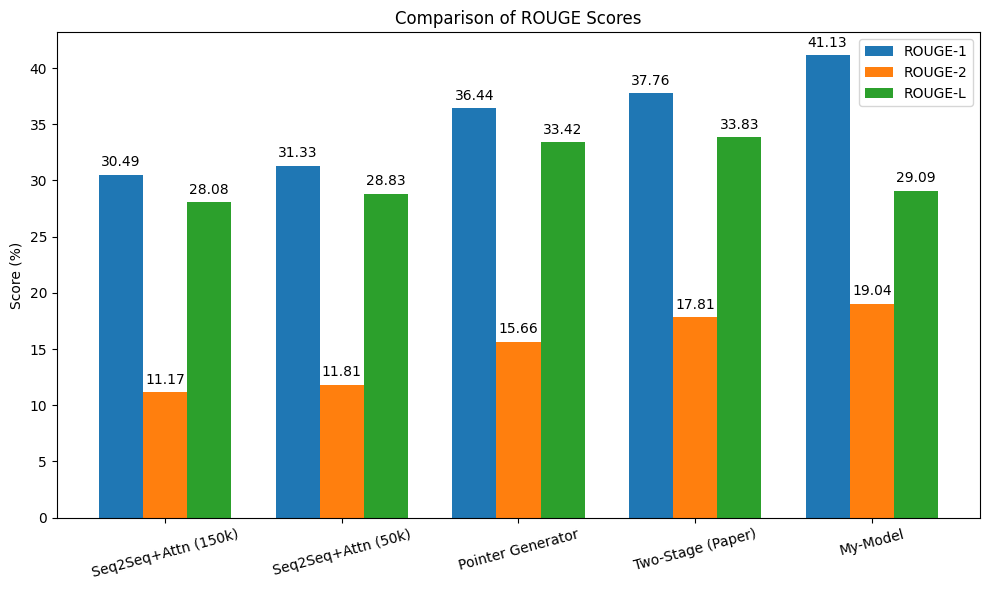


 🔹 توضیحات مدل‌ها (Model Descriptions) 

🔸 **Seq2Seq+Attn (150k)**
📌 **فارسی:** مدل Seq2Seq با مکانیزم توجه و واژگان 150هزار تایی، یکی از روش‌های اولیه برای خلاصه‌سازی انتزاعی بود.
📌 **English:** Seq2Seq model with attention mechanism and a 150k vocabulary, one of the early abstractive summarization methods.
--------------------------------------------------
🔸 **Seq2Seq+Attn (50k)**
📌 **فارسی:** نسخه‌ای از مدل Seq2Seq+Attention با مجموعه واژگان محدودتر (50هزار کلمه) که عملکرد بهتری روی داده‌های خاص دارد.
📌 **English:** A version of Seq2Seq+Attention with a smaller vocabulary (50k words), optimized for better performance on specific datasets.
--------------------------------------------------
🔸 **Pointer Generator**
📌 **فارسی:** مدل Pointer Generator با قابلیت ترکیب کلمات منبع و تولید واژگان جدید، که مشکلات مدل‌های کلاسیک را کاهش می‌دهد.
📌 **English:** Pointer Generator model, capable of copying words from the source and generating new words, reducing the issues of classical models.
--

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# نام مدل‌ها
models = [
    "Seq2Seq+Attn (150k)", 
    "Seq2Seq+Attn (50k)", 
    "Pointer Generator", 
    "Two-Stage (Paper)", 
    "My-Model"
]

# مقادیر ROUGE-1, ROUGE-2, ROUGE-L به صورت مثال
rouge_1_scores = [30.49, 31.33, 36.44, 37.76, 41.13]
rouge_2_scores = [11.17, 11.81, 15.66, 17.81, 19.04]
rouge_l_scores = [28.08, 28.83, 33.42, 33.83, 29.09]

# تنظیمات اولیه
x = np.arange(len(models))  # محل قرارگیری ستون‌ها
width = 0.25  # عرض ستون‌ها

fig, ax = plt.subplots(figsize=(10,6))

# برای جلوگیری از هم‌پوشانی ستون‌ها، هر دسته را با یک offset مختصر نمایش می‌دهیم
rects1 = ax.bar(x - width,  rouge_1_scores, width, label='ROUGE-1', color='#1f77b4')
rects2 = ax.bar(x,          rouge_2_scores, width, label='ROUGE-2', color='#ff7f0e')
rects3 = ax.bar(x + width,  rouge_l_scores, width, label='ROUGE-L', color='#2ca02c')

# عناوین و برچسب‌ها
ax.set_ylabel('Score (%)')
ax.set_title('Comparison of ROUGE Scores')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# نمایش مقدار هر ستون در بالای آن (اختیاری)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # حرکت مختصر به بالا
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

# ==========================
# توضیحات در مورد مدل‌ها
# ==========================

descriptions = {
    "Seq2Seq+Attn (150k)": {
        "fa": "مدل Seq2Seq با مکانیزم توجه و واژگان 150هزار تایی، یکی از روش‌های اولیه برای خلاصه‌سازی انتزاعی بود.",
        "en": "Seq2Seq model with attention mechanism and a 150k vocabulary, one of the early abstractive summarization methods."
    },
    "Seq2Seq+Attn (50k)": {
        "fa": "نسخه‌ای از مدل Seq2Seq+Attention با مجموعه واژگان محدودتر (50هزار کلمه) که عملکرد بهتری روی داده‌های خاص دارد.",
        "en": "A version of Seq2Seq+Attention with a smaller vocabulary (50k words), optimized for better performance on specific datasets."
    },
    "Pointer Generator": {
        "fa": "مدل Pointer Generator با قابلیت ترکیب کلمات منبع و تولید واژگان جدید، که مشکلات مدل‌های کلاسیک را کاهش می‌دهد.",
        "en": "Pointer Generator model, capable of copying words from the source and generating new words, reducing the issues of classical models."
    },
    "Two-Stage (Paper)": {
        "fa": "مدل پیشنهادی مقاله که ترکیبی از خلاصه‌سازی استخراجی و انتزاعی بوده و از ویژگی‌های زبانی برای بهبود عملکرد استفاده کرده است.",
        "en": "The proposed two-stage model from the paper, combining extractive and abstractive summarization with linguistic feature enhancements."
    },
    "My-Model": {
        "fa": "مدل توسعه‌یافته‌ی شخصی که مکانیزم‌های پیشرفته‌تری برای انتخاب جملات و بهبود توجه در خلاصه‌سازی انتزاعی دارد.",
        "en": "The custom-developed model with advanced sentence selection mechanisms and improved attention for abstractive summarization."
    }
}

# نمایش توضیحات در خروجی
print("\n" + "="*50)
print(" 🔹 توضیحات مدل‌ها (Model Descriptions) ")
print("="*50 + "\n")

for model, desc in descriptions.items():
    print(f"🔸 **{model}**")
    print(f"📌 **فارسی:** {desc['fa']}")
    print(f"📌 **English:** {desc['en']}")
    print("-" * 50)
